In [14]:
import numpy as np
import cvxpy as cp 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import clear_output
import time
clear_output()

In [15]:
"""
data 
"""

np.random.seed(23824)

TOLDIV = 5e-10
MIT = 2.5e3

d = int(1e3)
fade_cand = 2/3
fade = max(-10,min(1,fade_cand))
p = 1
R_def = 10

In [16]:
# from INRIA 
def proj_simplex_(vec, R=1,tol=1e-3):
    """ 
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert R > 0, "radius R must be strictly positive (%d <= 0)" % R
    d, = vec.shape  # will raise ValueError if vec is not 1-D
    if abs(vec.sum() - R)<=tol and np.alltrue(vec >= 0):
        return vec
    sorted_vec = np.sort(vec)[::-1]
    cssv = np.cumsum(sorted_vec)
    buf = np.nonzero(sorted_vec * np.arange(1, d+1) > (cssv - R))[0][-1]
    shift = float(cssv[buf] - R) / (1+buf)
    w = (vec - shift).clip(min=0)
    return w

def proj_ball_(x,xi_embd=np.zeros(d),nm_power=p,R=R_def,tol=5e-4):
    dxxi_embd = x-xi_embd
    abs_dxxi_embd = np.abs(dxxi_embd)
    if nm_power==1:
        if np.sum(abs_dxxi_embd)<=R+tol:
            return x
        return xi_embd + proj_simplex_(abs_dxxi_embd,R)*np.sign(dxxi_embd)
    elif nm_power==np.inf:
        if max(abs_dxxi_embd)<=R+tol:
            return x
        return xi_embd + np.minimum(R,np.maximum(-R,dxxi_embd))
    elif nm_power==2:
        buf = (np.sum(abs_dxxi_embd**2))**(1/2)
        if buf<=R+tol:
            return x
        return xi_embd + dxxi_embd*R/max(R,buf)
    else:
        return None

In [17]:
# from deepseek

def split_matrix(U):
    # Compute the eigenvalues and eigenvectors of U
    eigvals, eigvecs = np.linalg.eigh(U)
    
    # Split the eigenvalues into positive and negative parts
    lambda_plus = np.maximum(eigvals, 0)
    lambda_minus = np.maximum(-eigvals, 0)
    
    # Construct the diagonal matrices for positive and negative parts
    Lambda_plus = np.diag(lambda_plus)
    Lambda_minus = np.diag(lambda_minus)
    
    # Reconstruct U1 and U2 using the eigenvectors
    U1 = eigvecs @ Lambda_plus @ eigvecs.T
    U2 = eigvecs @ Lambda_minus @ eigvecs.T
    
    return (U1+U1.T)/2, (U2+U2.T)/2

In [18]:
def SDCe(MO,f1,f2,Psi,F,x_init,L_init,desc_prop=.1,tau_loc=2/3,ns_trig=5,dc_steps=int(200),\
            reset_after_ls=False,max_iter=1000,verb=False,vb_freq=50):
    
    # inits.
    tau_ext = .001
    x_stability_prev_next,x_stability_prev,x_stability,x,L = x_init.copy(),x_init.copy(),x_init.copy(),x_init.copy(),L_init
    k = 0
    div_succ_it = np.inf
    num_streak_success = 0
    L_min,L_max,L_prev = 1,1e16,0
    th,th_prev,varsigma = 1,0,0
    
    DCA_useful_iters = 0

    cond = True
    
    while k<max_iter and div_succ_it>TOLDIV and L<L_max:
                
        # IO
        y = x_stability+min(np.sqrt(L_prev*(1-tau_ext)/L),varsigma)*(x_stability_prev_next-x_stability_prev)
        f1y,g1y = f1(y,mode='full')
        f1y_tilde = f1y-np.sum(g1y*y)
        if cond:
            f2x,g2x = f2(x=x_stability,mode='full')
            f2x_stability,g2x_stability = f2x,g2x
            f2x_stability_tilde = f2x_stability-np.sum(g2x_stability*x_stability)
            val = f1(x_stability,'value')-f2x_stability+Psi(x_stability)

        cond = False
        
        if num_streak_success>=ns_trig:
            L = max(L_min+0.01,L*tau_loc)
            if reset_after_ls:
                num_streak_success = 0
            
        # MO 
        x_stability_plus,x,DCA_inner = MO(y,g1y,f1y_tilde,g2x_stability,f2x_stability_tilde,L,max_steps=dc_steps,min_decr_inner=5e-4)

        # IO 
        f1x,g1x = f1(x,mode='full')
        val_new = f1x-f2(x,'value')+Psi(x)
        
        # potential sufficient decrease check 
        div_ = np.sum((x-y)**2)/2
        div_x_stab_x_stab_plus = np.sum((x_stability_plus-x_stability)**2)/2
        cond = val_new + L*div_x_stab_x_stab_plus <= val + L*np.sum((y-x_stability)**2)/2 - L_min*desc_prop*div_

        if cond==False:
            L = min(L_max,L/tau_loc)
            num_streak_success = 0 # reset counter
        else:
            num_streak_success += 1
                
        # updates
        if cond:
            k += 1
            L_prev = L
            DCA_useful_iters += DCA_inner>0
            div_succ_it = np.sum((x-x_stability)**2)/2
            x_stability_prev = x_stability
            x_stability_prev_next = x_stability_plus
            x_stability = x.copy()
            val = val_new
            new_th = (1+np.sqrt(1+4*th**2))/2
            th_prev = th
            th = new_th
            varsigma = (th_prev-1)/th

        
        if verb and k%vb_freq==0 and cond:
            print('#'+str(k)+' itrs. | Fval = '+'{:.4e}'.format(val_new)+' ; div. '+'{:.2e}'.format(div_succ_it)+' ; L = '+'{:.3e}'.format(L)+' ; #DC iters = '+str(DCA_useful_iters))
    print(' ')
    print('HALT #'+str(k)+' iters. | Fval = '+str(val_new)+' ; div. '+str(div_succ_it)+' ; #DC iters = '+str(DCA_useful_iters)) 
            
    return x,val,k

In [19]:
def SDC(MO,f1,f2,Psi,F,x_init,L_init,desc_prop=.1,tau_loc=2/3,ns_trig=5,dc_steps=int(200),\
            reset_after_ls=False,max_iter=1000,verb=False,vb_freq=50):
    
    # inits.
    x_stability,x,L = x_init.copy(),x_init.copy(),L_init
    k = 0
    div_succ_it = np.inf
    num_streak_success = 0
    L_min,L_max,L_prev = 1,1e16,0
    
    DCA_useful_iters = 0

    cond = True
    
    while k<max_iter and div_succ_it>TOLDIV and L<L_max:
                
        # IO
        if cond:
            y = x_stability.copy()
            f1y,g1y = f1(y,mode='full')
            f1y_tilde = f1y-np.sum(g1y*y)
            f2x,g2x = f2(x=x_stability,mode='full')
            f2x_stability,g2x_stability = f2x,g2x
            f2x_stability_tilde = f2x_stability-np.sum(g2x_stability*x_stability)
            val = f1(x_stability,'value')-f2x_stability+Psi(x_stability)

        cond = False
        
        if num_streak_success>=ns_trig:
            L = max(L_min+0.01,L*tau_loc)
            if reset_after_ls:
                num_streak_success = 0
            
        # MO 
        x_stability_plus,x,DCA_inner = MO(y,g1y,f1y_tilde,g2x_stability,f2x_stability_tilde,L,max_steps=dc_steps,min_decr_inner=5e-4)

        # IO 
        f1x,g1x = f1(x,mode='full')
        val_new = f1x-f2(x,'value')+Psi(x)
        
        # potential sufficient decrease check 
        div_ = np.sum((x-y)**2)/2
        div_x_stab_x_stab_plus = np.sum((x_stability_plus-x_stability)**2)/2
        cond = val_new + L*div_x_stab_x_stab_plus <= val - L_min*desc_prop*div_

        if cond==False:
            L = min(L_max,L/tau_loc)
            num_streak_success = 0 # reset counter
        else:
            num_streak_success += 1
                
        # updates
        if cond:
            k += 1
            L_prev = L
            DCA_useful_iters += DCA_inner>0
            div_succ_it = np.sum((x-x_stability)**2)/2
            x_stability = x.copy()
            val = val_new
        
        if verb and k%vb_freq==0 and cond:
            print('#'+str(k)+' itrs. | Fval = '+'{:.4e}'.format(val_new)+' ; div. '+'{:.2e}'.format(div_succ_it)+' ; L = '+'{:.3e}'.format(L)+' ; #DC iters = '+str(DCA_useful_iters))
    print(' ')
    print('HALT #'+str(k)+' iters. | Fval = '+str(val_new)+' ; div. '+str(div_succ_it)+' ; #DC iters = '+str(DCA_useful_iters)) 
            
    return x,val,k

In [20]:
import pandas as pd

In [21]:
NPROBS = int(10)
REPS = int(10)
TL = 2/3

times = []
values = []
repetitions = []
extraps = []
method = []
num_iters = []
DC_updates = []
ls = []
probIDs = []

for probID in range(NPROBS):

    U = np.random.uniform(-2,2,(d,d))
    U = (U+U.T)/2

    U1, U2 = split_matrix(U)
    U2 = (1-fade)*U2
    U2 = (U2+U2.T)/2
    U = U1-U2
    L_ref = np.max(np.real(np.linalg.eigvals(U1)))*1.25
    print(' ')
    print('PID #'+str(probID))
    print(' ')

    """
    information oracles
    """

    def f1_oracle(x,mode='value'):
        U1x = U1@x
        if mode=='value':
            return (1/2)*np.sum(U1x*x)
        elif mode=='gradient':
            return U1x
        else:
            return (1/2)*np.sum(U1x*x),U1x

    def f2_oracle(x,mode='value'):
        U2x = U2@x
        if mode=='value':
            return (1/2)*np.sum(U2x*x)
        elif mode=='gradient':
            return U2x
        else:
            return (1/2)*np.sum(U2x*x),U2x

    def Psi_oracle(x):
        if np.linalg.norm(x,p)<=R_def+3e-3:
            return 0
        else:
            return np.inf

    def F_oracle(x):
        return 1/2*np.sum((U@x)*x)+np.sum(bar_u*x)+Psi_oracle(x)
    
    """
    oracle 

    approx solves: (subProblem) min mod(u) := f1(y) + <grad f1(y),u-y> + L_hat/2*||u-y||_2^2 + Psi(u) - f2(u)

    ensures with (x)_+ = arg min f1(y) + <grad f1(y),u-y> + L_hat/2*||u-y||_2^2 + Psi(u) - f2(x)-<g2(x),u-x>
    that

    output x_+ is a (approx) critical point of (subProblem) (i)
    output x_+ such that mod(x_+) <= mod((x)_+) (ii)


    """

    def MO_oracle(y,g1y,f1y_tilde,g2x,f2x_tilde,L_hat,max_steps=0,min_decr_inner=5e-4):
        mod = lambda u: f1y_tilde+np.sum(g1y*y)-f2_oracle(u,'value')+Psi_oracle(u)+L_hat*np.sum((u-y)**2)/2
        x_plus = proj_ball_(y-(g1y-g2x)/L_hat)
        x_ = x_plus.copy()
        modval = mod(x_)
        k_inner,cond = 0,True
        while k_inner<max_steps and cond:
            g2x_ = f2_oracle(x_,'gradient')
            x_next = proj_ball_(y-(g1y-g2x_)/L_hat)
            modval_next = mod(x_next)
            decr = modval-modval_next
            if decr>min_decr_inner:
                k_inner += 1
                x_ = x_next.copy()
                modval = modval_next
            else:
                cond = False
                if modval_next<modval:
                    x_ = x_next.copy()
        return x_plus,x_,k_inner

    for rep in range(REPS):

        x_random = proj_ball_(np.random.uniform(-3,3,d))

        print('repID: '+str(rep))
        print(' ')

        print(' ')

        print('go SDCe-LS')
        time_start_SDCe_LS = time.time()
        x_out_SDCe_LS,F_out_SDCe_LS,k_out_SDCe_LS = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDCe_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SDCe_LS-time_start_SDCe_LS)
        values.append(F_out_SDCe_LS)
        method.append('SDCe-LS')
        num_iters.append(k_out_SDCe_LS)
        extraps.append('yes')
        DC_updates.append('yes')
        ls.append('yes')
        probIDs.append(probID)


        print(' ')

        print('go SDCe')
        time_start_SDCe = time.time()
        x_out_SDCe,F_out_SDCe,k_out_SDCe = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDCe = time.time()

        repetitions.append(rep)
        times.append(time_end_SDCe-time_start_SDCe)
        values.append(F_out_SDCe)
        method.append('SDCe')
        num_iters.append(k_out_SDCe)
        extraps.append('yes')
        DC_updates.append('yes')
        ls.append('no')
        probIDs.append(probID)


        print(' ')

        print('go SCe-LS')
        time_start_SCe_LS = time.time()
        x_out_SCe_LS,F_out_SCe_LS,k_out_SCe_LS = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SCe_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SCe_LS-time_start_SCe_LS)
        values.append(F_out_SCe_LS)
        method.append('SCe-LS')
        num_iters.append(k_out_SCe_LS)
        extraps.append('yes')
        DC_updates.append('no')
        ls.append('yes')
        probIDs.append(probID)


        print(' ')

        print('go SCe')
        time_start_SCe = time.time()
        x_out_SCe,F_out_SCe,k_out_SCe = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SCe = time.time()

        repetitions.append(rep)
        times.append(time_end_SCe-time_start_SCe)
        values.append(F_out_SCe)
        method.append('SCe')
        num_iters.append(k_out_SCe)
        extraps.append('yes')
        DC_updates.append('no')
        ls.append('no')
        probIDs.append(probID)


        print(' ')


        print('go SDC-LS')
        time_start_SDC_LS = time.time()
        x_out_SDC_LS,F_out_SDC_LS,k_out_SDC_LS = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDC_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SDC_LS-time_start_SDC_LS)
        values.append(F_out_SDC_LS)
        method.append('SDC-LS')
        num_iters.append(k_out_SDC_LS)
        extraps.append('no')
        DC_updates.append('yes')
        ls.append('yes')
        probIDs.append(probID)



        print(' ')

        print('go SDC')
        time_start_SDC = time.time()
        x_out_SDC,F_out_SDC,k_out_SDC = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDC = time.time()

        repetitions.append(rep)
        times.append(time_end_SDC-time_start_SDC)
        values.append(F_out_SDC)
        method.append('SDC')
        num_iters.append(k_out_SDC)
        extraps.append('no')
        DC_updates.append('yes')
        ls.append('no')
        probIDs.append(probID)


        print( '')

        print('go SC-LS')
        time_start_SC_LS = time.time()
        x_out_SC_LS,F_out_SC_LS,k_out_SC_LS = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SC_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SC_LS-time_start_SC_LS)
        values.append(F_out_SC_LS)
        method.append('SC-LS')
        num_iters.append(k_out_SC_LS)
        extraps.append('no')
        DC_updates.append('no')
        ls.append('yes')
        probIDs.append(probID)



        print(' ')

        print('go SC')
        time_start_SC = time.time()
        x_out_SC,F_out_SC,k_out_SC = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SC = time.time()

        repetitions.append(rep)
        times.append(time_end_SC-time_start_SC)
        values.append(F_out_SC)
        method.append('SC')
        num_iters.append(k_out_SC)
        extraps.append('no')
        DC_updates.append('no')
        ls.append('no')
        probIDs.append(probID)

        print(' ')


        subdf = pd.DataFrame(data={'repID':repetitions,'vals':values,'times':times,'method':method,'iters':num_iters,\
                                   'extrapolation':extraps,'dc_updates':DC_updates,'linesearch':ls,'pID':probIDs})    

        if fade<0:
            subdf.to_csv('new_benchmark_methods_concave_QP_d_'+str(d)+'.csv')
        elif fade>0:
            subdf.to_csv('new_benchmark_methods_convex_QP_d_'+str(d)+'.csv')
        else:
            subdf.to_csv('new_benchmark_methods_neutral_QP_d_'+str(d)+'.csv')
            
    print(' ')

 
PID #0
 
repID: 0
 
 
go SDCe-LS
#10 itrs. | Fval = -5.5218e+00 ; div. 3.46e-02 ; L = 1.908e+01 ; #DC iters = 5
#20 itrs. | Fval = -6.6129e+00 ; div. 1.48e-02 ; L = 8.482e+00 ; #DC iters = 14
#30 itrs. | Fval = -6.9452e+00 ; div. 4.53e-03 ; L = 8.482e+00 ; #DC iters = 22
#40 itrs. | Fval = -7.0583e+00 ; div. 3.26e-03 ; L = 8.482e+00 ; #DC iters = 27
#50 itrs. | Fval = -7.1188e+00 ; div. 5.22e-04 ; L = 1.272e+01 ; #DC iters = 29
#60 itrs. | Fval = -7.1359e+00 ; div. 2.19e-04 ; L = 5.654e+00 ; #DC iters = 29
#70 itrs. | Fval = -7.1700e+00 ; div. 6.36e-04 ; L = 1.272e+01 ; #DC iters = 29
#80 itrs. | Fval = -7.3858e+00 ; div. 9.96e-03 ; L = 1.272e+01 ; #DC iters = 32
#90 itrs. | Fval = -7.5150e+00 ; div. 1.37e-04 ; L = 1.272e+01 ; #DC iters = 36
#100 itrs. | Fval = -7.5170e+00 ; div. 7.30e-05 ; L = 5.654e+00 ; #DC iters = 38
#110 itrs. | Fval = -7.5181e+00 ; div. 1.78e-05 ; L = 1.272e+01 ; #DC iters = 41
#120 itrs. | Fval = -7.5189e+00 ; div. 2.47e-05 ; L = 1.272e+01 ; #DC iters = 45
#13

#120 itrs. | Fval = -6.4437e+00 ; div. 5.70e-05 ; L = 6.441e+01 ; #DC iters = 115
#130 itrs. | Fval = -6.5112e+00 ; div. 5.92e-05 ; L = 6.441e+01 ; #DC iters = 125
#140 itrs. | Fval = -6.5716e+00 ; div. 4.83e-05 ; L = 6.441e+01 ; #DC iters = 135
#150 itrs. | Fval = -6.6251e+00 ; div. 4.45e-05 ; L = 6.441e+01 ; #DC iters = 145
#160 itrs. | Fval = -6.6696e+00 ; div. 2.85e-05 ; L = 6.441e+01 ; #DC iters = 153
#170 itrs. | Fval = -6.6942e+00 ; div. 1.79e-05 ; L = 6.441e+01 ; #DC iters = 153
#180 itrs. | Fval = -6.7140e+00 ; div. 1.63e-05 ; L = 6.441e+01 ; #DC iters = 153
#190 itrs. | Fval = -6.7344e+00 ; div. 1.81e-05 ; L = 6.441e+01 ; #DC iters = 153
#200 itrs. | Fval = -6.7591e+00 ; div. 2.31e-05 ; L = 6.441e+01 ; #DC iters = 153
#210 itrs. | Fval = -6.7867e+00 ; div. 2.26e-05 ; L = 6.441e+01 ; #DC iters = 153
#220 itrs. | Fval = -6.8136e+00 ; div. 2.10e-05 ; L = 6.441e+01 ; #DC iters = 153
#230 itrs. | Fval = -6.8381e+00 ; div. 1.86e-05 ; L = 6.441e+01 ; #DC iters = 153
#240 itrs. | Fva

#90 itrs. | Fval = -6.0082e+00 ; div. 8.11e-05 ; L = 6.441e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.1265e+00 ; div. 9.36e-05 ; L = 6.441e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.2533e+00 ; div. 1.03e-04 ; L = 6.441e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.3585e+00 ; div. 6.38e-05 ; L = 6.441e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.4329e+00 ; div. 5.61e-05 ; L = 6.441e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.5017e+00 ; div. 5.38e-05 ; L = 6.441e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.5642e+00 ; div. 4.46e-05 ; L = 6.441e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.6163e+00 ; div. 3.57e-05 ; L = 6.441e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.6574e+00 ; div. 2.89e-05 ; L = 6.441e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.6883e+00 ; div. 1.87e-05 ; L = 6.441e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.7103e+00 ; div. 1.66e-05 ; L = 6.441e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.7326e+00 ; div. 1.82e-05 ; L = 6.441e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.7593e+00 ; div. 2.

#130 itrs. | Fval = -6.8923e+00 ; div. 7.35e-07 ; L = 6.441e+01 ; #DC iters = 71
#140 itrs. | Fval = -6.8923e+00 ; div. 1.94e-07 ; L = 6.441e+01 ; #DC iters = 71
#150 itrs. | Fval = -6.8923e+00 ; div. 2.57e-08 ; L = 6.441e+01 ; #DC iters = 71
#160 itrs. | Fval = -6.8923e+00 ; div. 1.81e-08 ; L = 6.441e+01 ; #DC iters = 71
#170 itrs. | Fval = -6.8923e+00 ; div. 3.34e-09 ; L = 6.441e+01 ; #DC iters = 71
#180 itrs. | Fval = -6.8923e+00 ; div. 8.86e-10 ; L = 6.441e+01 ; #DC iters = 71
 
HALT #183 iters. | Fval = -6.892331170435007 ; div. 4.1008365602338495e-10 ; #DC iters = 71
 
go SCe-LS
#10 itrs. | Fval = -4.3889e+00 ; div. 2.55e-02 ; L = 1.908e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.7160e+00 ; div. 2.46e-03 ; L = 1.272e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.0096e+00 ; div. 3.12e-03 ; L = 5.654e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.4214e+00 ; div. 4.52e-03 ; L = 1.272e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.8503e+00 ; div. 1.85e-03 ; L = 1.908e+01 ; #DC iters = 0
#60 itrs. | F

#580 itrs. | Fval = -6.6737e+00 ; div. 2.13e-06 ; L = 6.441e+01 ; #DC iters = 99
#590 itrs. | Fval = -6.6763e+00 ; div. 2.11e-06 ; L = 6.441e+01 ; #DC iters = 99
#600 itrs. | Fval = -6.6788e+00 ; div. 2.16e-06 ; L = 6.441e+01 ; #DC iters = 99
#610 itrs. | Fval = -6.6814e+00 ; div. 2.28e-06 ; L = 6.441e+01 ; #DC iters = 99
#620 itrs. | Fval = -6.6842e+00 ; div. 2.47e-06 ; L = 6.441e+01 ; #DC iters = 99
#630 itrs. | Fval = -6.6873e+00 ; div. 2.70e-06 ; L = 6.441e+01 ; #DC iters = 99
#640 itrs. | Fval = -6.6908e+00 ; div. 2.83e-06 ; L = 6.441e+01 ; #DC iters = 99
#650 itrs. | Fval = -6.6941e+00 ; div. 2.86e-06 ; L = 6.441e+01 ; #DC iters = 99
#660 itrs. | Fval = -6.6976e+00 ; div. 2.97e-06 ; L = 6.441e+01 ; #DC iters = 99
#670 itrs. | Fval = -6.7013e+00 ; div. 2.80e-06 ; L = 6.441e+01 ; #DC iters = 99
#680 itrs. | Fval = -6.7049e+00 ; div. 2.88e-06 ; L = 6.441e+01 ; #DC iters = 99
#690 itrs. | Fval = -6.7088e+00 ; div. 3.19e-06 ; L = 6.441e+01 ; #DC iters = 99
#700 itrs. | Fval = -6.7134e

#1640 itrs. | Fval = -6.9381e+00 ; div. 3.54e-07 ; L = 6.441e+01 ; #DC iters = 99
#1650 itrs. | Fval = -6.9386e+00 ; div. 3.94e-07 ; L = 6.441e+01 ; #DC iters = 99
#1660 itrs. | Fval = -6.9391e+00 ; div. 4.40e-07 ; L = 6.441e+01 ; #DC iters = 99
#1670 itrs. | Fval = -6.9397e+00 ; div. 4.93e-07 ; L = 6.441e+01 ; #DC iters = 99
#1680 itrs. | Fval = -6.9404e+00 ; div. 5.53e-07 ; L = 6.441e+01 ; #DC iters = 99
#1690 itrs. | Fval = -6.9411e+00 ; div. 6.21e-07 ; L = 6.441e+01 ; #DC iters = 99
#1700 itrs. | Fval = -6.9420e+00 ; div. 7.06e-07 ; L = 6.441e+01 ; #DC iters = 99
#1710 itrs. | Fval = -6.9430e+00 ; div. 7.95e-07 ; L = 6.441e+01 ; #DC iters = 99
#1720 itrs. | Fval = -6.9441e+00 ; div. 9.07e-07 ; L = 6.441e+01 ; #DC iters = 99
#1730 itrs. | Fval = -6.9453e+00 ; div. 1.04e-06 ; L = 6.441e+01 ; #DC iters = 99
#1740 itrs. | Fval = -6.9468e+00 ; div. 1.20e-06 ; L = 6.441e+01 ; #DC iters = 99
#1750 itrs. | Fval = -6.9485e+00 ; div. 1.43e-06 ; L = 6.441e+01 ; #DC iters = 99
#1760 itrs. | Fv

#140 itrs. | Fval = -5.8170e+00 ; div. 1.42e-05 ; L = 6.441e+01 ; #DC iters = 0
#150 itrs. | Fval = -5.8335e+00 ; div. 1.15e-05 ; L = 6.441e+01 ; #DC iters = 0
#160 itrs. | Fval = -5.8474e+00 ; div. 1.06e-05 ; L = 6.441e+01 ; #DC iters = 0
#170 itrs. | Fval = -5.8615e+00 ; div. 1.13e-05 ; L = 6.441e+01 ; #DC iters = 0
#180 itrs. | Fval = -5.8766e+00 ; div. 1.15e-05 ; L = 6.441e+01 ; #DC iters = 0
#190 itrs. | Fval = -5.8889e+00 ; div. 8.68e-06 ; L = 6.441e+01 ; #DC iters = 0
#200 itrs. | Fval = -5.9001e+00 ; div. 8.92e-06 ; L = 6.441e+01 ; #DC iters = 0
#210 itrs. | Fval = -5.9119e+00 ; div. 9.80e-06 ; L = 6.441e+01 ; #DC iters = 0
#220 itrs. | Fval = -5.9265e+00 ; div. 1.27e-05 ; L = 6.441e+01 ; #DC iters = 0
#230 itrs. | Fval = -5.9462e+00 ; div. 1.68e-05 ; L = 6.441e+01 ; #DC iters = 0
#240 itrs. | Fval = -5.9712e+00 ; div. 2.13e-05 ; L = 6.441e+01 ; #DC iters = 0
#250 itrs. | Fval = -5.9987e+00 ; div. 2.12e-05 ; L = 6.441e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.0274e+00 ; div. 2

#1240 itrs. | Fval = -6.8977e+00 ; div. 1.95e-06 ; L = 6.441e+01 ; #DC iters = 0
#1250 itrs. | Fval = -6.9001e+00 ; div. 1.75e-06 ; L = 6.441e+01 ; #DC iters = 0
#1260 itrs. | Fval = -6.9022e+00 ; div. 1.63e-06 ; L = 6.441e+01 ; #DC iters = 0
#1270 itrs. | Fval = -6.9043e+00 ; div. 1.54e-06 ; L = 6.441e+01 ; #DC iters = 0
#1280 itrs. | Fval = -6.9062e+00 ; div. 1.47e-06 ; L = 6.441e+01 ; #DC iters = 0
#1290 itrs. | Fval = -6.9080e+00 ; div. 1.34e-06 ; L = 6.441e+01 ; #DC iters = 0
#1300 itrs. | Fval = -6.9096e+00 ; div. 1.21e-06 ; L = 6.441e+01 ; #DC iters = 0
#1310 itrs. | Fval = -6.9111e+00 ; div. 1.11e-06 ; L = 6.441e+01 ; #DC iters = 0
#1320 itrs. | Fval = -6.9125e+00 ; div. 1.02e-06 ; L = 6.441e+01 ; #DC iters = 0
#1330 itrs. | Fval = -6.9137e+00 ; div. 8.91e-07 ; L = 6.441e+01 ; #DC iters = 0
#1340 itrs. | Fval = -6.9148e+00 ; div. 7.89e-07 ; L = 6.441e+01 ; #DC iters = 0
#1350 itrs. | Fval = -6.9157e+00 ; div. 7.14e-07 ; L = 6.441e+01 ; #DC iters = 0
#1360 itrs. | Fval = -6.9166

#2340 itrs. | Fval = -7.0774e+00 ; div. 5.18e-07 ; L = 6.441e+01 ; #DC iters = 0
#2350 itrs. | Fval = -7.0781e+00 ; div. 4.85e-07 ; L = 6.441e+01 ; #DC iters = 0
#2360 itrs. | Fval = -7.0787e+00 ; div. 4.76e-07 ; L = 6.441e+01 ; #DC iters = 0
#2370 itrs. | Fval = -7.0793e+00 ; div. 4.71e-07 ; L = 6.441e+01 ; #DC iters = 0
#2380 itrs. | Fval = -7.0799e+00 ; div. 4.67e-07 ; L = 6.441e+01 ; #DC iters = 0
#2390 itrs. | Fval = -7.0805e+00 ; div. 4.61e-07 ; L = 6.441e+01 ; #DC iters = 0
#2400 itrs. | Fval = -7.0811e+00 ; div. 4.56e-07 ; L = 6.441e+01 ; #DC iters = 0
#2410 itrs. | Fval = -7.0817e+00 ; div. 4.52e-07 ; L = 6.441e+01 ; #DC iters = 0
#2420 itrs. | Fval = -7.0823e+00 ; div. 4.48e-07 ; L = 6.441e+01 ; #DC iters = 0
#2430 itrs. | Fval = -7.0828e+00 ; div. 4.45e-07 ; L = 6.441e+01 ; #DC iters = 0
#2440 itrs. | Fval = -7.0834e+00 ; div. 4.42e-07 ; L = 6.441e+01 ; #DC iters = 0
#2450 itrs. | Fval = -7.0840e+00 ; div. 4.40e-07 ; L = 6.441e+01 ; #DC iters = 0
#2460 itrs. | Fval = -7.0845

#270 itrs. | Fval = -7.4097e+00 ; div. 1.40e-08 ; L = 6.441e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.4097e+00 ; div. 2.92e-09 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #287 iters. | Fval = -7.409650569922366 ; div. 4.6458385828992185e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -4.9275e+00 ; div. 1.31e-01 ; L = 8.482e+00 ; #DC iters = 4
#20 itrs. | Fval = -6.2265e+00 ; div. 1.87e-02 ; L = 8.482e+00 ; #DC iters = 11
#30 itrs. | Fval = -6.5629e+00 ; div. 6.01e-04 ; L = 8.482e+00 ; #DC iters = 12
#40 itrs. | Fval = -6.6556e+00 ; div. 1.58e-03 ; L = 5.654e+00 ; #DC iters = 15
#50 itrs. | Fval = -6.8532e+00 ; div. 5.85e-04 ; L = 8.482e+00 ; #DC iters = 19
#60 itrs. | Fval = -6.9439e+00 ; div. 4.97e-04 ; L = 8.482e+00 ; #DC iters = 23
#70 itrs. | Fval = -7.0129e+00 ; div. 5.87e-05 ; L = 1.908e+01 ; #DC iters = 24
#80 itrs. | Fval = -7.3519e+00 ; div. 1.51e-03 ; L = 1.272e+01 ; #DC iters = 28
#90 itrs. | Fval = -7.4093e+00 ; div. 6.17e-05 ; L = 8.482e+00 ; #DC iters = 35
#100 itrs. | Fva

#900 itrs. | Fval = -6.9775e+00 ; div. 1.74e-06 ; L = 6.441e+01 ; #DC iters = 132
#910 itrs. | Fval = -6.9797e+00 ; div. 1.53e-06 ; L = 6.441e+01 ; #DC iters = 132
#920 itrs. | Fval = -6.9816e+00 ; div. 1.52e-06 ; L = 6.441e+01 ; #DC iters = 132
#930 itrs. | Fval = -6.9836e+00 ; div. 1.56e-06 ; L = 6.441e+01 ; #DC iters = 132
#940 itrs. | Fval = -6.9857e+00 ; div. 1.63e-06 ; L = 6.441e+01 ; #DC iters = 132
#950 itrs. | Fval = -6.9874e+00 ; div. 1.21e-06 ; L = 6.441e+01 ; #DC iters = 132
#960 itrs. | Fval = -6.9888e+00 ; div. 1.06e-06 ; L = 6.441e+01 ; #DC iters = 132
#970 itrs. | Fval = -6.9902e+00 ; div. 1.02e-06 ; L = 6.441e+01 ; #DC iters = 132
#980 itrs. | Fval = -6.9915e+00 ; div. 1.05e-06 ; L = 6.441e+01 ; #DC iters = 132
#990 itrs. | Fval = -6.9929e+00 ; div. 1.11e-06 ; L = 6.441e+01 ; #DC iters = 132
#1000 itrs. | Fval = -6.9943e+00 ; div. 1.01e-06 ; L = 6.441e+01 ; #DC iters = 132
#1010 itrs. | Fval = -6.9955e+00 ; div. 8.64e-07 ; L = 6.441e+01 ; #DC iters = 132
#1020 itrs. | 

#1900 itrs. | Fval = -7.0014e+00 ; div. 1.69e-08 ; L = 6.441e+01 ; #DC iters = 132
#1910 itrs. | Fval = -7.0015e+00 ; div. 1.78e-08 ; L = 6.441e+01 ; #DC iters = 132
#1920 itrs. | Fval = -7.0015e+00 ; div. 1.88e-08 ; L = 6.441e+01 ; #DC iters = 132
#1930 itrs. | Fval = -7.0015e+00 ; div. 1.98e-08 ; L = 6.441e+01 ; #DC iters = 132
#1940 itrs. | Fval = -7.0015e+00 ; div. 2.09e-08 ; L = 6.441e+01 ; #DC iters = 132
#1950 itrs. | Fval = -7.0016e+00 ; div. 2.20e-08 ; L = 6.441e+01 ; #DC iters = 132
#1960 itrs. | Fval = -7.0016e+00 ; div. 2.32e-08 ; L = 6.441e+01 ; #DC iters = 132
#1970 itrs. | Fval = -7.0016e+00 ; div. 2.45e-08 ; L = 6.441e+01 ; #DC iters = 132
#1980 itrs. | Fval = -7.0017e+00 ; div. 2.59e-08 ; L = 6.441e+01 ; #DC iters = 132
#1990 itrs. | Fval = -7.0017e+00 ; div. 2.75e-08 ; L = 6.441e+01 ; #DC iters = 132
#2000 itrs. | Fval = -7.0017e+00 ; div. 2.93e-08 ; L = 6.441e+01 ; #DC iters = 132
#2010 itrs. | Fval = -7.0018e+00 ; div. 3.12e-08 ; L = 6.441e+01 ; #DC iters = 132
#202

#240 itrs. | Fval = -6.5539e+00 ; div. 1.35e-05 ; L = 6.441e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.5707e+00 ; div. 1.23e-05 ; L = 6.441e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.5849e+00 ; div. 1.03e-05 ; L = 6.441e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.5976e+00 ; div. 9.69e-06 ; L = 6.441e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.6101e+00 ; div. 9.90e-06 ; L = 6.441e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.6234e+00 ; div. 1.07e-05 ; L = 6.441e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.6382e+00 ; div. 1.22e-05 ; L = 6.441e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.6548e+00 ; div. 1.27e-05 ; L = 6.441e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.6721e+00 ; div. 1.40e-05 ; L = 6.441e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.6893e+00 ; div. 1.31e-05 ; L = 6.441e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.7062e+00 ; div. 1.34e-05 ; L = 6.441e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.7223e+00 ; div. 1.16e-05 ; L = 6.441e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.7369e+00 ; div. 1

#1320 itrs. | Fval = -7.4096e+00 ; div. 4.13e-09 ; L = 6.441e+01 ; #DC iters = 0
#1330 itrs. | Fval = -7.4096e+00 ; div. 3.58e-09 ; L = 6.441e+01 ; #DC iters = 0
#1340 itrs. | Fval = -7.4096e+00 ; div. 3.12e-09 ; L = 6.441e+01 ; #DC iters = 0
#1350 itrs. | Fval = -7.4096e+00 ; div. 2.73e-09 ; L = 6.441e+01 ; #DC iters = 0
#1360 itrs. | Fval = -7.4096e+00 ; div. 2.39e-09 ; L = 6.441e+01 ; #DC iters = 0
#1370 itrs. | Fval = -7.4096e+00 ; div. 2.10e-09 ; L = 6.441e+01 ; #DC iters = 0
#1380 itrs. | Fval = -7.4096e+00 ; div. 1.85e-09 ; L = 6.441e+01 ; #DC iters = 0
#1390 itrs. | Fval = -7.4096e+00 ; div. 1.63e-09 ; L = 6.441e+01 ; #DC iters = 0
#1400 itrs. | Fval = -7.4096e+00 ; div. 1.44e-09 ; L = 6.441e+01 ; #DC iters = 0
#1410 itrs. | Fval = -7.4096e+00 ; div. 1.28e-09 ; L = 6.441e+01 ; #DC iters = 0
#1420 itrs. | Fval = -7.4096e+00 ; div. 1.13e-09 ; L = 6.441e+01 ; #DC iters = 0
#1430 itrs. | Fval = -7.4096e+00 ; div. 9.99e-10 ; L = 6.441e+01 ; #DC iters = 0
#1440 itrs. | Fval = -7.4096

#70 itrs. | Fval = -7.5192e+00 ; div. 6.42e-07 ; L = 5.654e+00 ; #DC iters = 11
#80 itrs. | Fval = -7.5192e+00 ; div. 4.01e-08 ; L = 1.272e+01 ; #DC iters = 11
#90 itrs. | Fval = -7.5192e+00 ; div. 2.80e-08 ; L = 8.482e+00 ; #DC iters = 11
#100 itrs. | Fval = -7.5192e+00 ; div. 1.95e-08 ; L = 5.654e+00 ; #DC iters = 11
#110 itrs. | Fval = -7.5192e+00 ; div. 5.30e-10 ; L = 1.272e+01 ; #DC iters = 11
 
HALT #116 iters. | Fval = -7.519184892237196 ; div. 1.2052459766959728e-10 ; #DC iters = 11
 
go SDC
#10 itrs. | Fval = -2.3064e+00 ; div. 7.65e-04 ; L = 6.441e+01 ; #DC iters = 4
#20 itrs. | Fval = -2.9806e+00 ; div. 5.83e-04 ; L = 6.441e+01 ; #DC iters = 14
#30 itrs. | Fval = -3.5997e+00 ; div. 4.85e-04 ; L = 6.441e+01 ; #DC iters = 24
#40 itrs. | Fval = -4.1102e+00 ; div. 3.64e-04 ; L = 6.441e+01 ; #DC iters = 34
#50 itrs. | Fval = -4.5033e+00 ; div. 2.94e-04 ; L = 6.441e+01 ; #DC iters = 44
#60 itrs. | Fval = -4.8456e+00 ; div. 2.82e-04 ; L = 6.441e+01 ; #DC iters = 54
#70 itrs. | Fval

#1000 itrs. | Fval = -7.5192e+00 ; div. 9.48e-10 ; L = 6.441e+01 ; #DC iters = 153
#1010 itrs. | Fval = -7.5192e+00 ; div. 8.93e-10 ; L = 6.441e+01 ; #DC iters = 153
#1020 itrs. | Fval = -7.5192e+00 ; div. 8.40e-10 ; L = 6.441e+01 ; #DC iters = 153
#1030 itrs. | Fval = -7.5192e+00 ; div. 7.91e-10 ; L = 6.441e+01 ; #DC iters = 153
#1040 itrs. | Fval = -7.5192e+00 ; div. 7.45e-10 ; L = 6.441e+01 ; #DC iters = 153
#1050 itrs. | Fval = -7.5192e+00 ; div. 7.02e-10 ; L = 6.441e+01 ; #DC iters = 153
#1060 itrs. | Fval = -7.5192e+00 ; div. 6.61e-10 ; L = 6.441e+01 ; #DC iters = 153
#1070 itrs. | Fval = -7.5192e+00 ; div. 6.22e-10 ; L = 6.441e+01 ; #DC iters = 153
#1080 itrs. | Fval = -7.5192e+00 ; div. 5.86e-10 ; L = 6.441e+01 ; #DC iters = 153
#1090 itrs. | Fval = -7.5192e+00 ; div. 5.52e-10 ; L = 6.441e+01 ; #DC iters = 153
#1100 itrs. | Fval = -7.5192e+00 ; div. 5.20e-10 ; L = 6.441e+01 ; #DC iters = 153
 
HALT #1107 iters. | Fval = -7.519174960274452 ; div. 4.983843943868943e-10 ; #DC iter

#740 itrs. | Fval = -7.5191e+00 ; div. 4.48e-09 ; L = 6.441e+01 ; #DC iters = 0
#750 itrs. | Fval = -7.5191e+00 ; div. 4.20e-09 ; L = 6.441e+01 ; #DC iters = 0
#760 itrs. | Fval = -7.5191e+00 ; div. 3.95e-09 ; L = 6.441e+01 ; #DC iters = 0
#770 itrs. | Fval = -7.5191e+00 ; div. 3.72e-09 ; L = 6.441e+01 ; #DC iters = 0
#780 itrs. | Fval = -7.5191e+00 ; div. 3.50e-09 ; L = 6.441e+01 ; #DC iters = 0
#790 itrs. | Fval = -7.5191e+00 ; div. 3.30e-09 ; L = 6.441e+01 ; #DC iters = 0
#800 itrs. | Fval = -7.5191e+00 ; div. 3.11e-09 ; L = 6.441e+01 ; #DC iters = 0
#810 itrs. | Fval = -7.5191e+00 ; div. 2.94e-09 ; L = 6.441e+01 ; #DC iters = 0
#820 itrs. | Fval = -7.5191e+00 ; div. 2.77e-09 ; L = 6.441e+01 ; #DC iters = 0
#830 itrs. | Fval = -7.5191e+00 ; div. 2.62e-09 ; L = 6.441e+01 ; #DC iters = 0
#840 itrs. | Fval = -7.5191e+00 ; div. 2.48e-09 ; L = 6.441e+01 ; #DC iters = 0
#850 itrs. | Fval = -7.5191e+00 ; div. 2.34e-09 ; L = 6.441e+01 ; #DC iters = 0
#860 itrs. | Fval = -7.5191e+00 ; div. 2

#200 itrs. | Fval = -7.0758e+00 ; div. 4.96e-06 ; L = 6.441e+01 ; #DC iters = 66
#210 itrs. | Fval = -7.0765e+00 ; div. 5.29e-06 ; L = 6.441e+01 ; #DC iters = 66
#220 itrs. | Fval = -7.0773e+00 ; div. 5.95e-06 ; L = 6.441e+01 ; #DC iters = 66
#230 itrs. | Fval = -7.0779e+00 ; div. 4.85e-06 ; L = 6.441e+01 ; #DC iters = 66
#240 itrs. | Fval = -7.0784e+00 ; div. 3.51e-06 ; L = 6.441e+01 ; #DC iters = 66
#250 itrs. | Fval = -7.0787e+00 ; div. 2.60e-06 ; L = 6.441e+01 ; #DC iters = 66
#260 itrs. | Fval = -7.0789e+00 ; div. 1.94e-06 ; L = 6.441e+01 ; #DC iters = 66
#270 itrs. | Fval = -7.0791e+00 ; div. 1.77e-06 ; L = 6.441e+01 ; #DC iters = 66
#280 itrs. | Fval = -7.0793e+00 ; div. 1.89e-06 ; L = 6.441e+01 ; #DC iters = 66
#290 itrs. | Fval = -7.0795e+00 ; div. 2.34e-06 ; L = 6.441e+01 ; #DC iters = 66
#300 itrs. | Fval = -7.0799e+00 ; div. 2.81e-06 ; L = 6.441e+01 ; #DC iters = 66
#310 itrs. | Fval = -7.0802e+00 ; div. 2.66e-06 ; L = 6.441e+01 ; #DC iters = 66
#320 itrs. | Fval = -7.0804e

#170 itrs. | Fval = -7.0731e+00 ; div. 6.09e-06 ; L = 6.441e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.0738e+00 ; div. 5.71e-06 ; L = 6.441e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.0744e+00 ; div. 4.56e-06 ; L = 6.441e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.0748e+00 ; div. 3.34e-06 ; L = 6.441e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.0752e+00 ; div. 3.51e-06 ; L = 6.441e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.0758e+00 ; div. 4.34e-06 ; L = 6.441e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.0765e+00 ; div. 5.40e-06 ; L = 6.441e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.0773e+00 ; div. 6.07e-06 ; L = 6.441e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.0779e+00 ; div. 4.95e-06 ; L = 6.441e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.0784e+00 ; div. 3.58e-06 ; L = 6.441e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.0787e+00 ; div. 2.64e-06 ; L = 6.441e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.0789e+00 ; div. 1.97e-06 ; L = 6.441e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.0791e+00 ; div. 1

#300 itrs. | Fval = -6.9922e+00 ; div. 1.57e-05 ; L = 6.441e+01 ; #DC iters = 187
#310 itrs. | Fval = -7.0097e+00 ; div. 1.42e-05 ; L = 6.441e+01 ; #DC iters = 187
#320 itrs. | Fval = -7.0246e+00 ; div. 1.13e-05 ; L = 6.441e+01 ; #DC iters = 187
#330 itrs. | Fval = -7.0355e+00 ; div. 7.84e-06 ; L = 6.441e+01 ; #DC iters = 187
#340 itrs. | Fval = -7.0425e+00 ; div. 4.82e-06 ; L = 6.441e+01 ; #DC iters = 187
#350 itrs. | Fval = -7.0471e+00 ; div. 3.16e-06 ; L = 6.441e+01 ; #DC iters = 187
#360 itrs. | Fval = -7.0508e+00 ; div. 2.64e-06 ; L = 6.441e+01 ; #DC iters = 187
#370 itrs. | Fval = -7.0538e+00 ; div. 2.06e-06 ; L = 6.441e+01 ; #DC iters = 187
#380 itrs. | Fval = -7.0561e+00 ; div. 1.70e-06 ; L = 6.441e+01 ; #DC iters = 187
#390 itrs. | Fval = -7.0580e+00 ; div. 1.23e-06 ; L = 6.441e+01 ; #DC iters = 187
#400 itrs. | Fval = -7.0594e+00 ; div. 9.41e-07 ; L = 6.441e+01 ; #DC iters = 187
#410 itrs. | Fval = -7.0605e+00 ; div. 7.64e-07 ; L = 6.441e+01 ; #DC iters = 187
#420 itrs. | Fva

#1340 itrs. | Fval = -7.0692e+00 ; div. 5.02e-08 ; L = 6.441e+01 ; #DC iters = 187
#1350 itrs. | Fval = -7.0693e+00 ; div. 5.14e-08 ; L = 6.441e+01 ; #DC iters = 187
#1360 itrs. | Fval = -7.0694e+00 ; div. 5.27e-08 ; L = 6.441e+01 ; #DC iters = 187
#1370 itrs. | Fval = -7.0694e+00 ; div. 5.40e-08 ; L = 6.441e+01 ; #DC iters = 187
#1380 itrs. | Fval = -7.0695e+00 ; div. 5.53e-08 ; L = 6.441e+01 ; #DC iters = 187
#1390 itrs. | Fval = -7.0696e+00 ; div. 5.43e-08 ; L = 6.441e+01 ; #DC iters = 187
#1400 itrs. | Fval = -7.0696e+00 ; div. 5.42e-08 ; L = 6.441e+01 ; #DC iters = 187
#1410 itrs. | Fval = -7.0697e+00 ; div. 5.43e-08 ; L = 6.441e+01 ; #DC iters = 187
#1420 itrs. | Fval = -7.0698e+00 ; div. 5.44e-08 ; L = 6.441e+01 ; #DC iters = 187
#1430 itrs. | Fval = -7.0699e+00 ; div. 5.45e-08 ; L = 6.441e+01 ; #DC iters = 187
#1440 itrs. | Fval = -7.0699e+00 ; div. 5.46e-08 ; L = 6.441e+01 ; #DC iters = 187
#1450 itrs. | Fval = -7.0700e+00 ; div. 5.48e-08 ; L = 6.441e+01 ; #DC iters = 187
#146

#2360 itrs. | Fval = -7.0758e+00 ; div. 6.92e-08 ; L = 6.441e+01 ; #DC iters = 187
#2370 itrs. | Fval = -7.0759e+00 ; div. 7.18e-08 ; L = 6.441e+01 ; #DC iters = 187
#2380 itrs. | Fval = -7.0760e+00 ; div. 7.46e-08 ; L = 6.441e+01 ; #DC iters = 187
#2390 itrs. | Fval = -7.0760e+00 ; div. 7.76e-08 ; L = 6.441e+01 ; #DC iters = 187
#2400 itrs. | Fval = -7.0761e+00 ; div. 8.07e-08 ; L = 6.441e+01 ; #DC iters = 187
#2410 itrs. | Fval = -7.0762e+00 ; div. 8.56e-08 ; L = 6.441e+01 ; #DC iters = 187
#2420 itrs. | Fval = -7.0763e+00 ; div. 9.25e-08 ; L = 6.441e+01 ; #DC iters = 187
#2430 itrs. | Fval = -7.0764e+00 ; div. 7.92e-08 ; L = 6.441e+01 ; #DC iters = 187
#2440 itrs. | Fval = -7.0766e+00 ; div. 8.04e-08 ; L = 6.441e+01 ; #DC iters = 187
#2450 itrs. | Fval = -7.0767e+00 ; div. 8.26e-08 ; L = 6.441e+01 ; #DC iters = 187
#2460 itrs. | Fval = -7.0768e+00 ; div. 7.85e-08 ; L = 6.441e+01 ; #DC iters = 187
#2470 itrs. | Fval = -7.0769e+00 ; div. 7.79e-08 ; L = 6.441e+01 ; #DC iters = 187
#248

#440 itrs. | Fval = -7.0613e+00 ; div. 6.41e-07 ; L = 6.441e+01 ; #DC iters = 0
#450 itrs. | Fval = -7.0620e+00 ; div. 5.34e-07 ; L = 6.441e+01 ; #DC iters = 0
#460 itrs. | Fval = -7.0627e+00 ; div. 4.54e-07 ; L = 6.441e+01 ; #DC iters = 0
#470 itrs. | Fval = -7.0632e+00 ; div. 3.90e-07 ; L = 6.441e+01 ; #DC iters = 0
#480 itrs. | Fval = -7.0637e+00 ; div. 3.18e-07 ; L = 6.441e+01 ; #DC iters = 0
#490 itrs. | Fval = -7.0640e+00 ; div. 2.60e-07 ; L = 6.441e+01 ; #DC iters = 0
#500 itrs. | Fval = -7.0643e+00 ; div. 2.19e-07 ; L = 6.441e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.0646e+00 ; div. 1.88e-07 ; L = 6.441e+01 ; #DC iters = 0
#520 itrs. | Fval = -7.0648e+00 ; div. 1.63e-07 ; L = 6.441e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.0650e+00 ; div. 1.43e-07 ; L = 6.441e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.0652e+00 ; div. 1.24e-07 ; L = 6.441e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.0653e+00 ; div. 1.08e-07 ; L = 6.441e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.0655e+00 ; div. 9

#210 itrs. | Fval = -7.1863e+00 ; div. 7.25e-05 ; L = 6.441e+01 ; #DC iters = 135
#220 itrs. | Fval = -7.1982e+00 ; div. 1.08e-04 ; L = 6.441e+01 ; #DC iters = 135
#230 itrs. | Fval = -7.2240e+00 ; div. 2.18e-04 ; L = 6.441e+01 ; #DC iters = 143
#240 itrs. | Fval = -7.2543e+00 ; div. 2.22e-04 ; L = 6.441e+01 ; #DC iters = 148
#250 itrs. | Fval = -7.2708e+00 ; div. 1.39e-04 ; L = 6.441e+01 ; #DC iters = 153
#260 itrs. | Fval = -7.2794e+00 ; div. 6.09e-05 ; L = 6.441e+01 ; #DC iters = 153
#270 itrs. | Fval = -7.2837e+00 ; div. 3.59e-05 ; L = 6.441e+01 ; #DC iters = 153
#280 itrs. | Fval = -7.2891e+00 ; div. 4.29e-05 ; L = 6.441e+01 ; #DC iters = 153
#290 itrs. | Fval = -7.2953e+00 ; div. 5.48e-05 ; L = 6.441e+01 ; #DC iters = 153
#300 itrs. | Fval = -7.2994e+00 ; div. 3.62e-05 ; L = 6.441e+01 ; #DC iters = 153
#310 itrs. | Fval = -7.3015e+00 ; div. 1.90e-05 ; L = 6.441e+01 ; #DC iters = 153
#320 itrs. | Fval = -7.3032e+00 ; div. 1.54e-05 ; L = 6.441e+01 ; #DC iters = 153
#330 itrs. | Fva

#270 itrs. | Fval = -7.2814e+00 ; div. 4.59e-05 ; L = 6.441e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.2857e+00 ; div. 3.63e-05 ; L = 6.441e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.2914e+00 ; div. 4.37e-05 ; L = 6.441e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.2971e+00 ; div. 4.25e-05 ; L = 6.441e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.3003e+00 ; div. 2.53e-05 ; L = 6.441e+01 ; #DC iters = 0
#320 itrs. | Fval = -7.3020e+00 ; div. 1.50e-05 ; L = 6.441e+01 ; #DC iters = 0
#330 itrs. | Fval = -7.3035e+00 ; div. 1.26e-05 ; L = 6.441e+01 ; #DC iters = 0
#340 itrs. | Fval = -7.3051e+00 ; div. 1.35e-05 ; L = 6.441e+01 ; #DC iters = 0
#350 itrs. | Fval = -7.3072e+00 ; div. 1.68e-05 ; L = 6.441e+01 ; #DC iters = 0
#360 itrs. | Fval = -7.3107e+00 ; div. 3.09e-05 ; L = 6.441e+01 ; #DC iters = 0
#370 itrs. | Fval = -7.3235e+00 ; div. 1.07e-04 ; L = 6.441e+01 ; #DC iters = 0
#380 itrs. | Fval = -7.3601e+00 ; div. 2.79e-04 ; L = 6.441e+01 ; #DC iters = 0
#390 itrs. | Fval = -7.4000e+00 ; div. 2

#550 itrs. | Fval = -6.7880e+00 ; div. 2.67e-05 ; L = 6.441e+01 ; #DC iters = 90
#560 itrs. | Fval = -6.8167e+00 ; div. 1.96e-05 ; L = 6.441e+01 ; #DC iters = 90
#570 itrs. | Fval = -6.8388e+00 ; div. 1.62e-05 ; L = 6.441e+01 ; #DC iters = 90
#580 itrs. | Fval = -6.8580e+00 ; div. 1.41e-05 ; L = 6.441e+01 ; #DC iters = 90
#590 itrs. | Fval = -6.8751e+00 ; div. 1.26e-05 ; L = 6.441e+01 ; #DC iters = 90
#600 itrs. | Fval = -6.8905e+00 ; div. 1.16e-05 ; L = 6.441e+01 ; #DC iters = 90
#610 itrs. | Fval = -6.9065e+00 ; div. 1.34e-05 ; L = 6.441e+01 ; #DC iters = 90
#620 itrs. | Fval = -6.9230e+00 ; div. 1.45e-05 ; L = 6.441e+01 ; #DC iters = 90
#630 itrs. | Fval = -6.9408e+00 ; div. 1.55e-05 ; L = 6.441e+01 ; #DC iters = 90
#640 itrs. | Fval = -6.9573e+00 ; div. 1.47e-05 ; L = 6.441e+01 ; #DC iters = 90
#650 itrs. | Fval = -6.9743e+00 ; div. 1.45e-05 ; L = 6.441e+01 ; #DC iters = 90
#660 itrs. | Fval = -6.9919e+00 ; div. 1.51e-05 ; L = 6.441e+01 ; #DC iters = 90
#670 itrs. | Fval = -7.0095e

#1620 itrs. | Fval = -7.2584e+00 ; div. 1.70e-06 ; L = 6.441e+01 ; #DC iters = 90
#1630 itrs. | Fval = -7.2603e+00 ; div. 1.55e-06 ; L = 6.441e+01 ; #DC iters = 90
#1640 itrs. | Fval = -7.2621e+00 ; div. 1.44e-06 ; L = 6.441e+01 ; #DC iters = 90
#1650 itrs. | Fval = -7.2637e+00 ; div. 1.38e-06 ; L = 6.441e+01 ; #DC iters = 90
#1660 itrs. | Fval = -7.2653e+00 ; div. 1.30e-06 ; L = 6.441e+01 ; #DC iters = 90
#1670 itrs. | Fval = -7.2668e+00 ; div. 1.28e-06 ; L = 6.441e+01 ; #DC iters = 90
#1680 itrs. | Fval = -7.2684e+00 ; div. 1.29e-06 ; L = 6.441e+01 ; #DC iters = 90
#1690 itrs. | Fval = -7.2699e+00 ; div. 1.35e-06 ; L = 6.441e+01 ; #DC iters = 90
#1700 itrs. | Fval = -7.2716e+00 ; div. 1.38e-06 ; L = 6.441e+01 ; #DC iters = 90
#1710 itrs. | Fval = -7.2732e+00 ; div. 1.29e-06 ; L = 6.441e+01 ; #DC iters = 90
#1720 itrs. | Fval = -7.2746e+00 ; div. 1.19e-06 ; L = 6.441e+01 ; #DC iters = 90
#1730 itrs. | Fval = -7.2759e+00 ; div. 1.13e-06 ; L = 6.441e+01 ; #DC iters = 90
#1740 itrs. | Fv

#140 itrs. | Fval = -7.1757e+00 ; div. 4.90e-04 ; L = 2.513e+00 ; #DC iters = 0
#150 itrs. | Fval = -7.1824e+00 ; div. 1.63e-05 ; L = 1.272e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.1946e+00 ; div. 3.12e-04 ; L = 3.770e+00 ; #DC iters = 0
#170 itrs. | Fval = -7.2220e+00 ; div. 4.09e-04 ; L = 5.654e+00 ; #DC iters = 0
#180 itrs. | Fval = -7.2577e+00 ; div. 3.06e-04 ; L = 5.654e+00 ; #DC iters = 0
#190 itrs. | Fval = -7.2729e+00 ; div. 3.06e-05 ; L = 1.272e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.2816e+00 ; div. 3.77e-05 ; L = 8.482e+00 ; #DC iters = 0
#210 itrs. | Fval = -7.2850e+00 ; div. 9.26e-06 ; L = 1.272e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.2915e+00 ; div. 6.79e-05 ; L = 5.654e+00 ; #DC iters = 0
#230 itrs. | Fval = -7.2983e+00 ; div. 2.30e-05 ; L = 1.272e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.3004e+00 ; div. 7.71e-06 ; L = 8.482e+00 ; #DC iters = 0
#250 itrs. | Fval = -7.3025e+00 ; div. 8.31e-05 ; L = 2.513e+00 ; #DC iters = 0
#260 itrs. | Fval = -7.3041e+00 ; div. 1

#850 itrs. | Fval = -7.1079e+00 ; div. 3.49e-06 ; L = 6.441e+01 ; #DC iters = 0
#860 itrs. | Fval = -7.1125e+00 ; div. 3.62e-06 ; L = 6.441e+01 ; #DC iters = 0
#870 itrs. | Fval = -7.1172e+00 ; div. 3.68e-06 ; L = 6.441e+01 ; #DC iters = 0
#880 itrs. | Fval = -7.1220e+00 ; div. 3.76e-06 ; L = 6.441e+01 ; #DC iters = 0
#890 itrs. | Fval = -7.1268e+00 ; div. 3.45e-06 ; L = 6.441e+01 ; #DC iters = 0
#900 itrs. | Fval = -7.1310e+00 ; div. 3.21e-06 ; L = 6.441e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.1350e+00 ; div. 3.08e-06 ; L = 6.441e+01 ; #DC iters = 0
#920 itrs. | Fval = -7.1389e+00 ; div. 2.99e-06 ; L = 6.441e+01 ; #DC iters = 0
#930 itrs. | Fval = -7.1423e+00 ; div. 2.14e-06 ; L = 6.441e+01 ; #DC iters = 0
#940 itrs. | Fval = -7.1446e+00 ; div. 1.60e-06 ; L = 6.441e+01 ; #DC iters = 0
#950 itrs. | Fval = -7.1464e+00 ; div. 1.27e-06 ; L = 6.441e+01 ; #DC iters = 0
#960 itrs. | Fval = -7.1479e+00 ; div. 1.07e-06 ; L = 6.441e+01 ; #DC iters = 0
#970 itrs. | Fval = -7.1491e+00 ; div. 9

#1920 itrs. | Fval = -7.2820e+00 ; div. 3.45e-07 ; L = 6.441e+01 ; #DC iters = 0
#1930 itrs. | Fval = -7.2825e+00 ; div. 3.36e-07 ; L = 6.441e+01 ; #DC iters = 0
#1940 itrs. | Fval = -7.2829e+00 ; div. 3.33e-07 ; L = 6.441e+01 ; #DC iters = 0
#1950 itrs. | Fval = -7.2833e+00 ; div. 3.34e-07 ; L = 6.441e+01 ; #DC iters = 0
#1960 itrs. | Fval = -7.2837e+00 ; div. 3.38e-07 ; L = 6.441e+01 ; #DC iters = 0
#1970 itrs. | Fval = -7.2842e+00 ; div. 3.46e-07 ; L = 6.441e+01 ; #DC iters = 0
#1980 itrs. | Fval = -7.2846e+00 ; div. 3.58e-07 ; L = 6.441e+01 ; #DC iters = 0
#1990 itrs. | Fval = -7.2851e+00 ; div. 3.73e-07 ; L = 6.441e+01 ; #DC iters = 0
#2000 itrs. | Fval = -7.2856e+00 ; div. 3.90e-07 ; L = 6.441e+01 ; #DC iters = 0
#2010 itrs. | Fval = -7.2861e+00 ; div. 3.98e-07 ; L = 6.441e+01 ; #DC iters = 0
#2020 itrs. | Fval = -7.2866e+00 ; div. 4.10e-07 ; L = 6.441e+01 ; #DC iters = 0
#2030 itrs. | Fval = -7.2872e+00 ; div. 4.25e-07 ; L = 6.441e+01 ; #DC iters = 0
#2040 itrs. | Fval = -7.2877

#10 itrs. | Fval = -4.5914e+00 ; div. 3.49e-02 ; L = 1.272e+01 ; #DC iters = 0
#20 itrs. | Fval = -6.2684e+00 ; div. 4.42e-03 ; L = 1.272e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.5981e+00 ; div. 4.17e-03 ; L = 1.272e+01 ; #DC iters = 0
#40 itrs. | Fval = -7.1430e+00 ; div. 1.37e-02 ; L = 1.272e+01 ; #DC iters = 0
#50 itrs. | Fval = -7.3213e+00 ; div. 1.18e-03 ; L = 8.482e+00 ; #DC iters = 0
#60 itrs. | Fval = -7.3875e+00 ; div. 4.26e-04 ; L = 8.482e+00 ; #DC iters = 0
#70 itrs. | Fval = -7.4430e+00 ; div. 3.75e-04 ; L = 1.908e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.4731e+00 ; div. 1.60e-04 ; L = 1.908e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.5088e+00 ; div. 6.05e-04 ; L = 5.654e+00 ; #DC iters = 0
#100 itrs. | Fval = -7.5467e+00 ; div. 1.59e-04 ; L = 1.908e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.5636e+00 ; div. 2.87e-04 ; L = 1.272e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.6184e+00 ; div. 1.25e-03 ; L = 1.272e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.6631e+00 ; div. 6.42e-05 ;

#430 itrs. | Fval = -7.4350e+00 ; div. 4.96e-06 ; L = 6.441e+01 ; #DC iters = 206
#440 itrs. | Fval = -7.4406e+00 ; div. 3.87e-06 ; L = 6.441e+01 ; #DC iters = 206
#450 itrs. | Fval = -7.4451e+00 ; div. 3.35e-06 ; L = 6.441e+01 ; #DC iters = 206
#460 itrs. | Fval = -7.4493e+00 ; div. 3.15e-06 ; L = 6.441e+01 ; #DC iters = 206
#470 itrs. | Fval = -7.4532e+00 ; div. 2.94e-06 ; L = 6.441e+01 ; #DC iters = 206
#480 itrs. | Fval = -7.4569e+00 ; div. 2.84e-06 ; L = 6.441e+01 ; #DC iters = 206
#490 itrs. | Fval = -7.4603e+00 ; div. 2.49e-06 ; L = 6.441e+01 ; #DC iters = 206
#500 itrs. | Fval = -7.4633e+00 ; div. 2.32e-06 ; L = 6.441e+01 ; #DC iters = 206
#510 itrs. | Fval = -7.4662e+00 ; div. 2.25e-06 ; L = 6.441e+01 ; #DC iters = 206
#520 itrs. | Fval = -7.4688e+00 ; div. 1.82e-06 ; L = 6.441e+01 ; #DC iters = 206
#530 itrs. | Fval = -7.4711e+00 ; div. 1.80e-06 ; L = 6.441e+01 ; #DC iters = 206
#540 itrs. | Fval = -7.4734e+00 ; div. 1.76e-06 ; L = 6.441e+01 ; #DC iters = 206
#550 itrs. | Fva

#40 itrs. | Fval = -4.7366e+00 ; div. 3.47e-04 ; L = 6.441e+01 ; #DC iters = 0
#50 itrs. | Fval = -5.2253e+00 ; div. 3.92e-04 ; L = 6.441e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.6056e+00 ; div. 2.03e-04 ; L = 6.441e+01 ; #DC iters = 0
#70 itrs. | Fval = -5.8105e+00 ; div. 1.42e-04 ; L = 6.441e+01 ; #DC iters = 0
#80 itrs. | Fval = -5.9893e+00 ; div. 1.31e-04 ; L = 6.441e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.1558e+00 ; div. 1.21e-04 ; L = 6.441e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.2931e+00 ; div. 8.53e-05 ; L = 6.441e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.3720e+00 ; div. 5.54e-05 ; L = 6.441e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.4387e+00 ; div. 4.41e-05 ; L = 6.441e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.4915e+00 ; div. 4.08e-05 ; L = 6.441e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.5467e+00 ; div. 4.39e-05 ; L = 6.441e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.6055e+00 ; div. 4.40e-05 ; L = 6.441e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.6631e+00 ; div. 4.40e-0

#1130 itrs. | Fval = -7.6641e+00 ; div. 1.22e-07 ; L = 6.441e+01 ; #DC iters = 0
#1140 itrs. | Fval = -7.6642e+00 ; div. 8.43e-08 ; L = 6.441e+01 ; #DC iters = 0
#1150 itrs. | Fval = -7.6643e+00 ; div. 5.88e-08 ; L = 6.441e+01 ; #DC iters = 0
#1160 itrs. | Fval = -7.6644e+00 ; div. 4.14e-08 ; L = 6.441e+01 ; #DC iters = 0
#1170 itrs. | Fval = -7.6644e+00 ; div. 2.92e-08 ; L = 6.441e+01 ; #DC iters = 0
#1180 itrs. | Fval = -7.6645e+00 ; div. 2.06e-08 ; L = 6.441e+01 ; #DC iters = 0
#1190 itrs. | Fval = -7.6645e+00 ; div. 1.46e-08 ; L = 6.441e+01 ; #DC iters = 0
#1200 itrs. | Fval = -7.6645e+00 ; div. 1.04e-08 ; L = 6.441e+01 ; #DC iters = 0
#1210 itrs. | Fval = -7.6645e+00 ; div. 7.40e-09 ; L = 6.441e+01 ; #DC iters = 0
#1220 itrs. | Fval = -7.6645e+00 ; div. 5.28e-09 ; L = 6.441e+01 ; #DC iters = 0
#1230 itrs. | Fval = -7.6645e+00 ; div. 3.78e-09 ; L = 6.441e+01 ; #DC iters = 0
#1240 itrs. | Fval = -7.6645e+00 ; div. 2.70e-09 ; L = 6.441e+01 ; #DC iters = 0
#1250 itrs. | Fval = -7.6645

#390 itrs. | Fval = -7.0008e+00 ; div. 1.46e-05 ; L = 6.441e+01 ; #DC iters = 150
#400 itrs. | Fval = -7.0012e+00 ; div. 4.78e-06 ; L = 6.441e+01 ; #DC iters = 150
#410 itrs. | Fval = -7.0016e+00 ; div. 4.19e-06 ; L = 6.441e+01 ; #DC iters = 150
#420 itrs. | Fval = -7.0021e+00 ; div. 4.37e-06 ; L = 6.441e+01 ; #DC iters = 150
#430 itrs. | Fval = -7.0025e+00 ; div. 3.82e-06 ; L = 6.441e+01 ; #DC iters = 150
#440 itrs. | Fval = -7.0029e+00 ; div. 3.16e-06 ; L = 6.441e+01 ; #DC iters = 150
#450 itrs. | Fval = -7.0032e+00 ; div. 2.96e-06 ; L = 6.441e+01 ; #DC iters = 150
#460 itrs. | Fval = -7.0036e+00 ; div. 3.83e-06 ; L = 6.441e+01 ; #DC iters = 150
#470 itrs. | Fval = -7.0044e+00 ; div. 5.29e-06 ; L = 6.441e+01 ; #DC iters = 150
#480 itrs. | Fval = -7.0048e+00 ; div. 3.30e-06 ; L = 6.441e+01 ; #DC iters = 150
#490 itrs. | Fval = -7.0049e+00 ; div. 5.95e-07 ; L = 6.441e+01 ; #DC iters = 150
#500 itrs. | Fval = -7.0049e+00 ; div. 1.52e-07 ; L = 6.441e+01 ; #DC iters = 150
#510 itrs. | Fva

#260 itrs. | Fval = -6.9185e+00 ; div. 5.57e-05 ; L = 6.441e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.9195e+00 ; div. 1.31e-05 ; L = 6.441e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.9207e+00 ; div. 7.56e-06 ; L = 6.441e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.9211e+00 ; div. 3.24e-06 ; L = 6.441e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.9214e+00 ; div. 2.58e-06 ; L = 6.441e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.9217e+00 ; div. 2.49e-06 ; L = 6.441e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.9222e+00 ; div. 3.57e-06 ; L = 6.441e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.9231e+00 ; div. 8.54e-06 ; L = 6.441e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.9258e+00 ; div. 2.29e-05 ; L = 6.441e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.9330e+00 ; div. 5.81e-05 ; L = 6.441e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.9465e+00 ; div. 1.09e-04 ; L = 6.441e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.9648e+00 ; div. 1.41e-04 ; L = 6.441e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.9809e+00 ; div. 1

#250 itrs. | Fval = -6.4997e+00 ; div. 4.22e-06 ; L = 6.441e+01 ; #DC iters = 131
#260 itrs. | Fval = -6.5048e+00 ; div. 4.47e-06 ; L = 6.441e+01 ; #DC iters = 131
#270 itrs. | Fval = -6.5101e+00 ; div. 4.14e-06 ; L = 6.441e+01 ; #DC iters = 131
#280 itrs. | Fval = -6.5143e+00 ; div. 3.08e-06 ; L = 6.441e+01 ; #DC iters = 131
#290 itrs. | Fval = -6.5175e+00 ; div. 2.48e-06 ; L = 6.441e+01 ; #DC iters = 131
#300 itrs. | Fval = -6.5202e+00 ; div. 2.11e-06 ; L = 6.441e+01 ; #DC iters = 131
#310 itrs. | Fval = -6.5225e+00 ; div. 1.90e-06 ; L = 6.441e+01 ; #DC iters = 131
#320 itrs. | Fval = -6.5247e+00 ; div. 1.77e-06 ; L = 6.441e+01 ; #DC iters = 131
#330 itrs. | Fval = -6.5268e+00 ; div. 1.71e-06 ; L = 6.441e+01 ; #DC iters = 131
#340 itrs. | Fval = -6.5288e+00 ; div. 1.66e-06 ; L = 6.441e+01 ; #DC iters = 131
#350 itrs. | Fval = -6.5307e+00 ; div. 1.64e-06 ; L = 6.441e+01 ; #DC iters = 131
#360 itrs. | Fval = -6.5327e+00 ; div. 1.69e-06 ; L = 6.441e+01 ; #DC iters = 131
#370 itrs. | Fva

#1270 itrs. | Fval = -6.6660e+00 ; div. 3.55e-06 ; L = 6.441e+01 ; #DC iters = 131
#1280 itrs. | Fval = -6.6709e+00 ; div. 4.00e-06 ; L = 6.441e+01 ; #DC iters = 131
#1290 itrs. | Fval = -6.6766e+00 ; div. 4.71e-06 ; L = 6.441e+01 ; #DC iters = 131
#1300 itrs. | Fval = -6.6834e+00 ; div. 5.71e-06 ; L = 6.441e+01 ; #DC iters = 131
#1310 itrs. | Fval = -6.6923e+00 ; div. 8.72e-06 ; L = 6.441e+01 ; #DC iters = 131
#1320 itrs. | Fval = -6.7046e+00 ; div. 1.18e-05 ; L = 6.441e+01 ; #DC iters = 131
#1330 itrs. | Fval = -6.7213e+00 ; div. 1.53e-05 ; L = 6.441e+01 ; #DC iters = 131
#1340 itrs. | Fval = -6.7419e+00 ; div. 1.89e-05 ; L = 6.441e+01 ; #DC iters = 131
#1350 itrs. | Fval = -6.7666e+00 ; div. 2.16e-05 ; L = 6.441e+01 ; #DC iters = 131
#1360 itrs. | Fval = -6.7937e+00 ; div. 2.42e-05 ; L = 6.441e+01 ; #DC iters = 131
#1370 itrs. | Fval = -6.8245e+00 ; div. 2.08e-05 ; L = 6.441e+01 ; #DC iters = 131
#1380 itrs. | Fval = -6.8489e+00 ; div. 1.65e-05 ; L = 6.441e+01 ; #DC iters = 131
#139

#2280 itrs. | Fval = -7.1462e+00 ; div. 7.13e-07 ; L = 6.441e+01 ; #DC iters = 131
#2290 itrs. | Fval = -7.1470e+00 ; div. 5.85e-07 ; L = 6.441e+01 ; #DC iters = 131
#2300 itrs. | Fval = -7.1477e+00 ; div. 4.99e-07 ; L = 6.441e+01 ; #DC iters = 131
#2310 itrs. | Fval = -7.1483e+00 ; div. 4.37e-07 ; L = 6.441e+01 ; #DC iters = 131
#2320 itrs. | Fval = -7.1488e+00 ; div. 3.92e-07 ; L = 6.441e+01 ; #DC iters = 131
#2330 itrs. | Fval = -7.1493e+00 ; div. 3.59e-07 ; L = 6.441e+01 ; #DC iters = 131
#2340 itrs. | Fval = -7.1497e+00 ; div. 3.35e-07 ; L = 6.441e+01 ; #DC iters = 131
#2350 itrs. | Fval = -7.1501e+00 ; div. 3.02e-07 ; L = 6.441e+01 ; #DC iters = 131
#2360 itrs. | Fval = -7.1505e+00 ; div. 2.68e-07 ; L = 6.441e+01 ; #DC iters = 131
#2370 itrs. | Fval = -7.1508e+00 ; div. 2.39e-07 ; L = 6.441e+01 ; #DC iters = 131
#2380 itrs. | Fval = -7.1511e+00 ; div. 2.14e-07 ; L = 6.441e+01 ; #DC iters = 131
#2390 itrs. | Fval = -7.1514e+00 ; div. 1.91e-07 ; L = 6.441e+01 ; #DC iters = 131
#240

#230 itrs. | Fval = -6.4765e+00 ; div. 4.29e-06 ; L = 6.441e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.4818e+00 ; div. 4.07e-06 ; L = 6.441e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.4869e+00 ; div. 3.90e-06 ; L = 6.441e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.4918e+00 ; div. 3.61e-06 ; L = 6.441e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.4963e+00 ; div. 3.51e-06 ; L = 6.441e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.5009e+00 ; div. 3.60e-06 ; L = 6.441e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.5057e+00 ; div. 3.80e-06 ; L = 6.441e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.5105e+00 ; div. 3.47e-06 ; L = 6.441e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.5142e+00 ; div. 2.61e-06 ; L = 6.441e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.5172e+00 ; div. 2.14e-06 ; L = 6.441e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.5198e+00 ; div. 1.83e-06 ; L = 6.441e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.5220e+00 ; div. 1.65e-06 ; L = 6.441e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.5240e+00 ; div. 1

#1260 itrs. | Fval = -6.6254e+00 ; div. 2.18e-06 ; L = 6.441e+01 ; #DC iters = 0
#1270 itrs. | Fval = -6.6284e+00 ; div. 2.52e-06 ; L = 6.441e+01 ; #DC iters = 0
#1280 itrs. | Fval = -6.6317e+00 ; div. 2.49e-06 ; L = 6.441e+01 ; #DC iters = 0
#1290 itrs. | Fval = -6.6347e+00 ; div. 2.31e-06 ; L = 6.441e+01 ; #DC iters = 0
#1300 itrs. | Fval = -6.6377e+00 ; div. 2.28e-06 ; L = 6.441e+01 ; #DC iters = 0
#1310 itrs. | Fval = -6.6407e+00 ; div. 2.36e-06 ; L = 6.441e+01 ; #DC iters = 0
#1320 itrs. | Fval = -6.6438e+00 ; div. 2.56e-06 ; L = 6.441e+01 ; #DC iters = 0
#1330 itrs. | Fval = -6.6472e+00 ; div. 2.66e-06 ; L = 6.441e+01 ; #DC iters = 0
#1340 itrs. | Fval = -6.6508e+00 ; div. 2.78e-06 ; L = 6.441e+01 ; #DC iters = 0
#1350 itrs. | Fval = -6.6544e+00 ; div. 2.74e-06 ; L = 6.441e+01 ; #DC iters = 0
#1360 itrs. | Fval = -6.6579e+00 ; div. 2.70e-06 ; L = 6.441e+01 ; #DC iters = 0
#1370 itrs. | Fval = -6.6615e+00 ; div. 2.92e-06 ; L = 6.441e+01 ; #DC iters = 0
#1380 itrs. | Fval = -6.6657

#2300 itrs. | Fval = -7.0885e+00 ; div. 5.64e-06 ; L = 6.441e+01 ; #DC iters = 0
#2310 itrs. | Fval = -7.0950e+00 ; div. 4.77e-06 ; L = 6.441e+01 ; #DC iters = 0
#2320 itrs. | Fval = -7.1008e+00 ; div. 4.32e-06 ; L = 6.441e+01 ; #DC iters = 0
#2330 itrs. | Fval = -7.1062e+00 ; div. 4.13e-06 ; L = 6.441e+01 ; #DC iters = 0
#2340 itrs. | Fval = -7.1115e+00 ; div. 4.06e-06 ; L = 6.441e+01 ; #DC iters = 0
#2350 itrs. | Fval = -7.1165e+00 ; div. 3.83e-06 ; L = 6.441e+01 ; #DC iters = 0
#2360 itrs. | Fval = -7.1214e+00 ; div. 3.69e-06 ; L = 6.441e+01 ; #DC iters = 0
#2370 itrs. | Fval = -7.1261e+00 ; div. 3.71e-06 ; L = 6.441e+01 ; #DC iters = 0
#2380 itrs. | Fval = -7.1309e+00 ; div. 3.65e-06 ; L = 6.441e+01 ; #DC iters = 0
#2390 itrs. | Fval = -7.1353e+00 ; div. 3.13e-06 ; L = 6.441e+01 ; #DC iters = 0
#2400 itrs. | Fval = -7.1390e+00 ; div. 2.72e-06 ; L = 6.441e+01 ; #DC iters = 0
#2410 itrs. | Fval = -7.1419e+00 ; div. 1.94e-06 ; L = 6.441e+01 ; #DC iters = 0
#2420 itrs. | Fval = -7.1440

#140 itrs. | Fval = -6.7143e+00 ; div. 2.09e-05 ; L = 1.272e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.7168e+00 ; div. 6.68e-05 ; L = 1.272e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.7227e+00 ; div. 5.01e-05 ; L = 1.908e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.7301e+00 ; div. 5.60e-05 ; L = 1.908e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.7386e+00 ; div. 7.44e-05 ; L = 1.908e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.7514e+00 ; div. 1.13e-04 ; L = 1.908e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.7563e+00 ; div. 1.86e-05 ; L = 8.482e+00 ; #DC iters = 0
#210 itrs. | Fval = -6.7574e+00 ; div. 6.60e-06 ; L = 1.908e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.7580e+00 ; div. 5.94e-06 ; L = 1.908e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.7584e+00 ; div. 2.75e-06 ; L = 1.272e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.7587e+00 ; div. 1.56e-06 ; L = 1.908e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.7588e+00 ; div. 2.05e-06 ; L = 1.272e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.7588e+00 ; div. 5

#180 itrs. | Fval = -6.5426e+00 ; div. 2.12e-05 ; L = 6.441e+01 ; #DC iters = 115
#190 itrs. | Fval = -6.5667e+00 ; div. 1.99e-05 ; L = 6.441e+01 ; #DC iters = 115
#200 itrs. | Fval = -6.5874e+00 ; div. 1.48e-05 ; L = 6.441e+01 ; #DC iters = 115
#210 itrs. | Fval = -6.6032e+00 ; div. 1.25e-05 ; L = 6.441e+01 ; #DC iters = 115
#220 itrs. | Fval = -6.6142e+00 ; div. 7.33e-06 ; L = 6.441e+01 ; #DC iters = 115
#230 itrs. | Fval = -6.6212e+00 ; div. 4.97e-06 ; L = 6.441e+01 ; #DC iters = 115
#240 itrs. | Fval = -6.6261e+00 ; div. 3.58e-06 ; L = 6.441e+01 ; #DC iters = 115
#250 itrs. | Fval = -6.6295e+00 ; div. 2.26e-06 ; L = 6.441e+01 ; #DC iters = 115
#260 itrs. | Fval = -6.6315e+00 ; div. 1.43e-06 ; L = 6.441e+01 ; #DC iters = 115
#270 itrs. | Fval = -6.6329e+00 ; div. 9.84e-07 ; L = 6.441e+01 ; #DC iters = 115
#280 itrs. | Fval = -6.6339e+00 ; div. 7.16e-07 ; L = 6.441e+01 ; #DC iters = 115
#290 itrs. | Fval = -6.6346e+00 ; div. 5.53e-07 ; L = 6.441e+01 ; #DC iters = 115
#300 itrs. | Fva

#1180 itrs. | Fval = -6.6955e+00 ; div. 2.56e-08 ; L = 6.441e+01 ; #DC iters = 115
#1190 itrs. | Fval = -6.6956e+00 ; div. 2.41e-08 ; L = 6.441e+01 ; #DC iters = 115
#1200 itrs. | Fval = -6.6956e+00 ; div. 2.27e-08 ; L = 6.441e+01 ; #DC iters = 115
#1210 itrs. | Fval = -6.6956e+00 ; div. 2.14e-08 ; L = 6.441e+01 ; #DC iters = 115
#1220 itrs. | Fval = -6.6956e+00 ; div. 2.02e-08 ; L = 6.441e+01 ; #DC iters = 115
#1230 itrs. | Fval = -6.6957e+00 ; div. 1.92e-08 ; L = 6.441e+01 ; #DC iters = 115
#1240 itrs. | Fval = -6.6957e+00 ; div. 1.82e-08 ; L = 6.441e+01 ; #DC iters = 115
#1250 itrs. | Fval = -6.6957e+00 ; div. 1.73e-08 ; L = 6.441e+01 ; #DC iters = 115
#1260 itrs. | Fval = -6.6957e+00 ; div. 1.65e-08 ; L = 6.441e+01 ; #DC iters = 115
#1270 itrs. | Fval = -6.6957e+00 ; div. 1.57e-08 ; L = 6.441e+01 ; #DC iters = 115
#1280 itrs. | Fval = -6.6958e+00 ; div. 1.50e-08 ; L = 6.441e+01 ; #DC iters = 115
#1290 itrs. | Fval = -6.6958e+00 ; div. 1.36e-08 ; L = 6.441e+01 ; #DC iters = 115
#130

#310 itrs. | Fval = -6.7589e+00 ; div. 3.90e-10 ; L = 1.908e+01 ; #DC iters = 0
 
HALT #310 iters. | Fval = -6.75889152445249 ; div. 3.8986626231975354e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -2.6433e+00 ; div. 9.74e-04 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.6748e+00 ; div. 6.33e-04 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -4.3856e+00 ; div. 4.71e-04 ; L = 6.441e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.9227e+00 ; div. 2.83e-04 ; L = 6.441e+01 ; #DC iters = 0
#50 itrs. | Fval = -5.2192e+00 ; div. 1.89e-04 ; L = 6.441e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.4164e+00 ; div. 1.28e-04 ; L = 6.441e+01 ; #DC iters = 0
#70 itrs. | Fval = -5.5669e+00 ; div. 1.07e-04 ; L = 6.441e+01 ; #DC iters = 0
#80 itrs. | Fval = -5.6980e+00 ; div. 9.89e-05 ; L = 6.441e+01 ; #DC iters = 0
#90 itrs. | Fval = -5.8420e+00 ; div. 1.14e-04 ; L = 6.441e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.9776e+00 ; div. 9.75e-05 ; L = 6.441e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.1014e+

#1040 itrs. | Fval = -6.6942e+00 ; div. 1.55e-08 ; L = 6.441e+01 ; #DC iters = 0
#1050 itrs. | Fval = -6.6943e+00 ; div. 1.53e-08 ; L = 6.441e+01 ; #DC iters = 0
#1060 itrs. | Fval = -6.6943e+00 ; div. 1.51e-08 ; L = 6.441e+01 ; #DC iters = 0
#1070 itrs. | Fval = -6.6943e+00 ; div. 1.49e-08 ; L = 6.441e+01 ; #DC iters = 0
#1080 itrs. | Fval = -6.6943e+00 ; div. 1.47e-08 ; L = 6.441e+01 ; #DC iters = 0
#1090 itrs. | Fval = -6.6943e+00 ; div. 1.46e-08 ; L = 6.441e+01 ; #DC iters = 0
#1100 itrs. | Fval = -6.6944e+00 ; div. 1.45e-08 ; L = 6.441e+01 ; #DC iters = 0
#1110 itrs. | Fval = -6.6944e+00 ; div. 1.44e-08 ; L = 6.441e+01 ; #DC iters = 0
#1120 itrs. | Fval = -6.6944e+00 ; div. 1.44e-08 ; L = 6.441e+01 ; #DC iters = 0
#1130 itrs. | Fval = -6.6944e+00 ; div. 1.43e-08 ; L = 6.441e+01 ; #DC iters = 0
#1140 itrs. | Fval = -6.6944e+00 ; div. 1.43e-08 ; L = 6.441e+01 ; #DC iters = 0
#1150 itrs. | Fval = -6.6944e+00 ; div. 1.43e-08 ; L = 6.441e+01 ; #DC iters = 0
#1160 itrs. | Fval = -6.6945

#2060 itrs. | Fval = -6.7059e+00 ; div. 5.33e-07 ; L = 6.441e+01 ; #DC iters = 0
#2070 itrs. | Fval = -6.7066e+00 ; div. 5.43e-07 ; L = 6.441e+01 ; #DC iters = 0
#2080 itrs. | Fval = -6.7073e+00 ; div. 5.58e-07 ; L = 6.441e+01 ; #DC iters = 0
#2090 itrs. | Fval = -6.7080e+00 ; div. 4.99e-07 ; L = 6.441e+01 ; #DC iters = 0
#2100 itrs. | Fval = -6.7086e+00 ; div. 4.44e-07 ; L = 6.441e+01 ; #DC iters = 0
#2110 itrs. | Fval = -6.7091e+00 ; div. 3.68e-07 ; L = 6.441e+01 ; #DC iters = 0
#2120 itrs. | Fval = -6.7095e+00 ; div. 3.15e-07 ; L = 6.441e+01 ; #DC iters = 0
#2130 itrs. | Fval = -6.7099e+00 ; div. 2.71e-07 ; L = 6.441e+01 ; #DC iters = 0
#2140 itrs. | Fval = -6.7102e+00 ; div. 2.33e-07 ; L = 6.441e+01 ; #DC iters = 0
#2150 itrs. | Fval = -6.7105e+00 ; div. 2.01e-07 ; L = 6.441e+01 ; #DC iters = 0
#2160 itrs. | Fval = -6.7107e+00 ; div. 1.74e-07 ; L = 6.441e+01 ; #DC iters = 0
#2170 itrs. | Fval = -6.7109e+00 ; div. 1.51e-07 ; L = 6.441e+01 ; #DC iters = 0
#2180 itrs. | Fval = -6.7111

#370 itrs. | Fval = -7.0687e+00 ; div. 5.84e-08 ; L = 6.441e+01 ; #DC iters = 75
#380 itrs. | Fval = -7.0687e+00 ; div. 1.97e-08 ; L = 6.441e+01 ; #DC iters = 75
#390 itrs. | Fval = -7.0687e+00 ; div. 2.58e-09 ; L = 6.441e+01 ; #DC iters = 75
#400 itrs. | Fval = -7.0687e+00 ; div. 7.31e-10 ; L = 6.441e+01 ; #DC iters = 75
#410 itrs. | Fval = -7.0687e+00 ; div. 5.11e-10 ; L = 6.441e+01 ; #DC iters = 75
 
HALT #411 iters. | Fval = -7.068733342053203 ; div. 4.969884200109311e-10 ; #DC iters = 75
 
go SCe-LS
#10 itrs. | Fval = -4.7238e+00 ; div. 2.27e-02 ; L = 1.908e+01 ; #DC iters = 0
#20 itrs. | Fval = -6.0663e+00 ; div. 1.34e-02 ; L = 8.482e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.9394e+00 ; div. 3.66e-03 ; L = 1.272e+01 ; #DC iters = 0
#40 itrs. | Fval = -7.0126e+00 ; div. 5.01e-04 ; L = 1.272e+01 ; #DC iters = 0
#50 itrs. | Fval = -7.0342e+00 ; div. 1.12e-04 ; L = 8.482e+00 ; #DC iters = 0
#60 itrs. | Fval = -7.0433e+00 ; div. 1.32e-04 ; L = 3.770e+00 ; #DC iters = 0
#70 itrs. | Fval

#160 itrs. | Fval = -6.8619e+00 ; div. 5.02e-05 ; L = 6.441e+01 ; #DC iters = 150
#170 itrs. | Fval = -6.9044e+00 ; div. 2.50e-05 ; L = 6.441e+01 ; #DC iters = 150
#180 itrs. | Fval = -6.9260e+00 ; div. 1.38e-05 ; L = 6.441e+01 ; #DC iters = 150
#190 itrs. | Fval = -6.9392e+00 ; div. 9.47e-06 ; L = 6.441e+01 ; #DC iters = 150
#200 itrs. | Fval = -6.9490e+00 ; div. 7.51e-06 ; L = 6.441e+01 ; #DC iters = 150
#210 itrs. | Fval = -6.9571e+00 ; div. 6.43e-06 ; L = 6.441e+01 ; #DC iters = 150
#220 itrs. | Fval = -6.9636e+00 ; div. 3.96e-06 ; L = 6.441e+01 ; #DC iters = 150
#230 itrs. | Fval = -6.9684e+00 ; div. 3.73e-06 ; L = 6.441e+01 ; #DC iters = 150
#240 itrs. | Fval = -6.9725e+00 ; div. 3.25e-06 ; L = 6.441e+01 ; #DC iters = 150
#250 itrs. | Fval = -6.9761e+00 ; div. 3.01e-06 ; L = 6.441e+01 ; #DC iters = 150
#260 itrs. | Fval = -6.9797e+00 ; div. 2.98e-06 ; L = 6.441e+01 ; #DC iters = 150
#270 itrs. | Fval = -6.9831e+00 ; div. 2.74e-06 ; L = 6.441e+01 ; #DC iters = 150
#280 itrs. | Fva

#1180 itrs. | Fval = -7.0532e+00 ; div. 2.41e-08 ; L = 6.441e+01 ; #DC iters = 150
#1190 itrs. | Fval = -7.0532e+00 ; div. 2.34e-08 ; L = 6.441e+01 ; #DC iters = 150
#1200 itrs. | Fval = -7.0532e+00 ; div. 2.21e-08 ; L = 6.441e+01 ; #DC iters = 150
#1210 itrs. | Fval = -7.0533e+00 ; div. 2.11e-08 ; L = 6.441e+01 ; #DC iters = 150
#1220 itrs. | Fval = -7.0533e+00 ; div. 1.98e-08 ; L = 6.441e+01 ; #DC iters = 150
#1230 itrs. | Fval = -7.0533e+00 ; div. 1.88e-08 ; L = 6.441e+01 ; #DC iters = 150
#1240 itrs. | Fval = -7.0533e+00 ; div. 1.82e-08 ; L = 6.441e+01 ; #DC iters = 150
#1250 itrs. | Fval = -7.0534e+00 ; div. 1.77e-08 ; L = 6.441e+01 ; #DC iters = 150
#1260 itrs. | Fval = -7.0534e+00 ; div. 1.74e-08 ; L = 6.441e+01 ; #DC iters = 150
#1270 itrs. | Fval = -7.0534e+00 ; div. 1.72e-08 ; L = 6.441e+01 ; #DC iters = 150
#1280 itrs. | Fval = -7.0534e+00 ; div. 1.69e-08 ; L = 6.441e+01 ; #DC iters = 150
#1290 itrs. | Fval = -7.0534e+00 ; div. 1.67e-08 ; L = 6.441e+01 ; #DC iters = 150
#130

#2170 itrs. | Fval = -7.0606e+00 ; div. 1.77e-07 ; L = 6.441e+01 ; #DC iters = 150
#2180 itrs. | Fval = -7.0608e+00 ; div. 1.85e-07 ; L = 6.441e+01 ; #DC iters = 150
#2190 itrs. | Fval = -7.0610e+00 ; div. 1.93e-07 ; L = 6.441e+01 ; #DC iters = 150
#2200 itrs. | Fval = -7.0613e+00 ; div. 2.02e-07 ; L = 6.441e+01 ; #DC iters = 150
#2210 itrs. | Fval = -7.0616e+00 ; div. 2.11e-07 ; L = 6.441e+01 ; #DC iters = 150
#2220 itrs. | Fval = -7.0618e+00 ; div. 2.10e-07 ; L = 6.441e+01 ; #DC iters = 150
#2230 itrs. | Fval = -7.0621e+00 ; div. 2.12e-07 ; L = 6.441e+01 ; #DC iters = 150
#2240 itrs. | Fval = -7.0624e+00 ; div. 2.14e-07 ; L = 6.441e+01 ; #DC iters = 150
#2250 itrs. | Fval = -7.0627e+00 ; div. 2.19e-07 ; L = 6.441e+01 ; #DC iters = 150
#2260 itrs. | Fval = -7.0630e+00 ; div. 2.24e-07 ; L = 6.441e+01 ; #DC iters = 150
#2270 itrs. | Fval = -7.0632e+00 ; div. 2.21e-07 ; L = 6.441e+01 ; #DC iters = 150
#2280 itrs. | Fval = -7.0635e+00 ; div. 2.09e-07 ; L = 6.441e+01 ; #DC iters = 150
#229

#510 itrs. | Fval = -7.0413e+00 ; div. 6.26e-07 ; L = 6.441e+01 ; #DC iters = 0
#520 itrs. | Fval = -7.0421e+00 ; div. 5.84e-07 ; L = 6.441e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.0428e+00 ; div. 5.65e-07 ; L = 6.441e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.0435e+00 ; div. 5.59e-07 ; L = 6.441e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.0443e+00 ; div. 5.61e-07 ; L = 6.441e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.0450e+00 ; div. 5.73e-07 ; L = 6.441e+01 ; #DC iters = 0
#570 itrs. | Fval = -7.0457e+00 ; div. 5.92e-07 ; L = 6.441e+01 ; #DC iters = 0
#580 itrs. | Fval = -7.0465e+00 ; div. 5.84e-07 ; L = 6.441e+01 ; #DC iters = 0
#590 itrs. | Fval = -7.0472e+00 ; div. 5.65e-07 ; L = 6.441e+01 ; #DC iters = 0
#600 itrs. | Fval = -7.0480e+00 ; div. 5.58e-07 ; L = 6.441e+01 ; #DC iters = 0
#610 itrs. | Fval = -7.0487e+00 ; div. 5.47e-07 ; L = 6.441e+01 ; #DC iters = 0
#620 itrs. | Fval = -7.0494e+00 ; div. 5.45e-07 ; L = 6.441e+01 ; #DC iters = 0
#630 itrs. | Fval = -7.0501e+00 ; div. 5

#1540 itrs. | Fval = -7.0574e+00 ; div. 7.84e-08 ; L = 6.441e+01 ; #DC iters = 0
#1550 itrs. | Fval = -7.0575e+00 ; div. 8.28e-08 ; L = 6.441e+01 ; #DC iters = 0
#1560 itrs. | Fval = -7.0576e+00 ; div. 8.77e-08 ; L = 6.441e+01 ; #DC iters = 0
#1570 itrs. | Fval = -7.0577e+00 ; div. 9.30e-08 ; L = 6.441e+01 ; #DC iters = 0
#1580 itrs. | Fval = -7.0579e+00 ; div. 9.89e-08 ; L = 6.441e+01 ; #DC iters = 0
#1590 itrs. | Fval = -7.0580e+00 ; div. 1.05e-07 ; L = 6.441e+01 ; #DC iters = 0
#1600 itrs. | Fval = -7.0581e+00 ; div. 1.12e-07 ; L = 6.441e+01 ; #DC iters = 0
#1610 itrs. | Fval = -7.0583e+00 ; div. 1.20e-07 ; L = 6.441e+01 ; #DC iters = 0
#1620 itrs. | Fval = -7.0585e+00 ; div. 1.25e-07 ; L = 6.441e+01 ; #DC iters = 0
#1630 itrs. | Fval = -7.0586e+00 ; div. 1.31e-07 ; L = 6.441e+01 ; #DC iters = 0
#1640 itrs. | Fval = -7.0588e+00 ; div. 1.29e-07 ; L = 6.441e+01 ; #DC iters = 0
#1650 itrs. | Fval = -7.0590e+00 ; div. 1.30e-07 ; L = 6.441e+01 ; #DC iters = 0
#1660 itrs. | Fval = -7.0591

#50 itrs. | Fval = -7.3109e+00 ; div. 5.67e-04 ; L = 1.917e+01 ; #DC iters = 33
#60 itrs. | Fval = -7.3470e+00 ; div. 2.23e-04 ; L = 1.278e+01 ; #DC iters = 33
#70 itrs. | Fval = -7.3585e+00 ; div. 6.52e-05 ; L = 1.278e+01 ; #DC iters = 33
#80 itrs. | Fval = -7.3610e+00 ; div. 1.87e-05 ; L = 1.278e+01 ; #DC iters = 36
#90 itrs. | Fval = -7.3630e+00 ; div. 1.84e-05 ; L = 1.917e+01 ; #DC iters = 45
#100 itrs. | Fval = -7.3678e+00 ; div. 7.95e-05 ; L = 1.278e+01 ; #DC iters = 52
#110 itrs. | Fval = -7.3721e+00 ; div. 6.79e-05 ; L = 1.278e+01 ; #DC iters = 62
#120 itrs. | Fval = -7.3783e+00 ; div. 8.77e-05 ; L = 1.917e+01 ; #DC iters = 72
#130 itrs. | Fval = -7.3839e+00 ; div. 4.21e-05 ; L = 1.278e+01 ; #DC iters = 78
#140 itrs. | Fval = -7.3850e+00 ; div. 2.55e-06 ; L = 8.519e+00 ; #DC iters = 81
#150 itrs. | Fval = -7.3851e+00 ; div. 3.89e-07 ; L = 1.278e+01 ; #DC iters = 82
#160 itrs. | Fval = -7.3852e+00 ; div. 3.69e-07 ; L = 1.278e+01 ; #DC iters = 82
#170 itrs. | Fval = -7.3852e+00 ;

#500 itrs. | Fval = -7.3853e+00 ; div. 1.74e-08 ; L = 6.469e+01 ; #DC iters = 113
#510 itrs. | Fval = -7.3853e+00 ; div. 1.80e-08 ; L = 6.469e+01 ; #DC iters = 113
#520 itrs. | Fval = -7.3853e+00 ; div. 1.57e-08 ; L = 6.469e+01 ; #DC iters = 113
#530 itrs. | Fval = -7.3853e+00 ; div. 1.37e-08 ; L = 6.469e+01 ; #DC iters = 113
#540 itrs. | Fval = -7.3853e+00 ; div. 1.19e-08 ; L = 6.469e+01 ; #DC iters = 113
#550 itrs. | Fval = -7.3853e+00 ; div. 1.03e-08 ; L = 6.469e+01 ; #DC iters = 113
#560 itrs. | Fval = -7.3853e+00 ; div. 8.97e-09 ; L = 6.469e+01 ; #DC iters = 113
#570 itrs. | Fval = -7.3853e+00 ; div. 7.79e-09 ; L = 6.469e+01 ; #DC iters = 113
#580 itrs. | Fval = -7.3853e+00 ; div. 6.76e-09 ; L = 6.469e+01 ; #DC iters = 113
#590 itrs. | Fval = -7.3853e+00 ; div. 5.86e-09 ; L = 6.469e+01 ; #DC iters = 113
#600 itrs. | Fval = -7.3853e+00 ; div. 5.09e-09 ; L = 6.469e+01 ; #DC iters = 113
#610 itrs. | Fval = -7.3853e+00 ; div. 4.41e-09 ; L = 6.469e+01 ; #DC iters = 113
#620 itrs. | Fva

#40 itrs. | Fval = -5.9290e+00 ; div. 1.73e-03 ; L = 6.469e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.2953e+00 ; div. 1.62e-03 ; L = 6.469e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.5605e+00 ; div. 1.50e-03 ; L = 6.469e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.8281e+00 ; div. 9.22e-04 ; L = 6.469e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.8881e+00 ; div. 2.13e-04 ; L = 6.469e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.9041e+00 ; div. 9.79e-05 ; L = 6.469e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.9149e+00 ; div. 7.02e-05 ; L = 6.469e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.9376e+00 ; div. 1.79e-04 ; L = 6.469e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.0078e+00 ; div. 5.28e-04 ; L = 6.469e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.1235e+00 ; div. 6.54e-04 ; L = 6.469e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.2049e+00 ; div. 5.22e-04 ; L = 6.469e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.2750e+00 ; div. 4.18e-04 ; L = 6.469e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.3198e+00 ; div. 2.76e-0

#280 itrs. | Fval = -7.3853e+00 ; div. 1.64e-08 ; L = 1.278e+01 ; #DC iters = 58
#290 itrs. | Fval = -7.3853e+00 ; div. 1.59e-08 ; L = 8.519e+00 ; #DC iters = 58
#300 itrs. | Fval = -7.3853e+00 ; div. 1.38e-08 ; L = 8.519e+00 ; #DC iters = 58
#310 itrs. | Fval = -7.3853e+00 ; div. 1.19e-08 ; L = 8.519e+00 ; #DC iters = 58
#320 itrs. | Fval = -7.3853e+00 ; div. 1.03e-08 ; L = 8.519e+00 ; #DC iters = 58
#330 itrs. | Fval = -7.3853e+00 ; div. 8.83e-09 ; L = 8.519e+00 ; #DC iters = 58
#340 itrs. | Fval = -7.3853e+00 ; div. 7.52e-09 ; L = 8.519e+00 ; #DC iters = 58
#350 itrs. | Fval = -7.3853e+00 ; div. 8.39e-09 ; L = 8.519e+00 ; #DC iters = 58
#360 itrs. | Fval = -7.3853e+00 ; div. 1.91e-09 ; L = 1.278e+01 ; #DC iters = 58
#370 itrs. | Fval = -7.3853e+00 ; div. 5.08e-08 ; L = 3.786e+00 ; #DC iters = 58
#380 itrs. | Fval = -7.3853e+00 ; div. 1.34e-09 ; L = 1.278e+01 ; #DC iters = 58
 
HALT #385 iters. | Fval = -7.385308243396753 ; div. 3.2344517281683706e-10 ; #DC iters = 58
 
go SDC
#10 it

#910 itrs. | Fval = -7.3604e+00 ; div. 1.14e-07 ; L = 6.469e+01 ; #DC iters = 166
#920 itrs. | Fval = -7.3605e+00 ; div. 1.15e-07 ; L = 6.469e+01 ; #DC iters = 166
#930 itrs. | Fval = -7.3606e+00 ; div. 1.08e-07 ; L = 6.469e+01 ; #DC iters = 166
#940 itrs. | Fval = -7.3608e+00 ; div. 1.05e-07 ; L = 6.469e+01 ; #DC iters = 166
#950 itrs. | Fval = -7.3609e+00 ; div. 1.04e-07 ; L = 6.469e+01 ; #DC iters = 166
#960 itrs. | Fval = -7.3610e+00 ; div. 1.03e-07 ; L = 6.469e+01 ; #DC iters = 166
#970 itrs. | Fval = -7.3611e+00 ; div. 1.02e-07 ; L = 6.469e+01 ; #DC iters = 166
#980 itrs. | Fval = -7.3612e+00 ; div. 1.02e-07 ; L = 6.469e+01 ; #DC iters = 166
#990 itrs. | Fval = -7.3614e+00 ; div. 1.02e-07 ; L = 6.469e+01 ; #DC iters = 166
#1000 itrs. | Fval = -7.3615e+00 ; div. 1.03e-07 ; L = 6.469e+01 ; #DC iters = 166
#1010 itrs. | Fval = -7.3616e+00 ; div. 1.03e-07 ; L = 6.469e+01 ; #DC iters = 166
#1020 itrs. | Fval = -7.3617e+00 ; div. 1.04e-07 ; L = 6.469e+01 ; #DC iters = 166
#1030 itrs. |

#1900 itrs. | Fval = -7.3843e+00 ; div. 9.35e-08 ; L = 6.469e+01 ; #DC iters = 166
#1910 itrs. | Fval = -7.3844e+00 ; div. 8.19e-08 ; L = 6.469e+01 ; #DC iters = 166
#1920 itrs. | Fval = -7.3845e+00 ; div. 7.19e-08 ; L = 6.469e+01 ; #DC iters = 166
#1930 itrs. | Fval = -7.3846e+00 ; div. 6.32e-08 ; L = 6.469e+01 ; #DC iters = 166
#1940 itrs. | Fval = -7.3847e+00 ; div. 5.56e-08 ; L = 6.469e+01 ; #DC iters = 166
#1950 itrs. | Fval = -7.3847e+00 ; div. 4.90e-08 ; L = 6.469e+01 ; #DC iters = 166
#1960 itrs. | Fval = -7.3848e+00 ; div. 4.32e-08 ; L = 6.469e+01 ; #DC iters = 166
#1970 itrs. | Fval = -7.3848e+00 ; div. 3.81e-08 ; L = 6.469e+01 ; #DC iters = 166
#1980 itrs. | Fval = -7.3849e+00 ; div. 3.36e-08 ; L = 6.469e+01 ; #DC iters = 166
#1990 itrs. | Fval = -7.3849e+00 ; div. 2.97e-08 ; L = 6.469e+01 ; #DC iters = 166
#2000 itrs. | Fval = -7.3850e+00 ; div. 2.62e-08 ; L = 6.469e+01 ; #DC iters = 166
#2010 itrs. | Fval = -7.3850e+00 ; div. 2.32e-08 ; L = 6.469e+01 ; #DC iters = 166
#202

#410 itrs. | Fval = -7.3853e+00 ; div. 1.15e-08 ; L = 8.519e+00 ; #DC iters = 0
#420 itrs. | Fval = -7.3853e+00 ; div. 1.40e-08 ; L = 8.519e+00 ; #DC iters = 0
#430 itrs. | Fval = -7.3853e+00 ; div. 1.01e-08 ; L = 8.519e+00 ; #DC iters = 0
#440 itrs. | Fval = -7.3853e+00 ; div. 1.27e-08 ; L = 8.519e+00 ; #DC iters = 0
#450 itrs. | Fval = -7.3853e+00 ; div. 8.88e-09 ; L = 8.519e+00 ; #DC iters = 0
#460 itrs. | Fval = -7.3853e+00 ; div. 1.16e-08 ; L = 8.519e+00 ; #DC iters = 0
#470 itrs. | Fval = -7.3853e+00 ; div. 5.63e-08 ; L = 2.524e+00 ; #DC iters = 0
#480 itrs. | Fval = -7.3853e+00 ; div. 1.09e-07 ; L = 1.683e+00 ; #DC iters = 0
#490 itrs. | Fval = -7.3853e+00 ; div. 5.95e-09 ; L = 1.917e+01 ; #DC iters = 0
#500 itrs. | Fval = -7.3853e+00 ; div. 4.49e-09 ; L = 8.519e+00 ; #DC iters = 0
#510 itrs. | Fval = -7.3853e+00 ; div. 7.84e-09 ; L = 5.679e+00 ; #DC iters = 0
#520 itrs. | Fval = -7.3853e+00 ; div. 3.97e-09 ; L = 8.519e+00 ; #DC iters = 0
#530 itrs. | Fval = -7.3853e+00 ; div. 6

#870 itrs. | Fval = -7.3592e+00 ; div. 1.20e-07 ; L = 6.469e+01 ; #DC iters = 0
#880 itrs. | Fval = -7.3593e+00 ; div. 1.11e-07 ; L = 6.469e+01 ; #DC iters = 0
#890 itrs. | Fval = -7.3595e+00 ; div. 1.04e-07 ; L = 6.469e+01 ; #DC iters = 0
#900 itrs. | Fval = -7.3596e+00 ; div. 1.00e-07 ; L = 6.469e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.3597e+00 ; div. 9.75e-08 ; L = 6.469e+01 ; #DC iters = 0
#920 itrs. | Fval = -7.3599e+00 ; div. 9.59e-08 ; L = 6.469e+01 ; #DC iters = 0
#930 itrs. | Fval = -7.3600e+00 ; div. 9.51e-08 ; L = 6.469e+01 ; #DC iters = 0
#940 itrs. | Fval = -7.3601e+00 ; div. 9.49e-08 ; L = 6.469e+01 ; #DC iters = 0
#950 itrs. | Fval = -7.3602e+00 ; div. 9.53e-08 ; L = 6.469e+01 ; #DC iters = 0
#960 itrs. | Fval = -7.3604e+00 ; div. 9.61e-08 ; L = 6.469e+01 ; #DC iters = 0
#970 itrs. | Fval = -7.3605e+00 ; div. 9.73e-08 ; L = 6.469e+01 ; #DC iters = 0
#980 itrs. | Fval = -7.3606e+00 ; div. 9.14e-08 ; L = 6.469e+01 ; #DC iters = 0
#990 itrs. | Fval = -7.3607e+00 ; div. 8

#1890 itrs. | Fval = -7.3801e+00 ; div. 3.55e-07 ; L = 6.469e+01 ; #DC iters = 0
#1900 itrs. | Fval = -7.3806e+00 ; div. 3.72e-07 ; L = 6.469e+01 ; #DC iters = 0
#1910 itrs. | Fval = -7.3811e+00 ; div. 4.04e-07 ; L = 6.469e+01 ; #DC iters = 0
#1920 itrs. | Fval = -7.3816e+00 ; div. 3.81e-07 ; L = 6.469e+01 ; #DC iters = 0
#1930 itrs. | Fval = -7.3821e+00 ; div. 3.22e-07 ; L = 6.469e+01 ; #DC iters = 0
#1940 itrs. | Fval = -7.3825e+00 ; div. 2.76e-07 ; L = 6.469e+01 ; #DC iters = 0
#1950 itrs. | Fval = -7.3828e+00 ; div. 2.39e-07 ; L = 6.469e+01 ; #DC iters = 0
#1960 itrs. | Fval = -7.3831e+00 ; div. 2.08e-07 ; L = 6.469e+01 ; #DC iters = 0
#1970 itrs. | Fval = -7.3833e+00 ; div. 1.82e-07 ; L = 6.469e+01 ; #DC iters = 0
#1980 itrs. | Fval = -7.3835e+00 ; div. 1.60e-07 ; L = 6.469e+01 ; #DC iters = 0
#1990 itrs. | Fval = -7.3837e+00 ; div. 1.40e-07 ; L = 6.469e+01 ; #DC iters = 0
#2000 itrs. | Fval = -7.3839e+00 ; div. 1.23e-07 ; L = 6.469e+01 ; #DC iters = 0
#2010 itrs. | Fval = -7.3840

#170 itrs. | Fval = -6.8117e+00 ; div. 8.13e-04 ; L = 6.469e+01 ; #DC iters = 133
#180 itrs. | Fval = -6.9605e+00 ; div. 1.15e-03 ; L = 6.469e+01 ; #DC iters = 143
#190 itrs. | Fval = -7.0906e+00 ; div. 5.82e-04 ; L = 6.469e+01 ; #DC iters = 152
#200 itrs. | Fval = -7.1344e+00 ; div. 3.38e-04 ; L = 6.469e+01 ; #DC iters = 156
#210 itrs. | Fval = -7.1879e+00 ; div. 4.37e-04 ; L = 6.469e+01 ; #DC iters = 157
#220 itrs. | Fval = -7.2572e+00 ; div. 4.50e-04 ; L = 6.469e+01 ; #DC iters = 157
#230 itrs. | Fval = -7.3138e+00 ; div. 4.04e-04 ; L = 6.469e+01 ; #DC iters = 159
#240 itrs. | Fval = -7.3497e+00 ; div. 3.14e-04 ; L = 6.469e+01 ; #DC iters = 162
#250 itrs. | Fval = -7.4085e+00 ; div. 2.93e-04 ; L = 6.469e+01 ; #DC iters = 169
#260 itrs. | Fval = -7.4288e+00 ; div. 1.26e-04 ; L = 6.469e+01 ; #DC iters = 169
#270 itrs. | Fval = -7.4385e+00 ; div. 8.20e-05 ; L = 6.469e+01 ; #DC iters = 169
#280 itrs. | Fval = -7.4450e+00 ; div. 6.08e-05 ; L = 6.469e+01 ; #DC iters = 169
#290 itrs. | Fva

#420 itrs. | Fval = -7.6504e+00 ; div. 2.64e-04 ; L = 6.469e+01 ; #DC iters = 0
#430 itrs. | Fval = -7.6715e+00 ; div. 1.66e-04 ; L = 6.469e+01 ; #DC iters = 0
#440 itrs. | Fval = -7.6843e+00 ; div. 9.19e-05 ; L = 6.469e+01 ; #DC iters = 0
#450 itrs. | Fval = -7.6911e+00 ; div. 4.84e-05 ; L = 6.469e+01 ; #DC iters = 0
#460 itrs. | Fval = -7.6926e+00 ; div. 1.31e-05 ; L = 6.469e+01 ; #DC iters = 0
#470 itrs. | Fval = -7.6927e+00 ; div. 2.02e-06 ; L = 6.469e+01 ; #DC iters = 0
#480 itrs. | Fval = -7.6929e+00 ; div. 1.32e-06 ; L = 6.469e+01 ; #DC iters = 0
#490 itrs. | Fval = -7.6929e+00 ; div. 2.85e-07 ; L = 6.469e+01 ; #DC iters = 0
#500 itrs. | Fval = -7.6929e+00 ; div. 1.27e-07 ; L = 6.469e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.6929e+00 ; div. 3.50e-08 ; L = 6.469e+01 ; #DC iters = 0
#520 itrs. | Fval = -7.6929e+00 ; div. 1.15e-08 ; L = 6.469e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.6929e+00 ; div. 5.63e-09 ; L = 6.469e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.6929e+00 ; div. 6

#670 itrs. | Fval = -7.2246e+00 ; div. 1.16e-06 ; L = 6.469e+01 ; #DC iters = 179
#680 itrs. | Fval = -7.2261e+00 ; div. 1.34e-06 ; L = 6.469e+01 ; #DC iters = 179
#690 itrs. | Fval = -7.2279e+00 ; div. 1.64e-06 ; L = 6.469e+01 ; #DC iters = 179
#700 itrs. | Fval = -7.2301e+00 ; div. 2.04e-06 ; L = 6.469e+01 ; #DC iters = 179
#710 itrs. | Fval = -7.2328e+00 ; div. 2.37e-06 ; L = 6.469e+01 ; #DC iters = 179
#720 itrs. | Fval = -7.2359e+00 ; div. 2.72e-06 ; L = 6.469e+01 ; #DC iters = 179
#730 itrs. | Fval = -7.2394e+00 ; div. 3.22e-06 ; L = 6.469e+01 ; #DC iters = 179
#740 itrs. | Fval = -7.2437e+00 ; div. 3.85e-06 ; L = 6.469e+01 ; #DC iters = 179
#750 itrs. | Fval = -7.2488e+00 ; div. 4.71e-06 ; L = 6.469e+01 ; #DC iters = 179
#760 itrs. | Fval = -7.2552e+00 ; div. 5.95e-06 ; L = 6.469e+01 ; #DC iters = 179
#770 itrs. | Fval = -7.2628e+00 ; div. 6.37e-06 ; L = 6.469e+01 ; #DC iters = 179
#780 itrs. | Fval = -7.2693e+00 ; div. 5.13e-06 ; L = 6.469e+01 ; #DC iters = 179
#790 itrs. | Fva

#1680 itrs. | Fval = -7.5373e+00 ; div. 9.74e-09 ; L = 6.469e+01 ; #DC iters = 179
#1690 itrs. | Fval = -7.5373e+00 ; div. 8.60e-09 ; L = 6.469e+01 ; #DC iters = 179
#1700 itrs. | Fval = -7.5373e+00 ; div. 7.59e-09 ; L = 6.469e+01 ; #DC iters = 179
#1710 itrs. | Fval = -7.5373e+00 ; div. 6.69e-09 ; L = 6.469e+01 ; #DC iters = 179
#1720 itrs. | Fval = -7.5373e+00 ; div. 5.91e-09 ; L = 6.469e+01 ; #DC iters = 179
#1730 itrs. | Fval = -7.5373e+00 ; div. 5.21e-09 ; L = 6.469e+01 ; #DC iters = 179
#1740 itrs. | Fval = -7.5373e+00 ; div. 4.60e-09 ; L = 6.469e+01 ; #DC iters = 179
#1750 itrs. | Fval = -7.5373e+00 ; div. 4.06e-09 ; L = 6.469e+01 ; #DC iters = 179
#1760 itrs. | Fval = -7.5373e+00 ; div. 3.58e-09 ; L = 6.469e+01 ; #DC iters = 179
#1770 itrs. | Fval = -7.5373e+00 ; div. 3.16e-09 ; L = 6.469e+01 ; #DC iters = 179
#1780 itrs. | Fval = -7.5374e+00 ; div. 2.79e-09 ; L = 6.469e+01 ; #DC iters = 179
#1790 itrs. | Fval = -7.5374e+00 ; div. 2.46e-09 ; L = 6.469e+01 ; #DC iters = 179
#180

#360 itrs. | Fval = -6.6656e+00 ; div. 2.37e-05 ; L = 6.469e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.6935e+00 ; div. 1.96e-05 ; L = 6.469e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.7185e+00 ; div. 1.96e-05 ; L = 6.469e+01 ; #DC iters = 0
#390 itrs. | Fval = -6.7465e+00 ; div. 2.35e-05 ; L = 6.469e+01 ; #DC iters = 0
#400 itrs. | Fval = -6.7810e+00 ; div. 2.92e-05 ; L = 6.469e+01 ; #DC iters = 0
#410 itrs. | Fval = -6.8244e+00 ; div. 3.69e-05 ; L = 6.469e+01 ; #DC iters = 0
#420 itrs. | Fval = -6.8718e+00 ; div. 3.61e-05 ; L = 6.469e+01 ; #DC iters = 0
#430 itrs. | Fval = -6.9194e+00 ; div. 3.54e-05 ; L = 6.469e+01 ; #DC iters = 0
#440 itrs. | Fval = -6.9631e+00 ; div. 3.11e-05 ; L = 6.469e+01 ; #DC iters = 0
#450 itrs. | Fval = -6.9989e+00 ; div. 2.41e-05 ; L = 6.469e+01 ; #DC iters = 0
#460 itrs. | Fval = -7.0279e+00 ; div. 2.14e-05 ; L = 6.469e+01 ; #DC iters = 0
#470 itrs. | Fval = -7.0550e+00 ; div. 2.08e-05 ; L = 6.469e+01 ; #DC iters = 0
#480 itrs. | Fval = -7.0804e+00 ; div. 1

#1390 itrs. | Fval = -7.5265e+00 ; div. 6.37e-07 ; L = 6.469e+01 ; #DC iters = 0
#1400 itrs. | Fval = -7.5273e+00 ; div. 5.76e-07 ; L = 6.469e+01 ; #DC iters = 0
#1410 itrs. | Fval = -7.5280e+00 ; div. 5.24e-07 ; L = 6.469e+01 ; #DC iters = 0
#1420 itrs. | Fval = -7.5287e+00 ; div. 4.80e-07 ; L = 6.469e+01 ; #DC iters = 0
#1430 itrs. | Fval = -7.5293e+00 ; div. 4.40e-07 ; L = 6.469e+01 ; #DC iters = 0
#1440 itrs. | Fval = -7.5298e+00 ; div. 4.05e-07 ; L = 6.469e+01 ; #DC iters = 0
#1450 itrs. | Fval = -7.5303e+00 ; div. 3.76e-07 ; L = 6.469e+01 ; #DC iters = 0
#1460 itrs. | Fval = -7.5308e+00 ; div. 3.56e-07 ; L = 6.469e+01 ; #DC iters = 0
#1470 itrs. | Fval = -7.5312e+00 ; div. 3.42e-07 ; L = 6.469e+01 ; #DC iters = 0
#1480 itrs. | Fval = -7.5317e+00 ; div. 3.33e-07 ; L = 6.469e+01 ; #DC iters = 0
#1490 itrs. | Fval = -7.5321e+00 ; div. 3.37e-07 ; L = 6.469e+01 ; #DC iters = 0
#1500 itrs. | Fval = -7.5325e+00 ; div. 3.50e-07 ; L = 6.469e+01 ; #DC iters = 0
#1510 itrs. | Fval = -7.5330

#90 itrs. | Fval = -6.9451e+00 ; div. 5.51e-05 ; L = 6.469e+01 ; #DC iters = 59
#100 itrs. | Fval = -6.9498e+00 ; div. 3.15e-05 ; L = 6.469e+01 ; #DC iters = 59
#110 itrs. | Fval = -6.9538e+00 ; div. 3.20e-05 ; L = 6.469e+01 ; #DC iters = 59
#120 itrs. | Fval = -6.9609e+00 ; div. 4.58e-05 ; L = 6.469e+01 ; #DC iters = 59
#130 itrs. | Fval = -6.9655e+00 ; div. 2.38e-05 ; L = 6.469e+01 ; #DC iters = 59
#140 itrs. | Fval = -6.9662e+00 ; div. 6.22e-06 ; L = 6.469e+01 ; #DC iters = 59
#150 itrs. | Fval = -6.9663e+00 ; div. 9.96e-07 ; L = 6.469e+01 ; #DC iters = 59
#160 itrs. | Fval = -6.9664e+00 ; div. 2.00e-07 ; L = 6.469e+01 ; #DC iters = 59
#170 itrs. | Fval = -6.9664e+00 ; div. 6.34e-08 ; L = 6.469e+01 ; #DC iters = 59
#180 itrs. | Fval = -6.9664e+00 ; div. 1.65e-08 ; L = 6.469e+01 ; #DC iters = 59
#190 itrs. | Fval = -6.9664e+00 ; div. 1.22e-08 ; L = 6.469e+01 ; #DC iters = 59
#200 itrs. | Fval = -6.9664e+00 ; div. 4.10e-09 ; L = 6.469e+01 ; #DC iters = 59
#210 itrs. | Fval = -6.9664e+

#360 itrs. | Fval = -6.9088e+00 ; div. 5.70e-06 ; L = 6.469e+01 ; #DC iters = 114
#370 itrs. | Fval = -6.9144e+00 ; div. 3.69e-06 ; L = 6.469e+01 ; #DC iters = 114
#380 itrs. | Fval = -6.9186e+00 ; div. 3.54e-06 ; L = 6.469e+01 ; #DC iters = 114
#390 itrs. | Fval = -6.9225e+00 ; div. 3.00e-06 ; L = 6.469e+01 ; #DC iters = 114
#400 itrs. | Fval = -6.9258e+00 ; div. 2.56e-06 ; L = 6.469e+01 ; #DC iters = 114
#410 itrs. | Fval = -6.9286e+00 ; div. 2.36e-06 ; L = 6.469e+01 ; #DC iters = 114
#420 itrs. | Fval = -6.9314e+00 ; div. 2.29e-06 ; L = 6.469e+01 ; #DC iters = 114
#430 itrs. | Fval = -6.9341e+00 ; div. 2.28e-06 ; L = 6.469e+01 ; #DC iters = 114
#440 itrs. | Fval = -6.9364e+00 ; div. 1.82e-06 ; L = 6.469e+01 ; #DC iters = 114
#450 itrs. | Fval = -6.9385e+00 ; div. 1.74e-06 ; L = 6.469e+01 ; #DC iters = 114
#460 itrs. | Fval = -6.9405e+00 ; div. 1.66e-06 ; L = 6.469e+01 ; #DC iters = 114
#470 itrs. | Fval = -6.9424e+00 ; div. 1.55e-06 ; L = 6.469e+01 ; #DC iters = 114
#480 itrs. | Fva

#150 itrs. | Fval = -6.5666e+00 ; div. 3.20e-05 ; L = 6.469e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.6107e+00 ; div. 3.61e-05 ; L = 6.469e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.6529e+00 ; div. 2.87e-05 ; L = 6.469e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.6859e+00 ; div. 2.42e-05 ; L = 6.469e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.7149e+00 ; div. 2.21e-05 ; L = 6.469e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.7423e+00 ; div. 1.84e-05 ; L = 6.469e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.7636e+00 ; div. 1.53e-05 ; L = 6.469e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.7820e+00 ; div. 1.32e-05 ; L = 6.469e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.7981e+00 ; div. 1.13e-05 ; L = 6.469e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.8110e+00 ; div. 9.31e-06 ; L = 6.469e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.8223e+00 ; div. 8.50e-06 ; L = 6.469e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.8321e+00 ; div. 6.77e-06 ; L = 6.469e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.8401e+00 ; div. 5

#60 itrs. | Fval = -6.8185e+00 ; div. 3.98e-04 ; L = 1.278e+01 ; #DC iters = 26
#70 itrs. | Fval = -6.8458e+00 ; div. 5.45e-04 ; L = 1.278e+01 ; #DC iters = 31
#80 itrs. | Fval = -6.8623e+00 ; div. 4.67e-04 ; L = 1.278e+01 ; #DC iters = 32
#90 itrs. | Fval = -6.8695e+00 ; div. 4.35e-05 ; L = 1.278e+01 ; #DC iters = 34
#100 itrs. | Fval = -6.8698e+00 ; div. 1.69e-06 ; L = 1.278e+01 ; #DC iters = 35
#110 itrs. | Fval = -6.8698e+00 ; div. 1.93e-07 ; L = 1.278e+01 ; #DC iters = 35
#120 itrs. | Fval = -6.8699e+00 ; div. 2.17e-07 ; L = 1.278e+01 ; #DC iters = 35
#130 itrs. | Fval = -6.8699e+00 ; div. 8.38e-08 ; L = 1.278e+01 ; #DC iters = 35
#140 itrs. | Fval = -6.8699e+00 ; div. 3.78e-08 ; L = 5.679e+00 ; #DC iters = 35
#150 itrs. | Fval = -6.8699e+00 ; div. 3.46e-08 ; L = 1.278e+01 ; #DC iters = 35
#160 itrs. | Fval = -6.8699e+00 ; div. 3.47e-08 ; L = 1.917e+01 ; #DC iters = 35
#170 itrs. | Fval = -6.8699e+00 ; div. 2.16e-07 ; L = 1.278e+01 ; #DC iters = 35
#180 itrs. | Fval = -6.8699e+00 

#190 itrs. | Fval = -6.9128e+00 ; div. 3.90e-05 ; L = 6.469e+01 ; #DC iters = 86
#200 itrs. | Fval = -6.9183e+00 ; div. 5.07e-05 ; L = 6.469e+01 ; #DC iters = 86
#210 itrs. | Fval = -6.9281e+00 ; div. 6.60e-05 ; L = 6.469e+01 ; #DC iters = 86
#220 itrs. | Fval = -6.9362e+00 ; div. 6.29e-05 ; L = 6.469e+01 ; #DC iters = 86
#230 itrs. | Fval = -6.9446e+00 ; div. 6.90e-05 ; L = 6.469e+01 ; #DC iters = 86
#240 itrs. | Fval = -6.9640e+00 ; div. 1.56e-04 ; L = 6.469e+01 ; #DC iters = 86
#250 itrs. | Fval = -7.0011e+00 ; div. 2.69e-04 ; L = 6.469e+01 ; #DC iters = 86
#260 itrs. | Fval = -7.0157e+00 ; div. 9.02e-05 ; L = 6.469e+01 ; #DC iters = 86
#270 itrs. | Fval = -7.0203e+00 ; div. 3.79e-05 ; L = 6.469e+01 ; #DC iters = 86
#280 itrs. | Fval = -7.0201e+00 ; div. 2.99e-06 ; L = 6.469e+01 ; #DC iters = 86
#290 itrs. | Fval = -7.0205e+00 ; div. 3.91e-06 ; L = 6.469e+01 ; #DC iters = 86
#300 itrs. | Fval = -7.0207e+00 ; div. 1.38e-06 ; L = 6.469e+01 ; #DC iters = 86
#310 itrs. | Fval = -7.0208e

#20 itrs. | Fval = -6.4504e+00 ; div. 8.56e-03 ; L = 3.786e+00 ; #DC iters = 7
#30 itrs. | Fval = -6.6213e+00 ; div. 1.81e-04 ; L = 1.278e+01 ; #DC iters = 8
#40 itrs. | Fval = -6.6533e+00 ; div. 2.86e-04 ; L = 3.786e+00 ; #DC iters = 10
#50 itrs. | Fval = -6.6612e+00 ; div. 5.47e-05 ; L = 8.519e+00 ; #DC iters = 10
#60 itrs. | Fval = -6.6827e+00 ; div. 4.28e-04 ; L = 3.786e+00 ; #DC iters = 10
#70 itrs. | Fval = -6.7168e+00 ; div. 3.42e-04 ; L = 1.278e+01 ; #DC iters = 11
#80 itrs. | Fval = -6.7758e+00 ; div. 3.40e-04 ; L = 1.278e+01 ; #DC iters = 16
#90 itrs. | Fval = -6.9212e+00 ; div. 5.54e-04 ; L = 1.278e+01 ; #DC iters = 20
#100 itrs. | Fval = -6.9603e+00 ; div. 3.96e-04 ; L = 1.917e+01 ; #DC iters = 23
#110 itrs. | Fval = -7.0041e+00 ; div. 8.58e-05 ; L = 1.278e+01 ; #DC iters = 28
#120 itrs. | Fval = -7.0392e+00 ; div. 8.01e-05 ; L = 1.278e+01 ; #DC iters = 32
#130 itrs. | Fval = -7.1418e+00 ; div. 2.62e-03 ; L = 2.524e+00 ; #DC iters = 34
#140 itrs. | Fval = -7.1656e+00 ; div.

#780 itrs. | Fval = -6.8285e+00 ; div. 7.33e-07 ; L = 6.469e+01 ; #DC iters = 118
#790 itrs. | Fval = -6.8293e+00 ; div. 6.98e-07 ; L = 6.469e+01 ; #DC iters = 118
#800 itrs. | Fval = -6.8301e+00 ; div. 7.22e-07 ; L = 6.469e+01 ; #DC iters = 118
#810 itrs. | Fval = -6.8310e+00 ; div. 7.73e-07 ; L = 6.469e+01 ; #DC iters = 118
#820 itrs. | Fval = -6.8320e+00 ; div. 8.54e-07 ; L = 6.469e+01 ; #DC iters = 118
#830 itrs. | Fval = -6.8331e+00 ; div. 9.55e-07 ; L = 6.469e+01 ; #DC iters = 118
#840 itrs. | Fval = -6.8342e+00 ; div. 9.89e-07 ; L = 6.469e+01 ; #DC iters = 118
#850 itrs. | Fval = -6.8355e+00 ; div. 1.10e-06 ; L = 6.469e+01 ; #DC iters = 118
#860 itrs. | Fval = -6.8369e+00 ; div. 1.24e-06 ; L = 6.469e+01 ; #DC iters = 118
#870 itrs. | Fval = -6.8385e+00 ; div. 1.38e-06 ; L = 6.469e+01 ; #DC iters = 118
#880 itrs. | Fval = -6.8402e+00 ; div. 1.50e-06 ; L = 6.469e+01 ; #DC iters = 118
#890 itrs. | Fval = -6.8421e+00 ; div. 1.68e-06 ; L = 6.469e+01 ; #DC iters = 118
#900 itrs. | Fva

#1800 itrs. | Fval = -6.8596e+00 ; div. 6.60e-08 ; L = 6.469e+01 ; #DC iters = 118
#1810 itrs. | Fval = -6.8597e+00 ; div. 7.49e-08 ; L = 6.469e+01 ; #DC iters = 118
#1820 itrs. | Fval = -6.8597e+00 ; div. 7.80e-08 ; L = 6.469e+01 ; #DC iters = 118
#1830 itrs. | Fval = -6.8598e+00 ; div. 8.23e-08 ; L = 6.469e+01 ; #DC iters = 118
#1840 itrs. | Fval = -6.8599e+00 ; div. 8.73e-08 ; L = 6.469e+01 ; #DC iters = 118
#1850 itrs. | Fval = -6.8601e+00 ; div. 9.28e-08 ; L = 6.469e+01 ; #DC iters = 118
#1860 itrs. | Fval = -6.8602e+00 ; div. 9.97e-08 ; L = 6.469e+01 ; #DC iters = 118
#1870 itrs. | Fval = -6.8603e+00 ; div. 1.05e-07 ; L = 6.469e+01 ; #DC iters = 118
#1880 itrs. | Fval = -6.8604e+00 ; div. 1.12e-07 ; L = 6.469e+01 ; #DC iters = 118
#1890 itrs. | Fval = -6.8606e+00 ; div. 1.22e-07 ; L = 6.469e+01 ; #DC iters = 118
#1900 itrs. | Fval = -6.8607e+00 ; div. 1.35e-07 ; L = 6.469e+01 ; #DC iters = 118
#1910 itrs. | Fval = -6.8609e+00 ; div. 1.50e-07 ; L = 6.469e+01 ; #DC iters = 118
#192

#290 itrs. | Fval = -6.8704e+00 ; div. 2.26e-07 ; L = 1.150e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.8705e+00 ; div. 9.36e-07 ; L = 5.113e+00 ; #DC iters = 0
#310 itrs. | Fval = -6.8705e+00 ; div. 1.16e-06 ; L = 5.113e+00 ; #DC iters = 0
#320 itrs. | Fval = -6.8706e+00 ; div. 3.77e-07 ; L = 1.150e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.8707e+00 ; div. 4.61e-07 ; L = 7.670e+00 ; #DC iters = 0
#340 itrs. | Fval = -6.8707e+00 ; div. 4.46e-07 ; L = 7.670e+00 ; #DC iters = 0
#350 itrs. | Fval = -6.8708e+00 ; div. 4.57e-07 ; L = 7.670e+00 ; #DC iters = 0
#360 itrs. | Fval = -6.8709e+00 ; div. 3.74e-08 ; L = 1.726e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.8709e+00 ; div. 2.54e-08 ; L = 1.726e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.8709e+00 ; div. 4.22e-08 ; L = 7.670e+00 ; #DC iters = 0
#390 itrs. | Fval = -6.8709e+00 ; div. 8.23e-08 ; L = 3.409e+00 ; #DC iters = 0
#400 itrs. | Fval = -6.8709e+00 ; div. 1.73e-08 ; L = 3.409e+00 ; #DC iters = 0
 
HALT #406 iters. | Fval = -6.870931525

#910 itrs. | Fval = -6.8224e+00 ; div. 6.76e-07 ; L = 6.469e+01 ; #DC iters = 0
#920 itrs. | Fval = -6.8232e+00 ; div. 6.10e-07 ; L = 6.469e+01 ; #DC iters = 0
#930 itrs. | Fval = -6.8240e+00 ; div. 5.68e-07 ; L = 6.469e+01 ; #DC iters = 0
#940 itrs. | Fval = -6.8247e+00 ; div. 5.37e-07 ; L = 6.469e+01 ; #DC iters = 0
#950 itrs. | Fval = -6.8254e+00 ; div. 5.13e-07 ; L = 6.469e+01 ; #DC iters = 0
#960 itrs. | Fval = -6.8260e+00 ; div. 5.00e-07 ; L = 6.469e+01 ; #DC iters = 0
#970 itrs. | Fval = -6.8267e+00 ; div. 5.13e-07 ; L = 6.469e+01 ; #DC iters = 0
#980 itrs. | Fval = -6.8274e+00 ; div. 5.46e-07 ; L = 6.469e+01 ; #DC iters = 0
#990 itrs. | Fval = -6.8281e+00 ; div. 5.94e-07 ; L = 6.469e+01 ; #DC iters = 0
#1000 itrs. | Fval = -6.8289e+00 ; div. 5.83e-07 ; L = 6.469e+01 ; #DC iters = 0
#1010 itrs. | Fval = -6.8297e+00 ; div. 5.91e-07 ; L = 6.469e+01 ; #DC iters = 0
#1020 itrs. | Fval = -6.8304e+00 ; div. 6.17e-07 ; L = 6.469e+01 ; #DC iters = 0
#1030 itrs. | Fval = -6.8313e+00 ; di

#1940 itrs. | Fval = -6.8590e+00 ; div. 9.41e-09 ; L = 6.469e+01 ; #DC iters = 0
#1950 itrs. | Fval = -6.8590e+00 ; div. 1.04e-08 ; L = 6.469e+01 ; #DC iters = 0
#1960 itrs. | Fval = -6.8591e+00 ; div. 1.15e-08 ; L = 6.469e+01 ; #DC iters = 0
#1970 itrs. | Fval = -6.8591e+00 ; div. 1.28e-08 ; L = 6.469e+01 ; #DC iters = 0
#1980 itrs. | Fval = -6.8591e+00 ; div. 1.42e-08 ; L = 6.469e+01 ; #DC iters = 0
#1990 itrs. | Fval = -6.8591e+00 ; div. 1.58e-08 ; L = 6.469e+01 ; #DC iters = 0
#2000 itrs. | Fval = -6.8591e+00 ; div. 1.77e-08 ; L = 6.469e+01 ; #DC iters = 0
#2010 itrs. | Fval = -6.8592e+00 ; div. 1.97e-08 ; L = 6.469e+01 ; #DC iters = 0
#2020 itrs. | Fval = -6.8592e+00 ; div. 2.21e-08 ; L = 6.469e+01 ; #DC iters = 0
#2030 itrs. | Fval = -6.8592e+00 ; div. 2.47e-08 ; L = 6.469e+01 ; #DC iters = 0
#2040 itrs. | Fval = -6.8593e+00 ; div. 2.77e-08 ; L = 6.469e+01 ; #DC iters = 0
#2050 itrs. | Fval = -6.8593e+00 ; div. 3.10e-08 ; L = 6.469e+01 ; #DC iters = 0
#2060 itrs. | Fval = -6.8593

#330 itrs. | Fval = -7.6148e+00 ; div. 1.07e-06 ; L = 6.469e+01 ; #DC iters = 148
#340 itrs. | Fval = -7.6149e+00 ; div. 1.50e-06 ; L = 6.469e+01 ; #DC iters = 148
#350 itrs. | Fval = -7.6153e+00 ; div. 3.05e-06 ; L = 6.469e+01 ; #DC iters = 148
#360 itrs. | Fval = -7.6161e+00 ; div. 6.02e-06 ; L = 6.469e+01 ; #DC iters = 148
#370 itrs. | Fval = -7.6169e+00 ; div. 6.68e-06 ; L = 6.469e+01 ; #DC iters = 148
#380 itrs. | Fval = -7.6176e+00 ; div. 5.64e-06 ; L = 6.469e+01 ; #DC iters = 148
#390 itrs. | Fval = -7.6181e+00 ; div. 4.21e-06 ; L = 6.469e+01 ; #DC iters = 148
#400 itrs. | Fval = -7.6184e+00 ; div. 2.76e-06 ; L = 6.469e+01 ; #DC iters = 148
#410 itrs. | Fval = -7.6186e+00 ; div. 1.71e-06 ; L = 6.469e+01 ; #DC iters = 148
#420 itrs. | Fval = -7.6187e+00 ; div. 1.25e-06 ; L = 6.469e+01 ; #DC iters = 148
#430 itrs. | Fval = -7.6189e+00 ; div. 1.01e-06 ; L = 6.469e+01 ; #DC iters = 148
#440 itrs. | Fval = -7.6190e+00 ; div. 9.86e-07 ; L = 6.469e+01 ; #DC iters = 148
#450 itrs. | Fva

#250 itrs. | Fval = -7.6239e+00 ; div. 5.05e-06 ; L = 6.469e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.6242e+00 ; div. 1.90e-06 ; L = 6.469e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.6242e+00 ; div. 1.22e-07 ; L = 6.469e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.6243e+00 ; div. 1.33e-07 ; L = 6.469e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.6243e+00 ; div. 5.70e-08 ; L = 6.469e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.6243e+00 ; div. 6.16e-09 ; L = 6.469e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.6243e+00 ; div. 5.11e-09 ; L = 6.469e+01 ; #DC iters = 0
#320 itrs. | Fval = -7.6243e+00 ; div. 1.02e-09 ; L = 6.469e+01 ; #DC iters = 0
 
HALT #323 iters. | Fval = -7.624267022419091 ; div. 4.858333007123381e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -5.1402e+00 ; div. 1.89e-02 ; L = 1.917e+01 ; #DC iters = 4
#20 itrs. | Fval = -6.6667e+00 ; div. 5.35e-02 ; L = 5.679e+00 ; #DC iters = 10
#30 itrs. | Fval = -6.7811e+00 ; div. 4.85e-04 ; L = 8.519e+00 ; #DC iters = 13
#40 itrs. | Fval 

#830 itrs. | Fval = -6.8075e+00 ; div. 8.34e-08 ; L = 6.469e+01 ; #DC iters = 153
#840 itrs. | Fval = -6.8076e+00 ; div. 8.27e-08 ; L = 6.469e+01 ; #DC iters = 153
#850 itrs. | Fval = -6.8077e+00 ; div. 8.24e-08 ; L = 6.469e+01 ; #DC iters = 153
#860 itrs. | Fval = -6.8078e+00 ; div. 8.26e-08 ; L = 6.469e+01 ; #DC iters = 153
#870 itrs. | Fval = -6.8079e+00 ; div. 8.30e-08 ; L = 6.469e+01 ; #DC iters = 153
#880 itrs. | Fval = -6.8080e+00 ; div. 8.38e-08 ; L = 6.469e+01 ; #DC iters = 153
#890 itrs. | Fval = -6.8081e+00 ; div. 8.50e-08 ; L = 6.469e+01 ; #DC iters = 153
#900 itrs. | Fval = -6.8083e+00 ; div. 8.65e-08 ; L = 6.469e+01 ; #DC iters = 153
#910 itrs. | Fval = -6.8084e+00 ; div. 8.83e-08 ; L = 6.469e+01 ; #DC iters = 153
#920 itrs. | Fval = -6.8085e+00 ; div. 9.04e-08 ; L = 6.469e+01 ; #DC iters = 153
#930 itrs. | Fval = -6.8086e+00 ; div. 9.28e-08 ; L = 6.469e+01 ; #DC iters = 153
#940 itrs. | Fval = -6.8087e+00 ; div. 9.53e-08 ; L = 6.469e+01 ; #DC iters = 153
#950 itrs. | Fva

#130 itrs. | Fval = -6.8118e+00 ; div. 3.14e-06 ; L = 1.278e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.8123e+00 ; div. 2.39e-06 ; L = 8.519e+00 ; #DC iters = 0
#150 itrs. | Fval = -6.8125e+00 ; div. 9.45e-07 ; L = 1.278e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.8126e+00 ; div. 9.45e-08 ; L = 1.278e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.8127e+00 ; div. 1.62e-07 ; L = 5.679e+00 ; #DC iters = 0
#180 itrs. | Fval = -6.8127e+00 ; div. 3.16e-07 ; L = 2.524e+00 ; #DC iters = 0
#190 itrs. | Fval = -6.8127e+00 ; div. 1.07e-08 ; L = 1.278e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.8127e+00 ; div. 1.91e-09 ; L = 1.278e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.8127e+00 ; div. 3.03e-09 ; L = 8.519e+00 ; #DC iters = 0
#220 itrs. | Fval = -6.8127e+00 ; div. 5.10e-09 ; L = 3.786e+00 ; #DC iters = 0
 
HALT #222 iters. | Fval = -6.81268787099263 ; div. 3.4997424883735e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -2.4599e+00 ; div. 7.83e-04 ; L = 6.469e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.15

#960 itrs. | Fval = -6.8083e+00 ; div. 8.52e-08 ; L = 6.469e+01 ; #DC iters = 0
#970 itrs. | Fval = -6.8084e+00 ; div. 8.72e-08 ; L = 6.469e+01 ; #DC iters = 0
#980 itrs. | Fval = -6.8085e+00 ; div. 8.94e-08 ; L = 6.469e+01 ; #DC iters = 0
#990 itrs. | Fval = -6.8086e+00 ; div. 9.19e-08 ; L = 6.469e+01 ; #DC iters = 0
#1000 itrs. | Fval = -6.8088e+00 ; div. 9.46e-08 ; L = 6.469e+01 ; #DC iters = 0
#1010 itrs. | Fval = -6.8089e+00 ; div. 9.76e-08 ; L = 6.469e+01 ; #DC iters = 0
#1020 itrs. | Fval = -6.8090e+00 ; div. 1.01e-07 ; L = 6.469e+01 ; #DC iters = 0
#1030 itrs. | Fval = -6.8091e+00 ; div. 1.04e-07 ; L = 6.469e+01 ; #DC iters = 0
#1040 itrs. | Fval = -6.8093e+00 ; div. 1.08e-07 ; L = 6.469e+01 ; #DC iters = 0
#1050 itrs. | Fval = -6.8094e+00 ; div. 1.12e-07 ; L = 6.469e+01 ; #DC iters = 0
#1060 itrs. | Fval = -6.8096e+00 ; div. 1.16e-07 ; L = 6.469e+01 ; #DC iters = 0
#1070 itrs. | Fval = -6.8097e+00 ; div. 1.21e-07 ; L = 6.469e+01 ; #DC iters = 0
#1080 itrs. | Fval = -6.8099e+00

#160 itrs. | Fval = -7.1470e+00 ; div. 2.81e-05 ; L = 1.917e+01 ; #DC iters = 76
#170 itrs. | Fval = -7.1491e+00 ; div. 3.87e-05 ; L = 1.278e+01 ; #DC iters = 76
#180 itrs. | Fval = -7.1500e+00 ; div. 7.68e-06 ; L = 1.278e+01 ; #DC iters = 76
#190 itrs. | Fval = -7.1504e+00 ; div. 4.00e-06 ; L = 1.278e+01 ; #DC iters = 76
#200 itrs. | Fval = -7.1507e+00 ; div. 3.65e-06 ; L = 3.786e+00 ; #DC iters = 76
#210 itrs. | Fval = -7.1508e+00 ; div. 9.34e-07 ; L = 8.519e+00 ; #DC iters = 76
#220 itrs. | Fval = -7.1509e+00 ; div. 2.56e-07 ; L = 1.917e+01 ; #DC iters = 76
#230 itrs. | Fval = -7.1509e+00 ; div. 1.11e-07 ; L = 1.917e+01 ; #DC iters = 76
#240 itrs. | Fval = -7.1509e+00 ; div. 7.01e-08 ; L = 1.278e+01 ; #DC iters = 76
#250 itrs. | Fval = -7.1509e+00 ; div. 1.66e-08 ; L = 1.278e+01 ; #DC iters = 76
#260 itrs. | Fval = -7.1509e+00 ; div. 5.82e-09 ; L = 8.519e+00 ; #DC iters = 76
#270 itrs. | Fval = -7.1509e+00 ; div. 4.59e-09 ; L = 1.917e+01 ; #DC iters = 76
#280 itrs. | Fval = -7.1509e

#40 itrs. | Fval = -6.2387e+00 ; div. 1.14e-03 ; L = 6.469e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.3591e+00 ; div. 5.21e-04 ; L = 6.469e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.4421e+00 ; div. 3.40e-04 ; L = 6.469e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.4935e+00 ; div. 3.04e-04 ; L = 6.469e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.5896e+00 ; div. 6.45e-04 ; L = 6.469e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.7392e+00 ; div. 7.65e-04 ; L = 6.469e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.8232e+00 ; div. 5.14e-04 ; L = 6.469e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.9123e+00 ; div. 4.37e-04 ; L = 6.469e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.9821e+00 ; div. 4.19e-04 ; L = 6.469e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.0631e+00 ; div. 4.85e-04 ; L = 6.469e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.1128e+00 ; div. 3.02e-04 ; L = 6.469e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.1424e+00 ; div. 1.87e-04 ; L = 6.469e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.1713e+00 ; div. 1.93e-0

#470 itrs. | Fval = -6.9374e+00 ; div. 2.25e-06 ; L = 6.469e+01 ; #DC iters = 97
#480 itrs. | Fval = -6.9400e+00 ; div. 2.18e-06 ; L = 6.469e+01 ; #DC iters = 97
#490 itrs. | Fval = -6.9426e+00 ; div. 2.24e-06 ; L = 6.469e+01 ; #DC iters = 97
#500 itrs. | Fval = -6.9453e+00 ; div. 2.31e-06 ; L = 6.469e+01 ; #DC iters = 97
#510 itrs. | Fval = -6.9482e+00 ; div. 2.50e-06 ; L = 6.469e+01 ; #DC iters = 97
#520 itrs. | Fval = -6.9513e+00 ; div. 2.72e-06 ; L = 6.469e+01 ; #DC iters = 97
#530 itrs. | Fval = -6.9547e+00 ; div. 2.99e-06 ; L = 6.469e+01 ; #DC iters = 97
#540 itrs. | Fval = -6.9585e+00 ; div. 3.27e-06 ; L = 6.469e+01 ; #DC iters = 97
#550 itrs. | Fval = -6.9626e+00 ; div. 3.66e-06 ; L = 6.469e+01 ; #DC iters = 97
#560 itrs. | Fval = -6.9672e+00 ; div. 3.97e-06 ; L = 6.469e+01 ; #DC iters = 97
#570 itrs. | Fval = -6.9720e+00 ; div. 4.09e-06 ; L = 6.469e+01 ; #DC iters = 97
#580 itrs. | Fval = -6.9770e+00 ; div. 4.30e-06 ; L = 6.469e+01 ; #DC iters = 97
#590 itrs. | Fval = -6.9824e

#1480 itrs. | Fval = -7.1257e+00 ; div. 6.98e-08 ; L = 6.469e+01 ; #DC iters = 97
#1490 itrs. | Fval = -7.1258e+00 ; div. 7.06e-08 ; L = 6.469e+01 ; #DC iters = 97
#1500 itrs. | Fval = -7.1258e+00 ; div. 7.15e-08 ; L = 6.469e+01 ; #DC iters = 97
#1510 itrs. | Fval = -7.1259e+00 ; div. 7.50e-08 ; L = 6.469e+01 ; #DC iters = 97
#1520 itrs. | Fval = -7.1260e+00 ; div. 8.06e-08 ; L = 6.469e+01 ; #DC iters = 97
#1530 itrs. | Fval = -7.1261e+00 ; div. 8.79e-08 ; L = 6.469e+01 ; #DC iters = 97
#1540 itrs. | Fval = -7.1262e+00 ; div. 9.81e-08 ; L = 6.469e+01 ; #DC iters = 97
#1550 itrs. | Fval = -7.1264e+00 ; div. 1.11e-07 ; L = 6.469e+01 ; #DC iters = 97
#1560 itrs. | Fval = -7.1265e+00 ; div. 1.27e-07 ; L = 6.469e+01 ; #DC iters = 97
#1570 itrs. | Fval = -7.1267e+00 ; div. 1.45e-07 ; L = 6.469e+01 ; #DC iters = 97
#1580 itrs. | Fval = -7.1268e+00 ; div. 1.67e-07 ; L = 6.469e+01 ; #DC iters = 97
#1590 itrs. | Fval = -7.1271e+00 ; div. 1.93e-07 ; L = 6.469e+01 ; #DC iters = 97
#1600 itrs. | Fv

#2480 itrs. | Fval = -7.1502e+00 ; div. 2.51e-08 ; L = 6.469e+01 ; #DC iters = 97
#2490 itrs. | Fval = -7.1502e+00 ; div. 2.37e-08 ; L = 6.469e+01 ; #DC iters = 97
#2500 itrs. | Fval = -7.1503e+00 ; div. 2.24e-08 ; L = 6.469e+01 ; #DC iters = 97
 
HALT #2500 iters. | Fval = -7.150257791387095 ; div. 2.239908546960632e-08 ; #DC iters = 97

go SC-LS
#10 itrs. | Fval = -4.4865e+00 ; div. 1.18e-01 ; L = 3.786e+00 ; #DC iters = 0
#20 itrs. | Fval = -6.1306e+00 ; div. 3.19e-03 ; L = 8.519e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.4033e+00 ; div. 1.50e-03 ; L = 8.519e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.4993e+00 ; div. 4.89e-04 ; L = 8.519e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.6054e+00 ; div. 3.09e-04 ; L = 1.278e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.8928e+00 ; div. 9.32e-04 ; L = 8.519e+00 ; #DC iters = 0
#70 itrs. | Fval = -6.9367e+00 ; div. 9.69e-05 ; L = 8.519e+00 ; #DC iters = 0
#80 itrs. | Fval = -6.9627e+00 ; div. 6.67e-04 ; L = 3.786e+00 ; #DC iters = 0
#90 itrs. | Fval =

#650 itrs. | Fval = -6.9780e+00 ; div. 3.71e-06 ; L = 6.469e+01 ; #DC iters = 0
#660 itrs. | Fval = -6.9830e+00 ; div. 4.00e-06 ; L = 6.469e+01 ; #DC iters = 0
#670 itrs. | Fval = -6.9880e+00 ; div. 3.42e-06 ; L = 6.469e+01 ; #DC iters = 0
#680 itrs. | Fval = -6.9920e+00 ; div. 2.93e-06 ; L = 6.469e+01 ; #DC iters = 0
#690 itrs. | Fval = -6.9957e+00 ; div. 2.81e-06 ; L = 6.469e+01 ; #DC iters = 0
#700 itrs. | Fval = -6.9994e+00 ; div. 2.91e-06 ; L = 6.469e+01 ; #DC iters = 0
#710 itrs. | Fval = -7.0032e+00 ; div. 3.01e-06 ; L = 6.469e+01 ; #DC iters = 0
#720 itrs. | Fval = -7.0073e+00 ; div. 3.20e-06 ; L = 6.469e+01 ; #DC iters = 0
#730 itrs. | Fval = -7.0115e+00 ; div. 3.37e-06 ; L = 6.469e+01 ; #DC iters = 0
#740 itrs. | Fval = -7.0161e+00 ; div. 3.71e-06 ; L = 6.469e+01 ; #DC iters = 0
#750 itrs. | Fval = -7.0210e+00 ; div. 3.85e-06 ; L = 6.469e+01 ; #DC iters = 0
#760 itrs. | Fval = -7.0261e+00 ; div. 3.98e-06 ; L = 6.469e+01 ; #DC iters = 0
#770 itrs. | Fval = -7.0312e+00 ; div. 3

#1720 itrs. | Fval = -7.1273e+00 ; div. 1.85e-07 ; L = 6.469e+01 ; #DC iters = 0
#1730 itrs. | Fval = -7.1275e+00 ; div. 2.06e-07 ; L = 6.469e+01 ; #DC iters = 0
#1740 itrs. | Fval = -7.1278e+00 ; div. 2.23e-07 ; L = 6.469e+01 ; #DC iters = 0
#1750 itrs. | Fval = -7.1281e+00 ; div. 2.41e-07 ; L = 6.469e+01 ; #DC iters = 0
#1760 itrs. | Fval = -7.1284e+00 ; div. 2.33e-07 ; L = 6.469e+01 ; #DC iters = 0
#1770 itrs. | Fval = -7.1287e+00 ; div. 2.36e-07 ; L = 6.469e+01 ; #DC iters = 0
#1780 itrs. | Fval = -7.1290e+00 ; div. 2.42e-07 ; L = 6.469e+01 ; #DC iters = 0
#1790 itrs. | Fval = -7.1294e+00 ; div. 2.44e-07 ; L = 6.469e+01 ; #DC iters = 0
#1800 itrs. | Fval = -7.1297e+00 ; div. 2.50e-07 ; L = 6.469e+01 ; #DC iters = 0
#1810 itrs. | Fval = -7.1300e+00 ; div. 2.58e-07 ; L = 6.469e+01 ; #DC iters = 0
#1820 itrs. | Fval = -7.1303e+00 ; div. 2.48e-07 ; L = 6.469e+01 ; #DC iters = 0
#1830 itrs. | Fval = -7.1307e+00 ; div. 2.46e-07 ; L = 6.469e+01 ; #DC iters = 0
#1840 itrs. | Fval = -7.1310

#90 itrs. | Fval = -6.8498e+00 ; div. 3.21e-04 ; L = 6.469e+01 ; #DC iters = 63
#100 itrs. | Fval = -6.8833e+00 ; div. 2.05e-04 ; L = 6.469e+01 ; #DC iters = 68
#110 itrs. | Fval = -6.8902e+00 ; div. 4.18e-05 ; L = 6.469e+01 ; #DC iters = 68
#120 itrs. | Fval = -6.8928e+00 ; div. 2.38e-05 ; L = 6.469e+01 ; #DC iters = 68
#130 itrs. | Fval = -6.8975e+00 ; div. 3.57e-05 ; L = 6.469e+01 ; #DC iters = 68
#140 itrs. | Fval = -6.9010e+00 ; div. 2.32e-05 ; L = 6.469e+01 ; #DC iters = 68
#150 itrs. | Fval = -6.9021e+00 ; div. 9.66e-06 ; L = 6.469e+01 ; #DC iters = 68
#160 itrs. | Fval = -6.9030e+00 ; div. 7.21e-06 ; L = 6.469e+01 ; #DC iters = 68
#170 itrs. | Fval = -6.9044e+00 ; div. 1.23e-05 ; L = 6.469e+01 ; #DC iters = 68
#180 itrs. | Fval = -6.9073e+00 ; div. 2.60e-05 ; L = 6.469e+01 ; #DC iters = 68
#190 itrs. | Fval = -6.9148e+00 ; div. 6.49e-05 ; L = 6.469e+01 ; #DC iters = 68
#200 itrs. | Fval = -6.9281e+00 ; div. 1.10e-04 ; L = 6.469e+01 ; #DC iters = 78
#210 itrs. | Fval = -6.9412e+

#40 itrs. | Fval = -7.0212e+00 ; div. 3.59e-04 ; L = 1.278e+01 ; #DC iters = 21
#50 itrs. | Fval = -7.1196e+00 ; div. 5.16e-03 ; L = 3.786e+00 ; #DC iters = 23
#60 itrs. | Fval = -7.1310e+00 ; div. 6.74e-06 ; L = 8.519e+00 ; #DC iters = 30
#70 itrs. | Fval = -7.1321e+00 ; div. 6.47e-06 ; L = 8.519e+00 ; #DC iters = 30
#80 itrs. | Fval = -7.1336e+00 ; div. 5.46e-05 ; L = 2.524e+00 ; #DC iters = 30
#90 itrs. | Fval = -7.1348e+00 ; div. 1.05e-05 ; L = 8.519e+00 ; #DC iters = 30
#100 itrs. | Fval = -7.1360e+00 ; div. 2.81e-05 ; L = 3.786e+00 ; #DC iters = 30
#110 itrs. | Fval = -7.1367e+00 ; div. 6.68e-07 ; L = 1.278e+01 ; #DC iters = 30
#120 itrs. | Fval = -7.1369e+00 ; div. 1.21e-06 ; L = 5.679e+00 ; #DC iters = 30
#130 itrs. | Fval = -7.1370e+00 ; div. 1.86e-07 ; L = 1.278e+01 ; #DC iters = 30
#140 itrs. | Fval = -7.1370e+00 ; div. 7.64e-08 ; L = 8.519e+00 ; #DC iters = 30
#150 itrs. | Fval = -7.1370e+00 ; div. 3.36e-07 ; L = 2.524e+00 ; #DC iters = 30
#160 itrs. | Fval = -7.1370e+00 ; 

#870 itrs. | Fval = -6.9031e+00 ; div. 8.94e-08 ; L = 6.469e+01 ; #DC iters = 171
#880 itrs. | Fval = -6.9032e+00 ; div. 9.71e-08 ; L = 6.469e+01 ; #DC iters = 171
#890 itrs. | Fval = -6.9034e+00 ; div. 1.06e-07 ; L = 6.469e+01 ; #DC iters = 171
#900 itrs. | Fval = -6.9035e+00 ; div. 1.36e-07 ; L = 6.469e+01 ; #DC iters = 171
#910 itrs. | Fval = -6.9037e+00 ; div. 1.48e-07 ; L = 6.469e+01 ; #DC iters = 171
#920 itrs. | Fval = -6.9039e+00 ; div. 1.63e-07 ; L = 6.469e+01 ; #DC iters = 171
#930 itrs. | Fval = -6.9041e+00 ; div. 1.78e-07 ; L = 6.469e+01 ; #DC iters = 171
#940 itrs. | Fval = -6.9043e+00 ; div. 1.95e-07 ; L = 6.469e+01 ; #DC iters = 171
#950 itrs. | Fval = -6.9046e+00 ; div. 2.15e-07 ; L = 6.469e+01 ; #DC iters = 171
#960 itrs. | Fval = -6.9048e+00 ; div. 2.36e-07 ; L = 6.469e+01 ; #DC iters = 171
#970 itrs. | Fval = -6.9051e+00 ; div. 2.63e-07 ; L = 6.469e+01 ; #DC iters = 171
#980 itrs. | Fval = -6.9055e+00 ; div. 2.99e-07 ; L = 6.469e+01 ; #DC iters = 171
#990 itrs. | Fva

#1860 itrs. | Fval = -7.0898e+00 ; div. 2.92e-07 ; L = 6.469e+01 ; #DC iters = 171
#1870 itrs. | Fval = -7.0901e+00 ; div. 2.83e-07 ; L = 6.469e+01 ; #DC iters = 171
#1880 itrs. | Fval = -7.0905e+00 ; div. 2.77e-07 ; L = 6.469e+01 ; #DC iters = 171
#1890 itrs. | Fval = -7.0908e+00 ; div. 2.78e-07 ; L = 6.469e+01 ; #DC iters = 171
#1900 itrs. | Fval = -7.0912e+00 ; div. 2.84e-07 ; L = 6.469e+01 ; #DC iters = 171
#1910 itrs. | Fval = -7.0916e+00 ; div. 2.93e-07 ; L = 6.469e+01 ; #DC iters = 171
#1920 itrs. | Fval = -7.0920e+00 ; div. 3.08e-07 ; L = 6.469e+01 ; #DC iters = 171
#1930 itrs. | Fval = -7.0924e+00 ; div. 3.29e-07 ; L = 6.469e+01 ; #DC iters = 171
#1940 itrs. | Fval = -7.0928e+00 ; div. 3.01e-07 ; L = 6.469e+01 ; #DC iters = 171
#1950 itrs. | Fval = -7.0932e+00 ; div. 2.88e-07 ; L = 6.469e+01 ; #DC iters = 171
#1960 itrs. | Fval = -7.0935e+00 ; div. 2.81e-07 ; L = 6.469e+01 ; #DC iters = 171
#1970 itrs. | Fval = -7.0939e+00 ; div. 2.75e-07 ; L = 6.469e+01 ; #DC iters = 171
#198

#450 itrs. | Fval = -6.8993e+00 ; div. 2.29e-07 ; L = 6.469e+01 ; #DC iters = 0
#460 itrs. | Fval = -6.8996e+00 ; div. 1.98e-07 ; L = 6.469e+01 ; #DC iters = 0
#470 itrs. | Fval = -6.8998e+00 ; div. 1.75e-07 ; L = 6.469e+01 ; #DC iters = 0
#480 itrs. | Fval = -6.9000e+00 ; div. 1.56e-07 ; L = 6.469e+01 ; #DC iters = 0
#490 itrs. | Fval = -6.9002e+00 ; div. 1.41e-07 ; L = 6.469e+01 ; #DC iters = 0
#500 itrs. | Fval = -6.9004e+00 ; div. 1.29e-07 ; L = 6.469e+01 ; #DC iters = 0
#510 itrs. | Fval = -6.9006e+00 ; div. 1.20e-07 ; L = 6.469e+01 ; #DC iters = 0
#520 itrs. | Fval = -6.9007e+00 ; div. 1.12e-07 ; L = 6.469e+01 ; #DC iters = 0
#530 itrs. | Fval = -6.9008e+00 ; div. 1.05e-07 ; L = 6.469e+01 ; #DC iters = 0
#540 itrs. | Fval = -6.9010e+00 ; div. 9.90e-08 ; L = 6.469e+01 ; #DC iters = 0
#550 itrs. | Fval = -6.9011e+00 ; div. 9.30e-08 ; L = 6.469e+01 ; #DC iters = 0
#560 itrs. | Fval = -6.9012e+00 ; div. 8.76e-08 ; L = 6.469e+01 ; #DC iters = 0
#570 itrs. | Fval = -6.9013e+00 ; div. 8

#1480 itrs. | Fval = -7.0445e+00 ; div. 1.25e-06 ; L = 6.469e+01 ; #DC iters = 0
#1490 itrs. | Fval = -7.0459e+00 ; div. 1.09e-06 ; L = 6.469e+01 ; #DC iters = 0
#1500 itrs. | Fval = -7.0473e+00 ; div. 1.01e-06 ; L = 6.469e+01 ; #DC iters = 0
#1510 itrs. | Fval = -7.0485e+00 ; div. 9.56e-07 ; L = 6.469e+01 ; #DC iters = 0
#1520 itrs. | Fval = -7.0497e+00 ; div. 8.78e-07 ; L = 6.469e+01 ; #DC iters = 0
#1530 itrs. | Fval = -7.0508e+00 ; div. 8.27e-07 ; L = 6.469e+01 ; #DC iters = 0
#1540 itrs. | Fval = -7.0519e+00 ; div. 7.88e-07 ; L = 6.469e+01 ; #DC iters = 0
#1550 itrs. | Fval = -7.0529e+00 ; div. 7.73e-07 ; L = 6.469e+01 ; #DC iters = 0
#1560 itrs. | Fval = -7.0539e+00 ; div. 7.82e-07 ; L = 6.469e+01 ; #DC iters = 0
#1570 itrs. | Fval = -7.0549e+00 ; div. 8.04e-07 ; L = 6.469e+01 ; #DC iters = 0
#1580 itrs. | Fval = -7.0560e+00 ; div. 8.37e-07 ; L = 6.469e+01 ; #DC iters = 0
#1590 itrs. | Fval = -7.0571e+00 ; div. 9.13e-07 ; L = 6.469e+01 ; #DC iters = 0
#1600 itrs. | Fval = -7.0584

#160 itrs. | Fval = -6.9633e+00 ; div. 2.99e-06 ; L = 6.469e+01 ; #DC iters = 75
#170 itrs. | Fval = -6.9635e+00 ; div. 1.91e-06 ; L = 6.469e+01 ; #DC iters = 75
#180 itrs. | Fval = -6.9636e+00 ; div. 8.36e-07 ; L = 6.469e+01 ; #DC iters = 75
#190 itrs. | Fval = -6.9636e+00 ; div. 2.76e-07 ; L = 6.469e+01 ; #DC iters = 75
#200 itrs. | Fval = -6.9636e+00 ; div. 7.59e-08 ; L = 6.469e+01 ; #DC iters = 75
#210 itrs. | Fval = -6.9636e+00 ; div. 1.59e-08 ; L = 6.469e+01 ; #DC iters = 75
#220 itrs. | Fval = -6.9636e+00 ; div. 1.93e-09 ; L = 6.469e+01 ; #DC iters = 75
 
HALT #225 iters. | Fval = -6.96364031044517 ; div. 4.702047551460611e-10 ; #DC iters = 75
 
go SCe-LS
#10 itrs. | Fval = -4.0517e+00 ; div. 2.67e-02 ; L = 1.278e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.6965e+00 ; div. 6.76e-03 ; L = 1.917e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.4255e+00 ; div. 5.13e-03 ; L = 8.519e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.6604e+00 ; div. 3.95e-03 ; L = 1.278e+01 ; #DC iters = 0
#50 itrs. | F

#310 itrs. | Fval = -6.9308e+00 ; div. 1.68e-06 ; L = 6.469e+01 ; #DC iters = 173
#320 itrs. | Fval = -6.9327e+00 ; div. 1.48e-06 ; L = 6.469e+01 ; #DC iters = 173
#330 itrs. | Fval = -6.9344e+00 ; div. 1.37e-06 ; L = 6.469e+01 ; #DC iters = 173
#340 itrs. | Fval = -6.9359e+00 ; div. 1.31e-06 ; L = 6.469e+01 ; #DC iters = 173
#350 itrs. | Fval = -6.9373e+00 ; div. 1.05e-06 ; L = 6.469e+01 ; #DC iters = 173
#360 itrs. | Fval = -6.9385e+00 ; div. 9.43e-07 ; L = 6.469e+01 ; #DC iters = 173
#370 itrs. | Fval = -6.9395e+00 ; div. 8.73e-07 ; L = 6.469e+01 ; #DC iters = 173
#380 itrs. | Fval = -6.9405e+00 ; div. 8.20e-07 ; L = 6.469e+01 ; #DC iters = 173
#390 itrs. | Fval = -6.9415e+00 ; div. 7.77e-07 ; L = 6.469e+01 ; #DC iters = 173
#400 itrs. | Fval = -6.9424e+00 ; div. 7.48e-07 ; L = 6.469e+01 ; #DC iters = 173
#410 itrs. | Fval = -6.9433e+00 ; div. 7.03e-07 ; L = 6.469e+01 ; #DC iters = 173
#420 itrs. | Fval = -6.9440e+00 ; div. 6.45e-07 ; L = 6.469e+01 ; #DC iters = 173
#430 itrs. | Fva

#1310 itrs. | Fval = -6.9635e+00 ; div. 1.06e-08 ; L = 6.469e+01 ; #DC iters = 173
#1320 itrs. | Fval = -6.9635e+00 ; div. 9.81e-09 ; L = 6.469e+01 ; #DC iters = 173
#1330 itrs. | Fval = -6.9635e+00 ; div. 9.06e-09 ; L = 6.469e+01 ; #DC iters = 173
#1340 itrs. | Fval = -6.9635e+00 ; div. 8.37e-09 ; L = 6.469e+01 ; #DC iters = 173
#1350 itrs. | Fval = -6.9635e+00 ; div. 7.73e-09 ; L = 6.469e+01 ; #DC iters = 173
#1360 itrs. | Fval = -6.9635e+00 ; div. 7.14e-09 ; L = 6.469e+01 ; #DC iters = 173
#1370 itrs. | Fval = -6.9635e+00 ; div. 6.59e-09 ; L = 6.469e+01 ; #DC iters = 173
#1380 itrs. | Fval = -6.9635e+00 ; div. 6.09e-09 ; L = 6.469e+01 ; #DC iters = 173
#1390 itrs. | Fval = -6.9636e+00 ; div. 5.63e-09 ; L = 6.469e+01 ; #DC iters = 173
#1400 itrs. | Fval = -6.9636e+00 ; div. 5.20e-09 ; L = 6.469e+01 ; #DC iters = 173
#1410 itrs. | Fval = -6.9636e+00 ; div. 4.81e-09 ; L = 6.469e+01 ; #DC iters = 173
#1420 itrs. | Fval = -6.9636e+00 ; div. 4.44e-09 ; L = 6.469e+01 ; #DC iters = 173
#143

#400 itrs. | Fval = -6.9399e+00 ; div. 7.33e-07 ; L = 6.469e+01 ; #DC iters = 0
#410 itrs. | Fval = -6.9408e+00 ; div. 6.84e-07 ; L = 6.469e+01 ; #DC iters = 0
#420 itrs. | Fval = -6.9417e+00 ; div. 6.48e-07 ; L = 6.469e+01 ; #DC iters = 0
#430 itrs. | Fval = -6.9425e+00 ; div. 6.18e-07 ; L = 6.469e+01 ; #DC iters = 0
#440 itrs. | Fval = -6.9433e+00 ; div. 5.95e-07 ; L = 6.469e+01 ; #DC iters = 0
#450 itrs. | Fval = -6.9440e+00 ; div. 5.43e-07 ; L = 6.469e+01 ; #DC iters = 0
#460 itrs. | Fval = -6.9447e+00 ; div. 5.11e-07 ; L = 6.469e+01 ; #DC iters = 0
#470 itrs. | Fval = -6.9453e+00 ; div. 4.85e-07 ; L = 6.469e+01 ; #DC iters = 0
#480 itrs. | Fval = -6.9459e+00 ; div. 4.61e-07 ; L = 6.469e+01 ; #DC iters = 0
#490 itrs. | Fval = -6.9465e+00 ; div. 4.40e-07 ; L = 6.469e+01 ; #DC iters = 0
#500 itrs. | Fval = -6.9471e+00 ; div. 4.21e-07 ; L = 6.469e+01 ; #DC iters = 0
#510 itrs. | Fval = -6.9476e+00 ; div. 4.05e-07 ; L = 6.469e+01 ; #DC iters = 0
#520 itrs. | Fval = -6.9481e+00 ; div. 3

#1420 itrs. | Fval = -6.9635e+00 ; div. 8.47e-09 ; L = 6.469e+01 ; #DC iters = 0
#1430 itrs. | Fval = -6.9635e+00 ; div. 7.87e-09 ; L = 6.469e+01 ; #DC iters = 0
#1440 itrs. | Fval = -6.9635e+00 ; div. 7.32e-09 ; L = 6.469e+01 ; #DC iters = 0
#1450 itrs. | Fval = -6.9635e+00 ; div. 6.80e-09 ; L = 6.469e+01 ; #DC iters = 0
#1460 itrs. | Fval = -6.9635e+00 ; div. 6.32e-09 ; L = 6.469e+01 ; #DC iters = 0
#1470 itrs. | Fval = -6.9635e+00 ; div. 5.88e-09 ; L = 6.469e+01 ; #DC iters = 0
#1480 itrs. | Fval = -6.9635e+00 ; div. 5.46e-09 ; L = 6.469e+01 ; #DC iters = 0
#1490 itrs. | Fval = -6.9636e+00 ; div. 5.08e-09 ; L = 6.469e+01 ; #DC iters = 0
#1500 itrs. | Fval = -6.9636e+00 ; div. 4.72e-09 ; L = 6.469e+01 ; #DC iters = 0
#1510 itrs. | Fval = -6.9636e+00 ; div. 4.39e-09 ; L = 6.469e+01 ; #DC iters = 0
#1520 itrs. | Fval = -6.9636e+00 ; div. 4.08e-09 ; L = 6.469e+01 ; #DC iters = 0
#1530 itrs. | Fval = -6.9636e+00 ; div. 3.80e-09 ; L = 6.469e+01 ; #DC iters = 0
#1540 itrs. | Fval = -6.9636

#40 itrs. | Fval = -6.1960e+00 ; div. 7.40e-04 ; L = 6.469e+01 ; #DC iters = 32
#50 itrs. | Fval = -6.4073e+00 ; div. 1.11e-03 ; L = 6.469e+01 ; #DC iters = 38
#60 itrs. | Fval = -6.5561e+00 ; div. 8.45e-04 ; L = 6.469e+01 ; #DC iters = 48
#70 itrs. | Fval = -6.7745e+00 ; div. 1.06e-03 ; L = 6.469e+01 ; #DC iters = 58
#80 itrs. | Fval = -6.9203e+00 ; div. 9.71e-04 ; L = 6.469e+01 ; #DC iters = 68
#90 itrs. | Fval = -7.0808e+00 ; div. 5.93e-04 ; L = 6.469e+01 ; #DC iters = 77
#100 itrs. | Fval = -7.1105e+00 ; div. 2.33e-04 ; L = 6.469e+01 ; #DC iters = 77
#110 itrs. | Fval = -7.1268e+00 ; div. 9.77e-05 ; L = 6.469e+01 ; #DC iters = 83
#120 itrs. | Fval = -7.1371e+00 ; div. 7.70e-05 ; L = 6.469e+01 ; #DC iters = 83
#130 itrs. | Fval = -7.1559e+00 ; div. 1.61e-04 ; L = 6.469e+01 ; #DC iters = 83
#140 itrs. | Fval = -7.2085e+00 ; div. 3.50e-04 ; L = 6.469e+01 ; #DC iters = 83
#150 itrs. | Fval = -7.2429e+00 ; div. 1.77e-04 ; L = 6.469e+01 ; #DC iters = 83
#160 itrs. | Fval = -7.2497e+00 ; 

#40 itrs. | Fval = -6.6979e+00 ; div. 3.59e-04 ; L = 1.278e+01 ; #DC iters = 11
#50 itrs. | Fval = -6.7371e+00 ; div. 1.77e-04 ; L = 1.278e+01 ; #DC iters = 20
#60 itrs. | Fval = -6.7869e+00 ; div. 3.33e-04 ; L = 8.519e+00 ; #DC iters = 28
#70 itrs. | Fval = -6.8374e+00 ; div. 9.18e-04 ; L = 8.519e+00 ; #DC iters = 34
#80 itrs. | Fval = -6.9501e+00 ; div. 6.62e-04 ; L = 1.917e+01 ; #DC iters = 41
#90 itrs. | Fval = -6.9925e+00 ; div. 8.05e-05 ; L = 8.519e+00 ; #DC iters = 45
#100 itrs. | Fval = -7.0039e+00 ; div. 4.69e-04 ; L = 2.524e+00 ; #DC iters = 45
#110 itrs. | Fval = -7.0101e+00 ; div. 2.00e-05 ; L = 1.278e+01 ; #DC iters = 45
#120 itrs. | Fval = -7.0139e+00 ; div. 2.22e-05 ; L = 8.519e+00 ; #DC iters = 45
#130 itrs. | Fval = -7.0210e+00 ; div. 3.61e-04 ; L = 2.524e+00 ; #DC iters = 45
#140 itrs. | Fval = -7.0304e+00 ; div. 1.31e-04 ; L = 5.679e+00 ; #DC iters = 46
#150 itrs. | Fval = -7.0379e+00 ; div. 3.38e-04 ; L = 5.679e+00 ; #DC iters = 46
#160 itrs. | Fval = -7.0506e+00 ; 

#870 itrs. | Fval = -7.2539e+00 ; div. 1.43e-07 ; L = 6.469e+01 ; #DC iters = 162
#880 itrs. | Fval = -7.2541e+00 ; div. 1.44e-07 ; L = 6.469e+01 ; #DC iters = 162
#890 itrs. | Fval = -7.2543e+00 ; div. 1.44e-07 ; L = 6.469e+01 ; #DC iters = 162
#900 itrs. | Fval = -7.2545e+00 ; div. 1.44e-07 ; L = 6.469e+01 ; #DC iters = 162
#910 itrs. | Fval = -7.2547e+00 ; div. 1.45e-07 ; L = 6.469e+01 ; #DC iters = 162
#920 itrs. | Fval = -7.2549e+00 ; div. 1.70e-07 ; L = 6.469e+01 ; #DC iters = 162
#930 itrs. | Fval = -7.2551e+00 ; div. 1.70e-07 ; L = 6.469e+01 ; #DC iters = 162
#940 itrs. | Fval = -7.2553e+00 ; div. 1.71e-07 ; L = 6.469e+01 ; #DC iters = 162
#950 itrs. | Fval = -7.2555e+00 ; div. 1.71e-07 ; L = 6.469e+01 ; #DC iters = 162
#960 itrs. | Fval = -7.2557e+00 ; div. 1.72e-07 ; L = 6.469e+01 ; #DC iters = 162
#970 itrs. | Fval = -7.2559e+00 ; div. 1.73e-07 ; L = 6.469e+01 ; #DC iters = 162
#980 itrs. | Fval = -7.2561e+00 ; div. 1.73e-07 ; L = 6.469e+01 ; #DC iters = 162
#990 itrs. | Fva

#1880 itrs. | Fval = -7.3133e+00 ; div. 1.03e-08 ; L = 6.469e+01 ; #DC iters = 162
#1890 itrs. | Fval = -7.3133e+00 ; div. 9.72e-09 ; L = 6.469e+01 ; #DC iters = 162
#1900 itrs. | Fval = -7.3133e+00 ; div. 9.17e-09 ; L = 6.469e+01 ; #DC iters = 162
#1910 itrs. | Fval = -7.3133e+00 ; div. 8.65e-09 ; L = 6.469e+01 ; #DC iters = 162
#1920 itrs. | Fval = -7.3133e+00 ; div. 8.16e-09 ; L = 6.469e+01 ; #DC iters = 162
#1930 itrs. | Fval = -7.3134e+00 ; div. 7.70e-09 ; L = 6.469e+01 ; #DC iters = 162
#1940 itrs. | Fval = -7.3134e+00 ; div. 7.28e-09 ; L = 6.469e+01 ; #DC iters = 162
#1950 itrs. | Fval = -7.3134e+00 ; div. 6.87e-09 ; L = 6.469e+01 ; #DC iters = 162
#1960 itrs. | Fval = -7.3134e+00 ; div. 6.49e-09 ; L = 6.469e+01 ; #DC iters = 162
#1970 itrs. | Fval = -7.3134e+00 ; div. 6.13e-09 ; L = 6.469e+01 ; #DC iters = 162
#1980 itrs. | Fval = -7.3134e+00 ; div. 5.79e-09 ; L = 6.469e+01 ; #DC iters = 162
#1990 itrs. | Fval = -7.3134e+00 ; div. 5.48e-09 ; L = 6.469e+01 ; #DC iters = 162
#200

#300 itrs. | Fval = -6.6882e+00 ; div. 2.65e-05 ; L = 6.469e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.7261e+00 ; div. 3.11e-05 ; L = 6.469e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.7720e+00 ; div. 3.89e-05 ; L = 6.469e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.8314e+00 ; div. 5.13e-05 ; L = 6.469e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.9022e+00 ; div. 5.51e-05 ; L = 6.469e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.9760e+00 ; div. 5.28e-05 ; L = 6.469e+01 ; #DC iters = 0
#360 itrs. | Fval = -7.0406e+00 ; div. 4.30e-05 ; L = 6.469e+01 ; #DC iters = 0
#370 itrs. | Fval = -7.0867e+00 ; div. 2.87e-05 ; L = 6.469e+01 ; #DC iters = 0
#380 itrs. | Fval = -7.1169e+00 ; div. 1.91e-05 ; L = 6.469e+01 ; #DC iters = 0
#390 itrs. | Fval = -7.1370e+00 ; div. 1.36e-05 ; L = 6.469e+01 ; #DC iters = 0
#400 itrs. | Fval = -7.1522e+00 ; div. 1.06e-05 ; L = 6.469e+01 ; #DC iters = 0
#410 itrs. | Fval = -7.1639e+00 ; div. 8.10e-06 ; L = 6.469e+01 ; #DC iters = 0
#420 itrs. | Fval = -7.1734e+00 ; div. 7

#1350 itrs. | Fval = -7.2902e+00 ; div. 2.59e-06 ; L = 6.469e+01 ; #DC iters = 0
#1360 itrs. | Fval = -7.2932e+00 ; div. 2.17e-06 ; L = 6.469e+01 ; #DC iters = 0
#1370 itrs. | Fval = -7.2958e+00 ; div. 1.86e-06 ; L = 6.469e+01 ; #DC iters = 0
#1380 itrs. | Fval = -7.2980e+00 ; div. 1.56e-06 ; L = 6.469e+01 ; #DC iters = 0
#1390 itrs. | Fval = -7.2998e+00 ; div. 1.32e-06 ; L = 6.469e+01 ; #DC iters = 0
#1400 itrs. | Fval = -7.3014e+00 ; div. 1.13e-06 ; L = 6.469e+01 ; #DC iters = 0
#1410 itrs. | Fval = -7.3028e+00 ; div. 9.70e-07 ; L = 6.469e+01 ; #DC iters = 0
#1420 itrs. | Fval = -7.3039e+00 ; div. 8.34e-07 ; L = 6.469e+01 ; #DC iters = 0
#1430 itrs. | Fval = -7.3049e+00 ; div. 6.72e-07 ; L = 6.469e+01 ; #DC iters = 0
#1440 itrs. | Fval = -7.3056e+00 ; div. 5.60e-07 ; L = 6.469e+01 ; #DC iters = 0
#1450 itrs. | Fval = -7.3063e+00 ; div. 4.69e-07 ; L = 6.469e+01 ; #DC iters = 0
#1460 itrs. | Fval = -7.3068e+00 ; div. 3.94e-07 ; L = 6.469e+01 ; #DC iters = 0
#1470 itrs. | Fval = -7.3073

#10 itrs. | Fval = -4.9417e+00 ; div. 1.83e-02 ; L = 1.917e+01 ; #DC iters = 4
#20 itrs. | Fval = -6.3038e+00 ; div. 1.11e-02 ; L = 8.519e+00 ; #DC iters = 14
#30 itrs. | Fval = -6.5855e+00 ; div. 2.62e-03 ; L = 1.278e+01 ; #DC iters = 20
#40 itrs. | Fval = -6.8796e+00 ; div. 1.77e-03 ; L = 1.278e+01 ; #DC iters = 28
#50 itrs. | Fval = -6.9657e+00 ; div. 1.21e-03 ; L = 1.278e+01 ; #DC iters = 31
#60 itrs. | Fval = -7.0071e+00 ; div. 2.12e-04 ; L = 1.278e+01 ; #DC iters = 34
#70 itrs. | Fval = -7.0156e+00 ; div. 1.04e-04 ; L = 3.786e+00 ; #DC iters = 35
#80 itrs. | Fval = -7.0204e+00 ; div. 8.82e-06 ; L = 1.917e+01 ; #DC iters = 39
#90 itrs. | Fval = -7.0207e+00 ; div. 5.00e-06 ; L = 1.278e+01 ; #DC iters = 39
#100 itrs. | Fval = -7.0208e+00 ; div. 4.40e-07 ; L = 1.278e+01 ; #DC iters = 39
#110 itrs. | Fval = -7.0209e+00 ; div. 1.89e-07 ; L = 1.278e+01 ; #DC iters = 39
#120 itrs. | Fval = -7.0209e+00 ; div. 8.28e-08 ; L = 1.278e+01 ; #DC iters = 39
#130 itrs. | Fval = -7.0209e+00 ; div.

#100 itrs. | Fval = -7.0080e+00 ; div. 8.63e-05 ; L = 8.519e+00 ; #DC iters = 46
#110 itrs. | Fval = -7.0166e+00 ; div. 2.49e-03 ; L = 5.679e+00 ; #DC iters = 48
#120 itrs. | Fval = -7.0204e+00 ; div. 3.35e-06 ; L = 1.278e+01 ; #DC iters = 48
#130 itrs. | Fval = -7.0208e+00 ; div. 1.12e-07 ; L = 1.917e+01 ; #DC iters = 48
#140 itrs. | Fval = -7.0209e+00 ; div. 1.49e-07 ; L = 8.519e+00 ; #DC iters = 48
#150 itrs. | Fval = -7.0209e+00 ; div. 4.15e-07 ; L = 2.524e+00 ; #DC iters = 48
#160 itrs. | Fval = -7.0209e+00 ; div. 3.80e-09 ; L = 1.278e+01 ; #DC iters = 48
#170 itrs. | Fval = -7.0209e+00 ; div. 1.24e-08 ; L = 3.786e+00 ; #DC iters = 48
#180 itrs. | Fval = -7.0209e+00 ; div. 9.14e-10 ; L = 8.519e+00 ; #DC iters = 48
 
HALT #186 iters. | Fval = -7.020883176399839 ; div. 3.4365674628563855e-10 ; #DC iters = 48
 
go SDC
#10 itrs. | Fval = -2.3882e+00 ; div. 9.67e-04 ; L = 6.469e+01 ; #DC iters = 3
#20 itrs. | Fval = -3.3497e+00 ; div. 6.65e-04 ; L = 6.469e+01 ; #DC iters = 13
#30 itrs.

#950 itrs. | Fval = -6.9213e+00 ; div. 2.30e-08 ; L = 6.469e+01 ; #DC iters = 135
#960 itrs. | Fval = -6.9213e+00 ; div. 2.21e-08 ; L = 6.469e+01 ; #DC iters = 135
#970 itrs. | Fval = -6.9213e+00 ; div. 2.11e-08 ; L = 6.469e+01 ; #DC iters = 135
#980 itrs. | Fval = -6.9213e+00 ; div. 2.02e-08 ; L = 6.469e+01 ; #DC iters = 135
#990 itrs. | Fval = -6.9214e+00 ; div. 1.94e-08 ; L = 6.469e+01 ; #DC iters = 135
#1000 itrs. | Fval = -6.9214e+00 ; div. 1.85e-08 ; L = 6.469e+01 ; #DC iters = 135
#1010 itrs. | Fval = -6.9214e+00 ; div. 1.78e-08 ; L = 6.469e+01 ; #DC iters = 135
#1020 itrs. | Fval = -6.9214e+00 ; div. 1.70e-08 ; L = 6.469e+01 ; #DC iters = 135
#1030 itrs. | Fval = -6.9215e+00 ; div. 1.63e-08 ; L = 6.469e+01 ; #DC iters = 135
#1040 itrs. | Fval = -6.9215e+00 ; div. 1.56e-08 ; L = 6.469e+01 ; #DC iters = 135
#1050 itrs. | Fval = -6.9215e+00 ; div. 1.49e-08 ; L = 6.469e+01 ; #DC iters = 135
#1060 itrs. | Fval = -6.9215e+00 ; div. 1.43e-08 ; L = 6.469e+01 ; #DC iters = 135
#1070 itr

#100 itrs. | Fval = -6.9204e+00 ; div. 1.33e-05 ; L = 8.519e+00 ; #DC iters = 0
#110 itrs. | Fval = -6.9210e+00 ; div. 6.16e-06 ; L = 5.679e+00 ; #DC iters = 0
#120 itrs. | Fval = -6.9214e+00 ; div. 1.74e-06 ; L = 8.519e+00 ; #DC iters = 0
#130 itrs. | Fval = -6.9216e+00 ; div. 1.20e-06 ; L = 8.519e+00 ; #DC iters = 0
#140 itrs. | Fval = -6.9217e+00 ; div. 8.39e-07 ; L = 8.519e+00 ; #DC iters = 0
#150 itrs. | Fval = -6.9218e+00 ; div. 3.74e-06 ; L = 2.524e+00 ; #DC iters = 0
#160 itrs. | Fval = -6.9218e+00 ; div. 9.58e-08 ; L = 1.278e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.9219e+00 ; div. 6.56e-08 ; L = 1.278e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.9219e+00 ; div. 8.67e-08 ; L = 1.278e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.9219e+00 ; div. 1.72e-07 ; L = 5.679e+00 ; #DC iters = 0
#200 itrs. | Fval = -6.9219e+00 ; div. 5.21e-08 ; L = 8.519e+00 ; #DC iters = 0
#210 itrs. | Fval = -6.9219e+00 ; div. 3.60e-08 ; L = 8.519e+00 ; #DC iters = 0
#220 itrs. | Fval = -6.9219e+00 ; div. 2

#910 itrs. | Fval = -6.9210e+00 ; div. 3.40e-08 ; L = 6.469e+01 ; #DC iters = 0
#920 itrs. | Fval = -6.9210e+00 ; div. 3.19e-08 ; L = 6.469e+01 ; #DC iters = 0
#930 itrs. | Fval = -6.9211e+00 ; div. 3.02e-08 ; L = 6.469e+01 ; #DC iters = 0
#940 itrs. | Fval = -6.9211e+00 ; div. 2.87e-08 ; L = 6.469e+01 ; #DC iters = 0
#950 itrs. | Fval = -6.9211e+00 ; div. 2.74e-08 ; L = 6.469e+01 ; #DC iters = 0
#960 itrs. | Fval = -6.9212e+00 ; div. 2.62e-08 ; L = 6.469e+01 ; #DC iters = 0
#970 itrs. | Fval = -6.9212e+00 ; div. 2.50e-08 ; L = 6.469e+01 ; #DC iters = 0
#980 itrs. | Fval = -6.9212e+00 ; div. 2.39e-08 ; L = 6.469e+01 ; #DC iters = 0
#990 itrs. | Fval = -6.9213e+00 ; div. 2.29e-08 ; L = 6.469e+01 ; #DC iters = 0
#1000 itrs. | Fval = -6.9213e+00 ; div. 2.19e-08 ; L = 6.469e+01 ; #DC iters = 0
#1010 itrs. | Fval = -6.9213e+00 ; div. 2.10e-08 ; L = 6.469e+01 ; #DC iters = 0
#1020 itrs. | Fval = -6.9213e+00 ; div. 2.01e-08 ; L = 6.469e+01 ; #DC iters = 0
#1030 itrs. | Fval = -6.9214e+00 ; di

#40 itrs. | Fval = -7.4393e+00 ; div. 4.87e-04 ; L = 1.260e+01 ; #DC iters = 27
#50 itrs. | Fval = -7.4470e+00 ; div. 4.07e-05 ; L = 1.260e+01 ; #DC iters = 35
#60 itrs. | Fval = -7.4478e+00 ; div. 6.89e-06 ; L = 1.260e+01 ; #DC iters = 39
#70 itrs. | Fval = -7.4482e+00 ; div. 4.10e-06 ; L = 1.890e+01 ; #DC iters = 43
#80 itrs. | Fval = -7.4486e+00 ; div. 1.99e-06 ; L = 1.260e+01 ; #DC iters = 45
#90 itrs. | Fval = -7.4488e+00 ; div. 2.95e-06 ; L = 3.734e+00 ; #DC iters = 45
#100 itrs. | Fval = -7.4491e+00 ; div. 6.48e-06 ; L = 1.260e+01 ; #DC iters = 48
#110 itrs. | Fval = -7.4497e+00 ; div. 6.51e-06 ; L = 1.260e+01 ; #DC iters = 49
#120 itrs. | Fval = -7.4500e+00 ; div. 2.34e-06 ; L = 8.401e+00 ; #DC iters = 51
#130 itrs. | Fval = -7.4502e+00 ; div. 1.45e-06 ; L = 8.401e+00 ; #DC iters = 51
#140 itrs. | Fval = -7.4502e+00 ; div. 4.64e-07 ; L = 1.890e+01 ; #DC iters = 51
#150 itrs. | Fval = -7.4502e+00 ; div. 1.53e-07 ; L = 1.260e+01 ; #DC iters = 51
#160 itrs. | Fval = -7.4502e+00 ; 

#70 itrs. | Fval = -5.8452e+00 ; div. 1.47e-04 ; L = 6.379e+01 ; #DC iters = 64
#80 itrs. | Fval = -6.0058e+00 ; div. 1.25e-04 ; L = 6.379e+01 ; #DC iters = 74
#90 itrs. | Fval = -6.1205e+00 ; div. 7.75e-05 ; L = 6.379e+01 ; #DC iters = 84
#100 itrs. | Fval = -6.2028e+00 ; div. 6.81e-05 ; L = 6.379e+01 ; #DC iters = 94
#110 itrs. | Fval = -6.2791e+00 ; div. 6.35e-05 ; L = 6.379e+01 ; #DC iters = 104
#120 itrs. | Fval = -6.3431e+00 ; div. 5.40e-05 ; L = 6.379e+01 ; #DC iters = 114
#130 itrs. | Fval = -6.4065e+00 ; div. 5.73e-05 ; L = 6.379e+01 ; #DC iters = 124
#140 itrs. | Fval = -6.4839e+00 ; div. 7.80e-05 ; L = 6.379e+01 ; #DC iters = 134
#150 itrs. | Fval = -6.5750e+00 ; div. 7.83e-05 ; L = 6.379e+01 ; #DC iters = 144
#160 itrs. | Fval = -6.6672e+00 ; div. 8.24e-05 ; L = 6.379e+01 ; #DC iters = 149
#170 itrs. | Fval = -6.7629e+00 ; div. 8.38e-05 ; L = 6.379e+01 ; #DC iters = 151
#180 itrs. | Fval = -6.8532e+00 ; div. 6.05e-05 ; L = 6.379e+01 ; #DC iters = 151
#190 itrs. | Fval = -6.

#1080 itrs. | Fval = -7.4486e+00 ; div. 1.16e-08 ; L = 6.379e+01 ; #DC iters = 151
#1090 itrs. | Fval = -7.4486e+00 ; div. 1.09e-08 ; L = 6.379e+01 ; #DC iters = 151
#1100 itrs. | Fval = -7.4486e+00 ; div. 1.03e-08 ; L = 6.379e+01 ; #DC iters = 151
#1110 itrs. | Fval = -7.4486e+00 ; div. 9.71e-09 ; L = 6.379e+01 ; #DC iters = 151
#1120 itrs. | Fval = -7.4486e+00 ; div. 9.56e-09 ; L = 6.379e+01 ; #DC iters = 151
#1130 itrs. | Fval = -7.4486e+00 ; div. 9.73e-09 ; L = 6.379e+01 ; #DC iters = 151
#1140 itrs. | Fval = -7.4487e+00 ; div. 1.00e-08 ; L = 6.379e+01 ; #DC iters = 151
#1150 itrs. | Fval = -7.4487e+00 ; div. 1.04e-08 ; L = 6.379e+01 ; #DC iters = 151
#1160 itrs. | Fval = -7.4487e+00 ; div. 1.09e-08 ; L = 6.379e+01 ; #DC iters = 151
#1170 itrs. | Fval = -7.4487e+00 ; div. 1.14e-08 ; L = 6.379e+01 ; #DC iters = 151
#1180 itrs. | Fval = -7.4487e+00 ; div. 1.20e-08 ; L = 6.379e+01 ; #DC iters = 151
#1190 itrs. | Fval = -7.4487e+00 ; div. 1.27e-08 ; L = 6.379e+01 ; #DC iters = 151
#120

#40 itrs. | Fval = -7.3495e+00 ; div. 1.68e-03 ; L = 8.401e+00 ; #DC iters = 0
#50 itrs. | Fval = -7.4183e+00 ; div. 3.07e-04 ; L = 5.600e+00 ; #DC iters = 0
#60 itrs. | Fval = -7.4314e+00 ; div. 1.07e-05 ; L = 1.890e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.4407e+00 ; div. 4.34e-05 ; L = 8.401e+00 ; #DC iters = 0
#80 itrs. | Fval = -7.4451e+00 ; div. 2.57e-05 ; L = 8.401e+00 ; #DC iters = 0
#90 itrs. | Fval = -7.4484e+00 ; div. 9.53e-06 ; L = 8.401e+00 ; #DC iters = 0
#100 itrs. | Fval = -7.4491e+00 ; div. 3.79e-06 ; L = 1.260e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.4496e+00 ; div. 2.10e-06 ; L = 8.401e+00 ; #DC iters = 0
#120 itrs. | Fval = -7.4500e+00 ; div. 1.08e-05 ; L = 2.489e+00 ; #DC iters = 0
#130 itrs. | Fval = -7.4501e+00 ; div. 1.85e-07 ; L = 1.260e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.4502e+00 ; div. 1.03e-06 ; L = 3.734e+00 ; #DC iters = 0
#150 itrs. | Fval = -7.4502e+00 ; div. 4.77e-08 ; L = 1.260e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.4502e+00 ; div. 1.08e-0

#890 itrs. | Fval = -7.4483e+00 ; div. 2.83e-08 ; L = 6.379e+01 ; #DC iters = 0
#900 itrs. | Fval = -7.4483e+00 ; div. 2.79e-08 ; L = 6.379e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.4484e+00 ; div. 2.44e-08 ; L = 6.379e+01 ; #DC iters = 0
#920 itrs. | Fval = -7.4484e+00 ; div. 2.16e-08 ; L = 6.379e+01 ; #DC iters = 0
#930 itrs. | Fval = -7.4484e+00 ; div. 1.96e-08 ; L = 6.379e+01 ; #DC iters = 0
#940 itrs. | Fval = -7.4484e+00 ; div. 1.80e-08 ; L = 6.379e+01 ; #DC iters = 0
#950 itrs. | Fval = -7.4485e+00 ; div. 1.66e-08 ; L = 6.379e+01 ; #DC iters = 0
#960 itrs. | Fval = -7.4485e+00 ; div. 1.54e-08 ; L = 6.379e+01 ; #DC iters = 0
#970 itrs. | Fval = -7.4485e+00 ; div. 1.43e-08 ; L = 6.379e+01 ; #DC iters = 0
#980 itrs. | Fval = -7.4485e+00 ; div. 1.33e-08 ; L = 6.379e+01 ; #DC iters = 0
#990 itrs. | Fval = -7.4485e+00 ; div. 1.24e-08 ; L = 6.379e+01 ; #DC iters = 0
#1000 itrs. | Fval = -7.4485e+00 ; div. 1.16e-08 ; L = 6.379e+01 ; #DC iters = 0
#1010 itrs. | Fval = -7.4486e+00 ; div.

#1940 itrs. | Fval = -7.4502e+00 ; div. 9.14e-10 ; L = 6.379e+01 ; #DC iters = 0
#1950 itrs. | Fval = -7.4502e+00 ; div. 8.53e-10 ; L = 6.379e+01 ; #DC iters = 0
#1960 itrs. | Fval = -7.4502e+00 ; div. 7.97e-10 ; L = 6.379e+01 ; #DC iters = 0
#1970 itrs. | Fval = -7.4502e+00 ; div. 7.45e-10 ; L = 6.379e+01 ; #DC iters = 0
#1980 itrs. | Fval = -7.4502e+00 ; div. 6.95e-10 ; L = 6.379e+01 ; #DC iters = 0
#1990 itrs. | Fval = -7.4502e+00 ; div. 6.50e-10 ; L = 6.379e+01 ; #DC iters = 0
#2000 itrs. | Fval = -7.4502e+00 ; div. 6.07e-10 ; L = 6.379e+01 ; #DC iters = 0
#2010 itrs. | Fval = -7.4502e+00 ; div. 5.67e-10 ; L = 6.379e+01 ; #DC iters = 0
#2020 itrs. | Fval = -7.4502e+00 ; div. 5.29e-10 ; L = 6.379e+01 ; #DC iters = 0
 
HALT #2029 iters. | Fval = -7.450218673023231 ; div. 4.977514959304724e-10 ; #DC iters = 0
 
repID: 1
 
 
go SDCe-LS
#10 itrs. | Fval = -5.5099e+00 ; div. 3.14e-02 ; L = 1.890e+01 ; #DC iters = 5
#20 itrs. | Fval = -7.3411e+00 ; div. 2.72e-02 ; L = 8.401e+00 ; #DC iter

#80 itrs. | Fval = -5.9798e+00 ; div. 1.07e-04 ; L = 6.379e+01 ; #DC iters = 74
#90 itrs. | Fval = -6.0912e+00 ; div. 9.57e-05 ; L = 6.379e+01 ; #DC iters = 84
#100 itrs. | Fval = -6.2197e+00 ; div. 1.25e-04 ; L = 6.379e+01 ; #DC iters = 94
#110 itrs. | Fval = -6.4028e+00 ; div. 1.71e-04 ; L = 6.379e+01 ; #DC iters = 104
#120 itrs. | Fval = -6.6018e+00 ; div. 1.79e-04 ; L = 6.379e+01 ; #DC iters = 114
#130 itrs. | Fval = -6.8141e+00 ; div. 1.48e-04 ; L = 6.379e+01 ; #DC iters = 124
#140 itrs. | Fval = -6.9481e+00 ; div. 1.03e-04 ; L = 6.379e+01 ; #DC iters = 134
#150 itrs. | Fval = -7.0695e+00 ; div. 9.64e-05 ; L = 6.379e+01 ; #DC iters = 144
#160 itrs. | Fval = -7.1614e+00 ; div. 6.81e-05 ; L = 6.379e+01 ; #DC iters = 146
#170 itrs. | Fval = -7.2441e+00 ; div. 7.47e-05 ; L = 6.379e+01 ; #DC iters = 149
#180 itrs. | Fval = -7.3254e+00 ; div. 6.59e-05 ; L = 6.379e+01 ; #DC iters = 150
#190 itrs. | Fval = -7.4002e+00 ; div. 6.03e-05 ; L = 6.379e+01 ; #DC iters = 151
#200 itrs. | Fval = -

#1100 itrs. | Fval = -7.6913e+00 ; div. 7.45e-10 ; L = 6.379e+01 ; #DC iters = 156
#1110 itrs. | Fval = -7.6913e+00 ; div. 6.74e-10 ; L = 6.379e+01 ; #DC iters = 156
#1120 itrs. | Fval = -7.6913e+00 ; div. 6.10e-10 ; L = 6.379e+01 ; #DC iters = 156
#1130 itrs. | Fval = -7.6913e+00 ; div. 5.52e-10 ; L = 6.379e+01 ; #DC iters = 156
#1140 itrs. | Fval = -7.6913e+00 ; div. 4.99e-10 ; L = 6.379e+01 ; #DC iters = 156
 
HALT #1140 iters. | Fval = -7.691263525551131 ; div. 4.989366107888157e-10 ; #DC iters = 156

go SC-LS
#10 itrs. | Fval = -4.4222e+00 ; div. 1.04e-01 ; L = 3.734e+00 ; #DC iters = 0
#20 itrs. | Fval = -6.1014e+00 ; div. 8.93e-03 ; L = 5.600e+00 ; #DC iters = 0
#30 itrs. | Fval = -7.1863e+00 ; div. 2.69e-03 ; L = 1.260e+01 ; #DC iters = 0
#40 itrs. | Fval = -7.6036e+00 ; div. 2.70e-03 ; L = 3.734e+00 ; #DC iters = 0
#50 itrs. | Fval = -7.6419e+00 ; div. 5.40e-05 ; L = 1.260e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.6655e+00 ; div. 3.23e-04 ; L = 5.600e+00 ; #DC iters = 0
#70 it

#830 itrs. | Fval = -7.6910e+00 ; div. 2.20e-08 ; L = 6.379e+01 ; #DC iters = 0
#840 itrs. | Fval = -7.6910e+00 ; div. 1.95e-08 ; L = 6.379e+01 ; #DC iters = 0
#850 itrs. | Fval = -7.6911e+00 ; div. 1.73e-08 ; L = 6.379e+01 ; #DC iters = 0
#860 itrs. | Fval = -7.6911e+00 ; div. 1.54e-08 ; L = 6.379e+01 ; #DC iters = 0
#870 itrs. | Fval = -7.6911e+00 ; div. 1.37e-08 ; L = 6.379e+01 ; #DC iters = 0
#880 itrs. | Fval = -7.6911e+00 ; div. 1.23e-08 ; L = 6.379e+01 ; #DC iters = 0
#890 itrs. | Fval = -7.6911e+00 ; div. 1.10e-08 ; L = 6.379e+01 ; #DC iters = 0
#900 itrs. | Fval = -7.6912e+00 ; div. 9.82e-09 ; L = 6.379e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.6912e+00 ; div. 8.80e-09 ; L = 6.379e+01 ; #DC iters = 0
#920 itrs. | Fval = -7.6912e+00 ; div. 7.89e-09 ; L = 6.379e+01 ; #DC iters = 0
#930 itrs. | Fval = -7.6912e+00 ; div. 7.09e-09 ; L = 6.379e+01 ; #DC iters = 0
#940 itrs. | Fval = -7.6912e+00 ; div. 6.37e-09 ; L = 6.379e+01 ; #DC iters = 0
#950 itrs. | Fval = -7.6912e+00 ; div. 5

#150 itrs. | Fval = -7.0315e+00 ; div. 2.45e-06 ; L = 1.260e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.0316e+00 ; div. 1.27e-06 ; L = 5.600e+00 ; #DC iters = 0
#170 itrs. | Fval = -7.0318e+00 ; div. 1.09e-06 ; L = 1.890e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.0319e+00 ; div. 3.51e-06 ; L = 1.260e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.0321e+00 ; div. 1.83e-06 ; L = 1.260e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.0322e+00 ; div. 9.67e-07 ; L = 8.401e+00 ; #DC iters = 0
#210 itrs. | Fval = -7.0323e+00 ; div. 2.65e-07 ; L = 1.890e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.0323e+00 ; div. 1.16e-07 ; L = 1.890e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.0323e+00 ; div. 4.81e-08 ; L = 1.260e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.0323e+00 ; div. 5.11e-09 ; L = 1.260e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.0323e+00 ; div. 1.11e-09 ; L = 1.260e+01 ; #DC iters = 0
 
HALT #254 iters. | Fval = -7.0322825121944685 ; div. 4.670438092942162e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval =

#350 itrs. | Fval = -6.9880e+00 ; div. 1.34e-06 ; L = 6.379e+01 ; #DC iters = 159
#360 itrs. | Fval = -6.9895e+00 ; div. 1.21e-06 ; L = 6.379e+01 ; #DC iters = 159
#370 itrs. | Fval = -6.9907e+00 ; div. 8.60e-07 ; L = 6.379e+01 ; #DC iters = 159
#380 itrs. | Fval = -6.9917e+00 ; div. 7.13e-07 ; L = 6.379e+01 ; #DC iters = 159
#390 itrs. | Fval = -6.9926e+00 ; div. 7.12e-07 ; L = 6.379e+01 ; #DC iters = 159
#400 itrs. | Fval = -6.9933e+00 ; div. 6.22e-07 ; L = 6.379e+01 ; #DC iters = 159
#410 itrs. | Fval = -6.9940e+00 ; div. 5.59e-07 ; L = 6.379e+01 ; #DC iters = 159
#420 itrs. | Fval = -6.9946e+00 ; div. 5.14e-07 ; L = 6.379e+01 ; #DC iters = 159
#430 itrs. | Fval = -6.9952e+00 ; div. 4.82e-07 ; L = 6.379e+01 ; #DC iters = 159
#440 itrs. | Fval = -6.9958e+00 ; div. 4.43e-07 ; L = 6.379e+01 ; #DC iters = 159
#450 itrs. | Fval = -6.9963e+00 ; div. 4.00e-07 ; L = 6.379e+01 ; #DC iters = 159
#460 itrs. | Fval = -6.9967e+00 ; div. 3.65e-07 ; L = 6.379e+01 ; #DC iters = 159
#470 itrs. | Fva

#1350 itrs. | Fval = -7.0314e+00 ; div. 1.49e-08 ; L = 6.379e+01 ; #DC iters = 159
#1360 itrs. | Fval = -7.0314e+00 ; div. 1.46e-08 ; L = 6.379e+01 ; #DC iters = 159
#1370 itrs. | Fval = -7.0314e+00 ; div. 1.43e-08 ; L = 6.379e+01 ; #DC iters = 159
#1380 itrs. | Fval = -7.0314e+00 ; div. 1.40e-08 ; L = 6.379e+01 ; #DC iters = 159
#1390 itrs. | Fval = -7.0315e+00 ; div. 1.38e-08 ; L = 6.379e+01 ; #DC iters = 159
#1400 itrs. | Fval = -7.0315e+00 ; div. 1.35e-08 ; L = 6.379e+01 ; #DC iters = 159
#1410 itrs. | Fval = -7.0315e+00 ; div. 1.32e-08 ; L = 6.379e+01 ; #DC iters = 159
#1420 itrs. | Fval = -7.0315e+00 ; div. 1.30e-08 ; L = 6.379e+01 ; #DC iters = 159
#1430 itrs. | Fval = -7.0315e+00 ; div. 1.27e-08 ; L = 6.379e+01 ; #DC iters = 159
#1440 itrs. | Fval = -7.0315e+00 ; div. 1.24e-08 ; L = 6.379e+01 ; #DC iters = 159
#1450 itrs. | Fval = -7.0316e+00 ; div. 1.22e-08 ; L = 6.379e+01 ; #DC iters = 159
#1460 itrs. | Fval = -7.0316e+00 ; div. 1.20e-08 ; L = 6.379e+01 ; #DC iters = 159
#147

#220 itrs. | Fval = -7.0322e+00 ; div. 1.20e-06 ; L = 3.734e+00 ; #DC iters = 0
#230 itrs. | Fval = -7.0323e+00 ; div. 1.19e-07 ; L = 8.401e+00 ; #DC iters = 0
#240 itrs. | Fval = -7.0323e+00 ; div. 6.13e-08 ; L = 5.600e+00 ; #DC iters = 0
#250 itrs. | Fval = -7.0323e+00 ; div. 8.19e-09 ; L = 8.401e+00 ; #DC iters = 0
#260 itrs. | Fval = -7.0323e+00 ; div. 1.74e-09 ; L = 8.401e+00 ; #DC iters = 0
#270 itrs. | Fval = -7.0323e+00 ; div. 1.40e-09 ; L = 5.600e+00 ; #DC iters = 0
 
HALT #271 iters. | Fval = -7.0322824905887185 ; div. 4.504747587442366e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -2.3065e+00 ; div. 7.41e-04 ; L = 6.379e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.2224e+00 ; div. 6.10e-04 ; L = 6.379e+01 ; #DC iters = 0
#30 itrs. | Fval = -3.9322e+00 ; div. 4.80e-04 ; L = 6.379e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.4679e+00 ; div. 3.62e-04 ; L = 6.379e+01 ; #DC iters = 0
#50 itrs. | Fval = -4.8529e+00 ; div. 2.56e-04 ; L = 6.379e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.13

#980 itrs. | Fval = -7.0253e+00 ; div. 7.05e-07 ; L = 6.379e+01 ; #DC iters = 0
#990 itrs. | Fval = -7.0262e+00 ; div. 6.52e-07 ; L = 6.379e+01 ; #DC iters = 0
#1000 itrs. | Fval = -7.0270e+00 ; div. 5.46e-07 ; L = 6.379e+01 ; #DC iters = 0
#1010 itrs. | Fval = -7.0276e+00 ; div. 4.74e-07 ; L = 6.379e+01 ; #DC iters = 0
#1020 itrs. | Fval = -7.0282e+00 ; div. 4.17e-07 ; L = 6.379e+01 ; #DC iters = 0
#1030 itrs. | Fval = -7.0287e+00 ; div. 3.53e-07 ; L = 6.379e+01 ; #DC iters = 0
#1040 itrs. | Fval = -7.0291e+00 ; div. 2.86e-07 ; L = 6.379e+01 ; #DC iters = 0
#1050 itrs. | Fval = -7.0294e+00 ; div. 2.31e-07 ; L = 6.379e+01 ; #DC iters = 0
#1060 itrs. | Fval = -7.0296e+00 ; div. 1.88e-07 ; L = 6.379e+01 ; #DC iters = 0
#1070 itrs. | Fval = -7.0299e+00 ; div. 1.54e-07 ; L = 6.379e+01 ; #DC iters = 0
#1080 itrs. | Fval = -7.0300e+00 ; div. 1.26e-07 ; L = 6.379e+01 ; #DC iters = 0
#1090 itrs. | Fval = -7.0302e+00 ; div. 1.04e-07 ; L = 6.379e+01 ; #DC iters = 0
#1100 itrs. | Fval = -7.0303e+

#2050 itrs. | Fval = -7.0322e+00 ; div. 4.90e-09 ; L = 6.379e+01 ; #DC iters = 0
#2060 itrs. | Fval = -7.0322e+00 ; div. 4.34e-09 ; L = 6.379e+01 ; #DC iters = 0
#2070 itrs. | Fval = -7.0322e+00 ; div. 3.87e-09 ; L = 6.379e+01 ; #DC iters = 0
#2080 itrs. | Fval = -7.0322e+00 ; div. 3.46e-09 ; L = 6.379e+01 ; #DC iters = 0
#2090 itrs. | Fval = -7.0322e+00 ; div. 3.10e-09 ; L = 6.379e+01 ; #DC iters = 0
#2100 itrs. | Fval = -7.0322e+00 ; div. 2.79e-09 ; L = 6.379e+01 ; #DC iters = 0
#2110 itrs. | Fval = -7.0323e+00 ; div. 2.52e-09 ; L = 6.379e+01 ; #DC iters = 0
#2120 itrs. | Fval = -7.0323e+00 ; div. 2.28e-09 ; L = 6.379e+01 ; #DC iters = 0
#2130 itrs. | Fval = -7.0323e+00 ; div. 2.07e-09 ; L = 6.379e+01 ; #DC iters = 0
#2140 itrs. | Fval = -7.0323e+00 ; div. 1.87e-09 ; L = 6.379e+01 ; #DC iters = 0
#2150 itrs. | Fval = -7.0323e+00 ; div. 1.70e-09 ; L = 6.379e+01 ; #DC iters = 0
#2160 itrs. | Fval = -7.0323e+00 ; div. 1.55e-09 ; L = 6.379e+01 ; #DC iters = 0
#2170 itrs. | Fval = -7.0323

#40 itrs. | Fval = -6.3282e+00 ; div. 4.04e-03 ; L = 1.260e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.7070e+00 ; div. 3.41e-03 ; L = 5.600e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.9891e+00 ; div. 3.50e-03 ; L = 1.260e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.0523e+00 ; div. 4.67e-04 ; L = 5.600e+00 ; #DC iters = 0
#80 itrs. | Fval = -7.0615e+00 ; div. 1.30e-05 ; L = 1.260e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.0620e+00 ; div. 2.51e-06 ; L = 1.260e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.0620e+00 ; div. 4.64e-08 ; L = 1.260e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.0620e+00 ; div. 1.18e-09 ; L = 5.600e+00 ; #DC iters = 0
 
HALT #118 iters. | Fval = -7.061985202751069 ; div. 2.0801869103385218e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -3.1836e+00 ; div. 4.28e-03 ; L = 6.379e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.8686e+00 ; div. 3.78e-03 ; L = 6.379e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.5769e+00 ; div. 1.81e-03 ; L = 6.379e+01 ; #DC iters = 0
#40 itrs. | Fval = -5.7601e

#160 itrs. | Fval = -6.0526e+00 ; div. 9.23e-05 ; L = 6.379e+01 ; #DC iters = 153
#170 itrs. | Fval = -6.1635e+00 ; div. 8.98e-05 ; L = 6.379e+01 ; #DC iters = 161
#180 itrs. | Fval = -6.2594e+00 ; div. 6.54e-05 ; L = 6.379e+01 ; #DC iters = 169
#190 itrs. | Fval = -6.3251e+00 ; div. 4.84e-05 ; L = 6.379e+01 ; #DC iters = 169
#200 itrs. | Fval = -6.3784e+00 ; div. 4.52e-05 ; L = 6.379e+01 ; #DC iters = 169
#210 itrs. | Fval = -6.4227e+00 ; div. 3.41e-05 ; L = 6.379e+01 ; #DC iters = 169
#220 itrs. | Fval = -6.4674e+00 ; div. 3.56e-05 ; L = 6.379e+01 ; #DC iters = 169
#230 itrs. | Fval = -6.5092e+00 ; div. 3.10e-05 ; L = 6.379e+01 ; #DC iters = 169
#240 itrs. | Fval = -6.5479e+00 ; div. 3.07e-05 ; L = 6.379e+01 ; #DC iters = 169
#250 itrs. | Fval = -6.5863e+00 ; div. 2.84e-05 ; L = 6.379e+01 ; #DC iters = 169
#260 itrs. | Fval = -6.6231e+00 ; div. 2.96e-05 ; L = 6.379e+01 ; #DC iters = 169
#270 itrs. | Fval = -6.6603e+00 ; div. 2.79e-05 ; L = 6.379e+01 ; #DC iters = 169
#280 itrs. | Fva

#460 itrs. | Fval = -7.4095e+00 ; div. 6.51e-10 ; L = 1.260e+01 ; #DC iters = 0
 
HALT #467 iters. | Fval = -7.409493695627811 ; div. 4.592182592721496e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -2.4355e+00 ; div. 9.03e-04 ; L = 6.379e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.4850e+00 ; div. 6.74e-04 ; L = 6.379e+01 ; #DC iters = 0
#30 itrs. | Fval = -4.2203e+00 ; div. 4.75e-04 ; L = 6.379e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.6849e+00 ; div. 3.32e-04 ; L = 6.379e+01 ; #DC iters = 0
#50 itrs. | Fval = -5.0751e+00 ; div. 2.43e-04 ; L = 6.379e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.3031e+00 ; div. 1.50e-04 ; L = 6.379e+01 ; #DC iters = 0
#70 itrs. | Fval = -5.4661e+00 ; div. 1.14e-04 ; L = 6.379e+01 ; #DC iters = 0
#80 itrs. | Fval = -5.5997e+00 ; div. 7.64e-05 ; L = 6.379e+01 ; #DC iters = 0
#90 itrs. | Fval = -5.6675e+00 ; div. 3.87e-05 ; L = 6.379e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.7082e+00 ; div. 2.79e-05 ; L = 6.379e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.7406e+

#70 itrs. | Fval = -6.3800e+00 ; div. 2.31e-03 ; L = 6.379e+01 ; #DC iters = 63
#80 itrs. | Fval = -6.7500e+00 ; div. 1.47e-03 ; L = 6.379e+01 ; #DC iters = 72
#90 itrs. | Fval = -6.7995e+00 ; div. 2.11e-04 ; L = 6.379e+01 ; #DC iters = 72
#100 itrs. | Fval = -6.8283e+00 ; div. 1.91e-04 ; L = 6.379e+01 ; #DC iters = 72
#110 itrs. | Fval = -6.8812e+00 ; div. 3.86e-04 ; L = 6.379e+01 ; #DC iters = 78
#120 itrs. | Fval = -6.9375e+00 ; div. 3.59e-04 ; L = 6.379e+01 ; #DC iters = 88
#130 itrs. | Fval = -7.0185e+00 ; div. 5.56e-04 ; L = 6.379e+01 ; #DC iters = 98
#140 itrs. | Fval = -7.0890e+00 ; div. 4.71e-04 ; L = 6.379e+01 ; #DC iters = 101
#150 itrs. | Fval = -7.1504e+00 ; div. 4.32e-04 ; L = 6.379e+01 ; #DC iters = 107
#160 itrs. | Fval = -7.2000e+00 ; div. 4.25e-04 ; L = 6.379e+01 ; #DC iters = 111
#170 itrs. | Fval = -7.2550e+00 ; div. 2.50e-04 ; L = 6.379e+01 ; #DC iters = 116
#180 itrs. | Fval = -7.2720e+00 ; div. 1.40e-04 ; L = 6.379e+01 ; #DC iters = 116
#190 itrs. | Fval = -7.278

#30 itrs. | Fval = -3.9645e+00 ; div. 5.58e-04 ; L = 6.379e+01 ; #DC iters = 24
#40 itrs. | Fval = -4.4782e+00 ; div. 3.52e-04 ; L = 6.379e+01 ; #DC iters = 34
#50 itrs. | Fval = -4.7537e+00 ; div. 1.81e-04 ; L = 6.379e+01 ; #DC iters = 44
#60 itrs. | Fval = -4.9441e+00 ; div. 1.45e-04 ; L = 6.379e+01 ; #DC iters = 54
#70 itrs. | Fval = -5.0986e+00 ; div. 1.25e-04 ; L = 6.379e+01 ; #DC iters = 64
#80 itrs. | Fval = -5.2113e+00 ; div. 9.03e-05 ; L = 6.379e+01 ; #DC iters = 74
#90 itrs. | Fval = -5.2996e+00 ; div. 6.78e-05 ; L = 6.379e+01 ; #DC iters = 84
#100 itrs. | Fval = -5.3802e+00 ; div. 6.18e-05 ; L = 6.379e+01 ; #DC iters = 94
#110 itrs. | Fval = -5.4468e+00 ; div. 5.57e-05 ; L = 6.379e+01 ; #DC iters = 104
#120 itrs. | Fval = -5.5219e+00 ; div. 7.41e-05 ; L = 6.379e+01 ; #DC iters = 114
#130 itrs. | Fval = -5.6123e+00 ; div. 8.06e-05 ; L = 6.379e+01 ; #DC iters = 124
#140 itrs. | Fval = -5.7119e+00 ; div. 9.78e-05 ; L = 6.379e+01 ; #DC iters = 134
#150 itrs. | Fval = -5.8350e+00

#1070 itrs. | Fval = -6.7904e+00 ; div. 2.79e-09 ; L = 6.379e+01 ; #DC iters = 202
#1080 itrs. | Fval = -6.7904e+00 ; div. 2.51e-09 ; L = 6.379e+01 ; #DC iters = 202
#1090 itrs. | Fval = -6.7904e+00 ; div. 2.27e-09 ; L = 6.379e+01 ; #DC iters = 202
#1100 itrs. | Fval = -6.7904e+00 ; div. 2.05e-09 ; L = 6.379e+01 ; #DC iters = 202
#1110 itrs. | Fval = -6.7904e+00 ; div. 1.85e-09 ; L = 6.379e+01 ; #DC iters = 202
#1120 itrs. | Fval = -6.7904e+00 ; div. 1.67e-09 ; L = 6.379e+01 ; #DC iters = 202
#1130 itrs. | Fval = -6.7904e+00 ; div. 1.51e-09 ; L = 6.379e+01 ; #DC iters = 202
#1140 itrs. | Fval = -6.7904e+00 ; div. 1.37e-09 ; L = 6.379e+01 ; #DC iters = 202
#1150 itrs. | Fval = -6.7904e+00 ; div. 1.23e-09 ; L = 6.379e+01 ; #DC iters = 202
#1160 itrs. | Fval = -6.7904e+00 ; div. 1.12e-09 ; L = 6.379e+01 ; #DC iters = 202
#1170 itrs. | Fval = -6.7904e+00 ; div. 1.01e-09 ; L = 6.379e+01 ; #DC iters = 202
#1180 itrs. | Fval = -6.7904e+00 ; div. 9.13e-10 ; L = 6.379e+01 ; #DC iters = 202
#119

#710 itrs. | Fval = -7.1185e+00 ; div. 4.80e-07 ; L = 6.379e+01 ; #DC iters = 0
#720 itrs. | Fval = -7.1190e+00 ; div. 3.75e-07 ; L = 6.379e+01 ; #DC iters = 0
#730 itrs. | Fval = -7.1194e+00 ; div. 3.00e-07 ; L = 6.379e+01 ; #DC iters = 0
#740 itrs. | Fval = -7.1198e+00 ; div. 2.44e-07 ; L = 6.379e+01 ; #DC iters = 0
#750 itrs. | Fval = -7.1201e+00 ; div. 2.03e-07 ; L = 6.379e+01 ; #DC iters = 0
#760 itrs. | Fval = -7.1203e+00 ; div. 1.73e-07 ; L = 6.379e+01 ; #DC iters = 0
#770 itrs. | Fval = -7.1205e+00 ; div. 1.51e-07 ; L = 6.379e+01 ; #DC iters = 0
#780 itrs. | Fval = -7.1207e+00 ; div. 1.36e-07 ; L = 6.379e+01 ; #DC iters = 0
#790 itrs. | Fval = -7.1208e+00 ; div. 1.27e-07 ; L = 6.379e+01 ; #DC iters = 0
#800 itrs. | Fval = -7.1210e+00 ; div. 1.16e-07 ; L = 6.379e+01 ; #DC iters = 0
#810 itrs. | Fval = -7.1211e+00 ; div. 1.07e-07 ; L = 6.379e+01 ; #DC iters = 0
#820 itrs. | Fval = -7.1213e+00 ; div. 1.04e-07 ; L = 6.379e+01 ; #DC iters = 0
#830 itrs. | Fval = -7.1214e+00 ; div. 1

#100 itrs. | Fval = -7.7938e+00 ; div. 7.55e-09 ; L = 1.260e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.7938e+00 ; div. 7.15e-10 ; L = 1.260e+01 ; #DC iters = 0
 
HALT #112 iters. | Fval = -7.793842983090559 ; div. 4.492799227897524e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.8559e+00 ; div. 3.61e-03 ; L = 6.379e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.5832e+00 ; div. 4.47e-03 ; L = 6.379e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.5286e+00 ; div. 2.32e-03 ; L = 6.379e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.0231e+00 ; div. 1.78e-03 ; L = 6.379e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.5323e+00 ; div. 2.71e-03 ; L = 6.379e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.3279e+00 ; div. 2.13e-03 ; L = 6.379e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.4510e+00 ; div. 5.01e-04 ; L = 6.379e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.5339e+00 ; div. 4.89e-04 ; L = 6.379e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.6334e+00 ; div. 6.16e-04 ; L = 6.379e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.7490e

#690 itrs. | Fval = -7.7936e+00 ; div. 5.15e-08 ; L = 6.379e+01 ; #DC iters = 270
#700 itrs. | Fval = -7.7936e+00 ; div. 4.06e-08 ; L = 6.379e+01 ; #DC iters = 270
#710 itrs. | Fval = -7.7937e+00 ; div. 3.20e-08 ; L = 6.379e+01 ; #DC iters = 270
#720 itrs. | Fval = -7.7937e+00 ; div. 2.52e-08 ; L = 6.379e+01 ; #DC iters = 270
#730 itrs. | Fval = -7.7937e+00 ; div. 1.99e-08 ; L = 6.379e+01 ; #DC iters = 270
#740 itrs. | Fval = -7.7938e+00 ; div. 1.57e-08 ; L = 6.379e+01 ; #DC iters = 270
#750 itrs. | Fval = -7.7938e+00 ; div. 1.24e-08 ; L = 6.379e+01 ; #DC iters = 270
#760 itrs. | Fval = -7.7938e+00 ; div. 9.81e-09 ; L = 6.379e+01 ; #DC iters = 270
#770 itrs. | Fval = -7.7938e+00 ; div. 7.76e-09 ; L = 6.379e+01 ; #DC iters = 270
#780 itrs. | Fval = -7.7938e+00 ; div. 6.14e-09 ; L = 6.379e+01 ; #DC iters = 270
#790 itrs. | Fval = -7.7938e+00 ; div. 4.86e-09 ; L = 6.379e+01 ; #DC iters = 270
#800 itrs. | Fval = -7.7938e+00 ; div. 3.84e-09 ; L = 6.379e+01 ; #DC iters = 270
#810 itrs. | Fva

#750 itrs. | Fval = -7.7937e+00 ; div. 3.24e-08 ; L = 6.379e+01 ; #DC iters = 0
#760 itrs. | Fval = -7.7937e+00 ; div. 2.55e-08 ; L = 6.379e+01 ; #DC iters = 0
#770 itrs. | Fval = -7.7937e+00 ; div. 2.02e-08 ; L = 6.379e+01 ; #DC iters = 0
#780 itrs. | Fval = -7.7938e+00 ; div. 1.59e-08 ; L = 6.379e+01 ; #DC iters = 0
#790 itrs. | Fval = -7.7938e+00 ; div. 1.26e-08 ; L = 6.379e+01 ; #DC iters = 0
#800 itrs. | Fval = -7.7938e+00 ; div. 9.93e-09 ; L = 6.379e+01 ; #DC iters = 0
#810 itrs. | Fval = -7.7938e+00 ; div. 7.85e-09 ; L = 6.379e+01 ; #DC iters = 0
#820 itrs. | Fval = -7.7938e+00 ; div. 6.21e-09 ; L = 6.379e+01 ; #DC iters = 0
#830 itrs. | Fval = -7.7938e+00 ; div. 4.91e-09 ; L = 6.379e+01 ; #DC iters = 0
#840 itrs. | Fval = -7.7938e+00 ; div. 3.89e-09 ; L = 6.379e+01 ; #DC iters = 0
#850 itrs. | Fval = -7.7938e+00 ; div. 3.08e-09 ; L = 6.379e+01 ; #DC iters = 0
#860 itrs. | Fval = -7.7938e+00 ; div. 2.44e-09 ; L = 6.379e+01 ; #DC iters = 0
#870 itrs. | Fval = -7.7938e+00 ; div. 1

#340 itrs. | Fval = -7.7099e+00 ; div. 2.99e-08 ; L = 6.379e+01 ; #DC iters = 146
#350 itrs. | Fval = -7.7099e+00 ; div. 2.35e-08 ; L = 6.379e+01 ; #DC iters = 146
#360 itrs. | Fval = -7.7099e+00 ; div. 1.84e-08 ; L = 6.379e+01 ; #DC iters = 146
#370 itrs. | Fval = -7.7099e+00 ; div. 1.42e-08 ; L = 6.379e+01 ; #DC iters = 146
#380 itrs. | Fval = -7.7099e+00 ; div. 1.09e-08 ; L = 6.379e+01 ; #DC iters = 146
#390 itrs. | Fval = -7.7099e+00 ; div. 6.16e-09 ; L = 6.379e+01 ; #DC iters = 146
#400 itrs. | Fval = -7.7099e+00 ; div. 3.45e-09 ; L = 6.379e+01 ; #DC iters = 146
#410 itrs. | Fval = -7.7099e+00 ; div. 1.69e-09 ; L = 6.379e+01 ; #DC iters = 146
#420 itrs. | Fval = -7.7099e+00 ; div. 7.40e-10 ; L = 6.379e+01 ; #DC iters = 146
 
HALT #425 iters. | Fval = -7.709878958887492 ; div. 4.760443139188671e-10 ; #DC iters = 146
 
go SCe-LS
#10 itrs. | Fval = -3.7419e+00 ; div. 1.95e-02 ; L = 1.890e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.3962e+00 ; div. 9.97e-03 ; L = 1.890e+01 ; #DC iters = 

#90 itrs. | Fval = -5.3651e+00 ; div. 1.24e-04 ; L = 6.379e+01 ; #DC iters = 83
#100 itrs. | Fval = -5.4984e+00 ; div. 1.15e-04 ; L = 6.379e+01 ; #DC iters = 93
#110 itrs. | Fval = -5.6324e+00 ; div. 1.26e-04 ; L = 6.379e+01 ; #DC iters = 103
#120 itrs. | Fval = -5.7943e+00 ; div. 1.35e-04 ; L = 6.379e+01 ; #DC iters = 113
#130 itrs. | Fval = -5.9533e+00 ; div. 1.13e-04 ; L = 6.379e+01 ; #DC iters = 123
#140 itrs. | Fval = -6.0671e+00 ; div. 8.74e-05 ; L = 6.379e+01 ; #DC iters = 130
#150 itrs. | Fval = -6.1752e+00 ; div. 9.19e-05 ; L = 6.379e+01 ; #DC iters = 138
#160 itrs. | Fval = -6.2759e+00 ; div. 7.92e-05 ; L = 6.379e+01 ; #DC iters = 148
#170 itrs. | Fval = -6.3608e+00 ; div. 7.09e-05 ; L = 6.379e+01 ; #DC iters = 158
#180 itrs. | Fval = -6.4359e+00 ; div. 5.95e-05 ; L = 6.379e+01 ; #DC iters = 168
#190 itrs. | Fval = -6.4955e+00 ; div. 4.52e-05 ; L = 6.379e+01 ; #DC iters = 174
#200 itrs. | Fval = -6.5455e+00 ; div. 4.13e-05 ; L = 6.379e+01 ; #DC iters = 181
#210 itrs. | Fval =

#1110 itrs. | Fval = -7.3484e+00 ; div. 1.02e-06 ; L = 6.379e+01 ; #DC iters = 217
#1120 itrs. | Fval = -7.3497e+00 ; div. 1.05e-06 ; L = 6.379e+01 ; #DC iters = 217
#1130 itrs. | Fval = -7.3508e+00 ; div. 9.40e-07 ; L = 6.379e+01 ; #DC iters = 217
#1140 itrs. | Fval = -7.3519e+00 ; div. 9.20e-07 ; L = 6.379e+01 ; #DC iters = 217
#1150 itrs. | Fval = -7.3530e+00 ; div. 9.42e-07 ; L = 6.379e+01 ; #DC iters = 217
#1160 itrs. | Fval = -7.3541e+00 ; div. 9.75e-07 ; L = 6.379e+01 ; #DC iters = 217
#1170 itrs. | Fval = -7.3553e+00 ; div. 9.98e-07 ; L = 6.379e+01 ; #DC iters = 217
#1180 itrs. | Fval = -7.3565e+00 ; div. 1.05e-06 ; L = 6.379e+01 ; #DC iters = 217
#1190 itrs. | Fval = -7.3578e+00 ; div. 1.12e-06 ; L = 6.379e+01 ; #DC iters = 217
#1200 itrs. | Fval = -7.3591e+00 ; div. 1.13e-06 ; L = 6.379e+01 ; #DC iters = 217
#1210 itrs. | Fval = -7.3605e+00 ; div. 1.17e-06 ; L = 6.379e+01 ; #DC iters = 217
#1220 itrs. | Fval = -7.3619e+00 ; div. 1.18e-06 ; L = 6.379e+01 ; #DC iters = 217
#123

#2110 itrs. | Fval = -7.7098e+00 ; div. 3.29e-09 ; L = 6.379e+01 ; #DC iters = 217
#2120 itrs. | Fval = -7.7098e+00 ; div. 2.91e-09 ; L = 6.379e+01 ; #DC iters = 217
#2130 itrs. | Fval = -7.7098e+00 ; div. 2.57e-09 ; L = 6.379e+01 ; #DC iters = 217
#2140 itrs. | Fval = -7.7098e+00 ; div. 2.28e-09 ; L = 6.379e+01 ; #DC iters = 217
#2150 itrs. | Fval = -7.7098e+00 ; div. 2.01e-09 ; L = 6.379e+01 ; #DC iters = 217
#2160 itrs. | Fval = -7.7098e+00 ; div. 1.78e-09 ; L = 6.379e+01 ; #DC iters = 217
#2170 itrs. | Fval = -7.7098e+00 ; div. 1.57e-09 ; L = 6.379e+01 ; #DC iters = 217
#2180 itrs. | Fval = -7.7098e+00 ; div. 1.39e-09 ; L = 6.379e+01 ; #DC iters = 217
#2190 itrs. | Fval = -7.7098e+00 ; div. 1.23e-09 ; L = 6.379e+01 ; #DC iters = 217
#2200 itrs. | Fval = -7.7098e+00 ; div. 1.09e-09 ; L = 6.379e+01 ; #DC iters = 217
#2210 itrs. | Fval = -7.7098e+00 ; div. 9.63e-10 ; L = 6.379e+01 ; #DC iters = 217
#2220 itrs. | Fval = -7.7098e+00 ; div. 8.51e-10 ; L = 6.379e+01 ; #DC iters = 217
#223

#260 itrs. | Fval = -6.6563e+00 ; div. 1.94e-05 ; L = 6.379e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.6795e+00 ; div. 1.76e-05 ; L = 6.379e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.7015e+00 ; div. 1.67e-05 ; L = 6.379e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.7229e+00 ; div. 1.66e-05 ; L = 6.379e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.7442e+00 ; div. 1.69e-05 ; L = 6.379e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.7664e+00 ; div. 1.54e-05 ; L = 6.379e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.7834e+00 ; div. 1.23e-05 ; L = 6.379e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.7978e+00 ; div. 1.09e-05 ; L = 6.379e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.8119e+00 ; div. 1.11e-05 ; L = 6.379e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.8265e+00 ; div. 1.18e-05 ; L = 6.379e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.8421e+00 ; div. 1.27e-05 ; L = 6.379e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.8596e+00 ; div. 1.46e-05 ; L = 6.379e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.8805e+00 ; div. 1

#1290 itrs. | Fval = -7.3575e+00 ; div. 9.33e-07 ; L = 6.379e+01 ; #DC iters = 0
#1300 itrs. | Fval = -7.3587e+00 ; div. 9.50e-07 ; L = 6.379e+01 ; #DC iters = 0
#1310 itrs. | Fval = -7.3600e+00 ; div. 9.75e-07 ; L = 6.379e+01 ; #DC iters = 0
#1320 itrs. | Fval = -7.3612e+00 ; div. 1.02e-06 ; L = 6.379e+01 ; #DC iters = 0
#1330 itrs. | Fval = -7.3625e+00 ; div. 9.98e-07 ; L = 6.379e+01 ; #DC iters = 0
#1340 itrs. | Fval = -7.3638e+00 ; div. 1.02e-06 ; L = 6.379e+01 ; #DC iters = 0
#1350 itrs. | Fval = -7.3651e+00 ; div. 1.03e-06 ; L = 6.379e+01 ; #DC iters = 0
#1360 itrs. | Fval = -7.3664e+00 ; div. 1.04e-06 ; L = 6.379e+01 ; #DC iters = 0
#1370 itrs. | Fval = -7.3678e+00 ; div. 1.06e-06 ; L = 6.379e+01 ; #DC iters = 0
#1380 itrs. | Fval = -7.3691e+00 ; div. 1.10e-06 ; L = 6.379e+01 ; #DC iters = 0
#1390 itrs. | Fval = -7.3706e+00 ; div. 1.18e-06 ; L = 6.379e+01 ; #DC iters = 0
#1400 itrs. | Fval = -7.3722e+00 ; div. 1.27e-06 ; L = 6.379e+01 ; #DC iters = 0
#1410 itrs. | Fval = -7.3739

#2310 itrs. | Fval = -7.7098e+00 ; div. 1.74e-09 ; L = 6.379e+01 ; #DC iters = 0
#2320 itrs. | Fval = -7.7098e+00 ; div. 1.55e-09 ; L = 6.379e+01 ; #DC iters = 0
#2330 itrs. | Fval = -7.7098e+00 ; div. 1.39e-09 ; L = 6.379e+01 ; #DC iters = 0
#2340 itrs. | Fval = -7.7098e+00 ; div. 1.24e-09 ; L = 6.379e+01 ; #DC iters = 0
#2350 itrs. | Fval = -7.7098e+00 ; div. 1.11e-09 ; L = 6.379e+01 ; #DC iters = 0
#2360 itrs. | Fval = -7.7098e+00 ; div. 9.87e-10 ; L = 6.379e+01 ; #DC iters = 0
#2370 itrs. | Fval = -7.7098e+00 ; div. 8.82e-10 ; L = 6.379e+01 ; #DC iters = 0
#2380 itrs. | Fval = -7.7098e+00 ; div. 7.87e-10 ; L = 6.379e+01 ; #DC iters = 0
#2390 itrs. | Fval = -7.7098e+00 ; div. 7.03e-10 ; L = 6.379e+01 ; #DC iters = 0
#2400 itrs. | Fval = -7.7098e+00 ; div. 6.28e-10 ; L = 6.379e+01 ; #DC iters = 0
#2410 itrs. | Fval = -7.7098e+00 ; div. 5.61e-10 ; L = 6.379e+01 ; #DC iters = 0
#2420 itrs. | Fval = -7.7098e+00 ; div. 5.14e-10 ; L = 6.379e+01 ; #DC iters = 0
 
HALT #2424 iters. | Fval =

#60 itrs. | Fval = -6.4616e+00 ; div. 4.01e-04 ; L = 6.379e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.5316e+00 ; div. 3.50e-04 ; L = 6.379e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.6028e+00 ; div. 3.95e-04 ; L = 6.379e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.6651e+00 ; div. 3.96e-04 ; L = 6.379e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.7656e+00 ; div. 5.70e-04 ; L = 6.379e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.8325e+00 ; div. 3.40e-04 ; L = 6.379e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.8750e+00 ; div. 2.73e-04 ; L = 6.379e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.9179e+00 ; div. 2.61e-04 ; L = 6.379e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.9585e+00 ; div. 2.62e-04 ; L = 6.379e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.0020e+00 ; div. 2.80e-04 ; L = 6.379e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.0626e+00 ; div. 4.74e-04 ; L = 6.379e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.2388e+00 ; div. 1.23e-03 ; L = 6.379e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.3899e+00 ; div. 7.45e

#550 itrs. | Fval = -6.6810e+00 ; div. 1.14e-05 ; L = 6.379e+01 ; #DC iters = 110
#560 itrs. | Fval = -6.6976e+00 ; div. 1.36e-05 ; L = 6.379e+01 ; #DC iters = 110
#570 itrs. | Fval = -6.7170e+00 ; div. 1.64e-05 ; L = 6.379e+01 ; #DC iters = 110
#580 itrs. | Fval = -6.7400e+00 ; div. 2.14e-05 ; L = 6.379e+01 ; #DC iters = 110
#590 itrs. | Fval = -6.7660e+00 ; div. 2.41e-05 ; L = 6.379e+01 ; #DC iters = 110
#600 itrs. | Fval = -6.7981e+00 ; div. 3.03e-05 ; L = 6.379e+01 ; #DC iters = 110
#610 itrs. | Fval = -6.8381e+00 ; div. 3.62e-05 ; L = 6.379e+01 ; #DC iters = 110
#620 itrs. | Fval = -6.8821e+00 ; div. 3.89e-05 ; L = 6.379e+01 ; #DC iters = 110
#630 itrs. | Fval = -6.9317e+00 ; div. 4.52e-05 ; L = 6.379e+01 ; #DC iters = 113
#640 itrs. | Fval = -6.9853e+00 ; div. 4.44e-05 ; L = 6.379e+01 ; #DC iters = 123
#650 itrs. | Fval = -7.0342e+00 ; div. 4.36e-05 ; L = 6.379e+01 ; #DC iters = 123
#660 itrs. | Fval = -7.0847e+00 ; div. 3.89e-05 ; L = 6.379e+01 ; #DC iters = 129
#670 itrs. | Fva

#1550 itrs. | Fval = -8.0030e+00 ; div. 7.69e-08 ; L = 6.379e+01 ; #DC iters = 177
#1560 itrs. | Fval = -8.0031e+00 ; div. 6.60e-08 ; L = 6.379e+01 ; #DC iters = 177
#1570 itrs. | Fval = -8.0032e+00 ; div. 5.67e-08 ; L = 6.379e+01 ; #DC iters = 177
#1580 itrs. | Fval = -8.0032e+00 ; div. 4.88e-08 ; L = 6.379e+01 ; #DC iters = 177
#1590 itrs. | Fval = -8.0033e+00 ; div. 4.19e-08 ; L = 6.379e+01 ; #DC iters = 177
#1600 itrs. | Fval = -8.0033e+00 ; div. 3.61e-08 ; L = 6.379e+01 ; #DC iters = 177
#1610 itrs. | Fval = -8.0034e+00 ; div. 3.10e-08 ; L = 6.379e+01 ; #DC iters = 177
#1620 itrs. | Fval = -8.0034e+00 ; div. 2.67e-08 ; L = 6.379e+01 ; #DC iters = 177
#1630 itrs. | Fval = -8.0034e+00 ; div. 2.30e-08 ; L = 6.379e+01 ; #DC iters = 177
#1640 itrs. | Fval = -8.0035e+00 ; div. 1.98e-08 ; L = 6.379e+01 ; #DC iters = 177
#1650 itrs. | Fval = -8.0035e+00 ; div. 1.70e-08 ; L = 6.379e+01 ; #DC iters = 177
#1660 itrs. | Fval = -8.0035e+00 ; div. 1.47e-08 ; L = 6.379e+01 ; #DC iters = 177
#167

#60 itrs. | Fval = -6.5506e+00 ; div. 3.76e-05 ; L = 8.401e+00 ; #DC iters = 0
#70 itrs. | Fval = -6.5524e+00 ; div. 4.40e-05 ; L = 2.489e+00 ; #DC iters = 0
#80 itrs. | Fval = -6.5529e+00 ; div. 3.28e-06 ; L = 8.401e+00 ; #DC iters = 0
#90 itrs. | Fval = -6.5535e+00 ; div. 5.45e-06 ; L = 8.401e+00 ; #DC iters = 0
#100 itrs. | Fval = -6.5546e+00 ; div. 8.57e-06 ; L = 8.401e+00 ; #DC iters = 0
#110 itrs. | Fval = -6.5584e+00 ; div. 1.06e-04 ; L = 3.734e+00 ; #DC iters = 0
#120 itrs. | Fval = -6.5683e+00 ; div. 7.36e-05 ; L = 8.401e+00 ; #DC iters = 0
#130 itrs. | Fval = -6.5727e+00 ; div. 6.11e-05 ; L = 5.600e+00 ; #DC iters = 0
#140 itrs. | Fval = -6.5753e+00 ; div. 4.91e-06 ; L = 1.260e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.5772e+00 ; div. 5.39e-06 ; L = 8.401e+00 ; #DC iters = 0
#160 itrs. | Fval = -6.5779e+00 ; div. 7.66e-06 ; L = 3.734e+00 ; #DC iters = 0
#170 itrs. | Fval = -6.5781e+00 ; div. 9.71e-07 ; L = 5.600e+00 ; #DC iters = 0
#180 itrs. | Fval = -6.5781e+00 ; div. 1.30e

#860 itrs. | Fval = -7.3333e+00 ; div. 2.16e-05 ; L = 6.379e+01 ; #DC iters = 0
#870 itrs. | Fval = -7.3586e+00 ; div. 1.84e-05 ; L = 6.379e+01 ; #DC iters = 0
#880 itrs. | Fval = -7.3788e+00 ; div. 1.37e-05 ; L = 6.379e+01 ; #DC iters = 0
#890 itrs. | Fval = -7.3922e+00 ; div. 8.59e-06 ; L = 6.379e+01 ; #DC iters = 0
#900 itrs. | Fval = -7.4013e+00 ; div. 6.10e-06 ; L = 6.379e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.4080e+00 ; div. 4.71e-06 ; L = 6.379e+01 ; #DC iters = 0
#920 itrs. | Fval = -7.4133e+00 ; div. 3.86e-06 ; L = 6.379e+01 ; #DC iters = 0
#930 itrs. | Fval = -7.4178e+00 ; div. 3.28e-06 ; L = 6.379e+01 ; #DC iters = 0
#940 itrs. | Fval = -7.4216e+00 ; div. 2.86e-06 ; L = 6.379e+01 ; #DC iters = 0
#950 itrs. | Fval = -7.4250e+00 ; div. 2.57e-06 ; L = 6.379e+01 ; #DC iters = 0
#960 itrs. | Fval = -7.4282e+00 ; div. 2.38e-06 ; L = 6.379e+01 ; #DC iters = 0
#970 itrs. | Fval = -7.4311e+00 ; div. 2.24e-06 ; L = 6.379e+01 ; #DC iters = 0
#980 itrs. | Fval = -7.4338e+00 ; div. 1

#1880 itrs. | Fval = -7.5642e+00 ; div. 8.68e-08 ; L = 6.379e+01 ; #DC iters = 0
#1890 itrs. | Fval = -7.5643e+00 ; div. 7.71e-08 ; L = 6.379e+01 ; #DC iters = 0
#1900 itrs. | Fval = -7.5644e+00 ; div. 6.86e-08 ; L = 6.379e+01 ; #DC iters = 0
#1910 itrs. | Fval = -7.5645e+00 ; div. 6.12e-08 ; L = 6.379e+01 ; #DC iters = 0
#1920 itrs. | Fval = -7.5645e+00 ; div. 5.48e-08 ; L = 6.379e+01 ; #DC iters = 0
#1930 itrs. | Fval = -7.5646e+00 ; div. 4.95e-08 ; L = 6.379e+01 ; #DC iters = 0
#1940 itrs. | Fval = -7.5647e+00 ; div. 4.49e-08 ; L = 6.379e+01 ; #DC iters = 0
#1950 itrs. | Fval = -7.5647e+00 ; div. 4.09e-08 ; L = 6.379e+01 ; #DC iters = 0
#1960 itrs. | Fval = -7.5648e+00 ; div. 3.48e-08 ; L = 6.379e+01 ; #DC iters = 0
#1970 itrs. | Fval = -7.5648e+00 ; div. 3.03e-08 ; L = 6.379e+01 ; #DC iters = 0
#1980 itrs. | Fval = -7.5648e+00 ; div. 2.66e-08 ; L = 6.379e+01 ; #DC iters = 0
#1990 itrs. | Fval = -7.5649e+00 ; div. 2.35e-08 ; L = 6.379e+01 ; #DC iters = 0
#2000 itrs. | Fval = -7.5649

#520 itrs. | Fval = -6.9635e+00 ; div. 3.58e-08 ; L = 6.379e+01 ; #DC iters = 77
#530 itrs. | Fval = -6.9635e+00 ; div. 3.26e-08 ; L = 6.379e+01 ; #DC iters = 77
#540 itrs. | Fval = -6.9635e+00 ; div. 3.04e-08 ; L = 6.379e+01 ; #DC iters = 77
#550 itrs. | Fval = -6.9635e+00 ; div. 3.38e-08 ; L = 6.379e+01 ; #DC iters = 77
#560 itrs. | Fval = -6.9635e+00 ; div. 3.24e-08 ; L = 6.379e+01 ; #DC iters = 77
#570 itrs. | Fval = -6.9635e+00 ; div. 3.12e-08 ; L = 6.379e+01 ; #DC iters = 77
#580 itrs. | Fval = -6.9635e+00 ; div. 3.02e-08 ; L = 6.379e+01 ; #DC iters = 77
#590 itrs. | Fval = -6.9635e+00 ; div. 2.93e-08 ; L = 6.379e+01 ; #DC iters = 77
#600 itrs. | Fval = -6.9635e+00 ; div. 2.85e-08 ; L = 6.379e+01 ; #DC iters = 77
#610 itrs. | Fval = -6.9635e+00 ; div. 2.77e-08 ; L = 6.379e+01 ; #DC iters = 77
#620 itrs. | Fval = -6.9635e+00 ; div. 1.96e-08 ; L = 6.379e+01 ; #DC iters = 77
#630 itrs. | Fval = -6.9635e+00 ; div. 1.12e-08 ; L = 6.379e+01 ; #DC iters = 77
#640 itrs. | Fval = -6.9635e

#240 itrs. | Fval = -7.0116e+00 ; div. 2.19e-07 ; L = 6.379e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.0117e+00 ; div. 3.06e-07 ; L = 6.379e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.0117e+00 ; div. 5.68e-07 ; L = 6.379e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.0119e+00 ; div. 1.16e-06 ; L = 6.379e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.0122e+00 ; div. 2.41e-06 ; L = 6.379e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.0127e+00 ; div. 3.99e-06 ; L = 6.379e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.0133e+00 ; div. 5.22e-06 ; L = 6.379e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.0141e+00 ; div. 6.87e-06 ; L = 6.379e+01 ; #DC iters = 0
#320 itrs. | Fval = -7.0153e+00 ; div. 9.46e-06 ; L = 6.379e+01 ; #DC iters = 0
#330 itrs. | Fval = -7.0164e+00 ; div. 8.55e-06 ; L = 6.379e+01 ; #DC iters = 0
#340 itrs. | Fval = -7.0171e+00 ; div. 4.79e-06 ; L = 6.379e+01 ; #DC iters = 0
#350 itrs. | Fval = -7.0173e+00 ; div. 1.69e-06 ; L = 6.379e+01 ; #DC iters = 0
#360 itrs. | Fval = -7.0173e+00 ; div. 3

#690 itrs. | Fval = -6.8444e+00 ; div. 3.55e-07 ; L = 6.379e+01 ; #DC iters = 164
#700 itrs. | Fval = -6.8448e+00 ; div. 3.22e-07 ; L = 6.379e+01 ; #DC iters = 164
#710 itrs. | Fval = -6.8452e+00 ; div. 2.95e-07 ; L = 6.379e+01 ; #DC iters = 164
#720 itrs. | Fval = -6.8456e+00 ; div. 2.74e-07 ; L = 6.379e+01 ; #DC iters = 164
#730 itrs. | Fval = -6.8459e+00 ; div. 2.56e-07 ; L = 6.379e+01 ; #DC iters = 164
#740 itrs. | Fval = -6.8462e+00 ; div. 2.41e-07 ; L = 6.379e+01 ; #DC iters = 164
#750 itrs. | Fval = -6.8465e+00 ; div. 2.29e-07 ; L = 6.379e+01 ; #DC iters = 164
#760 itrs. | Fval = -6.8468e+00 ; div. 2.18e-07 ; L = 6.379e+01 ; #DC iters = 164
#770 itrs. | Fval = -6.8471e+00 ; div. 2.11e-07 ; L = 6.379e+01 ; #DC iters = 164
#780 itrs. | Fval = -6.8474e+00 ; div. 1.98e-07 ; L = 6.379e+01 ; #DC iters = 164
#790 itrs. | Fval = -6.8476e+00 ; div. 1.94e-07 ; L = 6.379e+01 ; #DC iters = 164
#800 itrs. | Fval = -6.8479e+00 ; div. 1.95e-07 ; L = 6.379e+01 ; #DC iters = 164
#810 itrs. | Fva

#1710 itrs. | Fval = -6.9604e+00 ; div. 2.34e-06 ; L = 6.379e+01 ; #DC iters = 164
#1720 itrs. | Fval = -6.9632e+00 ; div. 2.14e-06 ; L = 6.379e+01 ; #DC iters = 164
#1730 itrs. | Fval = -6.9660e+00 ; div. 2.17e-06 ; L = 6.379e+01 ; #DC iters = 164
#1740 itrs. | Fval = -6.9688e+00 ; div. 2.20e-06 ; L = 6.379e+01 ; #DC iters = 164
#1750 itrs. | Fval = -6.9717e+00 ; div. 2.38e-06 ; L = 6.379e+01 ; #DC iters = 164
#1760 itrs. | Fval = -6.9750e+00 ; div. 2.68e-06 ; L = 6.379e+01 ; #DC iters = 164
#1770 itrs. | Fval = -6.9787e+00 ; div. 3.10e-06 ; L = 6.379e+01 ; #DC iters = 164
#1780 itrs. | Fval = -6.9829e+00 ; div. 3.52e-06 ; L = 6.379e+01 ; #DC iters = 164
#1790 itrs. | Fval = -6.9877e+00 ; div. 4.03e-06 ; L = 6.379e+01 ; #DC iters = 164
#1800 itrs. | Fval = -6.9932e+00 ; div. 4.55e-06 ; L = 6.379e+01 ; #DC iters = 164
#1810 itrs. | Fval = -6.9993e+00 ; div. 4.69e-06 ; L = 6.379e+01 ; #DC iters = 164
#1820 itrs. | Fval = -7.0052e+00 ; div. 4.53e-06 ; L = 6.379e+01 ; #DC iters = 164
#183

#210 itrs. | Fval = -7.0272e+00 ; div. 9.75e-05 ; L = 5.600e+00 ; #DC iters = 0
#220 itrs. | Fval = -7.0323e+00 ; div. 1.13e-04 ; L = 2.489e+00 ; #DC iters = 0
#230 itrs. | Fval = -7.0342e+00 ; div. 3.51e-06 ; L = 1.260e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.0355e+00 ; div. 1.19e-05 ; L = 5.600e+00 ; #DC iters = 0
#250 itrs. | Fval = -7.0366e+00 ; div. 1.85e-05 ; L = 2.489e+00 ; #DC iters = 0
#260 itrs. | Fval = -7.0367e+00 ; div. 8.64e-08 ; L = 1.260e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.0367e+00 ; div. 2.03e-07 ; L = 3.734e+00 ; #DC iters = 0
#280 itrs. | Fval = -7.0367e+00 ; div. 4.35e-09 ; L = 1.260e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.0367e+00 ; div. 2.60e-09 ; L = 1.260e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.0367e+00 ; div. 8.41e-10 ; L = 8.401e+00 ; #DC iters = 0
 
HALT #304 iters. | Fval = -7.036709423971289 ; div. 3.641911270497366e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -2.0210e+00 ; div. 8.49e-04 ; L = 6.379e+01 ; #DC iters = 0
#20 itrs. | Fval = -2

#970 itrs. | Fval = -7.0676e+00 ; div. 2.39e-05 ; L = 6.379e+01 ; #DC iters = 0
#980 itrs. | Fval = -7.1010e+00 ; div. 2.83e-05 ; L = 6.379e+01 ; #DC iters = 0
#990 itrs. | Fval = -7.1372e+00 ; div. 2.93e-05 ; L = 6.379e+01 ; #DC iters = 0
#1000 itrs. | Fval = -7.1721e+00 ; div. 2.66e-05 ; L = 6.379e+01 ; #DC iters = 0
#1010 itrs. | Fval = -7.2084e+00 ; div. 3.04e-05 ; L = 6.379e+01 ; #DC iters = 0
#1020 itrs. | Fval = -7.2493e+00 ; div. 3.04e-05 ; L = 6.379e+01 ; #DC iters = 0
#1030 itrs. | Fval = -7.2876e+00 ; div. 2.90e-05 ; L = 6.379e+01 ; #DC iters = 0
#1040 itrs. | Fval = -7.3246e+00 ; div. 2.85e-05 ; L = 6.379e+01 ; #DC iters = 0
#1050 itrs. | Fval = -7.3591e+00 ; div. 2.70e-05 ; L = 6.379e+01 ; #DC iters = 0
#1060 itrs. | Fval = -7.3945e+00 ; div. 2.78e-05 ; L = 6.379e+01 ; #DC iters = 0
#1070 itrs. | Fval = -7.4297e+00 ; div. 2.81e-05 ; L = 6.379e+01 ; #DC iters = 0
#1080 itrs. | Fval = -7.4611e+00 ; div. 1.64e-05 ; L = 6.379e+01 ; #DC iters = 0
#1090 itrs. | Fval = -7.4764e+0

#2000 itrs. | Fval = -7.7245e+00 ; div. 6.40e-08 ; L = 6.379e+01 ; #DC iters = 0
#2010 itrs. | Fval = -7.7246e+00 ; div. 5.70e-08 ; L = 6.379e+01 ; #DC iters = 0
#2020 itrs. | Fval = -7.7247e+00 ; div. 5.10e-08 ; L = 6.379e+01 ; #DC iters = 0
#2030 itrs. | Fval = -7.7247e+00 ; div. 4.56e-08 ; L = 6.379e+01 ; #DC iters = 0
#2040 itrs. | Fval = -7.7248e+00 ; div. 4.09e-08 ; L = 6.379e+01 ; #DC iters = 0
#2050 itrs. | Fval = -7.7249e+00 ; div. 3.67e-08 ; L = 6.379e+01 ; #DC iters = 0
#2060 itrs. | Fval = -7.7249e+00 ; div. 3.29e-08 ; L = 6.379e+01 ; #DC iters = 0
#2070 itrs. | Fval = -7.7249e+00 ; div. 2.96e-08 ; L = 6.379e+01 ; #DC iters = 0
#2080 itrs. | Fval = -7.7250e+00 ; div. 2.66e-08 ; L = 6.379e+01 ; #DC iters = 0
#2090 itrs. | Fval = -7.7250e+00 ; div. 2.39e-08 ; L = 6.379e+01 ; #DC iters = 0
#2100 itrs. | Fval = -7.7250e+00 ; div. 2.15e-08 ; L = 6.379e+01 ; #DC iters = 0
#2110 itrs. | Fval = -7.7251e+00 ; div. 1.93e-08 ; L = 6.379e+01 ; #DC iters = 0
#2120 itrs. | Fval = -7.7251

#110 itrs. | Fval = -7.0333e+00 ; div. 6.64e-05 ; L = 1.260e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.0409e+00 ; div. 1.83e-04 ; L = 3.734e+00 ; #DC iters = 0
#130 itrs. | Fval = -7.0556e+00 ; div. 1.09e-04 ; L = 1.260e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.0651e+00 ; div. 9.43e-05 ; L = 5.600e+00 ; #DC iters = 0
#150 itrs. | Fval = -7.0686e+00 ; div. 1.21e-05 ; L = 1.260e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.0692e+00 ; div. 3.75e-06 ; L = 8.401e+00 ; #DC iters = 0
#170 itrs. | Fval = -7.0694e+00 ; div. 6.09e-07 ; L = 1.260e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.0694e+00 ; div. 1.02e-07 ; L = 1.260e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.0694e+00 ; div. 2.77e-08 ; L = 1.890e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.0694e+00 ; div. 1.02e-08 ; L = 1.890e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.0694e+00 ; div. 1.25e-08 ; L = 1.260e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.0694e+00 ; div. 3.41e-09 ; L = 1.260e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.0694e+00 ; div. 1

#420 itrs. | Fval = -7.0208e+00 ; div. 3.08e-08 ; L = 6.379e+01 ; #DC iters = 104
#430 itrs. | Fval = -7.0209e+00 ; div. 3.27e-08 ; L = 6.379e+01 ; #DC iters = 104
#440 itrs. | Fval = -7.0209e+00 ; div. 3.50e-08 ; L = 6.379e+01 ; #DC iters = 104
#450 itrs. | Fval = -7.0209e+00 ; div. 3.75e-08 ; L = 6.379e+01 ; #DC iters = 104
#460 itrs. | Fval = -7.0210e+00 ; div. 3.90e-08 ; L = 6.379e+01 ; #DC iters = 104
#470 itrs. | Fval = -7.0210e+00 ; div. 4.05e-08 ; L = 6.379e+01 ; #DC iters = 104
#480 itrs. | Fval = -7.0211e+00 ; div. 4.21e-08 ; L = 6.379e+01 ; #DC iters = 104
#490 itrs. | Fval = -7.0212e+00 ; div. 4.39e-08 ; L = 6.379e+01 ; #DC iters = 104
#500 itrs. | Fval = -7.0212e+00 ; div. 4.58e-08 ; L = 6.379e+01 ; #DC iters = 104
#510 itrs. | Fval = -7.0213e+00 ; div. 4.77e-08 ; L = 6.379e+01 ; #DC iters = 104
#520 itrs. | Fval = -7.0213e+00 ; div. 4.98e-08 ; L = 6.379e+01 ; #DC iters = 104
#530 itrs. | Fval = -7.0214e+00 ; div. 5.20e-08 ; L = 6.379e+01 ; #DC iters = 104
#540 itrs. | Fva

#1420 itrs. | Fval = -7.0616e+00 ; div. 8.78e-07 ; L = 6.379e+01 ; #DC iters = 104
#1430 itrs. | Fval = -7.0626e+00 ; div. 8.81e-07 ; L = 6.379e+01 ; #DC iters = 104
#1440 itrs. | Fval = -7.0636e+00 ; div. 8.87e-07 ; L = 6.379e+01 ; #DC iters = 104
#1450 itrs. | Fval = -7.0646e+00 ; div. 7.19e-07 ; L = 6.379e+01 ; #DC iters = 104
#1460 itrs. | Fval = -7.0654e+00 ; div. 6.09e-07 ; L = 6.379e+01 ; #DC iters = 104
#1470 itrs. | Fval = -7.0660e+00 ; div. 5.23e-07 ; L = 6.379e+01 ; #DC iters = 104
#1480 itrs. | Fval = -7.0666e+00 ; div. 4.26e-07 ; L = 6.379e+01 ; #DC iters = 104
#1490 itrs. | Fval = -7.0670e+00 ; div. 3.43e-07 ; L = 6.379e+01 ; #DC iters = 104
#1500 itrs. | Fval = -7.0674e+00 ; div. 2.79e-07 ; L = 6.379e+01 ; #DC iters = 104
#1510 itrs. | Fval = -7.0677e+00 ; div. 2.30e-07 ; L = 6.379e+01 ; #DC iters = 104
#1520 itrs. | Fval = -7.0679e+00 ; div. 1.90e-07 ; L = 6.379e+01 ; #DC iters = 104
#1530 itrs. | Fval = -7.0681e+00 ; div. 1.59e-07 ; L = 6.379e+01 ; #DC iters = 104
#154

#330 itrs. | Fval = -7.0204e+00 ; div. 5.16e-08 ; L = 6.379e+01 ; #DC iters = 0
#340 itrs. | Fval = -7.0205e+00 ; div. 4.36e-08 ; L = 6.379e+01 ; #DC iters = 0
#350 itrs. | Fval = -7.0206e+00 ; div. 3.82e-08 ; L = 6.379e+01 ; #DC iters = 0
#360 itrs. | Fval = -7.0206e+00 ; div. 3.46e-08 ; L = 6.379e+01 ; #DC iters = 0
#370 itrs. | Fval = -7.0206e+00 ; div. 3.23e-08 ; L = 6.379e+01 ; #DC iters = 0
#380 itrs. | Fval = -7.0207e+00 ; div. 3.12e-08 ; L = 6.379e+01 ; #DC iters = 0
#390 itrs. | Fval = -7.0207e+00 ; div. 3.09e-08 ; L = 6.379e+01 ; #DC iters = 0
#400 itrs. | Fval = -7.0208e+00 ; div. 3.13e-08 ; L = 6.379e+01 ; #DC iters = 0
#410 itrs. | Fval = -7.0208e+00 ; div. 3.23e-08 ; L = 6.379e+01 ; #DC iters = 0
#420 itrs. | Fval = -7.0208e+00 ; div. 3.37e-08 ; L = 6.379e+01 ; #DC iters = 0
#430 itrs. | Fval = -7.0209e+00 ; div. 3.55e-08 ; L = 6.379e+01 ; #DC iters = 0
#440 itrs. | Fval = -7.0209e+00 ; div. 3.77e-08 ; L = 6.379e+01 ; #DC iters = 0
#450 itrs. | Fval = -7.0210e+00 ; div. 3

#1350 itrs. | Fval = -7.0476e+00 ; div. 1.28e-06 ; L = 6.379e+01 ; #DC iters = 0
#1360 itrs. | Fval = -7.0493e+00 ; div. 1.30e-06 ; L = 6.379e+01 ; #DC iters = 0
#1370 itrs. | Fval = -7.0509e+00 ; div. 1.19e-06 ; L = 6.379e+01 ; #DC iters = 0
#1380 itrs. | Fval = -7.0523e+00 ; div. 1.09e-06 ; L = 6.379e+01 ; #DC iters = 0
#1390 itrs. | Fval = -7.0537e+00 ; div. 1.01e-06 ; L = 6.379e+01 ; #DC iters = 0
#1400 itrs. | Fval = -7.0549e+00 ; div. 9.29e-07 ; L = 6.379e+01 ; #DC iters = 0
#1410 itrs. | Fval = -7.0560e+00 ; div. 8.66e-07 ; L = 6.379e+01 ; #DC iters = 0
#1420 itrs. | Fval = -7.0571e+00 ; div. 8.21e-07 ; L = 6.379e+01 ; #DC iters = 0
#1430 itrs. | Fval = -7.0581e+00 ; div. 7.88e-07 ; L = 6.379e+01 ; #DC iters = 0
#1440 itrs. | Fval = -7.0591e+00 ; div. 7.64e-07 ; L = 6.379e+01 ; #DC iters = 0
#1450 itrs. | Fval = -7.0601e+00 ; div. 7.48e-07 ; L = 6.379e+01 ; #DC iters = 0
#1460 itrs. | Fval = -7.0610e+00 ; div. 7.44e-07 ; L = 6.379e+01 ; #DC iters = 0
#1470 itrs. | Fval = -7.0620

#250 itrs. | Fval = -7.1288e+00 ; div. 1.65e-09 ; L = 6.453e+01 ; #DC iters = 49
#260 itrs. | Fval = -7.1288e+00 ; div. 1.97e-09 ; L = 6.453e+01 ; #DC iters = 49
#270 itrs. | Fval = -7.1288e+00 ; div. 2.36e-09 ; L = 6.453e+01 ; #DC iters = 49
#280 itrs. | Fval = -7.1288e+00 ; div. 2.85e-09 ; L = 6.453e+01 ; #DC iters = 49
#290 itrs. | Fval = -7.1288e+00 ; div. 3.43e-09 ; L = 6.453e+01 ; #DC iters = 49
#300 itrs. | Fval = -7.1288e+00 ; div. 4.13e-09 ; L = 6.453e+01 ; #DC iters = 49
#310 itrs. | Fval = -7.1288e+00 ; div. 4.98e-09 ; L = 6.453e+01 ; #DC iters = 49
#320 itrs. | Fval = -7.1288e+00 ; div. 6.00e-09 ; L = 6.453e+01 ; #DC iters = 49
#330 itrs. | Fval = -7.1288e+00 ; div. 7.23e-09 ; L = 6.453e+01 ; #DC iters = 49
#340 itrs. | Fval = -7.1288e+00 ; div. 8.86e-09 ; L = 6.453e+01 ; #DC iters = 49
#350 itrs. | Fval = -7.1288e+00 ; div. 1.37e-08 ; L = 6.453e+01 ; #DC iters = 49
#360 itrs. | Fval = -7.1288e+00 ; div. 1.78e-08 ; L = 6.453e+01 ; #DC iters = 49
#370 itrs. | Fval = -7.1288e

#160 itrs. | Fval = -6.7524e+00 ; div. 7.65e-06 ; L = 6.453e+01 ; #DC iters = 130
#170 itrs. | Fval = -6.7605e+00 ; div. 6.35e-06 ; L = 6.453e+01 ; #DC iters = 130
#180 itrs. | Fval = -6.7678e+00 ; div. 6.03e-06 ; L = 6.453e+01 ; #DC iters = 130
#190 itrs. | Fval = -6.7738e+00 ; div. 4.53e-06 ; L = 6.453e+01 ; #DC iters = 130
#200 itrs. | Fval = -6.7799e+00 ; div. 4.88e-06 ; L = 6.453e+01 ; #DC iters = 130
#210 itrs. | Fval = -6.7868e+00 ; div. 5.83e-06 ; L = 6.453e+01 ; #DC iters = 130
#220 itrs. | Fval = -6.7956e+00 ; div. 7.59e-06 ; L = 6.453e+01 ; #DC iters = 130
#230 itrs. | Fval = -6.8073e+00 ; div. 1.04e-05 ; L = 6.453e+01 ; #DC iters = 130
#240 itrs. | Fval = -6.8214e+00 ; div. 1.12e-05 ; L = 6.453e+01 ; #DC iters = 130
#250 itrs. | Fval = -6.8374e+00 ; div. 1.28e-05 ; L = 6.453e+01 ; #DC iters = 130
#260 itrs. | Fval = -6.8553e+00 ; div. 1.48e-05 ; L = 6.453e+01 ; #DC iters = 130
#270 itrs. | Fval = -6.8761e+00 ; div. 1.98e-05 ; L = 6.453e+01 ; #DC iters = 130
#280 itrs. | Fva

#1160 itrs. | Fval = -7.2001e+00 ; div. 1.09e-06 ; L = 6.453e+01 ; #DC iters = 130
#1170 itrs. | Fval = -7.2015e+00 ; div. 1.20e-06 ; L = 6.453e+01 ; #DC iters = 130
#1180 itrs. | Fval = -7.2030e+00 ; div. 1.37e-06 ; L = 6.453e+01 ; #DC iters = 130
#1190 itrs. | Fval = -7.2048e+00 ; div. 1.57e-06 ; L = 6.453e+01 ; #DC iters = 130
#1200 itrs. | Fval = -7.2068e+00 ; div. 1.79e-06 ; L = 6.453e+01 ; #DC iters = 130
#1210 itrs. | Fval = -7.2091e+00 ; div. 2.06e-06 ; L = 6.453e+01 ; #DC iters = 130
#1220 itrs. | Fval = -7.2118e+00 ; div. 2.38e-06 ; L = 6.453e+01 ; #DC iters = 130
#1230 itrs. | Fval = -7.2147e+00 ; div. 2.31e-06 ; L = 6.453e+01 ; #DC iters = 130
#1240 itrs. | Fval = -7.2173e+00 ; div. 2.15e-06 ; L = 6.453e+01 ; #DC iters = 130
#1250 itrs. | Fval = -7.2195e+00 ; div. 1.68e-06 ; L = 6.453e+01 ; #DC iters = 130
#1260 itrs. | Fval = -7.2214e+00 ; div. 1.50e-06 ; L = 6.453e+01 ; #DC iters = 130
#1270 itrs. | Fval = -7.2231e+00 ; div. 1.36e-06 ; L = 6.453e+01 ; #DC iters = 130
#128

#2160 itrs. | Fval = -7.3167e+00 ; div. 6.81e-10 ; L = 6.453e+01 ; #DC iters = 130
#2170 itrs. | Fval = -7.3167e+00 ; div. 5.95e-10 ; L = 6.453e+01 ; #DC iters = 130
#2180 itrs. | Fval = -7.3167e+00 ; div. 5.20e-10 ; L = 6.453e+01 ; #DC iters = 130
 
HALT #2183 iters. | Fval = -7.316674165414593 ; div. 4.997411897460947e-10 ; #DC iters = 130

go SC-LS
#10 itrs. | Fval = -4.5050e+00 ; div. 1.02e-01 ; L = 3.777e+00 ; #DC iters = 0
#20 itrs. | Fval = -6.2267e+00 ; div. 8.57e-03 ; L = 8.498e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.7417e+00 ; div. 3.61e-04 ; L = 1.275e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.8270e+00 ; div. 1.09e-03 ; L = 5.665e+00 ; #DC iters = 0
#50 itrs. | Fval = -7.0318e+00 ; div. 2.21e-03 ; L = 5.665e+00 ; #DC iters = 0
#60 itrs. | Fval = -7.0861e+00 ; div. 1.79e-04 ; L = 1.275e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.1148e+00 ; div. 9.11e-05 ; L = 8.498e+00 ; #DC iters = 0
#80 itrs. | Fval = -7.1194e+00 ; div. 1.77e-05 ; L = 8.498e+00 ; #DC iters = 0
#90 itrs. | Fv

#630 itrs. | Fval = -7.1315e+00 ; div. 4.08e-07 ; L = 6.453e+01 ; #DC iters = 0
#640 itrs. | Fval = -7.1321e+00 ; div. 4.00e-07 ; L = 6.453e+01 ; #DC iters = 0
#650 itrs. | Fval = -7.1326e+00 ; div. 3.96e-07 ; L = 6.453e+01 ; #DC iters = 0
#660 itrs. | Fval = -7.1331e+00 ; div. 4.05e-07 ; L = 6.453e+01 ; #DC iters = 0
#670 itrs. | Fval = -7.1336e+00 ; div. 4.22e-07 ; L = 6.453e+01 ; #DC iters = 0
#680 itrs. | Fval = -7.1342e+00 ; div. 4.48e-07 ; L = 6.453e+01 ; #DC iters = 0
#690 itrs. | Fval = -7.1348e+00 ; div. 4.93e-07 ; L = 6.453e+01 ; #DC iters = 0
#700 itrs. | Fval = -7.1355e+00 ; div. 5.53e-07 ; L = 6.453e+01 ; #DC iters = 0
#710 itrs. | Fval = -7.1362e+00 ; div. 6.33e-07 ; L = 6.453e+01 ; #DC iters = 0
#720 itrs. | Fval = -7.1371e+00 ; div. 7.29e-07 ; L = 6.453e+01 ; #DC iters = 0
#730 itrs. | Fval = -7.1381e+00 ; div. 8.38e-07 ; L = 6.453e+01 ; #DC iters = 0
#740 itrs. | Fval = -7.1393e+00 ; div. 8.70e-07 ; L = 6.453e+01 ; #DC iters = 0
#750 itrs. | Fval = -7.1404e+00 ; div. 9

#1670 itrs. | Fval = -7.3096e+00 ; div. 8.14e-07 ; L = 6.453e+01 ; #DC iters = 0
#1680 itrs. | Fval = -7.3105e+00 ; div. 6.09e-07 ; L = 6.453e+01 ; #DC iters = 0
#1690 itrs. | Fval = -7.3112e+00 ; div. 4.78e-07 ; L = 6.453e+01 ; #DC iters = 0
#1700 itrs. | Fval = -7.3118e+00 ; div. 3.88e-07 ; L = 6.453e+01 ; #DC iters = 0
#1710 itrs. | Fval = -7.3122e+00 ; div. 3.24e-07 ; L = 6.453e+01 ; #DC iters = 0
#1720 itrs. | Fval = -7.3126e+00 ; div. 2.51e-07 ; L = 6.453e+01 ; #DC iters = 0
#1730 itrs. | Fval = -7.3129e+00 ; div. 2.03e-07 ; L = 6.453e+01 ; #DC iters = 0
#1740 itrs. | Fval = -7.3131e+00 ; div. 1.69e-07 ; L = 6.453e+01 ; #DC iters = 0
#1750 itrs. | Fval = -7.3133e+00 ; div. 1.43e-07 ; L = 6.453e+01 ; #DC iters = 0
#1760 itrs. | Fval = -7.3135e+00 ; div. 1.24e-07 ; L = 6.453e+01 ; #DC iters = 0
#1770 itrs. | Fval = -7.3136e+00 ; div. 1.09e-07 ; L = 6.453e+01 ; #DC iters = 0
#1780 itrs. | Fval = -7.3137e+00 ; div. 9.75e-08 ; L = 6.453e+01 ; #DC iters = 0
#1790 itrs. | Fval = -7.3139

#310 itrs. | Fval = -7.3192e+00 ; div. 2.07e-05 ; L = 1.275e+01 ; #DC iters = 77
#320 itrs. | Fval = -7.3215e+00 ; div. 2.27e-05 ; L = 1.275e+01 ; #DC iters = 84
#330 itrs. | Fval = -7.3229e+00 ; div. 9.07e-06 ; L = 1.275e+01 ; #DC iters = 87
#340 itrs. | Fval = -7.3231e+00 ; div. 7.86e-07 ; L = 1.275e+01 ; #DC iters = 87
#350 itrs. | Fval = -7.3231e+00 ; div. 2.55e-07 ; L = 1.912e+01 ; #DC iters = 87
#360 itrs. | Fval = -7.3231e+00 ; div. 9.95e-08 ; L = 1.912e+01 ; #DC iters = 87
#370 itrs. | Fval = -7.3231e+00 ; div. 4.16e-08 ; L = 1.912e+01 ; #DC iters = 87
#380 itrs. | Fval = -7.3231e+00 ; div. 1.90e-08 ; L = 5.665e+00 ; #DC iters = 87
#390 itrs. | Fval = -7.3231e+00 ; div. 7.91e-09 ; L = 1.275e+01 ; #DC iters = 87
#400 itrs. | Fval = -7.3231e+00 ; div. 3.16e-09 ; L = 1.275e+01 ; #DC iters = 87
#410 itrs. | Fval = -7.3231e+00 ; div. 1.21e-09 ; L = 1.912e+01 ; #DC iters = 87
#420 itrs. | Fval = -7.3231e+00 ; div. 7.75e-10 ; L = 1.912e+01 ; #DC iters = 87
 
HALT #421 iters. | Fval = 

#300 itrs. | Fval = -7.1985e+00 ; div. 1.27e-08 ; L = 1.275e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.1985e+00 ; div. 6.56e-09 ; L = 5.665e+00 ; #DC iters = 0
#320 itrs. | Fval = -7.1985e+00 ; div. 6.39e-09 ; L = 1.275e+01 ; #DC iters = 0
#330 itrs. | Fval = -7.1985e+00 ; div. 4.46e-09 ; L = 1.912e+01 ; #DC iters = 0
#340 itrs. | Fval = -7.1985e+00 ; div. 4.51e-09 ; L = 8.498e+00 ; #DC iters = 0
#350 itrs. | Fval = -7.1985e+00 ; div. 1.06e-08 ; L = 1.275e+01 ; #DC iters = 0
#360 itrs. | Fval = -7.1985e+00 ; div. 2.14e-09 ; L = 1.912e+01 ; #DC iters = 0
#370 itrs. | Fval = -7.1985e+00 ; div. 5.99e-09 ; L = 1.275e+01 ; #DC iters = 0
#380 itrs. | Fval = -7.1985e+00 ; div. 2.88e-09 ; L = 1.912e+01 ; #DC iters = 0
#390 itrs. | Fval = -7.1985e+00 ; div. 5.86e-09 ; L = 1.275e+01 ; #DC iters = 0
#400 itrs. | Fval = -7.1985e+00 ; div. 4.18e-09 ; L = 3.777e+00 ; #DC iters = 0
#410 itrs. | Fval = -7.1985e+00 ; div. 3.50e-09 ; L = 1.275e+01 ; #DC iters = 0
#420 itrs. | Fval = -7.1985e+00 ; div. 1

#180 itrs. | Fval = -6.8451e+00 ; div. 1.10e-04 ; L = 2.518e+00 ; #DC iters = 68
#190 itrs. | Fval = -6.8482e+00 ; div. 2.26e-05 ; L = 1.912e+01 ; #DC iters = 68
#200 itrs. | Fval = -6.8559e+00 ; div. 3.21e-05 ; L = 1.275e+01 ; #DC iters = 69
#210 itrs. | Fval = -6.8690e+00 ; div. 4.89e-05 ; L = 1.912e+01 ; #DC iters = 69
#220 itrs. | Fval = -6.8787e+00 ; div. 1.15e-05 ; L = 1.275e+01 ; #DC iters = 73
#230 itrs. | Fval = -6.8882e+00 ; div. 4.62e-05 ; L = 8.498e+00 ; #DC iters = 73
#240 itrs. | Fval = -6.9043e+00 ; div. 1.36e-04 ; L = 5.665e+00 ; #DC iters = 73
#250 itrs. | Fval = -6.9237e+00 ; div. 1.89e-04 ; L = 5.665e+00 ; #DC iters = 77
#260 itrs. | Fval = -6.9291e+00 ; div. 2.22e-06 ; L = 8.498e+00 ; #DC iters = 79
#270 itrs. | Fval = -6.9292e+00 ; div. 3.27e-07 ; L = 8.498e+00 ; #DC iters = 79
#280 itrs. | Fval = -6.9292e+00 ; div. 2.11e-07 ; L = 3.777e+00 ; #DC iters = 79
#290 itrs. | Fval = -6.9292e+00 ; div. 2.81e-08 ; L = 3.777e+00 ; #DC iters = 79
#300 itrs. | Fval = -6.9292e

#890 itrs. | Fval = -7.1026e+00 ; div. 1.39e-06 ; L = 6.453e+01 ; #DC iters = 228
#900 itrs. | Fval = -7.1043e+00 ; div. 1.42e-06 ; L = 6.453e+01 ; #DC iters = 228
#910 itrs. | Fval = -7.1060e+00 ; div. 1.40e-06 ; L = 6.453e+01 ; #DC iters = 228
#920 itrs. | Fval = -7.1077e+00 ; div. 1.35e-06 ; L = 6.453e+01 ; #DC iters = 228
#930 itrs. | Fval = -7.1091e+00 ; div. 9.96e-07 ; L = 6.453e+01 ; #DC iters = 228
#940 itrs. | Fval = -7.1101e+00 ; div. 7.14e-07 ; L = 6.453e+01 ; #DC iters = 228
#950 itrs. | Fval = -7.1108e+00 ; div. 5.33e-07 ; L = 6.453e+01 ; #DC iters = 228
#960 itrs. | Fval = -7.1114e+00 ; div. 4.26e-07 ; L = 6.453e+01 ; #DC iters = 228
#970 itrs. | Fval = -7.1118e+00 ; div. 3.49e-07 ; L = 6.453e+01 ; #DC iters = 228
#980 itrs. | Fval = -7.1122e+00 ; div. 2.91e-07 ; L = 6.453e+01 ; #DC iters = 228
#990 itrs. | Fval = -7.1125e+00 ; div. 2.45e-07 ; L = 6.453e+01 ; #DC iters = 228
#1000 itrs. | Fval = -7.1128e+00 ; div. 2.08e-07 ; L = 6.453e+01 ; #DC iters = 228
#1010 itrs. | F

#1890 itrs. | Fval = -7.1481e+00 ; div. 1.54e-07 ; L = 6.453e+01 ; #DC iters = 228
#1900 itrs. | Fval = -7.1483e+00 ; div. 1.52e-07 ; L = 6.453e+01 ; #DC iters = 228
#1910 itrs. | Fval = -7.1485e+00 ; div. 1.52e-07 ; L = 6.453e+01 ; #DC iters = 228
#1920 itrs. | Fval = -7.1487e+00 ; div. 1.53e-07 ; L = 6.453e+01 ; #DC iters = 228
#1930 itrs. | Fval = -7.1489e+00 ; div. 1.54e-07 ; L = 6.453e+01 ; #DC iters = 228
#1940 itrs. | Fval = -7.1491e+00 ; div. 1.57e-07 ; L = 6.453e+01 ; #DC iters = 228
#1950 itrs. | Fval = -7.1493e+00 ; div. 1.60e-07 ; L = 6.453e+01 ; #DC iters = 228
#1960 itrs. | Fval = -7.1495e+00 ; div. 1.64e-07 ; L = 6.453e+01 ; #DC iters = 228
#1970 itrs. | Fval = -7.1497e+00 ; div. 1.69e-07 ; L = 6.453e+01 ; #DC iters = 228
#1980 itrs. | Fval = -7.1499e+00 ; div. 1.74e-07 ; L = 6.453e+01 ; #DC iters = 228
#1990 itrs. | Fval = -7.1502e+00 ; div. 1.80e-07 ; L = 6.453e+01 ; #DC iters = 228
#2000 itrs. | Fval = -7.1504e+00 ; div. 1.54e-07 ; L = 6.453e+01 ; #DC iters = 228
#201

#220 itrs. | Fval = -6.3937e+00 ; div. 6.41e-05 ; L = 6.453e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.4785e+00 ; div. 6.86e-05 ; L = 6.453e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.5586e+00 ; div. 5.27e-05 ; L = 6.453e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.6163e+00 ; div. 3.91e-05 ; L = 6.453e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.6614e+00 ; div. 3.26e-05 ; L = 6.453e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.6943e+00 ; div. 1.87e-05 ; L = 6.453e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.7138e+00 ; div. 1.28e-05 ; L = 6.453e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.7285e+00 ; div. 1.11e-05 ; L = 6.453e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.7428e+00 ; div. 1.12e-05 ; L = 6.453e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.7580e+00 ; div. 1.23e-05 ; L = 6.453e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.7751e+00 ; div. 1.40e-05 ; L = 6.453e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.7952e+00 ; div. 1.66e-05 ; L = 6.453e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.8187e+00 ; div. 1

#1280 itrs. | Fval = -7.1162e+00 ; div. 1.44e-07 ; L = 6.453e+01 ; #DC iters = 0
#1290 itrs. | Fval = -7.1164e+00 ; div. 1.59e-07 ; L = 6.453e+01 ; #DC iters = 0
#1300 itrs. | Fval = -7.1166e+00 ; div. 1.76e-07 ; L = 6.453e+01 ; #DC iters = 0
#1310 itrs. | Fval = -7.1168e+00 ; div. 1.97e-07 ; L = 6.453e+01 ; #DC iters = 0
#1320 itrs. | Fval = -7.1171e+00 ; div. 2.23e-07 ; L = 6.453e+01 ; #DC iters = 0
#1330 itrs. | Fval = -7.1174e+00 ; div. 2.38e-07 ; L = 6.453e+01 ; #DC iters = 0
#1340 itrs. | Fval = -7.1177e+00 ; div. 2.39e-07 ; L = 6.453e+01 ; #DC iters = 0
#1350 itrs. | Fval = -7.1180e+00 ; div. 2.45e-07 ; L = 6.453e+01 ; #DC iters = 0
#1360 itrs. | Fval = -7.1183e+00 ; div. 2.61e-07 ; L = 6.453e+01 ; #DC iters = 0
#1370 itrs. | Fval = -7.1187e+00 ; div. 2.85e-07 ; L = 6.453e+01 ; #DC iters = 0
#1380 itrs. | Fval = -7.1191e+00 ; div. 3.16e-07 ; L = 6.453e+01 ; #DC iters = 0
#1390 itrs. | Fval = -7.1195e+00 ; div. 3.53e-07 ; L = 6.453e+01 ; #DC iters = 0
#1400 itrs. | Fval = -7.1200

#2330 itrs. | Fval = -7.1530e+00 ; div. 6.84e-08 ; L = 6.453e+01 ; #DC iters = 0
#2340 itrs. | Fval = -7.1531e+00 ; div. 7.39e-08 ; L = 6.453e+01 ; #DC iters = 0
#2350 itrs. | Fval = -7.1532e+00 ; div. 7.07e-08 ; L = 6.453e+01 ; #DC iters = 0
#2360 itrs. | Fval = -7.1533e+00 ; div. 6.76e-08 ; L = 6.453e+01 ; #DC iters = 0
#2370 itrs. | Fval = -7.1534e+00 ; div. 6.62e-08 ; L = 6.453e+01 ; #DC iters = 0
#2380 itrs. | Fval = -7.1534e+00 ; div. 6.54e-08 ; L = 6.453e+01 ; #DC iters = 0
#2390 itrs. | Fval = -7.1535e+00 ; div. 6.50e-08 ; L = 6.453e+01 ; #DC iters = 0
#2400 itrs. | Fval = -7.1536e+00 ; div. 6.50e-08 ; L = 6.453e+01 ; #DC iters = 0
#2410 itrs. | Fval = -7.1537e+00 ; div. 6.52e-08 ; L = 6.453e+01 ; #DC iters = 0
#2420 itrs. | Fval = -7.1538e+00 ; div. 6.56e-08 ; L = 6.453e+01 ; #DC iters = 0
#2430 itrs. | Fval = -7.1539e+00 ; div. 6.61e-08 ; L = 6.453e+01 ; #DC iters = 0
#2440 itrs. | Fval = -7.1540e+00 ; div. 6.68e-08 ; L = 6.453e+01 ; #DC iters = 0
#2450 itrs. | Fval = -7.1540

#230 itrs. | Fval = -7.0586e+00 ; div. 3.64e-08 ; L = 6.453e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.0586e+00 ; div. 9.86e-09 ; L = 6.453e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.0586e+00 ; div. 3.69e-09 ; L = 6.453e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.0586e+00 ; div. 9.65e-10 ; L = 6.453e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.0586e+00 ; div. 5.02e-10 ; L = 6.453e+01 ; #DC iters = 0
 
HALT #271 iters. | Fval = -7.058633073311474 ; div. 4.750881627987937e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -5.4695e+00 ; div. 6.27e-02 ; L = 1.912e+01 ; #DC iters = 4
#20 itrs. | Fval = -6.6819e+00 ; div. 1.07e-02 ; L = 5.665e+00 ; #DC iters = 9
#30 itrs. | Fval = -6.8458e+00 ; div. 4.98e-04 ; L = 8.498e+00 ; #DC iters = 16
#40 itrs. | Fval = -6.8929e+00 ; div. 1.45e-04 ; L = 1.275e+01 ; #DC iters = 17
#50 itrs. | Fval = -6.9731e+00 ; div. 5.97e-04 ; L = 5.665e+00 ; #DC iters = 18
#60 itrs. | Fval = -7.0123e+00 ; div. 4.93e-05 ; L = 1.275e+01 ; #DC iters = 25
#70 itrs. | Fval =

#810 itrs. | Fval = -7.0229e+00 ; div. 6.50e-07 ; L = 6.453e+01 ; #DC iters = 151
#820 itrs. | Fval = -7.0238e+00 ; div. 7.06e-07 ; L = 6.453e+01 ; #DC iters = 151
#830 itrs. | Fval = -7.0248e+00 ; div. 7.60e-07 ; L = 6.453e+01 ; #DC iters = 151
#840 itrs. | Fval = -7.0258e+00 ; div. 7.87e-07 ; L = 6.453e+01 ; #DC iters = 151
#850 itrs. | Fval = -7.0268e+00 ; div. 8.32e-07 ; L = 6.453e+01 ; #DC iters = 151
#860 itrs. | Fval = -7.0279e+00 ; div. 8.93e-07 ; L = 6.453e+01 ; #DC iters = 151
#870 itrs. | Fval = -7.0291e+00 ; div. 9.68e-07 ; L = 6.453e+01 ; #DC iters = 151
#880 itrs. | Fval = -7.0304e+00 ; div. 1.05e-06 ; L = 6.453e+01 ; #DC iters = 151
#890 itrs. | Fval = -7.0319e+00 ; div. 1.15e-06 ; L = 6.453e+01 ; #DC iters = 151
#900 itrs. | Fval = -7.0334e+00 ; div. 1.25e-06 ; L = 6.453e+01 ; #DC iters = 151
#910 itrs. | Fval = -7.0351e+00 ; div. 1.38e-06 ; L = 6.453e+01 ; #DC iters = 151
#920 itrs. | Fval = -7.0370e+00 ; div. 1.47e-06 ; L = 6.453e+01 ; #DC iters = 151
#930 itrs. | Fva

#100 itrs. | Fval = -5.5059e+00 ; div. 1.99e-04 ; L = 6.453e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.7616e+00 ; div. 1.88e-04 ; L = 6.453e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.0102e+00 ; div. 1.94e-04 ; L = 6.453e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.2507e+00 ; div. 1.75e-04 ; L = 6.453e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.4514e+00 ; div. 1.49e-04 ; L = 6.453e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.5948e+00 ; div. 8.29e-05 ; L = 6.453e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.6894e+00 ; div. 6.90e-05 ; L = 6.453e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.7655e+00 ; div. 4.65e-05 ; L = 6.453e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.8109e+00 ; div. 2.98e-05 ; L = 6.453e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.8456e+00 ; div. 2.50e-05 ; L = 6.453e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.8742e+00 ; div. 1.99e-05 ; L = 6.453e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.8917e+00 ; div. 1.07e-05 ; L = 6.453e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.9031e+00 ; div. 7

#1150 itrs. | Fval = -7.0551e+00 ; div. 2.34e-07 ; L = 6.453e+01 ; #DC iters = 0
#1160 itrs. | Fval = -7.0554e+00 ; div. 2.38e-07 ; L = 6.453e+01 ; #DC iters = 0
#1170 itrs. | Fval = -7.0557e+00 ; div. 2.42e-07 ; L = 6.453e+01 ; #DC iters = 0
#1180 itrs. | Fval = -7.0560e+00 ; div. 2.47e-07 ; L = 6.453e+01 ; #DC iters = 0
#1190 itrs. | Fval = -7.0563e+00 ; div. 2.53e-07 ; L = 6.453e+01 ; #DC iters = 0
#1200 itrs. | Fval = -7.0566e+00 ; div. 2.11e-07 ; L = 6.453e+01 ; #DC iters = 0
#1210 itrs. | Fval = -7.0569e+00 ; div. 1.88e-07 ; L = 6.453e+01 ; #DC iters = 0
#1220 itrs. | Fval = -7.0571e+00 ; div. 1.69e-07 ; L = 6.453e+01 ; #DC iters = 0
#1230 itrs. | Fval = -7.0573e+00 ; div. 1.52e-07 ; L = 6.453e+01 ; #DC iters = 0
#1240 itrs. | Fval = -7.0575e+00 ; div. 1.28e-07 ; L = 6.453e+01 ; #DC iters = 0
#1250 itrs. | Fval = -7.0577e+00 ; div. 1.11e-07 ; L = 6.453e+01 ; #DC iters = 0
#1260 itrs. | Fval = -7.0578e+00 ; div. 9.64e-08 ; L = 6.453e+01 ; #DC iters = 0
#1270 itrs. | Fval = -7.0579

#460 itrs. | Fval = -7.6460e+00 ; div. 1.88e-09 ; L = 6.453e+01 ; #DC iters = 195
#470 itrs. | Fval = -7.6460e+00 ; div. 3.41e-09 ; L = 6.453e+01 ; #DC iters = 195
#480 itrs. | Fval = -7.6460e+00 ; div. 2.38e-09 ; L = 6.453e+01 ; #DC iters = 195
#490 itrs. | Fval = -7.6460e+00 ; div. 3.92e-10 ; L = 6.453e+01 ; #DC iters = 195
 
HALT #490 iters. | Fval = -7.646021402225646 ; div. 3.919165759658602e-10 ; #DC iters = 195
 
go SCe-LS
#10 itrs. | Fval = -4.1169e+00 ; div. 1.88e-02 ; L = 1.912e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.6041e+00 ; div. 7.50e-03 ; L = 8.498e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.1816e+00 ; div. 1.85e-03 ; L = 1.912e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.4370e+00 ; div. 7.00e-03 ; L = 1.275e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.5635e+00 ; div. 8.42e-04 ; L = 1.275e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.6365e+00 ; div. 5.70e-04 ; L = 5.665e+00 ; #DC iters = 0
#70 itrs. | Fval = -6.6698e+00 ; div. 2.31e-04 ; L = 1.912e+01 ; #DC iters = 0
#80 itrs. | F

#50 itrs. | Fval = -7.0402e+00 ; div. 4.32e-04 ; L = 8.498e+00 ; #DC iters = 22
#60 itrs. | Fval = -7.1094e+00 ; div. 1.23e-03 ; L = 8.498e+00 ; #DC iters = 25
#70 itrs. | Fval = -7.1506e+00 ; div. 4.90e-06 ; L = 8.498e+00 ; #DC iters = 27
#80 itrs. | Fval = -7.1506e+00 ; div. 1.42e-07 ; L = 5.665e+00 ; #DC iters = 27
#90 itrs. | Fval = -7.1507e+00 ; div. 3.47e-08 ; L = 5.665e+00 ; #DC iters = 27
 
HALT #92 iters. | Fval = -7.150650816933074 ; div. 4.637244784076791e-10 ; #DC iters = 27
 
go SDC
#10 itrs. | Fval = -2.2796e+00 ; div. 9.80e-04 ; L = 6.453e+01 ; #DC iters = 4
#20 itrs. | Fval = -3.2325e+00 ; div. 7.36e-04 ; L = 6.453e+01 ; #DC iters = 14
#30 itrs. | Fval = -3.9282e+00 ; div. 3.71e-04 ; L = 6.453e+01 ; #DC iters = 24
#40 itrs. | Fval = -4.3244e+00 ; div. 2.87e-04 ; L = 6.453e+01 ; #DC iters = 34
#50 itrs. | Fval = -4.6245e+00 ; div. 2.45e-04 ; L = 6.453e+01 ; #DC iters = 44
#60 itrs. | Fval = -4.9087e+00 ; div. 2.45e-04 ; L = 6.453e+01 ; #DC iters = 54
#70 itrs. | Fval = -

#980 itrs. | Fval = -7.1407e+00 ; div. 3.21e-07 ; L = 6.453e+01 ; #DC iters = 130
#990 itrs. | Fval = -7.1411e+00 ; div. 3.09e-07 ; L = 6.453e+01 ; #DC iters = 130
#1000 itrs. | Fval = -7.1415e+00 ; div. 3.10e-07 ; L = 6.453e+01 ; #DC iters = 130
#1010 itrs. | Fval = -7.1419e+00 ; div. 3.20e-07 ; L = 6.453e+01 ; #DC iters = 130
#1020 itrs. | Fval = -7.1424e+00 ; div. 3.36e-07 ; L = 6.453e+01 ; #DC iters = 130
#1030 itrs. | Fval = -7.1428e+00 ; div. 3.57e-07 ; L = 6.453e+01 ; #DC iters = 130
#1040 itrs. | Fval = -7.1433e+00 ; div. 3.43e-07 ; L = 6.453e+01 ; #DC iters = 130
#1050 itrs. | Fval = -7.1437e+00 ; div. 3.30e-07 ; L = 6.453e+01 ; #DC iters = 130
#1060 itrs. | Fval = -7.1441e+00 ; div. 3.85e-07 ; L = 6.453e+01 ; #DC iters = 130
#1070 itrs. | Fval = -7.1446e+00 ; div. 3.88e-07 ; L = 6.453e+01 ; #DC iters = 130
#1080 itrs. | Fval = -7.1450e+00 ; div. 3.94e-07 ; L = 6.453e+01 ; #DC iters = 130
#1090 itrs. | Fval = -7.1454e+00 ; div. 2.99e-07 ; L = 6.453e+01 ; #DC iters = 130
#1100 

#1980 itrs. | Fval = -7.1979e+00 ; div. 6.15e-08 ; L = 6.453e+01 ; #DC iters = 130
#1990 itrs. | Fval = -7.1979e+00 ; div. 6.50e-08 ; L = 6.453e+01 ; #DC iters = 130
#2000 itrs. | Fval = -7.1980e+00 ; div. 6.90e-08 ; L = 6.453e+01 ; #DC iters = 130
#2010 itrs. | Fval = -7.1981e+00 ; div. 7.37e-08 ; L = 6.453e+01 ; #DC iters = 130
#2020 itrs. | Fval = -7.1982e+00 ; div. 7.89e-08 ; L = 6.453e+01 ; #DC iters = 130
#2030 itrs. | Fval = -7.1983e+00 ; div. 8.47e-08 ; L = 6.453e+01 ; #DC iters = 130
#2040 itrs. | Fval = -7.1984e+00 ; div. 7.84e-08 ; L = 6.453e+01 ; #DC iters = 130
#2050 itrs. | Fval = -7.1985e+00 ; div. 7.73e-08 ; L = 6.453e+01 ; #DC iters = 130
#2060 itrs. | Fval = -7.1986e+00 ; div. 7.72e-08 ; L = 6.453e+01 ; #DC iters = 130
#2070 itrs. | Fval = -7.1987e+00 ; div. 7.79e-08 ; L = 6.453e+01 ; #DC iters = 130
#2080 itrs. | Fval = -7.1988e+00 ; div. 7.92e-08 ; L = 6.453e+01 ; #DC iters = 130
#2090 itrs. | Fval = -7.1988e+00 ; div. 8.09e-08 ; L = 6.453e+01 ; #DC iters = 130
#210

#290 itrs. | Fval = -6.8176e+00 ; div. 1.52e-05 ; L = 6.453e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.8359e+00 ; div. 1.31e-05 ; L = 6.453e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.8525e+00 ; div. 1.32e-05 ; L = 6.453e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.8711e+00 ; div. 1.56e-05 ; L = 6.453e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.8918e+00 ; div. 1.56e-05 ; L = 6.453e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.9126e+00 ; div. 1.67e-05 ; L = 6.453e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.9359e+00 ; div. 1.91e-05 ; L = 6.453e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.9613e+00 ; div. 2.05e-05 ; L = 6.453e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.9890e+00 ; div. 2.21e-05 ; L = 6.453e+01 ; #DC iters = 0
#380 itrs. | Fval = -7.0161e+00 ; div. 2.04e-05 ; L = 6.453e+01 ; #DC iters = 0
#390 itrs. | Fval = -7.0423e+00 ; div. 1.97e-05 ; L = 6.453e+01 ; #DC iters = 0
#400 itrs. | Fval = -7.0616e+00 ; div. 1.14e-05 ; L = 6.453e+01 ; #DC iters = 0
#410 itrs. | Fval = -7.0727e+00 ; div. 6

#1330 itrs. | Fval = -7.1775e+00 ; div. 1.09e-06 ; L = 6.453e+01 ; #DC iters = 0
#1340 itrs. | Fval = -7.1789e+00 ; div. 1.04e-06 ; L = 6.453e+01 ; #DC iters = 0
#1350 itrs. | Fval = -7.1802e+00 ; div. 1.01e-06 ; L = 6.453e+01 ; #DC iters = 0
#1360 itrs. | Fval = -7.1815e+00 ; div. 1.00e-06 ; L = 6.453e+01 ; #DC iters = 0
#1370 itrs. | Fval = -7.1827e+00 ; div. 8.97e-07 ; L = 6.453e+01 ; #DC iters = 0
#1380 itrs. | Fval = -7.1838e+00 ; div. 8.18e-07 ; L = 6.453e+01 ; #DC iters = 0
#1390 itrs. | Fval = -7.1848e+00 ; div. 7.71e-07 ; L = 6.453e+01 ; #DC iters = 0
#1400 itrs. | Fval = -7.1858e+00 ; div. 7.33e-07 ; L = 6.453e+01 ; #DC iters = 0
#1410 itrs. | Fval = -7.1867e+00 ; div. 6.99e-07 ; L = 6.453e+01 ; #DC iters = 0
#1420 itrs. | Fval = -7.1876e+00 ; div. 6.68e-07 ; L = 6.453e+01 ; #DC iters = 0
#1430 itrs. | Fval = -7.1884e+00 ; div. 6.40e-07 ; L = 6.453e+01 ; #DC iters = 0
#1440 itrs. | Fval = -7.1892e+00 ; div. 6.13e-07 ; L = 6.453e+01 ; #DC iters = 0
#1450 itrs. | Fval = -7.1900

#2350 itrs. | Fval = -7.2191e+00 ; div. 5.64e-07 ; L = 6.453e+01 ; #DC iters = 0
#2360 itrs. | Fval = -7.2198e+00 ; div. 5.53e-07 ; L = 6.453e+01 ; #DC iters = 0
#2370 itrs. | Fval = -7.2205e+00 ; div. 5.35e-07 ; L = 6.453e+01 ; #DC iters = 0
#2380 itrs. | Fval = -7.2212e+00 ; div. 4.72e-07 ; L = 6.453e+01 ; #DC iters = 0
#2390 itrs. | Fval = -7.2217e+00 ; div. 4.27e-07 ; L = 6.453e+01 ; #DC iters = 0
#2400 itrs. | Fval = -7.2223e+00 ; div. 3.91e-07 ; L = 6.453e+01 ; #DC iters = 0
#2410 itrs. | Fval = -7.2227e+00 ; div. 3.60e-07 ; L = 6.453e+01 ; #DC iters = 0
#2420 itrs. | Fval = -7.2232e+00 ; div. 3.33e-07 ; L = 6.453e+01 ; #DC iters = 0
#2430 itrs. | Fval = -7.2236e+00 ; div. 3.08e-07 ; L = 6.453e+01 ; #DC iters = 0
#2440 itrs. | Fval = -7.2240e+00 ; div. 2.85e-07 ; L = 6.453e+01 ; #DC iters = 0
#2450 itrs. | Fval = -7.2243e+00 ; div. 2.65e-07 ; L = 6.453e+01 ; #DC iters = 0
#2460 itrs. | Fval = -7.2247e+00 ; div. 2.52e-07 ; L = 6.453e+01 ; #DC iters = 0
#2470 itrs. | Fval = -7.2250

#50 itrs. | Fval = -7.2007e+00 ; div. 8.48e-04 ; L = 5.665e+00 ; #DC iters = 30
#60 itrs. | Fval = -7.2450e+00 ; div. 3.24e-04 ; L = 1.275e+01 ; #DC iters = 31
#70 itrs. | Fval = -7.3439e+00 ; div. 3.85e-03 ; L = 5.665e+00 ; #DC iters = 38
#80 itrs. | Fval = -7.3509e+00 ; div. 1.21e-05 ; L = 1.275e+01 ; #DC iters = 39
#90 itrs. | Fval = -7.3531e+00 ; div. 1.27e-06 ; L = 1.275e+01 ; #DC iters = 39
#100 itrs. | Fval = -7.3532e+00 ; div. 9.42e-08 ; L = 1.275e+01 ; #DC iters = 39
#110 itrs. | Fval = -7.3532e+00 ; div. 6.16e-08 ; L = 8.498e+00 ; #DC iters = 39
#120 itrs. | Fval = -7.3532e+00 ; div. 8.93e-08 ; L = 3.777e+00 ; #DC iters = 39
#130 itrs. | Fval = -7.3532e+00 ; div. 5.65e-08 ; L = 2.518e+00 ; #DC iters = 39
#140 itrs. | Fval = -7.3532e+00 ; div. 2.51e-09 ; L = 8.498e+00 ; #DC iters = 39
#150 itrs. | Fval = -7.3532e+00 ; div. 8.18e-10 ; L = 8.498e+00 ; #DC iters = 39
 
HALT #158 iters. | Fval = -7.35321973521374 ; div. 4.3480539319837993e-10 ; #DC iters = 39
 
go SDC
#10 itrs. | 

#900 itrs. | Fval = -7.1993e+00 ; div. 3.99e-08 ; L = 6.453e+01 ; #DC iters = 143
#910 itrs. | Fval = -7.1993e+00 ; div. 3.62e-08 ; L = 6.453e+01 ; #DC iters = 143
#920 itrs. | Fval = -7.1994e+00 ; div. 3.30e-08 ; L = 6.453e+01 ; #DC iters = 143
#930 itrs. | Fval = -7.1994e+00 ; div. 3.04e-08 ; L = 6.453e+01 ; #DC iters = 143
#940 itrs. | Fval = -7.1994e+00 ; div. 2.81e-08 ; L = 6.453e+01 ; #DC iters = 143
#950 itrs. | Fval = -7.1995e+00 ; div. 2.61e-08 ; L = 6.453e+01 ; #DC iters = 143
#960 itrs. | Fval = -7.1995e+00 ; div. 2.43e-08 ; L = 6.453e+01 ; #DC iters = 143
#970 itrs. | Fval = -7.1995e+00 ; div. 2.27e-08 ; L = 6.453e+01 ; #DC iters = 143
#980 itrs. | Fval = -7.1995e+00 ; div. 2.13e-08 ; L = 6.453e+01 ; #DC iters = 143
#990 itrs. | Fval = -7.1996e+00 ; div. 2.00e-08 ; L = 6.453e+01 ; #DC iters = 143
#1000 itrs. | Fval = -7.1996e+00 ; div. 1.88e-08 ; L = 6.453e+01 ; #DC iters = 143
#1010 itrs. | Fval = -7.1996e+00 ; div. 1.76e-08 ; L = 6.453e+01 ; #DC iters = 143
#1020 itrs. | 

#1900 itrs. | Fval = -7.2000e+00 ; div. 1.31e-09 ; L = 6.453e+01 ; #DC iters = 143
#1910 itrs. | Fval = -7.2000e+00 ; div. 1.33e-09 ; L = 6.453e+01 ; #DC iters = 143
#1920 itrs. | Fval = -7.2000e+00 ; div. 1.35e-09 ; L = 6.453e+01 ; #DC iters = 143
#1930 itrs. | Fval = -7.2000e+00 ; div. 1.37e-09 ; L = 6.453e+01 ; #DC iters = 143
#1940 itrs. | Fval = -7.2000e+00 ; div. 1.40e-09 ; L = 6.453e+01 ; #DC iters = 143
#1950 itrs. | Fval = -7.2000e+00 ; div. 1.42e-09 ; L = 6.453e+01 ; #DC iters = 143
#1960 itrs. | Fval = -7.2000e+00 ; div. 1.44e-09 ; L = 6.453e+01 ; #DC iters = 143
#1970 itrs. | Fval = -7.2000e+00 ; div. 1.46e-09 ; L = 6.453e+01 ; #DC iters = 143
#1980 itrs. | Fval = -7.2000e+00 ; div. 1.49e-09 ; L = 6.453e+01 ; #DC iters = 143
#1990 itrs. | Fval = -7.2000e+00 ; div. 1.51e-09 ; L = 6.453e+01 ; #DC iters = 143
#2000 itrs. | Fval = -7.2000e+00 ; div. 1.53e-09 ; L = 6.453e+01 ; #DC iters = 143
#2010 itrs. | Fval = -7.2000e+00 ; div. 1.56e-09 ; L = 6.453e+01 ; #DC iters = 143
#202

#270 itrs. | Fval = -6.6346e+00 ; div. 8.27e-06 ; L = 6.453e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.6443e+00 ; div. 7.08e-06 ; L = 6.453e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.6525e+00 ; div. 5.09e-06 ; L = 6.453e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.6579e+00 ; div. 3.66e-06 ; L = 6.453e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.6623e+00 ; div. 3.35e-06 ; L = 6.453e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.6667e+00 ; div. 3.50e-06 ; L = 6.453e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.6715e+00 ; div. 3.88e-06 ; L = 6.453e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.6770e+00 ; div. 4.64e-06 ; L = 6.453e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.6835e+00 ; div. 5.40e-06 ; L = 6.453e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.6915e+00 ; div. 6.92e-06 ; L = 6.453e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.7021e+00 ; div. 9.28e-06 ; L = 6.453e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.7156e+00 ; div. 1.19e-05 ; L = 6.453e+01 ; #DC iters = 0
#390 itrs. | Fval = -6.7343e+00 ; div. 1

#1320 itrs. | Fval = -7.4030e+00 ; div. 2.41e-08 ; L = 6.453e+01 ; #DC iters = 0
#1330 itrs. | Fval = -7.4030e+00 ; div. 2.17e-08 ; L = 6.453e+01 ; #DC iters = 0
#1340 itrs. | Fval = -7.4030e+00 ; div. 1.96e-08 ; L = 6.453e+01 ; #DC iters = 0
#1350 itrs. | Fval = -7.4030e+00 ; div. 1.77e-08 ; L = 6.453e+01 ; #DC iters = 0
#1360 itrs. | Fval = -7.4031e+00 ; div. 1.61e-08 ; L = 6.453e+01 ; #DC iters = 0
#1370 itrs. | Fval = -7.4031e+00 ; div. 1.46e-08 ; L = 6.453e+01 ; #DC iters = 0
#1380 itrs. | Fval = -7.4031e+00 ; div. 1.33e-08 ; L = 6.453e+01 ; #DC iters = 0
#1390 itrs. | Fval = -7.4031e+00 ; div. 1.22e-08 ; L = 6.453e+01 ; #DC iters = 0
#1400 itrs. | Fval = -7.4031e+00 ; div. 1.12e-08 ; L = 6.453e+01 ; #DC iters = 0
#1410 itrs. | Fval = -7.4032e+00 ; div. 1.02e-08 ; L = 6.453e+01 ; #DC iters = 0
#1420 itrs. | Fval = -7.4032e+00 ; div. 9.40e-09 ; L = 6.453e+01 ; #DC iters = 0
#1430 itrs. | Fval = -7.4032e+00 ; div. 8.68e-09 ; L = 6.453e+01 ; #DC iters = 0
#1440 itrs. | Fval = -7.4032

#120 itrs. | Fval = -7.8189e+00 ; div. 1.36e-09 ; L = 5.665e+00 ; #DC iters = 0
 
HALT #127 iters. | Fval = -7.818920305168436 ; div. 4.753750272939606e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.8463e+00 ; div. 3.01e-03 ; L = 6.453e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.1969e+00 ; div. 2.58e-03 ; L = 6.453e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.5332e+00 ; div. 5.36e-03 ; L = 6.453e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.5722e+00 ; div. 2.74e-03 ; L = 6.453e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.9577e+00 ; div. 1.21e-03 ; L = 6.453e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.1082e+00 ; div. 5.23e-04 ; L = 6.453e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.2004e+00 ; div. 5.33e-04 ; L = 6.453e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.2651e+00 ; div. 2.49e-04 ; L = 6.453e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.2865e+00 ; div. 1.47e-04 ; L = 6.453e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.3335e+00 ; div. 3.48e-04 ; L = 6.453e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.4193e

#680 itrs. | Fval = -7.6611e+00 ; div. 2.21e-05 ; L = 6.453e+01 ; #DC iters = 181
#690 itrs. | Fval = -7.6878e+00 ; div. 2.31e-05 ; L = 6.453e+01 ; #DC iters = 181
#700 itrs. | Fval = -7.7150e+00 ; div. 2.18e-05 ; L = 6.453e+01 ; #DC iters = 181
#710 itrs. | Fval = -7.7388e+00 ; div. 1.82e-05 ; L = 6.453e+01 ; #DC iters = 181
#720 itrs. | Fval = -7.7559e+00 ; div. 1.21e-05 ; L = 6.453e+01 ; #DC iters = 181
#730 itrs. | Fval = -7.7711e+00 ; div. 1.18e-05 ; L = 6.453e+01 ; #DC iters = 181
#740 itrs. | Fval = -7.7832e+00 ; div. 9.84e-06 ; L = 6.453e+01 ; #DC iters = 181
#750 itrs. | Fval = -7.7941e+00 ; div. 8.65e-06 ; L = 6.453e+01 ; #DC iters = 181
#760 itrs. | Fval = -7.8012e+00 ; div. 4.67e-06 ; L = 6.453e+01 ; #DC iters = 181
#770 itrs. | Fval = -7.8063e+00 ; div. 3.48e-06 ; L = 6.453e+01 ; #DC iters = 181
#780 itrs. | Fval = -7.8101e+00 ; div. 2.50e-06 ; L = 6.453e+01 ; #DC iters = 181
#790 itrs. | Fval = -7.8128e+00 ; div. 1.85e-06 ; L = 6.453e+01 ; #DC iters = 181
#800 itrs. | Fva

#490 itrs. | Fval = -7.3766e+00 ; div. 9.87e-06 ; L = 6.453e+01 ; #DC iters = 0
#500 itrs. | Fval = -7.3883e+00 ; div. 8.90e-06 ; L = 6.453e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.3999e+00 ; div. 9.14e-06 ; L = 6.453e+01 ; #DC iters = 0
#520 itrs. | Fval = -7.4126e+00 ; div. 1.05e-05 ; L = 6.453e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.4270e+00 ; div. 1.05e-05 ; L = 6.453e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.4397e+00 ; div. 9.59e-06 ; L = 6.453e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.4516e+00 ; div. 8.97e-06 ; L = 6.453e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.4627e+00 ; div. 8.39e-06 ; L = 6.453e+01 ; #DC iters = 0
#570 itrs. | Fval = -7.4737e+00 ; div. 8.62e-06 ; L = 6.453e+01 ; #DC iters = 0
#580 itrs. | Fval = -7.4853e+00 ; div. 9.35e-06 ; L = 6.453e+01 ; #DC iters = 0
#590 itrs. | Fval = -7.4977e+00 ; div. 9.84e-06 ; L = 6.453e+01 ; #DC iters = 0
#600 itrs. | Fval = -7.5112e+00 ; div. 1.10e-05 ; L = 6.453e+01 ; #DC iters = 0
#610 itrs. | Fval = -7.5265e+00 ; div. 1

#250 itrs. | Fval = -6.9701e+00 ; div. 2.39e-07 ; L = 6.453e+01 ; #DC iters = 85
#260 itrs. | Fval = -6.9701e+00 ; div. 1.24e-07 ; L = 6.453e+01 ; #DC iters = 85
#270 itrs. | Fval = -6.9701e+00 ; div. 1.83e-08 ; L = 6.453e+01 ; #DC iters = 85
#280 itrs. | Fval = -6.9701e+00 ; div. 5.33e-09 ; L = 6.453e+01 ; #DC iters = 85
#290 itrs. | Fval = -6.9701e+00 ; div. 2.85e-09 ; L = 6.453e+01 ; #DC iters = 85
#300 itrs. | Fval = -6.9701e+00 ; div. 5.73e-10 ; L = 6.453e+01 ; #DC iters = 85
 
HALT #301 iters. | Fval = -6.970131425663041 ; div. 4.859451106622834e-10 ; #DC iters = 85
 
go SCe-LS
#10 itrs. | Fval = -4.1999e+00 ; div. 1.86e-02 ; L = 1.912e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.8025e+00 ; div. 6.90e-03 ; L = 1.275e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.0431e+00 ; div. 1.56e-03 ; L = 1.275e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.3480e+00 ; div. 1.02e-02 ; L = 5.665e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.8935e+00 ; div. 1.33e-03 ; L = 1.912e+01 ; #DC iters = 0
#60 itrs. | Fv

#230 itrs. | Fval = -6.0748e+00 ; div. 1.31e-05 ; L = 6.453e+01 ; #DC iters = 100
#240 itrs. | Fval = -6.0913e+00 ; div. 1.40e-05 ; L = 6.453e+01 ; #DC iters = 100
#250 itrs. | Fval = -6.1091e+00 ; div. 1.63e-05 ; L = 6.453e+01 ; #DC iters = 100
#260 itrs. | Fval = -6.1310e+00 ; div. 2.03e-05 ; L = 6.453e+01 ; #DC iters = 100
#270 itrs. | Fval = -6.1589e+00 ; div. 2.61e-05 ; L = 6.453e+01 ; #DC iters = 100
#280 itrs. | Fval = -6.1946e+00 ; div. 3.28e-05 ; L = 6.453e+01 ; #DC iters = 100
#290 itrs. | Fval = -6.2349e+00 ; div. 3.02e-05 ; L = 6.453e+01 ; #DC iters = 100
#300 itrs. | Fval = -6.2705e+00 ; div. 3.10e-05 ; L = 6.453e+01 ; #DC iters = 100
#310 itrs. | Fval = -6.3085e+00 ; div. 3.33e-05 ; L = 6.453e+01 ; #DC iters = 100
#320 itrs. | Fval = -6.3524e+00 ; div. 4.05e-05 ; L = 6.453e+01 ; #DC iters = 100
#330 itrs. | Fval = -6.4066e+00 ; div. 4.97e-05 ; L = 6.453e+01 ; #DC iters = 106
#340 itrs. | Fval = -6.4712e+00 ; div. 5.63e-05 ; L = 6.453e+01 ; #DC iters = 106
#350 itrs. | Fva

#1230 itrs. | Fval = -6.9625e+00 ; div. 2.86e-07 ; L = 6.453e+01 ; #DC iters = 127
#1240 itrs. | Fval = -6.9628e+00 ; div. 3.20e-07 ; L = 6.453e+01 ; #DC iters = 127
#1250 itrs. | Fval = -6.9632e+00 ; div. 3.36e-07 ; L = 6.453e+01 ; #DC iters = 127
#1260 itrs. | Fval = -6.9636e+00 ; div. 3.31e-07 ; L = 6.453e+01 ; #DC iters = 127
#1270 itrs. | Fval = -6.9640e+00 ; div. 3.30e-07 ; L = 6.453e+01 ; #DC iters = 127
#1280 itrs. | Fval = -6.9644e+00 ; div. 3.31e-07 ; L = 6.453e+01 ; #DC iters = 127
#1290 itrs. | Fval = -6.9648e+00 ; div. 3.44e-07 ; L = 6.453e+01 ; #DC iters = 127
#1300 itrs. | Fval = -6.9652e+00 ; div. 3.65e-07 ; L = 6.453e+01 ; #DC iters = 127
#1310 itrs. | Fval = -6.9657e+00 ; div. 3.91e-07 ; L = 6.453e+01 ; #DC iters = 127
#1320 itrs. | Fval = -6.9661e+00 ; div. 3.56e-07 ; L = 6.453e+01 ; #DC iters = 127
#1330 itrs. | Fval = -6.9665e+00 ; div. 3.50e-07 ; L = 6.453e+01 ; #DC iters = 127
#1340 itrs. | Fval = -6.9670e+00 ; div. 3.50e-07 ; L = 6.453e+01 ; #DC iters = 127
#135

#280 itrs. | Fval = -6.1551e+00 ; div. 2.13e-05 ; L = 6.453e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.1865e+00 ; div. 2.65e-05 ; L = 6.453e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.2253e+00 ; div. 3.21e-05 ; L = 6.453e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.2657e+00 ; div. 2.92e-05 ; L = 6.453e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.3047e+00 ; div. 3.20e-05 ; L = 6.453e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.3504e+00 ; div. 3.66e-05 ; L = 6.453e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.4016e+00 ; div. 4.27e-05 ; L = 6.453e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.4634e+00 ; div. 5.19e-05 ; L = 6.453e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.5344e+00 ; div. 5.86e-05 ; L = 6.453e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.6065e+00 ; div. 5.41e-05 ; L = 6.453e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.6755e+00 ; div. 5.48e-05 ; L = 6.453e+01 ; #DC iters = 0
#390 itrs. | Fval = -6.7427e+00 ; div. 4.91e-05 ; L = 6.453e+01 ; #DC iters = 0
#400 itrs. | Fval = -6.7986e+00 ; div. 3

#1320 itrs. | Fval = -6.9623e+00 ; div. 2.34e-07 ; L = 6.453e+01 ; #DC iters = 0
#1330 itrs. | Fval = -6.9626e+00 ; div. 2.56e-07 ; L = 6.453e+01 ; #DC iters = 0
#1340 itrs. | Fval = -6.9630e+00 ; div. 2.85e-07 ; L = 6.453e+01 ; #DC iters = 0
#1350 itrs. | Fval = -6.9634e+00 ; div. 2.84e-07 ; L = 6.453e+01 ; #DC iters = 0
#1360 itrs. | Fval = -6.9637e+00 ; div. 2.81e-07 ; L = 6.453e+01 ; #DC iters = 0
#1370 itrs. | Fval = -6.9641e+00 ; div. 2.81e-07 ; L = 6.453e+01 ; #DC iters = 0
#1380 itrs. | Fval = -6.9644e+00 ; div. 2.82e-07 ; L = 6.453e+01 ; #DC iters = 0
#1390 itrs. | Fval = -6.9648e+00 ; div. 2.92e-07 ; L = 6.453e+01 ; #DC iters = 0
#1400 itrs. | Fval = -6.9652e+00 ; div. 3.08e-07 ; L = 6.453e+01 ; #DC iters = 0
#1410 itrs. | Fval = -6.9656e+00 ; div. 3.27e-07 ; L = 6.453e+01 ; #DC iters = 0
#1420 itrs. | Fval = -6.9660e+00 ; div. 3.03e-07 ; L = 6.453e+01 ; #DC iters = 0
#1430 itrs. | Fval = -6.9664e+00 ; div. 2.97e-07 ; L = 6.453e+01 ; #DC iters = 0
#1440 itrs. | Fval = -6.9668

#300 itrs. | Fval = -7.4376e+00 ; div. 3.93e-09 ; L = 6.453e+01 ; #DC iters = 127
#310 itrs. | Fval = -7.4376e+00 ; div. 1.08e-09 ; L = 6.453e+01 ; #DC iters = 127
 
HALT #319 iters. | Fval = -7.4375849467531 ; div. 4.622745581444717e-10 ; #DC iters = 127
 
go SCe-LS
#10 itrs. | Fval = -4.3011e+00 ; div. 2.41e-02 ; L = 1.275e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.9870e+00 ; div. 3.57e-03 ; L = 1.912e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.3295e+00 ; div. 3.98e-03 ; L = 8.498e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.5977e+00 ; div. 8.40e-04 ; L = 1.912e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.7659e+00 ; div. 7.76e-04 ; L = 1.912e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.8036e+00 ; div. 1.24e-04 ; L = 1.912e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.8190e+00 ; div. 3.63e-04 ; L = 1.275e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.8551e+00 ; div. 4.30e-04 ; L = 1.275e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.8956e+00 ; div. 1.24e-03 ; L = 1.275e+01 ; #DC iters = 0
#100 itrs. | Fval = -

#310 itrs. | Fval = -6.6401e+00 ; div. 2.27e-05 ; L = 6.453e+01 ; #DC iters = 157
#320 itrs. | Fval = -6.6645e+00 ; div. 1.82e-05 ; L = 6.453e+01 ; #DC iters = 157
#330 itrs. | Fval = -6.6879e+00 ; div. 1.80e-05 ; L = 6.453e+01 ; #DC iters = 157
#340 itrs. | Fval = -6.7116e+00 ; div. 1.84e-05 ; L = 6.453e+01 ; #DC iters = 157
#350 itrs. | Fval = -6.7315e+00 ; div. 1.28e-05 ; L = 6.453e+01 ; #DC iters = 157
#360 itrs. | Fval = -6.7461e+00 ; div. 1.05e-05 ; L = 6.453e+01 ; #DC iters = 157
#370 itrs. | Fval = -6.7595e+00 ; div. 1.10e-05 ; L = 6.453e+01 ; #DC iters = 157
#380 itrs. | Fval = -6.7723e+00 ; div. 1.07e-05 ; L = 6.453e+01 ; #DC iters = 157
#390 itrs. | Fval = -6.7836e+00 ; div. 9.25e-06 ; L = 6.453e+01 ; #DC iters = 157
#400 itrs. | Fval = -6.7922e+00 ; div. 5.76e-06 ; L = 6.453e+01 ; #DC iters = 157
#410 itrs. | Fval = -6.7980e+00 ; div. 4.35e-06 ; L = 6.453e+01 ; #DC iters = 157
#420 itrs. | Fval = -6.8028e+00 ; div. 3.86e-06 ; L = 6.453e+01 ; #DC iters = 157
#430 itrs. | Fva

#1330 itrs. | Fval = -7.7196e+00 ; div. 5.30e-07 ; L = 6.453e+01 ; #DC iters = 252
#1340 itrs. | Fval = -7.7204e+00 ; div. 5.60e-07 ; L = 6.453e+01 ; #DC iters = 252
#1350 itrs. | Fval = -7.7211e+00 ; div. 5.93e-07 ; L = 6.453e+01 ; #DC iters = 252
#1360 itrs. | Fval = -7.7219e+00 ; div. 6.27e-07 ; L = 6.453e+01 ; #DC iters = 252
#1370 itrs. | Fval = -7.7227e+00 ; div. 5.61e-07 ; L = 6.453e+01 ; #DC iters = 252
#1380 itrs. | Fval = -7.7234e+00 ; div. 5.41e-07 ; L = 6.453e+01 ; #DC iters = 252
#1390 itrs. | Fval = -7.7241e+00 ; div. 5.34e-07 ; L = 6.453e+01 ; #DC iters = 252
#1400 itrs. | Fval = -7.7247e+00 ; div. 5.34e-07 ; L = 6.453e+01 ; #DC iters = 252
#1410 itrs. | Fval = -7.7254e+00 ; div. 5.37e-07 ; L = 6.453e+01 ; #DC iters = 252
#1420 itrs. | Fval = -7.7261e+00 ; div. 5.42e-07 ; L = 6.453e+01 ; #DC iters = 252
#1430 itrs. | Fval = -7.7268e+00 ; div. 5.22e-07 ; L = 6.453e+01 ; #DC iters = 252
#1440 itrs. | Fval = -7.7275e+00 ; div. 5.13e-07 ; L = 6.453e+01 ; #DC iters = 252
#145

#290 itrs. | Fval = -6.5826e+00 ; div. 1.38e-05 ; L = 6.453e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.5997e+00 ; div. 1.30e-05 ; L = 6.453e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.6168e+00 ; div. 1.35e-05 ; L = 6.453e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.6352e+00 ; div. 1.49e-05 ; L = 6.453e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.6557e+00 ; div. 1.67e-05 ; L = 6.453e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.6779e+00 ; div. 1.61e-05 ; L = 6.453e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.6983e+00 ; div. 1.58e-05 ; L = 6.453e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.7183e+00 ; div. 1.44e-05 ; L = 6.453e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.7335e+00 ; div. 1.04e-05 ; L = 6.453e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.7455e+00 ; div. 8.62e-06 ; L = 6.453e+01 ; #DC iters = 0
#390 itrs. | Fval = -6.7559e+00 ; div. 7.73e-06 ; L = 6.453e+01 ; #DC iters = 0
#400 itrs. | Fval = -6.7652e+00 ; div. 7.03e-06 ; L = 6.453e+01 ; #DC iters = 0
#410 itrs. | Fval = -6.7741e+00 ; div. 6

#1330 itrs. | Fval = -6.9354e+00 ; div. 3.70e-07 ; L = 6.453e+01 ; #DC iters = 0
#1340 itrs. | Fval = -6.9358e+00 ; div. 3.73e-07 ; L = 6.453e+01 ; #DC iters = 0
#1350 itrs. | Fval = -6.9363e+00 ; div. 3.78e-07 ; L = 6.453e+01 ; #DC iters = 0
#1360 itrs. | Fval = -6.9368e+00 ; div. 3.85e-07 ; L = 6.453e+01 ; #DC iters = 0
#1370 itrs. | Fval = -6.9373e+00 ; div. 3.92e-07 ; L = 6.453e+01 ; #DC iters = 0
#1380 itrs. | Fval = -6.9378e+00 ; div. 4.00e-07 ; L = 6.453e+01 ; #DC iters = 0
#1390 itrs. | Fval = -6.9383e+00 ; div. 3.59e-07 ; L = 6.453e+01 ; #DC iters = 0
#1400 itrs. | Fval = -6.9388e+00 ; div. 3.40e-07 ; L = 6.453e+01 ; #DC iters = 0
#1410 itrs. | Fval = -6.9392e+00 ; div. 3.26e-07 ; L = 6.453e+01 ; #DC iters = 0
#1420 itrs. | Fval = -6.9396e+00 ; div. 3.14e-07 ; L = 6.453e+01 ; #DC iters = 0
#1430 itrs. | Fval = -6.9400e+00 ; div. 3.04e-07 ; L = 6.453e+01 ; #DC iters = 0
#1440 itrs. | Fval = -6.9404e+00 ; div. 2.96e-07 ; L = 6.453e+01 ; #DC iters = 0
#1450 itrs. | Fval = -6.9408

#80 itrs. | Fval = -7.0677e+00 ; div. 5.16e-05 ; L = 6.453e+01 ; #DC iters = 46
#90 itrs. | Fval = -7.0758e+00 ; div. 6.35e-05 ; L = 6.453e+01 ; #DC iters = 52
#100 itrs. | Fval = -7.0933e+00 ; div. 1.33e-04 ; L = 6.453e+01 ; #DC iters = 62
#110 itrs. | Fval = -7.1347e+00 ; div. 3.11e-04 ; L = 6.453e+01 ; #DC iters = 72
#120 itrs. | Fval = -7.1865e+00 ; div. 2.40e-04 ; L = 6.453e+01 ; #DC iters = 79
#130 itrs. | Fval = -7.2067e+00 ; div. 1.00e-04 ; L = 6.453e+01 ; #DC iters = 79
#140 itrs. | Fval = -7.2143e+00 ; div. 5.81e-05 ; L = 6.453e+01 ; #DC iters = 80
#150 itrs. | Fval = -7.2177e+00 ; div. 2.53e-05 ; L = 6.453e+01 ; #DC iters = 88
#160 itrs. | Fval = -7.2192e+00 ; div. 1.31e-05 ; L = 6.453e+01 ; #DC iters = 88
#170 itrs. | Fval = -7.2208e+00 ; div. 1.29e-05 ; L = 6.453e+01 ; #DC iters = 88
#180 itrs. | Fval = -7.2215e+00 ; div. 5.19e-06 ; L = 6.453e+01 ; #DC iters = 88
#190 itrs. | Fval = -7.2217e+00 ; div. 1.65e-06 ; L = 6.453e+01 ; #DC iters = 88
#200 itrs. | Fval = -7.2219e+0

#370 itrs. | Fval = -7.7231e+00 ; div. 1.01e-06 ; L = 6.453e+01 ; #DC iters = 0
#380 itrs. | Fval = -7.7231e+00 ; div. 2.76e-07 ; L = 6.453e+01 ; #DC iters = 0
#390 itrs. | Fval = -7.7231e+00 ; div. 3.88e-08 ; L = 6.453e+01 ; #DC iters = 0
#400 itrs. | Fval = -7.7231e+00 ; div. 3.74e-08 ; L = 6.453e+01 ; #DC iters = 0
#410 itrs. | Fval = -7.7231e+00 ; div. 1.84e-08 ; L = 6.453e+01 ; #DC iters = 0
#420 itrs. | Fval = -7.7231e+00 ; div. 1.53e-09 ; L = 6.453e+01 ; #DC iters = 0
#430 itrs. | Fval = -7.7231e+00 ; div. 1.22e-09 ; L = 6.453e+01 ; #DC iters = 0
 
HALT #439 iters. | Fval = -7.723126587994093 ; div. 4.859978843047592e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -5.6680e+00 ; div. 1.25e-01 ; L = 8.498e+00 ; #DC iters = 5
#20 itrs. | Fval = -7.0092e+00 ; div. 4.24e-03 ; L = 5.665e+00 ; #DC iters = 10
#30 itrs. | Fval = -7.1720e+00 ; div. 2.65e-04 ; L = 1.275e+01 ; #DC iters = 13
#40 itrs. | Fval = -7.2061e+00 ; div. 7.68e-05 ; L = 5.665e+00 ; #DC iters = 13
#50 itrs. | Fval 

#730 itrs. | Fval = -7.1828e+00 ; div. 4.32e-06 ; L = 6.453e+01 ; #DC iters = 127
#740 itrs. | Fval = -7.1878e+00 ; div. 3.63e-06 ; L = 6.453e+01 ; #DC iters = 127
#750 itrs. | Fval = -7.1922e+00 ; div. 3.23e-06 ; L = 6.453e+01 ; #DC iters = 127
#760 itrs. | Fval = -7.1960e+00 ; div. 2.80e-06 ; L = 6.453e+01 ; #DC iters = 127
#770 itrs. | Fval = -7.1993e+00 ; div. 2.64e-06 ; L = 6.453e+01 ; #DC iters = 127
#780 itrs. | Fval = -7.2020e+00 ; div. 1.73e-06 ; L = 6.453e+01 ; #DC iters = 127
#790 itrs. | Fval = -7.2037e+00 ; div. 1.11e-06 ; L = 6.453e+01 ; #DC iters = 127
#800 itrs. | Fval = -7.2050e+00 ; div. 8.59e-07 ; L = 6.453e+01 ; #DC iters = 127
#810 itrs. | Fval = -7.2060e+00 ; div. 7.24e-07 ; L = 6.453e+01 ; #DC iters = 127
#820 itrs. | Fval = -7.2068e+00 ; div. 6.12e-07 ; L = 6.453e+01 ; #DC iters = 127
#830 itrs. | Fval = -7.2076e+00 ; div. 5.53e-07 ; L = 6.453e+01 ; #DC iters = 127
#840 itrs. | Fval = -7.2083e+00 ; div. 6.24e-07 ; L = 6.453e+01 ; #DC iters = 127
#850 itrs. | Fva

#1760 itrs. | Fval = -7.2385e+00 ; div. 2.00e-06 ; L = 6.453e+01 ; #DC iters = 127
#1770 itrs. | Fval = -7.2411e+00 ; div. 1.96e-06 ; L = 6.453e+01 ; #DC iters = 127
#1780 itrs. | Fval = -7.2436e+00 ; div. 1.98e-06 ; L = 6.453e+01 ; #DC iters = 127
#1790 itrs. | Fval = -7.2463e+00 ; div. 2.18e-06 ; L = 6.453e+01 ; #DC iters = 127
#1800 itrs. | Fval = -7.2494e+00 ; div. 2.46e-06 ; L = 6.453e+01 ; #DC iters = 127
#1810 itrs. | Fval = -7.2528e+00 ; div. 2.76e-06 ; L = 6.453e+01 ; #DC iters = 127
#1820 itrs. | Fval = -7.2566e+00 ; div. 3.10e-06 ; L = 6.453e+01 ; #DC iters = 127
#1830 itrs. | Fval = -7.2609e+00 ; div. 3.58e-06 ; L = 6.453e+01 ; #DC iters = 127
#1840 itrs. | Fval = -7.2661e+00 ; div. 4.51e-06 ; L = 6.453e+01 ; #DC iters = 127
#1850 itrs. | Fval = -7.2734e+00 ; div. 5.98e-06 ; L = 6.453e+01 ; #DC iters = 127
#1860 itrs. | Fval = -7.2826e+00 ; div. 8.11e-06 ; L = 6.453e+01 ; #DC iters = 127
#1870 itrs. | Fval = -7.2960e+00 ; div. 1.15e-05 ; L = 6.453e+01 ; #DC iters = 127
#188

#260 itrs. | Fval = -7.7231e+00 ; div. 8.55e-08 ; L = 1.275e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.7231e+00 ; div. 1.13e-08 ; L = 8.498e+00 ; #DC iters = 0
#280 itrs. | Fval = -7.7231e+00 ; div. 2.87e-08 ; L = 2.518e+00 ; #DC iters = 0
 
HALT #289 iters. | Fval = -7.723126484521569 ; div. 3.7974292092826545e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -2.3159e+00 ; div. 7.13e-04 ; L = 6.453e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.1936e+00 ; div. 6.73e-04 ; L = 6.453e+01 ; #DC iters = 0
#30 itrs. | Fval = -4.0287e+00 ; div. 5.95e-04 ; L = 6.453e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.6639e+00 ; div. 3.67e-04 ; L = 6.453e+01 ; #DC iters = 0
#50 itrs. | Fval = -5.0858e+00 ; div. 2.90e-04 ; L = 6.453e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.4688e+00 ; div. 3.03e-04 ; L = 6.453e+01 ; #DC iters = 0
#70 itrs. | Fval = -5.7768e+00 ; div. 2.07e-04 ; L = 6.453e+01 ; #DC iters = 0
#80 itrs. | Fval = -5.9994e+00 ; div. 1.62e-04 ; L = 6.453e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.1866e

#1010 itrs. | Fval = -7.2150e+00 ; div. 2.78e-07 ; L = 6.453e+01 ; #DC iters = 0
#1020 itrs. | Fval = -7.2154e+00 ; div. 2.63e-07 ; L = 6.453e+01 ; #DC iters = 0
#1030 itrs. | Fval = -7.2157e+00 ; div. 2.51e-07 ; L = 6.453e+01 ; #DC iters = 0
#1040 itrs. | Fval = -7.2160e+00 ; div. 2.39e-07 ; L = 6.453e+01 ; #DC iters = 0
#1050 itrs. | Fval = -7.2163e+00 ; div. 2.10e-07 ; L = 6.453e+01 ; #DC iters = 0
#1060 itrs. | Fval = -7.2166e+00 ; div. 1.89e-07 ; L = 6.453e+01 ; #DC iters = 0
#1070 itrs. | Fval = -7.2168e+00 ; div. 1.73e-07 ; L = 6.453e+01 ; #DC iters = 0
#1080 itrs. | Fval = -7.2170e+00 ; div. 1.60e-07 ; L = 6.453e+01 ; #DC iters = 0
#1090 itrs. | Fval = -7.2172e+00 ; div. 1.49e-07 ; L = 6.453e+01 ; #DC iters = 0
#1100 itrs. | Fval = -7.2174e+00 ; div. 1.39e-07 ; L = 6.453e+01 ; #DC iters = 0
#1110 itrs. | Fval = -7.2176e+00 ; div. 1.31e-07 ; L = 6.453e+01 ; #DC iters = 0
#1120 itrs. | Fval = -7.2177e+00 ; div. 1.24e-07 ; L = 6.453e+01 ; #DC iters = 0
#1130 itrs. | Fval = -7.2179

#2050 itrs. | Fval = -7.4883e+00 ; div. 3.41e-05 ; L = 6.453e+01 ; #DC iters = 0
#2060 itrs. | Fval = -7.5296e+00 ; div. 3.09e-05 ; L = 6.453e+01 ; #DC iters = 0
#2070 itrs. | Fval = -7.5657e+00 ; div. 2.53e-05 ; L = 6.453e+01 ; #DC iters = 0
#2080 itrs. | Fval = -7.5963e+00 ; div. 2.29e-05 ; L = 6.453e+01 ; #DC iters = 0
#2090 itrs. | Fval = -7.6225e+00 ; div. 1.88e-05 ; L = 6.453e+01 ; #DC iters = 0
#2100 itrs. | Fval = -7.6405e+00 ; div. 1.02e-05 ; L = 6.453e+01 ; #DC iters = 0
#2110 itrs. | Fval = -7.6510e+00 ; div. 6.98e-06 ; L = 6.453e+01 ; #DC iters = 0
#2120 itrs. | Fval = -7.6586e+00 ; div. 5.14e-06 ; L = 6.453e+01 ; #DC iters = 0
#2130 itrs. | Fval = -7.6644e+00 ; div. 4.17e-06 ; L = 6.453e+01 ; #DC iters = 0
#2140 itrs. | Fval = -7.6692e+00 ; div. 3.41e-06 ; L = 6.453e+01 ; #DC iters = 0
#2150 itrs. | Fval = -7.6732e+00 ; div. 2.74e-06 ; L = 6.453e+01 ; #DC iters = 0
#2160 itrs. | Fval = -7.6764e+00 ; div. 2.30e-06 ; L = 6.453e+01 ; #DC iters = 0
#2170 itrs. | Fval = -7.6791

#160 itrs. | Fval = -6.8726e+00 ; div. 1.39e-04 ; L = 6.453e+01 ; #DC iters = 110
#170 itrs. | Fval = -6.8941e+00 ; div. 1.57e-04 ; L = 6.453e+01 ; #DC iters = 110
#180 itrs. | Fval = -6.9421e+00 ; div. 4.06e-04 ; L = 6.453e+01 ; #DC iters = 113
#190 itrs. | Fval = -7.0726e+00 ; div. 8.33e-04 ; L = 6.453e+01 ; #DC iters = 122
#200 itrs. | Fval = -7.1156e+00 ; div. 2.30e-04 ; L = 6.453e+01 ; #DC iters = 123
#210 itrs. | Fval = -7.1516e+00 ; div. 3.04e-04 ; L = 6.453e+01 ; #DC iters = 131
#220 itrs. | Fval = -7.1772e+00 ; div. 1.32e-04 ; L = 6.453e+01 ; #DC iters = 131
#230 itrs. | Fval = -7.1811e+00 ; div. 4.00e-05 ; L = 6.453e+01 ; #DC iters = 135
#240 itrs. | Fval = -7.1832e+00 ; div. 1.59e-05 ; L = 6.453e+01 ; #DC iters = 139
#250 itrs. | Fval = -7.1837e+00 ; div. 3.99e-06 ; L = 6.453e+01 ; #DC iters = 139
#260 itrs. | Fval = -7.1840e+00 ; div. 2.97e-06 ; L = 6.453e+01 ; #DC iters = 139
#270 itrs. | Fval = -7.1844e+00 ; div. 3.72e-06 ; L = 6.453e+01 ; #DC iters = 139
#280 itrs. | Fva

#220 itrs. | Fval = -7.1733e+00 ; div. 5.92e-04 ; L = 6.453e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.3005e+00 ; div. 8.45e-04 ; L = 6.453e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.3526e+00 ; div. 3.00e-04 ; L = 6.453e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.3650e+00 ; div. 8.66e-05 ; L = 6.453e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.3734e+00 ; div. 6.37e-05 ; L = 6.453e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.3811e+00 ; div. 5.91e-05 ; L = 6.453e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.3882e+00 ; div. 5.27e-05 ; L = 6.453e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.3970e+00 ; div. 6.81e-05 ; L = 6.453e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.4137e+00 ; div. 1.46e-04 ; L = 6.453e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.4553e+00 ; div. 2.91e-04 ; L = 6.453e+01 ; #DC iters = 0
#320 itrs. | Fval = -7.4770e+00 ; div. 1.38e-04 ; L = 6.453e+01 ; #DC iters = 0
#330 itrs. | Fval = -7.4789e+00 ; div. 2.80e-05 ; L = 6.453e+01 ; #DC iters = 0
#340 itrs. | Fval = -7.4794e+00 ; div. 5

#430 itrs. | Fval = -7.0812e+00 ; div. 7.66e-06 ; L = 6.453e+01 ; #DC iters = 198
#440 itrs. | Fval = -7.0910e+00 ; div. 6.85e-06 ; L = 6.453e+01 ; #DC iters = 198
#450 itrs. | Fval = -7.0991e+00 ; div. 5.98e-06 ; L = 6.453e+01 ; #DC iters = 198
#460 itrs. | Fval = -7.1065e+00 ; div. 5.59e-06 ; L = 6.453e+01 ; #DC iters = 198
#470 itrs. | Fval = -7.1136e+00 ; div. 5.44e-06 ; L = 6.453e+01 ; #DC iters = 198
#480 itrs. | Fval = -7.1206e+00 ; div. 5.42e-06 ; L = 6.453e+01 ; #DC iters = 198
#490 itrs. | Fval = -7.1272e+00 ; div. 4.96e-06 ; L = 6.453e+01 ; #DC iters = 198
#500 itrs. | Fval = -7.1338e+00 ; div. 5.68e-06 ; L = 6.453e+01 ; #DC iters = 198
#510 itrs. | Fval = -7.1398e+00 ; div. 4.49e-06 ; L = 6.453e+01 ; #DC iters = 198
#520 itrs. | Fval = -7.1455e+00 ; div. 4.39e-06 ; L = 6.453e+01 ; #DC iters = 198
#530 itrs. | Fval = -7.1511e+00 ; div. 4.30e-06 ; L = 6.453e+01 ; #DC iters = 198
#540 itrs. | Fval = -7.1566e+00 ; div. 4.18e-06 ; L = 6.453e+01 ; #DC iters = 198
#550 itrs. | Fva

#1460 itrs. | Fval = -7.1838e+00 ; div. 2.16e-08 ; L = 6.453e+01 ; #DC iters = 198
#1470 itrs. | Fval = -7.1838e+00 ; div. 2.18e-08 ; L = 6.453e+01 ; #DC iters = 198
#1480 itrs. | Fval = -7.1838e+00 ; div. 2.21e-08 ; L = 6.453e+01 ; #DC iters = 198
#1490 itrs. | Fval = -7.1838e+00 ; div. 2.25e-08 ; L = 6.453e+01 ; #DC iters = 198
#1500 itrs. | Fval = -7.1839e+00 ; div. 2.30e-08 ; L = 6.453e+01 ; #DC iters = 198
#1510 itrs. | Fval = -7.1839e+00 ; div. 2.35e-08 ; L = 6.453e+01 ; #DC iters = 198
#1520 itrs. | Fval = -7.1839e+00 ; div. 2.41e-08 ; L = 6.453e+01 ; #DC iters = 198
#1530 itrs. | Fval = -7.1839e+00 ; div. 2.53e-08 ; L = 6.453e+01 ; #DC iters = 198
#1540 itrs. | Fval = -7.1840e+00 ; div. 2.70e-08 ; L = 6.453e+01 ; #DC iters = 198
#1550 itrs. | Fval = -7.1840e+00 ; div. 2.89e-08 ; L = 6.453e+01 ; #DC iters = 198
#1560 itrs. | Fval = -7.1840e+00 ; div. 3.12e-08 ; L = 6.453e+01 ; #DC iters = 198
#1570 itrs. | Fval = -7.1841e+00 ; div. 3.37e-08 ; L = 6.453e+01 ; #DC iters = 198
#158

#2470 itrs. | Fval = -7.2237e+00 ; div. 6.85e-07 ; L = 6.453e+01 ; #DC iters = 198
#2480 itrs. | Fval = -7.2244e+00 ; div. 5.36e-07 ; L = 6.453e+01 ; #DC iters = 198
#2490 itrs. | Fval = -7.2251e+00 ; div. 4.97e-07 ; L = 6.453e+01 ; #DC iters = 198
#2500 itrs. | Fval = -7.2258e+00 ; div. 5.65e-07 ; L = 6.453e+01 ; #DC iters = 198
 
HALT #2500 iters. | Fval = -7.225820653593663 ; div. 5.648441655006079e-07 ; #DC iters = 198

go SC-LS
#10 itrs. | Fval = -4.3861e+00 ; div. 3.41e-02 ; L = 5.665e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.6972e+00 ; div. 7.35e-03 ; L = 8.498e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.2944e+00 ; div. 4.94e-03 ; L = 3.777e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.5506e+00 ; div. 2.63e-03 ; L = 8.498e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.7296e+00 ; div. 1.44e-03 ; L = 5.665e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.8858e+00 ; div. 5.78e-03 ; L = 2.518e+00 ; #DC iters = 0
#70 itrs. | Fval = -6.9929e+00 ; div. 3.20e-04 ; L = 8.498e+00 ; #DC iters = 0
#80 itrs. 

#870 itrs. | Fval = -7.1826e+00 ; div. 5.21e-08 ; L = 6.453e+01 ; #DC iters = 0
#880 itrs. | Fval = -7.1826e+00 ; div. 4.67e-08 ; L = 6.453e+01 ; #DC iters = 0
#890 itrs. | Fval = -7.1827e+00 ; div. 4.19e-08 ; L = 6.453e+01 ; #DC iters = 0
#900 itrs. | Fval = -7.1827e+00 ; div. 3.76e-08 ; L = 6.453e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.1828e+00 ; div. 3.38e-08 ; L = 6.453e+01 ; #DC iters = 0
#920 itrs. | Fval = -7.1828e+00 ; div. 3.04e-08 ; L = 6.453e+01 ; #DC iters = 0
#930 itrs. | Fval = -7.1828e+00 ; div. 2.73e-08 ; L = 6.453e+01 ; #DC iters = 0
#940 itrs. | Fval = -7.1829e+00 ; div. 2.46e-08 ; L = 6.453e+01 ; #DC iters = 0
#950 itrs. | Fval = -7.1829e+00 ; div. 2.25e-08 ; L = 6.453e+01 ; #DC iters = 0
#960 itrs. | Fval = -7.1829e+00 ; div. 2.08e-08 ; L = 6.453e+01 ; #DC iters = 0
#970 itrs. | Fval = -7.1830e+00 ; div. 1.93e-08 ; L = 6.453e+01 ; #DC iters = 0
#980 itrs. | Fval = -7.1830e+00 ; div. 1.79e-08 ; L = 6.453e+01 ; #DC iters = 0
#990 itrs. | Fval = -7.1830e+00 ; div. 1

#1910 itrs. | Fval = -7.1852e+00 ; div. 4.87e-08 ; L = 6.453e+01 ; #DC iters = 0
#1920 itrs. | Fval = -7.1853e+00 ; div. 5.03e-08 ; L = 6.453e+01 ; #DC iters = 0
#1930 itrs. | Fval = -7.1853e+00 ; div. 5.21e-08 ; L = 6.453e+01 ; #DC iters = 0
#1940 itrs. | Fval = -7.1854e+00 ; div. 5.40e-08 ; L = 6.453e+01 ; #DC iters = 0
#1950 itrs. | Fval = -7.1855e+00 ; div. 5.62e-08 ; L = 6.453e+01 ; #DC iters = 0
#1960 itrs. | Fval = -7.1856e+00 ; div. 5.85e-08 ; L = 6.453e+01 ; #DC iters = 0
#1970 itrs. | Fval = -7.1856e+00 ; div. 6.11e-08 ; L = 6.453e+01 ; #DC iters = 0
#1980 itrs. | Fval = -7.1857e+00 ; div. 6.38e-08 ; L = 6.453e+01 ; #DC iters = 0
#1990 itrs. | Fval = -7.1858e+00 ; div. 6.68e-08 ; L = 6.453e+01 ; #DC iters = 0
#2000 itrs. | Fval = -7.1859e+00 ; div. 7.00e-08 ; L = 6.453e+01 ; #DC iters = 0
#2010 itrs. | Fval = -7.1860e+00 ; div. 7.34e-08 ; L = 6.453e+01 ; #DC iters = 0
#2020 itrs. | Fval = -7.1861e+00 ; div. 7.71e-08 ; L = 6.453e+01 ; #DC iters = 0
#2030 itrs. | Fval = -7.1862

#250 itrs. | Fval = -7.1821e+00 ; div. 2.02e-05 ; L = 6.460e+01 ; #DC iters = 90
#260 itrs. | Fval = -7.1831e+00 ; div. 5.18e-06 ; L = 6.460e+01 ; #DC iters = 90
#270 itrs. | Fval = -7.1832e+00 ; div. 1.00e-06 ; L = 6.460e+01 ; #DC iters = 90
#280 itrs. | Fval = -7.1832e+00 ; div. 3.45e-07 ; L = 6.460e+01 ; #DC iters = 90
#290 itrs. | Fval = -7.1832e+00 ; div. 1.68e-07 ; L = 6.460e+01 ; #DC iters = 90
#300 itrs. | Fval = -7.1833e+00 ; div. 3.11e-08 ; L = 6.460e+01 ; #DC iters = 90
#310 itrs. | Fval = -7.1833e+00 ; div. 7.76e-09 ; L = 6.460e+01 ; #DC iters = 90
#320 itrs. | Fval = -7.1833e+00 ; div. 5.77e-09 ; L = 6.460e+01 ; #DC iters = 90
#330 itrs. | Fval = -7.1833e+00 ; div. 1.16e-09 ; L = 6.460e+01 ; #DC iters = 90
 
HALT #336 iters. | Fval = -7.183255476592058 ; div. 4.4507471883546347e-10 ; #DC iters = 90
 
go SCe-LS
#10 itrs. | Fval = -4.1554e+00 ; div. 2.14e-02 ; L = 1.914e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.7614e+00 ; div. 1.21e-02 ; L = 8.507e+00 ; #DC iters = 0
#30 itr

#70 itrs. | Fval = -5.2813e+00 ; div. 2.37e-04 ; L = 6.460e+01 ; #DC iters = 64
#80 itrs. | Fval = -5.5254e+00 ; div. 1.76e-04 ; L = 6.460e+01 ; #DC iters = 74
#90 itrs. | Fval = -5.6933e+00 ; div. 1.24e-04 ; L = 6.460e+01 ; #DC iters = 84
#100 itrs. | Fval = -5.8309e+00 ; div. 1.14e-04 ; L = 6.460e+01 ; #DC iters = 94
#110 itrs. | Fval = -5.9659e+00 ; div. 1.08e-04 ; L = 6.460e+01 ; #DC iters = 104
#120 itrs. | Fval = -6.0763e+00 ; div. 7.55e-05 ; L = 6.460e+01 ; #DC iters = 114
#130 itrs. | Fval = -6.1702e+00 ; div. 8.03e-05 ; L = 6.460e+01 ; #DC iters = 124
#140 itrs. | Fval = -6.2609e+00 ; div. 7.89e-05 ; L = 6.460e+01 ; #DC iters = 134
#150 itrs. | Fval = -6.3640e+00 ; div. 9.64e-05 ; L = 6.460e+01 ; #DC iters = 144
#160 itrs. | Fval = -6.4870e+00 ; div. 9.16e-05 ; L = 6.460e+01 ; #DC iters = 154
#170 itrs. | Fval = -6.5810e+00 ; div. 7.07e-05 ; L = 6.460e+01 ; #DC iters = 164
#180 itrs. | Fval = -6.6510e+00 ; div. 5.01e-05 ; L = 6.460e+01 ; #DC iters = 174
#190 itrs. | Fval = -6.

#1110 itrs. | Fval = -7.1513e+00 ; div. 3.44e-09 ; L = 6.460e+01 ; #DC iters = 193
#1120 itrs. | Fval = -7.1513e+00 ; div. 3.27e-09 ; L = 6.460e+01 ; #DC iters = 193
#1130 itrs. | Fval = -7.1513e+00 ; div. 3.11e-09 ; L = 6.460e+01 ; #DC iters = 193
#1140 itrs. | Fval = -7.1513e+00 ; div. 2.95e-09 ; L = 6.460e+01 ; #DC iters = 193
#1150 itrs. | Fval = -7.1513e+00 ; div. 2.81e-09 ; L = 6.460e+01 ; #DC iters = 193
#1160 itrs. | Fval = -7.1513e+00 ; div. 2.67e-09 ; L = 6.460e+01 ; #DC iters = 193
#1170 itrs. | Fval = -7.1513e+00 ; div. 2.54e-09 ; L = 6.460e+01 ; #DC iters = 193
#1180 itrs. | Fval = -7.1513e+00 ; div. 2.41e-09 ; L = 6.460e+01 ; #DC iters = 193
#1190 itrs. | Fval = -7.1513e+00 ; div. 2.29e-09 ; L = 6.460e+01 ; #DC iters = 193
#1200 itrs. | Fval = -7.1513e+00 ; div. 2.18e-09 ; L = 6.460e+01 ; #DC iters = 193
#1210 itrs. | Fval = -7.1513e+00 ; div. 2.07e-09 ; L = 6.460e+01 ; #DC iters = 193
#1220 itrs. | Fval = -7.1513e+00 ; div. 1.97e-09 ; L = 6.460e+01 ; #DC iters = 193
#123

#430 itrs. | Fval = -7.0415e+00 ; div. 1.65e-05 ; L = 6.460e+01 ; #DC iters = 0
#440 itrs. | Fval = -7.0616e+00 ; div. 1.43e-05 ; L = 6.460e+01 ; #DC iters = 0
#450 itrs. | Fval = -7.0791e+00 ; div. 1.31e-05 ; L = 6.460e+01 ; #DC iters = 0
#460 itrs. | Fval = -7.0952e+00 ; div. 1.21e-05 ; L = 6.460e+01 ; #DC iters = 0
#470 itrs. | Fval = -7.1099e+00 ; div. 1.03e-05 ; L = 6.460e+01 ; #DC iters = 0
#480 itrs. | Fval = -7.1221e+00 ; div. 8.99e-06 ; L = 6.460e+01 ; #DC iters = 0
#490 itrs. | Fval = -7.1331e+00 ; div. 7.65e-06 ; L = 6.460e+01 ; #DC iters = 0
#500 itrs. | Fval = -7.1420e+00 ; div. 6.13e-06 ; L = 6.460e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.1489e+00 ; div. 4.85e-06 ; L = 6.460e+01 ; #DC iters = 0
#520 itrs. | Fval = -7.1546e+00 ; div. 4.09e-06 ; L = 6.460e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.1589e+00 ; div. 2.85e-06 ; L = 6.460e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.1621e+00 ; div. 2.24e-06 ; L = 6.460e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.1647e+00 ; div. 1

#110 itrs. | Fval = -6.7020e+00 ; div. 3.11e-09 ; L = 1.276e+01 ; #DC iters = 27
 
HALT #119 iters. | Fval = -6.701992018872408 ; div. 3.266928483535338e-10 ; #DC iters = 27
 
go SDCe
#10 itrs. | Fval = -3.3258e+00 ; div. 4.62e-03 ; L = 6.460e+01 ; #DC iters = 6
#20 itrs. | Fval = -4.8674e+00 ; div. 2.69e-03 ; L = 6.460e+01 ; #DC iters = 16
#30 itrs. | Fval = -5.3090e+00 ; div. 1.39e-03 ; L = 6.460e+01 ; #DC iters = 26
#40 itrs. | Fval = -5.8714e+00 ; div. 2.69e-03 ; L = 6.460e+01 ; #DC iters = 36
#50 itrs. | Fval = -6.1922e+00 ; div. 1.11e-03 ; L = 6.460e+01 ; #DC iters = 45
#60 itrs. | Fval = -6.5017e+00 ; div. 1.31e-03 ; L = 6.460e+01 ; #DC iters = 54
#70 itrs. | Fval = -6.6360e+00 ; div. 5.66e-04 ; L = 6.460e+01 ; #DC iters = 63
#80 itrs. | Fval = -6.6618e+00 ; div. 1.38e-04 ; L = 6.460e+01 ; #DC iters = 63
#90 itrs. | Fval = -6.6783e+00 ; div. 1.13e-04 ; L = 6.460e+01 ; #DC iters = 63
#100 itrs. | Fval = -6.6892e+00 ; div. 5.79e-05 ; L = 6.460e+01 ; #DC iters = 63
#110 itrs. | Fva

#250 itrs. | Fval = -6.6224e+00 ; div. 1.83e-05 ; L = 6.460e+01 ; #DC iters = 138
#260 itrs. | Fval = -6.6396e+00 ; div. 1.15e-05 ; L = 6.460e+01 ; #DC iters = 138
#270 itrs. | Fval = -6.6511e+00 ; div. 8.40e-06 ; L = 6.460e+01 ; #DC iters = 138
#280 itrs. | Fval = -6.6590e+00 ; div. 5.57e-06 ; L = 6.460e+01 ; #DC iters = 138
#290 itrs. | Fval = -6.6644e+00 ; div. 3.81e-06 ; L = 6.460e+01 ; #DC iters = 138
#300 itrs. | Fval = -6.6684e+00 ; div. 3.15e-06 ; L = 6.460e+01 ; #DC iters = 138
#310 itrs. | Fval = -6.6719e+00 ; div. 2.85e-06 ; L = 6.460e+01 ; #DC iters = 138
#320 itrs. | Fval = -6.6750e+00 ; div. 2.45e-06 ; L = 6.460e+01 ; #DC iters = 138
#330 itrs. | Fval = -6.6778e+00 ; div. 2.04e-06 ; L = 6.460e+01 ; #DC iters = 138
#340 itrs. | Fval = -6.6804e+00 ; div. 2.03e-06 ; L = 6.460e+01 ; #DC iters = 138
#350 itrs. | Fval = -6.6829e+00 ; div. 1.82e-06 ; L = 6.460e+01 ; #DC iters = 138
#360 itrs. | Fval = -6.6851e+00 ; div. 1.66e-06 ; L = 6.460e+01 ; #DC iters = 138
#370 itrs. | Fva

#90 itrs. | Fval = -5.3124e+00 ; div. 6.89e-05 ; L = 6.460e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.4183e+00 ; div. 9.41e-05 ; L = 6.460e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.5532e+00 ; div. 1.10e-04 ; L = 6.460e+01 ; #DC iters = 0
#120 itrs. | Fval = -5.6926e+00 ; div. 1.07e-04 ; L = 6.460e+01 ; #DC iters = 0
#130 itrs. | Fval = -5.8276e+00 ; div. 1.00e-04 ; L = 6.460e+01 ; #DC iters = 0
#140 itrs. | Fval = -5.9342e+00 ; div. 6.87e-05 ; L = 6.460e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.0068e+00 ; div. 5.19e-05 ; L = 6.460e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.0676e+00 ; div. 4.17e-05 ; L = 6.460e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.1167e+00 ; div. 3.71e-05 ; L = 6.460e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.1679e+00 ; div. 4.34e-05 ; L = 6.460e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.2323e+00 ; div. 5.12e-05 ; L = 6.460e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.3031e+00 ; div. 5.36e-05 ; L = 6.460e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.3695e+00 ; div. 5.

#20 itrs. | Fval = -6.1077e+00 ; div. 1.99e-02 ; L = 1.276e+01 ; #DC iters = 13
#30 itrs. | Fval = -6.5306e+00 ; div. 9.55e-04 ; L = 1.914e+01 ; #DC iters = 15
#40 itrs. | Fval = -6.5915e+00 ; div. 3.74e-04 ; L = 1.276e+01 ; #DC iters = 16
#50 itrs. | Fval = -6.6112e+00 ; div. 1.17e-04 ; L = 1.276e+01 ; #DC iters = 18
#60 itrs. | Fval = -6.6300e+00 ; div. 5.25e-04 ; L = 1.276e+01 ; #DC iters = 26
#70 itrs. | Fval = -6.7590e+00 ; div. 3.56e-03 ; L = 1.276e+01 ; #DC iters = 33
#80 itrs. | Fval = -6.8179e+00 ; div. 1.03e-04 ; L = 1.276e+01 ; #DC iters = 41
#90 itrs. | Fval = -6.8185e+00 ; div. 1.17e-06 ; L = 1.276e+01 ; #DC iters = 44
#100 itrs. | Fval = -6.8185e+00 ; div. 1.54e-07 ; L = 5.671e+00 ; #DC iters = 44
#110 itrs. | Fval = -6.8185e+00 ; div. 7.63e-09 ; L = 1.914e+01 ; #DC iters = 44
#120 itrs. | Fval = -6.8185e+00 ; div. 2.40e-09 ; L = 1.276e+01 ; #DC iters = 44
 
HALT #122 iters. | Fval = -6.818533595043271 ; div. 4.681491662355781e-10 ; #DC iters = 44
 
go SDCe
#10 itrs. | Fv

#30 itrs. | Fval = -3.9281e+00 ; div. 3.62e-04 ; L = 6.460e+01 ; #DC iters = 25
#40 itrs. | Fval = -4.3537e+00 ; div. 3.56e-04 ; L = 6.460e+01 ; #DC iters = 35
#50 itrs. | Fval = -4.7024e+00 ; div. 2.48e-04 ; L = 6.460e+01 ; #DC iters = 45
#60 itrs. | Fval = -4.9321e+00 ; div. 1.61e-04 ; L = 6.460e+01 ; #DC iters = 55
#70 itrs. | Fval = -5.0862e+00 ; div. 1.16e-04 ; L = 6.460e+01 ; #DC iters = 65
#80 itrs. | Fval = -5.2163e+00 ; div. 9.54e-05 ; L = 6.460e+01 ; #DC iters = 75
#90 itrs. | Fval = -5.3237e+00 ; div. 9.46e-05 ; L = 6.460e+01 ; #DC iters = 85
#100 itrs. | Fval = -5.4419e+00 ; div. 9.28e-05 ; L = 6.460e+01 ; #DC iters = 95
#110 itrs. | Fval = -5.5523e+00 ; div. 8.69e-05 ; L = 6.460e+01 ; #DC iters = 105
#120 itrs. | Fval = -5.6429e+00 ; div. 7.24e-05 ; L = 6.460e+01 ; #DC iters = 115
#130 itrs. | Fval = -5.7224e+00 ; div. 6.49e-05 ; L = 6.460e+01 ; #DC iters = 125
#140 itrs. | Fval = -5.8060e+00 ; div. 7.82e-05 ; L = 6.460e+01 ; #DC iters = 135
#150 itrs. | Fval = -5.8948e+00

#1060 itrs. | Fval = -6.8185e+00 ; div. 3.13e-09 ; L = 6.460e+01 ; #DC iters = 181
#1070 itrs. | Fval = -6.8185e+00 ; div. 2.69e-09 ; L = 6.460e+01 ; #DC iters = 181
#1080 itrs. | Fval = -6.8185e+00 ; div. 2.31e-09 ; L = 6.460e+01 ; #DC iters = 181
#1090 itrs. | Fval = -6.8185e+00 ; div. 1.99e-09 ; L = 6.460e+01 ; #DC iters = 181
#1100 itrs. | Fval = -6.8185e+00 ; div. 1.71e-09 ; L = 6.460e+01 ; #DC iters = 181
#1110 itrs. | Fval = -6.8185e+00 ; div. 1.47e-09 ; L = 6.460e+01 ; #DC iters = 181
#1120 itrs. | Fval = -6.8185e+00 ; div. 1.26e-09 ; L = 6.460e+01 ; #DC iters = 181
#1130 itrs. | Fval = -6.8185e+00 ; div. 1.09e-09 ; L = 6.460e+01 ; #DC iters = 181
#1140 itrs. | Fval = -6.8185e+00 ; div. 9.35e-10 ; L = 6.460e+01 ; #DC iters = 181
#1150 itrs. | Fval = -6.8185e+00 ; div. 8.05e-10 ; L = 6.460e+01 ; #DC iters = 181
#1160 itrs. | Fval = -6.8185e+00 ; div. 6.90e-10 ; L = 6.460e+01 ; #DC iters = 181
#1170 itrs. | Fval = -6.8185e+00 ; div. 5.93e-10 ; L = 6.460e+01 ; #DC iters = 181
#118

#750 itrs. | Fval = -6.7625e+00 ; div. 8.79e-06 ; L = 6.460e+01 ; #DC iters = 0
#760 itrs. | Fval = -6.7728e+00 ; div. 7.40e-06 ; L = 6.460e+01 ; #DC iters = 0
#770 itrs. | Fval = -6.7814e+00 ; div. 6.26e-06 ; L = 6.460e+01 ; #DC iters = 0
#780 itrs. | Fval = -6.7889e+00 ; div. 5.38e-06 ; L = 6.460e+01 ; #DC iters = 0
#790 itrs. | Fval = -6.7953e+00 ; div. 4.69e-06 ; L = 6.460e+01 ; #DC iters = 0
#800 itrs. | Fval = -6.8008e+00 ; div. 3.78e-06 ; L = 6.460e+01 ; #DC iters = 0
#810 itrs. | Fval = -6.8050e+00 ; div. 2.97e-06 ; L = 6.460e+01 ; #DC iters = 0
#820 itrs. | Fval = -6.8083e+00 ; div. 2.38e-06 ; L = 6.460e+01 ; #DC iters = 0
#830 itrs. | Fval = -6.8109e+00 ; div. 1.62e-06 ; L = 6.460e+01 ; #DC iters = 0
#840 itrs. | Fval = -6.8126e+00 ; div. 1.16e-06 ; L = 6.460e+01 ; #DC iters = 0
#850 itrs. | Fval = -6.8139e+00 ; div. 8.72e-07 ; L = 6.460e+01 ; #DC iters = 0
#860 itrs. | Fval = -6.8149e+00 ; div. 6.71e-07 ; L = 6.460e+01 ; #DC iters = 0
#870 itrs. | Fval = -6.8156e+00 ; div. 5

#70 itrs. | Fval = -6.4556e+00 ; div. 8.29e-05 ; L = 6.460e+01 ; #DC iters = 47
#80 itrs. | Fval = -6.4585e+00 ; div. 2.37e-05 ; L = 6.460e+01 ; #DC iters = 47
#90 itrs. | Fval = -6.4615e+00 ; div. 2.07e-05 ; L = 6.460e+01 ; #DC iters = 56
#100 itrs. | Fval = -6.4646e+00 ; div. 2.38e-05 ; L = 6.460e+01 ; #DC iters = 65
#110 itrs. | Fval = -6.4675e+00 ; div. 1.77e-05 ; L = 6.460e+01 ; #DC iters = 65
#120 itrs. | Fval = -6.4693e+00 ; div. 1.40e-05 ; L = 6.460e+01 ; #DC iters = 65
#130 itrs. | Fval = -6.4724e+00 ; div. 2.57e-05 ; L = 6.460e+01 ; #DC iters = 65
#140 itrs. | Fval = -6.4822e+00 ; div. 8.77e-05 ; L = 6.460e+01 ; #DC iters = 65
#150 itrs. | Fval = -6.5259e+00 ; div. 3.03e-04 ; L = 6.460e+01 ; #DC iters = 71
#160 itrs. | Fval = -6.5849e+00 ; div. 3.19e-04 ; L = 6.460e+01 ; #DC iters = 71
#170 itrs. | Fval = -6.6226e+00 ; div. 2.51e-04 ; L = 6.460e+01 ; #DC iters = 73
#180 itrs. | Fval = -6.6494e+00 ; div. 2.10e-04 ; L = 6.460e+01 ; #DC iters = 79
#190 itrs. | Fval = -6.6979e+00

#140 itrs. | Fval = -6.4822e+00 ; div. 7.82e-05 ; L = 6.460e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.5238e+00 ; div. 3.07e-04 ; L = 6.460e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.5806e+00 ; div. 3.30e-04 ; L = 6.460e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.6175e+00 ; div. 2.31e-04 ; L = 6.460e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.6468e+00 ; div. 2.14e-04 ; L = 6.460e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.7002e+00 ; div. 3.46e-04 ; L = 6.460e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.7322e+00 ; div. 1.75e-04 ; L = 6.460e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.7484e+00 ; div. 1.27e-04 ; L = 6.460e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.7685e+00 ; div. 1.51e-04 ; L = 6.460e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.7842e+00 ; div. 1.01e-04 ; L = 6.460e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.7887e+00 ; div. 3.65e-05 ; L = 6.460e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.7906e+00 ; div. 1.57e-05 ; L = 6.460e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.7914e+00 ; div. 5

#300 itrs. | Fval = -6.4279e+00 ; div. 2.70e-06 ; L = 6.460e+01 ; #DC iters = 94
#310 itrs. | Fval = -6.4305e+00 ; div. 1.71e-06 ; L = 6.460e+01 ; #DC iters = 94
#320 itrs. | Fval = -6.4321e+00 ; div. 1.14e-06 ; L = 6.460e+01 ; #DC iters = 94
#330 itrs. | Fval = -6.4332e+00 ; div. 8.25e-07 ; L = 6.460e+01 ; #DC iters = 94
#340 itrs. | Fval = -6.4341e+00 ; div. 5.54e-07 ; L = 6.460e+01 ; #DC iters = 94
#350 itrs. | Fval = -6.4347e+00 ; div. 4.65e-07 ; L = 6.460e+01 ; #DC iters = 94
#360 itrs. | Fval = -6.4353e+00 ; div. 4.27e-07 ; L = 6.460e+01 ; #DC iters = 94
#370 itrs. | Fval = -6.4358e+00 ; div. 4.32e-07 ; L = 6.460e+01 ; #DC iters = 94
#380 itrs. | Fval = -6.4364e+00 ; div. 4.29e-07 ; L = 6.460e+01 ; #DC iters = 94
#390 itrs. | Fval = -6.4370e+00 ; div. 4.42e-07 ; L = 6.460e+01 ; #DC iters = 94
#400 itrs. | Fval = -6.4375e+00 ; div. 4.66e-07 ; L = 6.460e+01 ; #DC iters = 94
#410 itrs. | Fval = -6.4382e+00 ; div. 4.76e-07 ; L = 6.460e+01 ; #DC iters = 94
#420 itrs. | Fval = -6.4388e

#1330 itrs. | Fval = -6.8940e+00 ; div. 4.84e-06 ; L = 6.460e+01 ; #DC iters = 94
#1340 itrs. | Fval = -6.8999e+00 ; div. 4.41e-06 ; L = 6.460e+01 ; #DC iters = 94
#1350 itrs. | Fval = -6.9054e+00 ; div. 4.18e-06 ; L = 6.460e+01 ; #DC iters = 94
#1360 itrs. | Fval = -6.9107e+00 ; div. 3.99e-06 ; L = 6.460e+01 ; #DC iters = 94
#1370 itrs. | Fval = -6.9158e+00 ; div. 3.92e-06 ; L = 6.460e+01 ; #DC iters = 94
#1380 itrs. | Fval = -6.9209e+00 ; div. 4.09e-06 ; L = 6.460e+01 ; #DC iters = 94
#1390 itrs. | Fval = -6.9260e+00 ; div. 3.74e-06 ; L = 6.460e+01 ; #DC iters = 94
#1400 itrs. | Fval = -6.9307e+00 ; div. 3.71e-06 ; L = 6.460e+01 ; #DC iters = 94
#1410 itrs. | Fval = -6.9356e+00 ; div. 3.85e-06 ; L = 6.460e+01 ; #DC iters = 94
#1420 itrs. | Fval = -6.9408e+00 ; div. 4.21e-06 ; L = 6.460e+01 ; #DC iters = 94
#1430 itrs. | Fval = -6.9467e+00 ; div. 4.72e-06 ; L = 6.460e+01 ; #DC iters = 94
#1440 itrs. | Fval = -6.9532e+00 ; div. 5.23e-06 ; L = 6.460e+01 ; #DC iters = 94
#1450 itrs. | Fv

#2350 itrs. | Fval = -7.4774e+00 ; div. 5.08e-10 ; L = 6.460e+01 ; #DC iters = 112
 
HALT #2352 iters. | Fval = -7.477413557742698 ; div. 4.951542106498669e-10 ; #DC iters = 112

go SC-LS
#10 itrs. | Fval = -3.9601e+00 ; div. 9.71e-02 ; L = 3.781e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.9634e+00 ; div. 4.80e-03 ; L = 8.507e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.2342e+00 ; div. 6.20e-04 ; L = 1.276e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.4286e+00 ; div. 1.25e-03 ; L = 5.671e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.4575e+00 ; div. 1.53e-04 ; L = 5.671e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.4633e+00 ; div. 1.40e-05 ; L = 1.276e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.4646e+00 ; div. 4.91e-06 ; L = 8.507e+00 ; #DC iters = 0
#80 itrs. | Fval = -6.4656e+00 ; div. 4.54e-05 ; L = 2.521e+00 ; #DC iters = 0
#90 itrs. | Fval = -6.4677e+00 ; div. 3.50e-05 ; L = 1.276e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.4786e+00 ; div. 1.02e-04 ; L = 8.507e+00 ; #DC iters = 0
#110 itrs. | Fval = -

#650 itrs. | Fval = -6.4653e+00 ; div. 6.88e-08 ; L = 6.460e+01 ; #DC iters = 0
#660 itrs. | Fval = -6.4654e+00 ; div. 6.79e-08 ; L = 6.460e+01 ; #DC iters = 0
#670 itrs. | Fval = -6.4654e+00 ; div. 6.92e-08 ; L = 6.460e+01 ; #DC iters = 0
#680 itrs. | Fval = -6.4655e+00 ; div. 7.32e-08 ; L = 6.460e+01 ; #DC iters = 0
#690 itrs. | Fval = -6.4656e+00 ; div. 8.00e-08 ; L = 6.460e+01 ; #DC iters = 0
#700 itrs. | Fval = -6.4657e+00 ; div. 8.90e-08 ; L = 6.460e+01 ; #DC iters = 0
#710 itrs. | Fval = -6.4659e+00 ; div. 9.74e-08 ; L = 6.460e+01 ; #DC iters = 0
#720 itrs. | Fval = -6.4660e+00 ; div. 1.09e-07 ; L = 6.460e+01 ; #DC iters = 0
#730 itrs. | Fval = -6.4662e+00 ; div. 1.23e-07 ; L = 6.460e+01 ; #DC iters = 0
#740 itrs. | Fval = -6.4663e+00 ; div. 1.41e-07 ; L = 6.460e+01 ; #DC iters = 0
#750 itrs. | Fval = -6.4665e+00 ; div. 1.67e-07 ; L = 6.460e+01 ; #DC iters = 0
#760 itrs. | Fval = -6.4668e+00 ; div. 2.03e-07 ; L = 6.460e+01 ; #DC iters = 0
#770 itrs. | Fval = -6.4671e+00 ; div. 2

#1670 itrs. | Fval = -6.6120e+00 ; div. 3.47e-07 ; L = 6.460e+01 ; #DC iters = 0
#1680 itrs. | Fval = -6.6125e+00 ; div. 3.63e-07 ; L = 6.460e+01 ; #DC iters = 0
#1690 itrs. | Fval = -6.6129e+00 ; div. 3.89e-07 ; L = 6.460e+01 ; #DC iters = 0
#1700 itrs. | Fval = -6.6135e+00 ; div. 4.30e-07 ; L = 6.460e+01 ; #DC iters = 0
#1710 itrs. | Fval = -6.6140e+00 ; div. 4.60e-07 ; L = 6.460e+01 ; #DC iters = 0
#1720 itrs. | Fval = -6.6147e+00 ; div. 5.10e-07 ; L = 6.460e+01 ; #DC iters = 0
#1730 itrs. | Fval = -6.6154e+00 ; div. 5.80e-07 ; L = 6.460e+01 ; #DC iters = 0
#1740 itrs. | Fval = -6.6162e+00 ; div. 6.69e-07 ; L = 6.460e+01 ; #DC iters = 0
#1750 itrs. | Fval = -6.6171e+00 ; div. 7.76e-07 ; L = 6.460e+01 ; #DC iters = 0
#1760 itrs. | Fval = -6.6182e+00 ; div. 9.04e-07 ; L = 6.460e+01 ; #DC iters = 0
#1770 itrs. | Fval = -6.6195e+00 ; div. 9.79e-07 ; L = 6.460e+01 ; #DC iters = 0
#1780 itrs. | Fval = -6.6208e+00 ; div. 1.06e-06 ; L = 6.460e+01 ; #DC iters = 0
#1790 itrs. | Fval = -6.6222

#180 itrs. | Fval = -6.9223e+00 ; div. 3.92e-04 ; L = 8.507e+00 ; #DC iters = 69
#190 itrs. | Fval = -6.9246e+00 ; div. 2.40e-05 ; L = 1.276e+01 ; #DC iters = 74
#200 itrs. | Fval = -6.9255e+00 ; div. 9.74e-06 ; L = 1.276e+01 ; #DC iters = 79
#210 itrs. | Fval = -6.9258e+00 ; div. 5.69e-06 ; L = 8.507e+00 ; #DC iters = 82
#220 itrs. | Fval = -6.9261e+00 ; div. 2.32e-06 ; L = 1.914e+01 ; #DC iters = 86
#230 itrs. | Fval = -6.9263e+00 ; div. 7.36e-07 ; L = 1.914e+01 ; #DC iters = 86
#240 itrs. | Fval = -6.9263e+00 ; div. 1.83e-07 ; L = 1.276e+01 ; #DC iters = 86
#250 itrs. | Fval = -6.9263e+00 ; div. 2.16e-08 ; L = 1.276e+01 ; #DC iters = 86
#260 itrs. | Fval = -6.9263e+00 ; div. 3.33e-09 ; L = 1.914e+01 ; #DC iters = 86
#270 itrs. | Fval = -6.9263e+00 ; div. 7.01e-10 ; L = 1.914e+01 ; #DC iters = 86
 
HALT #271 iters. | Fval = -6.926277622887758 ; div. 4.403640445785668e-10 ; #DC iters = 86
 
go SDCe
#10 itrs. | Fval = -3.0229e+00 ; div. 4.07e-03 ; L = 6.460e+01 ; #DC iters = 5
#20 itrs

#280 itrs. | Fval = -7.4054e+00 ; div. 5.00e-08 ; L = 8.507e+00 ; #DC iters = 0
#290 itrs. | Fval = -7.4055e+00 ; div. 6.11e-08 ; L = 1.914e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.4055e+00 ; div. 1.09e-07 ; L = 1.276e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.4055e+00 ; div. 8.79e-08 ; L = 3.781e+00 ; #DC iters = 0
#320 itrs. | Fval = -7.4055e+00 ; div. 5.67e-08 ; L = 1.914e+01 ; #DC iters = 0
#330 itrs. | Fval = -7.4055e+00 ; div. 3.31e-08 ; L = 8.507e+00 ; #DC iters = 0
#340 itrs. | Fval = -7.4055e+00 ; div. 8.81e-09 ; L = 1.914e+01 ; #DC iters = 0
#350 itrs. | Fval = -7.4055e+00 ; div. 5.21e-09 ; L = 1.276e+01 ; #DC iters = 0
#360 itrs. | Fval = -7.4055e+00 ; div. 4.26e-10 ; L = 1.914e+01 ; #DC iters = 0
 
HALT #360 iters. | Fval = -7.405478924002842 ; div. 4.257854976199295e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.9212e+00 ; div. 3.58e-03 ; L = 6.460e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.3396e+00 ; div. 3.40e-03 ; L = 6.460e+01 ; #DC iters = 0
#30 itrs. | Fval = -5

#190 itrs. | Fval = -6.0044e+00 ; div. 1.69e-05 ; L = 6.460e+01 ; #DC iters = 106
#200 itrs. | Fval = -6.0211e+00 ; div. 1.15e-05 ; L = 6.460e+01 ; #DC iters = 106
#210 itrs. | Fval = -6.0327e+00 ; div. 8.81e-06 ; L = 6.460e+01 ; #DC iters = 106
#220 itrs. | Fval = -6.0423e+00 ; div. 7.51e-06 ; L = 6.460e+01 ; #DC iters = 106
#230 itrs. | Fval = -6.0508e+00 ; div. 6.94e-06 ; L = 6.460e+01 ; #DC iters = 106
#240 itrs. | Fval = -6.0587e+00 ; div. 6.17e-06 ; L = 6.460e+01 ; #DC iters = 106
#250 itrs. | Fval = -6.0658e+00 ; div. 5.79e-06 ; L = 6.460e+01 ; #DC iters = 106
#260 itrs. | Fval = -6.0725e+00 ; div. 5.69e-06 ; L = 6.460e+01 ; #DC iters = 106
#270 itrs. | Fval = -6.0794e+00 ; div. 5.89e-06 ; L = 6.460e+01 ; #DC iters = 106
#280 itrs. | Fval = -6.0867e+00 ; div. 6.14e-06 ; L = 6.460e+01 ; #DC iters = 106
#290 itrs. | Fval = -6.0939e+00 ; div. 6.24e-06 ; L = 6.460e+01 ; #DC iters = 106
#300 itrs. | Fval = -6.1020e+00 ; div. 7.42e-06 ; L = 6.460e+01 ; #DC iters = 106
#310 itrs. | Fva

#1200 itrs. | Fval = -7.3972e+00 ; div. 2.31e-06 ; L = 6.460e+01 ; #DC iters = 196
#1210 itrs. | Fval = -7.3997e+00 ; div. 1.77e-06 ; L = 6.460e+01 ; #DC iters = 196
#1220 itrs. | Fval = -7.4015e+00 ; div. 1.27e-06 ; L = 6.460e+01 ; #DC iters = 196
#1230 itrs. | Fval = -7.4028e+00 ; div. 9.50e-07 ; L = 6.460e+01 ; #DC iters = 196
#1240 itrs. | Fval = -7.4037e+00 ; div. 7.21e-07 ; L = 6.460e+01 ; #DC iters = 196
#1250 itrs. | Fval = -7.4045e+00 ; div. 5.54e-07 ; L = 6.460e+01 ; #DC iters = 196
#1260 itrs. | Fval = -7.4050e+00 ; div. 4.21e-07 ; L = 6.460e+01 ; #DC iters = 196
#1270 itrs. | Fval = -7.4055e+00 ; div. 3.26e-07 ; L = 6.460e+01 ; #DC iters = 196
#1280 itrs. | Fval = -7.4058e+00 ; div. 2.57e-07 ; L = 6.460e+01 ; #DC iters = 196
#1290 itrs. | Fval = -7.4061e+00 ; div. 2.06e-07 ; L = 6.460e+01 ; #DC iters = 196
#1300 itrs. | Fval = -7.4063e+00 ; div. 1.67e-07 ; L = 6.460e+01 ; #DC iters = 196
#1310 itrs. | Fval = -7.4065e+00 ; div. 1.38e-07 ; L = 6.460e+01 ; #DC iters = 196
#132

#2190 itrs. | Fval = -7.4086e+00 ; div. 5.77e-10 ; L = 6.460e+01 ; #DC iters = 196
#2200 itrs. | Fval = -7.4086e+00 ; div. 5.50e-10 ; L = 6.460e+01 ; #DC iters = 196
#2210 itrs. | Fval = -7.4086e+00 ; div. 5.25e-10 ; L = 6.460e+01 ; #DC iters = 196
#2220 itrs. | Fval = -7.4086e+00 ; div. 5.01e-10 ; L = 6.460e+01 ; #DC iters = 196
 
HALT #2221 iters. | Fval = -7.4086411050261995 ; div. 4.986703064526118e-10 ; #DC iters = 196

go SC-LS
#10 itrs. | Fval = -4.0664e+00 ; div. 8.89e-02 ; L = 3.781e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.5541e+00 ; div. 4.06e-03 ; L = 8.507e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.0000e+00 ; div. 1.97e-04 ; L = 1.914e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.0920e+00 ; div. 9.61e-05 ; L = 1.276e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.1153e+00 ; div. 2.54e-04 ; L = 5.671e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.1307e+00 ; div. 4.66e-05 ; L = 1.276e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.1437e+00 ; div. 1.01e-04 ; L = 8.507e+00 ; #DC iters = 0
#80 itrs.

#760 itrs. | Fval = -6.7284e+00 ; div. 2.93e-07 ; L = 6.460e+01 ; #DC iters = 0
#770 itrs. | Fval = -6.7288e+00 ; div. 2.79e-07 ; L = 6.460e+01 ; #DC iters = 0
#780 itrs. | Fval = -6.7292e+00 ; div. 2.69e-07 ; L = 6.460e+01 ; #DC iters = 0
#790 itrs. | Fval = -6.7295e+00 ; div. 2.60e-07 ; L = 6.460e+01 ; #DC iters = 0
#800 itrs. | Fval = -6.7298e+00 ; div. 2.52e-07 ; L = 6.460e+01 ; #DC iters = 0
#810 itrs. | Fval = -6.7301e+00 ; div. 2.46e-07 ; L = 6.460e+01 ; #DC iters = 0
#820 itrs. | Fval = -6.7305e+00 ; div. 2.40e-07 ; L = 6.460e+01 ; #DC iters = 0
#830 itrs. | Fval = -6.7308e+00 ; div. 2.36e-07 ; L = 6.460e+01 ; #DC iters = 0
#840 itrs. | Fval = -6.7311e+00 ; div. 2.32e-07 ; L = 6.460e+01 ; #DC iters = 0
#850 itrs. | Fval = -6.7314e+00 ; div. 2.28e-07 ; L = 6.460e+01 ; #DC iters = 0
#860 itrs. | Fval = -6.7317e+00 ; div. 2.26e-07 ; L = 6.460e+01 ; #DC iters = 0
#870 itrs. | Fval = -6.7320e+00 ; div. 2.40e-07 ; L = 6.460e+01 ; #DC iters = 0
#880 itrs. | Fval = -6.7323e+00 ; div. 2

#1810 itrs. | Fval = -7.4083e+00 ; div. 1.47e-08 ; L = 6.460e+01 ; #DC iters = 0
#1820 itrs. | Fval = -7.4084e+00 ; div. 1.40e-08 ; L = 6.460e+01 ; #DC iters = 0
#1830 itrs. | Fval = -7.4084e+00 ; div. 1.33e-08 ; L = 6.460e+01 ; #DC iters = 0
#1840 itrs. | Fval = -7.4084e+00 ; div. 1.26e-08 ; L = 6.460e+01 ; #DC iters = 0
#1850 itrs. | Fval = -7.4084e+00 ; div. 1.20e-08 ; L = 6.460e+01 ; #DC iters = 0
#1860 itrs. | Fval = -7.4084e+00 ; div. 1.14e-08 ; L = 6.460e+01 ; #DC iters = 0
#1870 itrs. | Fval = -7.4084e+00 ; div. 1.09e-08 ; L = 6.460e+01 ; #DC iters = 0
#1880 itrs. | Fval = -7.4084e+00 ; div. 1.03e-08 ; L = 6.460e+01 ; #DC iters = 0
#1890 itrs. | Fval = -7.4085e+00 ; div. 9.82e-09 ; L = 6.460e+01 ; #DC iters = 0
#1900 itrs. | Fval = -7.4085e+00 ; div. 9.34e-09 ; L = 6.460e+01 ; #DC iters = 0
#1910 itrs. | Fval = -7.4085e+00 ; div. 8.88e-09 ; L = 6.460e+01 ; #DC iters = 0
#1920 itrs. | Fval = -7.4085e+00 ; div. 8.45e-09 ; L = 6.460e+01 ; #DC iters = 0
#1930 itrs. | Fval = -7.4085

#210 itrs. | Fval = -7.1296e+00 ; div. 1.60e-04 ; L = 6.460e+01 ; #DC iters = 115
#220 itrs. | Fval = -7.1312e+00 ; div. 2.11e-05 ; L = 6.460e+01 ; #DC iters = 123
#230 itrs. | Fval = -7.1331e+00 ; div. 1.21e-05 ; L = 6.460e+01 ; #DC iters = 123
#240 itrs. | Fval = -7.1334e+00 ; div. 1.79e-06 ; L = 6.460e+01 ; #DC iters = 123
#250 itrs. | Fval = -7.1334e+00 ; div. 5.46e-07 ; L = 6.460e+01 ; #DC iters = 123
#260 itrs. | Fval = -7.1335e+00 ; div. 3.47e-07 ; L = 6.460e+01 ; #DC iters = 123
#270 itrs. | Fval = -7.1335e+00 ; div. 2.99e-08 ; L = 6.460e+01 ; #DC iters = 123
#280 itrs. | Fval = -7.1335e+00 ; div. 2.31e-08 ; L = 6.460e+01 ; #DC iters = 123
#290 itrs. | Fval = -7.1335e+00 ; div. 7.73e-09 ; L = 6.460e+01 ; #DC iters = 123
#300 itrs. | Fval = -7.1335e+00 ; div. 6.30e-10 ; L = 6.460e+01 ; #DC iters = 123
#310 itrs. | Fval = -7.1335e+00 ; div. 1.09e-09 ; L = 6.460e+01 ; #DC iters = 123
 
HALT #316 iters. | Fval = -7.133508786467379 ; div. 4.407319306385548e-10 ; #DC iters = 123
 
go

#340 itrs. | Fval = -6.6125e+00 ; div. 9.64e-06 ; L = 6.460e+01 ; #DC iters = 176
#350 itrs. | Fval = -6.6248e+00 ; div. 9.47e-06 ; L = 6.460e+01 ; #DC iters = 176
#360 itrs. | Fval = -6.6365e+00 ; div. 8.61e-06 ; L = 6.460e+01 ; #DC iters = 176
#370 itrs. | Fval = -6.6473e+00 ; div. 8.10e-06 ; L = 6.460e+01 ; #DC iters = 176
#380 itrs. | Fval = -6.6581e+00 ; div. 9.10e-06 ; L = 6.460e+01 ; #DC iters = 176
#390 itrs. | Fval = -6.6686e+00 ; div. 8.15e-06 ; L = 6.460e+01 ; #DC iters = 176
#400 itrs. | Fval = -6.6775e+00 ; div. 6.64e-06 ; L = 6.460e+01 ; #DC iters = 176
#410 itrs. | Fval = -6.6846e+00 ; div. 5.56e-06 ; L = 6.460e+01 ; #DC iters = 176
#420 itrs. | Fval = -6.6900e+00 ; div. 3.56e-06 ; L = 6.460e+01 ; #DC iters = 176
#430 itrs. | Fval = -6.6943e+00 ; div. 3.67e-06 ; L = 6.460e+01 ; #DC iters = 176
#440 itrs. | Fval = -6.6983e+00 ; div. 2.91e-06 ; L = 6.460e+01 ; #DC iters = 176
#450 itrs. | Fval = -6.7020e+00 ; div. 2.78e-06 ; L = 6.460e+01 ; #DC iters = 176
#460 itrs. | Fva

#1340 itrs. | Fval = -6.9315e+00 ; div. 1.41e-07 ; L = 6.460e+01 ; #DC iters = 176
#1350 itrs. | Fval = -6.9316e+00 ; div. 1.44e-07 ; L = 6.460e+01 ; #DC iters = 176
#1360 itrs. | Fval = -6.9318e+00 ; div. 1.48e-07 ; L = 6.460e+01 ; #DC iters = 176
#1370 itrs. | Fval = -6.9320e+00 ; div. 1.52e-07 ; L = 6.460e+01 ; #DC iters = 176
#1380 itrs. | Fval = -6.9322e+00 ; div. 1.57e-07 ; L = 6.460e+01 ; #DC iters = 176
#1390 itrs. | Fval = -6.9323e+00 ; div. 1.59e-07 ; L = 6.460e+01 ; #DC iters = 176
#1400 itrs. | Fval = -6.9325e+00 ; div. 1.63e-07 ; L = 6.460e+01 ; #DC iters = 176
#1410 itrs. | Fval = -6.9327e+00 ; div. 1.67e-07 ; L = 6.460e+01 ; #DC iters = 176
#1420 itrs. | Fval = -6.9329e+00 ; div. 1.63e-07 ; L = 6.460e+01 ; #DC iters = 176
#1430 itrs. | Fval = -6.9331e+00 ; div. 1.59e-07 ; L = 6.460e+01 ; #DC iters = 176
#1440 itrs. | Fval = -6.9333e+00 ; div. 1.56e-07 ; L = 6.460e+01 ; #DC iters = 176
#1450 itrs. | Fval = -6.9335e+00 ; div. 1.54e-07 ; L = 6.460e+01 ; #DC iters = 176
#146

#2350 itrs. | Fval = -6.9559e+00 ; div. 1.35e-08 ; L = 6.460e+01 ; #DC iters = 176
#2360 itrs. | Fval = -6.9560e+00 ; div. 1.49e-08 ; L = 6.460e+01 ; #DC iters = 176
#2370 itrs. | Fval = -6.9560e+00 ; div. 1.66e-08 ; L = 6.460e+01 ; #DC iters = 176
#2380 itrs. | Fval = -6.9560e+00 ; div. 1.84e-08 ; L = 6.460e+01 ; #DC iters = 176
#2390 itrs. | Fval = -6.9560e+00 ; div. 2.04e-08 ; L = 6.460e+01 ; #DC iters = 176
#2400 itrs. | Fval = -6.9561e+00 ; div. 2.27e-08 ; L = 6.460e+01 ; #DC iters = 176
#2410 itrs. | Fval = -6.9561e+00 ; div. 2.35e-08 ; L = 6.460e+01 ; #DC iters = 176
#2420 itrs. | Fval = -6.9561e+00 ; div. 2.50e-08 ; L = 6.460e+01 ; #DC iters = 176
#2430 itrs. | Fval = -6.9562e+00 ; div. 2.66e-08 ; L = 6.460e+01 ; #DC iters = 176
#2440 itrs. | Fval = -6.9562e+00 ; div. 2.82e-08 ; L = 6.460e+01 ; #DC iters = 176
#2450 itrs. | Fval = -6.9562e+00 ; div. 2.99e-08 ; L = 6.460e+01 ; #DC iters = 176
#2460 itrs. | Fval = -6.9563e+00 ; div. 3.17e-08 ; L = 6.460e+01 ; #DC iters = 176
#247

#720 itrs. | Fval = -6.8248e+00 ; div. 1.75e-06 ; L = 6.460e+01 ; #DC iters = 0
#730 itrs. | Fval = -6.8268e+00 ; div. 1.49e-06 ; L = 6.460e+01 ; #DC iters = 0
#740 itrs. | Fval = -6.8286e+00 ; div. 1.34e-06 ; L = 6.460e+01 ; #DC iters = 0
#750 itrs. | Fval = -6.8303e+00 ; div. 1.24e-06 ; L = 6.460e+01 ; #DC iters = 0
#760 itrs. | Fval = -6.8318e+00 ; div. 1.16e-06 ; L = 6.460e+01 ; #DC iters = 0
#770 itrs. | Fval = -6.8333e+00 ; div. 1.10e-06 ; L = 6.460e+01 ; #DC iters = 0
#780 itrs. | Fval = -6.8346e+00 ; div. 9.39e-07 ; L = 6.460e+01 ; #DC iters = 0
#790 itrs. | Fval = -6.8357e+00 ; div. 8.61e-07 ; L = 6.460e+01 ; #DC iters = 0
#800 itrs. | Fval = -6.8368e+00 ; div. 8.06e-07 ; L = 6.460e+01 ; #DC iters = 0
#810 itrs. | Fval = -6.8378e+00 ; div. 7.62e-07 ; L = 6.460e+01 ; #DC iters = 0
#820 itrs. | Fval = -6.8388e+00 ; div. 7.25e-07 ; L = 6.460e+01 ; #DC iters = 0
#830 itrs. | Fval = -6.8397e+00 ; div. 6.93e-07 ; L = 6.460e+01 ; #DC iters = 0
#840 itrs. | Fval = -6.8406e+00 ; div. 6

#1740 itrs. | Fval = -6.9369e+00 ; div. 2.05e-07 ; L = 6.460e+01 ; #DC iters = 0
#1750 itrs. | Fval = -6.9372e+00 ; div. 2.18e-07 ; L = 6.460e+01 ; #DC iters = 0
#1760 itrs. | Fval = -6.9375e+00 ; div. 2.29e-07 ; L = 6.460e+01 ; #DC iters = 0
#1770 itrs. | Fval = -6.9378e+00 ; div. 2.42e-07 ; L = 6.460e+01 ; #DC iters = 0
#1780 itrs. | Fval = -6.9381e+00 ; div. 2.59e-07 ; L = 6.460e+01 ; #DC iters = 0
#1790 itrs. | Fval = -6.9385e+00 ; div. 2.78e-07 ; L = 6.460e+01 ; #DC iters = 0
#1800 itrs. | Fval = -6.9388e+00 ; div. 3.02e-07 ; L = 6.460e+01 ; #DC iters = 0
#1810 itrs. | Fval = -6.9393e+00 ; div. 3.28e-07 ; L = 6.460e+01 ; #DC iters = 0
#1820 itrs. | Fval = -6.9397e+00 ; div. 3.58e-07 ; L = 6.460e+01 ; #DC iters = 0
#1830 itrs. | Fval = -6.9402e+00 ; div. 3.90e-07 ; L = 6.460e+01 ; #DC iters = 0
#1840 itrs. | Fval = -6.9407e+00 ; div. 4.26e-07 ; L = 6.460e+01 ; #DC iters = 0
#1850 itrs. | Fval = -6.9413e+00 ; div. 4.65e-07 ; L = 6.460e+01 ; #DC iters = 0
#1860 itrs. | Fval = -6.9419

#260 itrs. | Fval = -7.1984e+00 ; div. 7.16e-10 ; L = 5.671e+00 ; #DC iters = 64
#270 itrs. | Fval = -7.1984e+00 ; div. 3.12e-10 ; L = 1.914e+01 ; #DC iters = 64
 
HALT #270 iters. | Fval = -7.198383323293339 ; div. 3.123415037042058e-10 ; #DC iters = 64
 
go SDCe
#10 itrs. | Fval = -2.9433e+00 ; div. 3.74e-03 ; L = 6.460e+01 ; #DC iters = 6
#20 itrs. | Fval = -4.2271e+00 ; div. 2.82e-03 ; L = 6.460e+01 ; #DC iters = 16
#30 itrs. | Fval = -4.8292e+00 ; div. 1.82e-03 ; L = 6.460e+01 ; #DC iters = 26
#40 itrs. | Fval = -5.5482e+00 ; div. 4.19e-03 ; L = 6.460e+01 ; #DC iters = 36
#50 itrs. | Fval = -6.2534e+00 ; div. 2.49e-03 ; L = 6.460e+01 ; #DC iters = 46
#60 itrs. | Fval = -6.4644e+00 ; div. 7.79e-04 ; L = 6.460e+01 ; #DC iters = 56
#70 itrs. | Fval = -6.6021e+00 ; div. 8.99e-04 ; L = 6.460e+01 ; #DC iters = 66
#80 itrs. | Fval = -6.7115e+00 ; div. 4.86e-04 ; L = 6.460e+01 ; #DC iters = 75
#90 itrs. | Fval = -6.7387e+00 ; div. 1.65e-04 ; L = 6.460e+01 ; #DC iters = 84
#100 itrs. | Fva

#270 itrs. | Fval = -7.0534e+00 ; div. 2.21e-05 ; L = 6.460e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.0585e+00 ; div. 3.99e-05 ; L = 6.460e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.0666e+00 ; div. 6.45e-05 ; L = 6.460e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.0789e+00 ; div. 8.12e-05 ; L = 6.460e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.0836e+00 ; div. 3.28e-05 ; L = 6.460e+01 ; #DC iters = 0
#320 itrs. | Fval = -7.0844e+00 ; div. 7.99e-06 ; L = 6.460e+01 ; #DC iters = 0
#330 itrs. | Fval = -7.0844e+00 ; div. 5.40e-07 ; L = 6.460e+01 ; #DC iters = 0
#340 itrs. | Fval = -7.0844e+00 ; div. 6.73e-07 ; L = 6.460e+01 ; #DC iters = 0
#350 itrs. | Fval = -7.0845e+00 ; div. 3.81e-07 ; L = 6.460e+01 ; #DC iters = 0
#360 itrs. | Fval = -7.0845e+00 ; div. 7.34e-08 ; L = 6.460e+01 ; #DC iters = 0
#370 itrs. | Fval = -7.0845e+00 ; div. 5.03e-08 ; L = 6.460e+01 ; #DC iters = 0
#380 itrs. | Fval = -7.0845e+00 ; div. 4.16e-08 ; L = 6.460e+01 ; #DC iters = 0
#390 itrs. | Fval = -7.0845e+00 ; div. 2

#430 itrs. | Fval = -6.9639e+00 ; div. 1.93e-05 ; L = 6.460e+01 ; #DC iters = 190
#440 itrs. | Fval = -6.9848e+00 ; div. 1.62e-05 ; L = 6.460e+01 ; #DC iters = 195
#450 itrs. | Fval = -7.0040e+00 ; div. 1.60e-05 ; L = 6.460e+01 ; #DC iters = 204
#460 itrs. | Fval = -7.0210e+00 ; div. 1.20e-05 ; L = 6.460e+01 ; #DC iters = 204
#470 itrs. | Fval = -7.0334e+00 ; div. 9.60e-06 ; L = 6.460e+01 ; #DC iters = 204
#480 itrs. | Fval = -7.0443e+00 ; div. 9.06e-06 ; L = 6.460e+01 ; #DC iters = 204
#490 itrs. | Fval = -7.0547e+00 ; div. 8.55e-06 ; L = 6.460e+01 ; #DC iters = 204
#500 itrs. | Fval = -7.0639e+00 ; div. 7.02e-06 ; L = 6.460e+01 ; #DC iters = 204
#510 itrs. | Fval = -7.0710e+00 ; div. 5.45e-06 ; L = 6.460e+01 ; #DC iters = 204
#520 itrs. | Fval = -7.0769e+00 ; div. 4.73e-06 ; L = 6.460e+01 ; #DC iters = 204
#530 itrs. | Fval = -7.0823e+00 ; div. 4.41e-06 ; L = 6.460e+01 ; #DC iters = 204
#540 itrs. | Fval = -7.0875e+00 ; div. 4.51e-06 ; L = 6.460e+01 ; #DC iters = 204
#550 itrs. | Fva

#1440 itrs. | Fval = -7.1895e+00 ; div. 7.46e-10 ; L = 6.460e+01 ; #DC iters = 204
#1450 itrs. | Fval = -7.1895e+00 ; div. 7.11e-10 ; L = 6.460e+01 ; #DC iters = 204
#1460 itrs. | Fval = -7.1895e+00 ; div. 6.78e-10 ; L = 6.460e+01 ; #DC iters = 204
#1470 itrs. | Fval = -7.1895e+00 ; div. 6.47e-10 ; L = 6.460e+01 ; #DC iters = 204
#1480 itrs. | Fval = -7.1895e+00 ; div. 6.17e-10 ; L = 6.460e+01 ; #DC iters = 204
#1490 itrs. | Fval = -7.1895e+00 ; div. 5.90e-10 ; L = 6.460e+01 ; #DC iters = 204
#1500 itrs. | Fval = -7.1895e+00 ; div. 5.64e-10 ; L = 6.460e+01 ; #DC iters = 204
#1510 itrs. | Fval = -7.1895e+00 ; div. 5.39e-10 ; L = 6.460e+01 ; #DC iters = 204
#1520 itrs. | Fval = -7.1895e+00 ; div. 5.16e-10 ; L = 6.460e+01 ; #DC iters = 204
 
HALT #1527 iters. | Fval = -7.189531611665107 ; div. 4.999085397709617e-10 ; #DC iters = 204

go SC-LS
#10 itrs. | Fval = -3.8754e+00 ; div. 3.91e-02 ; L = 5.671e+00 ; #DC iters = 0
#20 itrs. | Fval = -4.9788e+00 ; div. 2.38e-03 ; L = 1.276e+01 ; #DC 

#450 itrs. | Fval = -6.6859e+00 ; div. 1.69e-05 ; L = 6.460e+01 ; #DC iters = 0
#460 itrs. | Fval = -6.7077e+00 ; div. 1.72e-05 ; L = 6.460e+01 ; #DC iters = 0
#470 itrs. | Fval = -6.7312e+00 ; div. 1.90e-05 ; L = 6.460e+01 ; #DC iters = 0
#480 itrs. | Fval = -6.7585e+00 ; div. 2.31e-05 ; L = 6.460e+01 ; #DC iters = 0
#490 itrs. | Fval = -6.7908e+00 ; div. 2.55e-05 ; L = 6.460e+01 ; #DC iters = 0
#500 itrs. | Fval = -6.8245e+00 ; div. 2.64e-05 ; L = 6.460e+01 ; #DC iters = 0
#510 itrs. | Fval = -6.8554e+00 ; div. 2.34e-05 ; L = 6.460e+01 ; #DC iters = 0
#520 itrs. | Fval = -6.8833e+00 ; div. 2.04e-05 ; L = 6.460e+01 ; #DC iters = 0
#530 itrs. | Fval = -6.9096e+00 ; div. 2.00e-05 ; L = 6.460e+01 ; #DC iters = 0
#540 itrs. | Fval = -6.9370e+00 ; div. 2.27e-05 ; L = 6.460e+01 ; #DC iters = 0
#550 itrs. | Fval = -6.9685e+00 ; div. 2.48e-05 ; L = 6.460e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.0004e+00 ; div. 2.27e-05 ; L = 6.460e+01 ; #DC iters = 0
#570 itrs. | Fval = -7.0276e+00 ; div. 1

#10 itrs. | Fval = -4.0902e+00 ; div. 2.65e-02 ; L = 1.276e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.9699e+00 ; div. 4.33e-03 ; L = 1.914e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.4169e+00 ; div. 1.77e-03 ; L = 8.507e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.5722e+00 ; div. 3.54e-03 ; L = 5.671e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.8003e+00 ; div. 2.72e-03 ; L = 1.276e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.9395e+00 ; div. 1.28e-03 ; L = 1.276e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.9535e+00 ; div. 3.23e-05 ; L = 1.276e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.9573e+00 ; div. 4.91e-05 ; L = 1.276e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.9683e+00 ; div. 1.94e-04 ; L = 1.276e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.0335e+00 ; div. 1.31e-03 ; L = 1.276e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.3343e+00 ; div. 6.09e-03 ; L = 1.276e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.4672e+00 ; div. 3.13e-03 ; L = 1.276e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.4836e+00 ; div. 4.07e-04 ;

#480 itrs. | Fval = -6.9272e+00 ; div. 3.87e-06 ; L = 6.460e+01 ; #DC iters = 196
#490 itrs. | Fval = -6.9323e+00 ; div. 4.63e-06 ; L = 6.460e+01 ; #DC iters = 196
#500 itrs. | Fval = -6.9379e+00 ; div. 5.27e-06 ; L = 6.460e+01 ; #DC iters = 196
#510 itrs. | Fval = -6.9448e+00 ; div. 6.30e-06 ; L = 6.460e+01 ; #DC iters = 196
#520 itrs. | Fval = -6.9527e+00 ; div. 6.50e-06 ; L = 6.460e+01 ; #DC iters = 196
#530 itrs. | Fval = -6.9608e+00 ; div. 7.37e-06 ; L = 6.460e+01 ; #DC iters = 196
#540 itrs. | Fval = -6.9707e+00 ; div. 9.20e-06 ; L = 6.460e+01 ; #DC iters = 196
#550 itrs. | Fval = -6.9833e+00 ; div. 1.19e-05 ; L = 6.460e+01 ; #DC iters = 196
#560 itrs. | Fval = -6.9999e+00 ; div. 1.56e-05 ; L = 6.460e+01 ; #DC iters = 196
#570 itrs. | Fval = -7.0203e+00 ; div. 1.71e-05 ; L = 6.460e+01 ; #DC iters = 196
#580 itrs. | Fval = -7.0414e+00 ; div. 1.63e-05 ; L = 6.460e+01 ; #DC iters = 196
#590 itrs. | Fval = -7.0594e+00 ; div. 1.20e-05 ; L = 6.460e+01 ; #DC iters = 196
#600 itrs. | Fva

#230 itrs. | Fval = -6.5799e+00 ; div. 2.62e-05 ; L = 6.460e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.6146e+00 ; div. 2.50e-05 ; L = 6.460e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.6439e+00 ; div. 2.10e-05 ; L = 6.460e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.6699e+00 ; div. 1.96e-05 ; L = 6.460e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.6949e+00 ; div. 1.94e-05 ; L = 6.460e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.7205e+00 ; div. 1.91e-05 ; L = 6.460e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.7425e+00 ; div. 1.58e-05 ; L = 6.460e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.7617e+00 ; div. 1.40e-05 ; L = 6.460e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.7798e+00 ; div. 1.43e-05 ; L = 6.460e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.7985e+00 ; div. 1.40e-05 ; L = 6.460e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.8162e+00 ; div. 1.29e-05 ; L = 6.460e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.8307e+00 ; div. 1.03e-05 ; L = 6.460e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.8434e+00 ; div. 9

#80 itrs. | Fval = -7.1335e+00 ; div. 1.80e-07 ; L = 5.671e+00 ; #DC iters = 31
#90 itrs. | Fval = -7.1335e+00 ; div. 2.84e-08 ; L = 1.914e+01 ; #DC iters = 31
#100 itrs. | Fval = -7.1335e+00 ; div. 1.05e-08 ; L = 1.276e+01 ; #DC iters = 31
#110 itrs. | Fval = -7.1335e+00 ; div. 8.54e-10 ; L = 1.276e+01 ; #DC iters = 31
 
HALT #116 iters. | Fval = -7.133490752796581 ; div. 2.970290623072274e-10 ; #DC iters = 31
 
go SDCe
#10 itrs. | Fval = -3.1311e+00 ; div. 4.39e-03 ; L = 6.460e+01 ; #DC iters = 6
#20 itrs. | Fval = -4.8597e+00 ; div. 4.79e-03 ; L = 6.460e+01 ; #DC iters = 16
#30 itrs. | Fval = -5.7125e+00 ; div. 2.17e-03 ; L = 6.460e+01 ; #DC iters = 26
#40 itrs. | Fval = -6.0502e+00 ; div. 1.39e-03 ; L = 6.460e+01 ; #DC iters = 36
#50 itrs. | Fval = -6.2820e+00 ; div. 9.40e-04 ; L = 6.460e+01 ; #DC iters = 46
#60 itrs. | Fval = -6.4284e+00 ; div. 8.98e-04 ; L = 6.460e+01 ; #DC iters = 56
#70 itrs. | Fval = -6.6041e+00 ; div. 9.18e-04 ; L = 6.460e+01 ; #DC iters = 66
#80 itrs. | Fval

#240 itrs. | Fval = -6.5376e+00 ; div. 2.67e-05 ; L = 6.460e+01 ; #DC iters = 161
#250 itrs. | Fval = -6.5730e+00 ; div. 3.09e-05 ; L = 6.460e+01 ; #DC iters = 161
#260 itrs. | Fval = -6.6096e+00 ; div. 3.07e-05 ; L = 6.460e+01 ; #DC iters = 161
#270 itrs. | Fval = -6.6513e+00 ; div. 3.94e-05 ; L = 6.460e+01 ; #DC iters = 161
#280 itrs. | Fval = -6.7044e+00 ; div. 5.03e-05 ; L = 6.460e+01 ; #DC iters = 164
#290 itrs. | Fval = -6.7745e+00 ; div. 6.74e-05 ; L = 6.460e+01 ; #DC iters = 174
#300 itrs. | Fval = -6.8653e+00 ; div. 8.35e-05 ; L = 6.460e+01 ; #DC iters = 184
#310 itrs. | Fval = -6.9546e+00 ; div. 4.64e-05 ; L = 6.460e+01 ; #DC iters = 191
#320 itrs. | Fval = -6.9932e+00 ; div. 2.32e-05 ; L = 6.460e+01 ; #DC iters = 191
#330 itrs. | Fval = -7.0162e+00 ; div. 1.76e-05 ; L = 6.460e+01 ; #DC iters = 191
#340 itrs. | Fval = -7.0350e+00 ; div. 1.50e-05 ; L = 6.460e+01 ; #DC iters = 191
#350 itrs. | Fval = -7.0519e+00 ; div. 1.31e-05 ; L = 6.460e+01 ; #DC iters = 191
#360 itrs. | Fva

#70 itrs. | Fval = -5.5222e+00 ; div. 1.12e-04 ; L = 6.460e+01 ; #DC iters = 0
#80 itrs. | Fval = -5.6422e+00 ; div. 8.57e-05 ; L = 6.460e+01 ; #DC iters = 0
#90 itrs. | Fval = -5.7509e+00 ; div. 7.50e-05 ; L = 6.460e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.8433e+00 ; div. 6.97e-05 ; L = 6.460e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.9289e+00 ; div. 6.01e-05 ; L = 6.460e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.0039e+00 ; div. 5.50e-05 ; L = 6.460e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.0700e+00 ; div. 4.82e-05 ; L = 6.460e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.1316e+00 ; div. 4.68e-05 ; L = 6.460e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.1893e+00 ; div. 4.30e-05 ; L = 6.460e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.2414e+00 ; div. 3.78e-05 ; L = 6.460e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.2818e+00 ; div. 2.77e-05 ; L = 6.460e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.3140e+00 ; div. 2.22e-05 ; L = 6.460e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.3388e+00 ; div. 1.69

#10 itrs. | Fval = -5.3816e+00 ; div. 1.96e-02 ; L = 1.914e+01 ; #DC iters = 5
#20 itrs. | Fval = -6.3730e+00 ; div. 2.76e-03 ; L = 8.507e+00 ; #DC iters = 12
#30 itrs. | Fval = -6.4533e+00 ; div. 1.93e-03 ; L = 1.276e+01 ; #DC iters = 18
#40 itrs. | Fval = -6.6042e+00 ; div. 1.22e-03 ; L = 5.671e+00 ; #DC iters = 20
#50 itrs. | Fval = -6.6855e+00 ; div. 3.50e-04 ; L = 1.276e+01 ; #DC iters = 20
#60 itrs. | Fval = -6.7075e+00 ; div. 1.75e-04 ; L = 1.914e+01 ; #DC iters = 22
#70 itrs. | Fval = -6.7383e+00 ; div. 6.48e-04 ; L = 1.276e+01 ; #DC iters = 27
#80 itrs. | Fval = -6.7765e+00 ; div. 7.92e-04 ; L = 1.276e+01 ; #DC iters = 32
#90 itrs. | Fval = -6.8077e+00 ; div. 1.10e-04 ; L = 1.276e+01 ; #DC iters = 36
#100 itrs. | Fval = -6.8104e+00 ; div. 2.00e-05 ; L = 1.914e+01 ; #DC iters = 36
#110 itrs. | Fval = -6.8116e+00 ; div. 2.26e-05 ; L = 1.276e+01 ; #DC iters = 36
#120 itrs. | Fval = -6.8126e+00 ; div. 6.14e-06 ; L = 5.671e+00 ; #DC iters = 36
#130 itrs. | Fval = -6.8130e+00 ; div.

#300 itrs. | Fval = -7.0403e+00 ; div. 1.92e-07 ; L = 1.276e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.0403e+00 ; div. 2.60e-09 ; L = 1.276e+01 ; #DC iters = 0
#320 itrs. | Fval = -7.0403e+00 ; div. 1.47e-09 ; L = 1.276e+01 ; #DC iters = 0
 
HALT #326 iters. | Fval = -7.0403305441710184 ; div. 2.1960426040330432e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.8738e+00 ; div. 3.67e-03 ; L = 6.460e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.6136e+00 ; div. 4.11e-03 ; L = 6.460e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.8026e+00 ; div. 3.38e-03 ; L = 6.460e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.2431e+00 ; div. 1.43e-03 ; L = 6.460e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.4152e+00 ; div. 5.56e-04 ; L = 6.460e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.5667e+00 ; div. 7.97e-04 ; L = 6.460e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.6372e+00 ; div. 2.82e-04 ; L = 6.460e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.6649e+00 ; div. 1.39e-04 ; L = 6.460e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.687

#220 itrs. | Fval = -6.4173e+00 ; div. 5.61e-06 ; L = 6.460e+01 ; #DC iters = 91
#230 itrs. | Fval = -6.4240e+00 ; div. 5.18e-06 ; L = 6.460e+01 ; #DC iters = 91
#240 itrs. | Fval = -6.4296e+00 ; div. 4.57e-06 ; L = 6.460e+01 ; #DC iters = 91
#250 itrs. | Fval = -6.4349e+00 ; div. 4.24e-06 ; L = 6.460e+01 ; #DC iters = 91
#260 itrs. | Fval = -6.4398e+00 ; div. 3.96e-06 ; L = 6.460e+01 ; #DC iters = 91
#270 itrs. | Fval = -6.4445e+00 ; div. 3.95e-06 ; L = 6.460e+01 ; #DC iters = 91
#280 itrs. | Fval = -6.4494e+00 ; div. 4.26e-06 ; L = 6.460e+01 ; #DC iters = 91
#290 itrs. | Fval = -6.4549e+00 ; div. 4.86e-06 ; L = 6.460e+01 ; #DC iters = 91
#300 itrs. | Fval = -6.4612e+00 ; div. 5.42e-06 ; L = 6.460e+01 ; #DC iters = 91
#310 itrs. | Fval = -6.4682e+00 ; div. 6.30e-06 ; L = 6.460e+01 ; #DC iters = 91
#320 itrs. | Fval = -6.4767e+00 ; div. 7.90e-06 ; L = 6.460e+01 ; #DC iters = 91
#330 itrs. | Fval = -6.4877e+00 ; div. 1.04e-05 ; L = 6.460e+01 ; #DC iters = 91
#340 itrs. | Fval = -6.5024e

#1240 itrs. | Fval = -7.1975e+00 ; div. 4.94e-06 ; L = 6.460e+01 ; #DC iters = 91
#1250 itrs. | Fval = -7.2043e+00 ; div. 6.35e-06 ; L = 6.460e+01 ; #DC iters = 91
#1260 itrs. | Fval = -7.2122e+00 ; div. 6.75e-06 ; L = 6.460e+01 ; #DC iters = 91
#1270 itrs. | Fval = -7.2202e+00 ; div. 5.90e-06 ; L = 6.460e+01 ; #DC iters = 91
#1280 itrs. | Fval = -7.2282e+00 ; div. 7.34e-06 ; L = 6.460e+01 ; #DC iters = 91
#1290 itrs. | Fval = -7.2373e+00 ; div. 7.88e-06 ; L = 6.460e+01 ; #DC iters = 91
#1300 itrs. | Fval = -7.2473e+00 ; div. 8.88e-06 ; L = 6.460e+01 ; #DC iters = 91
#1310 itrs. | Fval = -7.2587e+00 ; div. 1.02e-05 ; L = 6.460e+01 ; #DC iters = 91
#1320 itrs. | Fval = -7.2713e+00 ; div. 1.08e-05 ; L = 6.460e+01 ; #DC iters = 91
#1330 itrs. | Fval = -7.2836e+00 ; div. 9.99e-06 ; L = 6.460e+01 ; #DC iters = 91
#1340 itrs. | Fval = -7.2947e+00 ; div. 8.72e-06 ; L = 6.460e+01 ; #DC iters = 91
#1350 itrs. | Fval = -7.3042e+00 ; div. 6.97e-06 ; L = 6.460e+01 ; #DC iters = 91
#1360 itrs. | Fv

#2270 itrs. | Fval = -7.5956e+00 ; div. 2.47e-08 ; L = 6.460e+01 ; #DC iters = 91
#2280 itrs. | Fval = -7.5956e+00 ; div. 2.74e-08 ; L = 6.460e+01 ; #DC iters = 91
#2290 itrs. | Fval = -7.5956e+00 ; div. 2.12e-08 ; L = 6.460e+01 ; #DC iters = 91
#2300 itrs. | Fval = -7.5956e+00 ; div. 1.95e-08 ; L = 6.460e+01 ; #DC iters = 91
#2310 itrs. | Fval = -7.5957e+00 ; div. 1.80e-08 ; L = 6.460e+01 ; #DC iters = 91
#2320 itrs. | Fval = -7.5957e+00 ; div. 1.67e-08 ; L = 6.460e+01 ; #DC iters = 91
#2330 itrs. | Fval = -7.5957e+00 ; div. 1.55e-08 ; L = 6.460e+01 ; #DC iters = 91
#2340 itrs. | Fval = -7.5957e+00 ; div. 1.43e-08 ; L = 6.460e+01 ; #DC iters = 91
#2350 itrs. | Fval = -7.5957e+00 ; div. 1.33e-08 ; L = 6.460e+01 ; #DC iters = 91
#2360 itrs. | Fval = -7.5958e+00 ; div. 1.24e-08 ; L = 6.460e+01 ; #DC iters = 91
#2370 itrs. | Fval = -7.5958e+00 ; div. 1.15e-08 ; L = 6.460e+01 ; #DC iters = 91
#2380 itrs. | Fval = -7.5958e+00 ; div. 1.07e-08 ; L = 6.460e+01 ; #DC iters = 91
#2390 itrs. | Fv

#530 itrs. | Fval = -6.8083e+00 ; div. 8.10e-06 ; L = 6.460e+01 ; #DC iters = 0
#540 itrs. | Fval = -6.8187e+00 ; div. 7.93e-06 ; L = 6.460e+01 ; #DC iters = 0
#550 itrs. | Fval = -6.8288e+00 ; div. 7.54e-06 ; L = 6.460e+01 ; #DC iters = 0
#560 itrs. | Fval = -6.8382e+00 ; div. 6.99e-06 ; L = 6.460e+01 ; #DC iters = 0
#570 itrs. | Fval = -6.8472e+00 ; div. 6.81e-06 ; L = 6.460e+01 ; #DC iters = 0
#580 itrs. | Fval = -6.8560e+00 ; div. 6.94e-06 ; L = 6.460e+01 ; #DC iters = 0
#590 itrs. | Fval = -6.8653e+00 ; div. 7.40e-06 ; L = 6.460e+01 ; #DC iters = 0
#600 itrs. | Fval = -6.8751e+00 ; div. 7.58e-06 ; L = 6.460e+01 ; #DC iters = 0
#610 itrs. | Fval = -6.8850e+00 ; div. 7.82e-06 ; L = 6.460e+01 ; #DC iters = 0
#620 itrs. | Fval = -6.8953e+00 ; div. 7.91e-06 ; L = 6.460e+01 ; #DC iters = 0
#630 itrs. | Fval = -6.9056e+00 ; div. 8.18e-06 ; L = 6.460e+01 ; #DC iters = 0
#640 itrs. | Fval = -6.9132e+00 ; div. 4.70e-06 ; L = 6.460e+01 ; #DC iters = 0
#650 itrs. | Fval = -6.9181e+00 ; div. 3

#1570 itrs. | Fval = -6.9386e+00 ; div. 1.71e-08 ; L = 6.460e+01 ; #DC iters = 0
#1580 itrs. | Fval = -6.9386e+00 ; div. 1.86e-08 ; L = 6.460e+01 ; #DC iters = 0
#1590 itrs. | Fval = -6.9387e+00 ; div. 2.03e-08 ; L = 6.460e+01 ; #DC iters = 0
#1600 itrs. | Fval = -6.9387e+00 ; div. 2.19e-08 ; L = 6.460e+01 ; #DC iters = 0
#1610 itrs. | Fval = -6.9387e+00 ; div. 2.30e-08 ; L = 6.460e+01 ; #DC iters = 0
#1620 itrs. | Fval = -6.9387e+00 ; div. 2.43e-08 ; L = 6.460e+01 ; #DC iters = 0
#1630 itrs. | Fval = -6.9388e+00 ; div. 2.57e-08 ; L = 6.460e+01 ; #DC iters = 0
#1640 itrs. | Fval = -6.9388e+00 ; div. 2.73e-08 ; L = 6.460e+01 ; #DC iters = 0
#1650 itrs. | Fval = -6.9388e+00 ; div. 2.90e-08 ; L = 6.460e+01 ; #DC iters = 0
#1660 itrs. | Fval = -6.9389e+00 ; div. 3.04e-08 ; L = 6.460e+01 ; #DC iters = 0
#1670 itrs. | Fval = -6.9389e+00 ; div. 3.20e-08 ; L = 6.460e+01 ; #DC iters = 0
#1680 itrs. | Fval = -6.9390e+00 ; div. 3.39e-08 ; L = 6.460e+01 ; #DC iters = 0
#1690 itrs. | Fval = -6.9390

#70 itrs. | Fval = -6.8252e+00 ; div. 7.58e-05 ; L = 8.377e+00 ; #DC iters = 32
#80 itrs. | Fval = -6.8256e+00 ; div. 1.18e-06 ; L = 5.585e+00 ; #DC iters = 35
#90 itrs. | Fval = -6.8256e+00 ; div. 2.13e-07 ; L = 1.885e+01 ; #DC iters = 35
#100 itrs. | Fval = -6.8256e+00 ; div. 2.04e-07 ; L = 1.257e+01 ; #DC iters = 35
#110 itrs. | Fval = -6.8256e+00 ; div. 1.34e-07 ; L = 8.377e+00 ; #DC iters = 35
#120 itrs. | Fval = -6.8256e+00 ; div. 5.56e-08 ; L = 1.257e+01 ; #DC iters = 35
#130 itrs. | Fval = -6.8256e+00 ; div. 2.93e-08 ; L = 1.885e+01 ; #DC iters = 35
#140 itrs. | Fval = -6.8256e+00 ; div. 4.32e-08 ; L = 1.257e+01 ; #DC iters = 35
#150 itrs. | Fval = -6.8256e+00 ; div. 1.92e-08 ; L = 1.257e+01 ; #DC iters = 35
#160 itrs. | Fval = -6.8256e+00 ; div. 1.55e-08 ; L = 8.377e+00 ; #DC iters = 35
#170 itrs. | Fval = -6.8256e+00 ; div. 5.37e-09 ; L = 1.885e+01 ; #DC iters = 35
#180 itrs. | Fval = -6.8256e+00 ; div. 8.37e-09 ; L = 1.257e+01 ; #DC iters = 35
#190 itrs. | Fval = -6.8256e+00

#90 itrs. | Fval = -6.8256e+00 ; div. 1.00e-07 ; L = 1.257e+01 ; #DC iters = 34
#100 itrs. | Fval = -6.8256e+00 ; div. 3.48e-07 ; L = 5.585e+00 ; #DC iters = 34
#110 itrs. | Fval = -6.8256e+00 ; div. 7.19e-08 ; L = 8.377e+00 ; #DC iters = 34
#120 itrs. | Fval = -6.8256e+00 ; div. 1.82e-08 ; L = 1.257e+01 ; #DC iters = 34
#130 itrs. | Fval = -6.8256e+00 ; div. 1.58e-08 ; L = 1.257e+01 ; #DC iters = 34
#140 itrs. | Fval = -6.8256e+00 ; div. 1.78e-08 ; L = 1.257e+01 ; #DC iters = 34
#150 itrs. | Fval = -6.8256e+00 ; div. 6.28e-08 ; L = 5.585e+00 ; #DC iters = 34
#160 itrs. | Fval = -6.8256e+00 ; div. 1.33e-08 ; L = 8.377e+00 ; #DC iters = 34
#170 itrs. | Fval = -6.8256e+00 ; div. 3.38e-09 ; L = 1.257e+01 ; #DC iters = 34
#180 itrs. | Fval = -6.8256e+00 ; div. 2.96e-09 ; L = 1.257e+01 ; #DC iters = 34
#190 itrs. | Fval = -6.8256e+00 ; div. 3.37e-09 ; L = 1.257e+01 ; #DC iters = 34
#200 itrs. | Fval = -6.8256e+00 ; div. 1.17e-08 ; L = 5.585e+00 ; #DC iters = 34
#210 itrs. | Fval = -6.8256e+

#860 itrs. | Fval = -7.3258e+00 ; div. 1.10e-05 ; L = 6.362e+01 ; #DC iters = 153
#870 itrs. | Fval = -7.3383e+00 ; div. 8.98e-06 ; L = 6.362e+01 ; #DC iters = 153
#880 itrs. | Fval = -7.3488e+00 ; div. 7.65e-06 ; L = 6.362e+01 ; #DC iters = 153
#890 itrs. | Fval = -7.3578e+00 ; div. 6.69e-06 ; L = 6.362e+01 ; #DC iters = 153
#900 itrs. | Fval = -7.3657e+00 ; div. 5.93e-06 ; L = 6.362e+01 ; #DC iters = 153
#910 itrs. | Fval = -7.3726e+00 ; div. 4.72e-06 ; L = 6.362e+01 ; #DC iters = 153
#920 itrs. | Fval = -7.3777e+00 ; div. 3.58e-06 ; L = 6.362e+01 ; #DC iters = 153
#930 itrs. | Fval = -7.3817e+00 ; div. 2.77e-06 ; L = 6.362e+01 ; #DC iters = 153
#940 itrs. | Fval = -7.3847e+00 ; div. 2.12e-06 ; L = 6.362e+01 ; #DC iters = 153
#950 itrs. | Fval = -7.3871e+00 ; div. 1.65e-06 ; L = 6.362e+01 ; #DC iters = 153
#960 itrs. | Fval = -7.3889e+00 ; div. 1.51e-06 ; L = 6.362e+01 ; #DC iters = 153
#970 itrs. | Fval = -7.3905e+00 ; div. 1.18e-06 ; L = 6.362e+01 ; #DC iters = 153
#980 itrs. | Fva

#500 itrs. | Fval = -6.8148e+00 ; div. 2.02e-06 ; L = 6.362e+01 ; #DC iters = 0
#510 itrs. | Fval = -6.8171e+00 ; div. 1.62e-06 ; L = 6.362e+01 ; #DC iters = 0
#520 itrs. | Fval = -6.8190e+00 ; div. 1.45e-06 ; L = 6.362e+01 ; #DC iters = 0
#530 itrs. | Fval = -6.8208e+00 ; div. 1.44e-06 ; L = 6.362e+01 ; #DC iters = 0
#540 itrs. | Fval = -6.8227e+00 ; div. 1.58e-06 ; L = 6.362e+01 ; #DC iters = 0
#550 itrs. | Fval = -6.8248e+00 ; div. 1.70e-06 ; L = 6.362e+01 ; #DC iters = 0
#560 itrs. | Fval = -6.8271e+00 ; div. 1.91e-06 ; L = 6.362e+01 ; #DC iters = 0
#570 itrs. | Fval = -6.8297e+00 ; div. 2.14e-06 ; L = 6.362e+01 ; #DC iters = 0
#580 itrs. | Fval = -6.8326e+00 ; div. 2.43e-06 ; L = 6.362e+01 ; #DC iters = 0
#590 itrs. | Fval = -6.8360e+00 ; div. 2.79e-06 ; L = 6.362e+01 ; #DC iters = 0
#600 itrs. | Fval = -6.8398e+00 ; div. 3.21e-06 ; L = 6.362e+01 ; #DC iters = 0
#610 itrs. | Fval = -6.8443e+00 ; div. 3.75e-06 ; L = 6.362e+01 ; #DC iters = 0
#620 itrs. | Fval = -6.8497e+00 ; div. 4

#160 itrs. | Fval = -7.3677e+00 ; div. 6.33e-10 ; L = 1.257e+01 ; #DC iters = 76
 
HALT #161 iters. | Fval = -7.36774630206855 ; div. 3.920812786483337e-10 ; #DC iters = 76
 
go SDCe
#10 itrs. | Fval = -2.8733e+00 ; div. 4.23e-03 ; L = 6.362e+01 ; #DC iters = 5
#20 itrs. | Fval = -4.6791e+00 ; div. 4.69e-03 ; L = 6.362e+01 ; #DC iters = 15
#30 itrs. | Fval = -5.7693e+00 ; div. 3.05e-03 ; L = 6.362e+01 ; #DC iters = 25
#40 itrs. | Fval = -6.2594e+00 ; div. 2.00e-03 ; L = 6.362e+01 ; #DC iters = 35
#50 itrs. | Fval = -6.4946e+00 ; div. 7.83e-04 ; L = 6.362e+01 ; #DC iters = 40
#60 itrs. | Fval = -6.5807e+00 ; div. 3.34e-04 ; L = 6.362e+01 ; #DC iters = 48
#70 itrs. | Fval = -6.6120e+00 ; div. 1.78e-04 ; L = 6.362e+01 ; #DC iters = 58
#80 itrs. | Fval = -6.6337e+00 ; div. 1.38e-04 ; L = 6.362e+01 ; #DC iters = 68
#90 itrs. | Fval = -6.6468e+00 ; div. 9.13e-05 ; L = 6.362e+01 ; #DC iters = 78
#100 itrs. | Fval = -6.6550e+00 ; div. 5.38e-05 ; L = 6.362e+01 ; #DC iters = 87
#110 itrs. | Fval

#20 itrs. | Fval = -6.3582e+00 ; div. 1.69e-02 ; L = 8.377e+00 ; #DC iters = 11
#30 itrs. | Fval = -6.6043e+00 ; div. 3.24e-04 ; L = 1.257e+01 ; #DC iters = 18
#40 itrs. | Fval = -6.6428e+00 ; div. 1.63e-04 ; L = 1.257e+01 ; #DC iters = 26
#50 itrs. | Fval = -6.6569e+00 ; div. 2.04e-04 ; L = 8.377e+00 ; #DC iters = 35
#60 itrs. | Fval = -6.7288e+00 ; div. 1.89e-04 ; L = 1.257e+01 ; #DC iters = 39
#70 itrs. | Fval = -6.8296e+00 ; div. 1.32e-04 ; L = 8.377e+00 ; #DC iters = 42
#80 itrs. | Fval = -6.8468e+00 ; div. 1.62e-04 ; L = 8.377e+00 ; #DC iters = 48
#90 itrs. | Fval = -6.8765e+00 ; div. 1.44e-04 ; L = 1.257e+01 ; #DC iters = 55
#100 itrs. | Fval = -7.0458e+00 ; div. 1.94e-03 ; L = 5.585e+00 ; #DC iters = 57
#110 itrs. | Fval = -7.2880e+00 ; div. 4.40e-04 ; L = 1.257e+01 ; #DC iters = 59
#120 itrs. | Fval = -7.3668e+00 ; div. 7.71e-05 ; L = 8.377e+00 ; #DC iters = 67
#130 itrs. | Fval = -7.3677e+00 ; div. 1.54e-07 ; L = 1.257e+01 ; #DC iters = 70
#140 itrs. | Fval = -7.3677e+00 ; di

#890 itrs. | Fval = -6.8412e+00 ; div. 8.38e-07 ; L = 6.362e+01 ; #DC iters = 115
#900 itrs. | Fval = -6.8421e+00 ; div. 7.63e-07 ; L = 6.362e+01 ; #DC iters = 115
#910 itrs. | Fval = -6.8430e+00 ; div. 6.98e-07 ; L = 6.362e+01 ; #DC iters = 115
#920 itrs. | Fval = -6.8437e+00 ; div. 6.39e-07 ; L = 6.362e+01 ; #DC iters = 115
#930 itrs. | Fval = -6.8444e+00 ; div. 5.87e-07 ; L = 6.362e+01 ; #DC iters = 115
#940 itrs. | Fval = -6.8451e+00 ; div. 5.40e-07 ; L = 6.362e+01 ; #DC iters = 115
#950 itrs. | Fval = -6.8457e+00 ; div. 4.97e-07 ; L = 6.362e+01 ; #DC iters = 115
#960 itrs. | Fval = -6.8463e+00 ; div. 4.57e-07 ; L = 6.362e+01 ; #DC iters = 115
#970 itrs. | Fval = -6.8468e+00 ; div. 4.22e-07 ; L = 6.362e+01 ; #DC iters = 115
#980 itrs. | Fval = -6.8473e+00 ; div. 3.96e-07 ; L = 6.362e+01 ; #DC iters = 115
#990 itrs. | Fval = -6.8477e+00 ; div. 3.73e-07 ; L = 6.362e+01 ; #DC iters = 115
#1000 itrs. | Fval = -6.8481e+00 ; div. 3.50e-07 ; L = 6.362e+01 ; #DC iters = 115
#1010 itrs. | F

#1900 itrs. | Fval = -7.3677e+00 ; div. 2.07e-09 ; L = 6.362e+01 ; #DC iters = 115
#1910 itrs. | Fval = -7.3677e+00 ; div. 1.67e-09 ; L = 6.362e+01 ; #DC iters = 115
#1920 itrs. | Fval = -7.3677e+00 ; div. 1.36e-09 ; L = 6.362e+01 ; #DC iters = 115
#1930 itrs. | Fval = -7.3677e+00 ; div. 1.10e-09 ; L = 6.362e+01 ; #DC iters = 115
#1940 itrs. | Fval = -7.3677e+00 ; div. 8.95e-10 ; L = 6.362e+01 ; #DC iters = 115
#1950 itrs. | Fval = -7.3677e+00 ; div. 7.28e-10 ; L = 6.362e+01 ; #DC iters = 115
#1960 itrs. | Fval = -7.3677e+00 ; div. 5.93e-10 ; L = 6.362e+01 ; #DC iters = 115
 
HALT #1969 iters. | Fval = -7.367743501526215 ; div. 4.929220766270253e-10 ; #DC iters = 115

go SC-LS
#10 itrs. | Fval = -4.0484e+00 ; div. 6.25e-02 ; L = 5.585e+00 ; #DC iters = 0
#20 itrs. | Fval = -6.0227e+00 ; div. 6.01e-03 ; L = 8.377e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.4749e+00 ; div. 1.76e-03 ; L = 8.377e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.5895e+00 ; div. 2.99e-04 ; L = 8.377e+00 ; #DC iters = 

#720 itrs. | Fval = -6.7222e+00 ; div. 6.14e-06 ; L = 6.362e+01 ; #DC iters = 0
#730 itrs. | Fval = -6.7298e+00 ; div. 5.98e-06 ; L = 6.362e+01 ; #DC iters = 0
#740 itrs. | Fval = -6.7374e+00 ; div. 6.03e-06 ; L = 6.362e+01 ; #DC iters = 0
#750 itrs. | Fval = -6.7453e+00 ; div. 6.23e-06 ; L = 6.362e+01 ; #DC iters = 0
#760 itrs. | Fval = -6.7533e+00 ; div. 6.31e-06 ; L = 6.362e+01 ; #DC iters = 0
#770 itrs. | Fval = -6.7608e+00 ; div. 5.82e-06 ; L = 6.362e+01 ; #DC iters = 0
#780 itrs. | Fval = -6.7683e+00 ; div. 5.95e-06 ; L = 6.362e+01 ; #DC iters = 0
#790 itrs. | Fval = -6.7760e+00 ; div. 6.22e-06 ; L = 6.362e+01 ; #DC iters = 0
#800 itrs. | Fval = -6.7843e+00 ; div. 6.72e-06 ; L = 6.362e+01 ; #DC iters = 0
#810 itrs. | Fval = -6.7927e+00 ; div. 6.61e-06 ; L = 6.362e+01 ; #DC iters = 0
#820 itrs. | Fval = -6.8012e+00 ; div. 6.41e-06 ; L = 6.362e+01 ; #DC iters = 0
#830 itrs. | Fval = -6.8088e+00 ; div. 5.53e-06 ; L = 6.362e+01 ; #DC iters = 0
#840 itrs. | Fval = -6.8150e+00 ; div. 4

#1750 itrs. | Fval = -7.3517e+00 ; div. 2.94e-06 ; L = 6.362e+01 ; #DC iters = 0
#1760 itrs. | Fval = -7.3551e+00 ; div. 2.48e-06 ; L = 6.362e+01 ; #DC iters = 0
#1770 itrs. | Fval = -7.3579e+00 ; div. 1.94e-06 ; L = 6.362e+01 ; #DC iters = 0
#1780 itrs. | Fval = -7.3601e+00 ; div. 1.59e-06 ; L = 6.362e+01 ; #DC iters = 0
#1790 itrs. | Fval = -7.3619e+00 ; div. 1.33e-06 ; L = 6.362e+01 ; #DC iters = 0
#1800 itrs. | Fval = -7.3635e+00 ; div. 1.14e-06 ; L = 6.362e+01 ; #DC iters = 0
#1810 itrs. | Fval = -7.3647e+00 ; div. 7.70e-07 ; L = 6.362e+01 ; #DC iters = 0
#1820 itrs. | Fval = -7.3655e+00 ; div. 5.38e-07 ; L = 6.362e+01 ; #DC iters = 0
#1830 itrs. | Fval = -7.3661e+00 ; div. 3.89e-07 ; L = 6.362e+01 ; #DC iters = 0
#1840 itrs. | Fval = -7.3665e+00 ; div. 2.85e-07 ; L = 6.362e+01 ; #DC iters = 0
#1850 itrs. | Fval = -7.3668e+00 ; div. 2.11e-07 ; L = 6.362e+01 ; #DC iters = 0
#1860 itrs. | Fval = -7.3670e+00 ; div. 1.58e-07 ; L = 6.362e+01 ; #DC iters = 0
#1870 itrs. | Fval = -7.3672

#80 itrs. | Fval = -6.7555e+00 ; div. 7.09e-04 ; L = 6.362e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.9006e+00 ; div. 8.31e-04 ; L = 6.362e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.0111e+00 ; div. 6.14e-04 ; L = 6.362e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.0724e+00 ; div. 3.47e-04 ; L = 6.362e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.1038e+00 ; div. 2.07e-04 ; L = 6.362e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.1311e+00 ; div. 1.74e-04 ; L = 6.362e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.1740e+00 ; div. 3.33e-04 ; L = 6.362e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.3415e+00 ; div. 1.20e-03 ; L = 6.362e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.5171e+00 ; div. 7.31e-04 ; L = 6.362e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.5489e+00 ; div. 2.07e-04 ; L = 6.362e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.5679e+00 ; div. 1.20e-04 ; L = 6.362e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.5734e+00 ; div. 3.73e-05 ; L = 6.362e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.5732e+00 ; div. 1.8

#670 itrs. | Fval = -7.2968e+00 ; div. 1.35e-06 ; L = 6.362e+01 ; #DC iters = 131
#680 itrs. | Fval = -7.2983e+00 ; div. 1.23e-06 ; L = 6.362e+01 ; #DC iters = 131
#690 itrs. | Fval = -7.2997e+00 ; div. 1.14e-06 ; L = 6.362e+01 ; #DC iters = 131
#700 itrs. | Fval = -7.3010e+00 ; div. 1.06e-06 ; L = 6.362e+01 ; #DC iters = 131
#710 itrs. | Fval = -7.3022e+00 ; div. 9.96e-07 ; L = 6.362e+01 ; #DC iters = 131
#720 itrs. | Fval = -7.3033e+00 ; div. 9.38e-07 ; L = 6.362e+01 ; #DC iters = 131
#730 itrs. | Fval = -7.3044e+00 ; div. 9.16e-07 ; L = 6.362e+01 ; #DC iters = 131
#740 itrs. | Fval = -7.3054e+00 ; div. 9.14e-07 ; L = 6.362e+01 ; #DC iters = 131
#750 itrs. | Fval = -7.3065e+00 ; div. 9.21e-07 ; L = 6.362e+01 ; #DC iters = 131
#760 itrs. | Fval = -7.3076e+00 ; div. 9.47e-07 ; L = 6.362e+01 ; #DC iters = 131
#770 itrs. | Fval = -7.3087e+00 ; div. 1.01e-06 ; L = 6.362e+01 ; #DC iters = 131
#780 itrs. | Fval = -7.3100e+00 ; div. 1.10e-06 ; L = 6.362e+01 ; #DC iters = 131
#790 itrs. | Fva

#1690 itrs. | Fval = -7.3890e+00 ; div. 6.28e-08 ; L = 6.362e+01 ; #DC iters = 131
#1700 itrs. | Fval = -7.3891e+00 ; div. 5.99e-08 ; L = 6.362e+01 ; #DC iters = 131
#1710 itrs. | Fval = -7.3892e+00 ; div. 5.73e-08 ; L = 6.362e+01 ; #DC iters = 131
#1720 itrs. | Fval = -7.3892e+00 ; div. 5.47e-08 ; L = 6.362e+01 ; #DC iters = 131
#1730 itrs. | Fval = -7.3893e+00 ; div. 5.23e-08 ; L = 6.362e+01 ; #DC iters = 131
#1740 itrs. | Fval = -7.3894e+00 ; div. 5.00e-08 ; L = 6.362e+01 ; #DC iters = 131
#1750 itrs. | Fval = -7.3894e+00 ; div. 4.79e-08 ; L = 6.362e+01 ; #DC iters = 131
#1760 itrs. | Fval = -7.3895e+00 ; div. 4.58e-08 ; L = 6.362e+01 ; #DC iters = 131
#1770 itrs. | Fval = -7.3895e+00 ; div. 3.92e-08 ; L = 6.362e+01 ; #DC iters = 131
#1780 itrs. | Fval = -7.3896e+00 ; div. 3.20e-08 ; L = 6.362e+01 ; #DC iters = 131
#1790 itrs. | Fval = -7.3896e+00 ; div. 2.66e-08 ; L = 6.362e+01 ; #DC iters = 131
#1800 itrs. | Fval = -7.3897e+00 ; div. 2.23e-08 ; L = 6.362e+01 ; #DC iters = 131
#181

#390 itrs. | Fval = -6.9436e+00 ; div. 1.64e-06 ; L = 6.362e+01 ; #DC iters = 0
#400 itrs. | Fval = -6.9456e+00 ; div. 1.48e-06 ; L = 6.362e+01 ; #DC iters = 0
#410 itrs. | Fval = -6.9474e+00 ; div. 1.42e-06 ; L = 6.362e+01 ; #DC iters = 0
#420 itrs. | Fval = -6.9492e+00 ; div. 1.45e-06 ; L = 6.362e+01 ; #DC iters = 0
#430 itrs. | Fval = -6.9512e+00 ; div. 1.58e-06 ; L = 6.362e+01 ; #DC iters = 0
#440 itrs. | Fval = -6.9533e+00 ; div. 1.82e-06 ; L = 6.362e+01 ; #DC iters = 0
#450 itrs. | Fval = -6.9559e+00 ; div. 2.20e-06 ; L = 6.362e+01 ; #DC iters = 0
#460 itrs. | Fval = -6.9592e+00 ; div. 2.84e-06 ; L = 6.362e+01 ; #DC iters = 0
#470 itrs. | Fval = -6.9634e+00 ; div. 3.76e-06 ; L = 6.362e+01 ; #DC iters = 0
#480 itrs. | Fval = -6.9692e+00 ; div. 5.28e-06 ; L = 6.362e+01 ; #DC iters = 0
#490 itrs. | Fval = -6.9776e+00 ; div. 7.52e-06 ; L = 6.362e+01 ; #DC iters = 0
#500 itrs. | Fval = -6.9892e+00 ; div. 1.04e-05 ; L = 6.362e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.0039e+00 ; div. 1

#1430 itrs. | Fval = -7.3821e+00 ; div. 2.46e-07 ; L = 6.362e+01 ; #DC iters = 0
#1440 itrs. | Fval = -7.3824e+00 ; div. 2.24e-07 ; L = 6.362e+01 ; #DC iters = 0
#1450 itrs. | Fval = -7.3827e+00 ; div. 2.06e-07 ; L = 6.362e+01 ; #DC iters = 0
#1460 itrs. | Fval = -7.3829e+00 ; div. 1.91e-07 ; L = 6.362e+01 ; #DC iters = 0
#1470 itrs. | Fval = -7.3831e+00 ; div. 1.80e-07 ; L = 6.362e+01 ; #DC iters = 0
#1480 itrs. | Fval = -7.3834e+00 ; div. 1.71e-07 ; L = 6.362e+01 ; #DC iters = 0
#1490 itrs. | Fval = -7.3836e+00 ; div. 1.65e-07 ; L = 6.362e+01 ; #DC iters = 0
#1500 itrs. | Fval = -7.3838e+00 ; div. 1.59e-07 ; L = 6.362e+01 ; #DC iters = 0
#1510 itrs. | Fval = -7.3840e+00 ; div. 1.54e-07 ; L = 6.362e+01 ; #DC iters = 0
#1520 itrs. | Fval = -7.3842e+00 ; div. 1.51e-07 ; L = 6.362e+01 ; #DC iters = 0
#1530 itrs. | Fval = -7.3844e+00 ; div. 1.51e-07 ; L = 6.362e+01 ; #DC iters = 0
#1540 itrs. | Fval = -7.3846e+00 ; div. 1.48e-07 ; L = 6.362e+01 ; #DC iters = 0
#1550 itrs. | Fval = -7.3847

#100 itrs. | Fval = -7.2310e+00 ; div. 1.29e-05 ; L = 6.362e+01 ; #DC iters = 55
#110 itrs. | Fval = -7.2355e+00 ; div. 3.90e-05 ; L = 6.362e+01 ; #DC iters = 56
#120 itrs. | Fval = -7.2480e+00 ; div. 9.07e-05 ; L = 6.362e+01 ; #DC iters = 64
#130 itrs. | Fval = -7.2640e+00 ; div. 9.77e-05 ; L = 6.362e+01 ; #DC iters = 64
#140 itrs. | Fval = -7.2764e+00 ; div. 8.14e-05 ; L = 6.362e+01 ; #DC iters = 64
#150 itrs. | Fval = -7.2841e+00 ; div. 5.04e-05 ; L = 6.362e+01 ; #DC iters = 64
#160 itrs. | Fval = -7.2880e+00 ; div. 2.70e-05 ; L = 6.362e+01 ; #DC iters = 64
#170 itrs. | Fval = -7.2893e+00 ; div. 9.14e-06 ; L = 6.362e+01 ; #DC iters = 64
#180 itrs. | Fval = -7.2897e+00 ; div. 3.57e-06 ; L = 6.362e+01 ; #DC iters = 64
#190 itrs. | Fval = -7.2898e+00 ; div. 1.07e-06 ; L = 6.362e+01 ; #DC iters = 64
#200 itrs. | Fval = -7.2899e+00 ; div. 5.79e-07 ; L = 6.362e+01 ; #DC iters = 64
#210 itrs. | Fval = -7.2899e+00 ; div. 2.26e-07 ; L = 6.362e+01 ; #DC iters = 64
#220 itrs. | Fval = -7.2899e

#140 itrs. | Fval = -7.1075e+00 ; div. 4.72e-05 ; L = 6.362e+01 ; #DC iters = 129
#150 itrs. | Fval = -7.1511e+00 ; div. 2.92e-05 ; L = 6.362e+01 ; #DC iters = 129
#160 itrs. | Fval = -7.1744e+00 ; div. 1.51e-05 ; L = 6.362e+01 ; #DC iters = 129
#170 itrs. | Fval = -7.1912e+00 ; div. 1.23e-05 ; L = 6.362e+01 ; #DC iters = 129
#180 itrs. | Fval = -7.2010e+00 ; div. 6.20e-06 ; L = 6.362e+01 ; #DC iters = 129
#190 itrs. | Fval = -7.2075e+00 ; div. 4.37e-06 ; L = 6.362e+01 ; #DC iters = 129
#200 itrs. | Fval = -7.2122e+00 ; div. 3.24e-06 ; L = 6.362e+01 ; #DC iters = 129
#210 itrs. | Fval = -7.2157e+00 ; div. 2.48e-06 ; L = 6.362e+01 ; #DC iters = 129
#220 itrs. | Fval = -7.2186e+00 ; div. 2.24e-06 ; L = 6.362e+01 ; #DC iters = 129
#230 itrs. | Fval = -7.2209e+00 ; div. 1.75e-06 ; L = 6.362e+01 ; #DC iters = 129
#240 itrs. | Fval = -7.2227e+00 ; div. 1.39e-06 ; L = 6.362e+01 ; #DC iters = 129
#250 itrs. | Fval = -7.2241e+00 ; div. 1.07e-06 ; L = 6.362e+01 ; #DC iters = 129
#260 itrs. | Fva

#1160 itrs. | Fval = -7.2892e+00 ; div. 4.53e-08 ; L = 6.362e+01 ; #DC iters = 129
#1170 itrs. | Fval = -7.2893e+00 ; div. 4.14e-08 ; L = 6.362e+01 ; #DC iters = 129
#1180 itrs. | Fval = -7.2893e+00 ; div. 3.80e-08 ; L = 6.362e+01 ; #DC iters = 129
#1190 itrs. | Fval = -7.2894e+00 ; div. 3.50e-08 ; L = 6.362e+01 ; #DC iters = 129
#1200 itrs. | Fval = -7.2894e+00 ; div. 3.10e-08 ; L = 6.362e+01 ; #DC iters = 129
#1210 itrs. | Fval = -7.2894e+00 ; div. 2.81e-08 ; L = 6.362e+01 ; #DC iters = 129
#1220 itrs. | Fval = -7.2895e+00 ; div. 2.56e-08 ; L = 6.362e+01 ; #DC iters = 129
#1230 itrs. | Fval = -7.2895e+00 ; div. 2.33e-08 ; L = 6.362e+01 ; #DC iters = 129
#1240 itrs. | Fval = -7.2895e+00 ; div. 2.14e-08 ; L = 6.362e+01 ; #DC iters = 129
#1250 itrs. | Fval = -7.2896e+00 ; div. 1.96e-08 ; L = 6.362e+01 ; #DC iters = 129
#1260 itrs. | Fval = -7.2896e+00 ; div. 1.80e-08 ; L = 6.362e+01 ; #DC iters = 129
#1270 itrs. | Fval = -7.2896e+00 ; div. 1.65e-08 ; L = 6.362e+01 ; #DC iters = 129
#128

#100 itrs. | Fval = -6.1721e+00 ; div. 1.95e-04 ; L = 6.362e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.3825e+00 ; div. 1.39e-04 ; L = 6.362e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.5721e+00 ; div. 1.64e-04 ; L = 6.362e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.7579e+00 ; div. 1.30e-04 ; L = 6.362e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.9130e+00 ; div. 1.09e-04 ; L = 6.362e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.0196e+00 ; div. 7.25e-05 ; L = 6.362e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.0936e+00 ; div. 4.46e-05 ; L = 6.362e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.1376e+00 ; div. 2.78e-05 ; L = 6.362e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.1677e+00 ; div. 2.16e-05 ; L = 6.362e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.1878e+00 ; div. 1.26e-05 ; L = 6.362e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.1996e+00 ; div. 7.66e-06 ; L = 6.362e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.2071e+00 ; div. 4.91e-06 ; L = 6.362e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.2122e+00 ; div. 3

#1150 itrs. | Fval = -7.2892e+00 ; div. 4.86e-08 ; L = 6.362e+01 ; #DC iters = 0
#1160 itrs. | Fval = -7.2892e+00 ; div. 4.43e-08 ; L = 6.362e+01 ; #DC iters = 0
#1170 itrs. | Fval = -7.2893e+00 ; div. 4.06e-08 ; L = 6.362e+01 ; #DC iters = 0
#1180 itrs. | Fval = -7.2893e+00 ; div. 3.73e-08 ; L = 6.362e+01 ; #DC iters = 0
#1190 itrs. | Fval = -7.2894e+00 ; div. 3.38e-08 ; L = 6.362e+01 ; #DC iters = 0
#1200 itrs. | Fval = -7.2894e+00 ; div. 3.03e-08 ; L = 6.362e+01 ; #DC iters = 0
#1210 itrs. | Fval = -7.2894e+00 ; div. 2.75e-08 ; L = 6.362e+01 ; #DC iters = 0
#1220 itrs. | Fval = -7.2895e+00 ; div. 2.50e-08 ; L = 6.362e+01 ; #DC iters = 0
#1230 itrs. | Fval = -7.2895e+00 ; div. 2.29e-08 ; L = 6.362e+01 ; #DC iters = 0
#1240 itrs. | Fval = -7.2895e+00 ; div. 2.09e-08 ; L = 6.362e+01 ; #DC iters = 0
#1250 itrs. | Fval = -7.2896e+00 ; div. 1.92e-08 ; L = 6.362e+01 ; #DC iters = 0
#1260 itrs. | Fval = -7.2896e+00 ; div. 1.76e-08 ; L = 6.362e+01 ; #DC iters = 0
#1270 itrs. | Fval = -7.2896

#290 itrs. | Fval = -7.3867e+00 ; div. 2.68e-05 ; L = 1.257e+01 ; #DC iters = 101
#300 itrs. | Fval = -7.3870e+00 ; div. 6.81e-07 ; L = 1.885e+01 ; #DC iters = 103
#310 itrs. | Fval = -7.3871e+00 ; div. 2.37e-07 ; L = 1.257e+01 ; #DC iters = 103
#320 itrs. | Fval = -7.3871e+00 ; div. 3.74e-08 ; L = 1.257e+01 ; #DC iters = 103
#330 itrs. | Fval = -7.3871e+00 ; div. 8.96e-09 ; L = 8.377e+00 ; #DC iters = 103
#340 itrs. | Fval = -7.3871e+00 ; div. 1.20e-08 ; L = 1.257e+01 ; #DC iters = 103
#350 itrs. | Fval = -7.3871e+00 ; div. 1.83e-09 ; L = 1.257e+01 ; #DC iters = 103
#360 itrs. | Fval = -7.3871e+00 ; div. 4.62e-10 ; L = 1.885e+01 ; #DC iters = 103
 
HALT #360 iters. | Fval = -7.387062693496516 ; div. 4.6205200922406305e-10 ; #DC iters = 103
 
go SDCe
#10 itrs. | Fval = -3.2559e+00 ; div. 4.69e-03 ; L = 6.362e+01 ; #DC iters = 5
#20 itrs. | Fval = -4.7349e+00 ; div. 2.94e-03 ; L = 6.362e+01 ; #DC iters = 15
#30 itrs. | Fval = -5.4325e+00 ; div. 2.58e-03 ; L = 6.362e+01 ; #DC iters = 25


#440 itrs. | Fval = -7.1152e+00 ; div. 2.75e-08 ; L = 1.257e+01 ; #DC iters = 0
#450 itrs. | Fval = -7.1152e+00 ; div. 1.15e-08 ; L = 5.585e+00 ; #DC iters = 0
#460 itrs. | Fval = -7.1152e+00 ; div. 4.44e-09 ; L = 1.885e+01 ; #DC iters = 0
#470 itrs. | Fval = -7.1152e+00 ; div. 6.87e-09 ; L = 1.257e+01 ; #DC iters = 0
#480 itrs. | Fval = -7.1152e+00 ; div. 2.37e-09 ; L = 1.257e+01 ; #DC iters = 0
#490 itrs. | Fval = -7.1152e+00 ; div. 1.06e-09 ; L = 1.885e+01 ; #DC iters = 0
#500 itrs. | Fval = -7.1152e+00 ; div. 1.85e-09 ; L = 1.257e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.1152e+00 ; div. 5.47e-10 ; L = 1.257e+01 ; #DC iters = 0
 
HALT #516 iters. | Fval = -7.115160640703761 ; div. 3.7789497053707383e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -3.1559e+00 ; div. 4.15e-03 ; L = 6.362e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.6510e+00 ; div. 2.76e-03 ; L = 6.362e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.3306e+00 ; div. 2.63e-03 ; L = 6.362e+01 ; #DC iters = 0
#40 itrs. | Fval = -5

#130 itrs. | Fval = -5.9804e+00 ; div. 6.97e-05 ; L = 6.362e+01 ; #DC iters = 118
#140 itrs. | Fval = -6.0244e+00 ; div. 2.57e-05 ; L = 6.362e+01 ; #DC iters = 118
#150 itrs. | Fval = -6.0477e+00 ; div. 1.63e-05 ; L = 6.362e+01 ; #DC iters = 118
#160 itrs. | Fval = -6.0650e+00 ; div. 1.34e-05 ; L = 6.362e+01 ; #DC iters = 118
#170 itrs. | Fval = -6.0805e+00 ; div. 1.35e-05 ; L = 6.362e+01 ; #DC iters = 118
#180 itrs. | Fval = -6.0969e+00 ; div. 1.42e-05 ; L = 6.362e+01 ; #DC iters = 118
#190 itrs. | Fval = -6.1153e+00 ; div. 1.75e-05 ; L = 6.362e+01 ; #DC iters = 118
#200 itrs. | Fval = -6.1384e+00 ; div. 1.99e-05 ; L = 6.362e+01 ; #DC iters = 118
#210 itrs. | Fval = -6.1626e+00 ; div. 2.07e-05 ; L = 6.362e+01 ; #DC iters = 118
#220 itrs. | Fval = -6.1871e+00 ; div. 2.06e-05 ; L = 6.362e+01 ; #DC iters = 118
#230 itrs. | Fval = -6.2123e+00 ; div. 2.19e-05 ; L = 6.362e+01 ; #DC iters = 118
#240 itrs. | Fval = -6.2380e+00 ; div. 2.14e-05 ; L = 6.362e+01 ; #DC iters = 118
#250 itrs. | Fva

#1130 itrs. | Fval = -7.0919e+00 ; div. 2.13e-07 ; L = 6.362e+01 ; #DC iters = 143
#1140 itrs. | Fval = -7.0922e+00 ; div. 1.90e-07 ; L = 6.362e+01 ; #DC iters = 143
#1150 itrs. | Fval = -7.0924e+00 ; div. 1.71e-07 ; L = 6.362e+01 ; #DC iters = 143
#1160 itrs. | Fval = -7.0926e+00 ; div. 1.55e-07 ; L = 6.362e+01 ; #DC iters = 143
#1170 itrs. | Fval = -7.0928e+00 ; div. 1.45e-07 ; L = 6.362e+01 ; #DC iters = 143
#1180 itrs. | Fval = -7.0930e+00 ; div. 1.38e-07 ; L = 6.362e+01 ; #DC iters = 143
#1190 itrs. | Fval = -7.0931e+00 ; div. 1.32e-07 ; L = 6.362e+01 ; #DC iters = 143
#1200 itrs. | Fval = -7.0933e+00 ; div. 1.29e-07 ; L = 6.362e+01 ; #DC iters = 143
#1210 itrs. | Fval = -7.0935e+00 ; div. 1.26e-07 ; L = 6.362e+01 ; #DC iters = 143
#1220 itrs. | Fval = -7.0936e+00 ; div. 1.25e-07 ; L = 6.362e+01 ; #DC iters = 143
#1230 itrs. | Fval = -7.0938e+00 ; div. 1.14e-07 ; L = 6.362e+01 ; #DC iters = 143
#1240 itrs. | Fval = -7.0939e+00 ; div. 1.00e-07 ; L = 6.362e+01 ; #DC iters = 143
#125

#2150 itrs. | Fval = -7.1362e+00 ; div. 1.38e-06 ; L = 6.362e+01 ; #DC iters = 143
#2160 itrs. | Fval = -7.1377e+00 ; div. 1.21e-06 ; L = 6.362e+01 ; #DC iters = 143
#2170 itrs. | Fval = -7.1390e+00 ; div. 1.09e-06 ; L = 6.362e+01 ; #DC iters = 143
#2180 itrs. | Fval = -7.1403e+00 ; div. 9.97e-07 ; L = 6.362e+01 ; #DC iters = 143
#2190 itrs. | Fval = -7.1412e+00 ; div. 7.18e-07 ; L = 6.362e+01 ; #DC iters = 143
#2200 itrs. | Fval = -7.1419e+00 ; div. 4.27e-07 ; L = 6.362e+01 ; #DC iters = 143
#2210 itrs. | Fval = -7.1423e+00 ; div. 3.35e-07 ; L = 6.362e+01 ; #DC iters = 143
#2220 itrs. | Fval = -7.1427e+00 ; div. 2.76e-07 ; L = 6.362e+01 ; #DC iters = 143
#2230 itrs. | Fval = -7.1430e+00 ; div. 2.34e-07 ; L = 6.362e+01 ; #DC iters = 143
#2240 itrs. | Fval = -7.1433e+00 ; div. 2.03e-07 ; L = 6.362e+01 ; #DC iters = 143
#2250 itrs. | Fval = -7.1435e+00 ; div. 1.78e-07 ; L = 6.362e+01 ; #DC iters = 143
#2260 itrs. | Fval = -7.1437e+00 ; div. 1.58e-07 ; L = 6.362e+01 ; #DC iters = 143
#227

#290 itrs. | Fval = -6.2271e+00 ; div. 6.91e-06 ; L = 6.362e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.2356e+00 ; div. 6.66e-06 ; L = 6.362e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.2442e+00 ; div. 6.97e-06 ; L = 6.362e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.2539e+00 ; div. 8.13e-06 ; L = 6.362e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.2657e+00 ; div. 1.02e-05 ; L = 6.362e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.2808e+00 ; div. 1.34e-05 ; L = 6.362e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.3011e+00 ; div. 1.75e-05 ; L = 6.362e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.3268e+00 ; div. 2.28e-05 ; L = 6.362e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.3574e+00 ; div. 2.24e-05 ; L = 6.362e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.3825e+00 ; div. 1.79e-05 ; L = 6.362e+01 ; #DC iters = 0
#390 itrs. | Fval = -6.4028e+00 ; div. 1.38e-05 ; L = 6.362e+01 ; #DC iters = 0
#400 itrs. | Fval = -6.4181e+00 ; div. 1.08e-05 ; L = 6.362e+01 ; #DC iters = 0
#410 itrs. | Fval = -6.4305e+00 ; div. 9

#1320 itrs. | Fval = -7.1026e+00 ; div. 5.56e-07 ; L = 6.362e+01 ; #DC iters = 0
#1330 itrs. | Fval = -7.1033e+00 ; div. 5.23e-07 ; L = 6.362e+01 ; #DC iters = 0
#1340 itrs. | Fval = -7.1039e+00 ; div. 4.75e-07 ; L = 6.362e+01 ; #DC iters = 0
#1350 itrs. | Fval = -7.1045e+00 ; div. 4.37e-07 ; L = 6.362e+01 ; #DC iters = 0
#1360 itrs. | Fval = -7.1050e+00 ; div. 4.07e-07 ; L = 6.362e+01 ; #DC iters = 0
#1370 itrs. | Fval = -7.1055e+00 ; div. 3.86e-07 ; L = 6.362e+01 ; #DC iters = 0
#1380 itrs. | Fval = -7.1060e+00 ; div. 3.73e-07 ; L = 6.362e+01 ; #DC iters = 0
#1390 itrs. | Fval = -7.1065e+00 ; div. 3.60e-07 ; L = 6.362e+01 ; #DC iters = 0
#1400 itrs. | Fval = -7.1069e+00 ; div. 3.45e-07 ; L = 6.362e+01 ; #DC iters = 0
#1410 itrs. | Fval = -7.1074e+00 ; div. 3.29e-07 ; L = 6.362e+01 ; #DC iters = 0
#1420 itrs. | Fval = -7.1078e+00 ; div. 3.14e-07 ; L = 6.362e+01 ; #DC iters = 0
#1430 itrs. | Fval = -7.1082e+00 ; div. 3.02e-07 ; L = 6.362e+01 ; #DC iters = 0
#1440 itrs. | Fval = -7.1085

#2350 itrs. | Fval = -7.1156e+00 ; div. 4.42e-08 ; L = 6.362e+01 ; #DC iters = 0
#2360 itrs. | Fval = -7.1157e+00 ; div. 4.49e-08 ; L = 6.362e+01 ; #DC iters = 0
#2370 itrs. | Fval = -7.1158e+00 ; div. 4.58e-08 ; L = 6.362e+01 ; #DC iters = 0
#2380 itrs. | Fval = -7.1158e+00 ; div. 4.67e-08 ; L = 6.362e+01 ; #DC iters = 0
#2390 itrs. | Fval = -7.1159e+00 ; div. 4.77e-08 ; L = 6.362e+01 ; #DC iters = 0
#2400 itrs. | Fval = -7.1159e+00 ; div. 4.88e-08 ; L = 6.362e+01 ; #DC iters = 0
#2410 itrs. | Fval = -7.1160e+00 ; div. 4.99e-08 ; L = 6.362e+01 ; #DC iters = 0
#2420 itrs. | Fval = -7.1161e+00 ; div. 5.12e-08 ; L = 6.362e+01 ; #DC iters = 0
#2430 itrs. | Fval = -7.1161e+00 ; div. 5.24e-08 ; L = 6.362e+01 ; #DC iters = 0
#2440 itrs. | Fval = -7.1162e+00 ; div. 5.38e-08 ; L = 6.362e+01 ; #DC iters = 0
#2450 itrs. | Fval = -7.1163e+00 ; div. 5.51e-08 ; L = 6.362e+01 ; #DC iters = 0
#2460 itrs. | Fval = -7.1163e+00 ; div. 5.66e-08 ; L = 6.362e+01 ; #DC iters = 0
#2470 itrs. | Fval = -7.1164

#60 itrs. | Fval = -6.7502e+00 ; div. 1.85e-03 ; L = 1.257e+01 ; #DC iters = 27
#70 itrs. | Fval = -7.1532e+00 ; div. 7.45e-04 ; L = 8.377e+00 ; #DC iters = 31
#80 itrs. | Fval = -7.2722e+00 ; div. 2.88e-04 ; L = 1.257e+01 ; #DC iters = 34
#90 itrs. | Fval = -7.3187e+00 ; div. 2.11e-04 ; L = 5.585e+00 ; #DC iters = 37
#100 itrs. | Fval = -7.3256e+00 ; div. 1.59e-06 ; L = 1.885e+01 ; #DC iters = 37
#110 itrs. | Fval = -7.3257e+00 ; div. 1.37e-08 ; L = 1.885e+01 ; #DC iters = 37
#120 itrs. | Fval = -7.3257e+00 ; div. 8.84e-09 ; L = 8.377e+00 ; #DC iters = 37
 
HALT #124 iters. | Fval = -7.325746267078737 ; div. 2.2837170130142457e-10 ; #DC iters = 37
 
go SDC
#10 itrs. | Fval = -2.4963e+00 ; div. 1.11e-03 ; L = 6.362e+01 ; #DC iters = 4
#20 itrs. | Fval = -3.4808e+00 ; div. 6.96e-04 ; L = 6.362e+01 ; #DC iters = 14
#30 itrs. | Fval = -4.1353e+00 ; div. 4.11e-04 ; L = 6.362e+01 ; #DC iters = 24
#40 itrs. | Fval = -4.4787e+00 ; div. 2.59e-04 ; L = 6.362e+01 ; #DC iters = 34
#50 itrs. | Fva

#960 itrs. | Fval = -7.3257e+00 ; div. 2.05e-09 ; L = 6.362e+01 ; #DC iters = 202
#970 itrs. | Fval = -7.3257e+00 ; div. 1.60e-09 ; L = 6.362e+01 ; #DC iters = 202
#980 itrs. | Fval = -7.3257e+00 ; div. 1.25e-09 ; L = 6.362e+01 ; #DC iters = 202
#990 itrs. | Fval = -7.3257e+00 ; div. 9.84e-10 ; L = 6.362e+01 ; #DC iters = 202
#1000 itrs. | Fval = -7.3257e+00 ; div. 7.76e-10 ; L = 6.362e+01 ; #DC iters = 202
#1010 itrs. | Fval = -7.3257e+00 ; div. 6.13e-10 ; L = 6.362e+01 ; #DC iters = 202
 
HALT #1019 iters. | Fval = -7.325743575740306 ; div. 4.963357313080856e-10 ; #DC iters = 202

go SC-LS
#10 itrs. | Fval = -4.2367e+00 ; div. 4.08e-02 ; L = 5.585e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.6423e+00 ; div. 8.95e-03 ; L = 8.377e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.0853e+00 ; div. 8.75e-04 ; L = 8.377e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.4260e+00 ; div. 5.90e-03 ; L = 1.257e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.9256e+00 ; div. 2.28e-03 ; L = 8.377e+00 ; #DC iters = 0
#60 it

#810 itrs. | Fval = -7.3257e+00 ; div. 1.70e-08 ; L = 6.362e+01 ; #DC iters = 0
#820 itrs. | Fval = -7.3257e+00 ; div. 1.19e-08 ; L = 6.362e+01 ; #DC iters = 0
#830 itrs. | Fval = -7.3257e+00 ; div. 8.30e-09 ; L = 6.362e+01 ; #DC iters = 0
#840 itrs. | Fval = -7.3257e+00 ; div. 5.84e-09 ; L = 6.362e+01 ; #DC iters = 0
#850 itrs. | Fval = -7.3257e+00 ; div. 4.14e-09 ; L = 6.362e+01 ; #DC iters = 0
#860 itrs. | Fval = -7.3257e+00 ; div. 2.95e-09 ; L = 6.362e+01 ; #DC iters = 0
#870 itrs. | Fval = -7.3257e+00 ; div. 2.11e-09 ; L = 6.362e+01 ; #DC iters = 0
#880 itrs. | Fval = -7.3257e+00 ; div. 1.53e-09 ; L = 6.362e+01 ; #DC iters = 0
#890 itrs. | Fval = -7.3257e+00 ; div. 1.11e-09 ; L = 6.362e+01 ; #DC iters = 0
#900 itrs. | Fval = -7.3257e+00 ; div. 8.12e-10 ; L = 6.362e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.3257e+00 ; div. 5.99e-10 ; L = 6.362e+01 ; #DC iters = 0
 
HALT #917 iters. | Fval = -7.325744090946424 ; div. 4.859565198684866e-10 ; #DC iters = 0
 
repID: 6
 
 
go SDCe-LS
#1

#100 itrs. | Fval = -6.3631e+00 ; div. 2.73e-04 ; L = 6.362e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.3970e+00 ; div. 1.97e-04 ; L = 6.362e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.4167e+00 ; div. 1.36e-04 ; L = 6.362e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.4416e+00 ; div. 1.76e-04 ; L = 6.362e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.4972e+00 ; div. 4.03e-04 ; L = 6.362e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.5506e+00 ; div. 2.67e-04 ; L = 6.362e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.5687e+00 ; div. 1.20e-04 ; L = 6.362e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.5752e+00 ; div. 4.16e-05 ; L = 6.362e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.5776e+00 ; div. 1.93e-05 ; L = 6.362e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.5795e+00 ; div. 1.39e-05 ; L = 6.362e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.5819e+00 ; div. 1.86e-05 ; L = 6.362e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.5855e+00 ; div. 2.75e-05 ; L = 6.362e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.5940e+00 ; div. 6

#320 itrs. | Fval = -6.3266e+00 ; div. 1.47e-05 ; L = 6.362e+01 ; #DC iters = 135
#330 itrs. | Fval = -6.3457e+00 ; div. 1.70e-05 ; L = 6.362e+01 ; #DC iters = 135
#340 itrs. | Fval = -6.3669e+00 ; div. 1.90e-05 ; L = 6.362e+01 ; #DC iters = 135
#350 itrs. | Fval = -6.3914e+00 ; div. 2.25e-05 ; L = 6.362e+01 ; #DC iters = 135
#360 itrs. | Fval = -6.4209e+00 ; div. 2.69e-05 ; L = 6.362e+01 ; #DC iters = 135
#370 itrs. | Fval = -6.4576e+00 ; div. 3.46e-05 ; L = 6.362e+01 ; #DC iters = 135
#380 itrs. | Fval = -6.5046e+00 ; div. 4.46e-05 ; L = 6.362e+01 ; #DC iters = 135
#390 itrs. | Fval = -6.5584e+00 ; div. 4.23e-05 ; L = 6.362e+01 ; #DC iters = 135
#400 itrs. | Fval = -6.6059e+00 ; div. 4.00e-05 ; L = 6.362e+01 ; #DC iters = 141
#410 itrs. | Fval = -6.6519e+00 ; div. 3.77e-05 ; L = 6.362e+01 ; #DC iters = 151
#420 itrs. | Fval = -6.6957e+00 ; div. 3.77e-05 ; L = 6.362e+01 ; #DC iters = 161
#430 itrs. | Fval = -6.7356e+00 ; div. 3.02e-05 ; L = 6.362e+01 ; #DC iters = 171
#440 itrs. | Fva

#60 itrs. | Fval = -6.3664e+00 ; div. 1.53e-03 ; L = 3.723e+00 ; #DC iters = 0
#70 itrs. | Fval = -6.4383e+00 ; div. 5.59e-04 ; L = 8.377e+00 ; #DC iters = 0
#80 itrs. | Fval = -6.5878e+00 ; div. 1.36e-03 ; L = 8.377e+00 ; #DC iters = 0
#90 itrs. | Fval = -6.7048e+00 ; div. 2.55e-04 ; L = 1.257e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.7802e+00 ; div. 6.29e-04 ; L = 5.585e+00 ; #DC iters = 0
#110 itrs. | Fval = -6.8497e+00 ; div. 1.26e-04 ; L = 1.885e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.8629e+00 ; div. 1.02e-05 ; L = 1.257e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.8667e+00 ; div. 6.80e-05 ; L = 3.723e+00 ; #DC iters = 0
#140 itrs. | Fval = -6.8693e+00 ; div. 1.43e-06 ; L = 1.885e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.8700e+00 ; div. 3.82e-06 ; L = 5.585e+00 ; #DC iters = 0
#160 itrs. | Fval = -6.8702e+00 ; div. 6.17e-07 ; L = 8.377e+00 ; #DC iters = 0
#170 itrs. | Fval = -6.8702e+00 ; div. 1.40e-07 ; L = 8.377e+00 ; #DC iters = 0
#180 itrs. | Fval = -6.8702e+00 ; div. 5.78e

#890 itrs. | Fval = -7.0114e+00 ; div. 6.24e-06 ; L = 6.362e+01 ; #DC iters = 0
#900 itrs. | Fval = -7.0205e+00 ; div. 7.96e-06 ; L = 6.362e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.0321e+00 ; div. 8.93e-06 ; L = 6.362e+01 ; #DC iters = 0
#920 itrs. | Fval = -7.0438e+00 ; div. 9.54e-06 ; L = 6.362e+01 ; #DC iters = 0
#930 itrs. | Fval = -7.0560e+00 ; div. 9.87e-06 ; L = 6.362e+01 ; #DC iters = 0
#940 itrs. | Fval = -7.0692e+00 ; div. 1.08e-05 ; L = 6.362e+01 ; #DC iters = 0
#950 itrs. | Fval = -7.0838e+00 ; div. 1.20e-05 ; L = 6.362e+01 ; #DC iters = 0
#960 itrs. | Fval = -7.0995e+00 ; div. 1.20e-05 ; L = 6.362e+01 ; #DC iters = 0
#970 itrs. | Fval = -7.1134e+00 ; div. 9.93e-06 ; L = 6.362e+01 ; #DC iters = 0
#980 itrs. | Fval = -7.1253e+00 ; div. 8.67e-06 ; L = 6.362e+01 ; #DC iters = 0
#990 itrs. | Fval = -7.1351e+00 ; div. 7.16e-06 ; L = 6.362e+01 ; #DC iters = 0
#1000 itrs. | Fval = -7.1435e+00 ; div. 6.06e-06 ; L = 6.362e+01 ; #DC iters = 0
#1010 itrs. | Fval = -7.1507e+00 ; div.

#1930 itrs. | Fval = -7.5132e+00 ; div. 3.42e-06 ; L = 6.362e+01 ; #DC iters = 0
#1940 itrs. | Fval = -7.5176e+00 ; div. 3.45e-06 ; L = 6.362e+01 ; #DC iters = 0
#1950 itrs. | Fval = -7.5219e+00 ; div. 3.45e-06 ; L = 6.362e+01 ; #DC iters = 0
#1960 itrs. | Fval = -7.5263e+00 ; div. 3.42e-06 ; L = 6.362e+01 ; #DC iters = 0
#1970 itrs. | Fval = -7.5304e+00 ; div. 3.08e-06 ; L = 6.362e+01 ; #DC iters = 0
#1980 itrs. | Fval = -7.5342e+00 ; div. 2.97e-06 ; L = 6.362e+01 ; #DC iters = 0
#1990 itrs. | Fval = -7.5380e+00 ; div. 3.02e-06 ; L = 6.362e+01 ; #DC iters = 0
#2000 itrs. | Fval = -7.5419e+00 ; div. 3.14e-06 ; L = 6.362e+01 ; #DC iters = 0
#2010 itrs. | Fval = -7.5461e+00 ; div. 3.36e-06 ; L = 6.362e+01 ; #DC iters = 0
#2020 itrs. | Fval = -7.5506e+00 ; div. 3.64e-06 ; L = 6.362e+01 ; #DC iters = 0
#2030 itrs. | Fval = -7.5554e+00 ; div. 3.96e-06 ; L = 6.362e+01 ; #DC iters = 0
#2040 itrs. | Fval = -7.5605e+00 ; div. 4.08e-06 ; L = 6.362e+01 ; #DC iters = 0
#2050 itrs. | Fval = -7.5657

#100 itrs. | Fval = -7.2626e+00 ; div. 6.10e-08 ; L = 1.257e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.2626e+00 ; div. 8.30e-09 ; L = 1.257e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.2626e+00 ; div. 1.29e-09 ; L = 1.257e+01 ; #DC iters = 0
 
HALT #126 iters. | Fval = -7.262571506339745 ; div. 4.520222484143437e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.9828e+00 ; div. 4.44e-03 ; L = 6.362e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.9808e+00 ; div. 5.43e-03 ; L = 6.362e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.8405e+00 ; div. 1.77e-03 ; L = 6.362e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.1330e+00 ; div. 8.74e-04 ; L = 6.362e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.3158e+00 ; div. 8.95e-04 ; L = 6.362e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.4986e+00 ; div. 9.90e-04 ; L = 6.362e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.6676e+00 ; div. 8.84e-04 ; L = 6.362e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.8099e+00 ; div. 7.80e-04 ; L = 6.362e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.0461e

#670 itrs. | Fval = -7.2614e+00 ; div. 2.28e-07 ; L = 6.362e+01 ; #DC iters = 117
#680 itrs. | Fval = -7.2617e+00 ; div. 1.80e-07 ; L = 6.362e+01 ; #DC iters = 117
#690 itrs. | Fval = -7.2619e+00 ; div. 1.43e-07 ; L = 6.362e+01 ; #DC iters = 117
#700 itrs. | Fval = -7.2620e+00 ; div. 1.15e-07 ; L = 6.362e+01 ; #DC iters = 117
#710 itrs. | Fval = -7.2621e+00 ; div. 9.36e-08 ; L = 6.362e+01 ; #DC iters = 117
#720 itrs. | Fval = -7.2622e+00 ; div. 7.67e-08 ; L = 6.362e+01 ; #DC iters = 117
#730 itrs. | Fval = -7.2623e+00 ; div. 5.47e-08 ; L = 6.362e+01 ; #DC iters = 117
#740 itrs. | Fval = -7.2624e+00 ; div. 3.86e-08 ; L = 6.362e+01 ; #DC iters = 117
#750 itrs. | Fval = -7.2624e+00 ; div. 2.84e-08 ; L = 6.362e+01 ; #DC iters = 117
#760 itrs. | Fval = -7.2625e+00 ; div. 2.13e-08 ; L = 6.362e+01 ; #DC iters = 117
#770 itrs. | Fval = -7.2625e+00 ; div. 1.62e-08 ; L = 6.362e+01 ; #DC iters = 117
#780 itrs. | Fval = -7.2625e+00 ; div. 1.25e-08 ; L = 6.362e+01 ; #DC iters = 117
#790 itrs. | Fva

#670 itrs. | Fval = -7.2592e+00 ; div. 6.94e-07 ; L = 6.362e+01 ; #DC iters = 0
#680 itrs. | Fval = -7.2600e+00 ; div. 5.37e-07 ; L = 6.362e+01 ; #DC iters = 0
#690 itrs. | Fval = -7.2606e+00 ; div. 4.04e-07 ; L = 6.362e+01 ; #DC iters = 0
#700 itrs. | Fval = -7.2610e+00 ; div. 3.10e-07 ; L = 6.362e+01 ; #DC iters = 0
#710 itrs. | Fval = -7.2613e+00 ; div. 2.39e-07 ; L = 6.362e+01 ; #DC iters = 0
#720 itrs. | Fval = -7.2616e+00 ; div. 1.87e-07 ; L = 6.362e+01 ; #DC iters = 0
#730 itrs. | Fval = -7.2618e+00 ; div. 1.49e-07 ; L = 6.362e+01 ; #DC iters = 0
#740 itrs. | Fval = -7.2620e+00 ; div. 1.20e-07 ; L = 6.362e+01 ; #DC iters = 0
#750 itrs. | Fval = -7.2621e+00 ; div. 9.72e-08 ; L = 6.362e+01 ; #DC iters = 0
#760 itrs. | Fval = -7.2622e+00 ; div. 7.94e-08 ; L = 6.362e+01 ; #DC iters = 0
#770 itrs. | Fval = -7.2623e+00 ; div. 6.06e-08 ; L = 6.362e+01 ; #DC iters = 0
#780 itrs. | Fval = -7.2624e+00 ; div. 4.09e-08 ; L = 6.362e+01 ; #DC iters = 0
#790 itrs. | Fval = -7.2624e+00 ; div. 3

#120 itrs. | Fval = -6.7383e+00 ; div. 1.00e-03 ; L = 6.362e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.0456e+00 ; div. 1.99e-03 ; L = 6.362e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.2828e+00 ; div. 1.03e-03 ; L = 6.362e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.3982e+00 ; div. 5.23e-04 ; L = 6.362e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.4249e+00 ; div. 1.53e-04 ; L = 6.362e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.4369e+00 ; div. 7.80e-05 ; L = 6.362e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.4397e+00 ; div. 1.69e-05 ; L = 6.362e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.4398e+00 ; div. 1.82e-06 ; L = 6.362e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.4400e+00 ; div. 1.43e-06 ; L = 6.362e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.4400e+00 ; div. 4.57e-07 ; L = 6.362e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.4400e+00 ; div. 1.25e-07 ; L = 6.362e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.4401e+00 ; div. 8.48e-08 ; L = 6.362e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.4401e+00 ; div. 3

#760 itrs. | Fval = -7.2199e+00 ; div. 5.69e-08 ; L = 6.362e+01 ; #DC iters = 184
#770 itrs. | Fval = -7.2200e+00 ; div. 5.31e-08 ; L = 6.362e+01 ; #DC iters = 184
#780 itrs. | Fval = -7.2200e+00 ; div. 5.83e-08 ; L = 6.362e+01 ; #DC iters = 184
#790 itrs. | Fval = -7.2201e+00 ; div. 5.47e-08 ; L = 6.362e+01 ; #DC iters = 184
#800 itrs. | Fval = -7.2202e+00 ; div. 4.31e-08 ; L = 6.362e+01 ; #DC iters = 184
#810 itrs. | Fval = -7.2202e+00 ; div. 4.67e-08 ; L = 6.362e+01 ; #DC iters = 184
#820 itrs. | Fval = -7.2203e+00 ; div. 4.30e-08 ; L = 6.362e+01 ; #DC iters = 184
#830 itrs. | Fval = -7.2203e+00 ; div. 3.96e-08 ; L = 6.362e+01 ; #DC iters = 184
#840 itrs. | Fval = -7.2204e+00 ; div. 3.66e-08 ; L = 6.362e+01 ; #DC iters = 184
#850 itrs. | Fval = -7.2204e+00 ; div. 3.38e-08 ; L = 6.362e+01 ; #DC iters = 184
#860 itrs. | Fval = -7.2205e+00 ; div. 3.12e-08 ; L = 6.362e+01 ; #DC iters = 184
#870 itrs. | Fval = -7.2205e+00 ; div. 2.88e-08 ; L = 6.362e+01 ; #DC iters = 184
#880 itrs. | Fva

#170 itrs. | Fval = -5.8883e+00 ; div. 4.08e-05 ; L = 6.362e+01 ; #DC iters = 0
#180 itrs. | Fval = -5.9454e+00 ; div. 4.81e-05 ; L = 6.362e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.0157e+00 ; div. 6.05e-05 ; L = 6.362e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.1042e+00 ; div. 7.25e-05 ; L = 6.362e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.1900e+00 ; div. 6.03e-05 ; L = 6.362e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.2603e+00 ; div. 5.30e-05 ; L = 6.362e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.3339e+00 ; div. 6.30e-05 ; L = 6.362e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.4255e+00 ; div. 8.20e-05 ; L = 6.362e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.5407e+00 ; div. 9.68e-05 ; L = 6.362e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.6494e+00 ; div. 6.53e-05 ; L = 6.362e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.7218e+00 ; div. 5.14e-05 ; L = 6.362e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.7768e+00 ; div. 3.93e-05 ; L = 6.362e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.8224e+00 ; div. 3

#1230 itrs. | Fval = -7.2208e+00 ; div. 1.62e-09 ; L = 6.362e+01 ; #DC iters = 0
#1240 itrs. | Fval = -7.2208e+00 ; div. 1.50e-09 ; L = 6.362e+01 ; #DC iters = 0
#1250 itrs. | Fval = -7.2208e+00 ; div. 1.38e-09 ; L = 6.362e+01 ; #DC iters = 0
#1260 itrs. | Fval = -7.2208e+00 ; div. 1.28e-09 ; L = 6.362e+01 ; #DC iters = 0
#1270 itrs. | Fval = -7.2208e+00 ; div. 1.18e-09 ; L = 6.362e+01 ; #DC iters = 0
#1280 itrs. | Fval = -7.2208e+00 ; div. 1.09e-09 ; L = 6.362e+01 ; #DC iters = 0
#1290 itrs. | Fval = -7.2208e+00 ; div. 1.01e-09 ; L = 6.362e+01 ; #DC iters = 0
#1300 itrs. | Fval = -7.2208e+00 ; div. 9.30e-10 ; L = 6.362e+01 ; #DC iters = 0
#1310 itrs. | Fval = -7.2208e+00 ; div. 8.54e-10 ; L = 6.362e+01 ; #DC iters = 0
#1320 itrs. | Fval = -7.2208e+00 ; div. 7.86e-10 ; L = 6.362e+01 ; #DC iters = 0
#1330 itrs. | Fval = -7.2208e+00 ; div. 7.24e-10 ; L = 6.362e+01 ; #DC iters = 0
#1340 itrs. | Fval = -7.2208e+00 ; div. 6.67e-10 ; L = 6.362e+01 ; #DC iters = 0
#1350 itrs. | Fval = -7.2208

#90 itrs. | Fval = -6.1578e+00 ; div. 1.50e-03 ; L = 6.362e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.2895e+00 ; div. 6.99e-04 ; L = 6.362e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.3890e+00 ; div. 5.25e-04 ; L = 6.362e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.4288e+00 ; div. 2.15e-04 ; L = 6.362e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.4444e+00 ; div. 1.04e-04 ; L = 6.362e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.4657e+00 ; div. 1.51e-04 ; L = 6.362e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.4896e+00 ; div. 1.69e-04 ; L = 6.362e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.5257e+00 ; div. 2.46e-04 ; L = 6.362e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.5851e+00 ; div. 4.10e-04 ; L = 6.362e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.6989e+00 ; div. 8.12e-04 ; L = 6.362e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.8393e+00 ; div. 7.58e-04 ; L = 6.362e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.8787e+00 ; div. 2.72e-04 ; L = 6.362e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.8849e+00 ; div. 5.

#610 itrs. | Fval = -6.8958e+00 ; div. 1.03e-06 ; L = 6.362e+01 ; #DC iters = 187
#620 itrs. | Fval = -6.8970e+00 ; div. 8.86e-07 ; L = 6.362e+01 ; #DC iters = 187
#630 itrs. | Fval = -6.8979e+00 ; div. 7.68e-07 ; L = 6.362e+01 ; #DC iters = 187
#640 itrs. | Fval = -6.8987e+00 ; div. 6.79e-07 ; L = 6.362e+01 ; #DC iters = 187
#650 itrs. | Fval = -6.8995e+00 ; div. 6.58e-07 ; L = 6.362e+01 ; #DC iters = 187
#660 itrs. | Fval = -6.9003e+00 ; div. 6.64e-07 ; L = 6.362e+01 ; #DC iters = 187
#670 itrs. | Fval = -6.9011e+00 ; div. 6.83e-07 ; L = 6.362e+01 ; #DC iters = 187
#680 itrs. | Fval = -6.9019e+00 ; div. 7.10e-07 ; L = 6.362e+01 ; #DC iters = 187
#690 itrs. | Fval = -6.9027e+00 ; div. 6.14e-07 ; L = 6.362e+01 ; #DC iters = 187
#700 itrs. | Fval = -6.9034e+00 ; div. 5.54e-07 ; L = 6.362e+01 ; #DC iters = 187
#710 itrs. | Fval = -6.9040e+00 ; div. 4.67e-07 ; L = 6.362e+01 ; #DC iters = 187
#720 itrs. | Fval = -6.9045e+00 ; div. 4.07e-07 ; L = 6.362e+01 ; #DC iters = 187
#730 itrs. | Fva

#1630 itrs. | Fval = -7.1506e+00 ; div. 1.95e-06 ; L = 6.362e+01 ; #DC iters = 187
#1640 itrs. | Fval = -7.1528e+00 ; div. 1.93e-06 ; L = 6.362e+01 ; #DC iters = 187
#1650 itrs. | Fval = -7.1552e+00 ; div. 2.06e-06 ; L = 6.362e+01 ; #DC iters = 187
#1660 itrs. | Fval = -7.1577e+00 ; div. 2.29e-06 ; L = 6.362e+01 ; #DC iters = 187
#1670 itrs. | Fval = -7.1606e+00 ; div. 2.62e-06 ; L = 6.362e+01 ; #DC iters = 187
#1680 itrs. | Fval = -7.1638e+00 ; div. 2.78e-06 ; L = 6.362e+01 ; #DC iters = 187
#1690 itrs. | Fval = -7.1671e+00 ; div. 2.88e-06 ; L = 6.362e+01 ; #DC iters = 187
#1700 itrs. | Fval = -7.1705e+00 ; div. 2.86e-06 ; L = 6.362e+01 ; #DC iters = 187
#1710 itrs. | Fval = -7.1739e+00 ; div. 2.88e-06 ; L = 6.362e+01 ; #DC iters = 187
#1720 itrs. | Fval = -7.1772e+00 ; div. 2.78e-06 ; L = 6.362e+01 ; #DC iters = 187
#1730 itrs. | Fval = -7.1806e+00 ; div. 3.00e-06 ; L = 6.362e+01 ; #DC iters = 187
#1740 itrs. | Fval = -7.1843e+00 ; div. 3.44e-06 ; L = 6.362e+01 ; #DC iters = 187
#175

#120 itrs. | Fval = -6.9085e+00 ; div. 1.18e-06 ; L = 1.257e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.9094e+00 ; div. 2.26e-05 ; L = 3.723e+00 ; #DC iters = 0
#140 itrs. | Fval = -6.9130e+00 ; div. 6.30e-05 ; L = 8.377e+00 ; #DC iters = 0
#150 itrs. | Fval = -6.9301e+00 ; div. 2.14e-04 ; L = 8.377e+00 ; #DC iters = 0
#160 itrs. | Fval = -7.0341e+00 ; div. 9.96e-04 ; L = 5.585e+00 ; #DC iters = 0
#170 itrs. | Fval = -7.0759e+00 ; div. 3.26e-04 ; L = 8.377e+00 ; #DC iters = 0
#180 itrs. | Fval = -7.1062e+00 ; div. 1.01e-04 ; L = 1.257e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.1483e+00 ; div. 5.77e-04 ; L = 3.723e+00 ; #DC iters = 0
#200 itrs. | Fval = -7.1730e+00 ; div. 7.40e-05 ; L = 1.257e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.2240e+00 ; div. 8.78e-04 ; L = 5.585e+00 ; #DC iters = 0
#220 itrs. | Fval = -7.3094e+00 ; div. 1.61e-04 ; L = 1.885e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.3226e+00 ; div. 1.37e-05 ; L = 1.257e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.3255e+00 ; div. 1

#790 itrs. | Fval = -6.9050e+00 ; div. 2.97e-07 ; L = 6.362e+01 ; #DC iters = 0
#800 itrs. | Fval = -6.9053e+00 ; div. 2.61e-07 ; L = 6.362e+01 ; #DC iters = 0
#810 itrs. | Fval = -6.9056e+00 ; div. 2.31e-07 ; L = 6.362e+01 ; #DC iters = 0
#820 itrs. | Fval = -6.9059e+00 ; div. 2.05e-07 ; L = 6.362e+01 ; #DC iters = 0
#830 itrs. | Fval = -6.9061e+00 ; div. 1.82e-07 ; L = 6.362e+01 ; #DC iters = 0
#840 itrs. | Fval = -6.9064e+00 ; div. 1.62e-07 ; L = 6.362e+01 ; #DC iters = 0
#850 itrs. | Fval = -6.9066e+00 ; div. 1.44e-07 ; L = 6.362e+01 ; #DC iters = 0
#860 itrs. | Fval = -6.9067e+00 ; div. 1.29e-07 ; L = 6.362e+01 ; #DC iters = 0
#870 itrs. | Fval = -6.9069e+00 ; div. 1.15e-07 ; L = 6.362e+01 ; #DC iters = 0
#880 itrs. | Fval = -6.9070e+00 ; div. 1.03e-07 ; L = 6.362e+01 ; #DC iters = 0
#890 itrs. | Fval = -6.9071e+00 ; div. 9.25e-08 ; L = 6.362e+01 ; #DC iters = 0
#900 itrs. | Fval = -6.9073e+00 ; div. 8.38e-08 ; L = 6.362e+01 ; #DC iters = 0
#910 itrs. | Fval = -6.9074e+00 ; div. 7

#1840 itrs. | Fval = -7.1742e+00 ; div. 2.43e-06 ; L = 6.362e+01 ; #DC iters = 0
#1850 itrs. | Fval = -7.1772e+00 ; div. 2.34e-06 ; L = 6.362e+01 ; #DC iters = 0
#1860 itrs. | Fval = -7.1804e+00 ; div. 2.51e-06 ; L = 6.362e+01 ; #DC iters = 0
#1870 itrs. | Fval = -7.1838e+00 ; div. 2.82e-06 ; L = 6.362e+01 ; #DC iters = 0
#1880 itrs. | Fval = -7.1877e+00 ; div. 3.35e-06 ; L = 6.362e+01 ; #DC iters = 0
#1890 itrs. | Fval = -7.1924e+00 ; div. 3.96e-06 ; L = 6.362e+01 ; #DC iters = 0
#1900 itrs. | Fval = -7.1981e+00 ; div. 4.88e-06 ; L = 6.362e+01 ; #DC iters = 0
#1910 itrs. | Fval = -7.2052e+00 ; div. 6.20e-06 ; L = 6.362e+01 ; #DC iters = 0
#1920 itrs. | Fval = -7.2137e+00 ; div. 6.76e-06 ; L = 6.362e+01 ; #DC iters = 0
#1930 itrs. | Fval = -7.2229e+00 ; div. 7.54e-06 ; L = 6.362e+01 ; #DC iters = 0
#1940 itrs. | Fval = -7.2333e+00 ; div. 8.70e-06 ; L = 6.362e+01 ; #DC iters = 0
#1950 itrs. | Fval = -7.2443e+00 ; div. 8.43e-06 ; L = 6.362e+01 ; #DC iters = 0
#1960 itrs. | Fval = -7.2548

#80 itrs. | Fval = -6.8980e+00 ; div. 1.34e-08 ; L = 1.902e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.8980e+00 ; div. 5.39e-09 ; L = 1.902e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.8980e+00 ; div. 1.38e-09 ; L = 1.268e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.8980e+00 ; div. 1.53e-09 ; L = 1.268e+01 ; #DC iters = 0
 
HALT #113 iters. | Fval = -6.898037879733896 ; div. 4.1597827688056184e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -3.0686e+00 ; div. 3.42e-03 ; L = 6.419e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.2411e+00 ; div. 2.25e-03 ; L = 6.419e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.3380e+00 ; div. 4.24e-03 ; L = 6.419e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.0109e+00 ; div. 1.93e-03 ; L = 6.419e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.4494e+00 ; div. 1.89e-03 ; L = 6.419e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.7908e+00 ; div. 1.16e-03 ; L = 6.419e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.8741e+00 ; div. 2.95e-04 ; L = 6.419e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.8955e

#730 itrs. | Fval = -6.8980e+00 ; div. 5.71e-10 ; L = 6.419e+01 ; #DC iters = 127
 
HALT #736 iters. | Fval = -6.898034452097445 ; div. 4.966161392836649e-10 ; #DC iters = 127

go SC-LS
#10 itrs. | Fval = -4.0269e+00 ; div. 3.36e-02 ; L = 5.635e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.7565e+00 ; div. 5.39e-03 ; L = 1.268e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.4416e+00 ; div. 4.25e-03 ; L = 1.268e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.8594e+00 ; div. 8.13e-04 ; L = 8.453e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.8886e+00 ; div. 8.98e-05 ; L = 8.453e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.8965e+00 ; div. 2.71e-04 ; L = 2.505e+00 ; #DC iters = 0
#70 itrs. | Fval = -6.8978e+00 ; div. 5.75e-06 ; L = 8.453e+00 ; #DC iters = 0
#80 itrs. | Fval = -6.8980e+00 ; div. 2.31e-07 ; L = 1.268e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.8980e+00 ; div. 4.04e-08 ; L = 8.453e+00 ; #DC iters = 0
 
HALT #97 iters. | Fval = -6.898037534671981 ; div. 4.84395178586834e-10 ; #DC iters = 0
 
go SC
#10 i

#130 itrs. | Fval = -6.6826e+00 ; div. 6.84e-05 ; L = 1.268e+01 ; #DC iters = 40
#140 itrs. | Fval = -6.7117e+00 ; div. 4.53e-04 ; L = 1.268e+01 ; #DC iters = 42
#150 itrs. | Fval = -6.9542e+00 ; div. 2.23e-02 ; L = 8.453e+00 ; #DC iters = 49
#160 itrs. | Fval = -7.0503e+00 ; div. 8.71e-05 ; L = 1.902e+01 ; #DC iters = 49
#170 itrs. | Fval = -7.0546e+00 ; div. 3.54e-05 ; L = 8.453e+00 ; #DC iters = 54
#180 itrs. | Fval = -7.0576e+00 ; div. 3.37e-05 ; L = 1.268e+01 ; #DC iters = 59
#190 itrs. | Fval = -7.0620e+00 ; div. 8.31e-05 ; L = 8.453e+00 ; #DC iters = 64
#200 itrs. | Fval = -7.0674e+00 ; div. 6.65e-05 ; L = 1.902e+01 ; #DC iters = 70
#210 itrs. | Fval = -7.0901e+00 ; div. 4.17e-04 ; L = 1.268e+01 ; #DC iters = 73
#220 itrs. | Fval = -7.1144e+00 ; div. 1.91e-04 ; L = 1.902e+01 ; #DC iters = 74
#230 itrs. | Fval = -7.1212e+00 ; div. 4.39e-05 ; L = 1.268e+01 ; #DC iters = 76
#240 itrs. | Fval = -7.1248e+00 ; div. 1.80e-05 ; L = 1.268e+01 ; #DC iters = 78
#250 itrs. | Fval = -7.1259e

#110 itrs. | Fval = -6.5712e+00 ; div. 5.36e-04 ; L = 6.419e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.6827e+00 ; div. 7.17e-04 ; L = 6.419e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.7891e+00 ; div. 6.39e-04 ; L = 6.419e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.8538e+00 ; div. 4.03e-04 ; L = 6.419e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.8824e+00 ; div. 1.87e-04 ; L = 6.419e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.9034e+00 ; div. 1.51e-04 ; L = 6.419e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.9258e+00 ; div. 1.62e-04 ; L = 6.419e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.9516e+00 ; div. 1.41e-04 ; L = 6.419e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.9548e+00 ; div. 2.43e-05 ; L = 6.419e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.9546e+00 ; div. 2.29e-06 ; L = 6.419e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.9552e+00 ; div. 3.63e-06 ; L = 6.419e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.9553e+00 ; div. 8.32e-07 ; L = 6.419e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.9553e+00 ; div. 5

#280 itrs. | Fval = -6.1211e+00 ; div. 4.92e-06 ; L = 6.419e+01 ; #DC iters = 119
#290 itrs. | Fval = -6.1275e+00 ; div. 5.09e-06 ; L = 6.419e+01 ; #DC iters = 119
#300 itrs. | Fval = -6.1347e+00 ; div. 6.99e-06 ; L = 6.419e+01 ; #DC iters = 119
#310 itrs. | Fval = -6.1442e+00 ; div. 8.87e-06 ; L = 6.419e+01 ; #DC iters = 119
#320 itrs. | Fval = -6.1564e+00 ; div. 1.17e-05 ; L = 6.419e+01 ; #DC iters = 119
#330 itrs. | Fval = -6.1727e+00 ; div. 1.44e-05 ; L = 6.419e+01 ; #DC iters = 119
#340 itrs. | Fval = -6.1889e+00 ; div. 1.41e-05 ; L = 6.419e+01 ; #DC iters = 119
#350 itrs. | Fval = -6.2071e+00 ; div. 1.68e-05 ; L = 6.419e+01 ; #DC iters = 119
#360 itrs. | Fval = -6.2305e+00 ; div. 2.27e-05 ; L = 6.419e+01 ; #DC iters = 119
#370 itrs. | Fval = -6.2625e+00 ; div. 3.13e-05 ; L = 6.419e+01 ; #DC iters = 119
#380 itrs. | Fval = -6.2998e+00 ; div. 3.06e-05 ; L = 6.419e+01 ; #DC iters = 119
#390 itrs. | Fval = -6.3363e+00 ; div. 3.01e-05 ; L = 6.419e+01 ; #DC iters = 119
#400 itrs. | Fva

#1280 itrs. | Fval = -6.6544e+00 ; div. 2.79e-07 ; L = 6.419e+01 ; #DC iters = 188
#1290 itrs. | Fval = -6.6547e+00 ; div. 2.94e-07 ; L = 6.419e+01 ; #DC iters = 188
#1300 itrs. | Fval = -6.6551e+00 ; div. 3.00e-07 ; L = 6.419e+01 ; #DC iters = 188
#1310 itrs. | Fval = -6.6555e+00 ; div. 3.11e-07 ; L = 6.419e+01 ; #DC iters = 188
#1320 itrs. | Fval = -6.6559e+00 ; div. 3.01e-07 ; L = 6.419e+01 ; #DC iters = 188
#1330 itrs. | Fval = -6.6563e+00 ; div. 2.99e-07 ; L = 6.419e+01 ; #DC iters = 188
#1340 itrs. | Fval = -6.6567e+00 ; div. 2.99e-07 ; L = 6.419e+01 ; #DC iters = 188
#1350 itrs. | Fval = -6.6571e+00 ; div. 3.00e-07 ; L = 6.419e+01 ; #DC iters = 188
#1360 itrs. | Fval = -6.6574e+00 ; div. 3.02e-07 ; L = 6.419e+01 ; #DC iters = 188
#1370 itrs. | Fval = -6.6578e+00 ; div. 3.08e-07 ; L = 6.419e+01 ; #DC iters = 188
#1380 itrs. | Fval = -6.6582e+00 ; div. 3.17e-07 ; L = 6.419e+01 ; #DC iters = 188
#1390 itrs. | Fval = -6.6586e+00 ; div. 3.28e-07 ; L = 6.419e+01 ; #DC iters = 188
#140

#2290 itrs. | Fval = -6.7203e+00 ; div. 1.37e-07 ; L = 6.419e+01 ; #DC iters = 188
#2300 itrs. | Fval = -6.7204e+00 ; div. 1.22e-07 ; L = 6.419e+01 ; #DC iters = 188
#2310 itrs. | Fval = -6.7205e+00 ; div. 1.10e-07 ; L = 6.419e+01 ; #DC iters = 188
#2320 itrs. | Fval = -6.7207e+00 ; div. 9.48e-08 ; L = 6.419e+01 ; #DC iters = 188
#2330 itrs. | Fval = -6.7208e+00 ; div. 8.48e-08 ; L = 6.419e+01 ; #DC iters = 188
#2340 itrs. | Fval = -6.7209e+00 ; div. 7.71e-08 ; L = 6.419e+01 ; #DC iters = 188
#2350 itrs. | Fval = -6.7209e+00 ; div. 7.12e-08 ; L = 6.419e+01 ; #DC iters = 188
#2360 itrs. | Fval = -6.7210e+00 ; div. 6.65e-08 ; L = 6.419e+01 ; #DC iters = 188
#2370 itrs. | Fval = -6.7211e+00 ; div. 6.30e-08 ; L = 6.419e+01 ; #DC iters = 188
#2380 itrs. | Fval = -6.7212e+00 ; div. 6.03e-08 ; L = 6.419e+01 ; #DC iters = 188
#2390 itrs. | Fval = -6.7212e+00 ; div. 5.83e-08 ; L = 6.419e+01 ; #DC iters = 188
#2400 itrs. | Fval = -6.7213e+00 ; div. 5.69e-08 ; L = 6.419e+01 ; #DC iters = 188
#241

#640 itrs. | Fval = -6.6442e+00 ; div. 1.53e-05 ; L = 6.419e+01 ; #DC iters = 0
#650 itrs. | Fval = -6.6637e+00 ; div. 1.48e-05 ; L = 6.419e+01 ; #DC iters = 0
#660 itrs. | Fval = -6.6823e+00 ; div. 1.36e-05 ; L = 6.419e+01 ; #DC iters = 0
#670 itrs. | Fval = -6.6997e+00 ; div. 1.37e-05 ; L = 6.419e+01 ; #DC iters = 0
#680 itrs. | Fval = -6.7160e+00 ; div. 1.15e-05 ; L = 6.419e+01 ; #DC iters = 0
#690 itrs. | Fval = -6.7299e+00 ; div. 1.04e-05 ; L = 6.419e+01 ; #DC iters = 0
#700 itrs. | Fval = -6.7425e+00 ; div. 9.16e-06 ; L = 6.419e+01 ; #DC iters = 0
#710 itrs. | Fval = -6.7537e+00 ; div. 8.46e-06 ; L = 6.419e+01 ; #DC iters = 0
#720 itrs. | Fval = -6.7646e+00 ; div. 8.82e-06 ; L = 6.419e+01 ; #DC iters = 0
#730 itrs. | Fval = -6.7759e+00 ; div. 9.19e-06 ; L = 6.419e+01 ; #DC iters = 0
#740 itrs. | Fval = -6.7891e+00 ; div. 1.14e-05 ; L = 6.419e+01 ; #DC iters = 0
#750 itrs. | Fval = -6.8051e+00 ; div. 1.21e-05 ; L = 6.419e+01 ; #DC iters = 0
#760 itrs. | Fval = -6.8201e+00 ; div. 1

#300 itrs. | Fval = -7.1734e+00 ; div. 1.76e-06 ; L = 6.419e+01 ; #DC iters = 105
#310 itrs. | Fval = -7.1735e+00 ; div. 8.91e-07 ; L = 6.419e+01 ; #DC iters = 105
#320 itrs. | Fval = -7.1736e+00 ; div. 3.20e-07 ; L = 6.419e+01 ; #DC iters = 105
#330 itrs. | Fval = -7.1736e+00 ; div. 1.14e-07 ; L = 6.419e+01 ; #DC iters = 105
#340 itrs. | Fval = -7.1736e+00 ; div. 3.53e-08 ; L = 6.419e+01 ; #DC iters = 105
#350 itrs. | Fval = -7.1736e+00 ; div. 9.14e-09 ; L = 6.419e+01 ; #DC iters = 105
#360 itrs. | Fval = -7.1736e+00 ; div. 2.34e-09 ; L = 6.419e+01 ; #DC iters = 105
 
HALT #369 iters. | Fval = -7.173580856326207 ; div. 4.540994780981446e-10 ; #DC iters = 105
 
go SCe-LS
#10 itrs. | Fval = -3.8982e+00 ; div. 1.60e-02 ; L = 1.902e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.7881e+00 ; div. 6.38e-03 ; L = 1.268e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.3958e+00 ; div. 1.43e-03 ; L = 1.902e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.5879e+00 ; div. 1.36e-03 ; L = 1.268e+01 ; #DC iters = 0
#50 

#170 itrs. | Fval = -7.0692e+00 ; div. 1.32e-05 ; L = 8.453e+00 ; #DC iters = 16
#180 itrs. | Fval = -7.0725e+00 ; div. 3.15e-05 ; L = 8.453e+00 ; #DC iters = 18
#190 itrs. | Fval = -7.0752e+00 ; div. 6.11e-05 ; L = 8.453e+00 ; #DC iters = 22
#200 itrs. | Fval = -7.0775e+00 ; div. 6.60e-06 ; L = 1.268e+01 ; #DC iters = 23
#210 itrs. | Fval = -7.0806e+00 ; div. 3.12e-05 ; L = 5.635e+00 ; #DC iters = 23
#220 itrs. | Fval = -7.0838e+00 ; div. 1.31e-04 ; L = 2.505e+00 ; #DC iters = 23
#230 itrs. | Fval = -7.0989e+00 ; div. 1.26e-04 ; L = 8.453e+00 ; #DC iters = 24
#240 itrs. | Fval = -7.1497e+00 ; div. 6.21e-04 ; L = 1.902e+01 ; #DC iters = 26
#250 itrs. | Fval = -7.1827e+00 ; div. 2.08e-04 ; L = 8.453e+00 ; #DC iters = 33
#260 itrs. | Fval = -7.1857e+00 ; div. 4.34e-06 ; L = 1.268e+01 ; #DC iters = 37
#270 itrs. | Fval = -7.1860e+00 ; div. 1.67e-06 ; L = 8.453e+00 ; #DC iters = 39
#280 itrs. | Fval = -7.1862e+00 ; div. 1.82e-07 ; L = 1.268e+01 ; #DC iters = 41
#290 itrs. | Fval = -7.1862e

#860 itrs. | Fval = -6.8692e+00 ; div. 1.63e-07 ; L = 6.419e+01 ; #DC iters = 142
#870 itrs. | Fval = -6.8694e+00 ; div. 1.63e-07 ; L = 6.419e+01 ; #DC iters = 142
#880 itrs. | Fval = -6.8695e+00 ; div. 1.64e-07 ; L = 6.419e+01 ; #DC iters = 142
#890 itrs. | Fval = -6.8697e+00 ; div. 1.64e-07 ; L = 6.419e+01 ; #DC iters = 142
#900 itrs. | Fval = -6.8699e+00 ; div. 1.65e-07 ; L = 6.419e+01 ; #DC iters = 142
#910 itrs. | Fval = -6.8701e+00 ; div. 1.66e-07 ; L = 6.419e+01 ; #DC iters = 142
#920 itrs. | Fval = -6.8703e+00 ; div. 1.68e-07 ; L = 6.419e+01 ; #DC iters = 142
#930 itrs. | Fval = -6.8705e+00 ; div. 1.70e-07 ; L = 6.419e+01 ; #DC iters = 142
#940 itrs. | Fval = -6.8707e+00 ; div. 1.74e-07 ; L = 6.419e+01 ; #DC iters = 142
#950 itrs. | Fval = -6.8709e+00 ; div. 1.85e-07 ; L = 6.419e+01 ; #DC iters = 142
#960 itrs. | Fval = -6.8712e+00 ; div. 2.00e-07 ; L = 6.419e+01 ; #DC iters = 142
#970 itrs. | Fval = -6.8714e+00 ; div. 2.19e-07 ; L = 6.419e+01 ; #DC iters = 142
#980 itrs. | Fva

#1850 itrs. | Fval = -7.1930e+00 ; div. 3.23e-06 ; L = 6.419e+01 ; #DC iters = 144
#1860 itrs. | Fval = -7.1971e+00 ; div. 3.64e-06 ; L = 6.419e+01 ; #DC iters = 144
#1870 itrs. | Fval = -7.2014e+00 ; div. 3.52e-06 ; L = 6.419e+01 ; #DC iters = 144
#1880 itrs. | Fval = -7.2056e+00 ; div. 3.62e-06 ; L = 6.419e+01 ; #DC iters = 144
#1890 itrs. | Fval = -7.2100e+00 ; div. 3.83e-06 ; L = 6.419e+01 ; #DC iters = 144
#1900 itrs. | Fval = -7.2148e+00 ; div. 4.23e-06 ; L = 6.419e+01 ; #DC iters = 144
#1910 itrs. | Fval = -7.2203e+00 ; div. 4.89e-06 ; L = 6.419e+01 ; #DC iters = 144
#1920 itrs. | Fval = -7.2257e+00 ; div. 3.82e-06 ; L = 6.419e+01 ; #DC iters = 144
#1930 itrs. | Fval = -7.2305e+00 ; div. 3.77e-06 ; L = 6.419e+01 ; #DC iters = 144
#1940 itrs. | Fval = -7.2358e+00 ; div. 4.57e-06 ; L = 6.419e+01 ; #DC iters = 144
#1950 itrs. | Fval = -7.2413e+00 ; div. 4.77e-06 ; L = 6.419e+01 ; #DC iters = 144
#1960 itrs. | Fval = -7.2468e+00 ; div. 4.41e-06 ; L = 6.419e+01 ; #DC iters = 144
#197

#320 itrs. | Fval = -6.6204e+00 ; div. 1.77e-05 ; L = 6.419e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.6429e+00 ; div. 1.69e-05 ; L = 6.419e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.6625e+00 ; div. 1.43e-05 ; L = 6.419e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.6801e+00 ; div. 1.33e-05 ; L = 6.419e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.6968e+00 ; div. 1.29e-05 ; L = 6.419e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.7133e+00 ; div. 1.26e-05 ; L = 6.419e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.7297e+00 ; div. 1.30e-05 ; L = 6.419e+01 ; #DC iters = 0
#390 itrs. | Fval = -6.7471e+00 ; div. 1.37e-05 ; L = 6.419e+01 ; #DC iters = 0
#400 itrs. | Fval = -6.7650e+00 ; div. 1.37e-05 ; L = 6.419e+01 ; #DC iters = 0
#410 itrs. | Fval = -6.7829e+00 ; div. 1.44e-05 ; L = 6.419e+01 ; #DC iters = 0
#420 itrs. | Fval = -6.8007e+00 ; div. 1.35e-05 ; L = 6.419e+01 ; #DC iters = 0
#430 itrs. | Fval = -6.8170e+00 ; div. 1.25e-05 ; L = 6.419e+01 ; #DC iters = 0
#440 itrs. | Fval = -6.8335e+00 ; div. 1

#1340 itrs. | Fval = -7.0616e+00 ; div. 1.80e-09 ; L = 6.419e+01 ; #DC iters = 0
#1350 itrs. | Fval = -7.0616e+00 ; div. 1.69e-09 ; L = 6.419e+01 ; #DC iters = 0
#1360 itrs. | Fval = -7.0616e+00 ; div. 1.58e-09 ; L = 6.419e+01 ; #DC iters = 0
#1370 itrs. | Fval = -7.0616e+00 ; div. 1.48e-09 ; L = 6.419e+01 ; #DC iters = 0
#1380 itrs. | Fval = -7.0616e+00 ; div. 1.39e-09 ; L = 6.419e+01 ; #DC iters = 0
#1390 itrs. | Fval = -7.0616e+00 ; div. 1.30e-09 ; L = 6.419e+01 ; #DC iters = 0
#1400 itrs. | Fval = -7.0616e+00 ; div. 1.22e-09 ; L = 6.419e+01 ; #DC iters = 0
#1410 itrs. | Fval = -7.0616e+00 ; div. 1.15e-09 ; L = 6.419e+01 ; #DC iters = 0
#1420 itrs. | Fval = -7.0616e+00 ; div. 1.08e-09 ; L = 6.419e+01 ; #DC iters = 0
#1430 itrs. | Fval = -7.0616e+00 ; div. 1.01e-09 ; L = 6.419e+01 ; #DC iters = 0
#1440 itrs. | Fval = -7.0616e+00 ; div. 9.49e-10 ; L = 6.419e+01 ; #DC iters = 0
#1450 itrs. | Fval = -7.0616e+00 ; div. 8.90e-10 ; L = 6.419e+01 ; #DC iters = 0
#1460 itrs. | Fval = -7.0616

#60 itrs. | Fval = -6.9505e+00 ; div. 6.18e-04 ; L = 6.419e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.0313e+00 ; div. 3.80e-04 ; L = 6.419e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.0976e+00 ; div. 4.24e-04 ; L = 6.419e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.1929e+00 ; div. 4.87e-04 ; L = 6.419e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.2582e+00 ; div. 3.29e-04 ; L = 6.419e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.2854e+00 ; div. 1.89e-04 ; L = 6.419e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.3159e+00 ; div. 1.94e-04 ; L = 6.419e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.3323e+00 ; div. 9.55e-05 ; L = 6.419e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.3446e+00 ; div. 9.00e-05 ; L = 6.419e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.3600e+00 ; div. 1.16e-04 ; L = 6.419e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.3844e+00 ; div. 1.69e-04 ; L = 6.419e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.4090e+00 ; div. 1.74e-04 ; L = 6.419e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.4228e+00 ; div. 7.72e

#580 itrs. | Fval = -7.3361e+00 ; div. 1.21e-06 ; L = 6.419e+01 ; #DC iters = 142
#590 itrs. | Fval = -7.3376e+00 ; div. 1.15e-06 ; L = 6.419e+01 ; #DC iters = 142
#600 itrs. | Fval = -7.3391e+00 ; div. 1.32e-06 ; L = 6.419e+01 ; #DC iters = 142
#610 itrs. | Fval = -7.3406e+00 ; div. 1.30e-06 ; L = 6.419e+01 ; #DC iters = 142
#620 itrs. | Fval = -7.3422e+00 ; div. 1.33e-06 ; L = 6.419e+01 ; #DC iters = 142
#630 itrs. | Fval = -7.3438e+00 ; div. 1.38e-06 ; L = 6.419e+01 ; #DC iters = 142
#640 itrs. | Fval = -7.3455e+00 ; div. 1.43e-06 ; L = 6.419e+01 ; #DC iters = 142
#650 itrs. | Fval = -7.3472e+00 ; div. 1.55e-06 ; L = 6.419e+01 ; #DC iters = 142
#660 itrs. | Fval = -7.3492e+00 ; div. 1.78e-06 ; L = 6.419e+01 ; #DC iters = 142
#670 itrs. | Fval = -7.3513e+00 ; div. 1.60e-06 ; L = 6.419e+01 ; #DC iters = 142
#680 itrs. | Fval = -7.3535e+00 ; div. 1.74e-06 ; L = 6.419e+01 ; #DC iters = 142
#690 itrs. | Fval = -7.3559e+00 ; div. 2.33e-06 ; L = 6.419e+01 ; #DC iters = 142
#700 itrs. | Fva

#1610 itrs. | Fval = -7.5477e+00 ; div. 1.41e-08 ; L = 6.419e+01 ; #DC iters = 142
#1620 itrs. | Fval = -7.5477e+00 ; div. 1.23e-08 ; L = 6.419e+01 ; #DC iters = 142
#1630 itrs. | Fval = -7.5477e+00 ; div. 1.08e-08 ; L = 6.419e+01 ; #DC iters = 142
#1640 itrs. | Fval = -7.5477e+00 ; div. 9.46e-09 ; L = 6.419e+01 ; #DC iters = 142
#1650 itrs. | Fval = -7.5477e+00 ; div. 8.30e-09 ; L = 6.419e+01 ; #DC iters = 142
#1660 itrs. | Fval = -7.5478e+00 ; div. 7.29e-09 ; L = 6.419e+01 ; #DC iters = 142
#1670 itrs. | Fval = -7.5478e+00 ; div. 6.41e-09 ; L = 6.419e+01 ; #DC iters = 142
#1680 itrs. | Fval = -7.5478e+00 ; div. 5.64e-09 ; L = 6.419e+01 ; #DC iters = 142
#1690 itrs. | Fval = -7.5478e+00 ; div. 4.97e-09 ; L = 6.419e+01 ; #DC iters = 142
#1700 itrs. | Fval = -7.5478e+00 ; div. 4.38e-09 ; L = 6.419e+01 ; #DC iters = 142
#1710 itrs. | Fval = -7.5478e+00 ; div. 3.87e-09 ; L = 6.419e+01 ; #DC iters = 142
#1720 itrs. | Fval = -7.5478e+00 ; div. 3.42e-09 ; L = 6.419e+01 ; #DC iters = 142
#173

#520 itrs. | Fval = -7.3113e+00 ; div. 3.08e-06 ; L = 6.419e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.3151e+00 ; div. 2.95e-06 ; L = 6.419e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.3187e+00 ; div. 2.65e-06 ; L = 6.419e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.3219e+00 ; div. 2.39e-06 ; L = 6.419e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.3249e+00 ; div. 2.19e-06 ; L = 6.419e+01 ; #DC iters = 0
#570 itrs. | Fval = -7.3276e+00 ; div. 2.04e-06 ; L = 6.419e+01 ; #DC iters = 0
#580 itrs. | Fval = -7.3299e+00 ; div. 1.65e-06 ; L = 6.419e+01 ; #DC iters = 0
#590 itrs. | Fval = -7.3319e+00 ; div. 1.48e-06 ; L = 6.419e+01 ; #DC iters = 0
#600 itrs. | Fval = -7.3337e+00 ; div. 1.38e-06 ; L = 6.419e+01 ; #DC iters = 0
#610 itrs. | Fval = -7.3354e+00 ; div. 1.24e-06 ; L = 6.419e+01 ; #DC iters = 0
#620 itrs. | Fval = -7.3369e+00 ; div. 1.16e-06 ; L = 6.419e+01 ; #DC iters = 0
#630 itrs. | Fval = -7.3383e+00 ; div. 1.12e-06 ; L = 6.419e+01 ; #DC iters = 0
#640 itrs. | Fval = -7.3398e+00 ; div. 1

#1560 itrs. | Fval = -7.5463e+00 ; div. 2.25e-07 ; L = 6.419e+01 ; #DC iters = 0
#1570 itrs. | Fval = -7.5466e+00 ; div. 1.81e-07 ; L = 6.419e+01 ; #DC iters = 0
#1580 itrs. | Fval = -7.5468e+00 ; div. 1.46e-07 ; L = 6.419e+01 ; #DC iters = 0
#1590 itrs. | Fval = -7.5470e+00 ; div. 1.19e-07 ; L = 6.419e+01 ; #DC iters = 0
#1600 itrs. | Fval = -7.5471e+00 ; div. 9.64e-08 ; L = 6.419e+01 ; #DC iters = 0
#1610 itrs. | Fval = -7.5472e+00 ; div. 7.85e-08 ; L = 6.419e+01 ; #DC iters = 0
#1620 itrs. | Fval = -7.5473e+00 ; div. 6.40e-08 ; L = 6.419e+01 ; #DC iters = 0
#1630 itrs. | Fval = -7.5474e+00 ; div. 5.23e-08 ; L = 6.419e+01 ; #DC iters = 0
#1640 itrs. | Fval = -7.5474e+00 ; div. 4.28e-08 ; L = 6.419e+01 ; #DC iters = 0
#1650 itrs. | Fval = -7.5475e+00 ; div. 3.52e-08 ; L = 6.419e+01 ; #DC iters = 0
#1660 itrs. | Fval = -7.5475e+00 ; div. 2.99e-08 ; L = 6.419e+01 ; #DC iters = 0
#1670 itrs. | Fval = -7.5476e+00 ; div. 2.58e-08 ; L = 6.419e+01 ; #DC iters = 0
#1680 itrs. | Fval = -7.5476

#60 itrs. | Fval = -6.5142e+00 ; div. 2.78e-04 ; L = 6.419e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.5760e+00 ; div. 3.31e-04 ; L = 6.419e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.6260e+00 ; div. 2.95e-04 ; L = 6.419e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.6695e+00 ; div. 2.88e-04 ; L = 6.419e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.7502e+00 ; div. 5.27e-04 ; L = 6.419e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.8413e+00 ; div. 5.76e-04 ; L = 6.419e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.0144e+00 ; div. 1.19e-03 ; L = 6.419e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.1580e+00 ; div. 7.23e-04 ; L = 6.419e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.2391e+00 ; div. 3.96e-04 ; L = 6.419e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.2897e+00 ; div. 3.85e-04 ; L = 6.419e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.3833e+00 ; div. 5.71e-04 ; L = 6.419e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.4697e+00 ; div. 5.53e-04 ; L = 6.419e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.5517e+00 ; div. 4.60e

#700 itrs. | Fval = -7.5510e+00 ; div. 3.15e-06 ; L = 6.419e+01 ; #DC iters = 176
#710 itrs. | Fval = -7.5542e+00 ; div. 2.39e-06 ; L = 6.419e+01 ; #DC iters = 176
#720 itrs. | Fval = -7.5563e+00 ; div. 1.28e-06 ; L = 6.419e+01 ; #DC iters = 176
#730 itrs. | Fval = -7.5574e+00 ; div. 8.12e-07 ; L = 6.419e+01 ; #DC iters = 176
#740 itrs. | Fval = -7.5582e+00 ; div. 5.28e-07 ; L = 6.419e+01 ; #DC iters = 176
#750 itrs. | Fval = -7.5587e+00 ; div. 3.42e-07 ; L = 6.419e+01 ; #DC iters = 176
#760 itrs. | Fval = -7.5590e+00 ; div. 2.38e-07 ; L = 6.419e+01 ; #DC iters = 176
#770 itrs. | Fval = -7.5592e+00 ; div. 1.78e-07 ; L = 6.419e+01 ; #DC iters = 176
#780 itrs. | Fval = -7.5594e+00 ; div. 1.39e-07 ; L = 6.419e+01 ; #DC iters = 176
#790 itrs. | Fval = -7.5596e+00 ; div. 1.11e-07 ; L = 6.419e+01 ; #DC iters = 176
#800 itrs. | Fval = -7.5597e+00 ; div. 9.14e-08 ; L = 6.419e+01 ; #DC iters = 176
#810 itrs. | Fval = -7.5598e+00 ; div. 7.61e-08 ; L = 6.419e+01 ; #DC iters = 176
#820 itrs. | Fva

#510 itrs. | Fval = -6.8506e+00 ; div. 3.26e-05 ; L = 6.419e+01 ; #DC iters = 0
#520 itrs. | Fval = -6.9006e+00 ; div. 4.23e-05 ; L = 6.419e+01 ; #DC iters = 0
#530 itrs. | Fval = -6.9644e+00 ; div. 5.57e-05 ; L = 6.419e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.0461e+00 ; div. 6.72e-05 ; L = 6.419e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.1384e+00 ; div. 7.37e-05 ; L = 6.419e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.2336e+00 ; div. 7.34e-05 ; L = 6.419e+01 ; #DC iters = 0
#570 itrs. | Fval = -7.3228e+00 ; div. 5.96e-05 ; L = 6.419e+01 ; #DC iters = 0
#580 itrs. | Fval = -7.3799e+00 ; div. 3.29e-05 ; L = 6.419e+01 ; #DC iters = 0
#590 itrs. | Fval = -7.4119e+00 ; div. 1.92e-05 ; L = 6.419e+01 ; #DC iters = 0
#600 itrs. | Fval = -7.4323e+00 ; div. 1.34e-05 ; L = 6.419e+01 ; #DC iters = 0
#610 itrs. | Fval = -7.4477e+00 ; div. 1.12e-05 ; L = 6.419e+01 ; #DC iters = 0
#620 itrs. | Fval = -7.4609e+00 ; div. 9.42e-06 ; L = 6.419e+01 ; #DC iters = 0
#630 itrs. | Fval = -7.4722e+00 ; div. 8

#130 itrs. | Fval = -7.4788e+00 ; div. 5.62e-05 ; L = 6.419e+01 ; #DC iters = 90
#140 itrs. | Fval = -7.4836e+00 ; div. 3.35e-05 ; L = 6.419e+01 ; #DC iters = 90
#150 itrs. | Fval = -7.4899e+00 ; div. 4.96e-05 ; L = 6.419e+01 ; #DC iters = 91
#160 itrs. | Fval = -7.4970e+00 ; div. 4.41e-05 ; L = 6.419e+01 ; #DC iters = 94
#170 itrs. | Fval = -7.5018e+00 ; div. 2.92e-05 ; L = 6.419e+01 ; #DC iters = 94
#180 itrs. | Fval = -7.5040e+00 ; div. 2.03e-05 ; L = 6.419e+01 ; #DC iters = 94
#190 itrs. | Fval = -7.5056e+00 ; div. 1.38e-05 ; L = 6.419e+01 ; #DC iters = 94
#200 itrs. | Fval = -7.5067e+00 ; div. 9.52e-06 ; L = 6.419e+01 ; #DC iters = 94
#210 itrs. | Fval = -7.5075e+00 ; div. 7.23e-06 ; L = 6.419e+01 ; #DC iters = 94
#220 itrs. | Fval = -7.5082e+00 ; div. 5.26e-06 ; L = 6.419e+01 ; #DC iters = 94
#230 itrs. | Fval = -7.5087e+00 ; div. 2.94e-06 ; L = 6.419e+01 ; #DC iters = 94
#240 itrs. | Fval = -7.5088e+00 ; div. 1.05e-06 ; L = 6.419e+01 ; #DC iters = 94
#250 itrs. | Fval = -7.5089e

#10 itrs. | Fval = -5.3861e+00 ; div. 9.71e-02 ; L = 8.453e+00 ; #DC iters = 5
#20 itrs. | Fval = -6.8938e+00 ; div. 2.84e-02 ; L = 8.453e+00 ; #DC iters = 13
#30 itrs. | Fval = -7.0871e+00 ; div. 5.25e-04 ; L = 1.268e+01 ; #DC iters = 16
#40 itrs. | Fval = -7.3691e+00 ; div. 6.87e-03 ; L = 5.635e+00 ; #DC iters = 20
#50 itrs. | Fval = -7.4652e+00 ; div. 1.87e-04 ; L = 8.453e+00 ; #DC iters = 21
#60 itrs. | Fval = -7.4803e+00 ; div. 9.47e-05 ; L = 8.453e+00 ; #DC iters = 26
#70 itrs. | Fval = -7.4984e+00 ; div. 4.61e-05 ; L = 8.453e+00 ; #DC iters = 29
#80 itrs. | Fval = -7.5026e+00 ; div. 1.59e-05 ; L = 8.453e+00 ; #DC iters = 29
#90 itrs. | Fval = -7.5043e+00 ; div. 6.36e-06 ; L = 1.268e+01 ; #DC iters = 29
#100 itrs. | Fval = -7.5057e+00 ; div. 2.65e-05 ; L = 8.453e+00 ; #DC iters = 32
#110 itrs. | Fval = -7.5067e+00 ; div. 9.13e-06 ; L = 8.453e+00 ; #DC iters = 36
#120 itrs. | Fval = -7.5081e+00 ; div. 3.07e-05 ; L = 2.505e+00 ; #DC iters = 37
#130 itrs. | Fval = -7.5086e+00 ; div.

#790 itrs. | Fval = -7.4842e+00 ; div. 4.68e-07 ; L = 6.419e+01 ; #DC iters = 186
#800 itrs. | Fval = -7.4847e+00 ; div. 4.70e-07 ; L = 6.419e+01 ; #DC iters = 186
#810 itrs. | Fval = -7.4853e+00 ; div. 4.82e-07 ; L = 6.419e+01 ; #DC iters = 186
#820 itrs. | Fval = -7.4859e+00 ; div. 4.99e-07 ; L = 6.419e+01 ; #DC iters = 186
#830 itrs. | Fval = -7.4865e+00 ; div. 5.20e-07 ; L = 6.419e+01 ; #DC iters = 186
#840 itrs. | Fval = -7.4871e+00 ; div. 5.44e-07 ; L = 6.419e+01 ; #DC iters = 186
#850 itrs. | Fval = -7.4878e+00 ; div. 5.70e-07 ; L = 6.419e+01 ; #DC iters = 186
#860 itrs. | Fval = -7.4885e+00 ; div. 5.99e-07 ; L = 6.419e+01 ; #DC iters = 186
#870 itrs. | Fval = -7.4892e+00 ; div. 6.31e-07 ; L = 6.419e+01 ; #DC iters = 186
#880 itrs. | Fval = -7.4900e+00 ; div. 6.65e-07 ; L = 6.419e+01 ; #DC iters = 186
#890 itrs. | Fval = -7.4908e+00 ; div. 7.13e-07 ; L = 6.419e+01 ; #DC iters = 186
#900 itrs. | Fval = -7.4917e+00 ; div. 8.02e-07 ; L = 6.419e+01 ; #DC iters = 186
#910 itrs. | Fva

#1800 itrs. | Fval = -7.5087e+00 ; div. 9.40e-09 ; L = 6.419e+01 ; #DC iters = 186
#1810 itrs. | Fval = -7.5087e+00 ; div. 9.31e-09 ; L = 6.419e+01 ; #DC iters = 186
#1820 itrs. | Fval = -7.5088e+00 ; div. 9.27e-09 ; L = 6.419e+01 ; #DC iters = 186
#1830 itrs. | Fval = -7.5088e+00 ; div. 9.34e-09 ; L = 6.419e+01 ; #DC iters = 186
#1840 itrs. | Fval = -7.5088e+00 ; div. 9.45e-09 ; L = 6.419e+01 ; #DC iters = 186
#1850 itrs. | Fval = -7.5088e+00 ; div. 9.59e-09 ; L = 6.419e+01 ; #DC iters = 186
#1860 itrs. | Fval = -7.5088e+00 ; div. 9.74e-09 ; L = 6.419e+01 ; #DC iters = 186
#1870 itrs. | Fval = -7.5088e+00 ; div. 9.90e-09 ; L = 6.419e+01 ; #DC iters = 186
#1880 itrs. | Fval = -7.5088e+00 ; div. 1.01e-08 ; L = 6.419e+01 ; #DC iters = 186
#1890 itrs. | Fval = -7.5088e+00 ; div. 1.02e-08 ; L = 6.419e+01 ; #DC iters = 186
#1900 itrs. | Fval = -7.5089e+00 ; div. 1.04e-08 ; L = 6.419e+01 ; #DC iters = 186
#1910 itrs. | Fval = -7.5089e+00 ; div. 1.06e-08 ; L = 6.419e+01 ; #DC iters = 186
#192

#50 itrs. | Fval = -4.8702e+00 ; div. 3.06e-04 ; L = 6.419e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.2537e+00 ; div. 2.57e-04 ; L = 6.419e+01 ; #DC iters = 0
#70 itrs. | Fval = -5.5341e+00 ; div. 1.92e-04 ; L = 6.419e+01 ; #DC iters = 0
#80 itrs. | Fval = -5.7812e+00 ; div. 1.85e-04 ; L = 6.419e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.0027e+00 ; div. 1.64e-04 ; L = 6.419e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.2044e+00 ; div. 1.27e-04 ; L = 6.419e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.3299e+00 ; div. 7.89e-05 ; L = 6.419e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.4188e+00 ; div. 6.34e-05 ; L = 6.419e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.4941e+00 ; div. 5.52e-05 ; L = 6.419e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.5646e+00 ; div. 5.27e-05 ; L = 6.419e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.6350e+00 ; div. 5.62e-05 ; L = 6.419e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.7040e+00 ; div. 4.73e-05 ; L = 6.419e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.7572e+00 ; div. 3.83e-

#1090 itrs. | Fval = -7.5007e+00 ; div. 2.81e-07 ; L = 6.419e+01 ; #DC iters = 0
#1100 itrs. | Fval = -7.5011e+00 ; div. 2.52e-07 ; L = 6.419e+01 ; #DC iters = 0
#1110 itrs. | Fval = -7.5014e+00 ; div. 2.28e-07 ; L = 6.419e+01 ; #DC iters = 0
#1120 itrs. | Fval = -7.5017e+00 ; div. 2.09e-07 ; L = 6.419e+01 ; #DC iters = 0
#1130 itrs. | Fval = -7.5019e+00 ; div. 1.92e-07 ; L = 6.419e+01 ; #DC iters = 0
#1140 itrs. | Fval = -7.5021e+00 ; div. 1.80e-07 ; L = 6.419e+01 ; #DC iters = 0
#1150 itrs. | Fval = -7.5024e+00 ; div. 1.70e-07 ; L = 6.419e+01 ; #DC iters = 0
#1160 itrs. | Fval = -7.5026e+00 ; div. 1.61e-07 ; L = 6.419e+01 ; #DC iters = 0
#1170 itrs. | Fval = -7.5028e+00 ; div. 1.54e-07 ; L = 6.419e+01 ; #DC iters = 0
#1180 itrs. | Fval = -7.5030e+00 ; div. 1.46e-07 ; L = 6.419e+01 ; #DC iters = 0
#1190 itrs. | Fval = -7.5032e+00 ; div. 1.40e-07 ; L = 6.419e+01 ; #DC iters = 0
#1200 itrs. | Fval = -7.5033e+00 ; div. 1.34e-07 ; L = 6.419e+01 ; #DC iters = 0
#1210 itrs. | Fval = -7.5035

#2140 itrs. | Fval = -7.5090e+00 ; div. 1.14e-08 ; L = 6.419e+01 ; #DC iters = 0
#2150 itrs. | Fval = -7.5090e+00 ; div. 1.18e-08 ; L = 6.419e+01 ; #DC iters = 0
#2160 itrs. | Fval = -7.5090e+00 ; div. 1.22e-08 ; L = 6.419e+01 ; #DC iters = 0
#2170 itrs. | Fval = -7.5091e+00 ; div. 1.02e-08 ; L = 6.419e+01 ; #DC iters = 0
#2180 itrs. | Fval = -7.5091e+00 ; div. 9.14e-09 ; L = 6.419e+01 ; #DC iters = 0
#2190 itrs. | Fval = -7.5091e+00 ; div. 8.29e-09 ; L = 6.419e+01 ; #DC iters = 0
#2200 itrs. | Fval = -7.5091e+00 ; div. 7.58e-09 ; L = 6.419e+01 ; #DC iters = 0
#2210 itrs. | Fval = -7.5091e+00 ; div. 6.96e-09 ; L = 6.419e+01 ; #DC iters = 0
#2220 itrs. | Fval = -7.5091e+00 ; div. 6.42e-09 ; L = 6.419e+01 ; #DC iters = 0
#2230 itrs. | Fval = -7.5091e+00 ; div. 5.94e-09 ; L = 6.419e+01 ; #DC iters = 0
#2240 itrs. | Fval = -7.5091e+00 ; div. 5.50e-09 ; L = 6.419e+01 ; #DC iters = 0
#2250 itrs. | Fval = -7.5091e+00 ; div. 5.10e-09 ; L = 6.419e+01 ; #DC iters = 0
#2260 itrs. | Fval = -7.5091

#210 itrs. | Fval = -7.5660e+00 ; div. 7.10e-09 ; L = 6.419e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.5660e+00 ; div. 7.46e-10 ; L = 6.419e+01 ; #DC iters = 0
 
HALT #222 iters. | Fval = -7.5659859773376565 ; div. 4.112993830739386e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -5.4315e+00 ; div. 1.38e-02 ; L = 1.268e+01 ; #DC iters = 5
#20 itrs. | Fval = -6.9160e+00 ; div. 9.02e-03 ; L = 3.757e+00 ; #DC iters = 9
#30 itrs. | Fval = -7.3495e+00 ; div. 9.59e-04 ; L = 8.453e+00 ; #DC iters = 11
#40 itrs. | Fval = -7.3831e+00 ; div. 6.15e-06 ; L = 1.902e+01 ; #DC iters = 14
#50 itrs. | Fval = -7.3831e+00 ; div. 1.32e-08 ; L = 1.268e+01 ; #DC iters = 14
 
HALT #56 iters. | Fval = -7.383143551424892 ; div. 4.754912194832791e-10 ; #DC iters = 14
 
go SDC
#10 itrs. | Fval = -2.7697e+00 ; div. 1.16e-03 ; L = 6.419e+01 ; #DC iters = 5
#20 itrs. | Fval = -3.8148e+00 ; div. 7.01e-04 ; L = 6.419e+01 ; #DC iters = 15
#30 itrs. | Fval = -4.5694e+00 ; div. 5.11e-04 ; L = 6.419e+01 ; #DC iters = 

#150 itrs. | Fval = -6.6284e+00 ; div. 5.37e-05 ; L = 6.419e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.7011e+00 ; div. 5.91e-05 ; L = 6.419e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.7778e+00 ; div. 5.46e-05 ; L = 6.419e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.8395e+00 ; div. 4.05e-05 ; L = 6.419e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.8868e+00 ; div. 3.63e-05 ; L = 6.419e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.9278e+00 ; div. 2.82e-05 ; L = 6.419e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.9612e+00 ; div. 2.56e-05 ; L = 6.419e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.9960e+00 ; div. 2.81e-05 ; L = 6.419e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.0349e+00 ; div. 3.25e-05 ; L = 6.419e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.0813e+00 ; div. 3.87e-05 ; L = 6.419e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.1329e+00 ; div. 3.40e-05 ; L = 6.419e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.1739e+00 ; div. 3.21e-05 ; L = 6.419e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.2179e+00 ; div. 3

#260 itrs. | Fval = -6.9887e+00 ; div. 7.33e-05 ; L = 6.419e+01 ; #DC iters = 79
#270 itrs. | Fval = -6.9894e+00 ; div. 8.76e-06 ; L = 6.419e+01 ; #DC iters = 79
#280 itrs. | Fval = -6.9896e+00 ; div. 2.73e-06 ; L = 6.419e+01 ; #DC iters = 79
#290 itrs. | Fval = -6.9898e+00 ; div. 1.55e-06 ; L = 6.419e+01 ; #DC iters = 79
#300 itrs. | Fval = -6.9899e+00 ; div. 8.06e-07 ; L = 6.419e+01 ; #DC iters = 79
#310 itrs. | Fval = -6.9899e+00 ; div. 1.95e-07 ; L = 6.419e+01 ; #DC iters = 79
#320 itrs. | Fval = -6.9899e+00 ; div. 7.64e-08 ; L = 6.419e+01 ; #DC iters = 79
#330 itrs. | Fval = -6.9899e+00 ; div. 1.12e-08 ; L = 6.419e+01 ; #DC iters = 79
#340 itrs. | Fval = -6.9899e+00 ; div. 5.71e-09 ; L = 6.419e+01 ; #DC iters = 79
#350 itrs. | Fval = -6.9899e+00 ; div. 3.70e-09 ; L = 6.419e+01 ; #DC iters = 79
#360 itrs. | Fval = -6.9899e+00 ; div. 7.86e-10 ; L = 6.419e+01 ; #DC iters = 79
 
HALT #363 iters. | Fval = -6.989949342557037 ; div. 4.566904013962136e-10 ; #DC iters = 79
 
go SCe-LS
#10 

#60 itrs. | Fval = -5.4344e+00 ; div. 2.19e-04 ; L = 6.419e+01 ; #DC iters = 53
#70 itrs. | Fval = -5.6093e+00 ; div. 1.14e-04 ; L = 6.419e+01 ; #DC iters = 63
#80 itrs. | Fval = -5.7065e+00 ; div. 6.54e-05 ; L = 6.419e+01 ; #DC iters = 73
#90 itrs. | Fval = -5.7708e+00 ; div. 4.33e-05 ; L = 6.419e+01 ; #DC iters = 83
#100 itrs. | Fval = -5.8051e+00 ; div. 2.40e-05 ; L = 6.419e+01 ; #DC iters = 93
#110 itrs. | Fval = -5.8331e+00 ; div. 2.49e-05 ; L = 6.419e+01 ; #DC iters = 103
#120 itrs. | Fval = -5.8640e+00 ; div. 2.77e-05 ; L = 6.419e+01 ; #DC iters = 113
#130 itrs. | Fval = -5.8992e+00 ; div. 3.29e-05 ; L = 6.419e+01 ; #DC iters = 119
#140 itrs. | Fval = -5.9428e+00 ; div. 3.75e-05 ; L = 6.419e+01 ; #DC iters = 125
#150 itrs. | Fval = -5.9926e+00 ; div. 4.77e-05 ; L = 6.419e+01 ; #DC iters = 132
#160 itrs. | Fval = -6.0591e+00 ; div. 6.18e-05 ; L = 6.419e+01 ; #DC iters = 142
#170 itrs. | Fval = -6.1368e+00 ; div. 6.34e-05 ; L = 6.419e+01 ; #DC iters = 152
#180 itrs. | Fval = -6.20

#1070 itrs. | Fval = -6.9203e+00 ; div. 3.13e-08 ; L = 6.419e+01 ; #DC iters = 202
#1080 itrs. | Fval = -6.9203e+00 ; div. 3.02e-08 ; L = 6.419e+01 ; #DC iters = 202
#1090 itrs. | Fval = -6.9203e+00 ; div. 2.91e-08 ; L = 6.419e+01 ; #DC iters = 202
#1100 itrs. | Fval = -6.9204e+00 ; div. 2.78e-08 ; L = 6.419e+01 ; #DC iters = 202
#1110 itrs. | Fval = -6.9204e+00 ; div. 2.66e-08 ; L = 6.419e+01 ; #DC iters = 202
#1120 itrs. | Fval = -6.9204e+00 ; div. 2.56e-08 ; L = 6.419e+01 ; #DC iters = 202
#1130 itrs. | Fval = -6.9205e+00 ; div. 2.46e-08 ; L = 6.419e+01 ; #DC iters = 202
#1140 itrs. | Fval = -6.9205e+00 ; div. 2.38e-08 ; L = 6.419e+01 ; #DC iters = 202
#1150 itrs. | Fval = -6.9205e+00 ; div. 2.39e-08 ; L = 6.419e+01 ; #DC iters = 202
#1160 itrs. | Fval = -6.9206e+00 ; div. 2.44e-08 ; L = 6.419e+01 ; #DC iters = 202
#1170 itrs. | Fval = -6.9206e+00 ; div. 2.51e-08 ; L = 6.419e+01 ; #DC iters = 202
#1180 itrs. | Fval = -6.9206e+00 ; div. 2.61e-08 ; L = 6.419e+01 ; #DC iters = 202
#119

#2060 itrs. | Fval = -6.9255e+00 ; div. 2.41e-08 ; L = 6.419e+01 ; #DC iters = 202
#2070 itrs. | Fval = -6.9255e+00 ; div. 2.50e-08 ; L = 6.419e+01 ; #DC iters = 202
#2080 itrs. | Fval = -6.9256e+00 ; div. 2.59e-08 ; L = 6.419e+01 ; #DC iters = 202
#2090 itrs. | Fval = -6.9256e+00 ; div. 2.68e-08 ; L = 6.419e+01 ; #DC iters = 202
#2100 itrs. | Fval = -6.9256e+00 ; div. 2.78e-08 ; L = 6.419e+01 ; #DC iters = 202
#2110 itrs. | Fval = -6.9257e+00 ; div. 2.88e-08 ; L = 6.419e+01 ; #DC iters = 202
#2120 itrs. | Fval = -6.9257e+00 ; div. 3.50e-08 ; L = 6.419e+01 ; #DC iters = 202
#2130 itrs. | Fval = -6.9257e+00 ; div. 3.64e-08 ; L = 6.419e+01 ; #DC iters = 202
#2140 itrs. | Fval = -6.9258e+00 ; div. 3.78e-08 ; L = 6.419e+01 ; #DC iters = 202
#2150 itrs. | Fval = -6.9258e+00 ; div. 3.93e-08 ; L = 6.419e+01 ; #DC iters = 202
#2160 itrs. | Fval = -6.9259e+00 ; div. 4.09e-08 ; L = 6.419e+01 ; #DC iters = 202
#2170 itrs. | Fval = -6.9259e+00 ; div. 3.70e-08 ; L = 6.419e+01 ; #DC iters = 202
#218

#280 itrs. | Fval = -6.4914e+00 ; div. 2.87e-05 ; L = 6.419e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.5253e+00 ; div. 2.50e-05 ; L = 6.419e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.5544e+00 ; div. 2.10e-05 ; L = 6.419e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.5803e+00 ; div. 1.97e-05 ; L = 6.419e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.6024e+00 ; div. 1.64e-05 ; L = 6.419e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.6230e+00 ; div. 1.59e-05 ; L = 6.419e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.6441e+00 ; div. 1.69e-05 ; L = 6.419e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.6674e+00 ; div. 1.90e-05 ; L = 6.419e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.6933e+00 ; div. 2.13e-05 ; L = 6.419e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.7229e+00 ; div. 2.33e-05 ; L = 6.419e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.7531e+00 ; div. 2.35e-05 ; L = 6.419e+01 ; #DC iters = 0
#390 itrs. | Fval = -6.7836e+00 ; div. 2.23e-05 ; L = 6.419e+01 ; #DC iters = 0
#400 itrs. | Fval = -6.8048e+00 ; div. 1

#1320 itrs. | Fval = -6.9252e+00 ; div. 1.63e-08 ; L = 6.419e+01 ; #DC iters = 0
#1330 itrs. | Fval = -6.9252e+00 ; div. 1.69e-08 ; L = 6.419e+01 ; #DC iters = 0
#1340 itrs. | Fval = -6.9252e+00 ; div. 1.74e-08 ; L = 6.419e+01 ; #DC iters = 0
#1350 itrs. | Fval = -6.9253e+00 ; div. 1.80e-08 ; L = 6.419e+01 ; #DC iters = 0
#1360 itrs. | Fval = -6.9253e+00 ; div. 1.86e-08 ; L = 6.419e+01 ; #DC iters = 0
#1370 itrs. | Fval = -6.9253e+00 ; div. 1.93e-08 ; L = 6.419e+01 ; #DC iters = 0
#1380 itrs. | Fval = -6.9253e+00 ; div. 1.99e-08 ; L = 6.419e+01 ; #DC iters = 0
#1390 itrs. | Fval = -6.9254e+00 ; div. 2.07e-08 ; L = 6.419e+01 ; #DC iters = 0
#1400 itrs. | Fval = -6.9254e+00 ; div. 2.14e-08 ; L = 6.419e+01 ; #DC iters = 0
#1410 itrs. | Fval = -6.9254e+00 ; div. 2.21e-08 ; L = 6.419e+01 ; #DC iters = 0
#1420 itrs. | Fval = -6.9254e+00 ; div. 2.29e-08 ; L = 6.419e+01 ; #DC iters = 0
#1430 itrs. | Fval = -6.9255e+00 ; div. 2.38e-08 ; L = 6.419e+01 ; #DC iters = 0
#1440 itrs. | Fval = -6.9255

#2370 itrs. | Fval = -6.9618e+00 ; div. 4.64e-07 ; L = 6.419e+01 ; #DC iters = 0
#2380 itrs. | Fval = -6.9624e+00 ; div. 4.70e-07 ; L = 6.419e+01 ; #DC iters = 0
#2390 itrs. | Fval = -6.9631e+00 ; div. 4.77e-07 ; L = 6.419e+01 ; #DC iters = 0
#2400 itrs. | Fval = -6.9637e+00 ; div. 4.86e-07 ; L = 6.419e+01 ; #DC iters = 0
#2410 itrs. | Fval = -6.9643e+00 ; div. 5.13e-07 ; L = 6.419e+01 ; #DC iters = 0
#2420 itrs. | Fval = -6.9650e+00 ; div. 5.65e-07 ; L = 6.419e+01 ; #DC iters = 0
#2430 itrs. | Fval = -6.9658e+00 ; div. 6.31e-07 ; L = 6.419e+01 ; #DC iters = 0
#2440 itrs. | Fval = -6.9666e+00 ; div. 7.09e-07 ; L = 6.419e+01 ; #DC iters = 0
#2450 itrs. | Fval = -6.9676e+00 ; div. 8.00e-07 ; L = 6.419e+01 ; #DC iters = 0
#2460 itrs. | Fval = -6.9687e+00 ; div. 9.06e-07 ; L = 6.419e+01 ; #DC iters = 0
#2470 itrs. | Fval = -6.9700e+00 ; div. 1.03e-06 ; L = 6.419e+01 ; #DC iters = 0
#2480 itrs. | Fval = -6.9714e+00 ; div. 1.17e-06 ; L = 6.419e+01 ; #DC iters = 0
#2490 itrs. | Fval = -6.9730

#250 itrs. | Fval = -6.4379e+00 ; div. 3.52e-09 ; L = 1.268e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.4379e+00 ; div. 2.57e-09 ; L = 8.453e+00 ; #DC iters = 0
#270 itrs. | Fval = -6.4379e+00 ; div. 3.18e-09 ; L = 5.635e+00 ; #DC iters = 0
#280 itrs. | Fval = -6.4379e+00 ; div. 1.19e-09 ; L = 1.902e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.4379e+00 ; div. 1.23e-09 ; L = 8.453e+00 ; #DC iters = 0
#300 itrs. | Fval = -6.4379e+00 ; div. 1.11e-09 ; L = 5.635e+00 ; #DC iters = 0
#310 itrs. | Fval = -6.4379e+00 ; div. 6.96e-10 ; L = 1.902e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.4379e+00 ; div. 5.47e-10 ; L = 1.902e+01 ; #DC iters = 0
 
HALT #327 iters. | Fval = -6.437880096543129 ; div. 4.931632829609474e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.9936e+00 ; div. 3.35e-03 ; L = 6.419e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.2389e+00 ; div. 3.19e-03 ; L = 6.419e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.1375e+00 ; div. 2.50e-03 ; L = 6.419e+01 ; #DC iters = 0
#40 itrs. | Fval = -5.

#340 itrs. | Fval = -6.4092e+00 ; div. 1.58e-05 ; L = 6.419e+01 ; #DC iters = 174
#350 itrs. | Fval = -6.4278e+00 ; div. 1.66e-05 ; L = 6.419e+01 ; #DC iters = 174
#360 itrs. | Fval = -6.4500e+00 ; div. 2.09e-05 ; L = 6.419e+01 ; #DC iters = 174
#370 itrs. | Fval = -6.4744e+00 ; div. 1.93e-05 ; L = 6.419e+01 ; #DC iters = 174
#380 itrs. | Fval = -6.4956e+00 ; div. 1.58e-05 ; L = 6.419e+01 ; #DC iters = 174
#390 itrs. | Fval = -6.5111e+00 ; div. 1.08e-05 ; L = 6.419e+01 ; #DC iters = 174
#400 itrs. | Fval = -6.5223e+00 ; div. 8.78e-06 ; L = 6.419e+01 ; #DC iters = 174
#410 itrs. | Fval = -6.5322e+00 ; div. 8.34e-06 ; L = 6.419e+01 ; #DC iters = 174
#420 itrs. | Fval = -6.5412e+00 ; div. 6.92e-06 ; L = 6.419e+01 ; #DC iters = 174
#430 itrs. | Fval = -6.5488e+00 ; div. 6.25e-06 ; L = 6.419e+01 ; #DC iters = 174
#440 itrs. | Fval = -6.5560e+00 ; div. 6.02e-06 ; L = 6.419e+01 ; #DC iters = 174
#450 itrs. | Fval = -6.5631e+00 ; div. 5.49e-06 ; L = 6.419e+01 ; #DC iters = 174
#460 itrs. | Fva

#90 itrs. | Fval = -5.2718e+00 ; div. 9.06e-05 ; L = 6.419e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.3648e+00 ; div. 6.04e-05 ; L = 6.419e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.4241e+00 ; div. 3.82e-05 ; L = 6.419e+01 ; #DC iters = 0
#120 itrs. | Fval = -5.4720e+00 ; div. 3.82e-05 ; L = 6.419e+01 ; #DC iters = 0
#130 itrs. | Fval = -5.5134e+00 ; div. 2.97e-05 ; L = 6.419e+01 ; #DC iters = 0
#140 itrs. | Fval = -5.5515e+00 ; div. 3.03e-05 ; L = 6.419e+01 ; #DC iters = 0
#150 itrs. | Fval = -5.5943e+00 ; div. 3.65e-05 ; L = 6.419e+01 ; #DC iters = 0
#160 itrs. | Fval = -5.6428e+00 ; div. 3.61e-05 ; L = 6.419e+01 ; #DC iters = 0
#170 itrs. | Fval = -5.6885e+00 ; div. 3.01e-05 ; L = 6.419e+01 ; #DC iters = 0
#180 itrs. | Fval = -5.7240e+00 ; div. 2.59e-05 ; L = 6.419e+01 ; #DC iters = 0
#190 itrs. | Fval = -5.7574e+00 ; div. 2.64e-05 ; L = 6.419e+01 ; #DC iters = 0
#200 itrs. | Fval = -5.7936e+00 ; div. 2.88e-05 ; L = 6.419e+01 ; #DC iters = 0
#210 itrs. | Fval = -5.8285e+00 ; div. 2.

#1120 itrs. | Fval = -6.6275e+00 ; div. 8.48e-10 ; L = 6.419e+01 ; #DC iters = 0
#1130 itrs. | Fval = -6.6275e+00 ; div. 7.18e-10 ; L = 6.419e+01 ; #DC iters = 0
#1140 itrs. | Fval = -6.6275e+00 ; div. 6.11e-10 ; L = 6.419e+01 ; #DC iters = 0
#1150 itrs. | Fval = -6.6275e+00 ; div. 5.21e-10 ; L = 6.419e+01 ; #DC iters = 0
 
HALT #1153 iters. | Fval = -6.62750480547254 ; div. 4.967340562045865e-10 ; #DC iters = 0
 
repID: 9
 
 
go SDCe-LS
#10 itrs. | Fval = -4.8431e+00 ; div. 2.72e-02 ; L = 1.902e+01 ; #DC iters = 5
#20 itrs. | Fval = -5.8774e+00 ; div. 7.66e-03 ; L = 8.453e+00 ; #DC iters = 14
#30 itrs. | Fval = -6.1380e+00 ; div. 1.50e-03 ; L = 1.268e+01 ; #DC iters = 20
#40 itrs. | Fval = -6.1749e+00 ; div. 1.84e-04 ; L = 1.902e+01 ; #DC iters = 20
#50 itrs. | Fval = -6.2091e+00 ; div. 4.77e-04 ; L = 1.268e+01 ; #DC iters = 23
#60 itrs. | Fval = -6.2490e+00 ; div. 7.34e-04 ; L = 8.453e+00 ; #DC iters = 28
#70 itrs. | Fval = -6.6452e+00 ; div. 2.47e-03 ; L = 1.268e+01 ; #DC iters = 33

#160 itrs. | Fval = -7.2262e+00 ; div. 9.27e-04 ; L = 6.419e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.3382e+00 ; div. 6.98e-04 ; L = 6.419e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.4469e+00 ; div. 6.47e-04 ; L = 6.419e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.5009e+00 ; div. 3.31e-04 ; L = 6.419e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.5225e+00 ; div. 1.18e-04 ; L = 6.419e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.5258e+00 ; div. 3.38e-05 ; L = 6.419e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.5282e+00 ; div. 1.70e-05 ; L = 6.419e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.5285e+00 ; div. 3.89e-06 ; L = 6.419e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.5287e+00 ; div. 2.03e-06 ; L = 6.419e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.5289e+00 ; div. 1.86e-06 ; L = 6.419e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.5293e+00 ; div. 2.44e-06 ; L = 6.419e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.5295e+00 ; div. 2.13e-06 ; L = 6.419e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.5297e+00 ; div. 1

#560 itrs. | Fval = -6.5909e+00 ; div. 2.26e-05 ; L = 6.419e+01 ; #DC iters = 109
#570 itrs. | Fval = -6.6161e+00 ; div. 1.96e-05 ; L = 6.419e+01 ; #DC iters = 116
#580 itrs. | Fval = -6.6363e+00 ; div. 1.53e-05 ; L = 6.419e+01 ; #DC iters = 120
#590 itrs. | Fval = -6.6537e+00 ; div. 1.47e-05 ; L = 6.419e+01 ; #DC iters = 127
#600 itrs. | Fval = -6.6708e+00 ; div. 1.34e-05 ; L = 6.419e+01 ; #DC iters = 133
#610 itrs. | Fval = -6.6856e+00 ; div. 1.12e-05 ; L = 6.419e+01 ; #DC iters = 133
#620 itrs. | Fval = -6.6976e+00 ; div. 9.61e-06 ; L = 6.419e+01 ; #DC iters = 133
#630 itrs. | Fval = -6.7070e+00 ; div. 6.43e-06 ; L = 6.419e+01 ; #DC iters = 133
#640 itrs. | Fval = -6.7135e+00 ; div. 4.95e-06 ; L = 6.419e+01 ; #DC iters = 133
#650 itrs. | Fval = -6.7188e+00 ; div. 4.38e-06 ; L = 6.419e+01 ; #DC iters = 133
#660 itrs. | Fval = -6.7239e+00 ; div. 4.30e-06 ; L = 6.419e+01 ; #DC iters = 133
#670 itrs. | Fval = -6.7291e+00 ; div. 4.46e-06 ; L = 6.419e+01 ; #DC iters = 133
#680 itrs. | Fva

#1560 itrs. | Fval = -6.8701e+00 ; div. 1.06e-05 ; L = 6.419e+01 ; #DC iters = 133
#1570 itrs. | Fval = -6.8859e+00 ; div. 1.51e-05 ; L = 6.419e+01 ; #DC iters = 133
#1580 itrs. | Fval = -6.9073e+00 ; div. 2.05e-05 ; L = 6.419e+01 ; #DC iters = 133
#1590 itrs. | Fval = -6.9355e+00 ; div. 2.60e-05 ; L = 6.419e+01 ; #DC iters = 133
#1600 itrs. | Fval = -6.9723e+00 ; div. 3.51e-05 ; L = 6.419e+01 ; #DC iters = 133
#1610 itrs. | Fval = -7.0169e+00 ; div. 3.63e-05 ; L = 6.419e+01 ; #DC iters = 133
#1620 itrs. | Fval = -7.0603e+00 ; div. 3.58e-05 ; L = 6.419e+01 ; #DC iters = 133
#1630 itrs. | Fval = -7.1028e+00 ; div. 3.63e-05 ; L = 6.419e+01 ; #DC iters = 133
#1640 itrs. | Fval = -7.1478e+00 ; div. 3.94e-05 ; L = 6.419e+01 ; #DC iters = 133
#1650 itrs. | Fval = -7.1950e+00 ; div. 4.06e-05 ; L = 6.419e+01 ; #DC iters = 134
#1660 itrs. | Fval = -7.2398e+00 ; div. 3.38e-05 ; L = 6.419e+01 ; #DC iters = 138
#1670 itrs. | Fval = -7.2763e+00 ; div. 2.72e-05 ; L = 6.419e+01 ; #DC iters = 138
#168

#40 itrs. | Fval = -6.2188e+00 ; div. 2.49e-03 ; L = 8.453e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.3256e+00 ; div. 6.92e-05 ; L = 1.902e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.4442e+00 ; div. 5.22e-04 ; L = 8.453e+00 ; #DC iters = 0
#70 itrs. | Fval = -6.6286e+00 ; div. 4.51e-04 ; L = 1.268e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.7332e+00 ; div. 4.82e-04 ; L = 5.635e+00 ; #DC iters = 0
#90 itrs. | Fval = -6.7761e+00 ; div. 1.95e-04 ; L = 8.453e+00 ; #DC iters = 0
#100 itrs. | Fval = -6.7898e+00 ; div. 3.64e-05 ; L = 1.268e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.8047e+00 ; div. 6.76e-05 ; L = 8.453e+00 ; #DC iters = 0
#120 itrs. | Fval = -6.8078e+00 ; div. 2.93e-05 ; L = 5.635e+00 ; #DC iters = 0
#130 itrs. | Fval = -6.8112e+00 ; div. 8.47e-06 ; L = 1.268e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.8176e+00 ; div. 6.65e-05 ; L = 5.635e+00 ; #DC iters = 0
#150 itrs. | Fval = -6.8256e+00 ; div. 8.39e-05 ; L = 8.453e+00 ; #DC iters = 0
#160 itrs. | Fval = -6.8350e+00 ; div. 4.35e-0

#740 itrs. | Fval = -6.7489e+00 ; div. 2.89e-06 ; L = 6.419e+01 ; #DC iters = 0
#750 itrs. | Fval = -6.7523e+00 ; div. 2.44e-06 ; L = 6.419e+01 ; #DC iters = 0
#760 itrs. | Fval = -6.7553e+00 ; div. 2.34e-06 ; L = 6.419e+01 ; #DC iters = 0
#770 itrs. | Fval = -6.7583e+00 ; div. 2.37e-06 ; L = 6.419e+01 ; #DC iters = 0
#780 itrs. | Fval = -6.7612e+00 ; div. 2.17e-06 ; L = 6.419e+01 ; #DC iters = 0
#790 itrs. | Fval = -6.7640e+00 ; div. 2.10e-06 ; L = 6.419e+01 ; #DC iters = 0
#800 itrs. | Fval = -6.7666e+00 ; div. 2.08e-06 ; L = 6.419e+01 ; #DC iters = 0
#810 itrs. | Fval = -6.7693e+00 ; div. 2.10e-06 ; L = 6.419e+01 ; #DC iters = 0
#820 itrs. | Fval = -6.7720e+00 ; div. 2.14e-06 ; L = 6.419e+01 ; #DC iters = 0
#830 itrs. | Fval = -6.7748e+00 ; div. 2.04e-06 ; L = 6.419e+01 ; #DC iters = 0
#840 itrs. | Fval = -6.7771e+00 ; div. 1.63e-06 ; L = 6.419e+01 ; #DC iters = 0
#850 itrs. | Fval = -6.7790e+00 ; div. 1.45e-06 ; L = 6.419e+01 ; #DC iters = 0
#860 itrs. | Fval = -6.7808e+00 ; div. 1

#1800 itrs. | Fval = -7.4248e+00 ; div. 1.48e-05 ; L = 6.419e+01 ; #DC iters = 0
#1810 itrs. | Fval = -7.4424e+00 ; div. 1.31e-05 ; L = 6.419e+01 ; #DC iters = 0
#1820 itrs. | Fval = -7.4579e+00 ; div. 1.13e-05 ; L = 6.419e+01 ; #DC iters = 0
#1830 itrs. | Fval = -7.4712e+00 ; div. 9.82e-06 ; L = 6.419e+01 ; #DC iters = 0
#1840 itrs. | Fval = -7.4833e+00 ; div. 9.20e-06 ; L = 6.419e+01 ; #DC iters = 0
#1850 itrs. | Fval = -7.4931e+00 ; div. 6.65e-06 ; L = 6.419e+01 ; #DC iters = 0
#1860 itrs. | Fval = -7.5007e+00 ; div. 5.49e-06 ; L = 6.419e+01 ; #DC iters = 0
#1870 itrs. | Fval = -7.5071e+00 ; div. 4.56e-06 ; L = 6.419e+01 ; #DC iters = 0
#1880 itrs. | Fval = -7.5121e+00 ; div. 3.55e-06 ; L = 6.419e+01 ; #DC iters = 0
#1890 itrs. | Fval = -7.5160e+00 ; div. 2.39e-06 ; L = 6.419e+01 ; #DC iters = 0
#1900 itrs. | Fval = -7.5185e+00 ; div. 1.70e-06 ; L = 6.419e+01 ; #DC iters = 0
#1910 itrs. | Fval = -7.5204e+00 ; div. 1.27e-06 ; L = 6.419e+01 ; #DC iters = 0
#1920 itrs. | Fval = -7.5218

#310 itrs. | Fval = -7.3616e+00 ; div. 1.14e-08 ; L = 1.277e+01 ; #DC iters = 80
#320 itrs. | Fval = -7.3616e+00 ; div. 2.76e-09 ; L = 1.277e+01 ; #DC iters = 80
#330 itrs. | Fval = -7.3616e+00 ; div. 6.28e-10 ; L = 1.916e+01 ; #DC iters = 80
 
HALT #335 iters. | Fval = -7.361648409886769 ; div. 4.533887719028716e-10 ; #DC iters = 80
 
go SDCe
#10 itrs. | Fval = -2.9783e+00 ; div. 4.02e-03 ; L = 6.466e+01 ; #DC iters = 5
#20 itrs. | Fval = -4.3945e+00 ; div. 3.71e-03 ; L = 6.466e+01 ; #DC iters = 15
#30 itrs. | Fval = -5.2023e+00 ; div. 2.45e-03 ; L = 6.466e+01 ; #DC iters = 25
#40 itrs. | Fval = -5.8252e+00 ; div. 2.62e-03 ; L = 6.466e+01 ; #DC iters = 35
#50 itrs. | Fval = -6.2407e+00 ; div. 1.37e-03 ; L = 6.466e+01 ; #DC iters = 44
#60 itrs. | Fval = -6.3684e+00 ; div. 5.18e-04 ; L = 6.466e+01 ; #DC iters = 45
#70 itrs. | Fval = -6.4286e+00 ; div. 3.88e-04 ; L = 6.466e+01 ; #DC iters = 50
#80 itrs. | Fval = -6.4951e+00 ; div. 4.24e-04 ; L = 6.466e+01 ; #DC iters = 60
#90 itrs. | Fva

#20 itrs. | Fval = -3.2659e+00 ; div. 6.49e-04 ; L = 6.466e+01 ; #DC iters = 13
#30 itrs. | Fval = -3.8392e+00 ; div. 3.78e-04 ; L = 6.466e+01 ; #DC iters = 23
#40 itrs. | Fval = -4.2530e+00 ; div. 3.60e-04 ; L = 6.466e+01 ; #DC iters = 33
#50 itrs. | Fval = -4.6222e+00 ; div. 2.37e-04 ; L = 6.466e+01 ; #DC iters = 43
#60 itrs. | Fval = -4.9043e+00 ; div. 2.37e-04 ; L = 6.466e+01 ; #DC iters = 53
#70 itrs. | Fval = -5.1334e+00 ; div. 1.50e-04 ; L = 6.466e+01 ; #DC iters = 63
#80 itrs. | Fval = -5.2842e+00 ; div. 1.24e-04 ; L = 6.466e+01 ; #DC iters = 73
#90 itrs. | Fval = -5.4300e+00 ; div. 1.14e-04 ; L = 6.466e+01 ; #DC iters = 83
#100 itrs. | Fval = -5.5548e+00 ; div. 1.05e-04 ; L = 6.466e+01 ; #DC iters = 93
#110 itrs. | Fval = -5.6791e+00 ; div. 1.05e-04 ; L = 6.466e+01 ; #DC iters = 103
#120 itrs. | Fval = -5.8011e+00 ; div. 1.07e-04 ; L = 6.466e+01 ; #DC iters = 113
#130 itrs. | Fval = -5.9323e+00 ; div. 9.98e-05 ; L = 6.466e+01 ; #DC iters = 123
#140 itrs. | Fval = -6.0525e+00 ;

#1040 itrs. | Fval = -6.9827e+00 ; div. 2.03e-06 ; L = 6.466e+01 ; #DC iters = 155
#1050 itrs. | Fval = -6.9855e+00 ; div. 2.21e-06 ; L = 6.466e+01 ; #DC iters = 155
#1060 itrs. | Fval = -6.9883e+00 ; div. 2.03e-06 ; L = 6.466e+01 ; #DC iters = 155
#1070 itrs. | Fval = -6.9909e+00 ; div. 2.04e-06 ; L = 6.466e+01 ; #DC iters = 155
#1080 itrs. | Fval = -6.9936e+00 ; div. 2.12e-06 ; L = 6.466e+01 ; #DC iters = 155
#1090 itrs. | Fval = -6.9962e+00 ; div. 1.83e-06 ; L = 6.466e+01 ; #DC iters = 155
#1100 itrs. | Fval = -6.9984e+00 ; div. 1.52e-06 ; L = 6.466e+01 ; #DC iters = 155
#1110 itrs. | Fval = -7.0002e+00 ; div. 1.29e-06 ; L = 6.466e+01 ; #DC iters = 155
#1120 itrs. | Fval = -7.0017e+00 ; div. 1.11e-06 ; L = 6.466e+01 ; #DC iters = 155
#1130 itrs. | Fval = -7.0030e+00 ; div. 9.66e-07 ; L = 6.466e+01 ; #DC iters = 155
#1140 itrs. | Fval = -7.0042e+00 ; div. 8.42e-07 ; L = 6.466e+01 ; #DC iters = 155
#1150 itrs. | Fval = -7.0052e+00 ; div. 7.35e-07 ; L = 6.466e+01 ; #DC iters = 155
#116

#110 itrs. | Fval = -7.2639e+00 ; div. 1.63e-06 ; L = 1.277e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.2644e+00 ; div. 4.43e-06 ; L = 5.676e+00 ; #DC iters = 0
#130 itrs. | Fval = -7.2648e+00 ; div. 1.45e-06 ; L = 1.277e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.2653e+00 ; div. 8.65e-06 ; L = 5.676e+00 ; #DC iters = 0
#150 itrs. | Fval = -7.2662e+00 ; div. 2.91e-06 ; L = 1.277e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.2689e+00 ; div. 2.65e-05 ; L = 8.514e+00 ; #DC iters = 0
#170 itrs. | Fval = -7.2715e+00 ; div. 2.29e-05 ; L = 8.514e+00 ; #DC iters = 0
#180 itrs. | Fval = -7.2739e+00 ; div. 2.83e-05 ; L = 8.514e+00 ; #DC iters = 0
#190 itrs. | Fval = -7.2770e+00 ; div. 3.33e-06 ; L = 1.916e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.2870e+00 ; div. 2.14e-05 ; L = 1.277e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.2933e+00 ; div. 7.11e-05 ; L = 5.676e+00 ; #DC iters = 0
#220 itrs. | Fval = -7.2985e+00 ; div. 1.13e-05 ; L = 1.277e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.3008e+00 ; div. 4

#850 itrs. | Fval = -6.9543e+00 ; div. 1.09e-07 ; L = 6.466e+01 ; #DC iters = 0
#860 itrs. | Fval = -6.9545e+00 ; div. 1.10e-07 ; L = 6.466e+01 ; #DC iters = 0
#870 itrs. | Fval = -6.9546e+00 ; div. 1.14e-07 ; L = 6.466e+01 ; #DC iters = 0
#880 itrs. | Fval = -6.9548e+00 ; div. 1.19e-07 ; L = 6.466e+01 ; #DC iters = 0
#890 itrs. | Fval = -6.9549e+00 ; div. 1.26e-07 ; L = 6.466e+01 ; #DC iters = 0
#900 itrs. | Fval = -6.9551e+00 ; div. 1.34e-07 ; L = 6.466e+01 ; #DC iters = 0
#910 itrs. | Fval = -6.9553e+00 ; div. 1.43e-07 ; L = 6.466e+01 ; #DC iters = 0
#920 itrs. | Fval = -6.9555e+00 ; div. 1.54e-07 ; L = 6.466e+01 ; #DC iters = 0
#930 itrs. | Fval = -6.9557e+00 ; div. 1.66e-07 ; L = 6.466e+01 ; #DC iters = 0
#940 itrs. | Fval = -6.9559e+00 ; div. 1.81e-07 ; L = 6.466e+01 ; #DC iters = 0
#950 itrs. | Fval = -6.9562e+00 ; div. 1.94e-07 ; L = 6.466e+01 ; #DC iters = 0
#960 itrs. | Fval = -6.9564e+00 ; div. 2.14e-07 ; L = 6.466e+01 ; #DC iters = 0
#970 itrs. | Fval = -6.9567e+00 ; div. 2

#1880 itrs. | Fval = -7.0444e+00 ; div. 1.42e-08 ; L = 6.466e+01 ; #DC iters = 0
#1890 itrs. | Fval = -7.0444e+00 ; div. 1.16e-08 ; L = 6.466e+01 ; #DC iters = 0
#1900 itrs. | Fval = -7.0444e+00 ; div. 9.55e-09 ; L = 6.466e+01 ; #DC iters = 0
#1910 itrs. | Fval = -7.0444e+00 ; div. 7.85e-09 ; L = 6.466e+01 ; #DC iters = 0
#1920 itrs. | Fval = -7.0444e+00 ; div. 6.46e-09 ; L = 6.466e+01 ; #DC iters = 0
#1930 itrs. | Fval = -7.0444e+00 ; div. 5.32e-09 ; L = 6.466e+01 ; #DC iters = 0
#1940 itrs. | Fval = -7.0444e+00 ; div. 4.38e-09 ; L = 6.466e+01 ; #DC iters = 0
#1950 itrs. | Fval = -7.0444e+00 ; div. 3.61e-09 ; L = 6.466e+01 ; #DC iters = 0
#1960 itrs. | Fval = -7.0444e+00 ; div. 3.02e-09 ; L = 6.466e+01 ; #DC iters = 0
#1970 itrs. | Fval = -7.0444e+00 ; div. 2.54e-09 ; L = 6.466e+01 ; #DC iters = 0
#1980 itrs. | Fval = -7.0445e+00 ; div. 2.15e-09 ; L = 6.466e+01 ; #DC iters = 0
#1990 itrs. | Fval = -7.0445e+00 ; div. 1.82e-09 ; L = 6.466e+01 ; #DC iters = 0
#2000 itrs. | Fval = -7.0445

#240 itrs. | Fval = -7.0086e+00 ; div. 1.62e-09 ; L = 6.466e+01 ; #DC iters = 0
 
HALT #247 iters. | Fval = -7.008648964739107 ; div. 4.510227129667041e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -4.9321e+00 ; div. 9.58e-03 ; L = 1.916e+01 ; #DC iters = 5
#20 itrs. | Fval = -6.0941e+00 ; div. 2.61e-03 ; L = 8.514e+00 ; #DC iters = 11
#30 itrs. | Fval = -6.5548e+00 ; div. 1.36e-03 ; L = 1.277e+01 ; #DC iters = 17
#40 itrs. | Fval = -6.7154e+00 ; div. 1.88e-02 ; L = 5.676e+00 ; #DC iters = 21
#50 itrs. | Fval = -6.9783e+00 ; div. 4.25e-04 ; L = 1.277e+01 ; #DC iters = 27
#60 itrs. | Fval = -7.0413e+00 ; div. 3.12e-04 ; L = 5.676e+00 ; #DC iters = 27
#70 itrs. | Fval = -7.0711e+00 ; div. 9.36e-05 ; L = 3.784e+00 ; #DC iters = 27
#80 itrs. | Fval = -7.0723e+00 ; div. 7.90e-06 ; L = 2.523e+00 ; #DC iters = 27
#90 itrs. | Fval = -7.0724e+00 ; div. 1.28e-08 ; L = 1.277e+01 ; #DC iters = 27
 
HALT #98 iters. | Fval = -7.07235254569235 ; div. 4.2244933006259983e-10 ; #DC iters = 27
 
go 

#890 itrs. | Fval = -7.0085e+00 ; div. 2.15e-08 ; L = 6.466e+01 ; #DC iters = 168
#900 itrs. | Fval = -7.0085e+00 ; div. 1.80e-08 ; L = 6.466e+01 ; #DC iters = 168
#910 itrs. | Fval = -7.0085e+00 ; div. 1.51e-08 ; L = 6.466e+01 ; #DC iters = 168
#920 itrs. | Fval = -7.0085e+00 ; div. 1.27e-08 ; L = 6.466e+01 ; #DC iters = 168
#930 itrs. | Fval = -7.0086e+00 ; div. 1.07e-08 ; L = 6.466e+01 ; #DC iters = 168
#940 itrs. | Fval = -7.0086e+00 ; div. 9.05e-09 ; L = 6.466e+01 ; #DC iters = 168
#950 itrs. | Fval = -7.0086e+00 ; div. 7.68e-09 ; L = 6.466e+01 ; #DC iters = 168
#960 itrs. | Fval = -7.0086e+00 ; div. 6.54e-09 ; L = 6.466e+01 ; #DC iters = 168
#970 itrs. | Fval = -7.0086e+00 ; div. 5.58e-09 ; L = 6.466e+01 ; #DC iters = 168
#980 itrs. | Fval = -7.0086e+00 ; div. 4.78e-09 ; L = 6.466e+01 ; #DC iters = 168
#990 itrs. | Fval = -7.0086e+00 ; div. 4.10e-09 ; L = 6.466e+01 ; #DC iters = 168
#1000 itrs. | Fval = -7.0086e+00 ; div. 3.53e-09 ; L = 6.466e+01 ; #DC iters = 168
#1010 itrs. | F

#600 itrs. | Fval = -6.9811e+00 ; div. 1.21e-06 ; L = 6.466e+01 ; #DC iters = 0
#610 itrs. | Fval = -6.9826e+00 ; div. 1.14e-06 ; L = 6.466e+01 ; #DC iters = 0
#620 itrs. | Fval = -6.9840e+00 ; div. 1.08e-06 ; L = 6.466e+01 ; #DC iters = 0
#630 itrs. | Fval = -6.9854e+00 ; div. 1.05e-06 ; L = 6.466e+01 ; #DC iters = 0
#640 itrs. | Fval = -6.9867e+00 ; div. 1.04e-06 ; L = 6.466e+01 ; #DC iters = 0
#650 itrs. | Fval = -6.9881e+00 ; div. 1.10e-06 ; L = 6.466e+01 ; #DC iters = 0
#660 itrs. | Fval = -6.9895e+00 ; div. 1.07e-06 ; L = 6.466e+01 ; #DC iters = 0
#670 itrs. | Fval = -6.9909e+00 ; div. 1.10e-06 ; L = 6.466e+01 ; #DC iters = 0
#680 itrs. | Fval = -6.9924e+00 ; div. 1.15e-06 ; L = 6.466e+01 ; #DC iters = 0
#690 itrs. | Fval = -6.9939e+00 ; div. 1.22e-06 ; L = 6.466e+01 ; #DC iters = 0
#700 itrs. | Fval = -6.9955e+00 ; div. 1.30e-06 ; L = 6.466e+01 ; #DC iters = 0
#710 itrs. | Fval = -6.9973e+00 ; div. 1.46e-06 ; L = 6.466e+01 ; #DC iters = 0
#720 itrs. | Fval = -6.9994e+00 ; div. 1

#40 itrs. | Fval = -6.8773e+00 ; div. 8.46e-04 ; L = 1.277e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.9385e+00 ; div. 1.60e-03 ; L = 1.277e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.9909e+00 ; div. 1.62e-04 ; L = 1.916e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.9998e+00 ; div. 1.32e-04 ; L = 1.277e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.0033e+00 ; div. 4.68e-05 ; L = 5.676e+00 ; #DC iters = 0
#90 itrs. | Fval = -7.0057e+00 ; div. 5.87e-05 ; L = 1.277e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.0068e+00 ; div. 7.10e-06 ; L = 1.277e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.0071e+00 ; div. 1.42e-06 ; L = 1.277e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.0072e+00 ; div. 1.20e-06 ; L = 1.277e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.0072e+00 ; div. 1.56e-07 ; L = 1.277e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.0072e+00 ; div. 4.58e-08 ; L = 1.916e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.0072e+00 ; div. 1.65e-08 ; L = 8.514e+00 ; #DC iters = 0
#160 itrs. | Fval = -7.0072e+00 ; div. 7.17e-0

#460 itrs. | Fval = -7.0008e+00 ; div. 3.30e-07 ; L = 6.466e+01 ; #DC iters = 125
#470 itrs. | Fval = -7.0012e+00 ; div. 2.94e-07 ; L = 6.466e+01 ; #DC iters = 125
#480 itrs. | Fval = -7.0016e+00 ; div. 2.69e-07 ; L = 6.466e+01 ; #DC iters = 125
#490 itrs. | Fval = -7.0019e+00 ; div. 2.52e-07 ; L = 6.466e+01 ; #DC iters = 125
#500 itrs. | Fval = -7.0022e+00 ; div. 2.36e-07 ; L = 6.466e+01 ; #DC iters = 125
#510 itrs. | Fval = -7.0025e+00 ; div. 2.23e-07 ; L = 6.466e+01 ; #DC iters = 125
#520 itrs. | Fval = -7.0028e+00 ; div. 2.13e-07 ; L = 6.466e+01 ; #DC iters = 125
#530 itrs. | Fval = -7.0031e+00 ; div. 2.03e-07 ; L = 6.466e+01 ; #DC iters = 125
#540 itrs. | Fval = -7.0033e+00 ; div. 1.92e-07 ; L = 6.466e+01 ; #DC iters = 125
#550 itrs. | Fval = -7.0036e+00 ; div. 1.83e-07 ; L = 6.466e+01 ; #DC iters = 125
#560 itrs. | Fval = -7.0038e+00 ; div. 1.76e-07 ; L = 6.466e+01 ; #DC iters = 125
#570 itrs. | Fval = -7.0040e+00 ; div. 1.70e-07 ; L = 6.466e+01 ; #DC iters = 125
#580 itrs. | Fva

#100 itrs. | Fval = -7.0061e+00 ; div. 2.98e-05 ; L = 3.784e+00 ; #DC iters = 0
#110 itrs. | Fval = -7.0068e+00 ; div. 4.69e-06 ; L = 5.676e+00 ; #DC iters = 0
#120 itrs. | Fval = -7.0071e+00 ; div. 6.17e-07 ; L = 8.514e+00 ; #DC iters = 0
#130 itrs. | Fval = -7.0072e+00 ; div. 2.11e-06 ; L = 2.523e+00 ; #DC iters = 0
#140 itrs. | Fval = -7.0072e+00 ; div. 3.82e-07 ; L = 3.784e+00 ; #DC iters = 0
#150 itrs. | Fval = -7.0072e+00 ; div. 3.84e-08 ; L = 8.514e+00 ; #DC iters = 0
#160 itrs. | Fval = -7.0072e+00 ; div. 2.75e-08 ; L = 5.676e+00 ; #DC iters = 0
#170 itrs. | Fval = -7.0072e+00 ; div. 5.20e-09 ; L = 1.277e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.0072e+00 ; div. 1.96e-09 ; L = 8.514e+00 ; #DC iters = 0
#190 itrs. | Fval = -7.0072e+00 ; div. 2.36e-09 ; L = 5.676e+00 ; #DC iters = 0
 
HALT #192 iters. | Fval = -7.0072040053018565 ; div. 3.2154601324565257e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -1.9883e+00 ; div. 7.61e-04 ; L = 6.466e+01 ; #DC iters = 0
#20 itrs. | Fval = 

#970 itrs. | Fval = -7.0070e+00 ; div. 2.23e-08 ; L = 6.466e+01 ; #DC iters = 0
#980 itrs. | Fval = -7.0070e+00 ; div. 2.03e-08 ; L = 6.466e+01 ; #DC iters = 0
#990 itrs. | Fval = -7.0071e+00 ; div. 1.84e-08 ; L = 6.466e+01 ; #DC iters = 0
#1000 itrs. | Fval = -7.0071e+00 ; div. 1.67e-08 ; L = 6.466e+01 ; #DC iters = 0
#1010 itrs. | Fval = -7.0071e+00 ; div. 1.52e-08 ; L = 6.466e+01 ; #DC iters = 0
#1020 itrs. | Fval = -7.0071e+00 ; div. 1.38e-08 ; L = 6.466e+01 ; #DC iters = 0
#1030 itrs. | Fval = -7.0071e+00 ; div. 1.25e-08 ; L = 6.466e+01 ; #DC iters = 0
#1040 itrs. | Fval = -7.0072e+00 ; div. 1.14e-08 ; L = 6.466e+01 ; #DC iters = 0
#1050 itrs. | Fval = -7.0072e+00 ; div. 1.05e-08 ; L = 6.466e+01 ; #DC iters = 0
#1060 itrs. | Fval = -7.0072e+00 ; div. 9.70e-09 ; L = 6.466e+01 ; #DC iters = 0
#1070 itrs. | Fval = -7.0072e+00 ; div. 8.96e-09 ; L = 6.466e+01 ; #DC iters = 0
#1080 itrs. | Fval = -7.0072e+00 ; div. 8.29e-09 ; L = 6.466e+01 ; #DC iters = 0
#1090 itrs. | Fval = -7.0072e+0

#280 itrs. | Fval = -7.6690e+00 ; div. 4.57e-07 ; L = 6.466e+01 ; #DC iters = 141
#290 itrs. | Fval = -7.6691e+00 ; div. 7.06e-08 ; L = 6.466e+01 ; #DC iters = 141
#300 itrs. | Fval = -7.6691e+00 ; div. 9.74e-09 ; L = 6.466e+01 ; #DC iters = 141
#310 itrs. | Fval = -7.6691e+00 ; div. 1.26e-08 ; L = 6.466e+01 ; #DC iters = 141
#320 itrs. | Fval = -7.6691e+00 ; div. 4.95e-09 ; L = 6.466e+01 ; #DC iters = 141
#330 itrs. | Fval = -7.6691e+00 ; div. 8.94e-10 ; L = 6.466e+01 ; #DC iters = 141
 
HALT #333 iters. | Fval = -7.66905704596666 ; div. 4.828735900312154e-10 ; #DC iters = 141
 
go SCe-LS
#10 itrs. | Fval = -4.0331e+00 ; div. 3.49e-02 ; L = 1.277e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.4071e+00 ; div. 3.21e-03 ; L = 1.277e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.8758e+00 ; div. 2.26e-03 ; L = 1.916e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.0640e+00 ; div. 8.67e-04 ; L = 8.514e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.1125e+00 ; div. 7.68e-04 ; L = 5.676e+00 ; #DC iters = 0
#60 itrs

#180 itrs. | Fval = -5.7495e+00 ; div. 3.41e-05 ; L = 6.466e+01 ; #DC iters = 97
#190 itrs. | Fval = -5.7907e+00 ; div. 3.54e-05 ; L = 6.466e+01 ; #DC iters = 107
#200 itrs. | Fval = -5.8303e+00 ; div. 2.64e-05 ; L = 6.466e+01 ; #DC iters = 117
#210 itrs. | Fval = -5.8555e+00 ; div. 1.91e-05 ; L = 6.466e+01 ; #DC iters = 117
#220 itrs. | Fval = -5.8763e+00 ; div. 1.68e-05 ; L = 6.466e+01 ; #DC iters = 117
#230 itrs. | Fval = -5.8951e+00 ; div. 1.51e-05 ; L = 6.466e+01 ; #DC iters = 117
#240 itrs. | Fval = -5.9133e+00 ; div. 1.52e-05 ; L = 6.466e+01 ; #DC iters = 117
#250 itrs. | Fval = -5.9289e+00 ; div. 1.19e-05 ; L = 6.466e+01 ; #DC iters = 117
#260 itrs. | Fval = -5.9416e+00 ; div. 9.40e-06 ; L = 6.466e+01 ; #DC iters = 117
#270 itrs. | Fval = -5.9515e+00 ; div. 7.71e-06 ; L = 6.466e+01 ; #DC iters = 117
#280 itrs. | Fval = -5.9604e+00 ; div. 7.44e-06 ; L = 6.466e+01 ; #DC iters = 117
#290 itrs. | Fval = -5.9693e+00 ; div. 7.45e-06 ; L = 6.466e+01 ; #DC iters = 117
#300 itrs. | Fval

#1210 itrs. | Fval = -6.5518e+00 ; div. 1.01e-05 ; L = 6.466e+01 ; #DC iters = 117
#1220 itrs. | Fval = -6.5640e+00 ; div. 1.05e-05 ; L = 6.466e+01 ; #DC iters = 117
#1230 itrs. | Fval = -6.5776e+00 ; div. 1.23e-05 ; L = 6.466e+01 ; #DC iters = 117
#1240 itrs. | Fval = -6.5938e+00 ; div. 1.46e-05 ; L = 6.466e+01 ; #DC iters = 117
#1250 itrs. | Fval = -6.6094e+00 ; div. 1.23e-05 ; L = 6.466e+01 ; #DC iters = 117
#1260 itrs. | Fval = -6.6244e+00 ; div. 1.28e-05 ; L = 6.466e+01 ; #DC iters = 117
#1270 itrs. | Fval = -6.6406e+00 ; div. 1.40e-05 ; L = 6.466e+01 ; #DC iters = 117
#1280 itrs. | Fval = -6.6580e+00 ; div. 1.49e-05 ; L = 6.466e+01 ; #DC iters = 117
#1290 itrs. | Fval = -6.6759e+00 ; div. 1.52e-05 ; L = 6.466e+01 ; #DC iters = 117
#1300 itrs. | Fval = -6.6948e+00 ; div. 1.62e-05 ; L = 6.466e+01 ; #DC iters = 117
#1310 itrs. | Fval = -6.7150e+00 ; div. 1.74e-05 ; L = 6.466e+01 ; #DC iters = 117
#1320 itrs. | Fval = -6.7373e+00 ; div. 1.98e-05 ; L = 6.466e+01 ; #DC iters = 117
#133

#2240 itrs. | Fval = -7.4662e+00 ; div. 4.12e-08 ; L = 6.466e+01 ; #DC iters = 117
#2250 itrs. | Fval = -7.4662e+00 ; div. 4.44e-08 ; L = 6.466e+01 ; #DC iters = 117
#2260 itrs. | Fval = -7.4663e+00 ; div. 4.80e-08 ; L = 6.466e+01 ; #DC iters = 117
#2270 itrs. | Fval = -7.4664e+00 ; div. 5.22e-08 ; L = 6.466e+01 ; #DC iters = 117
#2280 itrs. | Fval = -7.4664e+00 ; div. 5.70e-08 ; L = 6.466e+01 ; #DC iters = 117
#2290 itrs. | Fval = -7.4665e+00 ; div. 6.24e-08 ; L = 6.466e+01 ; #DC iters = 117
#2300 itrs. | Fval = -7.4666e+00 ; div. 6.91e-08 ; L = 6.466e+01 ; #DC iters = 117
#2310 itrs. | Fval = -7.4667e+00 ; div. 7.70e-08 ; L = 6.466e+01 ; #DC iters = 117
#2320 itrs. | Fval = -7.4668e+00 ; div. 8.58e-08 ; L = 6.466e+01 ; #DC iters = 117
#2330 itrs. | Fval = -7.4669e+00 ; div. 9.56e-08 ; L = 6.466e+01 ; #DC iters = 117
#2340 itrs. | Fval = -7.4670e+00 ; div. 1.07e-07 ; L = 6.466e+01 ; #DC iters = 117
#2350 itrs. | Fval = -7.4672e+00 ; div. 1.19e-07 ; L = 6.466e+01 ; #DC iters = 117
#236

#530 itrs. | Fval = -6.0750e+00 ; div. 2.16e-06 ; L = 6.466e+01 ; #DC iters = 0
#540 itrs. | Fval = -6.0775e+00 ; div. 1.47e-06 ; L = 6.466e+01 ; #DC iters = 0
#550 itrs. | Fval = -6.0789e+00 ; div. 9.88e-07 ; L = 6.466e+01 ; #DC iters = 0
#560 itrs. | Fval = -6.0801e+00 ; div. 7.81e-07 ; L = 6.466e+01 ; #DC iters = 0
#570 itrs. | Fval = -6.0810e+00 ; div. 6.59e-07 ; L = 6.466e+01 ; #DC iters = 0
#580 itrs. | Fval = -6.0818e+00 ; div. 5.75e-07 ; L = 6.466e+01 ; #DC iters = 0
#590 itrs. | Fval = -6.0824e+00 ; div. 4.53e-07 ; L = 6.466e+01 ; #DC iters = 0
#600 itrs. | Fval = -6.0829e+00 ; div. 3.75e-07 ; L = 6.466e+01 ; #DC iters = 0
#610 itrs. | Fval = -6.0834e+00 ; div. 3.15e-07 ; L = 6.466e+01 ; #DC iters = 0
#620 itrs. | Fval = -6.0837e+00 ; div. 2.70e-07 ; L = 6.466e+01 ; #DC iters = 0
#630 itrs. | Fval = -6.0841e+00 ; div. 2.40e-07 ; L = 6.466e+01 ; #DC iters = 0
#640 itrs. | Fval = -6.0844e+00 ; div. 2.19e-07 ; L = 6.466e+01 ; #DC iters = 0
#650 itrs. | Fval = -6.0846e+00 ; div. 2

#1560 itrs. | Fval = -7.1028e+00 ; div. 1.66e-05 ; L = 6.466e+01 ; #DC iters = 0
#1570 itrs. | Fval = -7.1246e+00 ; div. 1.72e-05 ; L = 6.466e+01 ; #DC iters = 0
#1580 itrs. | Fval = -7.1444e+00 ; div. 1.40e-05 ; L = 6.466e+01 ; #DC iters = 0
#1590 itrs. | Fval = -7.1629e+00 ; div. 1.48e-05 ; L = 6.466e+01 ; #DC iters = 0
#1600 itrs. | Fval = -7.1830e+00 ; div. 1.59e-05 ; L = 6.466e+01 ; #DC iters = 0
#1610 itrs. | Fval = -7.2040e+00 ; div. 1.56e-05 ; L = 6.466e+01 ; #DC iters = 0
#1620 itrs. | Fval = -7.2237e+00 ; div. 1.50e-05 ; L = 6.466e+01 ; #DC iters = 0
#1630 itrs. | Fval = -7.2430e+00 ; div. 1.47e-05 ; L = 6.466e+01 ; #DC iters = 0
#1640 itrs. | Fval = -7.2612e+00 ; div. 1.26e-05 ; L = 6.466e+01 ; #DC iters = 0
#1650 itrs. | Fval = -7.2770e+00 ; div. 1.21e-05 ; L = 6.466e+01 ; #DC iters = 0
#1660 itrs. | Fval = -7.2921e+00 ; div. 1.13e-05 ; L = 6.466e+01 ; #DC iters = 0
#1670 itrs. | Fval = -7.3071e+00 ; div. 1.21e-05 ; L = 6.466e+01 ; #DC iters = 0
#1680 itrs. | Fval = -7.3224

#70 itrs. | Fval = -7.0183e+00 ; div. 1.56e-04 ; L = 1.277e+01 ; #DC iters = 23
#80 itrs. | Fval = -7.0223e+00 ; div. 3.25e-05 ; L = 1.277e+01 ; #DC iters = 23
#90 itrs. | Fval = -7.0240e+00 ; div. 2.11e-05 ; L = 1.277e+01 ; #DC iters = 23
#100 itrs. | Fval = -7.0266e+00 ; div. 3.34e-05 ; L = 5.676e+00 ; #DC iters = 23
#110 itrs. | Fval = -7.0331e+00 ; div. 1.84e-04 ; L = 1.277e+01 ; #DC iters = 26
#120 itrs. | Fval = -7.0524e+00 ; div. 4.00e-03 ; L = 5.676e+00 ; #DC iters = 31
#130 itrs. | Fval = -7.0646e+00 ; div. 1.29e-04 ; L = 5.676e+00 ; #DC iters = 39
#140 itrs. | Fval = -7.0710e+00 ; div. 4.54e-05 ; L = 8.514e+00 ; #DC iters = 42
#150 itrs. | Fval = -7.0811e+00 ; div. 1.16e-04 ; L = 1.916e+01 ; #DC iters = 46
#160 itrs. | Fval = -7.0983e+00 ; div. 1.39e-04 ; L = 1.277e+01 ; #DC iters = 47
#170 itrs. | Fval = -7.1057e+00 ; div. 2.72e-05 ; L = 8.514e+00 ; #DC iters = 51
#180 itrs. | Fval = -7.1071e+00 ; div. 2.01e-05 ; L = 1.277e+01 ; #DC iters = 51
#190 itrs. | Fval = -7.1075e+00

#30 itrs. | Fval = -6.9035e+00 ; div. 6.63e-05 ; L = 1.916e+01 ; #DC iters = 14
#40 itrs. | Fval = -6.9575e+00 ; div. 6.23e-04 ; L = 3.784e+00 ; #DC iters = 17
#50 itrs. | Fval = -6.9874e+00 ; div. 3.67e-05 ; L = 1.916e+01 ; #DC iters = 17
#60 itrs. | Fval = -7.0155e+00 ; div. 1.46e-04 ; L = 8.514e+00 ; #DC iters = 17
#70 itrs. | Fval = -7.0235e+00 ; div. 2.83e-05 ; L = 8.514e+00 ; #DC iters = 17
#80 itrs. | Fval = -7.0304e+00 ; div. 7.32e-04 ; L = 3.784e+00 ; #DC iters = 18
#90 itrs. | Fval = -7.0526e+00 ; div. 5.63e-04 ; L = 1.277e+01 ; #DC iters = 19
#100 itrs. | Fval = -7.0664e+00 ; div. 6.54e-05 ; L = 5.676e+00 ; #DC iters = 24
#110 itrs. | Fval = -7.0714e+00 ; div. 9.31e-06 ; L = 1.277e+01 ; #DC iters = 25
#120 itrs. | Fval = -7.0831e+00 ; div. 1.14e-05 ; L = 1.916e+01 ; #DC iters = 28
#130 itrs. | Fval = -7.0984e+00 ; div. 1.06e-04 ; L = 8.514e+00 ; #DC iters = 28
#140 itrs. | Fval = -7.1041e+00 ; div. 8.32e-05 ; L = 8.514e+00 ; #DC iters = 29
#150 itrs. | Fval = -7.1065e+00 ; d

#830 itrs. | Fval = -7.0670e+00 ; div. 2.91e-07 ; L = 6.466e+01 ; #DC iters = 138
#840 itrs. | Fval = -7.0674e+00 ; div. 2.88e-07 ; L = 6.466e+01 ; #DC iters = 138
#850 itrs. | Fval = -7.0678e+00 ; div. 2.83e-07 ; L = 6.466e+01 ; #DC iters = 138
#860 itrs. | Fval = -7.0682e+00 ; div. 2.87e-07 ; L = 6.466e+01 ; #DC iters = 138
#870 itrs. | Fval = -7.0685e+00 ; div. 2.96e-07 ; L = 6.466e+01 ; #DC iters = 138
#880 itrs. | Fval = -7.0689e+00 ; div. 3.07e-07 ; L = 6.466e+01 ; #DC iters = 138
#890 itrs. | Fval = -7.0693e+00 ; div. 3.20e-07 ; L = 6.466e+01 ; #DC iters = 138
#900 itrs. | Fval = -7.0698e+00 ; div. 3.35e-07 ; L = 6.466e+01 ; #DC iters = 138
#910 itrs. | Fval = -7.0702e+00 ; div. 3.52e-07 ; L = 6.466e+01 ; #DC iters = 138
#920 itrs. | Fval = -7.0707e+00 ; div. 3.63e-07 ; L = 6.466e+01 ; #DC iters = 138
#930 itrs. | Fval = -7.0711e+00 ; div. 3.76e-07 ; L = 6.466e+01 ; #DC iters = 138
#940 itrs. | Fval = -7.0716e+00 ; div. 3.90e-07 ; L = 6.466e+01 ; #DC iters = 138
#950 itrs. | Fva

#40 itrs. | Fval = -6.8849e+00 ; div. 1.02e-03 ; L = 8.514e+00 ; #DC iters = 0
#50 itrs. | Fval = -7.0010e+00 ; div. 7.89e-04 ; L = 5.676e+00 ; #DC iters = 0
#60 itrs. | Fval = -7.0339e+00 ; div. 6.39e-05 ; L = 1.277e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.0567e+00 ; div. 2.66e-04 ; L = 3.784e+00 ; #DC iters = 0
#80 itrs. | Fval = -7.0637e+00 ; div. 6.28e-06 ; L = 1.277e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.0674e+00 ; div. 1.68e-05 ; L = 8.514e+00 ; #DC iters = 0
#100 itrs. | Fval = -7.0732e+00 ; div. 1.20e-04 ; L = 3.784e+00 ; #DC iters = 0
#110 itrs. | Fval = -7.0808e+00 ; div. 6.90e-05 ; L = 8.514e+00 ; #DC iters = 0
#120 itrs. | Fval = -7.0915e+00 ; div. 7.14e-05 ; L = 1.277e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.1018e+00 ; div. 1.28e-05 ; L = 1.277e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.1064e+00 ; div. 1.59e-05 ; L = 5.676e+00 ; #DC iters = 0
#150 itrs. | Fval = -7.1073e+00 ; div. 2.86e-06 ; L = 8.514e+00 ; #DC iters = 0
#160 itrs. | Fval = -7.1075e+00 ; div. 6.65e-0

#860 itrs. | Fval = -7.0679e+00 ; div. 2.83e-07 ; L = 6.466e+01 ; #DC iters = 0
#870 itrs. | Fval = -7.0683e+00 ; div. 2.89e-07 ; L = 6.466e+01 ; #DC iters = 0
#880 itrs. | Fval = -7.0687e+00 ; div. 2.98e-07 ; L = 6.466e+01 ; #DC iters = 0
#890 itrs. | Fval = -7.0690e+00 ; div. 3.09e-07 ; L = 6.466e+01 ; #DC iters = 0
#900 itrs. | Fval = -7.0695e+00 ; div. 3.23e-07 ; L = 6.466e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.0699e+00 ; div. 3.39e-07 ; L = 6.466e+01 ; #DC iters = 0
#920 itrs. | Fval = -7.0703e+00 ; div. 3.56e-07 ; L = 6.466e+01 ; #DC iters = 0
#930 itrs. | Fval = -7.0708e+00 ; div. 3.65e-07 ; L = 6.466e+01 ; #DC iters = 0
#940 itrs. | Fval = -7.0713e+00 ; div. 3.79e-07 ; L = 6.466e+01 ; #DC iters = 0
#950 itrs. | Fval = -7.0718e+00 ; div. 3.94e-07 ; L = 6.466e+01 ; #DC iters = 0
#960 itrs. | Fval = -7.0723e+00 ; div. 4.10e-07 ; L = 6.466e+01 ; #DC iters = 0
#970 itrs. | Fval = -7.0728e+00 ; div. 4.27e-07 ; L = 6.466e+01 ; #DC iters = 0
#980 itrs. | Fval = -7.0734e+00 ; div. 4

#30 itrs. | Fval = -6.9090e+00 ; div. 3.07e-03 ; L = 1.277e+01 ; #DC iters = 21
#40 itrs. | Fval = -6.9825e+00 ; div. 1.02e-02 ; L = 5.676e+00 ; #DC iters = 28
#50 itrs. | Fval = -7.1823e+00 ; div. 3.76e-03 ; L = 8.514e+00 ; #DC iters = 33
#60 itrs. | Fval = -7.2442e+00 ; div. 1.07e-04 ; L = 1.916e+01 ; #DC iters = 39
#70 itrs. | Fval = -7.2655e+00 ; div. 1.35e-04 ; L = 1.916e+01 ; #DC iters = 41
#80 itrs. | Fval = -7.3134e+00 ; div. 5.77e-04 ; L = 1.277e+01 ; #DC iters = 46
#90 itrs. | Fval = -7.3512e+00 ; div. 3.18e-04 ; L = 8.514e+00 ; #DC iters = 46
#100 itrs. | Fval = -7.3688e+00 ; div. 1.78e-04 ; L = 1.277e+01 ; #DC iters = 46
#110 itrs. | Fval = -7.3716e+00 ; div. 7.67e-06 ; L = 1.277e+01 ; #DC iters = 46
#120 itrs. | Fval = -7.3720e+00 ; div. 5.84e-06 ; L = 1.277e+01 ; #DC iters = 46
#130 itrs. | Fval = -7.3720e+00 ; div. 4.95e-07 ; L = 1.277e+01 ; #DC iters = 46
#140 itrs. | Fval = -7.3720e+00 ; div. 5.21e-08 ; L = 1.277e+01 ; #DC iters = 46
#150 itrs. | Fval = -7.3720e+00 ; d

#150 itrs. | Fval = -7.3720e+00 ; div. 1.15e-09 ; L = 1.277e+01 ; #DC iters = 23
 
HALT #151 iters. | Fval = -7.372037987619306 ; div. 4.1845451219902013e-10 ; #DC iters = 23
 
go SDC
#10 itrs. | Fval = -2.2895e+00 ; div. 1.04e-03 ; L = 6.466e+01 ; #DC iters = 3
#20 itrs. | Fval = -3.1568e+00 ; div. 5.30e-04 ; L = 6.466e+01 ; #DC iters = 13
#30 itrs. | Fval = -3.8181e+00 ; div. 5.90e-04 ; L = 6.466e+01 ; #DC iters = 23
#40 itrs. | Fval = -4.4790e+00 ; div. 5.30e-04 ; L = 6.466e+01 ; #DC iters = 33
#50 itrs. | Fval = -4.9906e+00 ; div. 3.40e-04 ; L = 6.466e+01 ; #DC iters = 43
#60 itrs. | Fval = -5.3542e+00 ; div. 2.93e-04 ; L = 6.466e+01 ; #DC iters = 53
#70 itrs. | Fval = -5.6743e+00 ; div. 2.54e-04 ; L = 6.466e+01 ; #DC iters = 63
#80 itrs. | Fval = -5.9004e+00 ; div. 1.57e-04 ; L = 6.466e+01 ; #DC iters = 73
#90 itrs. | Fval = -6.0662e+00 ; div. 1.29e-04 ; L = 6.466e+01 ; #DC iters = 83
#100 itrs. | Fval = -6.1901e+00 ; div. 8.28e-05 ; L = 6.466e+01 ; #DC iters = 93
#110 itrs. | Fva

#1010 itrs. | Fval = -7.3664e+00 ; div. 7.97e-07 ; L = 6.466e+01 ; #DC iters = 125
#1020 itrs. | Fval = -7.3673e+00 ; div. 6.87e-07 ; L = 6.466e+01 ; #DC iters = 125
#1030 itrs. | Fval = -7.3681e+00 ; div. 5.38e-07 ; L = 6.466e+01 ; #DC iters = 125
#1040 itrs. | Fval = -7.3687e+00 ; div. 4.42e-07 ; L = 6.466e+01 ; #DC iters = 125
#1050 itrs. | Fval = -7.3692e+00 ; div. 3.67e-07 ; L = 6.466e+01 ; #DC iters = 125
#1060 itrs. | Fval = -7.3697e+00 ; div. 3.02e-07 ; L = 6.466e+01 ; #DC iters = 125
#1070 itrs. | Fval = -7.3700e+00 ; div. 2.51e-07 ; L = 6.466e+01 ; #DC iters = 125
#1080 itrs. | Fval = -7.3703e+00 ; div. 2.11e-07 ; L = 6.466e+01 ; #DC iters = 125
#1090 itrs. | Fval = -7.3706e+00 ; div. 1.80e-07 ; L = 6.466e+01 ; #DC iters = 125
#1100 itrs. | Fval = -7.3708e+00 ; div. 1.54e-07 ; L = 6.466e+01 ; #DC iters = 125
#1110 itrs. | Fval = -7.3710e+00 ; div. 1.32e-07 ; L = 6.466e+01 ; #DC iters = 125
#1120 itrs. | Fval = -7.3711e+00 ; div. 1.15e-07 ; L = 6.466e+01 ; #DC iters = 125
#113

#370 itrs. | Fval = -7.0065e+00 ; div. 1.19e-05 ; L = 6.466e+01 ; #DC iters = 0
#380 itrs. | Fval = -7.0234e+00 ; div. 1.39e-05 ; L = 6.466e+01 ; #DC iters = 0
#390 itrs. | Fval = -7.0422e+00 ; div. 1.44e-05 ; L = 6.466e+01 ; #DC iters = 0
#400 itrs. | Fval = -7.0613e+00 ; div. 1.52e-05 ; L = 6.466e+01 ; #DC iters = 0
#410 itrs. | Fval = -7.0806e+00 ; div. 1.45e-05 ; L = 6.466e+01 ; #DC iters = 0
#420 itrs. | Fval = -7.0992e+00 ; div. 1.39e-05 ; L = 6.466e+01 ; #DC iters = 0
#430 itrs. | Fval = -7.1163e+00 ; div. 1.27e-05 ; L = 6.466e+01 ; #DC iters = 0
#440 itrs. | Fval = -7.1305e+00 ; div. 1.02e-05 ; L = 6.466e+01 ; #DC iters = 0
#450 itrs. | Fval = -7.1426e+00 ; div. 8.72e-06 ; L = 6.466e+01 ; #DC iters = 0
#460 itrs. | Fval = -7.1533e+00 ; div. 8.03e-06 ; L = 6.466e+01 ; #DC iters = 0
#470 itrs. | Fval = -7.1635e+00 ; div. 7.89e-06 ; L = 6.466e+01 ; #DC iters = 0
#480 itrs. | Fval = -7.1738e+00 ; div. 7.99e-06 ; L = 6.466e+01 ; #DC iters = 0
#490 itrs. | Fval = -7.1835e+00 ; div. 7

#1410 itrs. | Fval = -7.3720e+00 ; div. 2.88e-09 ; L = 6.466e+01 ; #DC iters = 0
#1420 itrs. | Fval = -7.3720e+00 ; div. 2.46e-09 ; L = 6.466e+01 ; #DC iters = 0
#1430 itrs. | Fval = -7.3720e+00 ; div. 2.10e-09 ; L = 6.466e+01 ; #DC iters = 0
#1440 itrs. | Fval = -7.3720e+00 ; div. 1.79e-09 ; L = 6.466e+01 ; #DC iters = 0
#1450 itrs. | Fval = -7.3720e+00 ; div. 1.53e-09 ; L = 6.466e+01 ; #DC iters = 0
#1460 itrs. | Fval = -7.3720e+00 ; div. 1.30e-09 ; L = 6.466e+01 ; #DC iters = 0
#1470 itrs. | Fval = -7.3720e+00 ; div. 1.11e-09 ; L = 6.466e+01 ; #DC iters = 0
#1480 itrs. | Fval = -7.3720e+00 ; div. 9.46e-10 ; L = 6.466e+01 ; #DC iters = 0
#1490 itrs. | Fval = -7.3720e+00 ; div. 8.07e-10 ; L = 6.466e+01 ; #DC iters = 0
#1500 itrs. | Fval = -7.3720e+00 ; div. 6.88e-10 ; L = 6.466e+01 ; #DC iters = 0
#1510 itrs. | Fval = -7.3720e+00 ; div. 5.87e-10 ; L = 6.466e+01 ; #DC iters = 0
#1520 itrs. | Fval = -7.3720e+00 ; div. 5.00e-10 ; L = 6.466e+01 ; #DC iters = 0
 
HALT #1521 iters. | Fval =

#260 itrs. | Fval = -7.4243e+00 ; div. 7.61e-08 ; L = 5.676e+00 ; #DC iters = 0
#270 itrs. | Fval = -7.4243e+00 ; div. 2.20e-08 ; L = 8.514e+00 ; #DC iters = 0
#280 itrs. | Fval = -7.4243e+00 ; div. 1.02e-08 ; L = 1.277e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.4243e+00 ; div. 2.52e-09 ; L = 5.676e+00 ; #DC iters = 0
#300 itrs. | Fval = -7.4243e+00 ; div. 9.57e-10 ; L = 8.514e+00 ; #DC iters = 0
 
HALT #308 iters. | Fval = -7.424298307282102 ; div. 3.9926547522242666e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.9121e+00 ; div. 3.64e-03 ; L = 6.466e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.4656e+00 ; div. 4.32e-03 ; L = 6.466e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.5714e+00 ; div. 2.42e-03 ; L = 6.466e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.0522e+00 ; div. 1.81e-03 ; L = 6.466e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.4353e+00 ; div. 1.82e-03 ; L = 6.466e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.7021e+00 ; div. 9.29e-04 ; L = 6.466e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.78

#320 itrs. | Fval = -6.8983e+00 ; div. 7.49e-06 ; L = 6.466e+01 ; #DC iters = 121
#330 itrs. | Fval = -6.9068e+00 ; div. 6.96e-06 ; L = 6.466e+01 ; #DC iters = 121
#340 itrs. | Fval = -6.9147e+00 ; div. 6.38e-06 ; L = 6.466e+01 ; #DC iters = 121
#350 itrs. | Fval = -6.9221e+00 ; div. 6.17e-06 ; L = 6.466e+01 ; #DC iters = 121
#360 itrs. | Fval = -6.9290e+00 ; div. 5.28e-06 ; L = 6.466e+01 ; #DC iters = 121
#370 itrs. | Fval = -6.9348e+00 ; div. 4.51e-06 ; L = 6.466e+01 ; #DC iters = 121
#380 itrs. | Fval = -6.9399e+00 ; div. 4.11e-06 ; L = 6.466e+01 ; #DC iters = 121
#390 itrs. | Fval = -6.9446e+00 ; div. 3.90e-06 ; L = 6.466e+01 ; #DC iters = 121
#400 itrs. | Fval = -6.9492e+00 ; div. 3.80e-06 ; L = 6.466e+01 ; #DC iters = 121
#410 itrs. | Fval = -6.9537e+00 ; div. 3.83e-06 ; L = 6.466e+01 ; #DC iters = 121
#420 itrs. | Fval = -6.9586e+00 ; div. 4.27e-06 ; L = 6.466e+01 ; #DC iters = 121
#430 itrs. | Fval = -6.9641e+00 ; div. 5.00e-06 ; L = 6.466e+01 ; #DC iters = 121
#440 itrs. | Fva

#1350 itrs. | Fval = -7.3620e+00 ; div. 1.90e-06 ; L = 6.466e+01 ; #DC iters = 121
#1360 itrs. | Fval = -7.3642e+00 ; div. 1.60e-06 ; L = 6.466e+01 ; #DC iters = 121
#1370 itrs. | Fval = -7.3661e+00 ; div. 1.28e-06 ; L = 6.466e+01 ; #DC iters = 121
#1380 itrs. | Fval = -7.3676e+00 ; div. 1.04e-06 ; L = 6.466e+01 ; #DC iters = 121
#1390 itrs. | Fval = -7.3688e+00 ; div. 9.07e-07 ; L = 6.466e+01 ; #DC iters = 121
#1400 itrs. | Fval = -7.3699e+00 ; div. 8.13e-07 ; L = 6.466e+01 ; #DC iters = 121
#1410 itrs. | Fval = -7.3709e+00 ; div. 7.42e-07 ; L = 6.466e+01 ; #DC iters = 121
#1420 itrs. | Fval = -7.3718e+00 ; div. 6.84e-07 ; L = 6.466e+01 ; #DC iters = 121
#1430 itrs. | Fval = -7.3727e+00 ; div. 6.34e-07 ; L = 6.466e+01 ; #DC iters = 121
#1440 itrs. | Fval = -7.3734e+00 ; div. 5.60e-07 ; L = 6.466e+01 ; #DC iters = 121
#1450 itrs. | Fval = -7.3741e+00 ; div. 5.07e-07 ; L = 6.466e+01 ; #DC iters = 121
#1460 itrs. | Fval = -7.3748e+00 ; div. 4.66e-07 ; L = 6.466e+01 ; #DC iters = 121
#147

#2360 itrs. | Fval = -7.4243e+00 ; div. 2.94e-09 ; L = 6.466e+01 ; #DC iters = 121
#2370 itrs. | Fval = -7.4243e+00 ; div. 2.49e-09 ; L = 6.466e+01 ; #DC iters = 121
#2380 itrs. | Fval = -7.4243e+00 ; div. 2.12e-09 ; L = 6.466e+01 ; #DC iters = 121
#2390 itrs. | Fval = -7.4243e+00 ; div. 1.80e-09 ; L = 6.466e+01 ; #DC iters = 121
#2400 itrs. | Fval = -7.4243e+00 ; div. 1.54e-09 ; L = 6.466e+01 ; #DC iters = 121
#2410 itrs. | Fval = -7.4243e+00 ; div. 1.31e-09 ; L = 6.466e+01 ; #DC iters = 121
#2420 itrs. | Fval = -7.4243e+00 ; div. 1.12e-09 ; L = 6.466e+01 ; #DC iters = 121
#2430 itrs. | Fval = -7.4243e+00 ; div. 9.65e-10 ; L = 6.466e+01 ; #DC iters = 121
#2440 itrs. | Fval = -7.4243e+00 ; div. 8.29e-10 ; L = 6.466e+01 ; #DC iters = 121
#2450 itrs. | Fval = -7.4243e+00 ; div. 7.14e-10 ; L = 6.466e+01 ; #DC iters = 121
#2460 itrs. | Fval = -7.4243e+00 ; div. 6.16e-10 ; L = 6.466e+01 ; #DC iters = 121
#2470 itrs. | Fval = -7.4243e+00 ; div. 5.32e-10 ; L = 6.466e+01 ; #DC iters = 121
 
HA

#620 itrs. | Fval = -7.0669e+00 ; div. 1.62e-06 ; L = 6.466e+01 ; #DC iters = 0
#630 itrs. | Fval = -7.0689e+00 ; div. 1.50e-06 ; L = 6.466e+01 ; #DC iters = 0
#640 itrs. | Fval = -7.0708e+00 ; div. 1.46e-06 ; L = 6.466e+01 ; #DC iters = 0
#650 itrs. | Fval = -7.0727e+00 ; div. 1.46e-06 ; L = 6.466e+01 ; #DC iters = 0
#660 itrs. | Fval = -7.0745e+00 ; div. 1.43e-06 ; L = 6.466e+01 ; #DC iters = 0
#670 itrs. | Fval = -7.0764e+00 ; div. 1.40e-06 ; L = 6.466e+01 ; #DC iters = 0
#680 itrs. | Fval = -7.0782e+00 ; div. 1.39e-06 ; L = 6.466e+01 ; #DC iters = 0
#690 itrs. | Fval = -7.0800e+00 ; div. 1.40e-06 ; L = 6.466e+01 ; #DC iters = 0
#700 itrs. | Fval = -7.0818e+00 ; div. 1.43e-06 ; L = 6.466e+01 ; #DC iters = 0
#710 itrs. | Fval = -7.0836e+00 ; div. 1.44e-06 ; L = 6.466e+01 ; #DC iters = 0
#720 itrs. | Fval = -7.0855e+00 ; div. 1.49e-06 ; L = 6.466e+01 ; #DC iters = 0
#730 itrs. | Fval = -7.0875e+00 ; div. 1.49e-06 ; L = 6.466e+01 ; #DC iters = 0
#740 itrs. | Fval = -7.0893e+00 ; div. 1

#1650 itrs. | Fval = -7.3798e+00 ; div. 3.62e-07 ; L = 6.466e+01 ; #DC iters = 0
#1660 itrs. | Fval = -7.3803e+00 ; div. 3.73e-07 ; L = 6.466e+01 ; #DC iters = 0
#1670 itrs. | Fval = -7.3808e+00 ; div. 3.91e-07 ; L = 6.466e+01 ; #DC iters = 0
#1680 itrs. | Fval = -7.3813e+00 ; div. 4.13e-07 ; L = 6.466e+01 ; #DC iters = 0
#1690 itrs. | Fval = -7.3818e+00 ; div. 4.38e-07 ; L = 6.466e+01 ; #DC iters = 0
#1700 itrs. | Fval = -7.3824e+00 ; div. 4.67e-07 ; L = 6.466e+01 ; #DC iters = 0
#1710 itrs. | Fval = -7.3831e+00 ; div. 5.04e-07 ; L = 6.466e+01 ; #DC iters = 0
#1720 itrs. | Fval = -7.3837e+00 ; div. 5.47e-07 ; L = 6.466e+01 ; #DC iters = 0
#1730 itrs. | Fval = -7.3845e+00 ; div. 5.91e-07 ; L = 6.466e+01 ; #DC iters = 0
#1740 itrs. | Fval = -7.3852e+00 ; div. 5.81e-07 ; L = 6.466e+01 ; #DC iters = 0
#1750 itrs. | Fval = -7.3860e+00 ; div. 5.97e-07 ; L = 6.466e+01 ; #DC iters = 0
#1760 itrs. | Fval = -7.3868e+00 ; div. 6.09e-07 ; L = 6.466e+01 ; #DC iters = 0
#1770 itrs. | Fval = -7.3875

#150 itrs. | Fval = -7.1323e+00 ; div. 4.74e-04 ; L = 1.916e+01 ; #DC iters = 44
#160 itrs. | Fval = -7.5536e+00 ; div. 3.98e-03 ; L = 1.916e+01 ; #DC iters = 52
#170 itrs. | Fval = -7.7136e+00 ; div. 2.25e-03 ; L = 1.277e+01 ; #DC iters = 57
#180 itrs. | Fval = -7.7789e+00 ; div. 1.27e-03 ; L = 1.277e+01 ; #DC iters = 60
#190 itrs. | Fval = -7.8801e+00 ; div. 1.93e-03 ; L = 1.277e+01 ; #DC iters = 67
#200 itrs. | Fval = -7.9017e+00 ; div. 6.30e-05 ; L = 5.676e+00 ; #DC iters = 73
#210 itrs. | Fval = -7.9040e+00 ; div. 3.05e-05 ; L = 1.277e+01 ; #DC iters = 73
#220 itrs. | Fval = -7.9046e+00 ; div. 3.58e-06 ; L = 1.277e+01 ; #DC iters = 76
#230 itrs. | Fval = -7.9047e+00 ; div. 1.75e-06 ; L = 1.277e+01 ; #DC iters = 76
#240 itrs. | Fval = -7.9047e+00 ; div. 2.43e-07 ; L = 1.277e+01 ; #DC iters = 76
#250 itrs. | Fval = -7.9047e+00 ; div. 1.70e-07 ; L = 1.277e+01 ; #DC iters = 76
#260 itrs. | Fval = -7.9047e+00 ; div. 1.26e-08 ; L = 1.277e+01 ; #DC iters = 76
#270 itrs. | Fval = -7.9047e

#190 itrs. | Fval = -6.9016e+00 ; div. 2.63e-04 ; L = 6.466e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.9083e+00 ; div. 6.21e-05 ; L = 6.466e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.9133e+00 ; div. 2.94e-05 ; L = 6.466e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.9177e+00 ; div. 3.82e-05 ; L = 6.466e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.9261e+00 ; div. 6.76e-05 ; L = 6.466e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.9384e+00 ; div. 8.72e-05 ; L = 6.466e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.9495e+00 ; div. 8.63e-05 ; L = 6.466e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.9600e+00 ; div. 8.22e-05 ; L = 6.466e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.9792e+00 ; div. 1.69e-04 ; L = 6.466e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.0714e+00 ; div. 7.28e-04 ; L = 6.466e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.3128e+00 ; div. 1.38e-03 ; L = 6.466e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.4008e+00 ; div. 5.23e-04 ; L = 6.466e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.5532e+00 ; div. 9

#620 itrs. | Fval = -7.5214e+00 ; div. 1.55e-05 ; L = 6.466e+01 ; #DC iters = 259
#630 itrs. | Fval = -7.5393e+00 ; div. 1.46e-05 ; L = 6.466e+01 ; #DC iters = 259
#640 itrs. | Fval = -7.5533e+00 ; div. 1.04e-05 ; L = 6.466e+01 ; #DC iters = 259
#650 itrs. | Fval = -7.5644e+00 ; div. 8.59e-06 ; L = 6.466e+01 ; #DC iters = 259
#660 itrs. | Fval = -7.5741e+00 ; div. 7.93e-06 ; L = 6.466e+01 ; #DC iters = 259
#670 itrs. | Fval = -7.5831e+00 ; div. 7.12e-06 ; L = 6.466e+01 ; #DC iters = 259
#680 itrs. | Fval = -7.5912e+00 ; div. 6.59e-06 ; L = 6.466e+01 ; #DC iters = 259
#690 itrs. | Fval = -7.5987e+00 ; div. 5.13e-06 ; L = 6.466e+01 ; #DC iters = 259
#700 itrs. | Fval = -7.6053e+00 ; div. 5.52e-06 ; L = 6.466e+01 ; #DC iters = 259
#710 itrs. | Fval = -7.6118e+00 ; div. 5.29e-06 ; L = 6.466e+01 ; #DC iters = 259
#720 itrs. | Fval = -7.6171e+00 ; div. 3.31e-06 ; L = 6.466e+01 ; #DC iters = 259
#730 itrs. | Fval = -7.6207e+00 ; div. 2.36e-06 ; L = 6.466e+01 ; #DC iters = 259
#740 itrs. | Fva

 
HALT #266 iters. | Fval = -7.867992859653154 ; div. 1.3560989851898986e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -2.2970e+00 ; div. 8.83e-04 ; L = 6.466e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.1237e+00 ; div. 4.68e-04 ; L = 6.466e+01 ; #DC iters = 0
#30 itrs. | Fval = -3.6789e+00 ; div. 3.84e-04 ; L = 6.466e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.1382e+00 ; div. 2.86e-04 ; L = 6.466e+01 ; #DC iters = 0
#50 itrs. | Fval = -4.4432e+00 ; div. 1.98e-04 ; L = 6.466e+01 ; #DC iters = 0
#60 itrs. | Fval = -4.6791e+00 ; div. 1.75e-04 ; L = 6.466e+01 ; #DC iters = 0
#70 itrs. | Fval = -4.9056e+00 ; div. 1.67e-04 ; L = 6.466e+01 ; #DC iters = 0
#80 itrs. | Fval = -5.0898e+00 ; div. 1.21e-04 ; L = 6.466e+01 ; #DC iters = 0
#90 itrs. | Fval = -5.2318e+00 ; div. 1.07e-04 ; L = 6.466e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.3702e+00 ; div. 9.15e-05 ; L = 6.466e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.4660e+00 ; div. 6.83e-05 ; L = 6.466e+01 ; #DC iters = 0
#120 itrs. | Fval = -5.5551e

#1040 itrs. | Fval = -7.6361e+00 ; div. 1.79e-07 ; L = 6.466e+01 ; #DC iters = 0
#1050 itrs. | Fval = -7.6363e+00 ; div. 1.68e-07 ; L = 6.466e+01 ; #DC iters = 0
#1060 itrs. | Fval = -7.6365e+00 ; div. 1.59e-07 ; L = 6.466e+01 ; #DC iters = 0
#1070 itrs. | Fval = -7.6367e+00 ; div. 1.51e-07 ; L = 6.466e+01 ; #DC iters = 0
#1080 itrs. | Fval = -7.6369e+00 ; div. 1.44e-07 ; L = 6.466e+01 ; #DC iters = 0
#1090 itrs. | Fval = -7.6371e+00 ; div. 1.38e-07 ; L = 6.466e+01 ; #DC iters = 0
#1100 itrs. | Fval = -7.6373e+00 ; div. 1.33e-07 ; L = 6.466e+01 ; #DC iters = 0
#1110 itrs. | Fval = -7.6374e+00 ; div. 1.29e-07 ; L = 6.466e+01 ; #DC iters = 0
#1120 itrs. | Fval = -7.6376e+00 ; div. 1.25e-07 ; L = 6.466e+01 ; #DC iters = 0
#1130 itrs. | Fval = -7.6378e+00 ; div. 1.10e-07 ; L = 6.466e+01 ; #DC iters = 0
#1140 itrs. | Fval = -7.6379e+00 ; div. 9.80e-08 ; L = 6.466e+01 ; #DC iters = 0
#1150 itrs. | Fval = -7.6380e+00 ; div. 8.81e-08 ; L = 6.466e+01 ; #DC iters = 0
#1160 itrs. | Fval = -7.6381

#60 itrs. | Fval = -6.7249e+00 ; div. 5.92e-04 ; L = 6.466e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.8250e+00 ; div. 5.44e-04 ; L = 6.466e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.9438e+00 ; div. 7.86e-04 ; L = 6.466e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.1113e+00 ; div. 1.02e-03 ; L = 6.466e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.2162e+00 ; div. 3.75e-04 ; L = 6.466e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.2455e+00 ; div. 1.71e-04 ; L = 6.466e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.2581e+00 ; div. 8.63e-05 ; L = 6.466e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.2657e+00 ; div. 5.16e-05 ; L = 6.466e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.2722e+00 ; div. 4.30e-05 ; L = 6.466e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.2749e+00 ; div. 1.90e-05 ; L = 6.466e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.2754e+00 ; div. 4.50e-06 ; L = 6.466e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.2755e+00 ; div. 9.00e-07 ; L = 6.466e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.2755e+00 ; div. 2.03e

#730 itrs. | Fval = -7.2651e+00 ; div. 6.23e-07 ; L = 6.466e+01 ; #DC iters = 123
#740 itrs. | Fval = -7.2659e+00 ; div. 6.40e-07 ; L = 6.466e+01 ; #DC iters = 123
#750 itrs. | Fval = -7.2667e+00 ; div. 6.54e-07 ; L = 6.466e+01 ; #DC iters = 123
#760 itrs. | Fval = -7.2676e+00 ; div. 6.72e-07 ; L = 6.466e+01 ; #DC iters = 123
#770 itrs. | Fval = -7.2685e+00 ; div. 6.92e-07 ; L = 6.466e+01 ; #DC iters = 123
#780 itrs. | Fval = -7.2693e+00 ; div. 6.18e-07 ; L = 6.466e+01 ; #DC iters = 123
#790 itrs. | Fval = -7.2701e+00 ; div. 5.28e-07 ; L = 6.466e+01 ; #DC iters = 123
#800 itrs. | Fval = -7.2707e+00 ; div. 4.62e-07 ; L = 6.466e+01 ; #DC iters = 123
#810 itrs. | Fval = -7.2713e+00 ; div. 4.08e-07 ; L = 6.466e+01 ; #DC iters = 123
#820 itrs. | Fval = -7.2718e+00 ; div. 3.62e-07 ; L = 6.466e+01 ; #DC iters = 123
#830 itrs. | Fval = -7.2722e+00 ; div. 3.22e-07 ; L = 6.466e+01 ; #DC iters = 123
#840 itrs. | Fval = -7.2726e+00 ; div. 2.81e-07 ; L = 6.466e+01 ; #DC iters = 123
#850 itrs. | Fva

#260 itrs. | Fval = -6.7366e+00 ; div. 1.37e-05 ; L = 6.466e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.7533e+00 ; div. 1.19e-05 ; L = 6.466e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.7680e+00 ; div. 1.10e-05 ; L = 6.466e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.7820e+00 ; div. 1.09e-05 ; L = 6.466e+01 ; #DC iters = 0
#300 itrs. | Fval = -6.7968e+00 ; div. 1.18e-05 ; L = 6.466e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.8117e+00 ; div. 1.12e-05 ; L = 6.466e+01 ; #DC iters = 0
#320 itrs. | Fval = -6.8261e+00 ; div. 1.10e-05 ; L = 6.466e+01 ; #DC iters = 0
#330 itrs. | Fval = -6.8405e+00 ; div. 1.13e-05 ; L = 6.466e+01 ; #DC iters = 0
#340 itrs. | Fval = -6.8555e+00 ; div. 1.19e-05 ; L = 6.466e+01 ; #DC iters = 0
#350 itrs. | Fval = -6.8713e+00 ; div. 1.22e-05 ; L = 6.466e+01 ; #DC iters = 0
#360 itrs. | Fval = -6.8875e+00 ; div. 1.29e-05 ; L = 6.466e+01 ; #DC iters = 0
#370 itrs. | Fval = -6.9047e+00 ; div. 1.37e-05 ; L = 6.466e+01 ; #DC iters = 0
#380 itrs. | Fval = -6.9237e+00 ; div. 1

#1290 itrs. | Fval = -7.2755e+00 ; div. 1.26e-09 ; L = 6.466e+01 ; #DC iters = 0
#1300 itrs. | Fval = -7.2755e+00 ; div. 1.11e-09 ; L = 6.466e+01 ; #DC iters = 0
#1310 itrs. | Fval = -7.2755e+00 ; div. 9.82e-10 ; L = 6.466e+01 ; #DC iters = 0
#1320 itrs. | Fval = -7.2755e+00 ; div. 8.66e-10 ; L = 6.466e+01 ; #DC iters = 0
#1330 itrs. | Fval = -7.2755e+00 ; div. 7.64e-10 ; L = 6.466e+01 ; #DC iters = 0
#1340 itrs. | Fval = -7.2755e+00 ; div. 6.75e-10 ; L = 6.466e+01 ; #DC iters = 0
#1350 itrs. | Fval = -7.2755e+00 ; div. 5.96e-10 ; L = 6.466e+01 ; #DC iters = 0
#1360 itrs. | Fval = -7.2755e+00 ; div. 5.26e-10 ; L = 6.466e+01 ; #DC iters = 0
 
HALT #1365 iters. | Fval = -7.275535566449928 ; div. 4.944674930667038e-10 ; #DC iters = 0
 
repID: 9
 
 
go SDCe-LS
#10 itrs. | Fval = -4.9780e+00 ; div. 5.07e-02 ; L = 1.277e+01 ; #DC iters = 5
#20 itrs. | Fval = -5.9123e+00 ; div. 2.60e-03 ; L = 1.277e+01 ; #DC iters = 11
#30 itrs. | Fval = -6.3388e+00 ; div. 3.47e-03 ; L = 1.277e+01 ; #DC iters

#70 itrs. | Fval = -6.1750e+00 ; div. 9.49e-04 ; L = 6.466e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.4130e+00 ; div. 1.27e-03 ; L = 6.466e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.5137e+00 ; div. 5.01e-04 ; L = 6.466e+01 ; #DC iters = 0
#100 itrs. | Fval = -6.5703e+00 ; div. 2.89e-04 ; L = 6.466e+01 ; #DC iters = 0
#110 itrs. | Fval = -6.6182e+00 ; div. 3.61e-04 ; L = 6.466e+01 ; #DC iters = 0
#120 itrs. | Fval = -6.6813e+00 ; div. 3.31e-04 ; L = 6.466e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.7151e+00 ; div. 2.20e-04 ; L = 6.466e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.7530e+00 ; div. 2.36e-04 ; L = 6.466e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.7935e+00 ; div. 2.67e-04 ; L = 6.466e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.8197e+00 ; div. 1.38e-04 ; L = 6.466e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.8327e+00 ; div. 8.77e-05 ; L = 6.466e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.8443e+00 ; div. 8.60e-05 ; L = 6.466e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.8664e+00 ; div. 1.70

#480 itrs. | Fval = -6.4344e+00 ; div. 2.46e-06 ; L = 6.466e+01 ; #DC iters = 119
#490 itrs. | Fval = -6.4375e+00 ; div. 2.72e-06 ; L = 6.466e+01 ; #DC iters = 119
#500 itrs. | Fval = -6.4407e+00 ; div. 2.58e-06 ; L = 6.466e+01 ; #DC iters = 119
#510 itrs. | Fval = -6.4437e+00 ; div. 2.45e-06 ; L = 6.466e+01 ; #DC iters = 119
#520 itrs. | Fval = -6.4466e+00 ; div. 2.46e-06 ; L = 6.466e+01 ; #DC iters = 119
#530 itrs. | Fval = -6.4496e+00 ; div. 2.59e-06 ; L = 6.466e+01 ; #DC iters = 119
#540 itrs. | Fval = -6.4524e+00 ; div. 2.15e-06 ; L = 6.466e+01 ; #DC iters = 119
#550 itrs. | Fval = -6.4548e+00 ; div. 1.94e-06 ; L = 6.466e+01 ; #DC iters = 119
#560 itrs. | Fval = -6.4570e+00 ; div. 1.80e-06 ; L = 6.466e+01 ; #DC iters = 119
#570 itrs. | Fval = -6.4591e+00 ; div. 1.75e-06 ; L = 6.466e+01 ; #DC iters = 119
#580 itrs. | Fval = -6.4613e+00 ; div. 1.83e-06 ; L = 6.466e+01 ; #DC iters = 119
#590 itrs. | Fval = -6.4635e+00 ; div. 1.84e-06 ; L = 6.466e+01 ; #DC iters = 119
#600 itrs. | Fva

#1480 itrs. | Fval = -7.5031e+00 ; div. 2.10e-07 ; L = 6.466e+01 ; #DC iters = 130
#1490 itrs. | Fval = -7.5034e+00 ; div. 2.06e-07 ; L = 6.466e+01 ; #DC iters = 130
#1500 itrs. | Fval = -7.5036e+00 ; div. 2.04e-07 ; L = 6.466e+01 ; #DC iters = 130
#1510 itrs. | Fval = -7.5039e+00 ; div. 2.02e-07 ; L = 6.466e+01 ; #DC iters = 130
#1520 itrs. | Fval = -7.5042e+00 ; div. 2.00e-07 ; L = 6.466e+01 ; #DC iters = 130
#1530 itrs. | Fval = -7.5044e+00 ; div. 1.98e-07 ; L = 6.466e+01 ; #DC iters = 130
#1540 itrs. | Fval = -7.5047e+00 ; div. 1.96e-07 ; L = 6.466e+01 ; #DC iters = 130
#1550 itrs. | Fval = -7.5049e+00 ; div. 1.62e-07 ; L = 6.466e+01 ; #DC iters = 130
#1560 itrs. | Fval = -7.5051e+00 ; div. 1.43e-07 ; L = 6.466e+01 ; #DC iters = 130
#1570 itrs. | Fval = -7.5053e+00 ; div. 1.27e-07 ; L = 6.466e+01 ; #DC iters = 130
#1580 itrs. | Fval = -7.5054e+00 ; div. 1.33e-07 ; L = 6.466e+01 ; #DC iters = 130
#1590 itrs. | Fval = -7.5056e+00 ; div. 1.19e-07 ; L = 6.466e+01 ; #DC iters = 130
#160

#2480 itrs. | Fval = -7.5218e+00 ; div. 1.88e-07 ; L = 6.466e+01 ; #DC iters = 130
#2490 itrs. | Fval = -7.5220e+00 ; div. 1.76e-07 ; L = 6.466e+01 ; #DC iters = 130
#2500 itrs. | Fval = -7.5222e+00 ; div. 1.39e-07 ; L = 6.466e+01 ; #DC iters = 130
 
HALT #2500 iters. | Fval = -7.5222097233679435 ; div. 1.39113942150364e-07 ; #DC iters = 130

go SC-LS
#10 itrs. | Fval = -4.1768e+00 ; div. 7.88e-02 ; L = 3.784e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.7195e+00 ; div. 2.72e-03 ; L = 8.514e+00 ; #DC iters = 0
#30 itrs. | Fval = -5.9623e+00 ; div. 8.21e-04 ; L = 1.916e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.0995e+00 ; div. 5.18e-04 ; L = 1.277e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.3617e+00 ; div. 1.48e-03 ; L = 5.676e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.4196e+00 ; div. 2.03e-04 ; L = 8.514e+00 ; #DC iters = 0
#70 itrs. | Fval = -6.4543e+00 ; div. 4.28e-05 ; L = 1.277e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.4758e+00 ; div. 5.48e-04 ; L = 3.784e+00 ; #DC iters = 0
#90 itrs. | Fv

#650 itrs. | Fval = -6.4621e+00 ; div. 1.54e-06 ; L = 6.466e+01 ; #DC iters = 0
#660 itrs. | Fval = -6.4642e+00 ; div. 1.58e-06 ; L = 6.466e+01 ; #DC iters = 0
#670 itrs. | Fval = -6.4663e+00 ; div. 1.69e-06 ; L = 6.466e+01 ; #DC iters = 0
#680 itrs. | Fval = -6.4685e+00 ; div. 1.69e-06 ; L = 6.466e+01 ; #DC iters = 0
#690 itrs. | Fval = -6.4707e+00 ; div. 1.72e-06 ; L = 6.466e+01 ; #DC iters = 0
#700 itrs. | Fval = -6.4729e+00 ; div. 1.57e-06 ; L = 6.466e+01 ; #DC iters = 0
#710 itrs. | Fval = -6.4749e+00 ; div. 1.56e-06 ; L = 6.466e+01 ; #DC iters = 0
#720 itrs. | Fval = -6.4769e+00 ; div. 1.63e-06 ; L = 6.466e+01 ; #DC iters = 0
#730 itrs. | Fval = -6.4791e+00 ; div. 1.77e-06 ; L = 6.466e+01 ; #DC iters = 0
#740 itrs. | Fval = -6.4816e+00 ; div. 1.97e-06 ; L = 6.466e+01 ; #DC iters = 0
#750 itrs. | Fval = -6.4842e+00 ; div. 2.07e-06 ; L = 6.466e+01 ; #DC iters = 0
#760 itrs. | Fval = -6.4871e+00 ; div. 2.35e-06 ; L = 6.466e+01 ; #DC iters = 0
#770 itrs. | Fval = -6.4904e+00 ; div. 2

#1690 itrs. | Fval = -7.5056e+00 ; div. 1.03e-07 ; L = 6.466e+01 ; #DC iters = 0
#1700 itrs. | Fval = -7.5057e+00 ; div. 9.37e-08 ; L = 6.466e+01 ; #DC iters = 0
#1710 itrs. | Fval = -7.5058e+00 ; div. 9.22e-08 ; L = 6.466e+01 ; #DC iters = 0
#1720 itrs. | Fval = -7.5059e+00 ; div. 9.46e-08 ; L = 6.466e+01 ; #DC iters = 0
#1730 itrs. | Fval = -7.5060e+00 ; div. 9.93e-08 ; L = 6.466e+01 ; #DC iters = 0
#1740 itrs. | Fval = -7.5062e+00 ; div. 1.06e-07 ; L = 6.466e+01 ; #DC iters = 0
#1750 itrs. | Fval = -7.5063e+00 ; div. 1.10e-07 ; L = 6.466e+01 ; #DC iters = 0
#1760 itrs. | Fval = -7.5064e+00 ; div. 9.49e-08 ; L = 6.466e+01 ; #DC iters = 0
#1770 itrs. | Fval = -7.5066e+00 ; div. 9.11e-08 ; L = 6.466e+01 ; #DC iters = 0
#1780 itrs. | Fval = -7.5067e+00 ; div. 8.68e-08 ; L = 6.466e+01 ; #DC iters = 0
#1790 itrs. | Fval = -7.5068e+00 ; div. 8.40e-08 ; L = 6.466e+01 ; #DC iters = 0
#1800 itrs. | Fval = -7.5069e+00 ; div. 8.22e-08 ; L = 6.466e+01 ; #DC iters = 0
#1810 itrs. | Fval = -7.5070

#70 itrs. | Fval = -6.0977e+00 ; div. 9.94e-04 ; L = 6.441e+01 ; #DC iters = 64
#80 itrs. | Fval = -6.1874e+00 ; div. 3.59e-04 ; L = 6.441e+01 ; #DC iters = 68
#90 itrs. | Fval = -6.2059e+00 ; div. 9.84e-05 ; L = 6.441e+01 ; #DC iters = 68
#100 itrs. | Fval = -6.2179e+00 ; div. 6.22e-05 ; L = 6.441e+01 ; #DC iters = 68
#110 itrs. | Fval = -6.2311e+00 ; div. 1.05e-04 ; L = 6.441e+01 ; #DC iters = 68
#120 itrs. | Fval = -6.2574e+00 ; div. 2.15e-04 ; L = 6.441e+01 ; #DC iters = 75
#130 itrs. | Fval = -6.3227e+00 ; div. 5.12e-04 ; L = 6.441e+01 ; #DC iters = 85
#140 itrs. | Fval = -6.4767e+00 ; div. 1.19e-03 ; L = 6.441e+01 ; #DC iters = 95
#150 itrs. | Fval = -6.6809e+00 ; div. 1.21e-03 ; L = 6.441e+01 ; #DC iters = 105
#160 itrs. | Fval = -6.7686e+00 ; div. 5.13e-04 ; L = 6.441e+01 ; #DC iters = 109
#170 itrs. | Fval = -6.8521e+00 ; div. 4.73e-04 ; L = 6.441e+01 ; #DC iters = 109
#180 itrs. | Fval = -6.8727e+00 ; div. 1.43e-04 ; L = 6.441e+01 ; #DC iters = 117
#190 itrs. | Fval = -6.8780

#210 itrs. | Fval = -7.0005e+00 ; div. 5.24e-04 ; L = 6.441e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.0349e+00 ; div. 1.88e-04 ; L = 6.441e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.0495e+00 ; div. 9.44e-05 ; L = 6.441e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.0554e+00 ; div. 4.21e-05 ; L = 6.441e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.0564e+00 ; div. 8.79e-06 ; L = 6.441e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.0569e+00 ; div. 3.96e-06 ; L = 6.441e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.0570e+00 ; div. 5.26e-07 ; L = 6.441e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.0570e+00 ; div. 3.37e-07 ; L = 6.441e+01 ; #DC iters = 0
#290 itrs. | Fval = -7.0571e+00 ; div. 7.35e-08 ; L = 6.441e+01 ; #DC iters = 0
#300 itrs. | Fval = -7.0571e+00 ; div. 3.67e-08 ; L = 6.441e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.0571e+00 ; div. 4.53e-09 ; L = 6.441e+01 ; #DC iters = 0
#320 itrs. | Fval = -7.0571e+00 ; div. 2.18e-09 ; L = 6.441e+01 ; #DC iters = 0
#330 itrs. | Fval = -7.0571e+00 ; div. 1

#750 itrs. | Fval = -7.1572e+00 ; div. 1.01e-06 ; L = 6.441e+01 ; #DC iters = 152
#760 itrs. | Fval = -7.1585e+00 ; div. 1.18e-06 ; L = 6.441e+01 ; #DC iters = 152
#770 itrs. | Fval = -7.1600e+00 ; div. 1.41e-06 ; L = 6.441e+01 ; #DC iters = 152
#780 itrs. | Fval = -7.1618e+00 ; div. 1.58e-06 ; L = 6.441e+01 ; #DC iters = 152
#790 itrs. | Fval = -7.1639e+00 ; div. 1.91e-06 ; L = 6.441e+01 ; #DC iters = 152
#800 itrs. | Fval = -7.1665e+00 ; div. 2.45e-06 ; L = 6.441e+01 ; #DC iters = 152
#810 itrs. | Fval = -7.1699e+00 ; div. 3.28e-06 ; L = 6.441e+01 ; #DC iters = 152
#820 itrs. | Fval = -7.1745e+00 ; div. 4.45e-06 ; L = 6.441e+01 ; #DC iters = 152
#830 itrs. | Fval = -7.1807e+00 ; div. 5.22e-06 ; L = 6.441e+01 ; #DC iters = 152
#840 itrs. | Fval = -7.1859e+00 ; div. 3.36e-06 ; L = 6.441e+01 ; #DC iters = 152
#850 itrs. | Fval = -7.1899e+00 ; div. 2.90e-06 ; L = 6.441e+01 ; #DC iters = 152
#860 itrs. | Fval = -7.1935e+00 ; div. 2.78e-06 ; L = 6.441e+01 ; #DC iters = 152
#870 itrs. | Fva

#200 itrs. | Fval = -7.1819e+00 ; div. 1.01e-05 ; L = 3.770e+00 ; #DC iters = 0
#210 itrs. | Fval = -7.1822e+00 ; div. 1.48e-06 ; L = 5.655e+00 ; #DC iters = 0
#220 itrs. | Fval = -7.1823e+00 ; div. 3.33e-07 ; L = 8.482e+00 ; #DC iters = 0
#230 itrs. | Fval = -7.1823e+00 ; div. 4.02e-08 ; L = 1.272e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.1823e+00 ; div. 2.86e-08 ; L = 8.482e+00 ; #DC iters = 0
#250 itrs. | Fval = -7.1823e+00 ; div. 4.74e-08 ; L = 3.770e+00 ; #DC iters = 0
#260 itrs. | Fval = -7.1823e+00 ; div. 7.76e-09 ; L = 5.655e+00 ; #DC iters = 0
#270 itrs. | Fval = -7.1823e+00 ; div. 3.94e-10 ; L = 1.272e+01 ; #DC iters = 0
 
HALT #270 iters. | Fval = -7.182310489319254 ; div. 3.9354743423209014e-10 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -2.2488e+00 ; div. 8.37e-04 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.2129e+00 ; div. 6.27e-04 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -3.9091e+00 ; div. 4.88e-04 ; L = 6.441e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.

#950 itrs. | Fval = -7.2020e+00 ; div. 2.78e-06 ; L = 6.441e+01 ; #DC iters = 0
#960 itrs. | Fval = -7.2055e+00 ; div. 2.73e-06 ; L = 6.441e+01 ; #DC iters = 0
#970 itrs. | Fval = -7.2091e+00 ; div. 2.75e-06 ; L = 6.441e+01 ; #DC iters = 0
#980 itrs. | Fval = -7.2127e+00 ; div. 2.89e-06 ; L = 6.441e+01 ; #DC iters = 0
#990 itrs. | Fval = -7.2165e+00 ; div. 2.98e-06 ; L = 6.441e+01 ; #DC iters = 0
#1000 itrs. | Fval = -7.2205e+00 ; div. 3.18e-06 ; L = 6.441e+01 ; #DC iters = 0
#1010 itrs. | Fval = -7.2248e+00 ; div. 3.55e-06 ; L = 6.441e+01 ; #DC iters = 0
#1020 itrs. | Fval = -7.2297e+00 ; div. 3.76e-06 ; L = 6.441e+01 ; #DC iters = 0
#1030 itrs. | Fval = -7.2348e+00 ; div. 4.24e-06 ; L = 6.441e+01 ; #DC iters = 0
#1040 itrs. | Fval = -7.2404e+00 ; div. 3.66e-06 ; L = 6.441e+01 ; #DC iters = 0
#1050 itrs. | Fval = -7.2446e+00 ; div. 2.94e-06 ; L = 6.441e+01 ; #DC iters = 0
#1060 itrs. | Fval = -7.2479e+00 ; div. 2.29e-06 ; L = 6.441e+01 ; #DC iters = 0
#1070 itrs. | Fval = -7.2506e+00 

#290 itrs. | Fval = -7.2574e+00 ; div. 7.51e-05 ; L = 8.482e+00 ; #DC iters = 90
#300 itrs. | Fval = -7.2648e+00 ; div. 9.65e-05 ; L = 1.272e+01 ; #DC iters = 93
#310 itrs. | Fval = -7.2690e+00 ; div. 3.57e-05 ; L = 1.908e+01 ; #DC iters = 95
#320 itrs. | Fval = -7.2703e+00 ; div. 2.18e-05 ; L = 1.272e+01 ; #DC iters = 99
#330 itrs. | Fval = -7.2707e+00 ; div. 2.42e-06 ; L = 1.272e+01 ; #DC iters = 102
#340 itrs. | Fval = -7.2708e+00 ; div. 1.06e-06 ; L = 8.482e+00 ; #DC iters = 102
#350 itrs. | Fval = -7.2709e+00 ; div. 2.88e-07 ; L = 1.908e+01 ; #DC iters = 102
#360 itrs. | Fval = -7.2709e+00 ; div. 5.37e-07 ; L = 1.272e+01 ; #DC iters = 102
#370 itrs. | Fval = -7.2709e+00 ; div. 1.02e-07 ; L = 1.272e+01 ; #DC iters = 102
#380 itrs. | Fval = -7.2709e+00 ; div. 3.13e-08 ; L = 1.908e+01 ; #DC iters = 102
#390 itrs. | Fval = -7.2709e+00 ; div. 6.14e-08 ; L = 1.272e+01 ; #DC iters = 102
#400 itrs. | Fval = -7.2709e+00 ; div. 1.23e-08 ; L = 1.272e+01 ; #DC iters = 102
#410 itrs. | Fval = 

#530 itrs. | Fval = -7.2709e+00 ; div. 3.00e-07 ; L = 1.908e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.2709e+00 ; div. 2.75e-07 ; L = 1.272e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.2709e+00 ; div. 1.02e-07 ; L = 1.272e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.2709e+00 ; div. 5.42e-08 ; L = 8.482e+00 ; #DC iters = 0
#570 itrs. | Fval = -7.2709e+00 ; div. 3.85e-08 ; L = 1.272e+01 ; #DC iters = 0
#580 itrs. | Fval = -7.2709e+00 ; div. 1.94e-08 ; L = 1.908e+01 ; #DC iters = 0
#590 itrs. | Fval = -7.2709e+00 ; div. 3.60e-08 ; L = 1.272e+01 ; #DC iters = 0
#600 itrs. | Fval = -7.2709e+00 ; div. 5.17e-09 ; L = 1.908e+01 ; #DC iters = 0
#610 itrs. | Fval = -7.2709e+00 ; div. 9.72e-09 ; L = 1.272e+01 ; #DC iters = 0
#620 itrs. | Fval = -7.2709e+00 ; div. 3.64e-09 ; L = 1.272e+01 ; #DC iters = 0
#630 itrs. | Fval = -7.2709e+00 ; div. 1.84e-09 ; L = 8.482e+00 ; #DC iters = 0
#640 itrs. | Fval = -7.2709e+00 ; div. 1.45e-09 ; L = 1.272e+01 ; #DC iters = 0
#650 itrs. | Fval = -7.2709e+00 ; div. 6

#250 itrs. | Fval = -5.9538e+00 ; div. 1.87e-05 ; L = 6.441e+01 ; #DC iters = 200
#260 itrs. | Fval = -5.9774e+00 ; div. 2.16e-05 ; L = 6.441e+01 ; #DC iters = 200
#270 itrs. | Fval = -6.0066e+00 ; div. 2.82e-05 ; L = 6.441e+01 ; #DC iters = 200
#280 itrs. | Fval = -6.0477e+00 ; div. 3.89e-05 ; L = 6.441e+01 ; #DC iters = 200
#290 itrs. | Fval = -6.1063e+00 ; div. 6.16e-05 ; L = 6.441e+01 ; #DC iters = 204
#300 itrs. | Fval = -6.2011e+00 ; div. 8.65e-05 ; L = 6.441e+01 ; #DC iters = 214
#310 itrs. | Fval = -6.3139e+00 ; div. 8.89e-05 ; L = 6.441e+01 ; #DC iters = 224
#320 itrs. | Fval = -6.3995e+00 ; div. 6.23e-05 ; L = 6.441e+01 ; #DC iters = 234
#330 itrs. | Fval = -6.4628e+00 ; div. 4.39e-05 ; L = 6.441e+01 ; #DC iters = 244
#340 itrs. | Fval = -6.5046e+00 ; div. 2.82e-05 ; L = 6.441e+01 ; #DC iters = 254
#350 itrs. | Fval = -6.5333e+00 ; div. 2.21e-05 ; L = 6.441e+01 ; #DC iters = 264
#360 itrs. | Fval = -6.5509e+00 ; div. 1.14e-05 ; L = 6.441e+01 ; #DC iters = 264
#370 itrs. | Fva

#1250 itrs. | Fval = -7.4994e+00 ; div. 3.62e-08 ; L = 6.441e+01 ; #DC iters = 290
#1260 itrs. | Fval = -7.4994e+00 ; div. 3.32e-08 ; L = 6.441e+01 ; #DC iters = 290
#1270 itrs. | Fval = -7.4995e+00 ; div. 3.05e-08 ; L = 6.441e+01 ; #DC iters = 290
#1280 itrs. | Fval = -7.4995e+00 ; div. 2.80e-08 ; L = 6.441e+01 ; #DC iters = 290
#1290 itrs. | Fval = -7.4995e+00 ; div. 2.57e-08 ; L = 6.441e+01 ; #DC iters = 290
#1300 itrs. | Fval = -7.4996e+00 ; div. 2.37e-08 ; L = 6.441e+01 ; #DC iters = 290
#1310 itrs. | Fval = -7.4996e+00 ; div. 2.17e-08 ; L = 6.441e+01 ; #DC iters = 290
#1320 itrs. | Fval = -7.4996e+00 ; div. 2.00e-08 ; L = 6.441e+01 ; #DC iters = 290
#1330 itrs. | Fval = -7.4996e+00 ; div. 1.84e-08 ; L = 6.441e+01 ; #DC iters = 290
#1340 itrs. | Fval = -7.4997e+00 ; div. 1.69e-08 ; L = 6.441e+01 ; #DC iters = 290
#1350 itrs. | Fval = -7.4997e+00 ; div. 1.55e-08 ; L = 6.441e+01 ; #DC iters = 290
#1360 itrs. | Fval = -7.4997e+00 ; div. 1.17e-08 ; L = 6.441e+01 ; #DC iters = 290
#137

#110 itrs. | Fval = -5.1867e+00 ; div. 7.66e-05 ; L = 6.441e+01 ; #DC iters = 0
#120 itrs. | Fval = -5.2712e+00 ; div. 5.19e-05 ; L = 6.441e+01 ; #DC iters = 0
#130 itrs. | Fval = -5.3303e+00 ; div. 4.27e-05 ; L = 6.441e+01 ; #DC iters = 0
#140 itrs. | Fval = -5.3819e+00 ; div. 3.76e-05 ; L = 6.441e+01 ; #DC iters = 0
#150 itrs. | Fval = -5.4322e+00 ; div. 3.99e-05 ; L = 6.441e+01 ; #DC iters = 0
#160 itrs. | Fval = -5.4840e+00 ; div. 4.19e-05 ; L = 6.441e+01 ; #DC iters = 0
#170 itrs. | Fval = -5.5402e+00 ; div. 4.25e-05 ; L = 6.441e+01 ; #DC iters = 0
#180 itrs. | Fval = -5.5917e+00 ; div. 3.91e-05 ; L = 6.441e+01 ; #DC iters = 0
#190 itrs. | Fval = -5.6423e+00 ; div. 3.80e-05 ; L = 6.441e+01 ; #DC iters = 0
#200 itrs. | Fval = -5.6869e+00 ; div. 3.08e-05 ; L = 6.441e+01 ; #DC iters = 0
#210 itrs. | Fval = -5.7270e+00 ; div. 3.04e-05 ; L = 6.441e+01 ; #DC iters = 0
#220 itrs. | Fval = -5.7636e+00 ; div. 2.85e-05 ; L = 6.441e+01 ; #DC iters = 0
#230 itrs. | Fval = -5.8019e+00 ; div. 3

#1170 itrs. | Fval = -7.1122e+00 ; div. 6.26e-07 ; L = 6.441e+01 ; #DC iters = 0
#1180 itrs. | Fval = -7.1131e+00 ; div. 7.16e-07 ; L = 6.441e+01 ; #DC iters = 0
#1190 itrs. | Fval = -7.1141e+00 ; div. 8.19e-07 ; L = 6.441e+01 ; #DC iters = 0
#1200 itrs. | Fval = -7.1152e+00 ; div. 9.39e-07 ; L = 6.441e+01 ; #DC iters = 0
#1210 itrs. | Fval = -7.1165e+00 ; div. 1.08e-06 ; L = 6.441e+01 ; #DC iters = 0
#1220 itrs. | Fval = -7.1180e+00 ; div. 1.24e-06 ; L = 6.441e+01 ; #DC iters = 0
#1230 itrs. | Fval = -7.1197e+00 ; div. 1.36e-06 ; L = 6.441e+01 ; #DC iters = 0
#1240 itrs. | Fval = -7.1216e+00 ; div. 1.53e-06 ; L = 6.441e+01 ; #DC iters = 0
#1250 itrs. | Fval = -7.1233e+00 ; div. 1.21e-06 ; L = 6.441e+01 ; #DC iters = 0
#1260 itrs. | Fval = -7.1248e+00 ; div. 1.09e-06 ; L = 6.441e+01 ; #DC iters = 0
#1270 itrs. | Fval = -7.1261e+00 ; div. 1.00e-06 ; L = 6.441e+01 ; #DC iters = 0
#1280 itrs. | Fval = -7.1273e+00 ; div. 8.98e-07 ; L = 6.441e+01 ; #DC iters = 0
#1290 itrs. | Fval = -7.1284

#2210 itrs. | Fval = -7.1454e+00 ; div. 3.41e-09 ; L = 6.441e+01 ; #DC iters = 0
#2220 itrs. | Fval = -7.1454e+00 ; div. 3.21e-09 ; L = 6.441e+01 ; #DC iters = 0
#2230 itrs. | Fval = -7.1454e+00 ; div. 3.04e-09 ; L = 6.441e+01 ; #DC iters = 0
#2240 itrs. | Fval = -7.1454e+00 ; div. 2.87e-09 ; L = 6.441e+01 ; #DC iters = 0
#2250 itrs. | Fval = -7.1454e+00 ; div. 2.72e-09 ; L = 6.441e+01 ; #DC iters = 0
#2260 itrs. | Fval = -7.1454e+00 ; div. 2.57e-09 ; L = 6.441e+01 ; #DC iters = 0
#2270 itrs. | Fval = -7.1455e+00 ; div. 2.44e-09 ; L = 6.441e+01 ; #DC iters = 0
#2280 itrs. | Fval = -7.1455e+00 ; div. 2.31e-09 ; L = 6.441e+01 ; #DC iters = 0
#2290 itrs. | Fval = -7.1455e+00 ; div. 2.19e-09 ; L = 6.441e+01 ; #DC iters = 0
#2300 itrs. | Fval = -7.1455e+00 ; div. 2.09e-09 ; L = 6.441e+01 ; #DC iters = 0
#2310 itrs. | Fval = -7.1455e+00 ; div. 2.01e-09 ; L = 6.441e+01 ; #DC iters = 0
#2320 itrs. | Fval = -7.1455e+00 ; div. 1.93e-09 ; L = 6.441e+01 ; #DC iters = 0
#2330 itrs. | Fval = -7.1455

#20 itrs. | Fval = -6.2680e+00 ; div. 9.03e-04 ; L = 1.272e+01 ; #DC iters = 11
#30 itrs. | Fval = -6.7097e+00 ; div. 3.31e-03 ; L = 8.482e+00 ; #DC iters = 17
#40 itrs. | Fval = -6.7675e+00 ; div. 7.27e-04 ; L = 8.482e+00 ; #DC iters = 26
#50 itrs. | Fval = -6.9239e+00 ; div. 1.92e-04 ; L = 1.272e+01 ; #DC iters = 30
#60 itrs. | Fval = -6.9309e+00 ; div. 5.36e-06 ; L = 8.482e+00 ; #DC iters = 30
#70 itrs. | Fval = -6.9314e+00 ; div. 2.99e-07 ; L = 1.272e+01 ; #DC iters = 30
#80 itrs. | Fval = -6.9314e+00 ; div. 2.07e-07 ; L = 8.482e+00 ; #DC iters = 30
#90 itrs. | Fval = -6.9314e+00 ; div. 7.95e-08 ; L = 5.655e+00 ; #DC iters = 30
#100 itrs. | Fval = -6.9315e+00 ; div. 5.92e-09 ; L = 2.513e+00 ; #DC iters = 30
 
HALT #103 iters. | Fval = -6.931453013532343 ; div. 1.95243993670661e-10 ; #DC iters = 30
 
go SDC
#10 itrs. | Fval = -2.0914e+00 ; div. 9.97e-04 ; L = 6.441e+01 ; #DC iters = 3
#20 itrs. | Fval = -3.2387e+00 ; div. 8.45e-04 ; L = 6.441e+01 ; #DC iters = 13
#30 itrs. | Fval = 

#940 itrs. | Fval = -6.9314e+00 ; div. 6.44e-10 ; L = 6.441e+01 ; #DC iters = 117
#950 itrs. | Fval = -6.9314e+00 ; div. 5.51e-10 ; L = 6.441e+01 ; #DC iters = 117
 
HALT #957 iters. | Fval = -6.9314489752259565 ; div. 4.947390365887034e-10 ; #DC iters = 117

go SC-LS
#10 itrs. | Fval = -4.0333e+00 ; div. 4.52e-02 ; L = 5.655e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.8644e+00 ; div. 8.00e-03 ; L = 8.482e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.4855e+00 ; div. 1.94e-03 ; L = 1.272e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.7058e+00 ; div. 2.88e-04 ; L = 1.272e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.7967e+00 ; div. 1.72e-03 ; L = 3.770e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.9136e+00 ; div. 1.97e-04 ; L = 1.272e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.9301e+00 ; div. 6.85e-06 ; L = 1.272e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.9313e+00 ; div. 1.18e-06 ; L = 8.482e+00 ; #DC iters = 0
#90 itrs. | Fval = -6.9314e+00 ; div. 5.86e-07 ; L = 3.770e+00 ; #DC iters = 0
#100 itrs. | Fval = 

#910 itrs. | Fval = -6.9314e+00 ; div. 1.80e-09 ; L = 6.441e+01 ; #DC iters = 0
#920 itrs. | Fval = -6.9314e+00 ; div. 1.54e-09 ; L = 6.441e+01 ; #DC iters = 0
#930 itrs. | Fval = -6.9314e+00 ; div. 1.32e-09 ; L = 6.441e+01 ; #DC iters = 0
#940 itrs. | Fval = -6.9314e+00 ; div. 1.13e-09 ; L = 6.441e+01 ; #DC iters = 0
#950 itrs. | Fval = -6.9314e+00 ; div. 9.66e-10 ; L = 6.441e+01 ; #DC iters = 0
#960 itrs. | Fval = -6.9314e+00 ; div. 8.27e-10 ; L = 6.441e+01 ; #DC iters = 0
#970 itrs. | Fval = -6.9314e+00 ; div. 7.08e-10 ; L = 6.441e+01 ; #DC iters = 0
#980 itrs. | Fval = -6.9314e+00 ; div. 6.06e-10 ; L = 6.441e+01 ; #DC iters = 0
#990 itrs. | Fval = -6.9314e+00 ; div. 5.19e-10 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #993 iters. | Fval = -6.9314489672236235 ; div. 4.957133359632743e-10 ; #DC iters = 0
 
repID: 3
 
 
go SDCe-LS
#10 itrs. | Fval = -5.1934e+00 ; div. 7.21e-02 ; L = 1.272e+01 ; #DC iters = 5
#20 itrs. | Fval = -6.2395e+00 ; div. 2.21e-03 ; L = 1.272e+01 ; #DC iters = 11
#3

 
HALT #135 iters. | Fval = -7.192081068402809 ; div. 2.8595722040293745e-10 ; #DC iters = 26
 
go SDC
#10 itrs. | Fval = -2.2538e+00 ; div. 9.44e-04 ; L = 6.441e+01 ; #DC iters = 3
#20 itrs. | Fval = -3.2099e+00 ; div. 6.72e-04 ; L = 6.441e+01 ; #DC iters = 13
#30 itrs. | Fval = -3.9852e+00 ; div. 6.21e-04 ; L = 6.441e+01 ; #DC iters = 23
#40 itrs. | Fval = -4.5799e+00 ; div. 4.23e-04 ; L = 6.441e+01 ; #DC iters = 33
#50 itrs. | Fval = -5.0143e+00 ; div. 3.32e-04 ; L = 6.441e+01 ; #DC iters = 43
#60 itrs. | Fval = -5.4010e+00 ; div. 3.16e-04 ; L = 6.441e+01 ; #DC iters = 53
#70 itrs. | Fval = -5.7491e+00 ; div. 2.69e-04 ; L = 6.441e+01 ; #DC iters = 63
#80 itrs. | Fval = -5.9522e+00 ; div. 1.09e-04 ; L = 6.441e+01 ; #DC iters = 73
#90 itrs. | Fval = -6.0349e+00 ; div. 4.95e-05 ; L = 6.441e+01 ; #DC iters = 83
#100 itrs. | Fval = -6.0822e+00 ; div. 3.50e-05 ; L = 6.441e+01 ; #DC iters = 93
#110 itrs. | Fval = -6.1208e+00 ; div. 3.05e-05 ; L = 6.441e+01 ; #DC iters = 103
#120 itrs. | Fv

#1020 itrs. | Fval = -7.0751e+00 ; div. 7.50e-10 ; L = 6.441e+01 ; #DC iters = 114
#1030 itrs. | Fval = -7.0751e+00 ; div. 6.67e-10 ; L = 6.441e+01 ; #DC iters = 114
#1040 itrs. | Fval = -7.0751e+00 ; div. 5.94e-10 ; L = 6.441e+01 ; #DC iters = 114
#1050 itrs. | Fval = -7.0751e+00 ; div. 5.31e-10 ; L = 6.441e+01 ; #DC iters = 114
 
HALT #1056 iters. | Fval = -7.075069833660167 ; div. 4.981832839551399e-10 ; #DC iters = 114

go SC-LS
#10 itrs. | Fval = -4.2349e+00 ; div. 1.09e-01 ; L = 3.770e+00 ; #DC iters = 0
#20 itrs. | Fval = -6.0755e+00 ; div. 9.37e-04 ; L = 1.272e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.2591e+00 ; div. 2.31e-03 ; L = 3.770e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.4245e+00 ; div. 1.23e-03 ; L = 1.272e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.5605e+00 ; div. 7.50e-04 ; L = 8.482e+00 ; #DC iters = 0
#60 itrs. | Fval = -6.8449e+00 ; div. 6.62e-03 ; L = 3.770e+00 ; #DC iters = 0
#70 itrs. | Fval = -7.0214e+00 ; div. 6.71e-04 ; L = 8.482e+00 ; #DC iters = 0
#80 itrs. 

#830 itrs. | Fval = -7.0749e+00 ; div. 2.57e-08 ; L = 6.441e+01 ; #DC iters = 0
#840 itrs. | Fval = -7.0749e+00 ; div. 2.14e-08 ; L = 6.441e+01 ; #DC iters = 0
#850 itrs. | Fval = -7.0749e+00 ; div. 1.79e-08 ; L = 6.441e+01 ; #DC iters = 0
#860 itrs. | Fval = -7.0749e+00 ; div. 1.50e-08 ; L = 6.441e+01 ; #DC iters = 0
#870 itrs. | Fval = -7.0750e+00 ; div. 1.26e-08 ; L = 6.441e+01 ; #DC iters = 0
#880 itrs. | Fval = -7.0750e+00 ; div. 1.07e-08 ; L = 6.441e+01 ; #DC iters = 0
#890 itrs. | Fval = -7.0750e+00 ; div. 9.03e-09 ; L = 6.441e+01 ; #DC iters = 0
#900 itrs. | Fval = -7.0750e+00 ; div. 7.67e-09 ; L = 6.441e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.0750e+00 ; div. 6.54e-09 ; L = 6.441e+01 ; #DC iters = 0
#920 itrs. | Fval = -7.0750e+00 ; div. 5.69e-09 ; L = 6.441e+01 ; #DC iters = 0
#930 itrs. | Fval = -7.0750e+00 ; div. 5.01e-09 ; L = 6.441e+01 ; #DC iters = 0
#940 itrs. | Fval = -7.0750e+00 ; div. 4.43e-09 ; L = 6.441e+01 ; #DC iters = 0
#950 itrs. | Fval = -7.0750e+00 ; div. 3

#250 itrs. | Fval = -6.9644e+00 ; div. 1.02e-06 ; L = 1.908e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.9645e+00 ; div. 1.07e-06 ; L = 1.272e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.9645e+00 ; div. 1.24e-07 ; L = 1.272e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.9645e+00 ; div. 3.09e-08 ; L = 1.272e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.9645e+00 ; div. 1.19e-08 ; L = 3.770e+00 ; #DC iters = 0
#300 itrs. | Fval = -6.9645e+00 ; div. 4.14e-09 ; L = 1.272e+01 ; #DC iters = 0
#310 itrs. | Fval = -6.9645e+00 ; div. 6.79e-10 ; L = 8.482e+00 ; #DC iters = 0
#320 itrs. | Fval = -6.9645e+00 ; div. 7.18e-10 ; L = 1.272e+01 ; #DC iters = 0
 
HALT #321 iters. | Fval = -6.96451310812053 ; div. 2.1691262309622776e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.9515e+00 ; div. 3.71e-03 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.8120e+00 ; div. 4.52e-03 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.6708e+00 ; div. 2.18e-03 ; L = 6.441e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.

#420 itrs. | Fval = -6.8927e+00 ; div. 3.80e-06 ; L = 6.441e+01 ; #DC iters = 117
#430 itrs. | Fval = -6.8973e+00 ; div. 3.74e-06 ; L = 6.441e+01 ; #DC iters = 117
#440 itrs. | Fval = -6.9017e+00 ; div. 3.67e-06 ; L = 6.441e+01 ; #DC iters = 117
#450 itrs. | Fval = -6.9055e+00 ; div. 2.97e-06 ; L = 6.441e+01 ; #DC iters = 117
#460 itrs. | Fval = -6.9087e+00 ; div. 2.64e-06 ; L = 6.441e+01 ; #DC iters = 117
#470 itrs. | Fval = -6.9116e+00 ; div. 2.12e-06 ; L = 6.441e+01 ; #DC iters = 117
#480 itrs. | Fval = -6.9138e+00 ; div. 1.70e-06 ; L = 6.441e+01 ; #DC iters = 117
#490 itrs. | Fval = -6.9156e+00 ; div. 1.42e-06 ; L = 6.441e+01 ; #DC iters = 117
#500 itrs. | Fval = -6.9171e+00 ; div. 9.24e-07 ; L = 6.441e+01 ; #DC iters = 117
#510 itrs. | Fval = -6.9181e+00 ; div. 6.82e-07 ; L = 6.441e+01 ; #DC iters = 117
#520 itrs. | Fval = -6.9189e+00 ; div. 5.30e-07 ; L = 6.441e+01 ; #DC iters = 117
#530 itrs. | Fval = -6.9195e+00 ; div. 4.22e-07 ; L = 6.441e+01 ; #DC iters = 117
#540 itrs. | Fva

#1430 itrs. | Fval = -6.9264e+00 ; div. 1.96e-07 ; L = 6.441e+01 ; #DC iters = 117
#1440 itrs. | Fval = -6.9267e+00 ; div. 2.12e-07 ; L = 6.441e+01 ; #DC iters = 117
#1450 itrs. | Fval = -6.9269e+00 ; div. 2.30e-07 ; L = 6.441e+01 ; #DC iters = 117
#1460 itrs. | Fval = -6.9272e+00 ; div. 2.49e-07 ; L = 6.441e+01 ; #DC iters = 117
#1470 itrs. | Fval = -6.9275e+00 ; div. 2.62e-07 ; L = 6.441e+01 ; #DC iters = 117
#1480 itrs. | Fval = -6.9279e+00 ; div. 2.76e-07 ; L = 6.441e+01 ; #DC iters = 117
#1490 itrs. | Fval = -6.9282e+00 ; div. 2.88e-07 ; L = 6.441e+01 ; #DC iters = 117
#1500 itrs. | Fval = -6.9285e+00 ; div. 3.03e-07 ; L = 6.441e+01 ; #DC iters = 117
#1510 itrs. | Fval = -6.9289e+00 ; div. 3.16e-07 ; L = 6.441e+01 ; #DC iters = 117
#1520 itrs. | Fval = -6.9293e+00 ; div. 3.30e-07 ; L = 6.441e+01 ; #DC iters = 117
#1530 itrs. | Fval = -6.9297e+00 ; div. 3.45e-07 ; L = 6.441e+01 ; #DC iters = 117
#1540 itrs. | Fval = -6.9301e+00 ; div. 3.60e-07 ; L = 6.441e+01 ; #DC iters = 117
#155

#2420 itrs. | Fval = -6.9763e+00 ; div. 2.09e-06 ; L = 6.441e+01 ; #DC iters = 117
#2430 itrs. | Fval = -6.9790e+00 ; div. 2.34e-06 ; L = 6.441e+01 ; #DC iters = 117
#2440 itrs. | Fval = -6.9815e+00 ; div. 2.12e-06 ; L = 6.441e+01 ; #DC iters = 117
#2450 itrs. | Fval = -6.9840e+00 ; div. 2.11e-06 ; L = 6.441e+01 ; #DC iters = 117
#2460 itrs. | Fval = -6.9866e+00 ; div. 2.14e-06 ; L = 6.441e+01 ; #DC iters = 117
#2470 itrs. | Fval = -6.9892e+00 ; div. 2.29e-06 ; L = 6.441e+01 ; #DC iters = 117
#2480 itrs. | Fval = -6.9921e+00 ; div. 2.55e-06 ; L = 6.441e+01 ; #DC iters = 117
#2490 itrs. | Fval = -6.9954e+00 ; div. 2.89e-06 ; L = 6.441e+01 ; #DC iters = 117
#2500 itrs. | Fval = -6.9988e+00 ; div. 3.02e-06 ; L = 6.441e+01 ; #DC iters = 117
 
HALT #2500 iters. | Fval = -6.9988151515349735 ; div. 3.0241407601202965e-06 ; #DC iters = 117

go SC-LS
#10 itrs. | Fval = -4.5362e+00 ; div. 1.07e-01 ; L = 3.770e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.8691e+00 ; div. 1.43e-03 ; L = 1.272e+01 ; #D

#640 itrs. | Fval = -6.9103e+00 ; div. 1.26e-06 ; L = 6.441e+01 ; #DC iters = 0
#650 itrs. | Fval = -6.9117e+00 ; div. 1.08e-06 ; L = 6.441e+01 ; #DC iters = 0
#660 itrs. | Fval = -6.9130e+00 ; div. 9.41e-07 ; L = 6.441e+01 ; #DC iters = 0
#670 itrs. | Fval = -6.9142e+00 ; div. 8.32e-07 ; L = 6.441e+01 ; #DC iters = 0
#680 itrs. | Fval = -6.9152e+00 ; div. 7.42e-07 ; L = 6.441e+01 ; #DC iters = 0
#690 itrs. | Fval = -6.9160e+00 ; div. 6.38e-07 ; L = 6.441e+01 ; #DC iters = 0
#700 itrs. | Fval = -6.9168e+00 ; div. 5.70e-07 ; L = 6.441e+01 ; #DC iters = 0
#710 itrs. | Fval = -6.9175e+00 ; div. 5.16e-07 ; L = 6.441e+01 ; #DC iters = 0
#720 itrs. | Fval = -6.9181e+00 ; div. 4.36e-07 ; L = 6.441e+01 ; #DC iters = 0
#730 itrs. | Fval = -6.9186e+00 ; div. 3.05e-07 ; L = 6.441e+01 ; #DC iters = 0
#740 itrs. | Fval = -6.9189e+00 ; div. 2.33e-07 ; L = 6.441e+01 ; #DC iters = 0
#750 itrs. | Fval = -6.9192e+00 ; div. 1.81e-07 ; L = 6.441e+01 ; #DC iters = 0
#760 itrs. | Fval = -6.9194e+00 ; div. 1

#1670 itrs. | Fval = -6.9299e+00 ; div. 3.05e-09 ; L = 6.441e+01 ; #DC iters = 0
#1680 itrs. | Fval = -6.9299e+00 ; div. 2.72e-09 ; L = 6.441e+01 ; #DC iters = 0
#1690 itrs. | Fval = -6.9299e+00 ; div. 2.32e-09 ; L = 6.441e+01 ; #DC iters = 0
#1700 itrs. | Fval = -6.9299e+00 ; div. 1.99e-09 ; L = 6.441e+01 ; #DC iters = 0
#1710 itrs. | Fval = -6.9299e+00 ; div. 1.72e-09 ; L = 6.441e+01 ; #DC iters = 0
#1720 itrs. | Fval = -6.9299e+00 ; div. 1.49e-09 ; L = 6.441e+01 ; #DC iters = 0
#1730 itrs. | Fval = -6.9300e+00 ; div. 1.29e-09 ; L = 6.441e+01 ; #DC iters = 0
#1740 itrs. | Fval = -6.9300e+00 ; div. 1.12e-09 ; L = 6.441e+01 ; #DC iters = 0
#1750 itrs. | Fval = -6.9300e+00 ; div. 9.68e-10 ; L = 6.441e+01 ; #DC iters = 0
#1760 itrs. | Fval = -6.9300e+00 ; div. 8.40e-10 ; L = 6.441e+01 ; #DC iters = 0
#1770 itrs. | Fval = -6.9300e+00 ; div. 7.29e-10 ; L = 6.441e+01 ; #DC iters = 0
#1780 itrs. | Fval = -6.9300e+00 ; div. 6.33e-10 ; L = 6.441e+01 ; #DC iters = 0
#1790 itrs. | Fval = -6.9300

#70 itrs. | Fval = -5.4407e+00 ; div. 1.01e-04 ; L = 6.441e+01 ; #DC iters = 64
#80 itrs. | Fval = -5.5488e+00 ; div. 8.66e-05 ; L = 6.441e+01 ; #DC iters = 74
#90 itrs. | Fval = -5.6283e+00 ; div. 5.49e-05 ; L = 6.441e+01 ; #DC iters = 84
#100 itrs. | Fval = -5.6921e+00 ; div. 5.48e-05 ; L = 6.441e+01 ; #DC iters = 94
#110 itrs. | Fval = -5.7526e+00 ; div. 4.67e-05 ; L = 6.441e+01 ; #DC iters = 104
#120 itrs. | Fval = -5.8056e+00 ; div. 4.72e-05 ; L = 6.441e+01 ; #DC iters = 104
#130 itrs. | Fval = -5.8730e+00 ; div. 6.59e-05 ; L = 6.441e+01 ; #DC iters = 113
#140 itrs. | Fval = -5.9411e+00 ; div. 4.76e-05 ; L = 6.441e+01 ; #DC iters = 116
#150 itrs. | Fval = -5.9906e+00 ; div. 3.70e-05 ; L = 6.441e+01 ; #DC iters = 116
#160 itrs. | Fval = -6.0311e+00 ; div. 2.80e-05 ; L = 6.441e+01 ; #DC iters = 116
#170 itrs. | Fval = -6.0696e+00 ; div. 3.00e-05 ; L = 6.441e+01 ; #DC iters = 116
#180 itrs. | Fval = -6.1129e+00 ; div. 3.65e-05 ; L = 6.441e+01 ; #DC iters = 116
#190 itrs. | Fval = -6.

#20 itrs. | Fval = -5.7654e+00 ; div. 4.63e-03 ; L = 8.482e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.2005e+00 ; div. 2.38e-02 ; L = 2.513e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.8911e+00 ; div. 8.64e-04 ; L = 1.272e+01 ; #DC iters = 0
#50 itrs. | Fval = -7.1083e+00 ; div. 2.34e-03 ; L = 3.770e+00 ; #DC iters = 0
#60 itrs. | Fval = -7.1928e+00 ; div. 5.41e-04 ; L = 8.482e+00 ; #DC iters = 0
#70 itrs. | Fval = -7.2194e+00 ; div. 3.64e-05 ; L = 1.272e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.2238e+00 ; div. 6.83e-06 ; L = 1.272e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.2266e+00 ; div. 1.26e-05 ; L = 5.655e+00 ; #DC iters = 0
#100 itrs. | Fval = -7.2272e+00 ; div. 9.97e-07 ; L = 8.482e+00 ; #DC iters = 0
#110 itrs. | Fval = -7.2273e+00 ; div. 9.39e-07 ; L = 3.770e+00 ; #DC iters = 0
#120 itrs. | Fval = -7.2273e+00 ; div. 5.74e-08 ; L = 8.482e+00 ; #DC iters = 0
#130 itrs. | Fval = -7.2273e+00 ; div. 2.94e-08 ; L = 5.655e+00 ; #DC iters = 0
#140 itrs. | Fval = -7.2273e+00 ; div. 1.21e-09 

#900 itrs. | Fval = -7.2271e+00 ; div. 2.05e-08 ; L = 6.441e+01 ; #DC iters = 0
#910 itrs. | Fval = -7.2272e+00 ; div. 1.75e-08 ; L = 6.441e+01 ; #DC iters = 0
#920 itrs. | Fval = -7.2272e+00 ; div. 1.50e-08 ; L = 6.441e+01 ; #DC iters = 0
#930 itrs. | Fval = -7.2272e+00 ; div. 1.28e-08 ; L = 6.441e+01 ; #DC iters = 0
#940 itrs. | Fval = -7.2272e+00 ; div. 1.10e-08 ; L = 6.441e+01 ; #DC iters = 0
#950 itrs. | Fval = -7.2272e+00 ; div. 9.50e-09 ; L = 6.441e+01 ; #DC iters = 0
#960 itrs. | Fval = -7.2272e+00 ; div. 8.18e-09 ; L = 6.441e+01 ; #DC iters = 0
#970 itrs. | Fval = -7.2272e+00 ; div. 7.06e-09 ; L = 6.441e+01 ; #DC iters = 0
#980 itrs. | Fval = -7.2272e+00 ; div. 6.09e-09 ; L = 6.441e+01 ; #DC iters = 0
#990 itrs. | Fval = -7.2273e+00 ; div. 5.26e-09 ; L = 6.441e+01 ; #DC iters = 0
#1000 itrs. | Fval = -7.2273e+00 ; div. 4.55e-09 ; L = 6.441e+01 ; #DC iters = 0
#1010 itrs. | Fval = -7.2273e+00 ; div. 3.94e-09 ; L = 6.441e+01 ; #DC iters = 0
#1020 itrs. | Fval = -7.2273e+00 ; div

#160 itrs. | Fval = -7.1447e+00 ; div. 4.40e-07 ; L = 6.441e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.1447e+00 ; div. 8.93e-08 ; L = 6.441e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.1447e+00 ; div. 1.29e-08 ; L = 6.441e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.1447e+00 ; div. 1.66e-08 ; L = 6.441e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.1447e+00 ; div. 2.02e-09 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #204 iters. | Fval = -7.1447462813215985 ; div. 4.3715214535479154e-10 ; #DC iters = 0
 
go SDC-LS
#10 itrs. | Fval = -5.3253e+00 ; div. 3.05e-02 ; L = 1.908e+01 ; #DC iters = 4
#20 itrs. | Fval = -6.4841e+00 ; div. 3.52e-03 ; L = 5.655e+00 ; #DC iters = 7
#30 itrs. | Fval = -6.7127e+00 ; div. 2.61e-03 ; L = 3.770e+00 ; #DC iters = 9
#40 itrs. | Fval = -7.0150e+00 ; div. 7.64e-04 ; L = 1.272e+01 ; #DC iters = 15
#50 itrs. | Fval = -7.0643e+00 ; div. 5.87e-04 ; L = 8.482e+00 ; #DC iters = 18
#60 itrs. | Fval = -7.2520e+00 ; div. 8.90e-04 ; L = 8.482e+00 ; #DC iters = 24
#70 itrs. | Fval 

#760 itrs. | Fval = -7.2758e+00 ; div. 1.32e-06 ; L = 6.441e+01 ; #DC iters = 161
#770 itrs. | Fval = -7.2774e+00 ; div. 1.19e-06 ; L = 6.441e+01 ; #DC iters = 161
#780 itrs. | Fval = -7.2789e+00 ; div. 1.08e-06 ; L = 6.441e+01 ; #DC iters = 161
#790 itrs. | Fval = -7.2802e+00 ; div. 9.99e-07 ; L = 6.441e+01 ; #DC iters = 161
#800 itrs. | Fval = -7.2814e+00 ; div. 9.28e-07 ; L = 6.441e+01 ; #DC iters = 161
#810 itrs. | Fval = -7.2826e+00 ; div. 8.66e-07 ; L = 6.441e+01 ; #DC iters = 161
#820 itrs. | Fval = -7.2837e+00 ; div. 8.11e-07 ; L = 6.441e+01 ; #DC iters = 161
#830 itrs. | Fval = -7.2847e+00 ; div. 7.62e-07 ; L = 6.441e+01 ; #DC iters = 161
#840 itrs. | Fval = -7.2856e+00 ; div. 7.19e-07 ; L = 6.441e+01 ; #DC iters = 161
#850 itrs. | Fval = -7.2865e+00 ; div. 8.03e-07 ; L = 6.441e+01 ; #DC iters = 161
#860 itrs. | Fval = -7.2874e+00 ; div. 6.30e-07 ; L = 6.441e+01 ; #DC iters = 161
#870 itrs. | Fval = -7.2882e+00 ; div. 7.00e-07 ; L = 6.441e+01 ; #DC iters = 161
#880 itrs. | Fva

#1770 itrs. | Fval = -7.6383e+00 ; div. 1.63e-07 ; L = 6.441e+01 ; #DC iters = 161
#1780 itrs. | Fval = -7.6385e+00 ; div. 1.36e-07 ; L = 6.441e+01 ; #DC iters = 161
#1790 itrs. | Fval = -7.6387e+00 ; div. 1.15e-07 ; L = 6.441e+01 ; #DC iters = 161
#1800 itrs. | Fval = -7.6388e+00 ; div. 9.90e-08 ; L = 6.441e+01 ; #DC iters = 161
#1810 itrs. | Fval = -7.6389e+00 ; div. 8.07e-08 ; L = 6.441e+01 ; #DC iters = 161
#1820 itrs. | Fval = -7.6390e+00 ; div. 6.68e-08 ; L = 6.441e+01 ; #DC iters = 161
#1830 itrs. | Fval = -7.6391e+00 ; div. 5.55e-08 ; L = 6.441e+01 ; #DC iters = 161
#1840 itrs. | Fval = -7.6392e+00 ; div. 4.63e-08 ; L = 6.441e+01 ; #DC iters = 161
#1850 itrs. | Fval = -7.6392e+00 ; div. 3.87e-08 ; L = 6.441e+01 ; #DC iters = 161
#1860 itrs. | Fval = -7.6393e+00 ; div. 3.25e-08 ; L = 6.441e+01 ; #DC iters = 161
#1870 itrs. | Fval = -7.6393e+00 ; div. 2.72e-08 ; L = 6.441e+01 ; #DC iters = 161
#1880 itrs. | Fval = -7.6393e+00 ; div. 2.29e-08 ; L = 6.441e+01 ; #DC iters = 161
#189

#530 itrs. | Fval = -7.1013e+00 ; div. 6.48e-06 ; L = 6.441e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.1085e+00 ; div. 5.04e-06 ; L = 6.441e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.1144e+00 ; div. 4.20e-06 ; L = 6.441e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.1193e+00 ; div. 3.59e-06 ; L = 6.441e+01 ; #DC iters = 0
#570 itrs. | Fval = -7.1236e+00 ; div. 3.12e-06 ; L = 6.441e+01 ; #DC iters = 0
#580 itrs. | Fval = -7.1273e+00 ; div. 2.58e-06 ; L = 6.441e+01 ; #DC iters = 0
#590 itrs. | Fval = -7.1302e+00 ; div. 2.02e-06 ; L = 6.441e+01 ; #DC iters = 0
#600 itrs. | Fval = -7.1324e+00 ; div. 1.45e-06 ; L = 6.441e+01 ; #DC iters = 0
#610 itrs. | Fval = -7.1340e+00 ; div. 1.12e-06 ; L = 6.441e+01 ; #DC iters = 0
#620 itrs. | Fval = -7.1353e+00 ; div. 9.49e-07 ; L = 6.441e+01 ; #DC iters = 0
#630 itrs. | Fval = -7.1365e+00 ; div. 8.38e-07 ; L = 6.441e+01 ; #DC iters = 0
#640 itrs. | Fval = -7.1375e+00 ; div. 7.65e-07 ; L = 6.441e+01 ; #DC iters = 0
#650 itrs. | Fval = -7.1384e+00 ; div. 7

#10 itrs. | Fval = -3.2591e+00 ; div. 3.42e-03 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.7430e+00 ; div. 3.51e-03 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -5.4305e+00 ; div. 2.10e-03 ; L = 6.441e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.0206e+00 ; div. 2.71e-03 ; L = 6.441e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.3379e+00 ; div. 3.64e-04 ; L = 6.441e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.3903e+00 ; div. 3.02e-04 ; L = 6.441e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.4692e+00 ; div. 5.59e-04 ; L = 6.441e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.6834e+00 ; div. 1.48e-03 ; L = 6.441e+01 ; #DC iters = 0
#90 itrs. | Fval = -7.1360e+00 ; div. 1.86e-03 ; L = 6.441e+01 ; #DC iters = 0
#100 itrs. | Fval = -7.2439e+00 ; div. 4.08e-04 ; L = 6.441e+01 ; #DC iters = 0
#110 itrs. | Fval = -7.2560e+00 ; div. 6.38e-05 ; L = 6.441e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.2569e+00 ; div. 6.41e-06 ; L = 6.441e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.2577e+00 ; div. 3.79e-06 ;

#740 itrs. | Fval = -7.0697e+00 ; div. 3.89e-07 ; L = 6.441e+01 ; #DC iters = 202
#750 itrs. | Fval = -7.0702e+00 ; div. 4.21e-07 ; L = 6.441e+01 ; #DC iters = 202
#760 itrs. | Fval = -7.0707e+00 ; div. 4.65e-07 ; L = 6.441e+01 ; #DC iters = 202
#770 itrs. | Fval = -7.0713e+00 ; div. 4.74e-07 ; L = 6.441e+01 ; #DC iters = 202
#780 itrs. | Fval = -7.0719e+00 ; div. 4.97e-07 ; L = 6.441e+01 ; #DC iters = 202
#790 itrs. | Fval = -7.0725e+00 ; div. 5.29e-07 ; L = 6.441e+01 ; #DC iters = 202
#800 itrs. | Fval = -7.0731e+00 ; div. 5.69e-07 ; L = 6.441e+01 ; #DC iters = 202
#810 itrs. | Fval = -7.0738e+00 ; div. 6.15e-07 ; L = 6.441e+01 ; #DC iters = 202
#820 itrs. | Fval = -7.0746e+00 ; div. 6.69e-07 ; L = 6.441e+01 ; #DC iters = 202
#830 itrs. | Fval = -7.0754e+00 ; div. 7.29e-07 ; L = 6.441e+01 ; #DC iters = 202
#840 itrs. | Fval = -7.0763e+00 ; div. 7.98e-07 ; L = 6.441e+01 ; #DC iters = 202
#850 itrs. | Fval = -7.0773e+00 ; div. 8.74e-07 ; L = 6.441e+01 ; #DC iters = 202
#860 itrs. | Fva

#120 itrs. | Fval = -5.8936e+00 ; div. 1.37e-04 ; L = 6.441e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.0788e+00 ; div. 1.18e-04 ; L = 6.441e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.2100e+00 ; div. 9.16e-05 ; L = 6.441e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.3186e+00 ; div. 7.82e-05 ; L = 6.441e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.3961e+00 ; div. 4.48e-05 ; L = 6.441e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.4451e+00 ; div. 3.51e-05 ; L = 6.441e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.4896e+00 ; div. 3.45e-05 ; L = 6.441e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.5365e+00 ; div. 3.84e-05 ; L = 6.441e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.5891e+00 ; div. 4.00e-05 ; L = 6.441e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.6393e+00 ; div. 3.81e-05 ; L = 6.441e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.6880e+00 ; div. 3.69e-05 ; L = 6.441e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.7364e+00 ; div. 3.81e-05 ; L = 6.441e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.7852e+00 ; div. 3

#1160 itrs. | Fval = -7.2572e+00 ; div. 2.01e-08 ; L = 6.441e+01 ; #DC iters = 0
#1170 itrs. | Fval = -7.2572e+00 ; div. 2.09e-08 ; L = 6.441e+01 ; #DC iters = 0
#1180 itrs. | Fval = -7.2572e+00 ; div. 2.08e-08 ; L = 6.441e+01 ; #DC iters = 0
#1190 itrs. | Fval = -7.2572e+00 ; div. 2.04e-08 ; L = 6.441e+01 ; #DC iters = 0
#1200 itrs. | Fval = -7.2573e+00 ; div. 2.02e-08 ; L = 6.441e+01 ; #DC iters = 0
#1210 itrs. | Fval = -7.2573e+00 ; div. 2.00e-08 ; L = 6.441e+01 ; #DC iters = 0
#1220 itrs. | Fval = -7.2573e+00 ; div. 1.99e-08 ; L = 6.441e+01 ; #DC iters = 0
#1230 itrs. | Fval = -7.2573e+00 ; div. 1.97e-08 ; L = 6.441e+01 ; #DC iters = 0
#1240 itrs. | Fval = -7.2574e+00 ; div. 1.96e-08 ; L = 6.441e+01 ; #DC iters = 0
#1250 itrs. | Fval = -7.2574e+00 ; div. 1.95e-08 ; L = 6.441e+01 ; #DC iters = 0
#1260 itrs. | Fval = -7.2574e+00 ; div. 1.94e-08 ; L = 6.441e+01 ; #DC iters = 0
#1270 itrs. | Fval = -7.2574e+00 ; div. 1.93e-08 ; L = 6.441e+01 ; #DC iters = 0
#1280 itrs. | Fval = -7.2575

#280 itrs. | Fval = -7.3203e+00 ; div. 3.54e-08 ; L = 6.441e+01 ; #DC iters = 112
#290 itrs. | Fval = -7.3203e+00 ; div. 6.88e-09 ; L = 6.441e+01 ; #DC iters = 112
#300 itrs. | Fval = -7.3203e+00 ; div. 4.04e-09 ; L = 6.441e+01 ; #DC iters = 112
#310 itrs. | Fval = -7.3203e+00 ; div. 2.82e-09 ; L = 6.441e+01 ; #DC iters = 112
#320 itrs. | Fval = -7.3203e+00 ; div. 6.01e-10 ; L = 6.441e+01 ; #DC iters = 112
 
HALT #321 iters. | Fval = -7.320257221825134 ; div. 4.665162097547266e-10 ; #DC iters = 112
 
go SCe-LS
#10 itrs. | Fval = -4.2688e+00 ; div. 4.38e-02 ; L = 1.272e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.5965e+00 ; div. 7.07e-03 ; L = 8.482e+00 ; #DC iters = 0
#30 itrs. | Fval = -6.3568e+00 ; div. 7.88e-03 ; L = 1.272e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.6191e+00 ; div. 1.77e-03 ; L = 1.272e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.6469e+00 ; div. 8.54e-05 ; L = 1.908e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.6584e+00 ; div. 9.77e-05 ; L = 1.272e+01 ; #DC iters = 0
#70 itrs. 

#160 itrs. | Fval = -6.5653e+00 ; div. 1.01e-04 ; L = 6.441e+01 ; #DC iters = 135
#170 itrs. | Fval = -6.6610e+00 ; div. 7.62e-05 ; L = 6.441e+01 ; #DC iters = 142
#180 itrs. | Fval = -6.7522e+00 ; div. 7.90e-05 ; L = 6.441e+01 ; #DC iters = 152
#190 itrs. | Fval = -6.8491e+00 ; div. 8.50e-05 ; L = 6.441e+01 ; #DC iters = 162
#200 itrs. | Fval = -6.9435e+00 ; div. 6.51e-05 ; L = 6.441e+01 ; #DC iters = 172
#210 itrs. | Fval = -7.0065e+00 ; div. 4.99e-05 ; L = 6.441e+01 ; #DC iters = 182
#220 itrs. | Fval = -7.0588e+00 ; div. 4.01e-05 ; L = 6.441e+01 ; #DC iters = 192
#230 itrs. | Fval = -7.1010e+00 ; div. 3.33e-05 ; L = 6.441e+01 ; #DC iters = 201
#240 itrs. | Fval = -7.1388e+00 ; div. 3.15e-05 ; L = 6.441e+01 ; #DC iters = 211
#250 itrs. | Fval = -7.1696e+00 ; div. 2.31e-05 ; L = 6.441e+01 ; #DC iters = 221
#260 itrs. | Fval = -7.1917e+00 ; div. 1.64e-05 ; L = 6.441e+01 ; #DC iters = 223
#270 itrs. | Fval = -7.2077e+00 ; div. 1.08e-05 ; L = 6.441e+01 ; #DC iters = 223
#280 itrs. | Fva

#1170 itrs. | Fval = -7.3200e+00 ; div. 1.49e-08 ; L = 6.441e+01 ; #DC iters = 223
#1180 itrs. | Fval = -7.3200e+00 ; div. 1.41e-08 ; L = 6.441e+01 ; #DC iters = 223
#1190 itrs. | Fval = -7.3200e+00 ; div. 1.34e-08 ; L = 6.441e+01 ; #DC iters = 223
#1200 itrs. | Fval = -7.3200e+00 ; div. 1.27e-08 ; L = 6.441e+01 ; #DC iters = 223
#1210 itrs. | Fval = -7.3200e+00 ; div. 1.20e-08 ; L = 6.441e+01 ; #DC iters = 223
#1220 itrs. | Fval = -7.3201e+00 ; div. 1.14e-08 ; L = 6.441e+01 ; #DC iters = 223
#1230 itrs. | Fval = -7.3201e+00 ; div. 1.08e-08 ; L = 6.441e+01 ; #DC iters = 223
#1240 itrs. | Fval = -7.3201e+00 ; div. 1.02e-08 ; L = 6.441e+01 ; #DC iters = 223
#1250 itrs. | Fval = -7.3201e+00 ; div. 9.69e-09 ; L = 6.441e+01 ; #DC iters = 223
#1260 itrs. | Fval = -7.3201e+00 ; div. 9.19e-09 ; L = 6.441e+01 ; #DC iters = 223
#1270 itrs. | Fval = -7.3201e+00 ; div. 8.71e-09 ; L = 6.441e+01 ; #DC iters = 223
#1280 itrs. | Fval = -7.3201e+00 ; div. 8.27e-09 ; L = 6.441e+01 ; #DC iters = 223
#129

#420 itrs. | Fval = -7.2597e+00 ; div. 1.05e-06 ; L = 6.441e+01 ; #DC iters = 0
#430 itrs. | Fval = -7.2610e+00 ; div. 9.57e-07 ; L = 6.441e+01 ; #DC iters = 0
#440 itrs. | Fval = -7.2622e+00 ; div. 9.23e-07 ; L = 6.441e+01 ; #DC iters = 0
#450 itrs. | Fval = -7.2634e+00 ; div. 9.21e-07 ; L = 6.441e+01 ; #DC iters = 0
#460 itrs. | Fval = -7.2646e+00 ; div. 9.40e-07 ; L = 6.441e+01 ; #DC iters = 0
#470 itrs. | Fval = -7.2658e+00 ; div. 9.72e-07 ; L = 6.441e+01 ; #DC iters = 0
#480 itrs. | Fval = -7.2671e+00 ; div. 1.01e-06 ; L = 6.441e+01 ; #DC iters = 0
#490 itrs. | Fval = -7.2685e+00 ; div. 1.06e-06 ; L = 6.441e+01 ; #DC iters = 0
#500 itrs. | Fval = -7.2699e+00 ; div. 1.12e-06 ; L = 6.441e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.2714e+00 ; div. 1.18e-06 ; L = 6.441e+01 ; #DC iters = 0
#520 itrs. | Fval = -7.2729e+00 ; div. 1.25e-06 ; L = 6.441e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.2746e+00 ; div. 1.30e-06 ; L = 6.441e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.2762e+00 ; div. 1

#1470 itrs. | Fval = -7.3202e+00 ; div. 3.52e-09 ; L = 6.441e+01 ; #DC iters = 0
#1480 itrs. | Fval = -7.3202e+00 ; div. 3.21e-09 ; L = 6.441e+01 ; #DC iters = 0
#1490 itrs. | Fval = -7.3202e+00 ; div. 2.92e-09 ; L = 6.441e+01 ; #DC iters = 0
#1500 itrs. | Fval = -7.3202e+00 ; div. 2.66e-09 ; L = 6.441e+01 ; #DC iters = 0
#1510 itrs. | Fval = -7.3202e+00 ; div. 2.43e-09 ; L = 6.441e+01 ; #DC iters = 0
#1520 itrs. | Fval = -7.3202e+00 ; div. 2.21e-09 ; L = 6.441e+01 ; #DC iters = 0
#1530 itrs. | Fval = -7.3202e+00 ; div. 2.02e-09 ; L = 6.441e+01 ; #DC iters = 0
#1540 itrs. | Fval = -7.3202e+00 ; div. 1.72e-09 ; L = 6.441e+01 ; #DC iters = 0
#1550 itrs. | Fval = -7.3202e+00 ; div. 1.49e-09 ; L = 6.441e+01 ; #DC iters = 0
#1560 itrs. | Fval = -7.3202e+00 ; div. 1.30e-09 ; L = 6.441e+01 ; #DC iters = 0
#1570 itrs. | Fval = -7.3202e+00 ; div. 1.14e-09 ; L = 6.441e+01 ; #DC iters = 0
#1580 itrs. | Fval = -7.3202e+00 ; div. 1.00e-09 ; L = 6.441e+01 ; #DC iters = 0
#1590 itrs. | Fval = -7.3202

#150 itrs. | Fval = -7.2513e+00 ; div. 8.19e-06 ; L = 1.272e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.2519e+00 ; div. 4.12e-06 ; L = 1.908e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.2523e+00 ; div. 8.63e-06 ; L = 1.272e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.2527e+00 ; div. 6.44e-06 ; L = 3.770e+00 ; #DC iters = 0
#190 itrs. | Fval = -7.2531e+00 ; div. 5.47e-06 ; L = 1.272e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.2535e+00 ; div. 1.72e-05 ; L = 1.272e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.2541e+00 ; div. 3.33e-06 ; L = 1.908e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.2547e+00 ; div. 1.40e-05 ; L = 1.272e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.2565e+00 ; div. 2.21e-05 ; L = 8.482e+00 ; #DC iters = 0
#240 itrs. | Fval = -7.2596e+00 ; div. 6.13e-05 ; L = 1.272e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.2652e+00 ; div. 4.19e-05 ; L = 1.908e+01 ; #DC iters = 0
#260 itrs. | Fval = -7.2679e+00 ; div. 6.21e-05 ; L = 1.272e+01 ; #DC iters = 0
#270 itrs. | Fval = -7.2697e+00 ; div. 3

#270 itrs. | Fval = -7.2854e+00 ; div. 3.97e-10 ; L = 1.908e+01 ; #DC iters = 62
 
HALT #270 iters. | Fval = -7.285440287970325 ; div. 3.9729755849004724e-10 ; #DC iters = 62
 
go SDC
#10 itrs. | Fval = -2.2756e+00 ; div. 9.70e-04 ; L = 6.441e+01 ; #DC iters = 3
#20 itrs. | Fval = -3.1853e+00 ; div. 6.56e-04 ; L = 6.441e+01 ; #DC iters = 13
#30 itrs. | Fval = -3.9469e+00 ; div. 5.44e-04 ; L = 6.441e+01 ; #DC iters = 23
#40 itrs. | Fval = -4.4612e+00 ; div. 3.85e-04 ; L = 6.441e+01 ; #DC iters = 33
#50 itrs. | Fval = -4.8522e+00 ; div. 2.81e-04 ; L = 6.441e+01 ; #DC iters = 43
#60 itrs. | Fval = -5.0898e+00 ; div. 1.78e-04 ; L = 6.441e+01 ; #DC iters = 53
#70 itrs. | Fval = -5.2672e+00 ; div. 1.28e-04 ; L = 6.441e+01 ; #DC iters = 63
#80 itrs. | Fval = -5.4246e+00 ; div. 1.45e-04 ; L = 6.441e+01 ; #DC iters = 73
#90 itrs. | Fval = -5.5983e+00 ; div. 1.57e-04 ; L = 6.441e+01 ; #DC iters = 83
#100 itrs. | Fval = -5.8105e+00 ; div. 1.97e-04 ; L = 6.441e+01 ; #DC iters = 93
#110 itrs. | Fva

#990 itrs. | Fval = -7.2542e+00 ; div. 7.38e-08 ; L = 6.441e+01 ; #DC iters = 156
#1000 itrs. | Fval = -7.2543e+00 ; div. 7.63e-08 ; L = 6.441e+01 ; #DC iters = 156
#1010 itrs. | Fval = -7.2544e+00 ; div. 8.11e-08 ; L = 6.441e+01 ; #DC iters = 156
#1020 itrs. | Fval = -7.2545e+00 ; div. 8.78e-08 ; L = 6.441e+01 ; #DC iters = 156
#1030 itrs. | Fval = -7.2546e+00 ; div. 9.63e-08 ; L = 6.441e+01 ; #DC iters = 156
#1040 itrs. | Fval = -7.2547e+00 ; div. 1.06e-07 ; L = 6.441e+01 ; #DC iters = 156
#1050 itrs. | Fval = -7.2549e+00 ; div. 1.18e-07 ; L = 6.441e+01 ; #DC iters = 156
#1060 itrs. | Fval = -7.2550e+00 ; div. 1.32e-07 ; L = 6.441e+01 ; #DC iters = 156
#1070 itrs. | Fval = -7.2552e+00 ; div. 1.48e-07 ; L = 6.441e+01 ; #DC iters = 156
#1080 itrs. | Fval = -7.2554e+00 ; div. 1.67e-07 ; L = 6.441e+01 ; #DC iters = 156
#1090 itrs. | Fval = -7.2556e+00 ; div. 1.70e-07 ; L = 6.441e+01 ; #DC iters = 156
#1100 itrs. | Fval = -7.2558e+00 ; div. 1.76e-07 ; L = 6.441e+01 ; #DC iters = 156
#1110

#1980 itrs. | Fval = -7.2814e+00 ; div. 1.07e-07 ; L = 6.441e+01 ; #DC iters = 156
#1990 itrs. | Fval = -7.2815e+00 ; div. 1.05e-07 ; L = 6.441e+01 ; #DC iters = 156
#2000 itrs. | Fval = -7.2816e+00 ; div. 1.05e-07 ; L = 6.441e+01 ; #DC iters = 156
#2010 itrs. | Fval = -7.2818e+00 ; div. 1.06e-07 ; L = 6.441e+01 ; #DC iters = 156
#2020 itrs. | Fval = -7.2819e+00 ; div. 1.08e-07 ; L = 6.441e+01 ; #DC iters = 156
#2030 itrs. | Fval = -7.2821e+00 ; div. 1.10e-07 ; L = 6.441e+01 ; #DC iters = 156
#2040 itrs. | Fval = -7.2822e+00 ; div. 1.10e-07 ; L = 6.441e+01 ; #DC iters = 156
#2050 itrs. | Fval = -7.2823e+00 ; div. 1.11e-07 ; L = 6.441e+01 ; #DC iters = 156
#2060 itrs. | Fval = -7.2825e+00 ; div. 1.12e-07 ; L = 6.441e+01 ; #DC iters = 156
#2070 itrs. | Fval = -7.2826e+00 ; div. 1.14e-07 ; L = 6.441e+01 ; #DC iters = 156
#2080 itrs. | Fval = -7.2828e+00 ; div. 1.16e-07 ; L = 6.441e+01 ; #DC iters = 156
#2090 itrs. | Fval = -7.2829e+00 ; div. 1.18e-07 ; L = 6.441e+01 ; #DC iters = 156
#210

#80 itrs. | Fval = -5.2887e+00 ; div. 1.02e-04 ; L = 6.441e+01 ; #DC iters = 0
#90 itrs. | Fval = -5.4293e+00 ; div. 1.16e-04 ; L = 6.441e+01 ; #DC iters = 0
#100 itrs. | Fval = -5.5818e+00 ; div. 1.25e-04 ; L = 6.441e+01 ; #DC iters = 0
#110 itrs. | Fval = -5.7678e+00 ; div. 1.61e-04 ; L = 6.441e+01 ; #DC iters = 0
#120 itrs. | Fval = -5.9415e+00 ; div. 1.05e-04 ; L = 6.441e+01 ; #DC iters = 0
#130 itrs. | Fval = -6.0400e+00 ; div. 5.96e-05 ; L = 6.441e+01 ; #DC iters = 0
#140 itrs. | Fval = -6.1053e+00 ; div. 4.43e-05 ; L = 6.441e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.1594e+00 ; div. 4.02e-05 ; L = 6.441e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.2130e+00 ; div. 4.37e-05 ; L = 6.441e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.2716e+00 ; div. 4.74e-05 ; L = 6.441e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.3410e+00 ; div. 5.93e-05 ; L = 6.441e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.4202e+00 ; div. 5.83e-05 ; L = 6.441e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.4879e+00 ; div. 4.7

#1120 itrs. | Fval = -7.2548e+00 ; div. 8.96e-08 ; L = 6.441e+01 ; #DC iters = 0
#1130 itrs. | Fval = -7.2549e+00 ; div. 9.92e-08 ; L = 6.441e+01 ; #DC iters = 0
#1140 itrs. | Fval = -7.2550e+00 ; div. 1.10e-07 ; L = 6.441e+01 ; #DC iters = 0
#1150 itrs. | Fval = -7.2552e+00 ; div. 1.23e-07 ; L = 6.441e+01 ; #DC iters = 0
#1160 itrs. | Fval = -7.2553e+00 ; div. 1.37e-07 ; L = 6.441e+01 ; #DC iters = 0
#1170 itrs. | Fval = -7.2555e+00 ; div. 1.42e-07 ; L = 6.441e+01 ; #DC iters = 0
#1180 itrs. | Fval = -7.2557e+00 ; div. 1.47e-07 ; L = 6.441e+01 ; #DC iters = 0
#1190 itrs. | Fval = -7.2559e+00 ; div. 1.52e-07 ; L = 6.441e+01 ; #DC iters = 0
#1200 itrs. | Fval = -7.2561e+00 ; div. 1.58e-07 ; L = 6.441e+01 ; #DC iters = 0
#1210 itrs. | Fval = -7.2563e+00 ; div. 1.65e-07 ; L = 6.441e+01 ; #DC iters = 0
#1220 itrs. | Fval = -7.2565e+00 ; div. 1.72e-07 ; L = 6.441e+01 ; #DC iters = 0
#1230 itrs. | Fval = -7.2567e+00 ; div. 1.79e-07 ; L = 6.441e+01 ; #DC iters = 0
#1240 itrs. | Fval = -7.2570

#2180 itrs. | Fval = -7.2822e+00 ; div. 1.10e-07 ; L = 6.441e+01 ; #DC iters = 0
#2190 itrs. | Fval = -7.2823e+00 ; div. 1.10e-07 ; L = 6.441e+01 ; #DC iters = 0
#2200 itrs. | Fval = -7.2825e+00 ; div. 1.12e-07 ; L = 6.441e+01 ; #DC iters = 0
#2210 itrs. | Fval = -7.2826e+00 ; div. 1.14e-07 ; L = 6.441e+01 ; #DC iters = 0
#2220 itrs. | Fval = -7.2828e+00 ; div. 1.16e-07 ; L = 6.441e+01 ; #DC iters = 0
#2230 itrs. | Fval = -7.2829e+00 ; div. 1.18e-07 ; L = 6.441e+01 ; #DC iters = 0
#2240 itrs. | Fval = -7.2831e+00 ; div. 1.10e-07 ; L = 6.441e+01 ; #DC iters = 0
#2250 itrs. | Fval = -7.2832e+00 ; div. 1.00e-07 ; L = 6.441e+01 ; #DC iters = 0
#2260 itrs. | Fval = -7.2833e+00 ; div. 9.33e-08 ; L = 6.441e+01 ; #DC iters = 0
#2270 itrs. | Fval = -7.2835e+00 ; div. 8.72e-08 ; L = 6.441e+01 ; #DC iters = 0
#2280 itrs. | Fval = -7.2836e+00 ; div. 8.29e-08 ; L = 6.441e+01 ; #DC iters = 0
#2290 itrs. | Fval = -7.2837e+00 ; div. 7.97e-08 ; L = 6.441e+01 ; #DC iters = 0
#2300 itrs. | Fval = -7.2838

#120 itrs. | Fval = -7.1908e+00 ; div. 1.13e-04 ; L = 6.416e+01 ; #DC iters = 0
#130 itrs. | Fval = -7.2020e+00 ; div. 7.29e-05 ; L = 6.416e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.2077e+00 ; div. 4.14e-05 ; L = 6.416e+01 ; #DC iters = 0
#150 itrs. | Fval = -7.2128e+00 ; div. 3.65e-05 ; L = 6.416e+01 ; #DC iters = 0
#160 itrs. | Fval = -7.2172e+00 ; div. 3.38e-05 ; L = 6.416e+01 ; #DC iters = 0
#170 itrs. | Fval = -7.2226e+00 ; div. 4.05e-05 ; L = 6.416e+01 ; #DC iters = 0
#180 itrs. | Fval = -7.2320e+00 ; div. 7.13e-05 ; L = 6.416e+01 ; #DC iters = 0
#190 itrs. | Fval = -7.2453e+00 ; div. 9.50e-05 ; L = 6.416e+01 ; #DC iters = 0
#200 itrs. | Fval = -7.2552e+00 ; div. 6.82e-05 ; L = 6.416e+01 ; #DC iters = 0
#210 itrs. | Fval = -7.2588e+00 ; div. 2.73e-05 ; L = 6.416e+01 ; #DC iters = 0
#220 itrs. | Fval = -7.2605e+00 ; div. 1.38e-05 ; L = 6.416e+01 ; #DC iters = 0
#230 itrs. | Fval = -7.2613e+00 ; div. 6.92e-06 ; L = 6.416e+01 ; #DC iters = 0
#240 itrs. | Fval = -7.2615e+00 ; div. 1

#620 itrs. | Fval = -7.7185e+00 ; div. 3.78e-07 ; L = 6.416e+01 ; #DC iters = 207
#630 itrs. | Fval = -7.7190e+00 ; div. 4.20e-07 ; L = 6.416e+01 ; #DC iters = 207
#640 itrs. | Fval = -7.7194e+00 ; div. 4.18e-07 ; L = 6.416e+01 ; #DC iters = 207
#650 itrs. | Fval = -7.7199e+00 ; div. 4.04e-07 ; L = 6.416e+01 ; #DC iters = 207
#660 itrs. | Fval = -7.7204e+00 ; div. 4.10e-07 ; L = 6.416e+01 ; #DC iters = 207
#670 itrs. | Fval = -7.7209e+00 ; div. 4.29e-07 ; L = 6.416e+01 ; #DC iters = 207
#680 itrs. | Fval = -7.7214e+00 ; div. 4.57e-07 ; L = 6.416e+01 ; #DC iters = 207
#690 itrs. | Fval = -7.7220e+00 ; div. 4.93e-07 ; L = 6.416e+01 ; #DC iters = 207
#700 itrs. | Fval = -7.7226e+00 ; div. 5.38e-07 ; L = 6.416e+01 ; #DC iters = 207
#710 itrs. | Fval = -7.7232e+00 ; div. 5.36e-07 ; L = 6.416e+01 ; #DC iters = 207
#720 itrs. | Fval = -7.7239e+00 ; div. 5.69e-07 ; L = 6.416e+01 ; #DC iters = 207
#730 itrs. | Fval = -7.7245e+00 ; div. 5.13e-07 ; L = 6.416e+01 ; #DC iters = 207
#740 itrs. | Fva

#440 itrs. | Fval = -7.6828e+00 ; div. 1.72e-06 ; L = 6.416e+01 ; #DC iters = 0
#450 itrs. | Fval = -7.6848e+00 ; div. 1.48e-06 ; L = 6.416e+01 ; #DC iters = 0
#460 itrs. | Fval = -7.6867e+00 ; div. 1.37e-06 ; L = 6.416e+01 ; #DC iters = 0
#470 itrs. | Fval = -7.6882e+00 ; div. 1.14e-06 ; L = 6.416e+01 ; #DC iters = 0
#480 itrs. | Fval = -7.6896e+00 ; div. 9.93e-07 ; L = 6.416e+01 ; #DC iters = 0
#490 itrs. | Fval = -7.6908e+00 ; div. 9.11e-07 ; L = 6.416e+01 ; #DC iters = 0
#500 itrs. | Fval = -7.6919e+00 ; div. 9.12e-07 ; L = 6.416e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.6931e+00 ; div. 9.05e-07 ; L = 6.416e+01 ; #DC iters = 0
#520 itrs. | Fval = -7.6943e+00 ; div. 9.28e-07 ; L = 6.416e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.6954e+00 ; div. 9.07e-07 ; L = 6.416e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.6966e+00 ; div. 9.64e-07 ; L = 6.416e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.6979e+00 ; div. 1.06e-06 ; L = 6.416e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.6994e+00 ; div. 1

#10 itrs. | Fval = -2.7682e+00 ; div. 3.90e-03 ; L = 6.416e+01 ; #DC iters = 6
#20 itrs. | Fval = -4.6266e+00 ; div. 4.15e-03 ; L = 6.416e+01 ; #DC iters = 16
#30 itrs. | Fval = -5.6575e+00 ; div. 2.48e-03 ; L = 6.416e+01 ; #DC iters = 26
#40 itrs. | Fval = -6.1867e+00 ; div. 2.12e-03 ; L = 6.416e+01 ; #DC iters = 36
#50 itrs. | Fval = -6.4884e+00 ; div. 1.17e-03 ; L = 6.416e+01 ; #DC iters = 42
#60 itrs. | Fval = -6.6134e+00 ; div. 5.89e-04 ; L = 6.416e+01 ; #DC iters = 51
#70 itrs. | Fval = -6.6592e+00 ; div. 1.98e-04 ; L = 6.416e+01 ; #DC iters = 52
#80 itrs. | Fval = -6.6933e+00 ; div. 2.24e-04 ; L = 6.416e+01 ; #DC iters = 52
#90 itrs. | Fval = -6.7321e+00 ; div. 2.48e-04 ; L = 6.416e+01 ; #DC iters = 52
#100 itrs. | Fval = -6.7718e+00 ; div. 2.97e-04 ; L = 6.416e+01 ; #DC iters = 54
#110 itrs. | Fval = -6.8227e+00 ; div. 3.70e-04 ; L = 6.416e+01 ; #DC iters = 56
#120 itrs. | Fval = -6.8902e+00 ; div. 4.27e-04 ; L = 6.416e+01 ; #DC iters = 66
#130 itrs. | Fval = -6.9527e+00 ; div.

#20 itrs. | Fval = -3.0510e+00 ; div. 7.33e-04 ; L = 6.416e+01 ; #DC iters = 14
#30 itrs. | Fval = -3.8865e+00 ; div. 6.72e-04 ; L = 6.416e+01 ; #DC iters = 24
#40 itrs. | Fval = -4.5430e+00 ; div. 4.00e-04 ; L = 6.416e+01 ; #DC iters = 34
#50 itrs. | Fval = -4.9373e+00 ; div. 3.17e-04 ; L = 6.416e+01 ; #DC iters = 44
#60 itrs. | Fval = -5.2860e+00 ; div. 2.53e-04 ; L = 6.416e+01 ; #DC iters = 54
#70 itrs. | Fval = -5.5275e+00 ; div. 1.79e-04 ; L = 6.416e+01 ; #DC iters = 64
#80 itrs. | Fval = -5.7177e+00 ; div. 1.56e-04 ; L = 6.416e+01 ; #DC iters = 74
#90 itrs. | Fval = -5.8996e+00 ; div. 1.37e-04 ; L = 6.416e+01 ; #DC iters = 82
#100 itrs. | Fval = -6.0644e+00 ; div. 1.45e-04 ; L = 6.416e+01 ; #DC iters = 89
#110 itrs. | Fval = -6.2077e+00 ; div. 1.07e-04 ; L = 6.416e+01 ; #DC iters = 97
#120 itrs. | Fval = -6.3133e+00 ; div. 6.96e-05 ; L = 6.416e+01 ; #DC iters = 106
#130 itrs. | Fval = -6.3818e+00 ; div. 5.19e-05 ; L = 6.416e+01 ; #DC iters = 109
#140 itrs. | Fval = -6.4392e+00 ; 

#1130 itrs. | Fval = -6.9988e+00 ; div. 1.60e-06 ; L = 6.416e+01 ; #DC iters = 109
#1140 itrs. | Fval = -7.0008e+00 ; div. 1.84e-06 ; L = 6.416e+01 ; #DC iters = 109
#1150 itrs. | Fval = -7.0028e+00 ; div. 1.54e-06 ; L = 6.416e+01 ; #DC iters = 109
#1160 itrs. | Fval = -7.0049e+00 ; div. 1.64e-06 ; L = 6.416e+01 ; #DC iters = 109
#1170 itrs. | Fval = -7.0071e+00 ; div. 1.79e-06 ; L = 6.416e+01 ; #DC iters = 109
#1180 itrs. | Fval = -7.0095e+00 ; div. 1.96e-06 ; L = 6.416e+01 ; #DC iters = 109
#1190 itrs. | Fval = -7.0122e+00 ; div. 2.16e-06 ; L = 6.416e+01 ; #DC iters = 109
#1200 itrs. | Fval = -7.0149e+00 ; div. 2.21e-06 ; L = 6.416e+01 ; #DC iters = 109
#1210 itrs. | Fval = -7.0179e+00 ; div. 2.77e-06 ; L = 6.416e+01 ; #DC iters = 109
#1220 itrs. | Fval = -7.0213e+00 ; div. 2.98e-06 ; L = 6.416e+01 ; #DC iters = 109
#1230 itrs. | Fval = -7.0250e+00 ; div. 3.22e-06 ; L = 6.416e+01 ; #DC iters = 109
#1240 itrs. | Fval = -7.0287e+00 ; div. 2.60e-06 ; L = 6.416e+01 ; #DC iters = 109
#125

#2140 itrs. | Fval = -7.0752e+00 ; div. 3.36e-09 ; L = 6.416e+01 ; #DC iters = 109
#2150 itrs. | Fval = -7.0752e+00 ; div. 3.14e-09 ; L = 6.416e+01 ; #DC iters = 109
#2160 itrs. | Fval = -7.0752e+00 ; div. 2.93e-09 ; L = 6.416e+01 ; #DC iters = 109
#2170 itrs. | Fval = -7.0752e+00 ; div. 2.74e-09 ; L = 6.416e+01 ; #DC iters = 109
#2180 itrs. | Fval = -7.0752e+00 ; div. 2.56e-09 ; L = 6.416e+01 ; #DC iters = 109
#2190 itrs. | Fval = -7.0752e+00 ; div. 2.39e-09 ; L = 6.416e+01 ; #DC iters = 109
#2200 itrs. | Fval = -7.0752e+00 ; div. 2.23e-09 ; L = 6.416e+01 ; #DC iters = 109
#2210 itrs. | Fval = -7.0752e+00 ; div. 2.09e-09 ; L = 6.416e+01 ; #DC iters = 109
#2220 itrs. | Fval = -7.0752e+00 ; div. 1.95e-09 ; L = 6.416e+01 ; #DC iters = 109
#2230 itrs. | Fval = -7.0752e+00 ; div. 1.82e-09 ; L = 6.416e+01 ; #DC iters = 109
#2240 itrs. | Fval = -7.0752e+00 ; div. 1.70e-09 ; L = 6.416e+01 ; #DC iters = 109
#2250 itrs. | Fval = -7.0752e+00 ; div. 1.57e-09 ; L = 6.416e+01 ; #DC iters = 109
#226

#570 itrs. | Fval = -6.7914e+00 ; div. 2.21e-06 ; L = 6.416e+01 ; #DC iters = 0
#580 itrs. | Fval = -6.7940e+00 ; div. 1.84e-06 ; L = 6.416e+01 ; #DC iters = 0
#590 itrs. | Fval = -6.7961e+00 ; div. 1.54e-06 ; L = 6.416e+01 ; #DC iters = 0
#600 itrs. | Fval = -6.7979e+00 ; div. 1.32e-06 ; L = 6.416e+01 ; #DC iters = 0
#610 itrs. | Fval = -6.7995e+00 ; div. 1.15e-06 ; L = 6.416e+01 ; #DC iters = 0
#620 itrs. | Fval = -6.8008e+00 ; div. 1.01e-06 ; L = 6.416e+01 ; #DC iters = 0
#630 itrs. | Fval = -6.8020e+00 ; div. 8.88e-07 ; L = 6.416e+01 ; #DC iters = 0
#640 itrs. | Fval = -6.8031e+00 ; div. 7.38e-07 ; L = 6.416e+01 ; #DC iters = 0
#650 itrs. | Fval = -6.8039e+00 ; div. 6.08e-07 ; L = 6.416e+01 ; #DC iters = 0
#660 itrs. | Fval = -6.8046e+00 ; div. 5.24e-07 ; L = 6.416e+01 ; #DC iters = 0
#670 itrs. | Fval = -6.8053e+00 ; div. 4.61e-07 ; L = 6.416e+01 ; #DC iters = 0
#680 itrs. | Fval = -6.8058e+00 ; div. 4.18e-07 ; L = 6.416e+01 ; #DC iters = 0
#690 itrs. | Fval = -6.8063e+00 ; div. 4

#160 itrs. | Fval = -7.0168e+00 ; div. 1.01e-07 ; L = 6.416e+01 ; #DC iters = 78
#170 itrs. | Fval = -7.0168e+00 ; div. 3.91e-09 ; L = 6.416e+01 ; #DC iters = 78
#180 itrs. | Fval = -7.0168e+00 ; div. 5.71e-09 ; L = 6.416e+01 ; #DC iters = 78
#190 itrs. | Fval = -7.0168e+00 ; div. 2.94e-09 ; L = 6.416e+01 ; #DC iters = 78
#200 itrs. | Fval = -7.0168e+00 ; div. 4.39e-10 ; L = 6.416e+01 ; #DC iters = 78
 
HALT #200 iters. | Fval = -7.016809035716327 ; div. 4.392991806925796e-10 ; #DC iters = 78
 
go SCe-LS
#10 itrs. | Fval = -3.9825e+00 ; div. 2.69e-02 ; L = 1.901e+01 ; #DC iters = 0
#20 itrs. | Fval = -6.3004e+00 ; div. 8.80e-03 ; L = 1.267e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.8197e+00 ; div. 2.99e-03 ; L = 5.633e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.9140e+00 ; div. 7.26e-04 ; L = 8.450e+00 ; #DC iters = 0
#50 itrs. | Fval = -6.9914e+00 ; div. 4.82e-04 ; L = 1.267e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.0122e+00 ; div. 2.11e-04 ; L = 1.267e+01 ; #DC iters = 0
#70 itrs. | Fval

#550 itrs. | Fval = -7.0164e+00 ; div. 7.05e-08 ; L = 6.416e+01 ; #DC iters = 151
#560 itrs. | Fval = -7.0165e+00 ; div. 5.79e-08 ; L = 6.416e+01 ; #DC iters = 151
#570 itrs. | Fval = -7.0165e+00 ; div. 4.78e-08 ; L = 6.416e+01 ; #DC iters = 151
#580 itrs. | Fval = -7.0166e+00 ; div. 3.97e-08 ; L = 6.416e+01 ; #DC iters = 151
#590 itrs. | Fval = -7.0166e+00 ; div. 3.30e-08 ; L = 6.416e+01 ; #DC iters = 151
#600 itrs. | Fval = -7.0166e+00 ; div. 2.76e-08 ; L = 6.416e+01 ; #DC iters = 151
#610 itrs. | Fval = -7.0167e+00 ; div. 2.31e-08 ; L = 6.416e+01 ; #DC iters = 151
#620 itrs. | Fval = -7.0167e+00 ; div. 1.77e-08 ; L = 6.416e+01 ; #DC iters = 151
#630 itrs. | Fval = -7.0167e+00 ; div. 1.41e-08 ; L = 6.416e+01 ; #DC iters = 151
#640 itrs. | Fval = -7.0167e+00 ; div. 1.14e-08 ; L = 6.416e+01 ; #DC iters = 151
#650 itrs. | Fval = -7.0167e+00 ; div. 9.33e-09 ; L = 6.416e+01 ; #DC iters = 151
#660 itrs. | Fval = -7.0168e+00 ; div. 7.69e-09 ; L = 6.416e+01 ; #DC iters = 151
#670 itrs. | Fva

#620 itrs. | Fval = -7.0165e+00 ; div. 3.88e-08 ; L = 6.416e+01 ; #DC iters = 0
#630 itrs. | Fval = -7.0166e+00 ; div. 3.27e-08 ; L = 6.416e+01 ; #DC iters = 0
#640 itrs. | Fval = -7.0166e+00 ; div. 2.77e-08 ; L = 6.416e+01 ; #DC iters = 0
#650 itrs. | Fval = -7.0166e+00 ; div. 2.35e-08 ; L = 6.416e+01 ; #DC iters = 0
#660 itrs. | Fval = -7.0167e+00 ; div. 2.00e-08 ; L = 6.416e+01 ; #DC iters = 0
#670 itrs. | Fval = -7.0167e+00 ; div. 1.57e-08 ; L = 6.416e+01 ; #DC iters = 0
#680 itrs. | Fval = -7.0167e+00 ; div. 1.27e-08 ; L = 6.416e+01 ; #DC iters = 0
#690 itrs. | Fval = -7.0167e+00 ; div. 1.04e-08 ; L = 6.416e+01 ; #DC iters = 0
#700 itrs. | Fval = -7.0167e+00 ; div. 8.65e-09 ; L = 6.416e+01 ; #DC iters = 0
#710 itrs. | Fval = -7.0168e+00 ; div. 7.22e-09 ; L = 6.416e+01 ; #DC iters = 0
#720 itrs. | Fval = -7.0168e+00 ; div. 6.08e-09 ; L = 6.416e+01 ; #DC iters = 0
#730 itrs. | Fval = -7.0168e+00 ; div. 5.14e-09 ; L = 6.416e+01 ; #DC iters = 0
#740 itrs. | Fval = -7.0168e+00 ; div. 4

#230 itrs. | Fval = -6.8307e+00 ; div. 9.51e-09 ; L = 1.901e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.8307e+00 ; div. 9.53e-09 ; L = 1.267e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.8307e+00 ; div. 2.70e-09 ; L = 5.633e+00 ; #DC iters = 0
#260 itrs. | Fval = -6.8307e+00 ; div. 1.44e-09 ; L = 1.901e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.8307e+00 ; div. 2.36e-09 ; L = 1.267e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.8307e+00 ; div. 8.49e-10 ; L = 5.633e+00 ; #DC iters = 0
 
HALT #288 iters. | Fval = -6.830665028813968 ; div. 4.837641635508698e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -3.4589e+00 ; div. 4.93e-03 ; L = 6.416e+01 ; #DC iters = 0
#20 itrs. | Fval = -5.4515e+00 ; div. 3.67e-03 ; L = 6.416e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.1880e+00 ; div. 2.48e-03 ; L = 6.416e+01 ; #DC iters = 0
#40 itrs. | Fval = -6.5755e+00 ; div. 1.16e-03 ; L = 6.416e+01 ; #DC iters = 0
#50 itrs. | Fval = -6.6540e+00 ; div. 3.14e-04 ; L = 6.416e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.70

#460 itrs. | Fval = -6.8040e+00 ; div. 1.27e-06 ; L = 6.416e+01 ; #DC iters = 74
#470 itrs. | Fval = -6.8055e+00 ; div. 1.30e-06 ; L = 6.416e+01 ; #DC iters = 74
#480 itrs. | Fval = -6.8070e+00 ; div. 1.30e-06 ; L = 6.416e+01 ; #DC iters = 74
#490 itrs. | Fval = -6.8086e+00 ; div. 1.29e-06 ; L = 6.416e+01 ; #DC iters = 74
#500 itrs. | Fval = -6.8101e+00 ; div. 1.32e-06 ; L = 6.416e+01 ; #DC iters = 74
#510 itrs. | Fval = -6.8116e+00 ; div. 1.26e-06 ; L = 6.416e+01 ; #DC iters = 74
#520 itrs. | Fval = -6.8130e+00 ; div. 1.16e-06 ; L = 6.416e+01 ; #DC iters = 74
#530 itrs. | Fval = -6.8144e+00 ; div. 1.12e-06 ; L = 6.416e+01 ; #DC iters = 74
#540 itrs. | Fval = -6.8157e+00 ; div. 1.09e-06 ; L = 6.416e+01 ; #DC iters = 74
#550 itrs. | Fval = -6.8170e+00 ; div. 1.07e-06 ; L = 6.416e+01 ; #DC iters = 74
#560 itrs. | Fval = -6.8182e+00 ; div. 1.08e-06 ; L = 6.416e+01 ; #DC iters = 74
#570 itrs. | Fval = -6.8195e+00 ; div. 1.09e-06 ; L = 6.416e+01 ; #DC iters = 74
#580 itrs. | Fval = -6.8208e

#1560 itrs. | Fval = -6.8306e+00 ; div. 8.23e-10 ; L = 6.416e+01 ; #DC iters = 74
#1570 itrs. | Fval = -6.8306e+00 ; div. 7.95e-10 ; L = 6.416e+01 ; #DC iters = 74
#1580 itrs. | Fval = -6.8306e+00 ; div. 7.68e-10 ; L = 6.416e+01 ; #DC iters = 74
#1590 itrs. | Fval = -6.8306e+00 ; div. 7.42e-10 ; L = 6.416e+01 ; #DC iters = 74
#1600 itrs. | Fval = -6.8306e+00 ; div. 7.17e-10 ; L = 6.416e+01 ; #DC iters = 74
#1610 itrs. | Fval = -6.8306e+00 ; div. 6.93e-10 ; L = 6.416e+01 ; #DC iters = 74
#1620 itrs. | Fval = -6.8306e+00 ; div. 6.70e-10 ; L = 6.416e+01 ; #DC iters = 74
#1630 itrs. | Fval = -6.8306e+00 ; div. 6.47e-10 ; L = 6.416e+01 ; #DC iters = 74
#1640 itrs. | Fval = -6.8306e+00 ; div. 6.25e-10 ; L = 6.416e+01 ; #DC iters = 74
#1650 itrs. | Fval = -6.8306e+00 ; div. 6.04e-10 ; L = 6.416e+01 ; #DC iters = 74
#1660 itrs. | Fval = -6.8306e+00 ; div. 5.84e-10 ; L = 6.416e+01 ; #DC iters = 74
#1670 itrs. | Fval = -6.8306e+00 ; div. 5.64e-10 ; L = 6.416e+01 ; #DC iters = 74
#1680 itrs. | Fv

#660 itrs. | Fval = -6.8263e+00 ; div. 5.85e-07 ; L = 6.416e+01 ; #DC iters = 0
#670 itrs. | Fval = -6.8269e+00 ; div. 4.64e-07 ; L = 6.416e+01 ; #DC iters = 0
#680 itrs. | Fval = -6.8275e+00 ; div. 3.81e-07 ; L = 6.416e+01 ; #DC iters = 0
#690 itrs. | Fval = -6.8279e+00 ; div. 3.01e-07 ; L = 6.416e+01 ; #DC iters = 0
#700 itrs. | Fval = -6.8282e+00 ; div. 2.37e-07 ; L = 6.416e+01 ; #DC iters = 0
#710 itrs. | Fval = -6.8285e+00 ; div. 1.94e-07 ; L = 6.416e+01 ; #DC iters = 0
#720 itrs. | Fval = -6.8287e+00 ; div. 1.62e-07 ; L = 6.416e+01 ; #DC iters = 0
#730 itrs. | Fval = -6.8289e+00 ; div. 1.38e-07 ; L = 6.416e+01 ; #DC iters = 0
#740 itrs. | Fval = -6.8291e+00 ; div. 1.17e-07 ; L = 6.416e+01 ; #DC iters = 0
#750 itrs. | Fval = -6.8292e+00 ; div. 1.01e-07 ; L = 6.416e+01 ; #DC iters = 0
#760 itrs. | Fval = -6.8294e+00 ; div. 8.80e-08 ; L = 6.416e+01 ; #DC iters = 0
#770 itrs. | Fval = -6.8295e+00 ; div. 7.72e-08 ; L = 6.416e+01 ; #DC iters = 0
#780 itrs. | Fval = -6.8295e+00 ; div. 6

#1730 itrs. | Fval = -6.8306e+00 ; div. 5.58e-10 ; L = 6.416e+01 ; #DC iters = 0
#1740 itrs. | Fval = -6.8306e+00 ; div. 5.40e-10 ; L = 6.416e+01 ; #DC iters = 0
#1750 itrs. | Fval = -6.8306e+00 ; div. 5.21e-10 ; L = 6.416e+01 ; #DC iters = 0
#1760 itrs. | Fval = -6.8306e+00 ; div. 5.04e-10 ; L = 6.416e+01 ; #DC iters = 0
 
HALT #1763 iters. | Fval = -6.830648174432702 ; div. 4.987071378018214e-10 ; #DC iters = 0
 
repID: 4
 
 
go SDCe-LS
#10 itrs. | Fval = -4.6398e+00 ; div. 2.78e-02 ; L = 1.901e+01 ; #DC iters = 5
#20 itrs. | Fval = -6.0951e+00 ; div. 1.60e-02 ; L = 8.450e+00 ; #DC iters = 14
#30 itrs. | Fval = -6.3023e+00 ; div. 6.51e-04 ; L = 1.901e+01 ; #DC iters = 24
#40 itrs. | Fval = -6.4487e+00 ; div. 1.97e-03 ; L = 1.267e+01 ; #DC iters = 25
#50 itrs. | Fval = -6.7237e+00 ; div. 1.13e-02 ; L = 1.267e+01 ; #DC iters = 31
#60 itrs. | Fval = -6.9674e+00 ; div. 3.01e-04 ; L = 1.267e+01 ; #DC iters = 36
#70 itrs. | Fval = -6.9751e+00 ; div. 9.54e-06 ; L = 1.267e+01 ; #DC iters = 4

#140 itrs. | Fval = -6.6843e+00 ; div. 3.87e-05 ; L = 6.416e+01 ; #DC iters = 0
#150 itrs. | Fval = -6.6905e+00 ; div. 3.64e-05 ; L = 6.416e+01 ; #DC iters = 0
#160 itrs. | Fval = -6.6951e+00 ; div. 2.91e-05 ; L = 6.416e+01 ; #DC iters = 0
#170 itrs. | Fval = -6.6970e+00 ; div. 1.47e-05 ; L = 6.416e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.6990e+00 ; div. 1.74e-05 ; L = 6.416e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.7027e+00 ; div. 3.02e-05 ; L = 6.416e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.7087e+00 ; div. 4.71e-05 ; L = 6.416e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.7158e+00 ; div. 5.32e-05 ; L = 6.416e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.7242e+00 ; div. 6.76e-05 ; L = 6.416e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.7441e+00 ; div. 1.73e-04 ; L = 6.416e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.7939e+00 ; div. 3.88e-04 ; L = 6.416e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.8686e+00 ; div. 4.87e-04 ; L = 6.416e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.9277e+00 ; div. 4

#450 itrs. | Fval = -6.5620e+00 ; div. 2.42e-06 ; L = 6.416e+01 ; #DC iters = 134
#460 itrs. | Fval = -6.5647e+00 ; div. 1.76e-06 ; L = 6.416e+01 ; #DC iters = 134
#470 itrs. | Fval = -6.5668e+00 ; div. 1.68e-06 ; L = 6.416e+01 ; #DC iters = 134
#480 itrs. | Fval = -6.5687e+00 ; div. 1.48e-06 ; L = 6.416e+01 ; #DC iters = 134
#490 itrs. | Fval = -6.5703e+00 ; div. 1.35e-06 ; L = 6.416e+01 ; #DC iters = 134
#500 itrs. | Fval = -6.5719e+00 ; div. 1.33e-06 ; L = 6.416e+01 ; #DC iters = 134
#510 itrs. | Fval = -6.5735e+00 ; div. 1.28e-06 ; L = 6.416e+01 ; #DC iters = 134
#520 itrs. | Fval = -6.5750e+00 ; div. 1.30e-06 ; L = 6.416e+01 ; #DC iters = 134
#530 itrs. | Fval = -6.5766e+00 ; div. 1.37e-06 ; L = 6.416e+01 ; #DC iters = 134
#540 itrs. | Fval = -6.5783e+00 ; div. 1.49e-06 ; L = 6.416e+01 ; #DC iters = 134
#550 itrs. | Fval = -6.5802e+00 ; div. 1.64e-06 ; L = 6.416e+01 ; #DC iters = 134
#560 itrs. | Fval = -6.5823e+00 ; div. 1.88e-06 ; L = 6.416e+01 ; #DC iters = 134
#570 itrs. | Fva

#1490 itrs. | Fval = -7.0479e+00 ; div. 1.04e-07 ; L = 6.416e+01 ; #DC iters = 134
#1500 itrs. | Fval = -7.0481e+00 ; div. 8.86e-08 ; L = 6.416e+01 ; #DC iters = 134
#1510 itrs. | Fval = -7.0481e+00 ; div. 7.83e-08 ; L = 6.416e+01 ; #DC iters = 134
#1520 itrs. | Fval = -7.0482e+00 ; div. 7.14e-08 ; L = 6.416e+01 ; #DC iters = 134
#1530 itrs. | Fval = -7.0483e+00 ; div. 6.69e-08 ; L = 6.416e+01 ; #DC iters = 134
#1540 itrs. | Fval = -7.0484e+00 ; div. 6.40e-08 ; L = 6.416e+01 ; #DC iters = 134
#1550 itrs. | Fval = -7.0485e+00 ; div. 6.22e-08 ; L = 6.416e+01 ; #DC iters = 134
#1560 itrs. | Fval = -7.0485e+00 ; div. 6.14e-08 ; L = 6.416e+01 ; #DC iters = 134
#1570 itrs. | Fval = -7.0486e+00 ; div. 6.11e-08 ; L = 6.416e+01 ; #DC iters = 134
#1580 itrs. | Fval = -7.0487e+00 ; div. 6.14e-08 ; L = 6.416e+01 ; #DC iters = 134
#1590 itrs. | Fval = -7.0488e+00 ; div. 6.19e-08 ; L = 6.416e+01 ; #DC iters = 134
#1600 itrs. | Fval = -7.0488e+00 ; div. 6.28e-08 ; L = 6.416e+01 ; #DC iters = 134
#161

#230 itrs. | Fval = -7.4584e+00 ; div. 2.34e-03 ; L = 3.755e+00 ; #DC iters = 0
#240 itrs. | Fval = -7.4964e+00 ; div. 1.07e-04 ; L = 1.267e+01 ; #DC iters = 0
#250 itrs. | Fval = -7.5637e+00 ; div. 1.48e-03 ; L = 3.755e+00 ; #DC iters = 0
#260 itrs. | Fval = -7.6415e+00 ; div. 2.08e-03 ; L = 2.504e+00 ; #DC iters = 0
#270 itrs. | Fval = -7.6641e+00 ; div. 2.36e-05 ; L = 1.267e+01 ; #DC iters = 0
#280 itrs. | Fval = -7.6702e+00 ; div. 3.37e-05 ; L = 3.755e+00 ; #DC iters = 0
#290 itrs. | Fval = -7.6708e+00 ; div. 4.57e-06 ; L = 5.633e+00 ; #DC iters = 0
#300 itrs. | Fval = -7.6710e+00 ; div. 4.23e-07 ; L = 1.267e+01 ; #DC iters = 0
#310 itrs. | Fval = -7.6710e+00 ; div. 2.62e-07 ; L = 5.633e+00 ; #DC iters = 0
#320 itrs. | Fval = -7.6710e+00 ; div. 2.65e-08 ; L = 8.450e+00 ; #DC iters = 0
#330 itrs. | Fval = -7.6711e+00 ; div. 2.36e-08 ; L = 3.755e+00 ; #DC iters = 0
#340 itrs. | Fval = -7.6711e+00 ; div. 4.30e-10 ; L = 1.267e+01 ; #DC iters = 0
 
HALT #340 iters. | Fval = -7.671051628

#950 itrs. | Fval = -6.9228e+00 ; div. 4.05e-06 ; L = 6.416e+01 ; #DC iters = 0
#960 itrs. | Fval = -6.9280e+00 ; div. 3.98e-06 ; L = 6.416e+01 ; #DC iters = 0
#970 itrs. | Fval = -6.9327e+00 ; div. 3.44e-06 ; L = 6.416e+01 ; #DC iters = 0
#980 itrs. | Fval = -6.9368e+00 ; div. 3.00e-06 ; L = 6.416e+01 ; #DC iters = 0
#990 itrs. | Fval = -6.9404e+00 ; div. 2.55e-06 ; L = 6.416e+01 ; #DC iters = 0
#1000 itrs. | Fval = -6.9433e+00 ; div. 1.90e-06 ; L = 6.416e+01 ; #DC iters = 0
#1010 itrs. | Fval = -6.9454e+00 ; div. 1.54e-06 ; L = 6.416e+01 ; #DC iters = 0
#1020 itrs. | Fval = -6.9472e+00 ; div. 1.28e-06 ; L = 6.416e+01 ; #DC iters = 0
#1030 itrs. | Fval = -6.9487e+00 ; div. 1.16e-06 ; L = 6.416e+01 ; #DC iters = 0
#1040 itrs. | Fval = -6.9502e+00 ; div. 1.13e-06 ; L = 6.416e+01 ; #DC iters = 0
#1050 itrs. | Fval = -6.9517e+00 ; div. 1.22e-06 ; L = 6.416e+01 ; #DC iters = 0
#1060 itrs. | Fval = -6.9533e+00 ; div. 1.25e-06 ; L = 6.416e+01 ; #DC iters = 0
#1070 itrs. | Fval = -6.9550e+00 

#30 itrs. | Fval = -6.6391e+00 ; div. 1.46e-03 ; L = 5.633e+00 ; #DC iters = 15
#40 itrs. | Fval = -6.7140e+00 ; div. 9.11e-04 ; L = 1.901e+01 ; #DC iters = 23
#50 itrs. | Fval = -6.7798e+00 ; div. 7.94e-04 ; L = 1.901e+01 ; #DC iters = 31
#60 itrs. | Fval = -6.9866e+00 ; div. 2.51e-03 ; L = 1.267e+01 ; #DC iters = 38
#70 itrs. | Fval = -7.0757e+00 ; div. 6.24e-04 ; L = 1.267e+01 ; #DC iters = 42
#80 itrs. | Fval = -7.0892e+00 ; div. 5.62e-04 ; L = 5.633e+00 ; #DC iters = 48
#90 itrs. | Fval = -7.0992e+00 ; div. 6.32e-03 ; L = 5.633e+00 ; #DC iters = 56
#100 itrs. | Fval = -7.1065e+00 ; div. 4.19e-05 ; L = 1.267e+01 ; #DC iters = 59
#110 itrs. | Fval = -7.1087e+00 ; div. 7.77e-06 ; L = 1.901e+01 ; #DC iters = 66
#120 itrs. | Fval = -7.1091e+00 ; div. 1.53e-06 ; L = 1.901e+01 ; #DC iters = 66
#130 itrs. | Fval = -7.1091e+00 ; div. 1.47e-07 ; L = 1.901e+01 ; #DC iters = 66
#140 itrs. | Fval = -7.1091e+00 ; div. 5.15e-08 ; L = 1.267e+01 ; #DC iters = 66
#150 itrs. | Fval = -7.1091e+00 ; d

#30 itrs. | Fval = -6.7155e+00 ; div. 2.26e-03 ; L = 5.633e+00 ; #DC iters = 11
#40 itrs. | Fval = -6.9281e+00 ; div. 1.12e-03 ; L = 1.267e+01 ; #DC iters = 17
#50 itrs. | Fval = -7.0548e+00 ; div. 3.42e-04 ; L = 8.450e+00 ; #DC iters = 22
#60 itrs. | Fval = -7.0768e+00 ; div. 3.30e-05 ; L = 1.267e+01 ; #DC iters = 24
#70 itrs. | Fval = -7.0866e+00 ; div. 1.92e-05 ; L = 1.267e+01 ; #DC iters = 26
#80 itrs. | Fval = -7.0933e+00 ; div. 1.65e-04 ; L = 8.450e+00 ; #DC iters = 32
#90 itrs. | Fval = -7.1038e+00 ; div. 2.04e-04 ; L = 5.633e+00 ; #DC iters = 37
#100 itrs. | Fval = -7.1070e+00 ; div. 1.66e-05 ; L = 1.267e+01 ; #DC iters = 44
#110 itrs. | Fval = -7.1084e+00 ; div. 5.54e-06 ; L = 1.267e+01 ; #DC iters = 51
#120 itrs. | Fval = -7.1090e+00 ; div. 5.04e-06 ; L = 3.755e+00 ; #DC iters = 53
#130 itrs. | Fval = -7.1091e+00 ; div. 3.39e-06 ; L = 1.669e+00 ; #DC iters = 53
#140 itrs. | Fval = -7.1091e+00 ; div. 6.55e-09 ; L = 1.901e+01 ; #DC iters = 53
 
HALT #149 iters. | Fval = -7.1091

#910 itrs. | Fval = -7.0885e+00 ; div. 2.19e-07 ; L = 6.416e+01 ; #DC iters = 124
#920 itrs. | Fval = -7.0888e+00 ; div. 2.09e-07 ; L = 6.416e+01 ; #DC iters = 124
#930 itrs. | Fval = -7.0890e+00 ; div. 2.03e-07 ; L = 6.416e+01 ; #DC iters = 124
#940 itrs. | Fval = -7.0893e+00 ; div. 1.81e-07 ; L = 6.416e+01 ; #DC iters = 124
#950 itrs. | Fval = -7.0895e+00 ; div. 1.72e-07 ; L = 6.416e+01 ; #DC iters = 124
#960 itrs. | Fval = -7.0897e+00 ; div. 1.71e-07 ; L = 6.416e+01 ; #DC iters = 124
#970 itrs. | Fval = -7.0899e+00 ; div. 1.74e-07 ; L = 6.416e+01 ; #DC iters = 124
#980 itrs. | Fval = -7.0901e+00 ; div. 1.82e-07 ; L = 6.416e+01 ; #DC iters = 124
#990 itrs. | Fval = -7.0903e+00 ; div. 1.94e-07 ; L = 6.416e+01 ; #DC iters = 124
#1000 itrs. | Fval = -7.0905e+00 ; div. 2.09e-07 ; L = 6.416e+01 ; #DC iters = 124
#1010 itrs. | Fval = -7.0908e+00 ; div. 2.26e-07 ; L = 6.416e+01 ; #DC iters = 124
#1020 itrs. | Fval = -7.0911e+00 ; div. 2.46e-07 ; L = 6.416e+01 ; #DC iters = 124
#1030 itrs. |

#1920 itrs. | Fval = -7.1091e+00 ; div. 1.14e-09 ; L = 6.416e+01 ; #DC iters = 124
#1930 itrs. | Fval = -7.1091e+00 ; div. 9.89e-10 ; L = 6.416e+01 ; #DC iters = 124
#1940 itrs. | Fval = -7.1091e+00 ; div. 8.59e-10 ; L = 6.416e+01 ; #DC iters = 124
#1950 itrs. | Fval = -7.1091e+00 ; div. 7.47e-10 ; L = 6.416e+01 ; #DC iters = 124
#1960 itrs. | Fval = -7.1091e+00 ; div. 6.52e-10 ; L = 6.416e+01 ; #DC iters = 124
#1970 itrs. | Fval = -7.1091e+00 ; div. 5.70e-10 ; L = 6.416e+01 ; #DC iters = 124
#1980 itrs. | Fval = -7.1091e+00 ; div. 4.99e-10 ; L = 6.416e+01 ; #DC iters = 124
 
HALT #1980 iters. | Fval = -7.109120766575861 ; div. 4.986582909190383e-10 ; #DC iters = 124

go SC-LS
#10 itrs. | Fval = -3.9473e+00 ; div. 6.35e-02 ; L = 3.755e+00 ; #DC iters = 0
#20 itrs. | Fval = -5.9622e+00 ; div. 2.29e-03 ; L = 1.901e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.4444e+00 ; div. 8.27e-04 ; L = 8.450e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.6009e+00 ; div. 1.40e-03 ; L = 5.633e+00 ; #DC iters = 

#770 itrs. | Fval = -7.0779e+00 ; div. 9.68e-07 ; L = 6.416e+01 ; #DC iters = 0
#780 itrs. | Fval = -7.0791e+00 ; div. 8.57e-07 ; L = 6.416e+01 ; #DC iters = 0
#790 itrs. | Fval = -7.0801e+00 ; div. 7.64e-07 ; L = 6.416e+01 ; #DC iters = 0
#800 itrs. | Fval = -7.0810e+00 ; div. 6.54e-07 ; L = 6.416e+01 ; #DC iters = 0
#810 itrs. | Fval = -7.0818e+00 ; div. 5.71e-07 ; L = 6.416e+01 ; #DC iters = 0
#820 itrs. | Fval = -7.0825e+00 ; div. 5.08e-07 ; L = 6.416e+01 ; #DC iters = 0
#830 itrs. | Fval = -7.0831e+00 ; div. 4.60e-07 ; L = 6.416e+01 ; #DC iters = 0
#840 itrs. | Fval = -7.0836e+00 ; div. 4.19e-07 ; L = 6.416e+01 ; #DC iters = 0
#850 itrs. | Fval = -7.0841e+00 ; div. 3.83e-07 ; L = 6.416e+01 ; #DC iters = 0
#860 itrs. | Fval = -7.0846e+00 ; div. 3.56e-07 ; L = 6.416e+01 ; #DC iters = 0
#870 itrs. | Fval = -7.0850e+00 ; div. 3.31e-07 ; L = 6.416e+01 ; #DC iters = 0
#880 itrs. | Fval = -7.0855e+00 ; div. 3.11e-07 ; L = 6.416e+01 ; #DC iters = 0
#890 itrs. | Fval = -7.0858e+00 ; div. 2

#1790 itrs. | Fval = -7.1086e+00 ; div. 4.23e-08 ; L = 6.416e+01 ; #DC iters = 0
#1800 itrs. | Fval = -7.1087e+00 ; div. 4.46e-08 ; L = 6.416e+01 ; #DC iters = 0
#1810 itrs. | Fval = -7.1087e+00 ; div. 4.74e-08 ; L = 6.416e+01 ; #DC iters = 0
#1820 itrs. | Fval = -7.1088e+00 ; div. 4.54e-08 ; L = 6.416e+01 ; #DC iters = 0
#1830 itrs. | Fval = -7.1088e+00 ; div. 4.10e-08 ; L = 6.416e+01 ; #DC iters = 0
#1840 itrs. | Fval = -7.1089e+00 ; div. 3.26e-08 ; L = 6.416e+01 ; #DC iters = 0
#1850 itrs. | Fval = -7.1089e+00 ; div. 2.61e-08 ; L = 6.416e+01 ; #DC iters = 0
#1860 itrs. | Fval = -7.1090e+00 ; div. 2.13e-08 ; L = 6.416e+01 ; #DC iters = 0
#1870 itrs. | Fval = -7.1090e+00 ; div. 1.76e-08 ; L = 6.416e+01 ; #DC iters = 0
#1880 itrs. | Fval = -7.1090e+00 ; div. 1.47e-08 ; L = 6.416e+01 ; #DC iters = 0
#1890 itrs. | Fval = -7.1090e+00 ; div. 1.23e-08 ; L = 6.416e+01 ; #DC iters = 0
#1900 itrs. | Fval = -7.1090e+00 ; div. 1.04e-08 ; L = 6.416e+01 ; #DC iters = 0
#1910 itrs. | Fval = -7.1091

#190 itrs. | Fval = -6.8286e+00 ; div. 1.34e-08 ; L = 1.267e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.8286e+00 ; div. 4.01e-09 ; L = 1.901e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.8286e+00 ; div. 3.50e-09 ; L = 1.267e+01 ; #DC iters = 0
 
HALT #215 iters. | Fval = -6.828608004513575 ; div. 4.86435928567361e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -2.6632e+00 ; div. 2.81e-03 ; L = 6.416e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.8941e+00 ; div. 3.33e-03 ; L = 6.416e+01 ; #DC iters = 0
#30 itrs. | Fval = -4.9659e+00 ; div. 2.08e-03 ; L = 6.416e+01 ; #DC iters = 0
#40 itrs. | Fval = -5.4771e+00 ; div. 2.00e-03 ; L = 6.416e+01 ; #DC iters = 0
#50 itrs. | Fval = -5.8877e+00 ; div. 1.14e-03 ; L = 6.416e+01 ; #DC iters = 0
#60 itrs. | Fval = -5.9728e+00 ; div. 2.97e-04 ; L = 6.416e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.0303e+00 ; div. 4.05e-04 ; L = 6.416e+01 ; #DC iters = 0
#80 itrs. | Fval = -6.1900e+00 ; div. 7.74e-04 ; L = 6.416e+01 ; #DC iters = 0
#90 itrs. | Fval = -6.3185e+

#530 itrs. | Fval = -6.7714e+00 ; div. 4.20e-05 ; L = 6.416e+01 ; #DC iters = 162
#540 itrs. | Fval = -6.8177e+00 ; div. 3.72e-05 ; L = 6.416e+01 ; #DC iters = 162
#550 itrs. | Fval = -6.8586e+00 ; div. 2.94e-05 ; L = 6.416e+01 ; #DC iters = 162
#560 itrs. | Fval = -6.8900e+00 ; div. 2.50e-05 ; L = 6.416e+01 ; #DC iters = 162
#570 itrs. | Fval = -6.9173e+00 ; div. 2.08e-05 ; L = 6.416e+01 ; #DC iters = 162
#580 itrs. | Fval = -6.9403e+00 ; div. 1.81e-05 ; L = 6.416e+01 ; #DC iters = 162
#590 itrs. | Fval = -6.9595e+00 ; div. 1.52e-05 ; L = 6.416e+01 ; #DC iters = 162
#600 itrs. | Fval = -6.9763e+00 ; div. 1.34e-05 ; L = 6.416e+01 ; #DC iters = 162
#610 itrs. | Fval = -6.9913e+00 ; div. 1.22e-05 ; L = 6.416e+01 ; #DC iters = 162
#620 itrs. | Fval = -7.0041e+00 ; div. 9.26e-06 ; L = 6.416e+01 ; #DC iters = 162
#630 itrs. | Fval = -7.0126e+00 ; div. 5.08e-06 ; L = 6.416e+01 ; #DC iters = 162
#640 itrs. | Fval = -7.0173e+00 ; div. 3.25e-06 ; L = 6.416e+01 ; #DC iters = 162
#650 itrs. | Fva

#1560 itrs. | Fval = -7.0680e+00 ; div. 2.05e-06 ; L = 6.416e+01 ; #DC iters = 162
#1570 itrs. | Fval = -7.0701e+00 ; div. 1.61e-06 ; L = 6.416e+01 ; #DC iters = 162
#1580 itrs. | Fval = -7.0720e+00 ; div. 1.35e-06 ; L = 6.416e+01 ; #DC iters = 162
#1590 itrs. | Fval = -7.0736e+00 ; div. 1.19e-06 ; L = 6.416e+01 ; #DC iters = 162
#1600 itrs. | Fval = -7.0750e+00 ; div. 1.06e-06 ; L = 6.416e+01 ; #DC iters = 162
#1610 itrs. | Fval = -7.0763e+00 ; div. 9.63e-07 ; L = 6.416e+01 ; #DC iters = 162
#1620 itrs. | Fval = -7.0775e+00 ; div. 8.90e-07 ; L = 6.416e+01 ; #DC iters = 162
#1630 itrs. | Fval = -7.0786e+00 ; div. 8.31e-07 ; L = 6.416e+01 ; #DC iters = 162
#1640 itrs. | Fval = -7.0796e+00 ; div. 7.83e-07 ; L = 6.416e+01 ; #DC iters = 162
#1650 itrs. | Fval = -7.0806e+00 ; div. 7.43e-07 ; L = 6.416e+01 ; #DC iters = 162
#1660 itrs. | Fval = -7.0815e+00 ; div. 7.09e-07 ; L = 6.416e+01 ; #DC iters = 162
#1670 itrs. | Fval = -7.0824e+00 ; div. 7.88e-07 ; L = 6.416e+01 ; #DC iters = 162
#168

#50 itrs. | Fval = -6.3635e+00 ; div. 6.21e-04 ; L = 1.267e+01 ; #DC iters = 0
#60 itrs. | Fval = -6.5705e+00 ; div. 4.13e-04 ; L = 1.267e+01 ; #DC iters = 0
#70 itrs. | Fval = -6.6632e+00 ; div. 4.64e-04 ; L = 8.450e+00 ; #DC iters = 0
#80 itrs. | Fval = -6.7123e+00 ; div. 3.70e-04 ; L = 8.450e+00 ; #DC iters = 0
#90 itrs. | Fval = -6.8340e+00 ; div. 5.06e-03 ; L = 2.504e+00 ; #DC iters = 0
#100 itrs. | Fval = -6.9546e+00 ; div. 1.04e-03 ; L = 8.450e+00 ; #DC iters = 0
#110 itrs. | Fval = -7.0620e+00 ; div. 2.18e-04 ; L = 1.267e+01 ; #DC iters = 0
#120 itrs. | Fval = -7.0794e+00 ; div. 1.97e-04 ; L = 5.633e+00 ; #DC iters = 0
#130 itrs. | Fval = -7.1022e+00 ; div. 3.63e-05 ; L = 1.267e+01 ; #DC iters = 0
#140 itrs. | Fval = -7.1103e+00 ; div. 3.93e-05 ; L = 5.633e+00 ; #DC iters = 0
#150 itrs. | Fval = -7.1131e+00 ; div. 5.42e-05 ; L = 3.755e+00 ; #DC iters = 0
#160 itrs. | Fval = -7.1157e+00 ; div. 2.02e-05 ; L = 8.450e+00 ; #DC iters = 0
#170 itrs. | Fval = -7.1202e+00 ; div. 2.83e-

#720 itrs. | Fval = -7.0155e+00 ; div. 3.26e-06 ; L = 6.416e+01 ; #DC iters = 0
#730 itrs. | Fval = -7.0190e+00 ; div. 2.32e-06 ; L = 6.416e+01 ; #DC iters = 0
#740 itrs. | Fval = -7.0215e+00 ; div. 1.75e-06 ; L = 6.416e+01 ; #DC iters = 0
#750 itrs. | Fval = -7.0235e+00 ; div. 1.38e-06 ; L = 6.416e+01 ; #DC iters = 0
#760 itrs. | Fval = -7.0250e+00 ; div. 1.06e-06 ; L = 6.416e+01 ; #DC iters = 0
#770 itrs. | Fval = -7.0262e+00 ; div. 8.45e-07 ; L = 6.416e+01 ; #DC iters = 0
#780 itrs. | Fval = -7.0272e+00 ; div. 6.88e-07 ; L = 6.416e+01 ; #DC iters = 0
#790 itrs. | Fval = -7.0280e+00 ; div. 5.78e-07 ; L = 6.416e+01 ; #DC iters = 0
#800 itrs. | Fval = -7.0286e+00 ; div. 4.94e-07 ; L = 6.416e+01 ; #DC iters = 0
#810 itrs. | Fval = -7.0292e+00 ; div. 4.28e-07 ; L = 6.416e+01 ; #DC iters = 0
#820 itrs. | Fval = -7.0297e+00 ; div. 3.74e-07 ; L = 6.416e+01 ; #DC iters = 0
#830 itrs. | Fval = -7.0302e+00 ; div. 3.30e-07 ; L = 6.416e+01 ; #DC iters = 0
#840 itrs. | Fval = -7.0306e+00 ; div. 2

#1820 itrs. | Fval = -7.0816e+00 ; div. 7.05e-07 ; L = 6.416e+01 ; #DC iters = 0
#1830 itrs. | Fval = -7.0825e+00 ; div. 6.75e-07 ; L = 6.416e+01 ; #DC iters = 0
#1840 itrs. | Fval = -7.0834e+00 ; div. 6.48e-07 ; L = 6.416e+01 ; #DC iters = 0
#1850 itrs. | Fval = -7.0842e+00 ; div. 6.23e-07 ; L = 6.416e+01 ; #DC iters = 0
#1860 itrs. | Fval = -7.0850e+00 ; div. 6.00e-07 ; L = 6.416e+01 ; #DC iters = 0
#1870 itrs. | Fval = -7.0857e+00 ; div. 5.79e-07 ; L = 6.416e+01 ; #DC iters = 0
#1880 itrs. | Fval = -7.0865e+00 ; div. 5.59e-07 ; L = 6.416e+01 ; #DC iters = 0
#1890 itrs. | Fval = -7.0872e+00 ; div. 5.41e-07 ; L = 6.416e+01 ; #DC iters = 0
#1900 itrs. | Fval = -7.0878e+00 ; div. 5.24e-07 ; L = 6.416e+01 ; #DC iters = 0
#1910 itrs. | Fval = -7.0885e+00 ; div. 5.08e-07 ; L = 6.416e+01 ; #DC iters = 0
#1920 itrs. | Fval = -7.0891e+00 ; div. 4.96e-07 ; L = 6.416e+01 ; #DC iters = 0
#1930 itrs. | Fval = -7.0898e+00 ; div. 4.92e-07 ; L = 6.416e+01 ; #DC iters = 0
#1940 itrs. | Fval = -7.0904

#170 itrs. | Fval = -7.5641e+00 ; div. 8.05e-08 ; L = 6.416e+01 ; #DC iters = 93
#180 itrs. | Fval = -7.5641e+00 ; div. 1.43e-08 ; L = 6.416e+01 ; #DC iters = 93
#190 itrs. | Fval = -7.5641e+00 ; div. 7.41e-09 ; L = 6.416e+01 ; #DC iters = 93
#200 itrs. | Fval = -7.5641e+00 ; div. 9.60e-10 ; L = 6.416e+01 ; #DC iters = 93
 
HALT #205 iters. | Fval = -7.564084801529306 ; div. 4.984197336692802e-10 ; #DC iters = 93
 
go SCe-LS
#10 itrs. | Fval = -4.7836e+00 ; div. 3.48e-02 ; L = 1.267e+01 ; #DC iters = 0
#20 itrs. | Fval = -6.2810e+00 ; div. 4.40e-03 ; L = 1.901e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.6253e+00 ; div. 3.61e-03 ; L = 1.267e+01 ; #DC iters = 0
#40 itrs. | Fval = -7.1534e+00 ; div. 7.86e-03 ; L = 1.267e+01 ; #DC iters = 0
#50 itrs. | Fval = -7.3692e+00 ; div. 1.04e-03 ; L = 5.633e+00 ; #DC iters = 0
#60 itrs. | Fval = -7.4824e+00 ; div. 9.10e-04 ; L = 1.901e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.5530e+00 ; div. 2.47e-04 ; L = 1.901e+01 ; #DC iters = 0
#80 itrs. | Fval =

#580 itrs. | Fval = -7.7354e+00 ; div. 1.28e-06 ; L = 6.416e+01 ; #DC iters = 220
#590 itrs. | Fval = -7.7368e+00 ; div. 1.05e-06 ; L = 6.416e+01 ; #DC iters = 220
#600 itrs. | Fval = -7.7379e+00 ; div. 8.94e-07 ; L = 6.416e+01 ; #DC iters = 220
#610 itrs. | Fval = -7.7388e+00 ; div. 6.39e-07 ; L = 6.416e+01 ; #DC iters = 220
#620 itrs. | Fval = -7.7395e+00 ; div. 5.10e-07 ; L = 6.416e+01 ; #DC iters = 220
#630 itrs. | Fval = -7.7400e+00 ; div. 4.17e-07 ; L = 6.416e+01 ; #DC iters = 220
#640 itrs. | Fval = -7.7405e+00 ; div. 3.79e-07 ; L = 6.416e+01 ; #DC iters = 220
#650 itrs. | Fval = -7.7409e+00 ; div. 3.66e-07 ; L = 6.416e+01 ; #DC iters = 220
#660 itrs. | Fval = -7.7413e+00 ; div. 3.37e-07 ; L = 6.416e+01 ; #DC iters = 220
#670 itrs. | Fval = -7.7417e+00 ; div. 3.11e-07 ; L = 6.416e+01 ; #DC iters = 220
#680 itrs. | Fval = -7.7421e+00 ; div. 3.02e-07 ; L = 6.416e+01 ; #DC iters = 220
#690 itrs. | Fval = -7.7424e+00 ; div. 3.05e-07 ; L = 6.416e+01 ; #DC iters = 220
#700 itrs. | Fva

#490 itrs. | Fval = -7.5529e+00 ; div. 3.91e-06 ; L = 6.416e+01 ; #DC iters = 0
#500 itrs. | Fval = -7.5568e+00 ; div. 2.45e-06 ; L = 6.416e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.5591e+00 ; div. 1.41e-06 ; L = 6.416e+01 ; #DC iters = 0
#520 itrs. | Fval = -7.5605e+00 ; div. 9.09e-07 ; L = 6.416e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.5614e+00 ; div. 6.36e-07 ; L = 6.416e+01 ; #DC iters = 0
#540 itrs. | Fval = -7.5621e+00 ; div. 4.14e-07 ; L = 6.416e+01 ; #DC iters = 0
#550 itrs. | Fval = -7.5625e+00 ; div. 2.92e-07 ; L = 6.416e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.5628e+00 ; div. 2.12e-07 ; L = 6.416e+01 ; #DC iters = 0
#570 itrs. | Fval = -7.5631e+00 ; div. 1.58e-07 ; L = 6.416e+01 ; #DC iters = 0
#580 itrs. | Fval = -7.5632e+00 ; div. 1.20e-07 ; L = 6.416e+01 ; #DC iters = 0
#590 itrs. | Fval = -7.5634e+00 ; div. 9.35e-08 ; L = 6.416e+01 ; #DC iters = 0
#600 itrs. | Fval = -7.5635e+00 ; div. 7.42e-08 ; L = 6.416e+01 ; #DC iters = 0
#610 itrs. | Fval = -7.5636e+00 ; div. 6

#360 itrs. | Fval = -7.3606e+00 ; div. 2.09e-09 ; L = 6.416e+01 ; #DC iters = 98
#370 itrs. | Fval = -7.3606e+00 ; div. 9.04e-10 ; L = 6.416e+01 ; #DC iters = 98
 
HALT #376 iters. | Fval = -7.360647526011768 ; div. 4.587905802297578e-10 ; #DC iters = 98
 
go SCe-LS
#10 itrs. | Fval = -4.1553e+00 ; div. 3.35e-02 ; L = 1.267e+01 ; #DC iters = 0
#20 itrs. | Fval = -6.2427e+00 ; div. 6.53e-03 ; L = 1.901e+01 ; #DC iters = 0
#30 itrs. | Fval = -6.7558e+00 ; div. 2.42e-03 ; L = 8.450e+00 ; #DC iters = 0
#40 itrs. | Fval = -6.9254e+00 ; div. 3.45e-03 ; L = 1.267e+01 ; #DC iters = 0
#50 itrs. | Fval = -7.0299e+00 ; div. 5.98e-04 ; L = 1.267e+01 ; #DC iters = 0
#60 itrs. | Fval = -7.0426e+00 ; div. 1.73e-05 ; L = 1.901e+01 ; #DC iters = 0
#70 itrs. | Fval = -7.0433e+00 ; div. 1.06e-05 ; L = 1.267e+01 ; #DC iters = 0
#80 itrs. | Fval = -7.0444e+00 ; div. 2.47e-05 ; L = 3.755e+00 ; #DC iters = 0
#90 itrs. | Fval = -7.0477e+00 ; div. 4.00e-05 ; L = 1.267e+01 ; #DC iters = 0
#100 itrs. | Fval = -7

#350 itrs. | Fval = -7.0240e+00 ; div. 4.31e-06 ; L = 6.416e+01 ; #DC iters = 174
#360 itrs. | Fval = -7.0289e+00 ; div. 3.47e-06 ; L = 6.416e+01 ; #DC iters = 174
#370 itrs. | Fval = -7.0328e+00 ; div. 2.66e-06 ; L = 6.416e+01 ; #DC iters = 174
#380 itrs. | Fval = -7.0355e+00 ; div. 1.77e-06 ; L = 6.416e+01 ; #DC iters = 174
#390 itrs. | Fval = -7.0374e+00 ; div. 1.25e-06 ; L = 6.416e+01 ; #DC iters = 174
#400 itrs. | Fval = -7.0387e+00 ; div. 9.02e-07 ; L = 6.416e+01 ; #DC iters = 174
#410 itrs. | Fval = -7.0397e+00 ; div. 6.59e-07 ; L = 6.416e+01 ; #DC iters = 174
#420 itrs. | Fval = -7.0404e+00 ; div. 4.91e-07 ; L = 6.416e+01 ; #DC iters = 174
#430 itrs. | Fval = -7.0409e+00 ; div. 3.72e-07 ; L = 6.416e+01 ; #DC iters = 174
#440 itrs. | Fval = -7.0413e+00 ; div. 2.85e-07 ; L = 6.416e+01 ; #DC iters = 174
#450 itrs. | Fval = -7.0417e+00 ; div. 2.22e-07 ; L = 6.416e+01 ; #DC iters = 174
#460 itrs. | Fval = -7.0419e+00 ; div. 1.75e-07 ; L = 6.416e+01 ; #DC iters = 174
#470 itrs. | Fva

#550 itrs. | Fval = -7.0426e+00 ; div. 4.67e-08 ; L = 6.416e+01 ; #DC iters = 0
#560 itrs. | Fval = -7.0427e+00 ; div. 3.92e-08 ; L = 6.416e+01 ; #DC iters = 0
#570 itrs. | Fval = -7.0427e+00 ; div. 3.31e-08 ; L = 6.416e+01 ; #DC iters = 0
#580 itrs. | Fval = -7.0428e+00 ; div. 2.83e-08 ; L = 6.416e+01 ; #DC iters = 0
#590 itrs. | Fval = -7.0428e+00 ; div. 2.43e-08 ; L = 6.416e+01 ; #DC iters = 0
#600 itrs. | Fval = -7.0428e+00 ; div. 2.09e-08 ; L = 6.416e+01 ; #DC iters = 0
#610 itrs. | Fval = -7.0428e+00 ; div. 1.33e-08 ; L = 6.416e+01 ; #DC iters = 0
#620 itrs. | Fval = -7.0429e+00 ; div. 9.84e-09 ; L = 6.416e+01 ; #DC iters = 0
#630 itrs. | Fval = -7.0429e+00 ; div. 7.56e-09 ; L = 6.416e+01 ; #DC iters = 0
#640 itrs. | Fval = -7.0429e+00 ; div. 5.98e-09 ; L = 6.416e+01 ; #DC iters = 0
#650 itrs. | Fval = -7.0429e+00 ; div. 4.86e-09 ; L = 6.416e+01 ; #DC iters = 0
#660 itrs. | Fval = -7.0429e+00 ; div. 4.06e-09 ; L = 6.416e+01 ; #DC iters = 0
#670 itrs. | Fval = -7.0429e+00 ; div. 3

#1650 itrs. | Fval = -7.2175e+00 ; div. 4.35e-06 ; L = 6.416e+01 ; #DC iters = 0
#1660 itrs. | Fval = -7.2231e+00 ; div. 4.33e-06 ; L = 6.416e+01 ; #DC iters = 0
#1670 itrs. | Fval = -7.2288e+00 ; div. 4.51e-06 ; L = 6.416e+01 ; #DC iters = 0
#1680 itrs. | Fval = -7.2347e+00 ; div. 4.80e-06 ; L = 6.416e+01 ; #DC iters = 0
#1690 itrs. | Fval = -7.2412e+00 ; div. 5.23e-06 ; L = 6.416e+01 ; #DC iters = 0
#1700 itrs. | Fval = -7.2471e+00 ; div. 3.96e-06 ; L = 6.416e+01 ; #DC iters = 0
#1710 itrs. | Fval = -7.2517e+00 ; div. 3.29e-06 ; L = 6.416e+01 ; #DC iters = 0
#1720 itrs. | Fval = -7.2557e+00 ; div. 2.92e-06 ; L = 6.416e+01 ; #DC iters = 0
#1730 itrs. | Fval = -7.2592e+00 ; div. 2.54e-06 ; L = 6.416e+01 ; #DC iters = 0
#1740 itrs. | Fval = -7.2621e+00 ; div. 2.08e-06 ; L = 6.416e+01 ; #DC iters = 0
#1750 itrs. | Fval = -7.2646e+00 ; div. 1.84e-06 ; L = 6.416e+01 ; #DC iters = 0
#1760 itrs. | Fval = -7.2669e+00 ; div. 1.69e-06 ; L = 6.416e+01 ; #DC iters = 0
#1770 itrs. | Fval = -7.2688

#240 itrs. | Fval = -6.9365e+00 ; div. 6.96e-04 ; L = 8.450e+00 ; #DC iters = 69
#250 itrs. | Fval = -6.9633e+00 ; div. 2.56e-04 ; L = 1.267e+01 ; #DC iters = 70
#260 itrs. | Fval = -7.0040e+00 ; div. 6.08e-04 ; L = 1.901e+01 ; #DC iters = 70
#270 itrs. | Fval = -7.0742e+00 ; div. 9.26e-04 ; L = 1.267e+01 ; #DC iters = 71
#280 itrs. | Fval = -7.1450e+00 ; div. 7.79e-04 ; L = 8.450e+00 ; #DC iters = 75
#290 itrs. | Fval = -7.1897e+00 ; div. 9.79e-05 ; L = 1.901e+01 ; #DC iters = 75
#300 itrs. | Fval = -7.1920e+00 ; div. 3.18e-06 ; L = 1.901e+01 ; #DC iters = 76
#310 itrs. | Fval = -7.1921e+00 ; div. 4.98e-07 ; L = 1.267e+01 ; #DC iters = 76
#320 itrs. | Fval = -7.1921e+00 ; div. 3.27e-08 ; L = 1.267e+01 ; #DC iters = 76
#330 itrs. | Fval = -7.1921e+00 ; div. 3.13e-09 ; L = 8.450e+00 ; #DC iters = 76
#340 itrs. | Fval = -7.1921e+00 ; div. 3.88e-10 ; L = 8.450e+00 ; #DC iters = 76
 
HALT #340 iters. | Fval = -7.192068799754344 ; div. 3.8825052885059636e-10 ; #DC iters = 76
 
go SDCe
#10 i

#440 itrs. | Fval = -6.9523e+00 ; div. 4.52e-04 ; L = 1.267e+01 ; #DC iters = 0
#450 itrs. | Fval = -6.9763e+00 ; div. 5.15e-04 ; L = 5.633e+00 ; #DC iters = 0
#460 itrs. | Fval = -7.0336e+00 ; div. 8.86e-04 ; L = 1.267e+01 ; #DC iters = 0
#470 itrs. | Fval = -7.0969e+00 ; div. 3.22e-04 ; L = 1.901e+01 ; #DC iters = 0
#480 itrs. | Fval = -7.1678e+00 ; div. 7.70e-04 ; L = 1.901e+01 ; #DC iters = 0
#490 itrs. | Fval = -7.1909e+00 ; div. 7.04e-05 ; L = 1.267e+01 ; #DC iters = 0
#500 itrs. | Fval = -7.1920e+00 ; div. 1.66e-06 ; L = 1.901e+01 ; #DC iters = 0
#510 itrs. | Fval = -7.1921e+00 ; div. 3.97e-07 ; L = 1.267e+01 ; #DC iters = 0
#520 itrs. | Fval = -7.1921e+00 ; div. 1.17e-08 ; L = 1.267e+01 ; #DC iters = 0
#530 itrs. | Fval = -7.1921e+00 ; div. 1.12e-09 ; L = 8.450e+00 ; #DC iters = 0
 
HALT #538 iters. | Fval = -7.192068806046418 ; div. 3.603818951077826e-10 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -3.1293e+00 ; div. 3.91e-03 ; L = 6.416e+01 ; #DC iters = 0
#20 itrs. | Fval = -

#320 itrs. | Fval = -7.1544e+00 ; div. 1.40e-03 ; L = 1.267e+01 ; #DC iters = 79
#330 itrs. | Fval = -7.1888e+00 ; div. 4.92e-05 ; L = 8.450e+00 ; #DC iters = 80
#340 itrs. | Fval = -7.1918e+00 ; div. 5.73e-06 ; L = 1.267e+01 ; #DC iters = 80
#350 itrs. | Fval = -7.1920e+00 ; div. 4.17e-07 ; L = 8.450e+00 ; #DC iters = 80
#360 itrs. | Fval = -7.1921e+00 ; div. 3.09e-07 ; L = 3.755e+00 ; #DC iters = 80
#370 itrs. | Fval = -7.1921e+00 ; div. 5.39e-09 ; L = 1.267e+01 ; #DC iters = 80
 
HALT #378 iters. | Fval = -7.192068701307351 ; div. 4.83126234854873e-10 ; #DC iters = 80
 
go SDC
#10 itrs. | Fval = -2.5413e+00 ; div. 1.07e-03 ; L = 6.416e+01 ; #DC iters = 5
#20 itrs. | Fval = -3.5381e+00 ; div. 7.42e-04 ; L = 6.416e+01 ; #DC iters = 15
#30 itrs. | Fval = -4.3063e+00 ; div. 5.14e-04 ; L = 6.416e+01 ; #DC iters = 25
#40 itrs. | Fval = -4.7696e+00 ; div. 3.40e-04 ; L = 6.416e+01 ; #DC iters = 35
#50 itrs. | Fval = -5.0924e+00 ; div. 2.51e-04 ; L = 6.416e+01 ; #DC iters = 45
#60 itrs. | Fv

#1020 itrs. | Fval = -6.8945e+00 ; div. 1.52e-09 ; L = 6.416e+01 ; #DC iters = 127
#1030 itrs. | Fval = -6.8945e+00 ; div. 1.58e-09 ; L = 6.416e+01 ; #DC iters = 127
#1040 itrs. | Fval = -6.8945e+00 ; div. 1.64e-09 ; L = 6.416e+01 ; #DC iters = 127
#1050 itrs. | Fval = -6.8945e+00 ; div. 1.71e-09 ; L = 6.416e+01 ; #DC iters = 127
#1060 itrs. | Fval = -6.8945e+00 ; div. 1.79e-09 ; L = 6.416e+01 ; #DC iters = 127
#1070 itrs. | Fval = -6.8945e+00 ; div. 1.88e-09 ; L = 6.416e+01 ; #DC iters = 127
#1080 itrs. | Fval = -6.8945e+00 ; div. 1.98e-09 ; L = 6.416e+01 ; #DC iters = 127
#1090 itrs. | Fval = -6.8945e+00 ; div. 2.10e-09 ; L = 6.416e+01 ; #DC iters = 127
#1100 itrs. | Fval = -6.8945e+00 ; div. 2.22e-09 ; L = 6.416e+01 ; #DC iters = 127
#1110 itrs. | Fval = -6.8945e+00 ; div. 2.36e-09 ; L = 6.416e+01 ; #DC iters = 127
#1120 itrs. | Fval = -6.8945e+00 ; div. 2.51e-09 ; L = 6.416e+01 ; #DC iters = 127
#1130 itrs. | Fval = -6.8945e+00 ; div. 2.67e-09 ; L = 6.416e+01 ; #DC iters = 127
#114

#2030 itrs. | Fval = -6.8966e+00 ; div. 7.27e-09 ; L = 6.416e+01 ; #DC iters = 127
#2040 itrs. | Fval = -6.8966e+00 ; div. 7.38e-09 ; L = 6.416e+01 ; #DC iters = 127
#2050 itrs. | Fval = -6.8966e+00 ; div. 7.50e-09 ; L = 6.416e+01 ; #DC iters = 127
#2060 itrs. | Fval = -6.8966e+00 ; div. 7.63e-09 ; L = 6.416e+01 ; #DC iters = 127
#2070 itrs. | Fval = -6.8966e+00 ; div. 7.76e-09 ; L = 6.416e+01 ; #DC iters = 127
#2080 itrs. | Fval = -6.8966e+00 ; div. 9.38e-09 ; L = 6.416e+01 ; #DC iters = 127
#2090 itrs. | Fval = -6.8967e+00 ; div. 9.56e-09 ; L = 6.416e+01 ; #DC iters = 127
#2100 itrs. | Fval = -6.8967e+00 ; div. 9.75e-09 ; L = 6.416e+01 ; #DC iters = 127
#2110 itrs. | Fval = -6.8967e+00 ; div. 9.95e-09 ; L = 6.416e+01 ; #DC iters = 127
#2120 itrs. | Fval = -6.8967e+00 ; div. 1.01e-08 ; L = 6.416e+01 ; #DC iters = 127
#2130 itrs. | Fval = -6.8967e+00 ; div. 1.04e-08 ; L = 6.416e+01 ; #DC iters = 127
#2140 itrs. | Fval = -6.8967e+00 ; div. 1.06e-08 ; L = 6.416e+01 ; #DC iters = 127
#215

#170 itrs. | Fval = -6.6116e+00 ; div. 2.03e-05 ; L = 6.416e+01 ; #DC iters = 0
#180 itrs. | Fval = -6.6378e+00 ; div. 1.96e-05 ; L = 6.416e+01 ; #DC iters = 0
#190 itrs. | Fval = -6.6603e+00 ; div. 1.55e-05 ; L = 6.416e+01 ; #DC iters = 0
#200 itrs. | Fval = -6.6781e+00 ; div. 1.30e-05 ; L = 6.416e+01 ; #DC iters = 0
#210 itrs. | Fval = -6.6942e+00 ; div. 1.24e-05 ; L = 6.416e+01 ; #DC iters = 0
#220 itrs. | Fval = -6.7100e+00 ; div. 1.24e-05 ; L = 6.416e+01 ; #DC iters = 0
#230 itrs. | Fval = -6.7255e+00 ; div. 1.14e-05 ; L = 6.416e+01 ; #DC iters = 0
#240 itrs. | Fval = -6.7394e+00 ; div. 1.04e-05 ; L = 6.416e+01 ; #DC iters = 0
#250 itrs. | Fval = -6.7529e+00 ; div. 1.07e-05 ; L = 6.416e+01 ; #DC iters = 0
#260 itrs. | Fval = -6.7663e+00 ; div. 9.78e-06 ; L = 6.416e+01 ; #DC iters = 0
#270 itrs. | Fval = -6.7782e+00 ; div. 9.10e-06 ; L = 6.416e+01 ; #DC iters = 0
#280 itrs. | Fval = -6.7896e+00 ; div. 8.05e-06 ; L = 6.416e+01 ; #DC iters = 0
#290 itrs. | Fval = -6.7990e+00 ; div. 6

#1320 itrs. | Fval = -6.8945e+00 ; div. 1.34e-09 ; L = 6.416e+01 ; #DC iters = 0
#1330 itrs. | Fval = -6.8945e+00 ; div. 1.42e-09 ; L = 6.416e+01 ; #DC iters = 0
#1340 itrs. | Fval = -6.8945e+00 ; div. 1.50e-09 ; L = 6.416e+01 ; #DC iters = 0
#1350 itrs. | Fval = -6.8945e+00 ; div. 1.59e-09 ; L = 6.416e+01 ; #DC iters = 0
#1360 itrs. | Fval = -6.8945e+00 ; div. 1.69e-09 ; L = 6.416e+01 ; #DC iters = 0
#1370 itrs. | Fval = -6.8945e+00 ; div. 1.80e-09 ; L = 6.416e+01 ; #DC iters = 0
#1380 itrs. | Fval = -6.8945e+00 ; div. 1.91e-09 ; L = 6.416e+01 ; #DC iters = 0
#1390 itrs. | Fval = -6.8945e+00 ; div. 2.03e-09 ; L = 6.416e+01 ; #DC iters = 0
#1400 itrs. | Fval = -6.8945e+00 ; div. 2.17e-09 ; L = 6.416e+01 ; #DC iters = 0
#1410 itrs. | Fval = -6.8945e+00 ; div. 2.31e-09 ; L = 6.416e+01 ; #DC iters = 0
#1420 itrs. | Fval = -6.8945e+00 ; div. 2.46e-09 ; L = 6.416e+01 ; #DC iters = 0
#1430 itrs. | Fval = -6.8945e+00 ; div. 2.62e-09 ; L = 6.416e+01 ; #DC iters = 0
#1440 itrs. | Fval = -6.8945

#2420 itrs. | Fval = -6.8966e+00 ; div. 7.81e-09 ; L = 6.416e+01 ; #DC iters = 0
#2430 itrs. | Fval = -6.8967e+00 ; div. 7.95e-09 ; L = 6.416e+01 ; #DC iters = 0
#2440 itrs. | Fval = -6.8967e+00 ; div. 8.09e-09 ; L = 6.416e+01 ; #DC iters = 0
#2450 itrs. | Fval = -6.8967e+00 ; div. 8.24e-09 ; L = 6.416e+01 ; #DC iters = 0
#2460 itrs. | Fval = -6.8967e+00 ; div. 8.39e-09 ; L = 6.416e+01 ; #DC iters = 0
#2470 itrs. | Fval = -6.8967e+00 ; div. 8.54e-09 ; L = 6.416e+01 ; #DC iters = 0
#2480 itrs. | Fval = -6.8967e+00 ; div. 8.70e-09 ; L = 6.416e+01 ; #DC iters = 0
#2490 itrs. | Fval = -6.8967e+00 ; div. 8.87e-09 ; L = 6.416e+01 ; #DC iters = 0
#2500 itrs. | Fval = -6.8967e+00 ; div. 9.03e-09 ; L = 6.416e+01 ; #DC iters = 0
 
HALT #2500 iters. | Fval = -6.896727027610082 ; div. 9.034162453507259e-09 ; #DC iters = 0
 
 


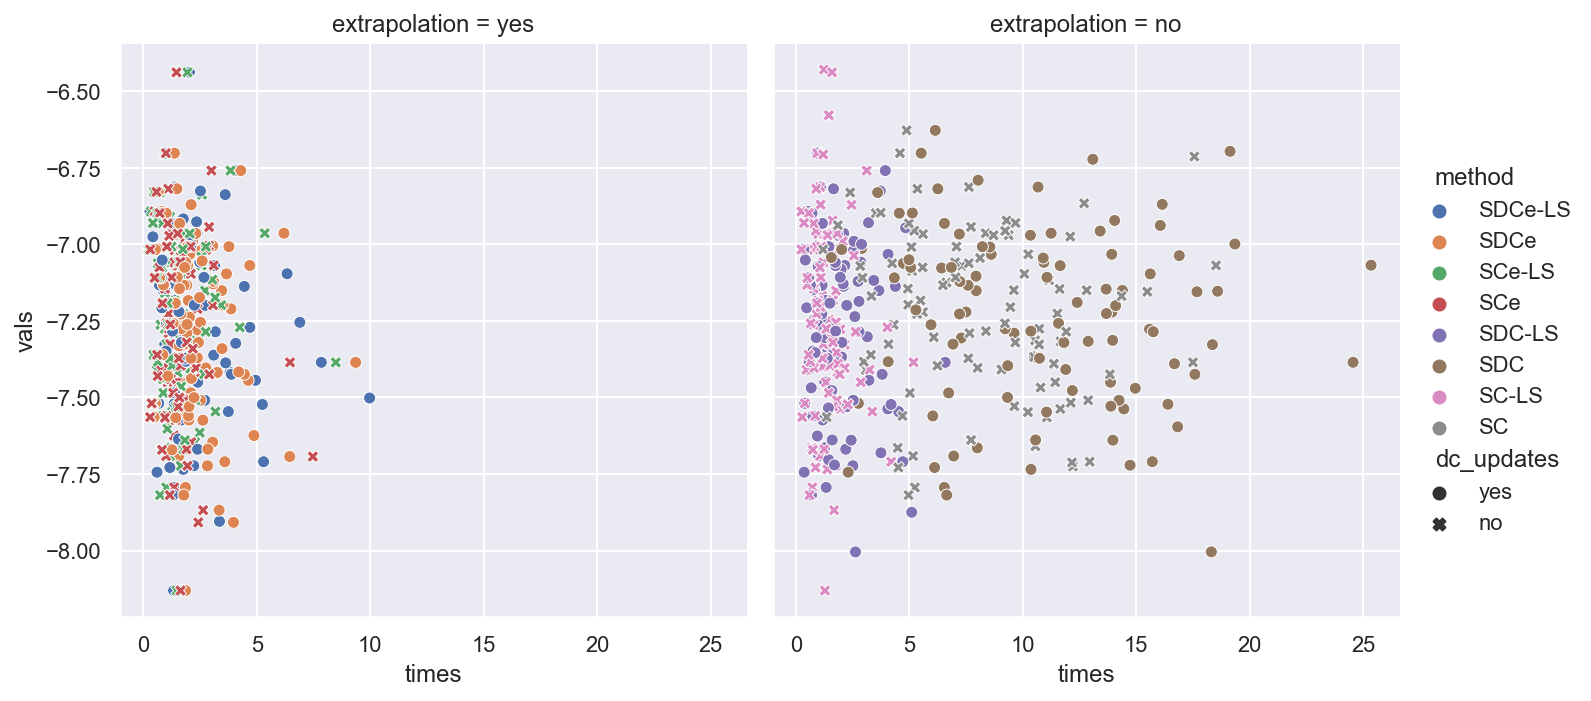

In [22]:
import seaborn as sns
sns.set_theme()
sns.relplot(
    data=subdf, x="times", y="vals",
    hue="method", style="dc_updates",
    kind="scatter",col='extrapolation'
)

In [23]:
for f in list(subdf['extrapolation'].unique()):
    subgroup = subdf[(subdf['extrapolation']==f)]
    sub = ['extrapolation: '+str(f)]
    print('subgroup: ('+str(sub)+')')
    print('avg. time: '+str(subgroup['times'].mean()))
    print('median time: '+str(subgroup['times'].median()))
    print('avg. val: '+str(subgroup['vals'].mean()))
    print('median val: '+str(subgroup['vals'].median()))
    print('avg. #iters: '+str(subgroup['iters'].mean()))
    print('median #iters: '+str(subgroup['iters'].median()))
    print(' ')

subgroup: (['extrapolation: yes'])
avg. time: 1.932096951007843
median time: 1.6348730325698853
avg. val: -7.268415415701959
median val: -7.257877461782423
avg. #iters: 291.51
median #iters: 267.0
 
subgroup: (['extrapolation: no'])
avg. time: 5.492471564412117
median time: 3.397787094116211
avg. val: -7.247805527118541
median val: -7.227300515425716
avg. #iters: 1015.3525
median #iters: 647.5
 


In [24]:
for f in list(subdf['dc_updates'].unique()):
    subgroup = subdf[(subdf['dc_updates']==f)]
    sub = ['DC models: '+str(f)]
    print('subgroup: ('+str(sub)+')')
    print('avg. time: '+str(subgroup['times'].mean()))
    print('median time: '+str(subgroup['times'].median()))
    print('avg. val: '+str(subgroup['vals'].mean()))
    print('median val: '+str(subgroup['vals'].median()))
    print('avg. #iters: '+str(subgroup['iters'].mean()))
    print('median #iters: '+str(subgroup['iters'].median()))
    print(' ')

subgroup: (['DC models: yes'])
avg. time: 4.303424588441849
median time: 2.25201153755188
avg. val: -7.26686010752513
median val: -7.245807981878732
avg. #iters: 640.4425
median #iters: 278.5
 
subgroup: (['DC models: no'])
avg. time: 3.121143926978111
median time: 1.6385811567306519
avg. val: -7.249360835295371
median val: -7.254635240403076
avg. #iters: 666.42
median #iters: 307.5
 


In [25]:
for f in list(subdf['method'].unique()):
    subgroup = subdf[(subdf['method']==f)]
    sub = [f]
    print('subgroup: ('+str(sub)+')')
    print('avg. time: '+str(subgroup['times'].mean()))
    print('median time: '+str(subgroup['times'].median()))
    print('avg. val: '+str(subgroup['vals'].mean()))
    print('median val: '+str(subgroup['vals'].median()))
    print('avg. #iters: '+str(subgroup['iters'].mean()))
    print('median #iters: '+str(subgroup['iters'].median()))
    print(' ')

subgroup: (['SDCe-LS'])
avg. time: 2.195904502868652
median time: 1.7093796730041504
avg. val: -7.264077740292239
median val: -7.2502216401855915
avg. #iters: 213.76
median #iters: 167.5
 
subgroup: (['SDCe'])
avg. time: 2.352336976528168
median time: 2.024143934249878
avg. val: -7.283934183324545
median val: -7.262072123702617
avg. #iters: 349.8
median #iters: 320.0
 
subgroup: (['SCe-LS'])
avg. time: 1.5840546298027038
median time: 1.3177355527877808
avg. val: -7.251983769143628
median val: -7.241845988559611
avg. #iters: 259.7
median #iters: 228.5
 
subgroup: (['SCe'])
avg. time: 1.5960916948318482
median time: 1.4049495458602905
avg. val: -7.273665970047411
median val: -7.269056053365714
avg. #iters: 342.78
median #iters: 317.0
 
subgroup: (['SDC-LS'])
avg. time: 1.9305610132217408
median time: 1.5430973768234253
avg. val: -7.283748228189044
median val: -7.248494262008257
avg. #iters: 187.95
median #iters: 160.5
 
subgroup: (['SDC'])
avg. time: 10.734895861148834
median time: 10.61